이번엔 처음에 MAE 18~~~ 나왔을때 변수인데 floor 변수를 라벨링안하고 해봄

# 데이터 확인 및 라이브러리 호출

## 라이브러리 

### 설치

### 호출 및 파일 불러오기

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import xgboost as xgb

import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")


pd.options.mode.chained_assignment = None
%matplotlib inline

In [39]:
import lightgbm as lgb

In [40]:
#Import train data set & test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 추가 데이터
interest_rate = pd.read_csv('interest_rate.csv') # 한국은행 금리
jeonse = pd.read_csv('아파트전세가격지수_시도_시_군_구__20230731180905.csv', encoding='cp949')


In [41]:
#train+test 
train['train_test'] = 'train'
test['train_test'] = 'test'
all_data = pd.concat([train, test])
all_data = all_data.reset_index(drop=True)
all_data.head()

id        sigungu jibun apt_name  exclusive_use_area  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1              158.54   
1  TRAIN_0001  서울특별시 강남구 대치동   503    개포우성1              127.61   
2  TRAIN_0002  서울특별시 강남구 대치동   503    개포우성1              127.61   
3  TRAIN_0003  서울특별시 강남구 대치동   503    개포우성1              127.61   
4  TRAIN_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

   transaction_year_month  transaction_day  transaction_real_price  floor  \
0                  201401                7                174000.0     13   
1                  201401                9                157500.0      6   
2                  201401               19                150000.0      5   
3                  201402               10                152000.0      9   
4                  201402               10                116000.0      3   

   year_of_completion train_test  
0                1983      train  
1                1983      train  
2                1983      train  
3                1983      train  
4                1983      train

## Train data 확인

In [42]:
train.head()

id        sigungu jibun apt_name  exclusive_use_area  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1              158.54   
1  TRAIN_0001  서울특별시 강남구 대치동   503    개포우성1              127.61   
2  TRAIN_0002  서울특별시 강남구 대치동   503    개포우성1              127.61   
3  TRAIN_0003  서울특별시 강남구 대치동   503    개포우성1              127.61   
4  TRAIN_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

   transaction_year_month  transaction_day  transaction_real_price  floor  \
0                  201401                7                  174000     13   
1                  201401                9                  157500      6   
2                  201401               19                  150000      5   
3                  201402               10                  152000      9   
4                  201402               10                  116000      3   

   year_of_completion train_test  
0                1983      train  
1                1983      train  
2                1983      train  
3                1983      train  
4                1983      train

In [43]:
train['sigungu'].value_counts()

서울특별시 강남구 대치동    5987
Name: sigungu, dtype: int64

In [44]:
train['apt_name'].value_counts()

은마                          1476
대치삼성                         392
래미안대치팰리스                     389
대치아이파크                       373
동부센트레빌                       356
한보미도맨션2                      296
한보미도맨션1                      293
대치현대                         248
개포우성1                        217
선경1차(1동-7동)                  183
테헤란로대우아이빌(891-6)             138
개포우성2                        126
래미안대치하이스턴                    111
선경2차(8동-12동)                 109
포스코더샵                        101
쌍용대치아파트1동,2동,3동,5동,6동         98
대치우성아파트1동,2동,3동,5동,6동,7동      91
대우아이빌명문가(891-23)              80
롯데캐슬리베                        63
선릉역대우아이빌(890-49)              62
쌍용대치2                         52
대치동우정에쉐르1                     51
롯데캐슬                          50
대우아이빌멤버스(891-26)              47
대치효성                          46
현대1                           45
대치한신휴플러스                      30
세영팔레스타운                       30
국제                            27
대치SKVIEW                      26
선경3차      

In [45]:
#Checking data types
print(train.info())
    #No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5987 non-null   object 
 1   sigungu                 5987 non-null   object 
 2   jibun                   5987 non-null   object 
 3   apt_name                5987 non-null   object 
 4   exclusive_use_area      5987 non-null   float64
 5   transaction_year_month  5987 non-null   int64  
 6   transaction_day         5987 non-null   int64  
 7   transaction_real_price  5987 non-null   int64  
 8   floor                   5987 non-null   int64  
 9   year_of_completion      5987 non-null   int64  
 10  train_test              5987 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 514.6+ KB
None


In [46]:
#Descriptive statistics of numerical data
train.describe()

exclusive_use_area  transaction_year_month  transaction_day  \
count         5987.000000             5987.000000      5987.000000   
mean            96.437380           201699.414398        15.902789   
std             31.991673              208.265846         8.750938   
min             20.370000           201401.000000         1.000000   
25%             76.790000           201509.000000         8.000000   
50%             84.810000           201704.000000        16.000000   
75%            119.580000           201903.000000        23.000000   
max            209.790000           202212.000000        31.000000   

       transaction_real_price        floor  year_of_completion  
count             5987.000000  5987.000000         5987.000000  
mean            158144.810423     9.236178         1992.938533  
std              78877.484068     5.959184           12.418632  
min              18000.000000     1.000000         1979.000000  
25%             100000.000000     5.000000         1983.000000  
50%             146000.000000     8.000000         1989.000000  
75%             202250.000000    13.000000         2004.000000  
max             535000.000000    35.000000         2017.000000

In [47]:
train['transaction_year_month'].value_counts().sort_values(ascending = True)

202209      4
202010      6
202201      6
202208      6
202207      6
202008      7
202210      7
201811      8
202009     10
202202     10
202203     10
202111     10
202206     11
202112     12
202212     12
201902     12
202211     13
201901     13
202001     14
202109     15
201812     15
202003     15
202103     16
202110     16
202204     16
202205     17
202102     18
202011     19
201804     19
202007     20
202101     21
202106     22
201612     24
201810     24
201708     25
202108     26
201512     28
201805     28
202104     28
201806     30
202107     31
201602     32
201611     34
202105     34
202004     35
202002     35
201601     37
201903     38
201802     39
202012     39
201405     40
201404     40
201912     41
201701     42
202005     44
201904     44
201508     45
201803     46
201411     46
201809     46
201403     49
201702     55
201908     57
201511     58
201905     60
201410     64
201501     64
201807     65
201407     66
201406     67
201402     73
201412

In [48]:
train.shape

(5987, 11)

In [49]:
test.shape #transaction_real_price 가 제외

(196, 10)

## Test data & Submission data 확인

In [50]:
test.head(10
        )

id        sigungu jibun apt_name  exclusive_use_area  \
0  TEST_0000  서울특별시 강남구 대치동   977   (977-)               77.97   
1  TEST_0001  서울특별시 강남구 대치동   977   (977-)               59.99   
2  TEST_0002  서울특별시 강남구 대치동   503    개포우성1               84.81   
3  TEST_0003  서울특별시 강남구 대치동   503    개포우성1               84.81   
4  TEST_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   
5  TEST_0005  서울특별시 강남구 대치동   503    개포우성1              158.54   
6  TEST_0006  서울특별시 강남구 대치동   503    개포우성1               84.81   
7  TEST_0007  서울특별시 강남구 대치동   503    개포우성1              127.61   
8  TEST_0008  서울특별시 강남구 대치동   503    개포우성1              158.54   
9  TEST_0009  서울특별시 강남구 대치동   500    개포우성2               84.69   

   transaction_year_month  transaction_day  floor  year_of_completion  \
0                  202304               10      2                2021   
1                  202304               10      2                2021   
2                  202301               13      3                1983   
3                  202301               19      9                1983   
4                  202302               15      5                1983   
5                  202303               17      2                1983   
6                  202304                7      5                1983   
7                  202305               24      9                1983   
8                  202306                2      3                1983   
9                  202302               11      8                1984   

  train_test  
0       test  
1       test  
2       test  
3       test  
4       test  
5       test  
6       test  
7       test  
8       test  
9       test

In [51]:
test.describe()

exclusive_use_area  transaction_year_month  transaction_day  \
count          196.000000              196.000000       196.000000   
mean            94.254751           202304.010204        15.750000   
std             30.808380                1.594831         8.427899   
min             28.340000           202301.000000         1.000000   
25%             76.790000           202303.000000         9.000000   
50%             84.480000           202304.000000        16.000000   
75%            116.587500           202305.000000        22.250000   
max            190.470000           202306.000000        31.000000   

            floor  year_of_completion  
count  196.000000          196.000000  
mean     8.785714         1989.423469  
std      6.287554           12.367420  
min      1.000000         1979.000000  
25%      4.000000         1979.000000  
50%      8.000000         1983.000000  
75%     12.000000         2000.000000  
max     28.000000         2021.000000

In [52]:
test['apt_name'].value_counts()

은마                          70
한보미도맨션2                     16
한보미도맨션1                     16
대치삼성                        12
대치아이파크                       9
래미안대치팰리스                     9
동부센트레빌                       7
개포우성1                        7
테헤란로대우아이빌(891-6)             6
개포우성2                        5
쌍용대치2                        5
대우아이빌멤버스(891-26)             4
쌍용대치아파트1동,2동,3동,5동,6동        4
대치현대                         4
선경2차(8동-12동)                 3
포스코더샵                        3
대치SKVIEW                     3
선경1차(1동-7동)                  2
대치우성아파트1동,2동,3동,5동,6동,7동     2
대우아이빌명문가(891-23)             2
(977-)                       2
풍림아이원2차202동                  1
래미안대치하이스턴                    1
선릉역대우아이빌(890-49)             1
대치효성                         1
현대1                          1
Name: apt_name, dtype: int64

In [53]:
test['sigungu'].value_counts()

서울특별시 강남구 대치동    196
Name: sigungu, dtype: int64

In [54]:
test['transaction_year_month'].value_counts()

202305    45
202306    44
202304    34
202302    30
202303    29
202301    14
Name: transaction_year_month, dtype: int64

test data 에서는 202301~202306의 데이터가 존재

In [55]:
#submission 데이터 확인
submission.head(10)

id  transaction_real_price
0  TEST_0000                       0
1  TEST_0001                       0
2  TEST_0002                       0
3  TEST_0003                       0
4  TEST_0004                       0
5  TEST_0005                       0
6  TEST_0006                       0
7  TEST_0007                       0
8  TEST_0008                       0
9  TEST_0009                       0

# 데이터 전처리

## K-means clustering을 통한 아파트 이름 데이터 전처리

In [56]:
pd.set_option('display.max_rows', None)
all_data['apt_name'].value_counts()[:69]

은마                          1546
대치삼성                         404
래미안대치팰리스                     398
대치아이파크                       382
동부센트레빌                       363
한보미도맨션2                      312
한보미도맨션1                      309
대치현대                         252
개포우성1                        224
선경1차(1동-7동)                  185
테헤란로대우아이빌(891-6)             144
개포우성2                        131
래미안대치하이스턴                    112
선경2차(8동-12동)                 112
포스코더샵                        104
쌍용대치아파트1동,2동,3동,5동,6동        102
대치우성아파트1동,2동,3동,5동,6동,7동      93
대우아이빌명문가(891-23)              82
선릉역대우아이빌(890-49)              63
롯데캐슬리베                        63
쌍용대치2                         57
대치동우정에쉐르1                     51
대우아이빌멤버스(891-26)              51
롯데캐슬                          50
대치효성                          47
현대1                           46
세영팔레스타운                       30
대치한신휴플러스                      30
대치SKVIEW                      29
국제                            27
선경3차      

In [57]:
#괄호안 내용은 분석에 불필요하다고 판단하고 제거
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(all_data))):
    all_data.at[i, 'apt_name'] = re.sub(regex, '', all_data.at[i, 'apt_name'])


100%|██████████████████████████████████████████████| 6183/6183 [00:00<00:00, 88454.59it/s]


In [58]:
all_data['apt_name'].value_counts().sort_values(ascending = False)

은마                          1546
대치삼성                         404
래미안대치팰리스                     398
대치아이파크                       382
동부센트레빌                       363
한보미도맨션2                      312
한보미도맨션1                      309
대치현대                         252
개포우성1                        224
선경1차                         185
테헤란로대우아이빌                    144
개포우성2                        131
선경2차                         112
래미안대치하이스턴                    112
포스코더샵                        104
쌍용대치아파트1동,2동,3동,5동,6동        102
대치우성아파트1동,2동,3동,5동,6동,7동      93
대우아이빌명문가                      82
선릉역대우아이빌                      63
롯데캐슬리베                        63
쌍용대치2                         57
대우아이빌멤버스                      51
대치동우정에쉐르1                     51
롯데캐슬                          50
대치효성                          47
현대1                           46
세영팔레스타운                       30
대치한신휴플러스                      30
대치SKVIEW                      29
국제                            27
선경3차      

In [59]:
from sklearn.cluster import KMeans
import numpy as np

# 아파트 별로 가격 평균값 구하기
train = all_data[all_data['train_test'] == 'train']
data = train[['apt_name', 'transaction_real_price']]

data = data.groupby('apt_name').mean()
arr = data['transaction_real_price'].to_numpy().reshape(-1, 1)

# 가격을 기준으로 아파트 군집화
k = 5  
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(arr)

# 가격을 기준으로 군집의 순서를 정렬하기 위해 인덱스를 추출
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 재할당
labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['apt_name', 'cluster']]

all_data = pd.merge(all_data, data, how='left', left_on='apt_name', right_on='apt_name')

cluster_mode = all_data.loc[all_data['train_test'] == 'train', 'cluster'].mode()[0]
all_data['cluster'] = all_data['cluster'].fillna(cluster_mode)

all_data['cluster'].value_counts()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2d86701cf0>
Traceback (most recent call last):
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2d86701cf0>
Traceback (most recent call last):
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

2.0    2938
3.0    2067
1.0     700
0.0     470
4.0       8
Name: cluster, dtype: int64

## 날짜 데이터 전처리

날짜 관련 컬럼은 year_of_completion, transaction_year_month, transaction_date가 있다. 이들은 범주형 데이터이기 때문에 분석을 위해 거래날짜 데이터를 제거 하고 거래연월 변수에 라벨인코딩을 적용할 것이다. 

In [60]:
train = all_data[all_data['train_test'] == 'train']
test = all_data[all_data['train_test'] == 'test']

In [61]:
print('train data 기술통계량')
print(train[['year_of_completion','transaction_year_month']].describe())
print('-'*90)
print('test data 기b술통계량')
print(test[['year_of_completion','transaction_year_month']].describe())


train data 기술통계량
       year_of_completion  transaction_year_month
count         5987.000000             5987.000000
mean          1992.938533           201699.414398
std             12.418632              208.265846
min           1979.000000           201401.000000
25%           1983.000000           201509.000000
50%           1989.000000           201704.000000
75%           2004.000000           201903.000000
max           2017.000000           202212.000000
------------------------------------------------------------------------------------------
test data 기b술통계량
       year_of_completion  transaction_year_month
count          196.000000              196.000000
mean          1989.423469           202304.010204
std             12.367420                1.594831
min           1979.000000           202301.000000
25%           1979.000000           202303.000000
50%           1983.000000           202304.000000
75%           2000.000000           202305.000000
max           2021.000000

[train data]
- year_of_completion

최대값은 2017년이며 최솟값은 1979년이다. 

- transaction_year_month

최대값은 2022년 12월이며 최솟값은 2014년 1월이다. 

-------------
[test data]
- year_of_completion

최대값은 2021년이며 최솟값은 1979년이다. 

- transaction_year_month

최대값은 2023년 6월이며 최솟값은 2023년 1월이다. 


최대년도에서 최소년도를 뺌으로써 정수형 라벨인코딩을 완성한다. test data의 경우 완공년도는 train data와 동일하기 때문에 인코딩에서 문제가 발생하진 않지만 거래연월에서 문제가 발생한다. 

In [62]:
from sklearn.preprocessing import LabelEncoder

# train set과 test set을 합쳐서 "year_of_completion" set의 최대값과 최소값 구하기
combined_yc = pd.concat([train['year_of_completion'], test['year_of_completion']])
combined_yc_max = combined_yc.max()
combined_yc_min = combined_yc.min()

# train set과 test set을 합쳐서 "transaction_year_month" set의 최대값과 최소값 구하기
combined_tym = pd.concat([train['transaction_year_month'], test['transaction_year_month']])
combined_tym_max = combined_tym.max()
combined_tym_min = combined_tym.min()

# train set에서 "year_of_completion" set에서 최소값 빼기
print('변환전\n', train['year_of_completion'].unique()[:5])
train['year_of_completion'] = train['year_of_completion'] - combined_yc_min
test['year_of_completion'] = test['year_of_completion'] - combined_yc_min
print('변환후\n', train['year_of_completion'].unique()[:5])

# train set과 test set에서 "transaction_year_month" 라벨 인코딩
print('train 변환전\n', train['transaction_year_month'].unique()[:5])
print('test 변환전\n', test['transaction_year_month'].unique()[:5])

le = LabelEncoder()
le.fit(combined_tym)
train['transaction_year_month'] = le.transform(train['transaction_year_month'])
test['transaction_year_month'] = le.transform(test['transaction_year_month'])

print('train 변환후\n', train['transaction_year_month'].unique()[:5])
print('test 변환후\n', test['transaction_year_month'].unique()[:5])



변환전
 [1983 1984 2003 2004 2000]
변환후
 [ 4  5 24 25 21]
train 변환전
 [201401 201402 201403 201405 201406]
test 변환전
 [202304 202301 202302 202303 202305]
train 변환후
 [0 1 2 4 5]
test 변환후
 [111 108 109 110 112]


In [63]:
test.head()

id        sigungu jibun apt_name  exclusive_use_area  \
5987  TEST_0000  서울특별시 강남구 대치동   977                        77.97   
5988  TEST_0001  서울특별시 강남구 대치동   977                        59.99   
5989  TEST_0002  서울특별시 강남구 대치동   503    개포우성1               84.81   
5990  TEST_0003  서울특별시 강남구 대치동   503    개포우성1               84.81   
5991  TEST_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

      transaction_year_month  transaction_day  transaction_real_price  floor  \
5987                     111               10                     NaN      2   
5988                     111               10                     NaN      2   
5989                     108               13                     NaN      3   
5990                     108               19                     NaN      9   
5991                     109               15                     NaN      5   

      year_of_completion train_test  cluster  
5987                  42       test      2.0  
5988                  42       test      2.0  
5989                   4       test      3.0  
5990                   4       test      3.0  
5991                   4       test      3.0

In [64]:
#인덱스가 섞여 있어 정리
test.reset_index(drop=True)

id        sigungu   jibun                  apt_name  \
0    TEST_0000  서울특별시 강남구 대치동     977                             
1    TEST_0001  서울특별시 강남구 대치동     977                             
2    TEST_0002  서울특별시 강남구 대치동     503                     개포우성1   
3    TEST_0003  서울특별시 강남구 대치동     503                     개포우성1   
4    TEST_0004  서울특별시 강남구 대치동     503                     개포우성1   
5    TEST_0005  서울특별시 강남구 대치동     503                     개포우성1   
6    TEST_0006  서울특별시 강남구 대치동     503                     개포우성1   
7    TEST_0007  서울특별시 강남구 대치동     503                     개포우성1   
8    TEST_0008  서울특별시 강남구 대치동     503                     개포우성1   
9    TEST_0009  서울특별시 강남구 대치동     500                     개포우성2   
10   TEST_0010  서울특별시 강남구 대치동     500                     개포우성2   
11   TEST_0011  서울특별시 강남구 대치동     500                     개포우성2   
12   TEST_0012  서울특별시 강남구 대치동     500                     개포우성2   
13   TEST_0013  서울특별시 강남구 대치동     500                     개포우성2   
14   TEST_0014  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
15   TEST_0015  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
16   TEST_0016  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
17   TEST_0017  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
18   TEST_0018  서울특별시 강남구 대치동  891-23                  대우아이빌명문가   
19   TEST_0019  서울특별시 강남구 대치동  891-23                  대우아이빌명문가   
20   TEST_0020  서울특별시 강남구 대치동    1029                  대치SKVIEW   
21   TEST_0021  서울특별시 강남구 대치동    1029                  대치SKVIEW   
22   TEST_0022  서울특별시 강남구 대치동    1029                  대치SKVIEW   
23   TEST_0023  서울특별시 강남구 대치동  1014-3                      대치삼성   
24   TEST_0024  서울특별시 강남구 대치동  1014-3                      대치삼성   
25   TEST_0025  서울특별시 강남구 대치동  1014-3                      대치삼성   
26   TEST_0026  서울특별시 강남구 대치동  1014-3                      대치삼성   
27   TEST_0027  서울특별시 강남구 대치동  1014-3                      대치삼성   
28   TEST_0028  서울특별시 강남구 대치동  1014-3                      대치삼성   
29   TEST_0029  서울특별시 강남구 대치동  1014-3                      대치삼성   
30   TEST_0030  서울특별시 강남구 대치동  1014-3                      대치삼성   
31   TEST_0031  서울특별시 강남구 대치동  1014-3                      대치삼성   
32   TEST_0032  서울특별시 강남구 대치동  1014-3                      대치삼성   
33   TEST_0033  서울특별시 강남구 대치동  1014-3                      대치삼성   
34   TEST_0034  서울특별시 강남구 대치동  1014-3                      대치삼성   
35   TEST_0035  서울특별시 강남구 대치동     888                    대치아이파크   
36   TEST_0036  서울특별시 강남구 대치동     888                    대치아이파크   
37   TEST_0037  서울특별시 강남구 대치동     888                    대치아이파크   
38   TEST_0038  서울특별시 강남구 대치동     888                    대치아이파크   
39   TEST_0039  서울특별시 강남구 대치동     888                    대치아이파크   
40   TEST_0040  서울특별시 강남구 대치동     888                    대치아이파크   
41   TEST_0041  서울특별시 강남구 대치동     888                    대치아이파크   
42   TEST_0042  서울특별시 강남구 대치동     888                    대치아이파크   
43   TEST_0043  서울특별시 강남구 대치동     888                    대치아이파크   
44   TEST_0044  서울특별시 강남구 대치동      63  대치우성아파트1동,2동,3동,5동,6동,7동   
45   TEST_0045  서울특별시 강남구 대치동      63  대치우성아파트1동,2동,3동,5동,6동,7동   
46   TEST_0046  서울특별시 강남구 대치동     974                      대치현대   
47   TEST_0047  서울특별시 강남구 대치동     974                      대치현대   
48   TEST_0048  서울특별시 강남구 대치동     974                      대치현대   
49   TEST_0049  서울특별시 강남구 대치동     974                      대치현대   
50   TEST_0050  서울특별시 강남구 대치동   988-4                      대치효성   
51   TEST_0051  서울특별시 강남구 대치동     670                    동부센트레빌   
52   TEST_0052  서울특별시 강남구 대치동     670                    동부센트레빌   
53   TEST_0053  서울특별시 강남구 대치동     670                    동부센트레빌   
54   TEST_0054  서울특별시 강남구 대치동     670                    동부센트레빌   
55   TEST_0055  서울특별시 강남구 대치동     670                    동부센트레빌   
56   TEST_0056  서울특별시 강남구 대치동     670                    동부센트레빌   
57   TEST_0057  서울특별시 강남구 대치동     670                    동부센트레빌   
58   TEST_0058  서울특별시 강남구 대치동    1027                  래미안대

In [65]:
print('train')
print(train[['transaction_year_month', 'year_of_completion']].describe())
print('-'*90)
print('test')
print(test[['transaction_year_month', 'year_of_completion']].describe())

train
       transaction_year_month  year_of_completion
count             5987.000000         5987.000000
mean                40.661266           13.938533
std                 25.281697           12.418632
min                  0.000000            0.000000
25%                 20.000000            4.000000
50%                 39.000000           10.000000
75%                 62.000000           25.000000
max                107.000000           38.000000
------------------------------------------------------------------------------------------
test
       transaction_year_month  year_of_completion
count              196.000000          196.000000
mean               111.010204           10.423469
std                  1.594831           12.367420
min                108.000000            0.000000
25%                110.000000            0.000000
50%                111.000000            4.000000
75%                112.000000           21.000000
max                113.000000           42.00000

## 거래가격 확인 및 로그변환

<Axes: ylabel='transaction_real_price'>

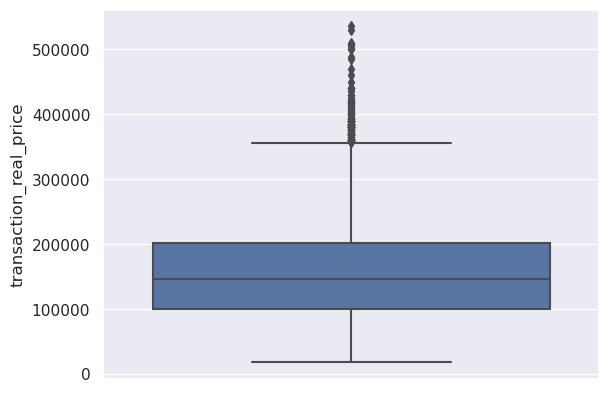

In [28]:
sns.boxplot(y='transaction_real_price', data = train)

In [66]:
train['log_price'] = np.log1p(train['transaction_real_price'])


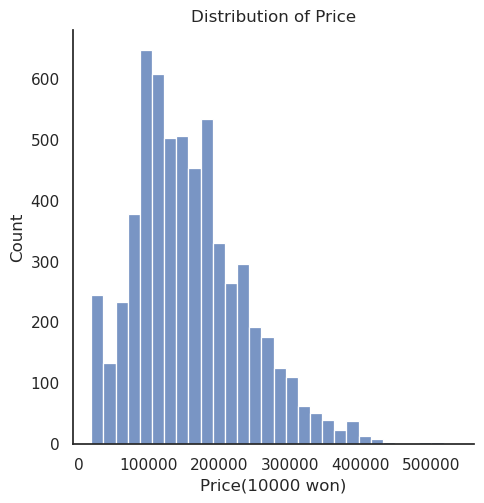

In [67]:
sns.set(style = 'white')
sns.displot(train['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()


## 면적(m^2) 확인 및 로그변환

<Figure size 640x480 with 0 Axes>

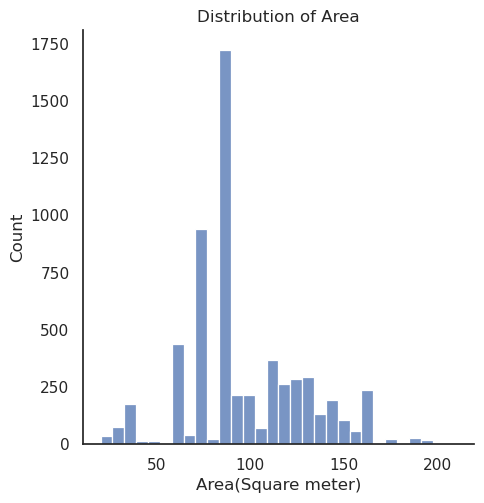

In [32]:
plt.figure()
sns.displot(train['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

이상치 때문에  로그변환을 수행해야 한다.

In [68]:
train['log_area'] = np.log1p(train['exclusive_use_area'])
test['log_area'] = np.log1p(test['exclusive_use_area'])

area = train['exclusive_use_area'] # 원래 면적

train.drop('exclusive_use_area', axis=1, inplace=True)
test.drop('exclusive_use_area', axis=1, inplace=True)
train.head(1)

id        sigungu jibun apt_name  transaction_year_month  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1                       0   

   transaction_day  transaction_real_price  floor  year_of_completion  \
0                7                174000.0     13                   4   

  train_test  cluster  log_price  log_area  
0      train      3.0  12.066816  5.072295

<Figure size 640x480 with 0 Axes>

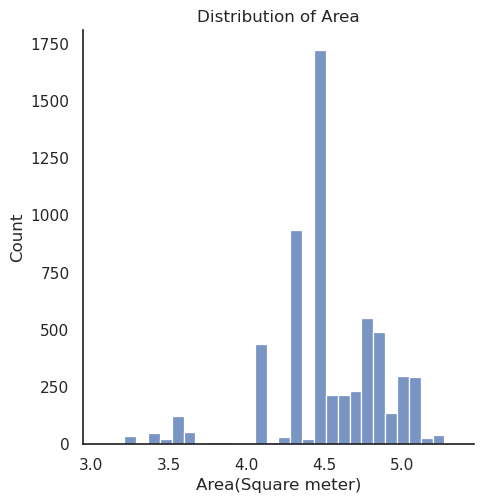

In [34]:
plt.figure()
sns.displot(train['log_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

로그변환은 큰 소용이 없었다. 

# 직접 모델 비교

모델 목록
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elasticnet Regression
- Decision Tree
- RandomForest Regressor
- XGBoost Regressor
- LightGBM Regressor


In [35]:

train.drop(['train_test','transaction_day'], axis = 1, inplace = True )
test.drop(['train_test','transaction_day'], axis = 1, inplace = True )

In [36]:
test.head()

id        sigungu jibun apt_name  transaction_year_month  floor  \
0  TEST_0000  서울특별시 강남구 대치동   977   (977-)                     111      2   
1  TEST_0001  서울특별시 강남구 대치동   977   (977-)                     111      2   
2  TEST_0002  서울특별시 강남구 대치동   503    개포우성1                     108      3   
3  TEST_0003  서울특별시 강남구 대치동   503    개포우성1                     108      9   
4  TEST_0004  서울특별시 강남구 대치동   503    개포우성1                     109      5   

   year_of_completion  log_area  
0                  42  4.369068  
1                  42  4.110710  
2                   4  4.452136  
3                   4  4.452136  
4                   4  4.452136

In [21]:
train.columns

Index(['id', 'sigungu', 'jibun', 'apt_name', 'exclusive_use_area',
       'transaction_year_month', 'transaction_real_price', 'floor',
       'year_of_completion', 'cluster'],
      dtype='object')

In [79]:
#모델링에 사용할 변수만 선택
train_df = train[['cluster', 'log_area','year_of_completion','floor',
                  'log_price',  'transaction_year_month']]
test_df = test[['cluster', 'log_area','year_of_completion','floor',
                    'transaction_year_month']] 

In [80]:
train_X, train_y = train_df.drop('log_price', axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(5987, 5) (5987,)


In [81]:
from sklearn.metrics import mean_absolute_error

def MAE(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    return mae


def mae_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mae = MAE(y_test, pred) 
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = mae_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAE: {r:.4f}')
    print(f'\n{model_name} mean MAE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [82]:
#lgb num_leaves 정의
import math
num_leaves = int(round(math.sqrt(len(train_X))))
num_leaves

77

In [83]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=1, criterion='mae', max_depth=9, min_samples_split=50, 
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, 
                             min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9,num_leaves=77, min_child_weight=5, n_jobs=-1)

### 모델링

In [84]:
from sklearn.model_selection import TimeSeriesSplit

models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, model_xgb, model_lgb]:
    model_name, mean_score = print_mae_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|█████████████| 10/10 [00:00<00:00, 337.75it/s]


1 FOLDS: LinearRegression MAE: 0.0857
2 FOLDS: LinearRegression MAE: 0.0756
3 FOLDS: LinearRegression MAE: 0.0860
4 FOLDS: LinearRegression MAE: 0.1009
5 FOLDS: LinearRegression MAE: 0.1034
6 FOLDS: LinearRegression MAE: 0.1026
7 FOLDS: LinearRegression MAE: 0.1757
8 FOLDS: LinearRegression MAE: 0.1409
9 FOLDS: LinearRegression MAE: 0.1438
10 FOLDS: LinearRegression MAE: 0.1967

LinearRegression mean MAE: 0.1211


Ridge Cross Validations...: 100%|████████████████████████| 10/10 [00:00<00:00, 870.95it/s]


1 FOLDS: Ridge MAE: 0.0857
2 FOLDS: Ridge MAE: 0.0752
3 FOLDS: Ridge MAE: 0.0860
4 FOLDS: Ridge MAE: 0.1008
5 FOLDS: Ridge MAE: 0.1033
6 FOLDS: Ridge MAE: 0.1025
7 FOLDS: Ridge MAE: 0.1757
8 FOLDS: Ridge MAE: 0.1408
9 FOLDS: Ridge MAE: 0.1437
10 FOLDS: Ridge MAE: 0.1968

Ridge mean MAE: 0.1210


Lasso Cross Validations...: 100%|████████████████████████| 10/10 [00:00<00:00, 726.31it/s]


1 FOLDS: Lasso MAE: 0.0880
2 FOLDS: Lasso MAE: 0.0708
3 FOLDS: Lasso MAE: 0.0835
4 FOLDS: Lasso MAE: 0.0969
5 FOLDS: Lasso MAE: 0.1029
6 FOLDS: Lasso MAE: 0.0934
7 FOLDS: Lasso MAE: 0.1746
8 FOLDS: Lasso MAE: 0.1357
9 FOLDS: Lasso MAE: 0.1399
10 FOLDS: Lasso MAE: 0.2028

Lasso mean MAE: 0.1189


ElasticNet Cross Validations...: 100%|███████████████████| 10/10 [00:00<00:00, 729.03it/s]


1 FOLDS: ElasticNet MAE: 0.0948
2 FOLDS: ElasticNet MAE: 0.0699
3 FOLDS: ElasticNet MAE: 0.0917
4 FOLDS: ElasticNet MAE: 0.0976
5 FOLDS: ElasticNet MAE: 0.1016
6 FOLDS: ElasticNet MAE: 0.0903
7 FOLDS: ElasticNet MAE: 0.1733
8 FOLDS: ElasticNet MAE: 0.1336
9 FOLDS: ElasticNet MAE: 0.1392
10 FOLDS: ElasticNet MAE: 0.2078

ElasticNet mean MAE: 0.1200


DecisionTreeRegressor Cross Validations...: 100%|████████| 10/10 [00:00<00:00, 437.81it/s]


1 FOLDS: DecisionTreeRegressor MAE: 0.1102
2 FOLDS: DecisionTreeRegressor MAE: 0.0980
3 FOLDS: DecisionTreeRegressor MAE: 0.1469
4 FOLDS: DecisionTreeRegressor MAE: 0.1332
5 FOLDS: DecisionTreeRegressor MAE: 0.1647
6 FOLDS: DecisionTreeRegressor MAE: 0.1551
7 FOLDS: DecisionTreeRegressor MAE: 0.2258
8 FOLDS: DecisionTreeRegressor MAE: 0.1774
9 FOLDS: DecisionTreeRegressor MAE: 0.1206
10 FOLDS: DecisionTreeRegressor MAE: 0.1721

DecisionTreeRegressor mean MAE: 0.1504


XGBRegressor Cross Validations...: 100%|██████████████████| 10/10 [00:05<00:00,  1.92it/s]


1 FOLDS: XGBRegressor MAE: 0.1116
2 FOLDS: XGBRegressor MAE: 0.0723
3 FOLDS: XGBRegressor MAE: 0.0925
4 FOLDS: XGBRegressor MAE: 0.0602
5 FOLDS: XGBRegressor MAE: 0.1201
6 FOLDS: XGBRegressor MAE: 0.0576
7 FOLDS: XGBRegressor MAE: 0.1205
8 FOLDS: XGBRegressor MAE: 0.1172
9 FOLDS: XGBRegressor MAE: 0.0695
10 FOLDS: XGBRegressor MAE: 0.1075

XGBRegressor mean MAE: 0.0929


LGBMRegressor Cross Validations...:   0%|                          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 5
[LightGBM] [Info] Start training from score 11.489574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor Cross Validations...:  10%|█▊                | 1/10 [00:00<00:03,  2.41it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor Cross Validations...:  20%|███▌              | 2/10 [00:00<00:02,  3.85it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor Cross Validations...:  30%|█████▍            | 3/10 [00:00<00:01,  4.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMRegressor Cross Validations...:  40%|███████▏          | 4/10 [00:00<00:01,  4.66it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMRegressor Cross Validations...:  50%|█████████         | 5/10 [00:01<00:01,  4.85it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  60%|██████████▊       | 6/10 [00:01<00:00,  4.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  70%|████████████▌     | 7/10 [00:01<00:00,  4.76it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  80%|██████████████▍   | 8/10 [00:01<00:00,  4.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  90%|████████████████▏ | 9/10 [00:02<00:00,  4.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...: 100%|█████████████████| 10/10 [00:02<00:00,  4.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [85]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

Model     Score
0       LinearRegression  0.121142
1                  Ridge  0.121047
2                  Lasso  0.118863
3             ElasticNet  0.119987
4  DecisionTreeRegressor  0.150398
5           XGBRegressor  0.092906
6          LGBMRegressor  0.078191

가장 성능 좋은 LightGBM 채택

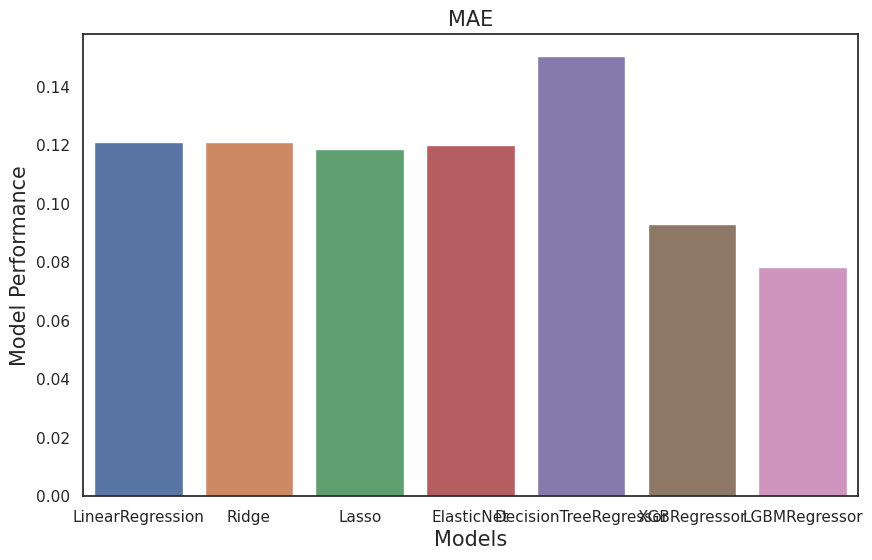

In [86]:
f, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)

plt.title('MAE', fontsize=15)
plt.show()

## Hyperparameter Tuning

In [88]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)


(4789, 5) (4789,) (1198, 5) (1198,)


In [95]:
h_train_X.head()

cluster  log_area  year_of_completion  floor  transaction_year_month
0      3.0  5.072295                   4     13                       0
1      3.0  4.856785                   4      6                       0
2      3.0  4.856785                   4      5                       0
3      3.0  4.856785                   4      9                       1
4      3.0  4.452136                   4      3                       1

In [38]:
import optuna
print(optuna.__version__)


3.2.0


### optuna를 통한 튜닝

#### XGB

In [105]:
import xgboost as xgb

def xgb_objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:linear', 
        'eval_metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }


    model = xgb.XGBRegressor(**param)
    xgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], early_stopping_rounds=10,)
    mae = MAE(h_valid_y, xgb_model.predict(h_valid_X))
    
    
    return mae

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=100)



[I 2023-08-01 23:19:54,871] A new study created in memory with name: no-name-5afbc9ce-d4a0-4e2e-adec-591bc7c0cf3f


[23:19:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63656
[1]	validation_0-mae:11.63652
[2]	validation_0-mae:11.63648
[3]	validation_0-mae:11.63644
[4]	validation_0-mae:11.63640
[5]	validation_0-mae:11.63636
[6]	validation_0-mae:11.63632
[7]	validation_0-mae:11.63628
[8]	validation_0-mae:11.63624
[9]	validation_0-mae:11.63619
[10]	validation_0-mae:11.63615
[11]	validation_0-mae:11.63611
[12]	validation_0-mae:11.63607
[13]	validation_0-mae:11.63603
[14]	validation_0-mae:11.63599
[15]	validation_0-mae:11.63595
[16]	validation_0-mae:11.63591
[17]	validation_0-mae:11.63587
[18]	validation_0-mae:11.63583
[19]	validation_0-mae:11.63579
[20]	validation_0-mae:11.63574
[21]	validation_0-mae:11.63570
[22]	validation_0-mae:11.63566
[23]	validation_0-mae:11.63562
[24]	validation_0-mae:11.63558
[25]	validation_0-mae:11.63554
[26]	validation_0-mae:11.63550
[27]	validation_0-mae:11.63546
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[198]	validation_0-mae:11.62848
[199]	validation_0-mae:11.62844
[200]	validation_0-mae:11.62840
[201]	validation_0-mae:11.62836
[202]	validation_0-mae:11.62832
[203]	validation_0-mae:11.62828
[204]	validation_0-mae:11.62824
[205]	validation_0-mae:11.62819
[206]	validation_0-mae:11.62815
[207]	validation_0-mae:11.62811
[208]	validation_0-mae:11.62807
[209]	validation_0-mae:11.62803
[210]	validation_0-mae:11.62799
[211]	validation_0-mae:11.62795
[212]	validation_0-mae:11.62791
[213]	validation_0-mae:11.62787
[214]	validation_0-mae:11.62783
[215]	validation_0-mae:11.62779
[216]	validation_0-mae:11.62775
[217]	validation_0-mae:11.62771
[218]	validation_0-mae:11.62766
[219]	validation_0-mae:11.62762
[220]	validation_0-mae:11.62758
[221]	validation_0-mae:11.62754
[222]	validation_0-mae:11.62750
[223]	validation_0-mae:11.62746
[224]	validation_0-mae:11.62742
[225]	validation_0-mae:11.62738
[226]	validation_0-mae:11.62734
[227]	validation_0-mae:11.62730
[228]	validation_0-mae:11.62726
[229]	va

[454]	validation_0-mae:11.61804
[455]	validation_0-mae:11.61800
[456]	validation_0-mae:11.61796
[457]	validation_0-mae:11.61792
[458]	validation_0-mae:11.61788
[459]	validation_0-mae:11.61784
[460]	validation_0-mae:11.61780
[461]	validation_0-mae:11.61776
[462]	validation_0-mae:11.61771
[463]	validation_0-mae:11.61767
[464]	validation_0-mae:11.61763
[465]	validation_0-mae:11.61759
[466]	validation_0-mae:11.61755
[467]	validation_0-mae:11.61751
[468]	validation_0-mae:11.61747
[469]	validation_0-mae:11.61743
[470]	validation_0-mae:11.61739
[471]	validation_0-mae:11.61735
[472]	validation_0-mae:11.61731
[473]	validation_0-mae:11.61727
[474]	validation_0-mae:11.61723
[475]	validation_0-mae:11.61718
[476]	validation_0-mae:11.61714
[477]	validation_0-mae:11.61710
[478]	validation_0-mae:11.61706
[479]	validation_0-mae:11.61702
[480]	validation_0-mae:11.61698
[481]	validation_0-mae:11.61694
[482]	validation_0-mae:11.61690
[483]	validation_0-mae:11.61686
[484]	validation_0-mae:11.61682
[485]	va

[710]	validation_0-mae:11.60761
[711]	validation_0-mae:11.60757
[712]	validation_0-mae:11.60753
[713]	validation_0-mae:11.60749
[714]	validation_0-mae:11.60745
[715]	validation_0-mae:11.60741
[716]	validation_0-mae:11.60737
[717]	validation_0-mae:11.60733
[718]	validation_0-mae:11.60729
[719]	validation_0-mae:11.60724
[720]	validation_0-mae:11.60720
[721]	validation_0-mae:11.60716
[722]	validation_0-mae:11.60712
[723]	validation_0-mae:11.60708
[724]	validation_0-mae:11.60704
[725]	validation_0-mae:11.60700
[726]	validation_0-mae:11.60696
[727]	validation_0-mae:11.60692
[728]	validation_0-mae:11.60688
[729]	validation_0-mae:11.60684
[730]	validation_0-mae:11.60680
[731]	validation_0-mae:11.60676
[732]	validation_0-mae:11.60672
[733]	validation_0-mae:11.60668
[734]	validation_0-mae:11.60663
[735]	validation_0-mae:11.60659
[736]	validation_0-mae:11.60655
[737]	validation_0-mae:11.60651
[738]	validation_0-mae:11.60647
[739]	validation_0-mae:11.60643
[740]	validation_0-mae:11.60639
[741]	va

[967]	validation_0-mae:11.59715
[968]	validation_0-mae:11.59711
[969]	validation_0-mae:11.59707
[970]	validation_0-mae:11.59703
[971]	validation_0-mae:11.59699
[972]	validation_0-mae:11.59695
[973]	validation_0-mae:11.59691
[974]	validation_0-mae:11.59687
[975]	validation_0-mae:11.59683
[976]	validation_0-mae:11.59678
[977]	validation_0-mae:11.59674
[978]	validation_0-mae:11.59670
[979]	validation_0-mae:11.59666
[980]	validation_0-mae:11.59662
[981]	validation_0-mae:11.59658
[982]	validation_0-mae:11.59654
[983]	validation_0-mae:11.59650
[984]	validation_0-mae:11.59646
[985]	validation_0-mae:11.59642
[986]	validation_0-mae:11.59638
[987]	validation_0-mae:11.59634
[988]	validation_0-mae:11.59630
[989]	validation_0-mae:11.59626
[990]	validation_0-mae:11.59622
[991]	validation_0-mae:11.59617
[992]	validation_0-mae:11.59613
[993]	validation_0-mae:11.59609
[994]	validation_0-mae:11.59605
[995]	validation_0-mae:11.59601
[996]	validation_0-mae:11.59597
[997]	validation_0-mae:11.59593
[998]	va

[1216]	validation_0-mae:11.58703
[1217]	validation_0-mae:11.58698
[1218]	validation_0-mae:11.58694
[1219]	validation_0-mae:11.58690
[1220]	validation_0-mae:11.58686
[1221]	validation_0-mae:11.58682
[1222]	validation_0-mae:11.58678
[1223]	validation_0-mae:11.58674
[1224]	validation_0-mae:11.58670
[1225]	validation_0-mae:11.58666
[1226]	validation_0-mae:11.58662
[1227]	validation_0-mae:11.58658
[1228]	validation_0-mae:11.58654
[1229]	validation_0-mae:11.58650
[1230]	validation_0-mae:11.58646
[1231]	validation_0-mae:11.58642
[1232]	validation_0-mae:11.58638
[1233]	validation_0-mae:11.58633
[1234]	validation_0-mae:11.58629
[1235]	validation_0-mae:11.58625
[1236]	validation_0-mae:11.58621
[1237]	validation_0-mae:11.58617
[1238]	validation_0-mae:11.58613
[1239]	validation_0-mae:11.58609
[1240]	validation_0-mae:11.58605
[1241]	validation_0-mae:11.58601
[1242]	validation_0-mae:11.58597
[1243]	validation_0-mae:11.58593
[1244]	validation_0-mae:11.58589
[1245]	validation_0-mae:11.58585
[1246]	val

[1465]	validation_0-mae:11.57691
[1466]	validation_0-mae:11.57687
[1467]	validation_0-mae:11.57683
[1468]	validation_0-mae:11.57679
[1469]	validation_0-mae:11.57675
[1470]	validation_0-mae:11.57671
[1471]	validation_0-mae:11.57667
[1472]	validation_0-mae:11.57663
[1473]	validation_0-mae:11.57659
[1474]	validation_0-mae:11.57654
[1475]	validation_0-mae:11.57650
[1476]	validation_0-mae:11.57646
[1477]	validation_0-mae:11.57642
[1478]	validation_0-mae:11.57638
[1479]	validation_0-mae:11.57634
[1480]	validation_0-mae:11.57630
[1481]	validation_0-mae:11.57626
[1482]	validation_0-mae:11.57622
[1483]	validation_0-mae:11.57618
[1484]	validation_0-mae:11.57614
[1485]	validation_0-mae:11.57610
[1486]	validation_0-mae:11.57606
[1487]	validation_0-mae:11.57602
[1488]	validation_0-mae:11.57598
[1489]	validation_0-mae:11.57594
[1490]	validation_0-mae:11.57589
[1491]	validation_0-mae:11.57585
[1492]	validation_0-mae:11.57581
[1493]	validation_0-mae:11.57577
[1494]	validation_0-mae:11.57573
[1495]	val

[1713]	validation_0-mae:11.56684
[1714]	validation_0-mae:11.56680
[1715]	validation_0-mae:11.56676
[1716]	validation_0-mae:11.56672
[1717]	validation_0-mae:11.56668
[1718]	validation_0-mae:11.56664
[1719]	validation_0-mae:11.56660
[1720]	validation_0-mae:11.56656
[1721]	validation_0-mae:11.56652
[1722]	validation_0-mae:11.56648
[1723]	validation_0-mae:11.56644
[1724]	validation_0-mae:11.56640
[1725]	validation_0-mae:11.56636
[1726]	validation_0-mae:11.56632
[1727]	validation_0-mae:11.56628
[1728]	validation_0-mae:11.56623
[1729]	validation_0-mae:11.56619
[1730]	validation_0-mae:11.56615
[1731]	validation_0-mae:11.56611
[1732]	validation_0-mae:11.56607
[1733]	validation_0-mae:11.56603
[1734]	validation_0-mae:11.56599
[1735]	validation_0-mae:11.56595
[1736]	validation_0-mae:11.56591
[1737]	validation_0-mae:11.56587
[1738]	validation_0-mae:11.56583
[1739]	validation_0-mae:11.56579
[1740]	validation_0-mae:11.56575
[1741]	validation_0-mae:11.56571
[1742]	validation_0-mae:11.56567
[1743]	val

[1961]	validation_0-mae:11.55679
[1962]	validation_0-mae:11.55675
[1963]	validation_0-mae:11.55671
[1964]	validation_0-mae:11.55666
[1965]	validation_0-mae:11.55662
[1966]	validation_0-mae:11.55658
[1967]	validation_0-mae:11.55654
[1968]	validation_0-mae:11.55650
[1969]	validation_0-mae:11.55646
[1970]	validation_0-mae:11.55642
[1971]	validation_0-mae:11.55638
[1972]	validation_0-mae:11.55634
[1973]	validation_0-mae:11.55630
[1974]	validation_0-mae:11.55626
[1975]	validation_0-mae:11.55622
[1976]	validation_0-mae:11.55618
[1977]	validation_0-mae:11.55614
[1978]	validation_0-mae:11.55610
[1979]	validation_0-mae:11.55606
[1980]	validation_0-mae:11.55602
[1981]	validation_0-mae:11.55598
[1982]	validation_0-mae:11.55594
[1983]	validation_0-mae:11.55589
[1984]	validation_0-mae:11.55585
[1985]	validation_0-mae:11.55581
[1986]	validation_0-mae:11.55577
[1987]	validation_0-mae:11.55573
[1988]	validation_0-mae:11.55569
[1989]	validation_0-mae:11.55565
[1990]	validation_0-mae:11.55561
[1991]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[386]	validation_0-mae:11.63052
[387]	validation_0-mae:11.63050
[388]	validation_0-mae:11.63048
[389]	validation_0-mae:11.63047
[390]	validation_0-mae:11.63045
[391]	validation_0-mae:11.63044
[392]	validation_0-mae:11.63042
[393]	validation_0-mae:11.63041
[394]	validation_0-mae:11.63039
[395]	validation_0-mae:11.63037
[396]	validation_0-mae:11.63036
[397]	validation_0-mae:11.63034
[398]	validation_0-mae:11.63033
[399]	validation_0-mae:11.63031
[400]	validation_0-mae:11.63030
[401]	validation_0-mae:11.63028
[402]	validation_0-mae:11.63026
[403]	validation_0-mae:11.63025
[404]	validation_0-mae:11.63023
[405]	validation_0-mae:11.63022
[406]	validation_0-mae:11.63020
[407]	validation_0-mae:11.63019
[408]	validation_0-mae:11.63017
[409]	validation_0-mae:11.63015
[410]	validation_0-mae:11.63014
[411]	validation_0-mae:11.63012
[412]	validation_0-mae:11.63011
[413]	validation_0-mae:11.63009
[414]	validation_0-mae:11.63007
[415]	validation_0-mae:11.63006
[416]	validation_0-mae:11.63004
[417]	va

[642]	validation_0-mae:11.62649
[643]	validation_0-mae:11.62648
[644]	validation_0-mae:11.62646
[645]	validation_0-mae:11.62644
[646]	validation_0-mae:11.62643
[647]	validation_0-mae:11.62641
[648]	validation_0-mae:11.62640
[649]	validation_0-mae:11.62638
[650]	validation_0-mae:11.62637
[651]	validation_0-mae:11.62635
[652]	validation_0-mae:11.62633
[653]	validation_0-mae:11.62632
[654]	validation_0-mae:11.62630
[655]	validation_0-mae:11.62629
[656]	validation_0-mae:11.62627
[657]	validation_0-mae:11.62626
[658]	validation_0-mae:11.62624
[659]	validation_0-mae:11.62622
[660]	validation_0-mae:11.62621
[661]	validation_0-mae:11.62619
[662]	validation_0-mae:11.62618
[663]	validation_0-mae:11.62616
[664]	validation_0-mae:11.62615
[665]	validation_0-mae:11.62613
[666]	validation_0-mae:11.62611
[667]	validation_0-mae:11.62610
[668]	validation_0-mae:11.62608
[669]	validation_0-mae:11.62607
[670]	validation_0-mae:11.62605
[671]	validation_0-mae:11.62604
[672]	validation_0-mae:11.62602
[673]	va

[898]	validation_0-mae:11.62247
[899]	validation_0-mae:11.62246
[900]	validation_0-mae:11.62244
[901]	validation_0-mae:11.62242
[902]	validation_0-mae:11.62241
[903]	validation_0-mae:11.62239
[904]	validation_0-mae:11.62238
[905]	validation_0-mae:11.62236
[906]	validation_0-mae:11.62235
[907]	validation_0-mae:11.62233
[908]	validation_0-mae:11.62231
[909]	validation_0-mae:11.62230
[910]	validation_0-mae:11.62228
[911]	validation_0-mae:11.62227
[912]	validation_0-mae:11.62225
[913]	validation_0-mae:11.62224
[914]	validation_0-mae:11.62222
[915]	validation_0-mae:11.62220
[916]	validation_0-mae:11.62219
[917]	validation_0-mae:11.62217
[918]	validation_0-mae:11.62216
[919]	validation_0-mae:11.62214
[920]	validation_0-mae:11.62213
[921]	validation_0-mae:11.62211
[922]	validation_0-mae:11.62209
[923]	validation_0-mae:11.62208
[924]	validation_0-mae:11.62206
[925]	validation_0-mae:11.62205
[926]	validation_0-mae:11.62203
[927]	validation_0-mae:11.62202
[928]	validation_0-mae:11.62200
[929]	va

[1149]	validation_0-mae:11.61853
[1150]	validation_0-mae:11.61852
[1151]	validation_0-mae:11.61850
[1152]	validation_0-mae:11.61849
[1153]	validation_0-mae:11.61847
[1154]	validation_0-mae:11.61845
[1155]	validation_0-mae:11.61844
[1156]	validation_0-mae:11.61842
[1157]	validation_0-mae:11.61841
[1158]	validation_0-mae:11.61839
[1159]	validation_0-mae:11.61838
[1160]	validation_0-mae:11.61836
[1161]	validation_0-mae:11.61834
[1162]	validation_0-mae:11.61833
[1163]	validation_0-mae:11.61831
[1164]	validation_0-mae:11.61830
[1165]	validation_0-mae:11.61828
[1166]	validation_0-mae:11.61827
[1167]	validation_0-mae:11.61825
[1168]	validation_0-mae:11.61823
[1169]	validation_0-mae:11.61822
[1170]	validation_0-mae:11.61820
[1171]	validation_0-mae:11.61819
[1172]	validation_0-mae:11.61817
[1173]	validation_0-mae:11.61816
[1174]	validation_0-mae:11.61814
[1175]	validation_0-mae:11.61812
[1176]	validation_0-mae:11.61811
[1177]	validation_0-mae:11.61809
[1178]	validation_0-mae:11.61808
[1179]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1935]	validation_0-mae:11.60621
[1936]	validation_0-mae:11.60619
[1937]	validation_0-mae:11.60618
[1938]	validation_0-mae:11.60616
[1939]	validation_0-mae:11.60615
[1940]	validation_0-mae:11.60613
[1941]	validation_0-mae:11.60612
[1942]	validation_0-mae:11.60610
[1943]	validation_0-mae:11.60608
[1944]	validation_0-mae:11.60607
[1945]	validation_0-mae:11.60605
[1946]	validation_0-mae:11.60604
[1947]	validation_0-mae:11.60602
[1948]	validation_0-mae:11.60601
[1949]	validation_0-mae:11.60599
[1950]	validation_0-mae:11.60597
[1951]	validation_0-mae:11.60596
[1952]	validation_0-mae:11.60594
[1953]	validation_0-mae:11.60593
[1954]	validation_0-mae:11.60591
[1955]	validation_0-mae:11.60590
[1956]	validation_0-mae:11.60588
[1957]	validation_0-mae:11.60586
[1958]	validation_0-mae:11.60585
[1959]	validation_0-mae:11.60583
[1960]	validation_0-mae:11.60582
[1961]	validation_0-mae:11.60580
[1962]	validation_0-mae:11.60579
[1963]	validation_0-mae:11.60577
[1964]	validation_0-mae:11.60575
[1965]	val

[2183]	validation_0-mae:11.60232
[2184]	validation_0-mae:11.60231
[2185]	validation_0-mae:11.60229
[2186]	validation_0-mae:11.60228
[2187]	validation_0-mae:11.60226
[2188]	validation_0-mae:11.60224
[2189]	validation_0-mae:11.60223
[2190]	validation_0-mae:11.60221
[2191]	validation_0-mae:11.60220
[2192]	validation_0-mae:11.60218
[2193]	validation_0-mae:11.60217
[2194]	validation_0-mae:11.60215
[2195]	validation_0-mae:11.60213
[2196]	validation_0-mae:11.60212
[2197]	validation_0-mae:11.60210
[2198]	validation_0-mae:11.60209
[2199]	validation_0-mae:11.60207
[2200]	validation_0-mae:11.60206
[2201]	validation_0-mae:11.60204
[2202]	validation_0-mae:11.60202
[2203]	validation_0-mae:11.60201
[2204]	validation_0-mae:11.60199
[2205]	validation_0-mae:11.60198
[2206]	validation_0-mae:11.60196
[2207]	validation_0-mae:11.60195
[2208]	validation_0-mae:11.60193
[2209]	validation_0-mae:11.60191
[2210]	validation_0-mae:11.60190
[2211]	validation_0-mae:11.60188
[2212]	validation_0-mae:11.60187
[2213]	val

[I 2023-08-01 23:20:00,398] Trial 1 finished with value: 11.60141311124958 and parameters: {'max_depth': 11, 'learning_rate': 1.410398734956638e-06, 'n_estimators': 2242, 'min_child_weight': 84, 'subsample': 0.7290923198330662}. Best is trial 0 with value: 11.544470399411876.


[23:20:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63595
[1]	validation_0-mae:11.63530
[2]	validation_0-mae:11.63465
[3]	validation_0-mae:11.63400
[4]	validation_0-mae:11.63335
[5]	validation_0-mae:11.63270
[6]	validation_0-mae:11.63205
[7]	validation_0-mae:11.63140
[8]	validation_0-mae:11.63075
[9]	validation_0-mae:11.63010
[10]	validation_0-mae:11.62945
[11]	validation_0-mae:11.62880
[12]	validation_0-mae:11.62815
[13]	validation_0-mae:11.62750
[14]	validation_0-mae:11.62685
[15]	validation_0-mae:11.62620
[16]	validation_0-mae:11.62555
[17]	validation_0-mae:11.62490
[18]	validation_0-mae:11.62425
[19]	validation_0-mae:11.62360
[20]	validation_0-mae:11.62295
[21]	validation_0-mae:11.62230
[22]	validation_0-mae:11.62165
[23]	validation_0-mae:11.62101
[24]	validation_0-mae:11.62036
[25]	validation_0-mae:11.61971
[26]	validation_0-mae:11.61906
[27]	validation_0-mae:11.61841
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[151]	validation_0-mae:11.53819
[152]	validation_0-mae:11.53755
[153]	validation_0-mae:11.53690
[154]	validation_0-mae:11.53626
[155]	validation_0-mae:11.53561
[156]	validation_0-mae:11.53497
[157]	validation_0-mae:11.53432
[158]	validation_0-mae:11.53368
[159]	validation_0-mae:11.53304
[160]	validation_0-mae:11.53239
[161]	validation_0-mae:11.53175
[162]	validation_0-mae:11.53110
[163]	validation_0-mae:11.53046
[164]	validation_0-mae:11.52982
[165]	validation_0-mae:11.52917
[166]	validation_0-mae:11.52853
[167]	validation_0-mae:11.52788
[168]	validation_0-mae:11.52724
[169]	validation_0-mae:11.52660
[170]	validation_0-mae:11.52595
[171]	validation_0-mae:11.52531
[172]	validation_0-mae:11.52466
[173]	validation_0-mae:11.52402
[174]	validation_0-mae:11.52338
[175]	validation_0-mae:11.52273
[176]	validation_0-mae:11.52209
[177]	validation_0-mae:11.52144
[178]	validation_0-mae:11.52080
[179]	validation_0-mae:11.52016
[180]	validation_0-mae:11.51951
[181]	validation_0-mae:11.51887
[182]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[487]	validation_0-mae:11.56082
[488]	validation_0-mae:11.56067
[489]	validation_0-mae:11.56051
[490]	validation_0-mae:11.56036
[491]	validation_0-mae:11.56020
[492]	validation_0-mae:11.56005
[493]	validation_0-mae:11.55989
[494]	validation_0-mae:11.55974
[495]	validation_0-mae:11.55958
[496]	validation_0-mae:11.55943
[497]	validation_0-mae:11.55928
[498]	validation_0-mae:11.55912
[499]	validation_0-mae:11.55897
[500]	validation_0-mae:11.55881
[501]	validation_0-mae:11.55866
[502]	validation_0-mae:11.55850
[503]	validation_0-mae:11.55835
[504]	validation_0-mae:11.55819
[505]	validation_0-mae:11.55804
[506]	validation_0-mae:11.55788
[507]	validation_0-mae:11.55773
[508]	validation_0-mae:11.55757
[509]	validation_0-mae:11.55742
[510]	validation_0-mae:11.55726
[511]	validation_0-mae:11.55711
[512]	validation_0-mae:11.55695
[513]	validation_0-mae:11.55680
[514]	validation_0-mae:11.55664
[515]	validation_0-mae:11.55649
[516]	validation_0-mae:11.55634
[517]	validation_0-mae:11.55618
[518]	va

[743]	validation_0-mae:11.52128
[744]	validation_0-mae:11.52112
[745]	validation_0-mae:11.52097
[746]	validation_0-mae:11.52081
[747]	validation_0-mae:11.52066
[748]	validation_0-mae:11.52051
[749]	validation_0-mae:11.52035
[750]	validation_0-mae:11.52020
[751]	validation_0-mae:11.52004
[752]	validation_0-mae:11.51989
[753]	validation_0-mae:11.51973
[754]	validation_0-mae:11.51958
[755]	validation_0-mae:11.51943
[756]	validation_0-mae:11.51927
[757]	validation_0-mae:11.51912
[758]	validation_0-mae:11.51896
[759]	validation_0-mae:11.51881
[760]	validation_0-mae:11.51865
[761]	validation_0-mae:11.51850
[762]	validation_0-mae:11.51835
[763]	validation_0-mae:11.51819
[764]	validation_0-mae:11.51804
[765]	validation_0-mae:11.51788
[766]	validation_0-mae:11.51773
[767]	validation_0-mae:11.51757
[768]	validation_0-mae:11.51742
[769]	validation_0-mae:11.51727
[770]	validation_0-mae:11.51711
[771]	validation_0-mae:11.51696
[772]	validation_0-mae:11.51680
[773]	validation_0-mae:11.51665
[774]	va

[I 2023-08-01 23:20:02,130] Trial 3 finished with value: 11.502786168165224 and parameters: {'max_depth': 8, 'learning_rate': 1.3986190981401212e-05, 'n_estimators': 864, 'min_child_weight': 8, 'subsample': 0.4917818595844117}. Best is trial 2 with value: 11.153116285047375.


[23:20:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63659
[1]	validation_0-mae:11.63657
[2]	validation_0-mae:11.63656
[3]	validation_0-mae:11.63654
[4]	validation_0-mae:11.63653
[5]	validation_0-mae:11.63651
[6]	validation_0-mae:11.63650
[7]	validation_0-mae:11.63648
[8]	validation_0-mae:11.63646
[9]	validation_0-mae:11.63645
[10]	validation_0-mae:11.63643
[11]	validation_0-mae:11.63642
[12]	validation_0-mae:11.63640
[13]	validation_0-mae:11.63639
[14]	validation_0-mae:11.63637
[15]	validation_0-mae:11.63636
[16]	validation_0-mae:11.63634
[17]	validation_0-mae:11.63633
[18]	validation_0-mae:11.63631
[19]	validation_0-mae:11.63630
[20]	validation_0-mae:11.63628
[21]	validation_0-mae:11.63627
[22]	validation_0-mae:11.63625
[23]	validation_0-mae:11.63623
[24]	validation_0-mae:11.63622
[25]	validation_0-mae:11.63620
[26]	validation_0-mae:11.63619
[27]	validation_0-mae:11.63617
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[185]	validation_0-mae:11.63375
[186]	validation_0-mae:11.63374
[187]	validation_0-mae:11.63372
[188]	validation_0-mae:11.63371
[189]	validation_0-mae:11.63369
[190]	validation_0-mae:11.63368
[191]	validation_0-mae:11.63366
[192]	validation_0-mae:11.63365
[193]	validation_0-mae:11.63363
[194]	validation_0-mae:11.63361
[195]	validation_0-mae:11.63360
[196]	validation_0-mae:11.63358
[197]	validation_0-mae:11.63357
[198]	validation_0-mae:11.63355
[199]	validation_0-mae:11.63354
[200]	validation_0-mae:11.63352
[201]	validation_0-mae:11.63351
[202]	validation_0-mae:11.63349
[203]	validation_0-mae:11.63348
[204]	validation_0-mae:11.63346
[205]	validation_0-mae:11.63345
[206]	validation_0-mae:11.63343
[207]	validation_0-mae:11.63342
[208]	validation_0-mae:11.63340
[209]	validation_0-mae:11.63338
[210]	validation_0-mae:11.63337
[211]	validation_0-mae:11.63335
[212]	validation_0-mae:11.63334
[213]	validation_0-mae:11.63332
[214]	validation_0-mae:11.63331
[215]	validation_0-mae:11.63329
[216]	va

[441]	validation_0-mae:11.62983
[442]	validation_0-mae:11.62981
[443]	validation_0-mae:11.62980
[444]	validation_0-mae:11.62978
[445]	validation_0-mae:11.62977
[446]	validation_0-mae:11.62975
[447]	validation_0-mae:11.62974
[448]	validation_0-mae:11.62972
[449]	validation_0-mae:11.62971
[450]	validation_0-mae:11.62969
[451]	validation_0-mae:11.62968
[452]	validation_0-mae:11.62966
[453]	validation_0-mae:11.62965
[454]	validation_0-mae:11.62963
[455]	validation_0-mae:11.62962
[456]	validation_0-mae:11.62960
[457]	validation_0-mae:11.62958
[458]	validation_0-mae:11.62957
[459]	validation_0-mae:11.62955
[460]	validation_0-mae:11.62954
[461]	validation_0-mae:11.62952
[462]	validation_0-mae:11.62951
[463]	validation_0-mae:11.62949
[464]	validation_0-mae:11.62948
[465]	validation_0-mae:11.62946
[466]	validation_0-mae:11.62945
[467]	validation_0-mae:11.62943
[468]	validation_0-mae:11.62942
[469]	validation_0-mae:11.62940
[470]	validation_0-mae:11.62939
[471]	validation_0-mae:11.62937
[472]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1102]	validation_0-mae:11.61970
[1103]	validation_0-mae:11.61969
[1104]	validation_0-mae:11.61967
[1105]	validation_0-mae:11.61966
[1106]	validation_0-mae:11.61964
[1107]	validation_0-mae:11.61963
[1108]	validation_0-mae:11.61961
[1109]	validation_0-mae:11.61960
[1110]	validation_0-mae:11.61958
[1111]	validation_0-mae:11.61956
[1112]	validation_0-mae:11.61955
[1113]	validation_0-mae:11.61953
[1114]	validation_0-mae:11.61952
[1115]	validation_0-mae:11.61950
[1116]	validation_0-mae:11.61949
[1117]	validation_0-mae:11.61947
[1118]	validation_0-mae:11.61946
[1119]	validation_0-mae:11.61944
[1120]	validation_0-mae:11.61943
[1121]	validation_0-mae:11.61941
[1122]	validation_0-mae:11.61940
[1123]	validation_0-mae:11.61938
[1124]	validation_0-mae:11.61937
[1125]	validation_0-mae:11.61935
[1126]	validation_0-mae:11.61933
[1127]	validation_0-mae:11.61932
[1128]	validation_0-mae:11.61930
[1129]	validation_0-mae:11.61929
[1130]	validation_0-mae:11.61927
[1131]	validation_0-mae:11.61926
[1132]	val

[I 2023-08-01 23:20:03,693] Trial 4 finished with value: 11.617480919280222 and parameters: {'max_depth': 12, 'learning_rate': 1.3746932525555804e-06, 'n_estimators': 1248, 'min_child_weight': 24, 'subsample': 0.8836954649870563}. Best is trial 2 with value: 11.153116285047375.


[23:20:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63581
[1]	validation_0-mae:11.63501
[2]	validation_0-mae:11.63422
[3]	validation_0-mae:11.63343
[4]	validation_0-mae:11.63263
[5]	validation_0-mae:11.63184
[6]	validation_0-mae:11.63104
[7]	validation_0-mae:11.63025
[8]	validation_0-mae:11.62946
[9]	validation_0-mae:11.62866
[10]	validation_0-mae:11.62787
[11]	validation_0-mae:11.62708
[12]	validation_0-mae:11.62628
[13]	validation_0-mae:11.62549
[14]	validation_0-mae:11.62469
[15]	validation_0-mae:11.62390
[16]	validation_0-mae:11.62311
[17]	validation_0-mae:11.62232
[18]	validation_0-mae:11.62152
[19]	validation_0-mae:11.62073
[20]	validation_0-mae:11.61994
[21]	validation_0-mae:11.61914
[22]	validation_0-mae:11.61835
[23]	validation_0-mae:11.61756
[24]	validation_0-mae:11.61677
[25]	validation_0-mae:11.61597
[26]	validation_0-mae:11.61518
[27]	validation_0-mae:11.61439
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[133]	validation_0-mae:11.53069
[134]	validation_0-mae:11.52990
[135]	validation_0-mae:11.52912
[136]	validation_0-mae:11.52833
[137]	validation_0-mae:11.52754
[138]	validation_0-mae:11.52676
[139]	validation_0-mae:11.52597
[140]	validation_0-mae:11.52518
[141]	validation_0-mae:11.52440
[142]	validation_0-mae:11.52361
[143]	validation_0-mae:11.52282
[144]	validation_0-mae:11.52204
[145]	validation_0-mae:11.52125
[146]	validation_0-mae:11.52047
[147]	validation_0-mae:11.51968
[148]	validation_0-mae:11.51890
[149]	validation_0-mae:11.51811
[150]	validation_0-mae:11.51732
[151]	validation_0-mae:11.51654
[152]	validation_0-mae:11.51575
[153]	validation_0-mae:11.51497
[154]	validation_0-mae:11.51418
[155]	validation_0-mae:11.51340
[156]	validation_0-mae:11.51261
[157]	validation_0-mae:11.51183
[158]	validation_0-mae:11.51104
[159]	validation_0-mae:11.51026
[160]	validation_0-mae:11.50947
[161]	validation_0-mae:11.50868
[162]	validation_0-mae:11.50790
[163]	validation_0-mae:11.50712
[164]	va

[390]	validation_0-mae:11.33036
[391]	validation_0-mae:11.32959
[392]	validation_0-mae:11.32882
[393]	validation_0-mae:11.32805
[394]	validation_0-mae:11.32728
[395]	validation_0-mae:11.32650
[396]	validation_0-mae:11.32573
[397]	validation_0-mae:11.32496
[398]	validation_0-mae:11.32419
[399]	validation_0-mae:11.32342
[400]	validation_0-mae:11.32264
[401]	validation_0-mae:11.32187
[402]	validation_0-mae:11.32110
[403]	validation_0-mae:11.32033
[404]	validation_0-mae:11.31956
[405]	validation_0-mae:11.31879
[406]	validation_0-mae:11.31802
[407]	validation_0-mae:11.31724
[408]	validation_0-mae:11.31647
[409]	validation_0-mae:11.31570
[410]	validation_0-mae:11.31493
[411]	validation_0-mae:11.31416
[412]	validation_0-mae:11.31339
[413]	validation_0-mae:11.31262
[414]	validation_0-mae:11.31184
[415]	validation_0-mae:11.31107
[416]	validation_0-mae:11.31030
[417]	validation_0-mae:11.30953
[418]	validation_0-mae:11.30876
[419]	validation_0-mae:11.30799
[420]	validation_0-mae:11.30722
[421]	va

[I 2023-08-01 23:20:04,322] Trial 5 finished with value: 11.257238927282263 and parameters: {'max_depth': 8, 'learning_rate': 7.124887964056019e-05, 'n_estimators': 486, 'min_child_weight': 47, 'subsample': 0.6860453072046664}. Best is trial 2 with value: 11.153116285047375.


[23:20:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63097
[1]	validation_0-mae:11.62534
[2]	validation_0-mae:11.61971
[3]	validation_0-mae:11.61409
[4]	validation_0-mae:11.60847
[5]	validation_0-mae:11.60284
[6]	validation_0-mae:11.59722
[7]	validation_0-mae:11.59161
[8]	validation_0-mae:11.58600
[9]	validation_0-mae:11.58039
[10]	validation_0-mae:11.57478
[11]	validation_0-mae:11.56918
[12]	validation_0-mae:11.56359
[13]	validation_0-mae:11.55799
[14]	validation_0-mae:11.55241
[15]	validation_0-mae:11.54682
[16]	validation_0-mae:11.54123
[17]	validation_0-mae:11.53565
[18]	validation_0-mae:11.53007
[19]	validation_0-mae:11.52449
[20]	validation_0-mae:11.51891
[21]	validation_0-mae:11.51333
[22]	validation_0-mae:11.50776
[23]	validation_0-mae:11.50219
[24]	validation_0-mae:11.49662
[25]	validation_0-mae:11.49106
[26]	validation_0-mae:11.48550
[27]	validation_0-mae:11.47994
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[116]	validation_0-mae:11.63598
[117]	validation_0-mae:11.63597
[118]	validation_0-mae:11.63596
[119]	validation_0-mae:11.63596
[120]	validation_0-mae:11.63595
[121]	validation_0-mae:11.63595
[122]	validation_0-mae:11.63594
[123]	validation_0-mae:11.63594
[124]	validation_0-mae:11.63593
[125]	validation_0-mae:11.63593
[126]	validation_0-mae:11.63592
[127]	validation_0-mae:11.63592
[128]	validation_0-mae:11.63591
[129]	validation_0-mae:11.63591
[130]	validation_0-mae:11.63590
[131]	validation_0-mae:11.63589
[132]	validation_0-mae:11.63589
[133]	validation_0-mae:11.63588
[134]	validation_0-mae:11.63588
[135]	validation_0-mae:11.63587
[136]	validation_0-mae:11.63587
[137]	validation_0-mae:11.63586
[138]	validation_0-mae:11.63586
[139]	validation_0-mae:11.63585
[140]	validation_0-mae:11.63585
[141]	validation_0-mae:11.63584
[142]	validation_0-mae:11.63584
[143]	validation_0-mae:11.63583
[144]	validation_0-mae:11.63582
[145]	validation_0-mae:11.63582
[146]	validation_0-mae:11.63581
[147]	va

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[168]	validation_0-mae:11.63570
[169]	validation_0-mae:11.63569
[170]	validation_0-mae:11.63569
[171]	validation_0-mae:11.63568
[172]	validation_0-mae:11.63568
[173]	validation_0-mae:11.63567
[174]	validation_0-mae:11.63566
[175]	validation_0-mae:11.63566
[176]	validation_0-mae:11.63565
[177]	validation_0-mae:11.63565
[178]	validation_0-mae:11.63564
[179]	validation_0-mae:11.63564
[180]	validation_0-mae:11.63563
[181]	validation_0-mae:11.63563
[182]	validation_0-mae:11.63562
[183]	validation_0-mae:11.63562
[184]	validation_0-mae:11.63561
[185]	validation_0-mae:11.63561
[186]	validation_0-mae:11.63560
[187]	validation_0-mae:11.63559
[188]	validation_0-mae:11.63559
[189]	validation_0-mae:11.63558
[190]	validation_0-mae:11.63558
[191]	validation_0-mae:11.63557
[192]	validation_0-mae:11.63557
[193]	validation_0-mae:11.63556
[194]	validation_0-mae:11.63556
[195]	validation_0-mae:11.63555
[196]	validation_0-mae:11.63555
[197]	validation_0-mae:11.63554
[198]	validation_0-mae:11.63554
[199]	va

[425]	validation_0-mae:11.63432
[426]	validation_0-mae:11.63431
[427]	validation_0-mae:11.63431
[428]	validation_0-mae:11.63430
[429]	validation_0-mae:11.63430
[430]	validation_0-mae:11.63429
[431]	validation_0-mae:11.63429
[432]	validation_0-mae:11.63428
[433]	validation_0-mae:11.63428
[434]	validation_0-mae:11.63427
[435]	validation_0-mae:11.63427
[436]	validation_0-mae:11.63426
[437]	validation_0-mae:11.63425
[438]	validation_0-mae:11.63425
[439]	validation_0-mae:11.63424
[440]	validation_0-mae:11.63424
[441]	validation_0-mae:11.63423
[442]	validation_0-mae:11.63423
[443]	validation_0-mae:11.63422
[444]	validation_0-mae:11.63422
[445]	validation_0-mae:11.63421
[446]	validation_0-mae:11.63421
[447]	validation_0-mae:11.63420
[448]	validation_0-mae:11.63420
[449]	validation_0-mae:11.63419
[450]	validation_0-mae:11.63418
[451]	validation_0-mae:11.63418
[452]	validation_0-mae:11.63417
[453]	validation_0-mae:11.63417
[454]	validation_0-mae:11.63416
[455]	validation_0-mae:11.63416
[456]	va

[682]	validation_0-mae:11.63294
[683]	validation_0-mae:11.63294
[684]	validation_0-mae:11.63293
[685]	validation_0-mae:11.63293
[686]	validation_0-mae:11.63292
[687]	validation_0-mae:11.63291
[688]	validation_0-mae:11.63291
[689]	validation_0-mae:11.63290
[690]	validation_0-mae:11.63290
[691]	validation_0-mae:11.63289
[692]	validation_0-mae:11.63289
[693]	validation_0-mae:11.63288
[694]	validation_0-mae:11.63288
[695]	validation_0-mae:11.63287
[696]	validation_0-mae:11.63287
[697]	validation_0-mae:11.63286
[698]	validation_0-mae:11.63286
[699]	validation_0-mae:11.63285
[700]	validation_0-mae:11.63285
[701]	validation_0-mae:11.63284
[702]	validation_0-mae:11.63283
[703]	validation_0-mae:11.63283
[704]	validation_0-mae:11.63282
[705]	validation_0-mae:11.63282
[706]	validation_0-mae:11.63281
[707]	validation_0-mae:11.63281
[708]	validation_0-mae:11.63280
[709]	validation_0-mae:11.63280
[710]	validation_0-mae:11.63279
[711]	validation_0-mae:11.63279
[712]	validation_0-mae:11.63278
[713]	va

[939]	validation_0-mae:11.63156
[940]	validation_0-mae:11.63156
[941]	validation_0-mae:11.63155
[942]	validation_0-mae:11.63155
[943]	validation_0-mae:11.63154
[944]	validation_0-mae:11.63154
[945]	validation_0-mae:11.63153
[946]	validation_0-mae:11.63153
[947]	validation_0-mae:11.63152
[948]	validation_0-mae:11.63152
[949]	validation_0-mae:11.63151
[950]	validation_0-mae:11.63151
[951]	validation_0-mae:11.63150
[952]	validation_0-mae:11.63149
[953]	validation_0-mae:11.63149
[954]	validation_0-mae:11.63148
[955]	validation_0-mae:11.63148
[956]	validation_0-mae:11.63147
[957]	validation_0-mae:11.63147
[958]	validation_0-mae:11.63146
[959]	validation_0-mae:11.63146
[960]	validation_0-mae:11.63145
[961]	validation_0-mae:11.63145
[962]	validation_0-mae:11.63144
[963]	validation_0-mae:11.63144
[964]	validation_0-mae:11.63143
[965]	validation_0-mae:11.63143
[966]	validation_0-mae:11.63142
[967]	validation_0-mae:11.63141
[968]	validation_0-mae:11.63141
[969]	validation_0-mae:11.63140
[970]	va

[1189]	validation_0-mae:11.63022
[1190]	validation_0-mae:11.63022
[1191]	validation_0-mae:11.63021
[1192]	validation_0-mae:11.63021
[1193]	validation_0-mae:11.63020
[1194]	validation_0-mae:11.63020
[1195]	validation_0-mae:11.63019
[1196]	validation_0-mae:11.63019
[1197]	validation_0-mae:11.63018
[1198]	validation_0-mae:11.63018
[1199]	validation_0-mae:11.63017
[1200]	validation_0-mae:11.63017
[1201]	validation_0-mae:11.63016
[1202]	validation_0-mae:11.63015
[1203]	validation_0-mae:11.63015
[1204]	validation_0-mae:11.63014
[1205]	validation_0-mae:11.63014
[1206]	validation_0-mae:11.63013
[1207]	validation_0-mae:11.63013
[1208]	validation_0-mae:11.63012
[1209]	validation_0-mae:11.63012
[1210]	validation_0-mae:11.63011
[1211]	validation_0-mae:11.63011
[1212]	validation_0-mae:11.63010
[1213]	validation_0-mae:11.63010
[1214]	validation_0-mae:11.63009
[1215]	validation_0-mae:11.63009
[1216]	validation_0-mae:11.63008
[1217]	validation_0-mae:11.63007
[1218]	validation_0-mae:11.63007
[1219]	val

[1437]	validation_0-mae:11.62890
[1438]	validation_0-mae:11.62889
[1439]	validation_0-mae:11.62888
[1440]	validation_0-mae:11.62888
[1441]	validation_0-mae:11.62887
[1442]	validation_0-mae:11.62887
[1443]	validation_0-mae:11.62886
[1444]	validation_0-mae:11.62886
[1445]	validation_0-mae:11.62885
[1446]	validation_0-mae:11.62885
[1447]	validation_0-mae:11.62884
[1448]	validation_0-mae:11.62884
[1449]	validation_0-mae:11.62883
[1450]	validation_0-mae:11.62883
[1451]	validation_0-mae:11.62882
[1452]	validation_0-mae:11.62882
[1453]	validation_0-mae:11.62881
[1454]	validation_0-mae:11.62880
[1455]	validation_0-mae:11.62880
[1456]	validation_0-mae:11.62879
[1457]	validation_0-mae:11.62879
[1458]	validation_0-mae:11.62878
[1459]	validation_0-mae:11.62878
[1460]	validation_0-mae:11.62877
[1461]	validation_0-mae:11.62877
[1462]	validation_0-mae:11.62876
[1463]	validation_0-mae:11.62876
[1464]	validation_0-mae:11.62875
[1465]	validation_0-mae:11.62875
[1466]	validation_0-mae:11.62874
[1467]	val

[1686]	validation_0-mae:11.62756
[1687]	validation_0-mae:11.62756
[1688]	validation_0-mae:11.62755
[1689]	validation_0-mae:11.62755
[1690]	validation_0-mae:11.62754
[1691]	validation_0-mae:11.62753
[1692]	validation_0-mae:11.62753
[1693]	validation_0-mae:11.62752
[1694]	validation_0-mae:11.62752
[1695]	validation_0-mae:11.62751
[1696]	validation_0-mae:11.62751
[1697]	validation_0-mae:11.62750
[1698]	validation_0-mae:11.62750
[1699]	validation_0-mae:11.62749
[1700]	validation_0-mae:11.62749
[1701]	validation_0-mae:11.62748
[1702]	validation_0-mae:11.62748
[1703]	validation_0-mae:11.62747
[1704]	validation_0-mae:11.62746
[1705]	validation_0-mae:11.62746
[1706]	validation_0-mae:11.62745
[1707]	validation_0-mae:11.62745
[1708]	validation_0-mae:11.62744
[1709]	validation_0-mae:11.62744
[1710]	validation_0-mae:11.62743
[1711]	validation_0-mae:11.62743
[1712]	validation_0-mae:11.62742
[1713]	validation_0-mae:11.62742
[1714]	validation_0-mae:11.62741
[1715]	validation_0-mae:11.62741
[1716]	val

[I 2023-08-01 23:20:07,544] Trial 7 finished with value: 11.626248149464551 and parameters: {'max_depth': 3, 'learning_rate': 4.804618989750469e-07, 'n_estimators': 1932, 'min_child_weight': 53, 'subsample': 0.5284391284785396}. Best is trial 6 with value: 9.252541661006488.


[23:20:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63502
[1]	validation_0-mae:11.63343
[2]	validation_0-mae:11.63184
[3]	validation_0-mae:11.63026
[4]	validation_0-mae:11.62867
[5]	validation_0-mae:11.62708
[6]	validation_0-mae:11.62550
[7]	validation_0-mae:11.62391
[8]	validation_0-mae:11.62233
[9]	validation_0-mae:11.62074
[10]	validation_0-mae:11.61916
[11]	validation_0-mae:11.61757
[12]	validation_0-mae:11.61599
[13]	validation_0-mae:11.61441
[14]	validation_0-mae:11.61282
[15]	validation_0-mae:11.61124
[16]	validation_0-mae:11.60966
[17]	validation_0-mae:11.60808
[18]	validation_0-mae:11.60649
[19]	validation_0-mae:11.60491
[20]	validation_0-mae:11.60333
[21]	validation_0-mae:11.60174
[22]	validation_0-mae:11.60016
[23]	validation_0-mae:11.59858
[24]	validation_0-mae:11.59700
[25]	validation_0-mae:11.59542
[26]	validation_0-mae:11.59384
[27]	validation_0-mae:11.59226
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-mae:11.52293
[72]	validation_0-mae:11.52136
[73]	validation_0-mae:11.51979
[74]	validation_0-mae:11.51822
[75]	validation_0-mae:11.51665
[76]	validation_0-mae:11.51508
[77]	validation_0-mae:11.51351
[78]	validation_0-mae:11.51194
[79]	validation_0-mae:11.51037
[80]	validation_0-mae:11.50880
[81]	validation_0-mae:11.50724
[82]	validation_0-mae:11.50567
[83]	validation_0-mae:11.50410
[84]	validation_0-mae:11.50253
[85]	validation_0-mae:11.50096
[86]	validation_0-mae:11.49939
[87]	validation_0-mae:11.49783
[88]	validation_0-mae:11.49626
[89]	validation_0-mae:11.49469
[90]	validation_0-mae:11.49313
[91]	validation_0-mae:11.49156
[92]	validation_0-mae:11.49000
[93]	validation_0-mae:11.48843
[94]	validation_0-mae:11.48687
[95]	validation_0-mae:11.48530
[96]	validation_0-mae:11.48374
[97]	validation_0-mae:11.48217
[98]	validation_0-mae:11.48061
[99]	validation_0-mae:11.47904
[100]	validation_0-mae:11.47748
[101]	validation_0-mae:11.47591
[102]	validation_0-mae:11.47435
[103]

[328]	validation_0-mae:11.12648
[329]	validation_0-mae:11.12497
[330]	validation_0-mae:11.12345
[331]	validation_0-mae:11.12194
[332]	validation_0-mae:11.12043
[333]	validation_0-mae:11.11891
[334]	validation_0-mae:11.11740
[335]	validation_0-mae:11.11589
[336]	validation_0-mae:11.11437
[337]	validation_0-mae:11.11286
[338]	validation_0-mae:11.11135
[339]	validation_0-mae:11.10984
[340]	validation_0-mae:11.10831
[341]	validation_0-mae:11.10680
[342]	validation_0-mae:11.10529
[343]	validation_0-mae:11.10378
[344]	validation_0-mae:11.10227
[345]	validation_0-mae:11.10075
[346]	validation_0-mae:11.09925
[347]	validation_0-mae:11.09774
[348]	validation_0-mae:11.09622
[349]	validation_0-mae:11.09471
[350]	validation_0-mae:11.09320
[351]	validation_0-mae:11.09169
[352]	validation_0-mae:11.09018
[353]	validation_0-mae:11.08867
[354]	validation_0-mae:11.08716
[355]	validation_0-mae:11.08565
[356]	validation_0-mae:11.08415
[357]	validation_0-mae:11.08262
[358]	validation_0-mae:11.08111
[359]	va

[585]	validation_0-mae:10.74389
[586]	validation_0-mae:10.74243
[587]	validation_0-mae:10.74097
[588]	validation_0-mae:10.73951
[589]	validation_0-mae:10.73804
[590]	validation_0-mae:10.73658
[591]	validation_0-mae:10.73511
[592]	validation_0-mae:10.73365
[593]	validation_0-mae:10.73219
[594]	validation_0-mae:10.73073
[595]	validation_0-mae:10.72928
[596]	validation_0-mae:10.72782
[597]	validation_0-mae:10.72637
[598]	validation_0-mae:10.72491
[599]	validation_0-mae:10.72344
[600]	validation_0-mae:10.72197
[601]	validation_0-mae:10.72051
[602]	validation_0-mae:10.71905
[603]	validation_0-mae:10.71759
[604]	validation_0-mae:10.71614
[605]	validation_0-mae:10.71469
[606]	validation_0-mae:10.71323
[607]	validation_0-mae:10.71178
[608]	validation_0-mae:10.71032
[609]	validation_0-mae:10.70887
[610]	validation_0-mae:10.70741
[611]	validation_0-mae:10.70594
[612]	validation_0-mae:10.70449
[613]	validation_0-mae:10.70304
[614]	validation_0-mae:10.70158
[615]	validation_0-mae:10.70013
[616]	va

[841]	validation_0-mae:10.37627
[842]	validation_0-mae:10.37486
[843]	validation_0-mae:10.37345
[844]	validation_0-mae:10.37203
[845]	validation_0-mae:10.37062
[846]	validation_0-mae:10.36920
[847]	validation_0-mae:10.36780
[848]	validation_0-mae:10.36639
[849]	validation_0-mae:10.36498
[850]	validation_0-mae:10.36358
[851]	validation_0-mae:10.36217
[852]	validation_0-mae:10.36076
[853]	validation_0-mae:10.35934
[854]	validation_0-mae:10.35794
[855]	validation_0-mae:10.35653
[856]	validation_0-mae:10.35513
[857]	validation_0-mae:10.35372
[858]	validation_0-mae:10.35231
[859]	validation_0-mae:10.35089
[860]	validation_0-mae:10.34949
[861]	validation_0-mae:10.34808
[862]	validation_0-mae:10.34668
[863]	validation_0-mae:10.34526
[864]	validation_0-mae:10.34386
[865]	validation_0-mae:10.34246
[866]	validation_0-mae:10.34106
[867]	validation_0-mae:10.33965
[868]	validation_0-mae:10.33825
[869]	validation_0-mae:10.33685
[870]	validation_0-mae:10.33544
[871]	validation_0-mae:10.33404
[872]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[1504]	validation_0-mae:9.48273
[1505]	validation_0-mae:9.48145
[1506]	validation_0-mae:9.48017
[1507]	validation_0-mae:9.47887
[1508]	validation_0-mae:9.47759
[1509]	validation_0-mae:9.47631
[1510]	validation_0-mae:9.47503
[1511]	validation_0-mae:9.47373
[1512]	validation_0-mae:9.47245
[1513]	validation_0-mae:9.47116
[1514]	validation_0-mae:9.46988
[1515]	validation_0-mae:9.46860
[1516]	validation_0-mae:9.46731
[1517]	validation_0-mae:9.46602
[1518]	validation_0-mae:9.46474
[1519]	validation_0-mae:9.46347
[1520]	validation_0-mae:9.46218
[1521]	validation_0-mae:9.46089
[1522]	validation_0-mae:9.45961
[1523]	validation_0-mae:9.45834
[1524]	validation_0-mae:9.45705
[1525]	validation_0-mae:9.45577
[1526]	validation_0-mae:9.45449
[1527]	validation_0-mae:9.45321
[1528]	validation_0-mae:9.45193
[1529]	validation_0-mae:9.45066
[1530]	validation_0-mae:9.44938
[1531]	validation_0-mae:9.44811
[1532]	validation_0-mae:9.44683
[1533]	validation_0-mae:9.44556
[1534]	validation_0-mae:9.44428
[1535]	

[1760]	validation_0-mae:9.15973
[1761]	validation_0-mae:9.15848
[1762]	validation_0-mae:9.15725
[1763]	validation_0-mae:9.15600
[1764]	validation_0-mae:9.15476
[1765]	validation_0-mae:9.15352
[1766]	validation_0-mae:9.15228
[1767]	validation_0-mae:9.15104
[1768]	validation_0-mae:9.14981
[1769]	validation_0-mae:9.14856
[1770]	validation_0-mae:9.14733
[1771]	validation_0-mae:9.14609
[1772]	validation_0-mae:9.14485
[1773]	validation_0-mae:9.14361
[1774]	validation_0-mae:9.14238
[1775]	validation_0-mae:9.14115
[1776]	validation_0-mae:9.13991
[1777]	validation_0-mae:9.13868
[1778]	validation_0-mae:9.13745
[1779]	validation_0-mae:9.13621
[1780]	validation_0-mae:9.13497
[1781]	validation_0-mae:9.13374
[1782]	validation_0-mae:9.13251
[1783]	validation_0-mae:9.13127
[1784]	validation_0-mae:9.13003
[1785]	validation_0-mae:9.12880
[1786]	validation_0-mae:9.12756
[1787]	validation_0-mae:9.12633
[1788]	validation_0-mae:9.12509
[1789]	validation_0-mae:9.12386
[1790]	validation_0-mae:9.12263
[1791]	v

[I 2023-08-01 23:20:09,837] Trial 8 finished with value: 9.088136347130968 and parameters: {'max_depth': 6, 'learning_rate': 0.0001424490028393897, 'n_estimators': 1819, 'min_child_weight': 34, 'subsample': 0.45692137906525543}. Best is trial 8 with value: 9.088136347130968.


[23:20:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63660
[1]	validation_0-mae:11.63659
[2]	validation_0-mae:11.63659
[3]	validation_0-mae:11.63658
[4]	validation_0-mae:11.63658
[5]	validation_0-mae:11.63657
[6]	validation_0-mae:11.63657
[7]	validation_0-mae:11.63656
[8]	validation_0-mae:11.63656
[9]	validation_0-mae:11.63655
[10]	validation_0-mae:11.63655
[11]	validation_0-mae:11.63654
[12]	validation_0-mae:11.63654
[13]	validation_0-mae:11.63653
[14]	validation_0-mae:11.63653
[15]	validation_0-mae:11.63652
[16]	validation_0-mae:11.63652
[17]	validation_0-mae:11.63651
[18]	validation_0-mae:11.63651
[19]	validation_0-mae:11.63650
[20]	validation_0-mae:11.63650
[21]	validation_0-mae:11.63649
[22]	validation_0-mae:11.63649
[23]	validation_0-mae:11.63648
[24]	validation_0-mae:11.63648
[25]	validation_0-mae:11.63647
[26]	validation_0-mae:11.63647
[27]	validation_0-mae:11.63646
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-mae:11.63606
[108]	validation_0-mae:11.63606
[109]	validation_0-mae:11.63605
[110]	validation_0-mae:11.63605
[111]	validation_0-mae:11.63604
[112]	validation_0-mae:11.63604
[113]	validation_0-mae:11.63603
[114]	validation_0-mae:11.63603
[115]	validation_0-mae:11.63602
[116]	validation_0-mae:11.63602
[117]	validation_0-mae:11.63601
[118]	validation_0-mae:11.63601
[119]	validation_0-mae:11.63600
[120]	validation_0-mae:11.63600
[121]	validation_0-mae:11.63599
[122]	validation_0-mae:11.63599
[123]	validation_0-mae:11.63598
[124]	validation_0-mae:11.63597
[125]	validation_0-mae:11.63597
[126]	validation_0-mae:11.63597
[127]	validation_0-mae:11.63596
[128]	validation_0-mae:11.63596
[129]	validation_0-mae:11.63595
[130]	validation_0-mae:11.63595
[131]	validation_0-mae:11.63594
[132]	validation_0-mae:11.63593
[133]	validation_0-mae:11.63593
[134]	validation_0-mae:11.63593
[135]	validation_0-mae:11.63592
[136]	validation_0-mae:11.63591
[137]	validation_0-mae:11.63591
[138]	va

[363]	validation_0-mae:11.63478
[364]	validation_0-mae:11.63477
[365]	validation_0-mae:11.63477
[366]	validation_0-mae:11.63476
[367]	validation_0-mae:11.63476
[368]	validation_0-mae:11.63475
[369]	validation_0-mae:11.63475
[370]	validation_0-mae:11.63474
[371]	validation_0-mae:11.63474
[372]	validation_0-mae:11.63473
[373]	validation_0-mae:11.63473
[374]	validation_0-mae:11.63472
[375]	validation_0-mae:11.63472
[376]	validation_0-mae:11.63471
[377]	validation_0-mae:11.63471
[378]	validation_0-mae:11.63470
[379]	validation_0-mae:11.63470
[380]	validation_0-mae:11.63469
[381]	validation_0-mae:11.63469
[382]	validation_0-mae:11.63468
[383]	validation_0-mae:11.63468
[384]	validation_0-mae:11.63467
[385]	validation_0-mae:11.63467
[386]	validation_0-mae:11.63466
[387]	validation_0-mae:11.63466
[388]	validation_0-mae:11.63465
[389]	validation_0-mae:11.63465
[390]	validation_0-mae:11.63464
[391]	validation_0-mae:11.63464
[392]	validation_0-mae:11.63463
[393]	validation_0-mae:11.63463
[394]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1214]	validation_0-mae:11.63051
[1215]	validation_0-mae:11.63050
[1216]	validation_0-mae:11.63050
[1217]	validation_0-mae:11.63049
[1218]	validation_0-mae:11.63049
[1219]	validation_0-mae:11.63048
[1220]	validation_0-mae:11.63048
[1221]	validation_0-mae:11.63047
[1222]	validation_0-mae:11.63047
[1223]	validation_0-mae:11.63046
[1224]	validation_0-mae:11.63046
[1225]	validation_0-mae:11.63045
[1226]	validation_0-mae:11.63045
[1227]	validation_0-mae:11.63044
[1228]	validation_0-mae:11.63044
[1229]	validation_0-mae:11.63043
[1230]	validation_0-mae:11.63043
[1231]	validation_0-mae:11.63042
[1232]	validation_0-mae:11.63042
[1233]	validation_0-mae:11.63041
[1234]	validation_0-mae:11.63041
[1235]	validation_0-mae:11.63040
[1236]	validation_0-mae:11.63040
[1237]	validation_0-mae:11.63039
[1238]	validation_0-mae:11.63039
[1239]	validation_0-mae:11.63038
[1240]	validation_0-mae:11.63038
[1241]	validation_0-mae:11.63037
[1242]	validation_0-mae:11.63037
[1243]	validation_0-mae:11.63036
[1244]	val

[1463]	validation_0-mae:11.62926
[1464]	validation_0-mae:11.62925
[1465]	validation_0-mae:11.62925
[1466]	validation_0-mae:11.62924
[1467]	validation_0-mae:11.62924
[1468]	validation_0-mae:11.62923
[1469]	validation_0-mae:11.62923
[1470]	validation_0-mae:11.62922
[1471]	validation_0-mae:11.62922
[1472]	validation_0-mae:11.62921
[1473]	validation_0-mae:11.62921
[1474]	validation_0-mae:11.62920
[1475]	validation_0-mae:11.62920
[1476]	validation_0-mae:11.62919
[1477]	validation_0-mae:11.62919
[1478]	validation_0-mae:11.62918
[1479]	validation_0-mae:11.62918
[1480]	validation_0-mae:11.62917
[1481]	validation_0-mae:11.62917
[1482]	validation_0-mae:11.62916
[1483]	validation_0-mae:11.62916
[1484]	validation_0-mae:11.62915
[1485]	validation_0-mae:11.62915
[1486]	validation_0-mae:11.62914
[1487]	validation_0-mae:11.62914
[1488]	validation_0-mae:11.62913
[1489]	validation_0-mae:11.62913
[1490]	validation_0-mae:11.62912
[1491]	validation_0-mae:11.62912
[1492]	validation_0-mae:11.62911
[1493]	val

[1711]	validation_0-mae:11.62802
[1712]	validation_0-mae:11.62801
[1713]	validation_0-mae:11.62801
[1714]	validation_0-mae:11.62800
[1715]	validation_0-mae:11.62800
[1716]	validation_0-mae:11.62799
[1717]	validation_0-mae:11.62799
[1718]	validation_0-mae:11.62798
[1719]	validation_0-mae:11.62798
[1720]	validation_0-mae:11.62797
[1721]	validation_0-mae:11.62797
[1722]	validation_0-mae:11.62796
[1723]	validation_0-mae:11.62796
[1724]	validation_0-mae:11.62795
[1725]	validation_0-mae:11.62795
[1726]	validation_0-mae:11.62794
[1727]	validation_0-mae:11.62794
[1728]	validation_0-mae:11.62793
[1729]	validation_0-mae:11.62793
[1730]	validation_0-mae:11.62792
[1731]	validation_0-mae:11.62792
[1732]	validation_0-mae:11.62791
[1733]	validation_0-mae:11.62791
[1734]	validation_0-mae:11.62790
[1735]	validation_0-mae:11.62790
[1736]	validation_0-mae:11.62789
[1737]	validation_0-mae:11.62789
[1738]	validation_0-mae:11.62788
[1739]	validation_0-mae:11.62788
[1740]	validation_0-mae:11.62787
[1741]	val

[1960]	validation_0-mae:11.62677
[1961]	validation_0-mae:11.62676
[1962]	validation_0-mae:11.62676
[1963]	validation_0-mae:11.62675
[1964]	validation_0-mae:11.62675
[1965]	validation_0-mae:11.62674
[1966]	validation_0-mae:11.62674
[1967]	validation_0-mae:11.62673
[1968]	validation_0-mae:11.62673
[1969]	validation_0-mae:11.62672
[1970]	validation_0-mae:11.62672
[1971]	validation_0-mae:11.62671
[1972]	validation_0-mae:11.62671
[1973]	validation_0-mae:11.62670
[1974]	validation_0-mae:11.62670
[1975]	validation_0-mae:11.62669
[1976]	validation_0-mae:11.62669
[1977]	validation_0-mae:11.62668
[1978]	validation_0-mae:11.62668
[1979]	validation_0-mae:11.62667
[1980]	validation_0-mae:11.62667
[1981]	validation_0-mae:11.62666
[1982]	validation_0-mae:11.62666
[1983]	validation_0-mae:11.62665
[1984]	validation_0-mae:11.62665
[1985]	validation_0-mae:11.62664
[1986]	validation_0-mae:11.62664
[1987]	validation_0-mae:11.62663
[1988]	validation_0-mae:11.62663
[1989]	validation_0-mae:11.62662
[1990]	val

[2209]	validation_0-mae:11.62552
[2210]	validation_0-mae:11.62551
[2211]	validation_0-mae:11.62551
[2212]	validation_0-mae:11.62550
[2213]	validation_0-mae:11.62550
[2214]	validation_0-mae:11.62549
[2215]	validation_0-mae:11.62549
[2216]	validation_0-mae:11.62548
[2217]	validation_0-mae:11.62548
[2218]	validation_0-mae:11.62547
[2219]	validation_0-mae:11.62547
[2220]	validation_0-mae:11.62546
[2221]	validation_0-mae:11.62546
[2222]	validation_0-mae:11.62545
[2223]	validation_0-mae:11.62545
[2224]	validation_0-mae:11.62544
[2225]	validation_0-mae:11.62544
[2226]	validation_0-mae:11.62543
[2227]	validation_0-mae:11.62543
[2228]	validation_0-mae:11.62542
[2229]	validation_0-mae:11.62542
[2230]	validation_0-mae:11.62541
[2231]	validation_0-mae:11.62541
[2232]	validation_0-mae:11.62540
[2233]	validation_0-mae:11.62540
[2234]	validation_0-mae:11.62539
[2235]	validation_0-mae:11.62539
[2236]	validation_0-mae:11.62538
[2237]	validation_0-mae:11.62538
[2238]	validation_0-mae:11.62537
[2239]	val

[I 2023-08-01 23:20:13,262] Trial 9 finished with value: 11.62479288439988 and parameters: {'max_depth': 14, 'learning_rate': 4.517842939297872e-07, 'n_estimators': 2355, 'min_child_weight': 97, 'subsample': 0.5101987061461547}. Best is trial 8 with value: 9.088136347130968.


[23:20:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59087
[1]	validation_0-mae:11.54534
[2]	validation_0-mae:11.49998
[3]	validation_0-mae:11.45484
[4]	validation_0-mae:11.40980
[5]	validation_0-mae:11.36497
[6]	validation_0-mae:11.32029
[7]	validation_0-mae:11.27545
[8]	validation_0-mae:11.23120
[9]	validation_0-mae:11.18716
[10]	validation_0-mae:11.14323
[11]	validation_0-mae:11.09952
[12]	validation_0-mae:11.05599
[13]	validation_0-mae:11.01263
[14]	validation_0-mae:10.96950
[15]	validation_0-mae:10.92652
[16]	validation_0-mae:10.88369
[17]	validation_0-mae:10.84106
[18]	validation_0-mae:10.79856
[19]	validation_0-mae:10.75630
[20]	validation_0-mae:10.71416
[21]	validation_0-mae:10.67183
[22]	validation_0-mae:10.62969
[23]	validation_0-mae:10.58804
[24]	validation_0-mae:10.54658
[25]	validation_0-mae:10.50497
[26]	validation_0-mae:10.46383
[27]	validation_0-mae:10.42290
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-mae:9.71214
[46]	validation_0-mae:9.67393
[47]	validation_0-mae:9.63594
[48]	validation_0-mae:9.59806
[49]	validation_0-mae:9.56067
[50]	validation_0-mae:9.52341
[51]	validation_0-mae:9.48599
[52]	validation_0-mae:9.44879
[53]	validation_0-mae:9.41200
[54]	validation_0-mae:9.37502
[55]	validation_0-mae:9.33856
[56]	validation_0-mae:9.30202
[57]	validation_0-mae:9.26554
[58]	validation_0-mae:9.22950
[59]	validation_0-mae:9.19358
[60]	validation_0-mae:9.15753
[61]	validation_0-mae:9.12172
[62]	validation_0-mae:9.08626
[63]	validation_0-mae:9.05098
[64]	validation_0-mae:9.01552
[65]	validation_0-mae:8.98051
[66]	validation_0-mae:8.94537
[67]	validation_0-mae:8.91069
[68]	validation_0-mae:8.87587
[69]	validation_0-mae:8.84123
[70]	validation_0-mae:8.80661
[71]	validation_0-mae:8.77244
[72]	validation_0-mae:8.73853
[73]	validation_0-mae:8.70472
[74]	validation_0-mae:8.67066
[75]	validation_0-mae:8.63707
[76]	validation_0-mae:8.60365
[77]	validation_0-mae:8.57012
[78]	valid

[311]	validation_0-mae:3.46778
[312]	validation_0-mae:3.45422
[313]	validation_0-mae:3.44135
[314]	validation_0-mae:3.42848
[315]	validation_0-mae:3.41545
[316]	validation_0-mae:3.40225
[317]	validation_0-mae:3.38935
[318]	validation_0-mae:3.37659
[319]	validation_0-mae:3.36348
[320]	validation_0-mae:3.35064
[321]	validation_0-mae:3.33802
[322]	validation_0-mae:3.32523
[323]	validation_0-mae:3.31218
[324]	validation_0-mae:3.29923
[325]	validation_0-mae:3.28710
[326]	validation_0-mae:3.27426
[327]	validation_0-mae:3.26192
[328]	validation_0-mae:3.24958
[329]	validation_0-mae:3.23727
[330]	validation_0-mae:3.22471
[331]	validation_0-mae:3.21246
[332]	validation_0-mae:3.20066
[333]	validation_0-mae:3.18843
[334]	validation_0-mae:3.17627
[335]	validation_0-mae:3.16388
[336]	validation_0-mae:3.15163
[337]	validation_0-mae:3.13970
[338]	validation_0-mae:3.12737
[339]	validation_0-mae:3.11564
[340]	validation_0-mae:3.10398
[341]	validation_0-mae:3.09240
[342]	validation_0-mae:3.08083
[343]	va

[576]	validation_0-mae:1.26307
[577]	validation_0-mae:1.25825
[578]	validation_0-mae:1.25369
[579]	validation_0-mae:1.24887
[580]	validation_0-mae:1.24433
[581]	validation_0-mae:1.23958
[582]	validation_0-mae:1.23481
[583]	validation_0-mae:1.23061
[584]	validation_0-mae:1.22603
[585]	validation_0-mae:1.22143
[586]	validation_0-mae:1.21659
[587]	validation_0-mae:1.21187
[588]	validation_0-mae:1.20741
[589]	validation_0-mae:1.20328
[590]	validation_0-mae:1.19879
[591]	validation_0-mae:1.19448
[592]	validation_0-mae:1.19020
[593]	validation_0-mae:1.18582
[594]	validation_0-mae:1.18170
[595]	validation_0-mae:1.17704
[596]	validation_0-mae:1.17285
[597]	validation_0-mae:1.16886
[598]	validation_0-mae:1.16420
[599]	validation_0-mae:1.15983
[600]	validation_0-mae:1.15546
[601]	validation_0-mae:1.15121
[602]	validation_0-mae:1.14646
[603]	validation_0-mae:1.14224
[604]	validation_0-mae:1.13767
[605]	validation_0-mae:1.13350
[606]	validation_0-mae:1.12936
[607]	validation_0-mae:1.12502
[608]	va

[840]	validation_0-mae:0.47285
[841]	validation_0-mae:0.47136
[842]	validation_0-mae:0.46973
[843]	validation_0-mae:0.46784
[844]	validation_0-mae:0.46643
[845]	validation_0-mae:0.46486
[846]	validation_0-mae:0.46323
[847]	validation_0-mae:0.46165
[848]	validation_0-mae:0.46001
[849]	validation_0-mae:0.45856
[850]	validation_0-mae:0.45669
[851]	validation_0-mae:0.45490
[852]	validation_0-mae:0.45355
[853]	validation_0-mae:0.45193
[854]	validation_0-mae:0.45009
[855]	validation_0-mae:0.44825
[856]	validation_0-mae:0.44647
[857]	validation_0-mae:0.44494
[858]	validation_0-mae:0.44351
[859]	validation_0-mae:0.44178
[860]	validation_0-mae:0.44043
[861]	validation_0-mae:0.43897
[862]	validation_0-mae:0.43748
[863]	validation_0-mae:0.43599
[864]	validation_0-mae:0.43433
[865]	validation_0-mae:0.43286
[866]	validation_0-mae:0.43158
[867]	validation_0-mae:0.43012
[868]	validation_0-mae:0.42853
[869]	validation_0-mae:0.42719
[870]	validation_0-mae:0.42574
[871]	validation_0-mae:0.42436
[872]	va

[1102]	validation_0-mae:0.20652
[1103]	validation_0-mae:0.20592
[1104]	validation_0-mae:0.20533
[1105]	validation_0-mae:0.20476
[1106]	validation_0-mae:0.20434
[1107]	validation_0-mae:0.20375
[1108]	validation_0-mae:0.20312
[1109]	validation_0-mae:0.20250
[1110]	validation_0-mae:0.20204
[1111]	validation_0-mae:0.20146
[1112]	validation_0-mae:0.20092
[1113]	validation_0-mae:0.20051
[1114]	validation_0-mae:0.19997
[1115]	validation_0-mae:0.19948
[1116]	validation_0-mae:0.19890
[1117]	validation_0-mae:0.19845
[1118]	validation_0-mae:0.19803
[1119]	validation_0-mae:0.19760
[1120]	validation_0-mae:0.19722
[1121]	validation_0-mae:0.19661
[1122]	validation_0-mae:0.19623
[1123]	validation_0-mae:0.19582
[1124]	validation_0-mae:0.19535
[1125]	validation_0-mae:0.19473
[1126]	validation_0-mae:0.19434
[1127]	validation_0-mae:0.19396
[1128]	validation_0-mae:0.19355
[1129]	validation_0-mae:0.19308
[1130]	validation_0-mae:0.19267
[1131]	validation_0-mae:0.19231
[1132]	validation_0-mae:0.19192
[1133]	v

[1358]	validation_0-mae:0.13019
[1359]	validation_0-mae:0.13008
[1360]	validation_0-mae:0.12992
[1361]	validation_0-mae:0.12978
[1362]	validation_0-mae:0.12964
[1363]	validation_0-mae:0.12956
[1364]	validation_0-mae:0.12940
[1365]	validation_0-mae:0.12932
[1366]	validation_0-mae:0.12915
[1367]	validation_0-mae:0.12899
[1368]	validation_0-mae:0.12891
[1369]	validation_0-mae:0.12883
[1370]	validation_0-mae:0.12867
[1371]	validation_0-mae:0.12858
[1372]	validation_0-mae:0.12849
[1373]	validation_0-mae:0.12833
[1374]	validation_0-mae:0.12823
[1375]	validation_0-mae:0.12813
[1376]	validation_0-mae:0.12800
[1377]	validation_0-mae:0.12789
[1378]	validation_0-mae:0.12774
[1379]	validation_0-mae:0.12767
[1380]	validation_0-mae:0.12753
[1381]	validation_0-mae:0.12743
[1382]	validation_0-mae:0.12727
[1383]	validation_0-mae:0.12715
[1384]	validation_0-mae:0.12705
[1385]	validation_0-mae:0.12699
[1386]	validation_0-mae:0.12685
[1387]	validation_0-mae:0.12675
[1388]	validation_0-mae:0.12666
[1389]	v

[1615]	validation_0-mae:0.11473
[1616]	validation_0-mae:0.11471
[1617]	validation_0-mae:0.11471
[1618]	validation_0-mae:0.11468
[1619]	validation_0-mae:0.11465
[1620]	validation_0-mae:0.11460
[1621]	validation_0-mae:0.11457
[1622]	validation_0-mae:0.11454
[1623]	validation_0-mae:0.11452
[1624]	validation_0-mae:0.11451
[1625]	validation_0-mae:0.11448
[1626]	validation_0-mae:0.11446
[1627]	validation_0-mae:0.11443
[1628]	validation_0-mae:0.11439
[1629]	validation_0-mae:0.11437
[1630]	validation_0-mae:0.11436
[1631]	validation_0-mae:0.11433
[1632]	validation_0-mae:0.11431
[1633]	validation_0-mae:0.11428
[1634]	validation_0-mae:0.11423
[1635]	validation_0-mae:0.11420
[1636]	validation_0-mae:0.11419
[1637]	validation_0-mae:0.11416
[1638]	validation_0-mae:0.11412
[1639]	validation_0-mae:0.11411
[1640]	validation_0-mae:0.11408
[1641]	validation_0-mae:0.11402
[1642]	validation_0-mae:0.11402
[1643]	validation_0-mae:0.11399
[1644]	validation_0-mae:0.11397
[1645]	validation_0-mae:0.11393
[1646]	v

[1871]	validation_0-mae:0.11067
[1872]	validation_0-mae:0.11063
[1873]	validation_0-mae:0.11061
[1874]	validation_0-mae:0.11059
[1875]	validation_0-mae:0.11059
[1876]	validation_0-mae:0.11058
[1877]	validation_0-mae:0.11057
[1878]	validation_0-mae:0.11056
[1879]	validation_0-mae:0.11055
[1880]	validation_0-mae:0.11054
[1881]	validation_0-mae:0.11054
[1882]	validation_0-mae:0.11052
[1883]	validation_0-mae:0.11051
[1884]	validation_0-mae:0.11050
[1885]	validation_0-mae:0.11048
[1886]	validation_0-mae:0.11047
[1887]	validation_0-mae:0.11047
[1888]	validation_0-mae:0.11047
[1889]	validation_0-mae:0.11046
[1890]	validation_0-mae:0.11046
[1891]	validation_0-mae:0.11044
[1892]	validation_0-mae:0.11043
[1893]	validation_0-mae:0.11042
[1894]	validation_0-mae:0.11042
[1895]	validation_0-mae:0.11040
[1896]	validation_0-mae:0.11038
[1897]	validation_0-mae:0.11037
[1898]	validation_0-mae:0.11036
[1899]	validation_0-mae:0.11035
[1900]	validation_0-mae:0.11032
[1901]	validation_0-mae:0.11032
[1902]	v

[2128]	validation_0-mae:0.10839
[2129]	validation_0-mae:0.10839
[2130]	validation_0-mae:0.10838
[2131]	validation_0-mae:0.10836
[2132]	validation_0-mae:0.10835
[2133]	validation_0-mae:0.10835
[2134]	validation_0-mae:0.10834
[2135]	validation_0-mae:0.10835
[2136]	validation_0-mae:0.10834
[2137]	validation_0-mae:0.10832
[2138]	validation_0-mae:0.10830
[2139]	validation_0-mae:0.10829
[2140]	validation_0-mae:0.10828
[2141]	validation_0-mae:0.10825
[2142]	validation_0-mae:0.10824
[2143]	validation_0-mae:0.10823
[2144]	validation_0-mae:0.10823
[2145]	validation_0-mae:0.10822
[2146]	validation_0-mae:0.10820
[2147]	validation_0-mae:0.10818
[2148]	validation_0-mae:0.10816
[2149]	validation_0-mae:0.10816
[2150]	validation_0-mae:0.10815
[2151]	validation_0-mae:0.10815
[2152]	validation_0-mae:0.10814
[2153]	validation_0-mae:0.10813
[2154]	validation_0-mae:0.10812
[2155]	validation_0-mae:0.10811
[2156]	validation_0-mae:0.10810
[2157]	validation_0-mae:0.10808
[2158]	validation_0-mae:0.10808
[2159]	v

[2385]	validation_0-mae:0.10670
[2386]	validation_0-mae:0.10669
[2387]	validation_0-mae:0.10668
[2388]	validation_0-mae:0.10668
[2389]	validation_0-mae:0.10667
[2390]	validation_0-mae:0.10665
[2391]	validation_0-mae:0.10666
[2392]	validation_0-mae:0.10664
[2393]	validation_0-mae:0.10663
[2394]	validation_0-mae:0.10662
[2395]	validation_0-mae:0.10662
[2396]	validation_0-mae:0.10661
[2397]	validation_0-mae:0.10660
[2398]	validation_0-mae:0.10658
[2399]	validation_0-mae:0.10658
[2400]	validation_0-mae:0.10657
[2401]	validation_0-mae:0.10656
[2402]	validation_0-mae:0.10656
[2403]	validation_0-mae:0.10654
[2404]	validation_0-mae:0.10654
[2405]	validation_0-mae:0.10653
[2406]	validation_0-mae:0.10654
[2407]	validation_0-mae:0.10654
[2408]	validation_0-mae:0.10653
[2409]	validation_0-mae:0.10652
[2410]	validation_0-mae:0.10652
[2411]	validation_0-mae:0.10652
[2412]	validation_0-mae:0.10651
[2413]	validation_0-mae:0.10651
[2414]	validation_0-mae:0.10651
[2415]	validation_0-mae:0.10651
[2416]	v

[2641]	validation_0-mae:0.10543
[2642]	validation_0-mae:0.10542
[2643]	validation_0-mae:0.10541
[2644]	validation_0-mae:0.10541
[2645]	validation_0-mae:0.10540
[2646]	validation_0-mae:0.10540
[2647]	validation_0-mae:0.10539
[2648]	validation_0-mae:0.10538
[2649]	validation_0-mae:0.10536
[2650]	validation_0-mae:0.10536
[2651]	validation_0-mae:0.10536
[2652]	validation_0-mae:0.10537
[2653]	validation_0-mae:0.10537
[2654]	validation_0-mae:0.10537
[2655]	validation_0-mae:0.10536
[2656]	validation_0-mae:0.10536
[2657]	validation_0-mae:0.10535
[2658]	validation_0-mae:0.10535
[2659]	validation_0-mae:0.10536
[2660]	validation_0-mae:0.10535
[2661]	validation_0-mae:0.10536
[2662]	validation_0-mae:0.10534
[2663]	validation_0-mae:0.10535
[2664]	validation_0-mae:0.10534
[2665]	validation_0-mae:0.10534
[2666]	validation_0-mae:0.10533
[2667]	validation_0-mae:0.10533
[2668]	validation_0-mae:0.10533
[2669]	validation_0-mae:0.10533
[2670]	validation_0-mae:0.10532
[2671]	validation_0-mae:0.10532
[2672]	v

[I 2023-08-01 23:20:17,643] Trial 10 finished with value: 0.10483166213449265 and parameters: {'max_depth': 6, 'learning_rate': 0.004106145923238049, 'n_estimators': 2900, 'min_child_weight': 59, 'subsample': 0.40184606105836124}. Best is trial 10 with value: 0.10483166213449265.


[23:20:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55454
[1]	validation_0-mae:11.47312
[2]	validation_0-mae:11.39228
[3]	validation_0-mae:11.31206
[4]	validation_0-mae:11.23232
[5]	validation_0-mae:11.15244
[6]	validation_0-mae:11.07383
[7]	validation_0-mae:10.99523
[8]	validation_0-mae:10.91790
[9]	validation_0-mae:10.84118
[10]	validation_0-mae:10.76491
[11]	validation_0-mae:10.68852
[12]	validation_0-mae:10.61346
[13]	validation_0-mae:10.53892
[14]	validation_0-mae:10.46497
[15]	validation_0-mae:10.39150
[16]	validation_0-mae:10.31860
[17]	validation_0-mae:10.24556
[18]	validation_0-mae:10.17367
[19]	validation_0-mae:10.10235
[20]	validation_0-mae:10.03156
[21]	validation_0-mae:9.96065
[22]	validation_0-mae:9.89032
[23]	validation_0-mae:9.82105
[24]	validation_0-mae:9.75231
[25]	validation_0-mae:9.68349
[26]	validation_0-mae:9.61572
[27]	validation_0-mae:9.54852
[28]	validation_0-mae:9.48174


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[181]	validation_0-mae:3.27358
[182]	validation_0-mae:3.25150
[183]	validation_0-mae:3.22941
[184]	validation_0-mae:3.20707
[185]	validation_0-mae:3.18524
[186]	validation_0-mae:3.16378
[187]	validation_0-mae:3.14135
[188]	validation_0-mae:3.12022
[189]	validation_0-mae:3.09885
[190]	validation_0-mae:3.07752
[191]	validation_0-mae:3.05606
[192]	validation_0-mae:3.03494
[193]	validation_0-mae:3.01382
[194]	validation_0-mae:2.99310
[195]	validation_0-mae:2.97223
[196]	validation_0-mae:2.95133
[197]	validation_0-mae:2.93122
[198]	validation_0-mae:2.91183
[199]	validation_0-mae:2.89196
[200]	validation_0-mae:2.87265
[201]	validation_0-mae:2.85288
[202]	validation_0-mae:2.83341
[203]	validation_0-mae:2.81456
[204]	validation_0-mae:2.79571
[205]	validation_0-mae:2.77623
[206]	validation_0-mae:2.75758
[207]	validation_0-mae:2.73903
[208]	validation_0-mae:2.72012
[209]	validation_0-mae:2.70129
[210]	validation_0-mae:2.68154
[211]	validation_0-mae:2.66273
[212]	validation_0-mae:2.64501
[213]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[802]	validation_0-mae:0.12165
[803]	validation_0-mae:0.12155
[804]	validation_0-mae:0.12138
[805]	validation_0-mae:0.12129
[806]	validation_0-mae:0.12116
[807]	validation_0-mae:0.12100
[808]	validation_0-mae:0.12089
[809]	validation_0-mae:0.12074
[810]	validation_0-mae:0.12065
[811]	validation_0-mae:0.12055
[812]	validation_0-mae:0.12045
[813]	validation_0-mae:0.12037
[814]	validation_0-mae:0.12029
[815]	validation_0-mae:0.12022
[816]	validation_0-mae:0.12013
[817]	validation_0-mae:0.12000
[818]	validation_0-mae:0.11991
[819]	validation_0-mae:0.11982
[820]	validation_0-mae:0.11965
[821]	validation_0-mae:0.11949
[822]	validation_0-mae:0.11933
[823]	validation_0-mae:0.11919
[824]	validation_0-mae:0.11911
[825]	validation_0-mae:0.11897
[826]	validation_0-mae:0.11890
[827]	validation_0-mae:0.11881
[828]	validation_0-mae:0.11864
[829]	validation_0-mae:0.11845
[830]	validation_0-mae:0.11838
[831]	validation_0-mae:0.11836
[832]	validation_0-mae:0.11823
[833]	validation_0-mae:0.11817
[834]	va

[1064]	validation_0-mae:0.10912
[1065]	validation_0-mae:0.10911
[1066]	validation_0-mae:0.10908
[1067]	validation_0-mae:0.10901
[1068]	validation_0-mae:0.10899
[1069]	validation_0-mae:0.10897
[1070]	validation_0-mae:0.10896
[1071]	validation_0-mae:0.10894
[1072]	validation_0-mae:0.10895
[1073]	validation_0-mae:0.10892
[1074]	validation_0-mae:0.10888
[1075]	validation_0-mae:0.10888
[1076]	validation_0-mae:0.10885
[1077]	validation_0-mae:0.10885
[1078]	validation_0-mae:0.10883
[1079]	validation_0-mae:0.10880
[1080]	validation_0-mae:0.10879
[1081]	validation_0-mae:0.10875
[1082]	validation_0-mae:0.10873
[1083]	validation_0-mae:0.10869
[1084]	validation_0-mae:0.10868
[1085]	validation_0-mae:0.10866
[1086]	validation_0-mae:0.10865
[1087]	validation_0-mae:0.10867
[1088]	validation_0-mae:0.10863
[1089]	validation_0-mae:0.10862
[1090]	validation_0-mae:0.10863
[1091]	validation_0-mae:0.10863
[1092]	validation_0-mae:0.10861
[1093]	validation_0-mae:0.10858
[1094]	validation_0-mae:0.10856
[1095]	v

[1320]	validation_0-mae:0.10555
[1321]	validation_0-mae:0.10555
[1322]	validation_0-mae:0.10555
[1323]	validation_0-mae:0.10553
[1324]	validation_0-mae:0.10553
[1325]	validation_0-mae:0.10554
[1326]	validation_0-mae:0.10553
[1327]	validation_0-mae:0.10552
[1328]	validation_0-mae:0.10554
[1329]	validation_0-mae:0.10553
[1330]	validation_0-mae:0.10552
[1331]	validation_0-mae:0.10551
[1332]	validation_0-mae:0.10549
[1333]	validation_0-mae:0.10548
[1334]	validation_0-mae:0.10547
[1335]	validation_0-mae:0.10545
[1336]	validation_0-mae:0.10546
[1337]	validation_0-mae:0.10546
[1338]	validation_0-mae:0.10544
[1339]	validation_0-mae:0.10543
[1340]	validation_0-mae:0.10543
[1341]	validation_0-mae:0.10543
[1342]	validation_0-mae:0.10538
[1343]	validation_0-mae:0.10538
[1344]	validation_0-mae:0.10538
[1345]	validation_0-mae:0.10538
[1346]	validation_0-mae:0.10533
[1347]	validation_0-mae:0.10533
[1348]	validation_0-mae:0.10528
[1349]	validation_0-mae:0.10527
[1350]	validation_0-mae:0.10520
[1351]	v

[1576]	validation_0-mae:0.10339
[1577]	validation_0-mae:0.10337
[1578]	validation_0-mae:0.10337
[1579]	validation_0-mae:0.10336
[1580]	validation_0-mae:0.10336
[1581]	validation_0-mae:0.10336
[1582]	validation_0-mae:0.10335
[1583]	validation_0-mae:0.10334
[1584]	validation_0-mae:0.10334
[1585]	validation_0-mae:0.10333
[1586]	validation_0-mae:0.10332
[1587]	validation_0-mae:0.10331
[1588]	validation_0-mae:0.10332
[1589]	validation_0-mae:0.10331
[1590]	validation_0-mae:0.10331
[1591]	validation_0-mae:0.10330
[1592]	validation_0-mae:0.10330
[1593]	validation_0-mae:0.10327
[1594]	validation_0-mae:0.10326
[1595]	validation_0-mae:0.10326
[1596]	validation_0-mae:0.10325
[1597]	validation_0-mae:0.10325
[1598]	validation_0-mae:0.10326
[1599]	validation_0-mae:0.10325
[1600]	validation_0-mae:0.10326
[1601]	validation_0-mae:0.10326
[1602]	validation_0-mae:0.10326
[1603]	validation_0-mae:0.10328
[1604]	validation_0-mae:0.10327
[1605]	validation_0-mae:0.10327
[1606]	validation_0-mae:0.10328
[1607]	v

[I 2023-08-01 23:20:19,927] Trial 11 finished with value: 0.1032475185866999 and parameters: {'max_depth': 6, 'learning_rate': 0.00736647292493673, 'n_estimators': 2658, 'min_child_weight': 54, 'subsample': 0.41744535860927523}. Best is trial 11 with value: 0.1032475185866999.


[23:20:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53196
[1]	validation_0-mae:11.42836
[2]	validation_0-mae:11.32567
[3]	validation_0-mae:11.22401
[4]	validation_0-mae:11.12314
[5]	validation_0-mae:11.02230
[6]	validation_0-mae:10.92327
[7]	validation_0-mae:10.82448
[8]	validation_0-mae:10.72745
[9]	validation_0-mae:10.63141
[10]	validation_0-mae:10.53612
[11]	validation_0-mae:10.44088
[12]	validation_0-mae:10.34747
[13]	validation_0-mae:10.25490
[14]	validation_0-mae:10.16326
[15]	validation_0-mae:10.07163
[16]	validation_0-mae:9.98166
[17]	validation_0-mae:9.89170
[18]	validation_0-mae:9.80333
[19]	validation_0-mae:9.71584
[20]	validation_0-mae:9.62918
[21]	validation_0-mae:9.54255
[22]	validation_0-mae:9.45711
[23]	validation_0-mae:9.37283
[24]	validation_0-mae:9.28935
[25]	validation_0-mae:9.20598
[26]	validation_0-mae:9.12405
[27]	validation_0-mae:9.04296
[28]	validation_0-mae:8.96254
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-mae:4.17075
[115]	validation_0-mae:4.13328
[116]	validation_0-mae:4.09693
[117]	validation_0-mae:4.06096
[118]	validation_0-mae:4.02589
[119]	validation_0-mae:3.99142
[120]	validation_0-mae:3.95539
[121]	validation_0-mae:3.92059
[122]	validation_0-mae:3.88651
[123]	validation_0-mae:3.85233
[124]	validation_0-mae:3.81913
[125]	validation_0-mae:3.78634
[126]	validation_0-mae:3.75388
[127]	validation_0-mae:3.72173
[128]	validation_0-mae:3.68937
[129]	validation_0-mae:3.65784
[130]	validation_0-mae:3.62519
[131]	validation_0-mae:3.59364
[132]	validation_0-mae:3.56285
[133]	validation_0-mae:3.53191
[134]	validation_0-mae:3.50075
[135]	validation_0-mae:3.47021
[136]	validation_0-mae:3.43965
[137]	validation_0-mae:3.40877
[138]	validation_0-mae:3.37935
[139]	validation_0-mae:3.34975
[140]	validation_0-mae:3.31993
[141]	validation_0-mae:3.29069
[142]	validation_0-mae:3.26180
[143]	validation_0-mae:3.23272
[144]	validation_0-mae:3.20531
[145]	validation_0-mae:3.17820
[146]	va

[378]	validation_0-mae:0.42666
[379]	validation_0-mae:0.42289
[380]	validation_0-mae:0.41987
[381]	validation_0-mae:0.41702
[382]	validation_0-mae:0.41330
[383]	validation_0-mae:0.40962
[384]	validation_0-mae:0.40624
[385]	validation_0-mae:0.40271
[386]	validation_0-mae:0.39917
[387]	validation_0-mae:0.39592
[388]	validation_0-mae:0.39271
[389]	validation_0-mae:0.38992
[390]	validation_0-mae:0.38736
[391]	validation_0-mae:0.38473
[392]	validation_0-mae:0.38195
[393]	validation_0-mae:0.37864
[394]	validation_0-mae:0.37602
[395]	validation_0-mae:0.37307
[396]	validation_0-mae:0.37021
[397]	validation_0-mae:0.36699
[398]	validation_0-mae:0.36371
[399]	validation_0-mae:0.36059
[400]	validation_0-mae:0.35752
[401]	validation_0-mae:0.35514
[402]	validation_0-mae:0.35221
[403]	validation_0-mae:0.34980
[404]	validation_0-mae:0.34722
[405]	validation_0-mae:0.34504
[406]	validation_0-mae:0.34232
[407]	validation_0-mae:0.33931
[408]	validation_0-mae:0.33645
[409]	validation_0-mae:0.33421
[410]	va

[642]	validation_0-mae:0.12132
[643]	validation_0-mae:0.12121
[644]	validation_0-mae:0.12103
[645]	validation_0-mae:0.12085
[646]	validation_0-mae:0.12077
[647]	validation_0-mae:0.12066
[648]	validation_0-mae:0.12057
[649]	validation_0-mae:0.12040
[650]	validation_0-mae:0.12029
[651]	validation_0-mae:0.12018
[652]	validation_0-mae:0.12010
[653]	validation_0-mae:0.11997
[654]	validation_0-mae:0.11979
[655]	validation_0-mae:0.11970
[656]	validation_0-mae:0.11963
[657]	validation_0-mae:0.11957
[658]	validation_0-mae:0.11950
[659]	validation_0-mae:0.11942
[660]	validation_0-mae:0.11936
[661]	validation_0-mae:0.11929
[662]	validation_0-mae:0.11920
[663]	validation_0-mae:0.11901
[664]	validation_0-mae:0.11894
[665]	validation_0-mae:0.11883
[666]	validation_0-mae:0.11875
[667]	validation_0-mae:0.11867
[668]	validation_0-mae:0.11855
[669]	validation_0-mae:0.11845
[670]	validation_0-mae:0.11841
[671]	validation_0-mae:0.11833
[672]	validation_0-mae:0.11818
[673]	validation_0-mae:0.11812
[674]	va

[907]	validation_0-mae:0.10956
[908]	validation_0-mae:0.10956
[909]	validation_0-mae:0.10956
[910]	validation_0-mae:0.10954
[911]	validation_0-mae:0.10952
[912]	validation_0-mae:0.10949
[913]	validation_0-mae:0.10947
[914]	validation_0-mae:0.10946
[915]	validation_0-mae:0.10943
[916]	validation_0-mae:0.10942
[917]	validation_0-mae:0.10944
[918]	validation_0-mae:0.10939
[919]	validation_0-mae:0.10940
[920]	validation_0-mae:0.10938
[921]	validation_0-mae:0.10940
[922]	validation_0-mae:0.10939
[923]	validation_0-mae:0.10936
[924]	validation_0-mae:0.10936
[925]	validation_0-mae:0.10935
[926]	validation_0-mae:0.10933
[927]	validation_0-mae:0.10932
[928]	validation_0-mae:0.10931
[929]	validation_0-mae:0.10931
[930]	validation_0-mae:0.10928
[931]	validation_0-mae:0.10923
[932]	validation_0-mae:0.10923
[933]	validation_0-mae:0.10922
[934]	validation_0-mae:0.10918
[935]	validation_0-mae:0.10916
[936]	validation_0-mae:0.10916
[937]	validation_0-mae:0.10915
[938]	validation_0-mae:0.10915
[939]	va

[1166]	validation_0-mae:0.10583
[1167]	validation_0-mae:0.10581
[1168]	validation_0-mae:0.10584


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[359]	validation_0-mae:0.94886
[360]	validation_0-mae:0.94204
[361]	validation_0-mae:0.93619
[362]	validation_0-mae:0.93000
[363]	validation_0-mae:0.92384
[364]	validation_0-mae:0.91794
[365]	validation_0-mae:0.91152
[366]	validation_0-mae:0.90589
[367]	validation_0-mae:0.90040
[368]	validation_0-mae:0.89466
[369]	validation_0-mae:0.88857
[370]	validation_0-mae:0.88261
[371]	validation_0-mae:0.87682
[372]	validation_0-mae:0.87147
[373]	validation_0-mae:0.86572
[374]	validation_0-mae:0.85992
[375]	validation_0-mae:0.85407
[376]	validation_0-mae:0.84768
[377]	validation_0-mae:0.84206
[378]	validation_0-mae:0.83639
[379]	validation_0-mae:0.83059
[380]	validation_0-mae:0.82515
[381]	validation_0-mae:0.82017
[382]	validation_0-mae:0.81461
[383]	validation_0-mae:0.80849
[384]	validation_0-mae:0.80294
[385]	validation_0-mae:0.79783
[386]	validation_0-mae:0.79257
[387]	validation_0-mae:0.78782
[388]	validation_0-mae:0.78272
[389]	validation_0-mae:0.77762
[390]	validation_0-mae:0.77247
[391]	va

[624]	validation_0-mae:0.19266
[625]	validation_0-mae:0.19196
[626]	validation_0-mae:0.19130
[627]	validation_0-mae:0.19058
[628]	validation_0-mae:0.18995
[629]	validation_0-mae:0.18927
[630]	validation_0-mae:0.18835
[631]	validation_0-mae:0.18762
[632]	validation_0-mae:0.18666
[633]	validation_0-mae:0.18595
[634]	validation_0-mae:0.18505
[635]	validation_0-mae:0.18409
[636]	validation_0-mae:0.18319
[637]	validation_0-mae:0.18239
[638]	validation_0-mae:0.18158
[639]	validation_0-mae:0.18095
[640]	validation_0-mae:0.18005
[641]	validation_0-mae:0.17917
[642]	validation_0-mae:0.17859
[643]	validation_0-mae:0.17781
[644]	validation_0-mae:0.17696
[645]	validation_0-mae:0.17637
[646]	validation_0-mae:0.17576
[647]	validation_0-mae:0.17493
[648]	validation_0-mae:0.17436
[649]	validation_0-mae:0.17349
[650]	validation_0-mae:0.17269
[651]	validation_0-mae:0.17202
[652]	validation_0-mae:0.17147
[653]	validation_0-mae:0.17095
[654]	validation_0-mae:0.17019
[655]	validation_0-mae:0.16971
[656]	va

[889]	validation_0-mae:0.11732
[890]	validation_0-mae:0.11729
[891]	validation_0-mae:0.11725
[892]	validation_0-mae:0.11723
[893]	validation_0-mae:0.11719
[894]	validation_0-mae:0.11716
[895]	validation_0-mae:0.11710
[896]	validation_0-mae:0.11707
[897]	validation_0-mae:0.11699
[898]	validation_0-mae:0.11694
[899]	validation_0-mae:0.11691
[900]	validation_0-mae:0.11687
[901]	validation_0-mae:0.11683
[902]	validation_0-mae:0.11681
[903]	validation_0-mae:0.11682
[904]	validation_0-mae:0.11681
[905]	validation_0-mae:0.11677
[906]	validation_0-mae:0.11673
[907]	validation_0-mae:0.11669
[908]	validation_0-mae:0.11668
[909]	validation_0-mae:0.11665
[910]	validation_0-mae:0.11659
[911]	validation_0-mae:0.11658
[912]	validation_0-mae:0.11655
[913]	validation_0-mae:0.11653
[914]	validation_0-mae:0.11652
[915]	validation_0-mae:0.11646
[916]	validation_0-mae:0.11640
[917]	validation_0-mae:0.11632
[918]	validation_0-mae:0.11628
[919]	validation_0-mae:0.11627
[920]	validation_0-mae:0.11623
[921]	va

[1148]	validation_0-mae:0.11149
[1149]	validation_0-mae:0.11150
[1150]	validation_0-mae:0.11147
[1151]	validation_0-mae:0.11146
[1152]	validation_0-mae:0.11146
[1153]	validation_0-mae:0.11144
[1154]	validation_0-mae:0.11140
[1155]	validation_0-mae:0.11138
[1156]	validation_0-mae:0.11136
[1157]	validation_0-mae:0.11134
[1158]	validation_0-mae:0.11128
[1159]	validation_0-mae:0.11128
[1160]	validation_0-mae:0.11126
[1161]	validation_0-mae:0.11126
[1162]	validation_0-mae:0.11123
[1163]	validation_0-mae:0.11121
[1164]	validation_0-mae:0.11121
[1165]	validation_0-mae:0.11121
[1166]	validation_0-mae:0.11120
[1167]	validation_0-mae:0.11117
[1168]	validation_0-mae:0.11113
[1169]	validation_0-mae:0.11104
[1170]	validation_0-mae:0.11104
[1171]	validation_0-mae:0.11106
[1172]	validation_0-mae:0.11105
[1173]	validation_0-mae:0.11106
[1174]	validation_0-mae:0.11105
[1175]	validation_0-mae:0.11104
[1176]	validation_0-mae:0.11103
[1177]	validation_0-mae:0.11101
[1178]	validation_0-mae:0.11098
[1179]	v

[1405]	validation_0-mae:0.10823
[1406]	validation_0-mae:0.10822
[1407]	validation_0-mae:0.10818
[1408]	validation_0-mae:0.10815
[1409]	validation_0-mae:0.10814
[1410]	validation_0-mae:0.10812
[1411]	validation_0-mae:0.10810
[1412]	validation_0-mae:0.10807
[1413]	validation_0-mae:0.10807
[1414]	validation_0-mae:0.10807
[1415]	validation_0-mae:0.10804
[1416]	validation_0-mae:0.10804
[1417]	validation_0-mae:0.10803
[1418]	validation_0-mae:0.10803
[1419]	validation_0-mae:0.10801
[1420]	validation_0-mae:0.10802
[1421]	validation_0-mae:0.10801
[1422]	validation_0-mae:0.10801
[1423]	validation_0-mae:0.10800
[1424]	validation_0-mae:0.10800
[1425]	validation_0-mae:0.10798
[1426]	validation_0-mae:0.10797
[1427]	validation_0-mae:0.10798
[1428]	validation_0-mae:0.10796
[1429]	validation_0-mae:0.10797
[1430]	validation_0-mae:0.10797
[1431]	validation_0-mae:0.10796
[1432]	validation_0-mae:0.10794
[1433]	validation_0-mae:0.10792
[1434]	validation_0-mae:0.10790
[1435]	validation_0-mae:0.10789
[1436]	v

[1661]	validation_0-mae:0.10604
[1662]	validation_0-mae:0.10602
[1663]	validation_0-mae:0.10601
[1664]	validation_0-mae:0.10602
[1665]	validation_0-mae:0.10602
[1666]	validation_0-mae:0.10603
[1667]	validation_0-mae:0.10602
[1668]	validation_0-mae:0.10604
[1669]	validation_0-mae:0.10604
[1670]	validation_0-mae:0.10604
[1671]	validation_0-mae:0.10603
[1672]	validation_0-mae:0.10601
[1673]	validation_0-mae:0.10602


[I 2023-08-01 23:20:24,295] Trial 13 finished with value: 0.10600657241396365 and parameters: {'max_depth': 6, 'learning_rate': 0.007429701309824499, 'n_estimators': 2998, 'min_child_weight': 66, 'subsample': 0.40406771409237846}. Best is trial 11 with value: 0.1032475185866999.


[23:20:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62192
[1]	validation_0-mae:11.60726
[2]	validation_0-mae:11.59261
[3]	validation_0-mae:11.57799
[4]	validation_0-mae:11.56337
[5]	validation_0-mae:11.54878
[6]	validation_0-mae:11.53421
[7]	validation_0-mae:11.51967
[8]	validation_0-mae:11.50514
[9]	validation_0-mae:11.49063
[10]	validation_0-mae:11.47614
[11]	validation_0-mae:11.46167
[12]	validation_0-mae:11.44722
[13]	validation_0-mae:11.43279
[14]	validation_0-mae:11.41837
[15]	validation_0-mae:11.40398
[16]	validation_0-mae:11.38961
[17]	validation_0-mae:11.37526
[18]	validation_0-mae:11.36092
[19]	validation_0-mae:11.34660
[20]	validation_0-mae:11.33230
[21]	validation_0-mae:11.31801
[22]	validation_0-mae:11.30376
[23]	validation_0-mae:11.28951
[24]	validation_0-mae:11.27528
[25]	validation_0-mae:11.26107
[26]	validation_0-mae:11.24688
[27]	validation_0-mae:11.23271
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-mae:10.32491
[95]	validation_0-mae:10.31194
[96]	validation_0-mae:10.29899
[97]	validation_0-mae:10.28607
[98]	validation_0-mae:10.27316
[99]	validation_0-mae:10.26027
[100]	validation_0-mae:10.24742
[101]	validation_0-mae:10.23457
[102]	validation_0-mae:10.22175
[103]	validation_0-mae:10.20894
[104]	validation_0-mae:10.19615
[105]	validation_0-mae:10.18337
[106]	validation_0-mae:10.17060
[107]	validation_0-mae:10.15784
[108]	validation_0-mae:10.14503
[109]	validation_0-mae:10.13232
[110]	validation_0-mae:10.11962
[111]	validation_0-mae:10.10695
[112]	validation_0-mae:10.09428
[113]	validation_0-mae:10.08162
[114]	validation_0-mae:10.06892
[115]	validation_0-mae:10.05630
[116]	validation_0-mae:10.04371
[117]	validation_0-mae:10.03114
[118]	validation_0-mae:10.01858
[119]	validation_0-mae:10.00603
[120]	validation_0-mae:9.99350
[121]	validation_0-mae:9.98100
[122]	validation_0-mae:9.96852
[123]	validation_0-mae:9.95605
[124]	validation_0-mae:9.94358
[125]	validation_0-

[357]	validation_0-mae:7.41467
[358]	validation_0-mae:7.40522
[359]	validation_0-mae:7.39573
[360]	validation_0-mae:7.38621
[361]	validation_0-mae:7.37692
[362]	validation_0-mae:7.36768
[363]	validation_0-mae:7.35829
[364]	validation_0-mae:7.34908
[365]	validation_0-mae:7.34001
[366]	validation_0-mae:7.33096
[367]	validation_0-mae:7.32192
[368]	validation_0-mae:7.31288
[369]	validation_0-mae:7.30345
[370]	validation_0-mae:7.29445
[371]	validation_0-mae:7.28525
[372]	validation_0-mae:7.27597
[373]	validation_0-mae:7.26700
[374]	validation_0-mae:7.25766
[375]	validation_0-mae:7.24849
[376]	validation_0-mae:7.23917
[377]	validation_0-mae:7.23026
[378]	validation_0-mae:7.22135
[379]	validation_0-mae:7.21245
[380]	validation_0-mae:7.20356
[381]	validation_0-mae:7.19469
[382]	validation_0-mae:7.18582
[383]	validation_0-mae:7.17697
[384]	validation_0-mae:7.16773
[385]	validation_0-mae:7.15850
[386]	validation_0-mae:7.14943
[387]	validation_0-mae:7.14041
[388]	validation_0-mae:7.13129
[389]	va

[622]	validation_0-mae:5.32125
[623]	validation_0-mae:5.31466
[624]	validation_0-mae:5.30805
[625]	validation_0-mae:5.30139
[626]	validation_0-mae:5.29478
[627]	validation_0-mae:5.28818
[628]	validation_0-mae:5.28177
[629]	validation_0-mae:5.27526
[630]	validation_0-mae:5.26872
[631]	validation_0-mae:5.26222
[632]	validation_0-mae:5.25572
[633]	validation_0-mae:5.24922
[634]	validation_0-mae:5.24265
[635]	validation_0-mae:5.23609
[636]	validation_0-mae:5.22958
[637]	validation_0-mae:5.22318
[638]	validation_0-mae:5.21677
[639]	validation_0-mae:5.21029
[640]	validation_0-mae:5.20369
[641]	validation_0-mae:5.19712
[642]	validation_0-mae:5.19071
[643]	validation_0-mae:5.18429
[644]	validation_0-mae:5.17773
[645]	validation_0-mae:5.17129
[646]	validation_0-mae:5.16481
[647]	validation_0-mae:5.15840
[648]	validation_0-mae:5.15198
[649]	validation_0-mae:5.14553
[650]	validation_0-mae:5.13916
[651]	validation_0-mae:5.13278
[652]	validation_0-mae:5.12625
[653]	validation_0-mae:5.11989
[654]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1069]	validation_0-mae:3.06193
[1070]	validation_0-mae:3.05807
[1071]	validation_0-mae:3.05436
[1072]	validation_0-mae:3.05054
[1073]	validation_0-mae:3.04689
[1074]	validation_0-mae:3.04316
[1075]	validation_0-mae:3.03945
[1076]	validation_0-mae:3.03567
[1077]	validation_0-mae:3.03184
[1078]	validation_0-mae:3.02800
[1079]	validation_0-mae:3.02423
[1080]	validation_0-mae:3.02050
[1081]	validation_0-mae:3.01666
[1082]	validation_0-mae:3.01304
[1083]	validation_0-mae:3.00922
[1084]	validation_0-mae:3.00554
[1085]	validation_0-mae:3.00175
[1086]	validation_0-mae:2.99796
[1087]	validation_0-mae:2.99432
[1088]	validation_0-mae:2.99040
[1089]	validation_0-mae:2.98673
[1090]	validation_0-mae:2.98309
[1091]	validation_0-mae:2.97951
[1092]	validation_0-mae:2.97580
[1093]	validation_0-mae:2.97214
[1094]	validation_0-mae:2.96839
[1095]	validation_0-mae:2.96469
[1096]	validation_0-mae:2.96104
[1097]	validation_0-mae:2.95741
[1098]	validation_0-mae:2.95381
[1099]	validation_0-mae:2.95016
[1100]	v

[1325]	validation_0-mae:2.23101
[1326]	validation_0-mae:2.22831
[1327]	validation_0-mae:2.22542
[1328]	validation_0-mae:2.22261
[1329]	validation_0-mae:2.21980
[1330]	validation_0-mae:2.21701
[1331]	validation_0-mae:2.21427
[1332]	validation_0-mae:2.21165
[1333]	validation_0-mae:2.20895
[1334]	validation_0-mae:2.20624
[1335]	validation_0-mae:2.20357
[1336]	validation_0-mae:2.20084
[1337]	validation_0-mae:2.19813
[1338]	validation_0-mae:2.19549
[1339]	validation_0-mae:2.19277
[1340]	validation_0-mae:2.19002
[1341]	validation_0-mae:2.18732
[1342]	validation_0-mae:2.18453
[1343]	validation_0-mae:2.18184
[1344]	validation_0-mae:2.17919
[1345]	validation_0-mae:2.17656
[1346]	validation_0-mae:2.17390
[1347]	validation_0-mae:2.17117
[1348]	validation_0-mae:2.16850
[1349]	validation_0-mae:2.16583
[1350]	validation_0-mae:2.16324
[1351]	validation_0-mae:2.16058
[1352]	validation_0-mae:2.15798
[1353]	validation_0-mae:2.15533
[1354]	validation_0-mae:2.15266
[1355]	validation_0-mae:2.15005
[1356]	v

[1581]	validation_0-mae:1.62841
[1582]	validation_0-mae:1.62640
[1583]	validation_0-mae:1.62424
[1584]	validation_0-mae:1.62227
[1585]	validation_0-mae:1.62026
[1586]	validation_0-mae:1.61826
[1587]	validation_0-mae:1.61628
[1588]	validation_0-mae:1.61433
[1589]	validation_0-mae:1.61251
[1590]	validation_0-mae:1.61067
[1591]	validation_0-mae:1.60872
[1592]	validation_0-mae:1.60689
[1593]	validation_0-mae:1.60487
[1594]	validation_0-mae:1.60294
[1595]	validation_0-mae:1.60113
[1596]	validation_0-mae:1.59907
[1597]	validation_0-mae:1.59717
[1598]	validation_0-mae:1.59523
[1599]	validation_0-mae:1.59344
[1600]	validation_0-mae:1.59139
[1601]	validation_0-mae:1.58947
[1602]	validation_0-mae:1.58743
[1603]	validation_0-mae:1.58547
[1604]	validation_0-mae:1.58356
[1605]	validation_0-mae:1.58163
[1606]	validation_0-mae:1.57974
[1607]	validation_0-mae:1.57775
[1608]	validation_0-mae:1.57598
[1609]	validation_0-mae:1.57409
[1610]	validation_0-mae:1.57209
[1611]	validation_0-mae:1.57023
[1612]	v

[1837]	validation_0-mae:1.19129
[1838]	validation_0-mae:1.18980
[1839]	validation_0-mae:1.18820
[1840]	validation_0-mae:1.18674
[1841]	validation_0-mae:1.18535
[1842]	validation_0-mae:1.18402
[1843]	validation_0-mae:1.18255
[1844]	validation_0-mae:1.18100
[1845]	validation_0-mae:1.17943
[1846]	validation_0-mae:1.17802
[1847]	validation_0-mae:1.17653
[1848]	validation_0-mae:1.17501
[1849]	validation_0-mae:1.17361
[1850]	validation_0-mae:1.17231
[1851]	validation_0-mae:1.17099
[1852]	validation_0-mae:1.16956
[1853]	validation_0-mae:1.16809
[1854]	validation_0-mae:1.16655
[1855]	validation_0-mae:1.16525
[1856]	validation_0-mae:1.16386
[1857]	validation_0-mae:1.16240
[1858]	validation_0-mae:1.16095
[1859]	validation_0-mae:1.15965
[1860]	validation_0-mae:1.15818
[1861]	validation_0-mae:1.15677
[1862]	validation_0-mae:1.15526
[1863]	validation_0-mae:1.15373
[1864]	validation_0-mae:1.15239
[1865]	validation_0-mae:1.15099
[1866]	validation_0-mae:1.14951
[1867]	validation_0-mae:1.14818
[1868]	v

[2093]	validation_0-mae:0.87198
[2094]	validation_0-mae:0.87093
[2095]	validation_0-mae:0.86982
[2096]	validation_0-mae:0.86878
[2097]	validation_0-mae:0.86779
[2098]	validation_0-mae:0.86684
[2099]	validation_0-mae:0.86579
[2100]	validation_0-mae:0.86481
[2101]	validation_0-mae:0.86383
[2102]	validation_0-mae:0.86276
[2103]	validation_0-mae:0.86180
[2104]	validation_0-mae:0.86077
[2105]	validation_0-mae:0.85976
[2106]	validation_0-mae:0.85871
[2107]	validation_0-mae:0.85774
[2108]	validation_0-mae:0.85679
[2109]	validation_0-mae:0.85565
[2110]	validation_0-mae:0.85449
[2111]	validation_0-mae:0.85339
[2112]	validation_0-mae:0.85231
[2113]	validation_0-mae:0.85122
[2114]	validation_0-mae:0.85018
[2115]	validation_0-mae:0.84903
[2116]	validation_0-mae:0.84811
[2117]	validation_0-mae:0.84708
[2118]	validation_0-mae:0.84607
[2119]	validation_0-mae:0.84500
[2120]	validation_0-mae:0.84392
[2121]	validation_0-mae:0.84280
[2122]	validation_0-mae:0.84187
[2123]	validation_0-mae:0.84083
[2124]	v

[2350]	validation_0-mae:0.63841
[2351]	validation_0-mae:0.63753
[2352]	validation_0-mae:0.63669
[2353]	validation_0-mae:0.63599
[2354]	validation_0-mae:0.63515
[2355]	validation_0-mae:0.63441
[2356]	validation_0-mae:0.63357
[2357]	validation_0-mae:0.63286
[2358]	validation_0-mae:0.63215
[2359]	validation_0-mae:0.63130
[2360]	validation_0-mae:0.63052
[2361]	validation_0-mae:0.62982
[2362]	validation_0-mae:0.62915
[2363]	validation_0-mae:0.62829
[2364]	validation_0-mae:0.62746
[2365]	validation_0-mae:0.62678
[2366]	validation_0-mae:0.62594
[2367]	validation_0-mae:0.62527
[2368]	validation_0-mae:0.62454
[2369]	validation_0-mae:0.62373
[2370]	validation_0-mae:0.62300
[2371]	validation_0-mae:0.62219
[2372]	validation_0-mae:0.62144
[2373]	validation_0-mae:0.62070
[2374]	validation_0-mae:0.61995
[2375]	validation_0-mae:0.61913
[2376]	validation_0-mae:0.61840
[2377]	validation_0-mae:0.61758
[2378]	validation_0-mae:0.61682
[2379]	validation_0-mae:0.61605
[2380]	validation_0-mae:0.61528
[2381]	v

[2607]	validation_0-mae:0.46908
[2608]	validation_0-mae:0.46848
[2609]	validation_0-mae:0.46793
[2610]	validation_0-mae:0.46739
[2611]	validation_0-mae:0.46687
[2612]	validation_0-mae:0.46639
[2613]	validation_0-mae:0.46587
[2614]	validation_0-mae:0.46527
[2615]	validation_0-mae:0.46467
[2616]	validation_0-mae:0.46407
[2617]	validation_0-mae:0.46348
[2618]	validation_0-mae:0.46290
[2619]	validation_0-mae:0.46232
[2620]	validation_0-mae:0.46185
[2621]	validation_0-mae:0.46127
[2622]	validation_0-mae:0.46076
[2623]	validation_0-mae:0.46023
[2624]	validation_0-mae:0.45963
[2625]	validation_0-mae:0.45908
[2626]	validation_0-mae:0.45855
[2627]	validation_0-mae:0.45796
[2628]	validation_0-mae:0.45745
[2629]	validation_0-mae:0.45698
[2630]	validation_0-mae:0.45650
[2631]	validation_0-mae:0.45597
[2632]	validation_0-mae:0.45540
[2633]	validation_0-mae:0.45482
[2634]	validation_0-mae:0.45430
[2635]	validation_0-mae:0.45378
[2636]	validation_0-mae:0.45330
[2637]	validation_0-mae:0.45275
[2638]	v

[I 2023-08-01 23:20:28,227] Trial 14 finished with value: 0.4308220084697415 and parameters: {'max_depth': 5, 'learning_rate': 0.0013174476968168883, 'n_estimators': 2682, 'min_child_weight': 68, 'subsample': 0.5940366209089901}. Best is trial 11 with value: 0.1032475185866999.


[23:20:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63660
[1]	validation_0-mae:11.63660
[2]	validation_0-mae:11.63660
[3]	validation_0-mae:11.63660
[4]	validation_0-mae:11.63660
[5]	validation_0-mae:11.63660
[6]	validation_0-mae:11.63660
[7]	validation_0-mae:11.63660
[8]	validation_0-mae:11.63660
[9]	validation_0-mae:11.63660
[10]	validation_0-mae:11.63660
[11]	validation_0-mae:11.63660
[12]	validation_0-mae:11.63660
[13]	validation_0-mae:11.63660
[14]	validation_0-mae:11.63660
[15]	validation_0-mae:11.63660
[16]	validation_0-mae:11.63660
[17]	validation_0-mae:11.63660
[18]	validation_0-mae:11.63660
[19]	validation_0-mae:11.63660
[20]	validation_0-mae:11.63660
[21]	validation_0-mae:11.63660
[22]	validation_0-mae:11.63660
[23]	validation_0-mae:11.63660
[24]	validation_0-mae:11.63660
[25]	validation_0-mae:11.63660
[26]	validation_0-mae:11.63660
[27]	validation_0-mae:11.63660
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[182]	validation_0-mae:11.63658
[183]	validation_0-mae:11.63658
[184]	validation_0-mae:11.63658
[185]	validation_0-mae:11.63658
[186]	validation_0-mae:11.63658
[187]	validation_0-mae:11.63658
[188]	validation_0-mae:11.63658
[189]	validation_0-mae:11.63658
[190]	validation_0-mae:11.63658
[191]	validation_0-mae:11.63658
[192]	validation_0-mae:11.63658
[193]	validation_0-mae:11.63658
[194]	validation_0-mae:11.63658
[195]	validation_0-mae:11.63658
[196]	validation_0-mae:11.63658
[197]	validation_0-mae:11.63658
[198]	validation_0-mae:11.63658
[199]	validation_0-mae:11.63658
[200]	validation_0-mae:11.63658
[201]	validation_0-mae:11.63658
[202]	validation_0-mae:11.63658
[203]	validation_0-mae:11.63658
[204]	validation_0-mae:11.63658
[205]	validation_0-mae:11.63658
[206]	validation_0-mae:11.63658
[207]	validation_0-mae:11.63658
[208]	validation_0-mae:11.63658
[209]	validation_0-mae:11.63658
[210]	validation_0-mae:11.63658
[211]	validation_0-mae:11.63658
[212]	validation_0-mae:11.63658
[213]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1149]	validation_0-mae:11.63647
[1150]	validation_0-mae:11.63647
[1151]	validation_0-mae:11.63647
[1152]	validation_0-mae:11.63647
[1153]	validation_0-mae:11.63647
[1154]	validation_0-mae:11.63647
[1155]	validation_0-mae:11.63646
[1156]	validation_0-mae:11.63646
[1157]	validation_0-mae:11.63646
[1158]	validation_0-mae:11.63646
[1159]	validation_0-mae:11.63646
[1160]	validation_0-mae:11.63646
[1161]	validation_0-mae:11.63646
[1162]	validation_0-mae:11.63646
[1163]	validation_0-mae:11.63646
[1164]	validation_0-mae:11.63646
[1165]	validation_0-mae:11.63646
[1166]	validation_0-mae:11.63646
[1167]	validation_0-mae:11.63646
[1168]	validation_0-mae:11.63646
[1169]	validation_0-mae:11.63646
[1170]	validation_0-mae:11.63646
[1171]	validation_0-mae:11.63646
[1172]	validation_0-mae:11.63646
[1173]	validation_0-mae:11.63646
[1174]	validation_0-mae:11.63646
[1175]	validation_0-mae:11.63646
[1176]	validation_0-mae:11.63646
[1177]	validation_0-mae:11.63646
[1178]	validation_0-mae:11.63646
[1179]	val

[1397]	validation_0-mae:11.63644
[1398]	validation_0-mae:11.63644
[1399]	validation_0-mae:11.63644
[1400]	validation_0-mae:11.63644
[1401]	validation_0-mae:11.63644
[1402]	validation_0-mae:11.63644
[1403]	validation_0-mae:11.63644
[1404]	validation_0-mae:11.63643
[1405]	validation_0-mae:11.63643
[1406]	validation_0-mae:11.63643
[1407]	validation_0-mae:11.63643
[1408]	validation_0-mae:11.63643
[1409]	validation_0-mae:11.63643
[1410]	validation_0-mae:11.63643
[1411]	validation_0-mae:11.63643
[1412]	validation_0-mae:11.63643
[1413]	validation_0-mae:11.63643
[1414]	validation_0-mae:11.63643
[1415]	validation_0-mae:11.63643
[1416]	validation_0-mae:11.63643
[1417]	validation_0-mae:11.63643
[1418]	validation_0-mae:11.63643
[1419]	validation_0-mae:11.63643
[1420]	validation_0-mae:11.63643
[1421]	validation_0-mae:11.63643
[1422]	validation_0-mae:11.63643
[1423]	validation_0-mae:11.63643
[1424]	validation_0-mae:11.63643
[1425]	validation_0-mae:11.63643
[1426]	validation_0-mae:11.63643
[1427]	val

[1645]	validation_0-mae:11.63641
[1646]	validation_0-mae:11.63641
[1647]	validation_0-mae:11.63641
[1648]	validation_0-mae:11.63641
[1649]	validation_0-mae:11.63641
[1650]	validation_0-mae:11.63641
[1651]	validation_0-mae:11.63641
[1652]	validation_0-mae:11.63640
[1653]	validation_0-mae:11.63640
[1654]	validation_0-mae:11.63640
[1655]	validation_0-mae:11.63640
[1656]	validation_0-mae:11.63640
[1657]	validation_0-mae:11.63640
[1658]	validation_0-mae:11.63640
[1659]	validation_0-mae:11.63640
[1660]	validation_0-mae:11.63640
[1661]	validation_0-mae:11.63640
[1662]	validation_0-mae:11.63640
[1663]	validation_0-mae:11.63640
[1664]	validation_0-mae:11.63640
[1665]	validation_0-mae:11.63640
[1666]	validation_0-mae:11.63640
[1667]	validation_0-mae:11.63640
[1668]	validation_0-mae:11.63640
[1669]	validation_0-mae:11.63640
[1670]	validation_0-mae:11.63640
[1671]	validation_0-mae:11.63640
[1672]	validation_0-mae:11.63640
[1673]	validation_0-mae:11.63640
[1674]	validation_0-mae:11.63640
[1675]	val

[1893]	validation_0-mae:11.63638
[1894]	validation_0-mae:11.63638
[1895]	validation_0-mae:11.63638
[1896]	validation_0-mae:11.63638
[1897]	validation_0-mae:11.63638
[1898]	validation_0-mae:11.63638
[1899]	validation_0-mae:11.63638
[1900]	validation_0-mae:11.63638
[1901]	validation_0-mae:11.63638
[1902]	validation_0-mae:11.63638
[1903]	validation_0-mae:11.63638
[1904]	validation_0-mae:11.63638
[1905]	validation_0-mae:11.63638
[1906]	validation_0-mae:11.63638
[1907]	validation_0-mae:11.63637
[1908]	validation_0-mae:11.63637
[1909]	validation_0-mae:11.63637
[1910]	validation_0-mae:11.63637
[1911]	validation_0-mae:11.63637
[1912]	validation_0-mae:11.63637
[1913]	validation_0-mae:11.63637
[1914]	validation_0-mae:11.63637
[1915]	validation_0-mae:11.63637
[1916]	validation_0-mae:11.63637
[1917]	validation_0-mae:11.63637
[1918]	validation_0-mae:11.63637
[1919]	validation_0-mae:11.63637
[1920]	validation_0-mae:11.63637
[1921]	validation_0-mae:11.63637
[1922]	validation_0-mae:11.63637
[1923]	val

[2141]	validation_0-mae:11.63635
[2142]	validation_0-mae:11.63635
[2143]	validation_0-mae:11.63635
[2144]	validation_0-mae:11.63635
[2145]	validation_0-mae:11.63635
[2146]	validation_0-mae:11.63635
[2147]	validation_0-mae:11.63635
[2148]	validation_0-mae:11.63635
[2149]	validation_0-mae:11.63635
[2150]	validation_0-mae:11.63635
[2151]	validation_0-mae:11.63635
[2152]	validation_0-mae:11.63635
[2153]	validation_0-mae:11.63635
[2154]	validation_0-mae:11.63635
[2155]	validation_0-mae:11.63635
[2156]	validation_0-mae:11.63634
[2157]	validation_0-mae:11.63634
[2158]	validation_0-mae:11.63634
[2159]	validation_0-mae:11.63634
[2160]	validation_0-mae:11.63634
[2161]	validation_0-mae:11.63634
[2162]	validation_0-mae:11.63634
[2163]	validation_0-mae:11.63634
[2164]	validation_0-mae:11.63634
[2165]	validation_0-mae:11.63634
[2166]	validation_0-mae:11.63634
[2167]	validation_0-mae:11.63634
[2168]	validation_0-mae:11.63634
[2169]	validation_0-mae:11.63634
[2170]	validation_0-mae:11.63634
[2171]	val

[2390]	validation_0-mae:11.63632
[2391]	validation_0-mae:11.63632
[2392]	validation_0-mae:11.63632
[2393]	validation_0-mae:11.63632
[2394]	validation_0-mae:11.63632
[2395]	validation_0-mae:11.63632
[2396]	validation_0-mae:11.63632
[2397]	validation_0-mae:11.63632
[2398]	validation_0-mae:11.63632
[2399]	validation_0-mae:11.63632
[2400]	validation_0-mae:11.63632
[2401]	validation_0-mae:11.63632
[2402]	validation_0-mae:11.63632
[2403]	validation_0-mae:11.63632
[2404]	validation_0-mae:11.63632
[2405]	validation_0-mae:11.63632
[2406]	validation_0-mae:11.63632
[2407]	validation_0-mae:11.63632
[2408]	validation_0-mae:11.63632
[2409]	validation_0-mae:11.63632
[2410]	validation_0-mae:11.63632
[2411]	validation_0-mae:11.63631
[2412]	validation_0-mae:11.63631
[2413]	validation_0-mae:11.63631
[2414]	validation_0-mae:11.63631
[2415]	validation_0-mae:11.63631
[2416]	validation_0-mae:11.63631
[2417]	validation_0-mae:11.63631
[2418]	validation_0-mae:11.63631
[2419]	validation_0-mae:11.63631
[2420]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[276]	validation_0-mae:2.32063
[277]	validation_0-mae:2.30723
[278]	validation_0-mae:2.29388
[279]	validation_0-mae:2.28066
[280]	validation_0-mae:2.26772
[281]	validation_0-mae:2.25517
[282]	validation_0-mae:2.24146
[283]	validation_0-mae:2.22910
[284]	validation_0-mae:2.21667
[285]	validation_0-mae:2.20365
[286]	validation_0-mae:2.19164
[287]	validation_0-mae:2.17927
[288]	validation_0-mae:2.16700
[289]	validation_0-mae:2.15459
[290]	validation_0-mae:2.14221
[291]	validation_0-mae:2.13018
[292]	validation_0-mae:2.11799
[293]	validation_0-mae:2.10515
[294]	validation_0-mae:2.09345
[295]	validation_0-mae:2.08126
[296]	validation_0-mae:2.06989
[297]	validation_0-mae:2.05866
[298]	validation_0-mae:2.04705
[299]	validation_0-mae:2.03462
[300]	validation_0-mae:2.02352
[301]	validation_0-mae:2.01123
[302]	validation_0-mae:1.99902
[303]	validation_0-mae:1.98809
[304]	validation_0-mae:1.97675
[305]	validation_0-mae:1.96547
[306]	validation_0-mae:1.95436
[307]	validation_0-mae:1.94381
[308]	va

[541]	validation_0-mae:0.53023
[542]	validation_0-mae:0.52737
[543]	validation_0-mae:0.52489
[544]	validation_0-mae:0.52180
[545]	validation_0-mae:0.51942
[546]	validation_0-mae:0.51712
[547]	validation_0-mae:0.51433
[548]	validation_0-mae:0.51206
[549]	validation_0-mae:0.50970
[550]	validation_0-mae:0.50659
[551]	validation_0-mae:0.50391
[552]	validation_0-mae:0.50166
[553]	validation_0-mae:0.49937
[554]	validation_0-mae:0.49680
[555]	validation_0-mae:0.49451
[556]	validation_0-mae:0.49154
[557]	validation_0-mae:0.48871
[558]	validation_0-mae:0.48584
[559]	validation_0-mae:0.48374
[560]	validation_0-mae:0.48150
[561]	validation_0-mae:0.47930
[562]	validation_0-mae:0.47645
[563]	validation_0-mae:0.47391
[564]	validation_0-mae:0.47135
[565]	validation_0-mae:0.46931
[566]	validation_0-mae:0.46728
[567]	validation_0-mae:0.46481
[568]	validation_0-mae:0.46279
[569]	validation_0-mae:0.46065
[570]	validation_0-mae:0.45810
[571]	validation_0-mae:0.45608
[572]	validation_0-mae:0.45347
[573]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1188]	validation_0-mae:0.11952
[1189]	validation_0-mae:0.11949
[1190]	validation_0-mae:0.11945
[1191]	validation_0-mae:0.11943
[1192]	validation_0-mae:0.11940
[1193]	validation_0-mae:0.11940
[1194]	validation_0-mae:0.11935
[1195]	validation_0-mae:0.11932
[1196]	validation_0-mae:0.11925
[1197]	validation_0-mae:0.11923
[1198]	validation_0-mae:0.11920
[1199]	validation_0-mae:0.11919
[1200]	validation_0-mae:0.11919
[1201]	validation_0-mae:0.11915
[1202]	validation_0-mae:0.11913
[1203]	validation_0-mae:0.11912
[1204]	validation_0-mae:0.11909
[1205]	validation_0-mae:0.11905
[1206]	validation_0-mae:0.11900
[1207]	validation_0-mae:0.11899
[1208]	validation_0-mae:0.11896
[1209]	validation_0-mae:0.11893
[1210]	validation_0-mae:0.11892
[1211]	validation_0-mae:0.11889
[1212]	validation_0-mae:0.11887
[1213]	validation_0-mae:0.11885
[1214]	validation_0-mae:0.11881
[1215]	validation_0-mae:0.11879
[1216]	validation_0-mae:0.11877
[1217]	validation_0-mae:0.11874
[1218]	validation_0-mae:0.11871
[1219]	v

[I 2023-08-01 23:20:33,085] Trial 16 finished with value: 0.11548946470057808 and parameters: {'max_depth': 3, 'learning_rate': 0.006166588037691711, 'n_estimators': 1406, 'min_child_weight': 70, 'subsample': 0.4478215526778654}. Best is trial 11 with value: 0.1032475185866999.


[23:20:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62896
[1]	validation_0-mae:11.62132
[2]	validation_0-mae:11.61369
[3]	validation_0-mae:11.60607
[4]	validation_0-mae:11.59844
[5]	validation_0-mae:11.59081
[6]	validation_0-mae:11.58319
[7]	validation_0-mae:11.57558
[8]	validation_0-mae:11.56798
[9]	validation_0-mae:11.56039
[10]	validation_0-mae:11.55280
[11]	validation_0-mae:11.54521
[12]	validation_0-mae:11.53763
[13]	validation_0-mae:11.53005
[14]	validation_0-mae:11.52249
[15]	validation_0-mae:11.51493
[16]	validation_0-mae:11.50737
[17]	validation_0-mae:11.49982
[18]	validation_0-mae:11.49226
[19]	validation_0-mae:11.48472
[20]	validation_0-mae:11.47718
[21]	validation_0-mae:11.46964
[22]	validation_0-mae:11.46211
[23]	validation_0-mae:11.45458
[24]	validation_0-mae:11.44706
[25]	validation_0-mae:11.43955
[26]	validation_0-mae:11.43203
[27]	validation_0-mae:11.42453
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[112]	validation_0-mae:10.80458
[113]	validation_0-mae:10.79750
[114]	validation_0-mae:10.79037
[115]	validation_0-mae:10.78330
[116]	validation_0-mae:10.77618
[117]	validation_0-mae:10.76913
[118]	validation_0-mae:10.76208
[119]	validation_0-mae:10.75503
[120]	validation_0-mae:10.74799
[121]	validation_0-mae:10.74096
[122]	validation_0-mae:10.73394
[123]	validation_0-mae:10.72691
[124]	validation_0-mae:10.71990
[125]	validation_0-mae:10.71288
[126]	validation_0-mae:10.70581
[127]	validation_0-mae:10.69880
[128]	validation_0-mae:10.69180
[129]	validation_0-mae:10.68481
[130]	validation_0-mae:10.67782
[131]	validation_0-mae:10.67083
[132]	validation_0-mae:10.66384
[133]	validation_0-mae:10.65680
[134]	validation_0-mae:10.64983
[135]	validation_0-mae:10.64280
[136]	validation_0-mae:10.63583
[137]	validation_0-mae:10.62887
[138]	validation_0-mae:10.62192
[139]	validation_0-mae:10.61497
[140]	validation_0-mae:10.60803
[141]	validation_0-mae:10.60103
[142]	validation_0-mae:10.59410
[143]	va

[372]	validation_0-mae:9.11425
[373]	validation_0-mae:9.10834
[374]	validation_0-mae:9.10243
[375]	validation_0-mae:9.09651
[376]	validation_0-mae:9.09061
[377]	validation_0-mae:9.08466
[378]	validation_0-mae:9.07875
[379]	validation_0-mae:9.07281
[380]	validation_0-mae:9.06688
[381]	validation_0-mae:9.06096
[382]	validation_0-mae:9.05505
[383]	validation_0-mae:9.04911
[384]	validation_0-mae:9.04319
[385]	validation_0-mae:9.03726
[386]	validation_0-mae:9.03143
[387]	validation_0-mae:9.02551
[388]	validation_0-mae:9.01966
[389]	validation_0-mae:9.01374
[390]	validation_0-mae:9.00784
[391]	validation_0-mae:9.00196
[392]	validation_0-mae:8.99612
[393]	validation_0-mae:8.99028
[394]	validation_0-mae:8.98446
[395]	validation_0-mae:8.97863
[396]	validation_0-mae:8.97281
[397]	validation_0-mae:8.96694
[398]	validation_0-mae:8.96113
[399]	validation_0-mae:8.95528
[400]	validation_0-mae:8.94949
[401]	validation_0-mae:8.94364
[402]	validation_0-mae:8.93784
[403]	validation_0-mae:8.93204
[404]	va

[637]	validation_0-mae:7.67233
[638]	validation_0-mae:7.66737
[639]	validation_0-mae:7.66241
[640]	validation_0-mae:7.65733
[641]	validation_0-mae:7.65242
[642]	validation_0-mae:7.64747
[643]	validation_0-mae:7.64252
[644]	validation_0-mae:7.63758
[645]	validation_0-mae:7.63264
[646]	validation_0-mae:7.62770
[647]	validation_0-mae:7.62257
[648]	validation_0-mae:7.61768
[649]	validation_0-mae:7.61280
[650]	validation_0-mae:7.60791
[651]	validation_0-mae:7.60303
[652]	validation_0-mae:7.59799
[653]	validation_0-mae:7.59311
[654]	validation_0-mae:7.58821
[655]	validation_0-mae:7.58330
[656]	validation_0-mae:7.57847
[657]	validation_0-mae:7.57356
[658]	validation_0-mae:7.56867
[659]	validation_0-mae:7.56378
[660]	validation_0-mae:7.55894
[661]	validation_0-mae:7.55397
[662]	validation_0-mae:7.54896
[663]	validation_0-mae:7.54414
[664]	validation_0-mae:7.53927
[665]	validation_0-mae:7.53444
[666]	validation_0-mae:7.52960
[667]	validation_0-mae:7.52455
[668]	validation_0-mae:7.51949
[669]	va

[902]	validation_0-mae:6.46025
[903]	validation_0-mae:6.45596
[904]	validation_0-mae:6.45175
[905]	validation_0-mae:6.44763
[906]	validation_0-mae:6.44342
[907]	validation_0-mae:6.43914
[908]	validation_0-mae:6.43495
[909]	validation_0-mae:6.43069
[910]	validation_0-mae:6.42645
[911]	validation_0-mae:6.42237
[912]	validation_0-mae:6.41808
[913]	validation_0-mae:6.41402
[914]	validation_0-mae:6.40976
[915]	validation_0-mae:6.40554
[916]	validation_0-mae:6.40140
[917]	validation_0-mae:6.39734
[918]	validation_0-mae:6.39329
[919]	validation_0-mae:6.38924
[920]	validation_0-mae:6.38498
[921]	validation_0-mae:6.38082
[922]	validation_0-mae:6.37671
[923]	validation_0-mae:6.37255
[924]	validation_0-mae:6.36848
[925]	validation_0-mae:6.36443
[926]	validation_0-mae:6.36040
[927]	validation_0-mae:6.35636
[928]	validation_0-mae:6.35229
[929]	validation_0-mae:6.34814
[930]	validation_0-mae:6.34396
[931]	validation_0-mae:6.33980
[932]	validation_0-mae:6.33578
[933]	validation_0-mae:6.33162
[934]	va

[1162]	validation_0-mae:5.45992
[1163]	validation_0-mae:5.45639
[1164]	validation_0-mae:5.45289
[1165]	validation_0-mae:5.44932
[1166]	validation_0-mae:5.44578
[1167]	validation_0-mae:5.44228
[1168]	validation_0-mae:5.43877
[1169]	validation_0-mae:5.43537
[1170]	validation_0-mae:5.43182
[1171]	validation_0-mae:5.42834
[1172]	validation_0-mae:5.42485
[1173]	validation_0-mae:5.42128
[1174]	validation_0-mae:5.41782
[1175]	validation_0-mae:5.41433
[1176]	validation_0-mae:5.41084
[1177]	validation_0-mae:5.40727
[1178]	validation_0-mae:5.40377
[1179]	validation_0-mae:5.40031
[1180]	validation_0-mae:5.39694
[1181]	validation_0-mae:5.39336
[1182]	validation_0-mae:5.38992
[1183]	validation_0-mae:5.38638
[1184]	validation_0-mae:5.38302
[1185]	validation_0-mae:5.37954
[1186]	validation_0-mae:5.37617
[1187]	validation_0-mae:5.37273
[1188]	validation_0-mae:5.36923
[1189]	validation_0-mae:5.36577
[1190]	validation_0-mae:5.36234
[1191]	validation_0-mae:5.35898
[1192]	validation_0-mae:5.35562
[1193]	v

[1418]	validation_0-mae:4.63058
[1419]	validation_0-mae:4.62756
[1420]	validation_0-mae:4.62459
[1421]	validation_0-mae:4.62153
[1422]	validation_0-mae:4.61860
[1423]	validation_0-mae:4.61569
[1424]	validation_0-mae:4.61278
[1425]	validation_0-mae:4.60985
[1426]	validation_0-mae:4.60686
[1427]	validation_0-mae:4.60395
[1428]	validation_0-mae:4.60103
[1429]	validation_0-mae:4.59812
[1430]	validation_0-mae:4.59516
[1431]	validation_0-mae:4.59220
[1432]	validation_0-mae:4.58925
[1433]	validation_0-mae:4.58637
[1434]	validation_0-mae:4.58348
[1435]	validation_0-mae:4.58060
[1436]	validation_0-mae:4.57769
[1437]	validation_0-mae:4.57481
[1438]	validation_0-mae:4.57191
[1439]	validation_0-mae:4.56901
[1440]	validation_0-mae:4.56613
[1441]	validation_0-mae:4.56324
[1442]	validation_0-mae:4.56024
[1443]	validation_0-mae:4.55726
[1444]	validation_0-mae:4.55439
[1445]	validation_0-mae:4.55151
[1446]	validation_0-mae:4.54864
[1447]	validation_0-mae:4.54575
[1448]	validation_0-mae:4.54289
[1449]	v

[1674]	validation_0-mae:3.93009
[1675]	validation_0-mae:3.92753
[1676]	validation_0-mae:3.92509
[1677]	validation_0-mae:3.92257
[1678]	validation_0-mae:3.92004
[1679]	validation_0-mae:3.91757
[1680]	validation_0-mae:3.91511
[1681]	validation_0-mae:3.91253
[1682]	validation_0-mae:3.91003
[1683]	validation_0-mae:3.90754
[1684]	validation_0-mae:3.90506
[1685]	validation_0-mae:3.90257
[1686]	validation_0-mae:3.89998
[1687]	validation_0-mae:3.89742
[1688]	validation_0-mae:3.89485
[1689]	validation_0-mae:3.89230
[1690]	validation_0-mae:3.88981
[1691]	validation_0-mae:3.88734
[1692]	validation_0-mae:3.88485
[1693]	validation_0-mae:3.88238
[1694]	validation_0-mae:3.87986
[1695]	validation_0-mae:3.87737
[1696]	validation_0-mae:3.87489
[1697]	validation_0-mae:3.87242
[1698]	validation_0-mae:3.86995
[1699]	validation_0-mae:3.86744
[1700]	validation_0-mae:3.86501
[1701]	validation_0-mae:3.86257
[1702]	validation_0-mae:3.86007
[1703]	validation_0-mae:3.85757
[1704]	validation_0-mae:3.85503
[1705]	v

[I 2023-08-01 23:20:35,549] Trial 17 finished with value: 3.5591992260644614 and parameters: {'max_depth': 7, 'learning_rate': 0.0006862703689852626, 'n_estimators': 1830, 'min_child_weight': 57, 'subsample': 0.4019059887955463}. Best is trial 11 with value: 0.1032475185866999.


[23:20:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60841
[1]	validation_0-mae:11.58030
[2]	validation_0-mae:11.55225
[3]	validation_0-mae:11.52427
[4]	validation_0-mae:11.49634
[5]	validation_0-mae:11.46849
[6]	validation_0-mae:11.44073
[7]	validation_0-mae:11.41304
[8]	validation_0-mae:11.38541
[9]	validation_0-mae:11.35786
[10]	validation_0-mae:11.33038
[11]	validation_0-mae:11.30296
[12]	validation_0-mae:11.27562
[13]	validation_0-mae:11.24835
[14]	validation_0-mae:11.22114
[15]	validation_0-mae:11.19399
[16]	validation_0-mae:11.16693
[17]	validation_0-mae:11.13995
[18]	validation_0-mae:11.11301
[19]	validation_0-mae:11.08614
[20]	validation_0-mae:11.05934
[21]	validation_0-mae:11.03260
[22]	validation_0-mae:11.00596
[23]	validation_0-mae:10.97935
[24]	validation_0-mae:10.95281
[25]	validation_0-mae:10.92635
[26]	validation_0-mae:10.89995
[27]	validation_0-mae:10.87362
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[113]	validation_0-mae:8.83512
[114]	validation_0-mae:8.81388
[115]	validation_0-mae:8.79280
[116]	validation_0-mae:8.77182
[117]	validation_0-mae:8.75089
[118]	validation_0-mae:8.72932
[119]	validation_0-mae:8.70766
[120]	validation_0-mae:8.68688
[121]	validation_0-mae:8.66615
[122]	validation_0-mae:8.64549
[123]	validation_0-mae:8.62423
[124]	validation_0-mae:8.60363
[125]	validation_0-mae:8.58312
[126]	validation_0-mae:8.56265
[127]	validation_0-mae:8.54225
[128]	validation_0-mae:8.52188
[129]	validation_0-mae:8.50097
[130]	validation_0-mae:8.48004
[131]	validation_0-mae:8.45915
[132]	validation_0-mae:8.43836
[133]	validation_0-mae:8.41826
[134]	validation_0-mae:8.39759
[135]	validation_0-mae:8.37673
[136]	validation_0-mae:8.35609
[137]	validation_0-mae:8.33541
[138]	validation_0-mae:8.31540
[139]	validation_0-mae:8.29561
[140]	validation_0-mae:8.27516
[141]	validation_0-mae:8.25477
[142]	validation_0-mae:8.23513
[143]	validation_0-mae:8.21509
[144]	validation_0-mae:8.19555
[145]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[587]	validation_0-mae:2.84621
[588]	validation_0-mae:2.83949
[589]	validation_0-mae:2.83272
[590]	validation_0-mae:2.82606
[591]	validation_0-mae:2.81947
[592]	validation_0-mae:2.81281
[593]	validation_0-mae:2.80614
[594]	validation_0-mae:2.79956
[595]	validation_0-mae:2.79297
[596]	validation_0-mae:2.78632
[597]	validation_0-mae:2.77977
[598]	validation_0-mae:2.77331
[599]	validation_0-mae:2.76677
[600]	validation_0-mae:2.76017
[601]	validation_0-mae:2.75358
[602]	validation_0-mae:2.74699
[603]	validation_0-mae:2.74056
[604]	validation_0-mae:2.73419
[605]	validation_0-mae:2.72770
[606]	validation_0-mae:2.72102
[607]	validation_0-mae:2.71439
[608]	validation_0-mae:2.70810
[609]	validation_0-mae:2.70132
[610]	validation_0-mae:2.69503
[611]	validation_0-mae:2.68860
[612]	validation_0-mae:2.68232
[613]	validation_0-mae:2.67622
[614]	validation_0-mae:2.66982
[615]	validation_0-mae:2.66344
[616]	validation_0-mae:2.65722
[617]	validation_0-mae:2.65074
[618]	validation_0-mae:2.64453
[619]	va

[852]	validation_0-mae:1.51951
[853]	validation_0-mae:1.51600
[854]	validation_0-mae:1.51229
[855]	validation_0-mae:1.50847
[856]	validation_0-mae:1.50520
[857]	validation_0-mae:1.50166
[858]	validation_0-mae:1.49841
[859]	validation_0-mae:1.49479
[860]	validation_0-mae:1.49156
[861]	validation_0-mae:1.48810
[862]	validation_0-mae:1.48472
[863]	validation_0-mae:1.48109
[864]	validation_0-mae:1.47782
[865]	validation_0-mae:1.47463
[866]	validation_0-mae:1.47117
[867]	validation_0-mae:1.46776
[868]	validation_0-mae:1.46426
[869]	validation_0-mae:1.46082
[870]	validation_0-mae:1.45751
[871]	validation_0-mae:1.45420
[872]	validation_0-mae:1.45074
[873]	validation_0-mae:1.44740
[874]	validation_0-mae:1.44398
[875]	validation_0-mae:1.44046
[876]	validation_0-mae:1.43685
[877]	validation_0-mae:1.43344
[878]	validation_0-mae:1.43014
[879]	validation_0-mae:1.42676
[880]	validation_0-mae:1.42343
[881]	validation_0-mae:1.42018
[882]	validation_0-mae:1.41687
[883]	validation_0-mae:1.41328
[884]	va

[1113]	validation_0-mae:0.82483
[1114]	validation_0-mae:0.82308
[1115]	validation_0-mae:0.82095
[1116]	validation_0-mae:0.81889
[1117]	validation_0-mae:0.81708
[1118]	validation_0-mae:0.81522
[1119]	validation_0-mae:0.81315
[1120]	validation_0-mae:0.81125
[1121]	validation_0-mae:0.80934
[1122]	validation_0-mae:0.80761
[1123]	validation_0-mae:0.80592
[1124]	validation_0-mae:0.80421
[1125]	validation_0-mae:0.80229
[1126]	validation_0-mae:0.80039
[1127]	validation_0-mae:0.79862
[1128]	validation_0-mae:0.79696
[1129]	validation_0-mae:0.79517
[1130]	validation_0-mae:0.79326
[1131]	validation_0-mae:0.79124
[1132]	validation_0-mae:0.78944
[1133]	validation_0-mae:0.78758
[1134]	validation_0-mae:0.78583
[1135]	validation_0-mae:0.78400
[1136]	validation_0-mae:0.78232
[1137]	validation_0-mae:0.78069
[1138]	validation_0-mae:0.77868
[1139]	validation_0-mae:0.77675
[1140]	validation_0-mae:0.77506
[1141]	validation_0-mae:0.77317
[1142]	validation_0-mae:0.77123
[1143]	validation_0-mae:0.76952
[1144]	v

[1370]	validation_0-mae:0.45616
[1371]	validation_0-mae:0.45526
[1372]	validation_0-mae:0.45437
[1373]	validation_0-mae:0.45341
[1374]	validation_0-mae:0.45230
[1375]	validation_0-mae:0.45129
[1376]	validation_0-mae:0.45018
[1377]	validation_0-mae:0.44925
[1378]	validation_0-mae:0.44815
[1379]	validation_0-mae:0.44708
[1380]	validation_0-mae:0.44613
[1381]	validation_0-mae:0.44502
[1382]	validation_0-mae:0.44391
[1383]	validation_0-mae:0.44296
[1384]	validation_0-mae:0.44201
[1385]	validation_0-mae:0.44097
[1386]	validation_0-mae:0.43991
[1387]	validation_0-mae:0.43883
[1388]	validation_0-mae:0.43781
[1389]	validation_0-mae:0.43683
[1390]	validation_0-mae:0.43578
[1391]	validation_0-mae:0.43472
[1392]	validation_0-mae:0.43385
[1393]	validation_0-mae:0.43296
[1394]	validation_0-mae:0.43205
[1395]	validation_0-mae:0.43122
[1396]	validation_0-mae:0.43038
[1397]	validation_0-mae:0.42950
[1398]	validation_0-mae:0.42865
[1399]	validation_0-mae:0.42766
[1400]	validation_0-mae:0.42658
[1401]	v

[1627]	validation_0-mae:0.26676
[1628]	validation_0-mae:0.26630
[1629]	validation_0-mae:0.26588
[1630]	validation_0-mae:0.26543
[1631]	validation_0-mae:0.26499
[1632]	validation_0-mae:0.26443
[1633]	validation_0-mae:0.26387
[1634]	validation_0-mae:0.26336
[1635]	validation_0-mae:0.26294
[1636]	validation_0-mae:0.26237
[1637]	validation_0-mae:0.26186
[1638]	validation_0-mae:0.26144
[1639]	validation_0-mae:0.26095
[1640]	validation_0-mae:0.26039
[1641]	validation_0-mae:0.25984
[1642]	validation_0-mae:0.25933
[1643]	validation_0-mae:0.25882
[1644]	validation_0-mae:0.25834
[1645]	validation_0-mae:0.25779
[1646]	validation_0-mae:0.25723
[1647]	validation_0-mae:0.25672
[1648]	validation_0-mae:0.25617
[1649]	validation_0-mae:0.25574
[1650]	validation_0-mae:0.25531
[1651]	validation_0-mae:0.25490
[1652]	validation_0-mae:0.25449
[1653]	validation_0-mae:0.25401
[1654]	validation_0-mae:0.25354
[1655]	validation_0-mae:0.25312
[1656]	validation_0-mae:0.25259
[1657]	validation_0-mae:0.25220
[1658]	v

[1884]	validation_0-mae:0.17274
[1885]	validation_0-mae:0.17249
[1886]	validation_0-mae:0.17229
[1887]	validation_0-mae:0.17206
[1888]	validation_0-mae:0.17188
[1889]	validation_0-mae:0.17159
[1890]	validation_0-mae:0.17136
[1891]	validation_0-mae:0.17109
[1892]	validation_0-mae:0.17081
[1893]	validation_0-mae:0.17060
[1894]	validation_0-mae:0.17040
[1895]	validation_0-mae:0.17015
[1896]	validation_0-mae:0.16988
[1897]	validation_0-mae:0.16965
[1898]	validation_0-mae:0.16947
[1899]	validation_0-mae:0.16928
[1900]	validation_0-mae:0.16900
[1901]	validation_0-mae:0.16881
[1902]	validation_0-mae:0.16854
[1903]	validation_0-mae:0.16836
[1904]	validation_0-mae:0.16810
[1905]	validation_0-mae:0.16785
[1906]	validation_0-mae:0.16767
[1907]	validation_0-mae:0.16742
[1908]	validation_0-mae:0.16723
[1909]	validation_0-mae:0.16700
[1910]	validation_0-mae:0.16681
[1911]	validation_0-mae:0.16662
[1912]	validation_0-mae:0.16640
[1913]	validation_0-mae:0.16614
[1914]	validation_0-mae:0.16594
[1915]	v

[2140]	validation_0-mae:0.13374
[2141]	validation_0-mae:0.13361
[2142]	validation_0-mae:0.13355
[2143]	validation_0-mae:0.13344
[2144]	validation_0-mae:0.13338
[2145]	validation_0-mae:0.13328
[2146]	validation_0-mae:0.13319
[2147]	validation_0-mae:0.13307
[2148]	validation_0-mae:0.13300
[2149]	validation_0-mae:0.13292
[2150]	validation_0-mae:0.13285
[2151]	validation_0-mae:0.13278
[2152]	validation_0-mae:0.13272
[2153]	validation_0-mae:0.13262
[2154]	validation_0-mae:0.13254
[2155]	validation_0-mae:0.13247
[2156]	validation_0-mae:0.13239
[2157]	validation_0-mae:0.13227
[2158]	validation_0-mae:0.13219
[2159]	validation_0-mae:0.13212
[2160]	validation_0-mae:0.13205
[2161]	validation_0-mae:0.13199
[2162]	validation_0-mae:0.13188
[2163]	validation_0-mae:0.13181
[2164]	validation_0-mae:0.13171
[2165]	validation_0-mae:0.13165
[2166]	validation_0-mae:0.13158
[2167]	validation_0-mae:0.13153
[2168]	validation_0-mae:0.13147
[2169]	validation_0-mae:0.13140
[2170]	validation_0-mae:0.13128
[2171]	v

[2397]	validation_0-mae:0.11922
[2398]	validation_0-mae:0.11920
[2399]	validation_0-mae:0.11917
[2400]	validation_0-mae:0.11911
[2401]	validation_0-mae:0.11908
[2402]	validation_0-mae:0.11905
[2403]	validation_0-mae:0.11900
[2404]	validation_0-mae:0.11897
[2405]	validation_0-mae:0.11894
[2406]	validation_0-mae:0.11890
[2407]	validation_0-mae:0.11887
[2408]	validation_0-mae:0.11885
[2409]	validation_0-mae:0.11882
[2410]	validation_0-mae:0.11880
[2411]	validation_0-mae:0.11878
[2412]	validation_0-mae:0.11874
[2413]	validation_0-mae:0.11871
[2414]	validation_0-mae:0.11868
[2415]	validation_0-mae:0.11866
[2416]	validation_0-mae:0.11864
[2417]	validation_0-mae:0.11861
[2418]	validation_0-mae:0.11857
[2419]	validation_0-mae:0.11852
[2420]	validation_0-mae:0.11849
[2421]	validation_0-mae:0.11845
[2422]	validation_0-mae:0.11841
[2423]	validation_0-mae:0.11837
[2424]	validation_0-mae:0.11834
[2425]	validation_0-mae:0.11832
[2426]	validation_0-mae:0.11830
[2427]	validation_0-mae:0.11827
[2428]	v

[I 2023-08-01 23:20:39,391] Trial 18 finished with value: 0.11407516493452573 and parameters: {'max_depth': 5, 'learning_rate': 0.0025295290097991237, 'n_estimators': 2646, 'min_child_weight': 80, 'subsample': 0.5799118297171081}. Best is trial 11 with value: 0.1032475185866999.


[23:20:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53591
[1]	validation_0-mae:11.43618
[2]	validation_0-mae:11.33733
[3]	validation_0-mae:11.23941
[4]	validation_0-mae:11.14222
[5]	validation_0-mae:11.04502
[6]	validation_0-mae:10.94960
[7]	validation_0-mae:10.85514
[8]	validation_0-mae:10.76151
[9]	validation_0-mae:10.66878
[10]	validation_0-mae:10.57677
[11]	validation_0-mae:10.48479
[12]	validation_0-mae:10.39453
[13]	validation_0-mae:10.30507
[14]	validation_0-mae:10.21644
[15]	validation_0-mae:10.12857
[16]	validation_0-mae:10.04148
[17]	validation_0-mae:9.95442
[18]	validation_0-mae:9.86888
[19]	validation_0-mae:9.78365
[20]	validation_0-mae:9.69965
[21]	validation_0-mae:9.61572
[22]	validation_0-mae:9.53333
[23]	validation_0-mae:9.45155
[24]	validation_0-mae:9.36822
[25]	validation_0-mae:9.28723
[26]	validation_0-mae:9.20790
[27]	validation_0-mae:9.12932
[28]	validation_0-mae:9.05139
[29]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[507]	validation_0-mae:0.18349
[508]	validation_0-mae:0.18219
[509]	validation_0-mae:0.18115
[510]	validation_0-mae:0.18002
[511]	validation_0-mae:0.17888
[512]	validation_0-mae:0.17804
[513]	validation_0-mae:0.17700
[514]	validation_0-mae:0.17591
[515]	validation_0-mae:0.17470
[516]	validation_0-mae:0.17365
[517]	validation_0-mae:0.17286
[518]	validation_0-mae:0.17201
[519]	validation_0-mae:0.17096
[520]	validation_0-mae:0.17016
[521]	validation_0-mae:0.16934
[522]	validation_0-mae:0.16833
[523]	validation_0-mae:0.16738
[524]	validation_0-mae:0.16667
[525]	validation_0-mae:0.16600
[526]	validation_0-mae:0.16512
[527]	validation_0-mae:0.16427
[528]	validation_0-mae:0.16338
[529]	validation_0-mae:0.16267
[530]	validation_0-mae:0.16169
[531]	validation_0-mae:0.16074
[532]	validation_0-mae:0.16012
[533]	validation_0-mae:0.15951
[534]	validation_0-mae:0.15863
[535]	validation_0-mae:0.15780
[536]	validation_0-mae:0.15687
[537]	validation_0-mae:0.15614
[538]	validation_0-mae:0.15536
[539]	v

[772]	validation_0-mae:0.10215
[773]	validation_0-mae:0.10213
[774]	validation_0-mae:0.10209
[775]	validation_0-mae:0.10208
[776]	validation_0-mae:0.10205
[777]	validation_0-mae:0.10203
[778]	validation_0-mae:0.10201
[779]	validation_0-mae:0.10200
[780]	validation_0-mae:0.10198
[781]	validation_0-mae:0.10193
[782]	validation_0-mae:0.10189
[783]	validation_0-mae:0.10186
[784]	validation_0-mae:0.10180
[785]	validation_0-mae:0.10174
[786]	validation_0-mae:0.10168
[787]	validation_0-mae:0.10162
[788]	validation_0-mae:0.10161
[789]	validation_0-mae:0.10157
[790]	validation_0-mae:0.10152
[791]	validation_0-mae:0.10150
[792]	validation_0-mae:0.10148
[793]	validation_0-mae:0.10145
[794]	validation_0-mae:0.10145
[795]	validation_0-mae:0.10144
[796]	validation_0-mae:0.10144
[797]	validation_0-mae:0.10145
[798]	validation_0-mae:0.10140
[799]	validation_0-mae:0.10135
[800]	validation_0-mae:0.10132
[801]	validation_0-mae:0.10129
[802]	validation_0-mae:0.10129
[803]	validation_0-mae:0.10126
[804]	va

[1036]	validation_0-mae:0.09677
[1037]	validation_0-mae:0.09675
[1038]	validation_0-mae:0.09670
[1039]	validation_0-mae:0.09669
[1040]	validation_0-mae:0.09669
[1041]	validation_0-mae:0.09670
[1042]	validation_0-mae:0.09670
[1043]	validation_0-mae:0.09667
[1044]	validation_0-mae:0.09665
[1045]	validation_0-mae:0.09665
[1046]	validation_0-mae:0.09663
[1047]	validation_0-mae:0.09661
[1048]	validation_0-mae:0.09660
[1049]	validation_0-mae:0.09660
[1050]	validation_0-mae:0.09660
[1051]	validation_0-mae:0.09658
[1052]	validation_0-mae:0.09659
[1053]	validation_0-mae:0.09659
[1054]	validation_0-mae:0.09658
[1055]	validation_0-mae:0.09655
[1056]	validation_0-mae:0.09651
[1057]	validation_0-mae:0.09650
[1058]	validation_0-mae:0.09651
[1059]	validation_0-mae:0.09651
[1060]	validation_0-mae:0.09651
[1061]	validation_0-mae:0.09647
[1062]	validation_0-mae:0.09645
[1063]	validation_0-mae:0.09645
[1064]	validation_0-mae:0.09642
[1065]	validation_0-mae:0.09643
[1066]	validation_0-mae:0.09642
[1067]	v

[1293]	validation_0-mae:0.09455
[1294]	validation_0-mae:0.09455
[1295]	validation_0-mae:0.09456
[1296]	validation_0-mae:0.09454
[1297]	validation_0-mae:0.09453
[1298]	validation_0-mae:0.09452
[1299]	validation_0-mae:0.09453
[1300]	validation_0-mae:0.09453
[1301]	validation_0-mae:0.09452
[1302]	validation_0-mae:0.09453
[1303]	validation_0-mae:0.09452
[1304]	validation_0-mae:0.09451
[1305]	validation_0-mae:0.09453
[1306]	validation_0-mae:0.09453
[1307]	validation_0-mae:0.09450
[1308]	validation_0-mae:0.09449
[1309]	validation_0-mae:0.09447
[1310]	validation_0-mae:0.09446
[1311]	validation_0-mae:0.09445
[1312]	validation_0-mae:0.09441
[1313]	validation_0-mae:0.09440
[1314]	validation_0-mae:0.09442
[1315]	validation_0-mae:0.09442
[1316]	validation_0-mae:0.09442
[1317]	validation_0-mae:0.09438
[1318]	validation_0-mae:0.09440
[1319]	validation_0-mae:0.09439
[1320]	validation_0-mae:0.09437
[1321]	validation_0-mae:0.09437
[1322]	validation_0-mae:0.09437
[1323]	validation_0-mae:0.09434
[1324]	v

[I 2023-08-01 23:20:42,061] Trial 19 finished with value: 0.09315075354609939 and parameters: {'max_depth': 15, 'learning_rate': 0.00903733429588129, 'n_estimators': 2043, 'min_child_weight': 40, 'subsample': 0.47409618875508536}. Best is trial 19 with value: 0.09315075354609939.


[23:20:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63126
[1]	validation_0-mae:11.62591
[2]	validation_0-mae:11.62057
[3]	validation_0-mae:11.61523
[4]	validation_0-mae:11.60989
[5]	validation_0-mae:11.60456
[6]	validation_0-mae:11.59922
[7]	validation_0-mae:11.59390
[8]	validation_0-mae:11.58857
[9]	validation_0-mae:11.58325
[10]	validation_0-mae:11.57793
[11]	validation_0-mae:11.57261
[12]	validation_0-mae:11.56729
[13]	validation_0-mae:11.56198
[14]	validation_0-mae:11.55667
[15]	validation_0-mae:11.55136
[16]	validation_0-mae:11.54606
[17]	validation_0-mae:11.54076
[18]	validation_0-mae:11.53546
[19]	validation_0-mae:11.53016
[20]	validation_0-mae:11.52486
[21]	validation_0-mae:11.51957
[22]	validation_0-mae:11.51428
[23]	validation_0-mae:11.50899
[24]	validation_0-mae:11.50370
[25]	validation_0-mae:11.49842
[26]	validation_0-mae:11.49314
[27]	validation_0-mae:11.48786
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-mae:11.19632
[84]	validation_0-mae:11.19118
[85]	validation_0-mae:11.18605
[86]	validation_0-mae:11.18092
[87]	validation_0-mae:11.17579
[88]	validation_0-mae:11.17066
[89]	validation_0-mae:11.16555
[90]	validation_0-mae:11.16043
[91]	validation_0-mae:11.15531
[92]	validation_0-mae:11.15020
[93]	validation_0-mae:11.14509
[94]	validation_0-mae:11.13997
[95]	validation_0-mae:11.13486
[96]	validation_0-mae:11.12976
[97]	validation_0-mae:11.12465
[98]	validation_0-mae:11.11955
[99]	validation_0-mae:11.11445
[100]	validation_0-mae:11.10935
[101]	validation_0-mae:11.10426
[102]	validation_0-mae:11.09917
[103]	validation_0-mae:11.09408
[104]	validation_0-mae:11.08899
[105]	validation_0-mae:11.08391
[106]	validation_0-mae:11.07882
[107]	validation_0-mae:11.07374
[108]	validation_0-mae:11.06866
[109]	validation_0-mae:11.06359
[110]	validation_0-mae:11.05852
[111]	validation_0-mae:11.05340
[112]	validation_0-mae:11.04833
[113]	validation_0-mae:11.04327
[114]	validation_0-mae:11

[340]	validation_0-mae:9.95242
[341]	validation_0-mae:9.94784
[342]	validation_0-mae:9.94331
[343]	validation_0-mae:9.93873
[344]	validation_0-mae:9.93416
[345]	validation_0-mae:9.92962
[346]	validation_0-mae:9.92510
[347]	validation_0-mae:9.92057
[348]	validation_0-mae:9.91601
[349]	validation_0-mae:9.91144
[350]	validation_0-mae:9.90692
[351]	validation_0-mae:9.90240
[352]	validation_0-mae:9.89790
[353]	validation_0-mae:9.89334
[354]	validation_0-mae:9.88879
[355]	validation_0-mae:9.88428
[356]	validation_0-mae:9.87978
[357]	validation_0-mae:9.87523
[358]	validation_0-mae:9.87074
[359]	validation_0-mae:9.86623
[360]	validation_0-mae:9.86170
[361]	validation_0-mae:9.85718
[362]	validation_0-mae:9.85269
[363]	validation_0-mae:9.84816
[364]	validation_0-mae:9.84367
[365]	validation_0-mae:9.83918
[366]	validation_0-mae:9.83467
[367]	validation_0-mae:9.83019
[368]	validation_0-mae:9.82571
[369]	validation_0-mae:9.82124
[370]	validation_0-mae:9.81674
[371]	validation_0-mae:9.81226
[372]	va

[605]	validation_0-mae:8.81751
[606]	validation_0-mae:8.81351
[607]	validation_0-mae:8.80952
[608]	validation_0-mae:8.80541
[609]	validation_0-mae:8.80142
[610]	validation_0-mae:8.79741
[611]	validation_0-mae:8.79339
[612]	validation_0-mae:8.78941
[613]	validation_0-mae:8.78530
[614]	validation_0-mae:8.78132
[615]	validation_0-mae:8.77734
[616]	validation_0-mae:8.77322
[617]	validation_0-mae:8.76924
[618]	validation_0-mae:8.76526
[619]	validation_0-mae:8.76114
[620]	validation_0-mae:8.75718
[621]	validation_0-mae:8.75322
[622]	validation_0-mae:8.74923
[623]	validation_0-mae:8.74524
[624]	validation_0-mae:8.74128
[625]	validation_0-mae:8.73733
[626]	validation_0-mae:8.73336
[627]	validation_0-mae:8.72942
[628]	validation_0-mae:8.72547
[629]	validation_0-mae:8.72143
[630]	validation_0-mae:8.71748
[631]	validation_0-mae:8.71354
[632]	validation_0-mae:8.70957
[633]	validation_0-mae:8.70562
[634]	validation_0-mae:8.70168
[635]	validation_0-mae:8.69762
[636]	validation_0-mae:8.69369
[637]	va

[869]	validation_0-mae:7.81459
[870]	validation_0-mae:7.81108
[871]	validation_0-mae:7.80756
[872]	validation_0-mae:7.80389
[873]	validation_0-mae:7.80023
[874]	validation_0-mae:7.79672
[875]	validation_0-mae:7.79321
[876]	validation_0-mae:7.78959
[877]	validation_0-mae:7.78606
[878]	validation_0-mae:7.78243
[879]	validation_0-mae:7.77882
[880]	validation_0-mae:7.77517
[881]	validation_0-mae:7.77167
[882]	validation_0-mae:7.76807
[883]	validation_0-mae:7.76441
[884]	validation_0-mae:7.76077
[885]	validation_0-mae:7.75728
[886]	validation_0-mae:7.75379
[887]	validation_0-mae:7.75018
[888]	validation_0-mae:7.74658
[889]	validation_0-mae:7.74295
[890]	validation_0-mae:7.73935
[891]	validation_0-mae:7.73587
[892]	validation_0-mae:7.73226
[893]	validation_0-mae:7.72879
[894]	validation_0-mae:7.72517
[895]	validation_0-mae:7.72158
[896]	validation_0-mae:7.71801
[897]	validation_0-mae:7.71451
[898]	validation_0-mae:7.71105
[899]	validation_0-mae:7.70746
[900]	validation_0-mae:7.70389
[901]	va

[1130]	validation_0-mae:6.93412
[1131]	validation_0-mae:6.93094
[1132]	validation_0-mae:6.92769
[1133]	validation_0-mae:6.92447
[1134]	validation_0-mae:6.92127
[1135]	validation_0-mae:6.91818
[1136]	validation_0-mae:6.91509
[1137]	validation_0-mae:6.91185
[1138]	validation_0-mae:6.90862
[1139]	validation_0-mae:6.90553
[1140]	validation_0-mae:6.90245
[1141]	validation_0-mae:6.89936
[1142]	validation_0-mae:6.89616
[1143]	validation_0-mae:6.89308
[1144]	validation_0-mae:6.89000
[1145]	validation_0-mae:6.88692
[1146]	validation_0-mae:6.88384
[1147]	validation_0-mae:6.88076
[1148]	validation_0-mae:6.87769
[1149]	validation_0-mae:6.87447
[1150]	validation_0-mae:6.87140
[1151]	validation_0-mae:6.86832
[1152]	validation_0-mae:6.86511
[1153]	validation_0-mae:6.86204
[1154]	validation_0-mae:6.85885
[1155]	validation_0-mae:6.85579
[1156]	validation_0-mae:6.85265
[1157]	validation_0-mae:6.84945
[1158]	validation_0-mae:6.84639
[1159]	validation_0-mae:6.84325
[1160]	validation_0-mae:6.84007
[1161]	v

[1387]	validation_0-mae:6.16742
[1388]	validation_0-mae:6.16468
[1389]	validation_0-mae:6.16187
[1390]	validation_0-mae:6.15903
[1391]	validation_0-mae:6.15617
[1392]	validation_0-mae:6.15343
[1393]	validation_0-mae:6.15069
[1394]	validation_0-mae:6.14792
[1395]	validation_0-mae:6.14508
[1396]	validation_0-mae:6.14230
[1397]	validation_0-mae:6.13957
[1398]	validation_0-mae:6.13680
[1399]	validation_0-mae:6.13408
[1400]	validation_0-mae:6.13135
[1401]	validation_0-mae:6.12855
[1402]	validation_0-mae:6.12579
[1403]	validation_0-mae:6.12298
[1404]	validation_0-mae:6.12018
[1405]	validation_0-mae:6.11737
[1406]	validation_0-mae:6.11458
[1407]	validation_0-mae:6.11179
[1408]	validation_0-mae:6.10894
[1409]	validation_0-mae:6.10613
[1410]	validation_0-mae:6.10342
[1411]	validation_0-mae:6.10059
[1412]	validation_0-mae:6.09781
[1413]	validation_0-mae:6.09509
[1414]	validation_0-mae:6.09228
[1415]	validation_0-mae:6.08952
[1416]	validation_0-mae:6.08671
[1417]	validation_0-mae:6.08394
[1418]	v

[1644]	validation_0-mae:5.48889
[1645]	validation_0-mae:5.48639
[1646]	validation_0-mae:5.48386
[1647]	validation_0-mae:5.48135
[1648]	validation_0-mae:5.47888
[1649]	validation_0-mae:5.47640
[1650]	validation_0-mae:5.47386
[1651]	validation_0-mae:5.47139
[1652]	validation_0-mae:5.46897
[1653]	validation_0-mae:5.46645
[1654]	validation_0-mae:5.46397
[1655]	validation_0-mae:5.46149
[1656]	validation_0-mae:5.45906
[1657]	validation_0-mae:5.45665
[1658]	validation_0-mae:5.45420
[1659]	validation_0-mae:5.45172
[1660]	validation_0-mae:5.44925
[1661]	validation_0-mae:5.44681
[1662]	validation_0-mae:5.44430
[1663]	validation_0-mae:5.44184
[1664]	validation_0-mae:5.43939
[1665]	validation_0-mae:5.43694
[1666]	validation_0-mae:5.43447
[1667]	validation_0-mae:5.43196
[1668]	validation_0-mae:5.42953
[1669]	validation_0-mae:5.42711
[1670]	validation_0-mae:5.42468
[1671]	validation_0-mae:5.42227
[1672]	validation_0-mae:5.41983
[1673]	validation_0-mae:5.41736
[1674]	validation_0-mae:5.41491
[1675]	v

[1901]	validation_0-mae:4.88746
[1902]	validation_0-mae:4.88527
[1903]	validation_0-mae:4.88313
[1904]	validation_0-mae:4.88091
[1905]	validation_0-mae:4.87866
[1906]	validation_0-mae:4.87648
[1907]	validation_0-mae:4.87423
[1908]	validation_0-mae:4.87206
[1909]	validation_0-mae:4.86986
[1910]	validation_0-mae:4.86767
[1911]	validation_0-mae:4.86549
[1912]	validation_0-mae:4.86333
[1913]	validation_0-mae:4.86116
[1914]	validation_0-mae:4.85897
[1915]	validation_0-mae:4.85679
[1916]	validation_0-mae:4.85460
[1917]	validation_0-mae:4.85239
[1918]	validation_0-mae:4.85023
[1919]	validation_0-mae:4.84806
[1920]	validation_0-mae:4.84591
[1921]	validation_0-mae:4.84372
[1922]	validation_0-mae:4.84155
[1923]	validation_0-mae:4.83935
[1924]	validation_0-mae:4.83712
[1925]	validation_0-mae:4.83493
[1926]	validation_0-mae:4.83278
[1927]	validation_0-mae:4.83058
[1928]	validation_0-mae:4.82840
[1929]	validation_0-mae:4.82622
[1930]	validation_0-mae:4.82407
[1931]	validation_0-mae:4.82190
[1932]	v

[I 2023-08-01 23:20:45,287] Trial 20 finished with value: 4.6788841988912075 and parameters: {'max_depth': 15, 'learning_rate': 0.0004798731183363087, 'n_estimators': 1999, 'min_child_weight': 10, 'subsample': 0.4991396588708913}. Best is trial 19 with value: 0.09315075354609939.


[23:20:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53375
[1]	validation_0-mae:11.43188
[2]	validation_0-mae:11.33096
[3]	validation_0-mae:11.23099
[4]	validation_0-mae:11.13181
[5]	validation_0-mae:11.03260
[6]	validation_0-mae:10.93517
[7]	validation_0-mae:10.83799
[8]	validation_0-mae:10.74249
[9]	validation_0-mae:10.64795
[10]	validation_0-mae:10.55418
[11]	validation_0-mae:10.46042
[12]	validation_0-mae:10.36844
[13]	validation_0-mae:10.27731
[14]	validation_0-mae:10.18703
[15]	validation_0-mae:10.09753
[16]	validation_0-mae:10.00884
[17]	validation_0-mae:9.92019
[18]	validation_0-mae:9.83312
[19]	validation_0-mae:9.74613
[20]	validation_0-mae:9.66068
[21]	validation_0-mae:9.57526
[22]	validation_0-mae:9.49098
[23]	validation_0-mae:9.40782
[24]	validation_0-mae:9.32546
[25]	validation_0-mae:9.24317
[26]	validation_0-mae:9.16229
[27]	validation_0-mae:9.08249
[28]	validation_0-mae:9.00309
[29]

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[170]	validation_0-mae:2.61462
[171]	validation_0-mae:2.59235
[172]	validation_0-mae:2.57063
[173]	validation_0-mae:2.54834
[174]	validation_0-mae:2.52638
[175]	validation_0-mae:2.50510
[176]	validation_0-mae:2.48375
[177]	validation_0-mae:2.46232
[178]	validation_0-mae:2.43985
[179]	validation_0-mae:2.41848
[180]	validation_0-mae:2.39781
[181]	validation_0-mae:2.37733
[182]	validation_0-mae:2.35620
[183]	validation_0-mae:2.33585
[184]	validation_0-mae:2.31572
[185]	validation_0-mae:2.29548
[186]	validation_0-mae:2.27563
[187]	validation_0-mae:2.25565
[188]	validation_0-mae:2.23620
[189]	validation_0-mae:2.21642
[190]	validation_0-mae:2.19703
[191]	validation_0-mae:2.17901
[192]	validation_0-mae:2.16046
[193]	validation_0-mae:2.14187
[194]	validation_0-mae:2.12374
[195]	validation_0-mae:2.10545
[196]	validation_0-mae:2.08730
[197]	validation_0-mae:2.06905
[198]	validation_0-mae:2.05151
[199]	validation_0-mae:2.03422
[200]	validation_0-mae:2.01691
[201]	validation_0-mae:1.99958
[202]	va

[435]	validation_0-mae:0.28247
[436]	validation_0-mae:0.28076
[437]	validation_0-mae:0.27843
[438]	validation_0-mae:0.27630
[439]	validation_0-mae:0.27447
[440]	validation_0-mae:0.27280
[441]	validation_0-mae:0.27062
[442]	validation_0-mae:0.26897
[443]	validation_0-mae:0.26714
[444]	validation_0-mae:0.26502
[445]	validation_0-mae:0.26294
[446]	validation_0-mae:0.26100
[447]	validation_0-mae:0.25912
[448]	validation_0-mae:0.25752
[449]	validation_0-mae:0.25556
[450]	validation_0-mae:0.25399
[451]	validation_0-mae:0.25200
[452]	validation_0-mae:0.24992
[453]	validation_0-mae:0.24839
[454]	validation_0-mae:0.24689
[455]	validation_0-mae:0.24530
[456]	validation_0-mae:0.24375
[457]	validation_0-mae:0.24226
[458]	validation_0-mae:0.24039
[459]	validation_0-mae:0.23881
[460]	validation_0-mae:0.23692
[461]	validation_0-mae:0.23536
[462]	validation_0-mae:0.23342
[463]	validation_0-mae:0.23180
[464]	validation_0-mae:0.23045
[465]	validation_0-mae:0.22915
[466]	validation_0-mae:0.22736
[467]	va

[700]	validation_0-mae:0.10645
[701]	validation_0-mae:0.10642
[702]	validation_0-mae:0.10634
[703]	validation_0-mae:0.10629
[704]	validation_0-mae:0.10625
[705]	validation_0-mae:0.10619
[706]	validation_0-mae:0.10614
[707]	validation_0-mae:0.10609
[708]	validation_0-mae:0.10608
[709]	validation_0-mae:0.10601
[710]	validation_0-mae:0.10595
[711]	validation_0-mae:0.10587
[712]	validation_0-mae:0.10580
[713]	validation_0-mae:0.10577
[714]	validation_0-mae:0.10570
[715]	validation_0-mae:0.10567
[716]	validation_0-mae:0.10560
[717]	validation_0-mae:0.10548
[718]	validation_0-mae:0.10542
[719]	validation_0-mae:0.10539
[720]	validation_0-mae:0.10531
[721]	validation_0-mae:0.10526
[722]	validation_0-mae:0.10524
[723]	validation_0-mae:0.10518
[724]	validation_0-mae:0.10513
[725]	validation_0-mae:0.10507
[726]	validation_0-mae:0.10501
[727]	validation_0-mae:0.10494
[728]	validation_0-mae:0.10488
[729]	validation_0-mae:0.10480
[730]	validation_0-mae:0.10476
[731]	validation_0-mae:0.10466
[732]	va

[965]	validation_0-mae:0.09890
[966]	validation_0-mae:0.09888
[967]	validation_0-mae:0.09889
[968]	validation_0-mae:0.09887
[969]	validation_0-mae:0.09886
[970]	validation_0-mae:0.09882
[971]	validation_0-mae:0.09881
[972]	validation_0-mae:0.09881
[973]	validation_0-mae:0.09879
[974]	validation_0-mae:0.09877
[975]	validation_0-mae:0.09876
[976]	validation_0-mae:0.09873
[977]	validation_0-mae:0.09870
[978]	validation_0-mae:0.09868
[979]	validation_0-mae:0.09866
[980]	validation_0-mae:0.09865
[981]	validation_0-mae:0.09861
[982]	validation_0-mae:0.09860
[983]	validation_0-mae:0.09857
[984]	validation_0-mae:0.09855
[985]	validation_0-mae:0.09851
[986]	validation_0-mae:0.09850
[987]	validation_0-mae:0.09848
[988]	validation_0-mae:0.09848
[989]	validation_0-mae:0.09848
[990]	validation_0-mae:0.09846
[991]	validation_0-mae:0.09844
[992]	validation_0-mae:0.09845
[993]	validation_0-mae:0.09842
[994]	validation_0-mae:0.09843
[995]	validation_0-mae:0.09847
[996]	validation_0-mae:0.09846
[997]	va

[1223]	validation_0-mae:0.09593
[1224]	validation_0-mae:0.09593
[1225]	validation_0-mae:0.09590
[1226]	validation_0-mae:0.09590
[1227]	validation_0-mae:0.09587
[1228]	validation_0-mae:0.09588
[1229]	validation_0-mae:0.09585
[1230]	validation_0-mae:0.09583
[1231]	validation_0-mae:0.09582
[1232]	validation_0-mae:0.09583
[1233]	validation_0-mae:0.09582
[1234]	validation_0-mae:0.09583
[1235]	validation_0-mae:0.09585
[1236]	validation_0-mae:0.09585
[1237]	validation_0-mae:0.09583
[1238]	validation_0-mae:0.09582
[1239]	validation_0-mae:0.09580
[1240]	validation_0-mae:0.09576
[1241]	validation_0-mae:0.09578
[1242]	validation_0-mae:0.09576
[1243]	validation_0-mae:0.09575
[1244]	validation_0-mae:0.09574
[1245]	validation_0-mae:0.09575
[1246]	validation_0-mae:0.09574
[1247]	validation_0-mae:0.09574
[1248]	validation_0-mae:0.09570
[1249]	validation_0-mae:0.09567
[1250]	validation_0-mae:0.09568
[1251]	validation_0-mae:0.09564
[1252]	validation_0-mae:0.09563
[1253]	validation_0-mae:0.09558
[1254]	v

[1480]	validation_0-mae:0.09379
[1481]	validation_0-mae:0.09381
[1482]	validation_0-mae:0.09379
[1483]	validation_0-mae:0.09378
[1484]	validation_0-mae:0.09377
[1485]	validation_0-mae:0.09378
[1486]	validation_0-mae:0.09377
[1487]	validation_0-mae:0.09379
[1488]	validation_0-mae:0.09381
[1489]	validation_0-mae:0.09381
[1490]	validation_0-mae:0.09382
[1491]	validation_0-mae:0.09384
[1492]	validation_0-mae:0.09382
[1493]	validation_0-mae:0.09382
[1494]	validation_0-mae:0.09380
[1495]	validation_0-mae:0.09379
[1496]	validation_0-mae:0.09379


[I 2023-08-01 23:20:47,924] Trial 21 finished with value: 0.09377170578335614 and parameters: {'max_depth': 13, 'learning_rate': 0.00923132546484724, 'n_estimators': 2522, 'min_child_weight': 39, 'subsample': 0.44235000585620005}. Best is trial 19 with value: 0.09315075354609939.


[23:20:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61100
[1]	validation_0-mae:11.58546
[2]	validation_0-mae:11.55998
[3]	validation_0-mae:11.53456
[4]	validation_0-mae:11.50917
[5]	validation_0-mae:11.48385
[6]	validation_0-mae:11.45856
[7]	validation_0-mae:11.43337
[8]	validation_0-mae:11.40823
[9]	validation_0-mae:11.38316
[10]	validation_0-mae:11.35813
[11]	validation_0-mae:11.33317
[12]	validation_0-mae:11.30827
[13]	validation_0-mae:11.28343
[14]	validation_0-mae:11.25866
[15]	validation_0-mae:11.23395
[16]	validation_0-mae:11.20926
[17]	validation_0-mae:11.18465
[18]	validation_0-mae:11.16008
[19]	validation_0-mae:11.13555
[20]	validation_0-mae:11.11109
[21]	validation_0-mae:11.08668
[22]	validation_0-mae:11.06236
[23]	validation_0-mae:11.03805
[24]	validation_0-mae:11.01382
[25]	validation_0-mae:10.98966
[26]	validation_0-mae:10.96551
[27]	validation_0-mae:10.94145
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-mae:9.59020
[88]	validation_0-mae:9.56918
[89]	validation_0-mae:9.54833
[90]	validation_0-mae:9.52740
[91]	validation_0-mae:9.50665
[92]	validation_0-mae:9.48595
[93]	validation_0-mae:9.46515
[94]	validation_0-mae:9.44452
[95]	validation_0-mae:9.42391
[96]	validation_0-mae:9.40323
[97]	validation_0-mae:9.38274
[98]	validation_0-mae:9.36230
[99]	validation_0-mae:9.34189
[100]	validation_0-mae:9.32136
[101]	validation_0-mae:9.30107
[102]	validation_0-mae:9.28089
[103]	validation_0-mae:9.26050
[104]	validation_0-mae:9.24033
[105]	validation_0-mae:9.22023
[106]	validation_0-mae:9.20023
[107]	validation_0-mae:9.18020
[108]	validation_0-mae:9.16005
[109]	validation_0-mae:9.13995
[110]	validation_0-mae:9.12006
[111]	validation_0-mae:9.10013
[112]	validation_0-mae:9.07979
[113]	validation_0-mae:9.05948
[114]	validation_0-mae:9.03968
[115]	validation_0-mae:9.02001
[116]	validation_0-mae:9.00028
[117]	validation_0-mae:8.98073
[118]	validation_0-mae:8.96121
[119]	validation_0-ma

[351]	validation_0-mae:5.39269
[352]	validation_0-mae:5.38116
[353]	validation_0-mae:5.36961
[354]	validation_0-mae:5.35804
[355]	validation_0-mae:5.34647
[356]	validation_0-mae:5.33501
[357]	validation_0-mae:5.32355
[358]	validation_0-mae:5.31214
[359]	validation_0-mae:5.30078
[360]	validation_0-mae:5.28930
[361]	validation_0-mae:5.27821
[362]	validation_0-mae:5.26683
[363]	validation_0-mae:5.25552
[364]	validation_0-mae:5.24416
[365]	validation_0-mae:5.23254
[366]	validation_0-mae:5.22118
[367]	validation_0-mae:5.20971
[368]	validation_0-mae:5.19852
[369]	validation_0-mae:5.18730
[370]	validation_0-mae:5.17633
[371]	validation_0-mae:5.16515
[372]	validation_0-mae:5.15397
[373]	validation_0-mae:5.14261
[374]	validation_0-mae:5.13124
[375]	validation_0-mae:5.12014
[376]	validation_0-mae:5.10918
[377]	validation_0-mae:5.09825
[378]	validation_0-mae:5.08728
[379]	validation_0-mae:5.07638
[380]	validation_0-mae:5.06573
[381]	validation_0-mae:5.05483
[382]	validation_0-mae:5.04386
[383]	va

[616]	validation_0-mae:3.05114
[617]	validation_0-mae:3.04458
[618]	validation_0-mae:3.03822
[619]	validation_0-mae:3.03166
[620]	validation_0-mae:3.02519
[621]	validation_0-mae:3.01880
[622]	validation_0-mae:3.01243
[623]	validation_0-mae:3.00616
[624]	validation_0-mae:2.99986
[625]	validation_0-mae:2.99361
[626]	validation_0-mae:2.98736
[627]	validation_0-mae:2.98119
[628]	validation_0-mae:2.97502
[629]	validation_0-mae:2.96863
[630]	validation_0-mae:2.96209
[631]	validation_0-mae:2.95597
[632]	validation_0-mae:2.94958
[633]	validation_0-mae:2.94338
[634]	validation_0-mae:2.93696
[635]	validation_0-mae:2.93044
[636]	validation_0-mae:2.92419
[637]	validation_0-mae:2.91804
[638]	validation_0-mae:2.91200
[639]	validation_0-mae:2.90570
[640]	validation_0-mae:2.89940
[641]	validation_0-mae:2.89328
[642]	validation_0-mae:2.88722
[643]	validation_0-mae:2.88124
[644]	validation_0-mae:2.87496
[645]	validation_0-mae:2.86873
[646]	validation_0-mae:2.86258
[647]	validation_0-mae:2.85661
[648]	va

[880]	validation_0-mae:1.73368
[881]	validation_0-mae:1.73010
[882]	validation_0-mae:1.72637
[883]	validation_0-mae:1.72272
[884]	validation_0-mae:1.71909
[885]	validation_0-mae:1.71553
[886]	validation_0-mae:1.71181
[887]	validation_0-mae:1.70830
[888]	validation_0-mae:1.70492
[889]	validation_0-mae:1.70121
[890]	validation_0-mae:1.69773
[891]	validation_0-mae:1.69395
[892]	validation_0-mae:1.69015
[893]	validation_0-mae:1.68658
[894]	validation_0-mae:1.68298
[895]	validation_0-mae:1.67946
[896]	validation_0-mae:1.67592
[897]	validation_0-mae:1.67235
[898]	validation_0-mae:1.66872
[899]	validation_0-mae:1.66500
[900]	validation_0-mae:1.66138
[901]	validation_0-mae:1.65793
[902]	validation_0-mae:1.65422
[903]	validation_0-mae:1.65073
[904]	validation_0-mae:1.64725
[905]	validation_0-mae:1.64379
[906]	validation_0-mae:1.64038
[907]	validation_0-mae:1.63659
[908]	validation_0-mae:1.63322
[909]	validation_0-mae:1.62964
[910]	validation_0-mae:1.62606
[911]	validation_0-mae:1.62270
[912]	va

[1140]	validation_0-mae:1.00155
[1141]	validation_0-mae:0.99930
[1142]	validation_0-mae:0.99700
[1143]	validation_0-mae:0.99495
[1144]	validation_0-mae:0.99304
[1145]	validation_0-mae:0.99115
[1146]	validation_0-mae:0.98899
[1147]	validation_0-mae:0.98705
[1148]	validation_0-mae:0.98507
[1149]	validation_0-mae:0.98309
[1150]	validation_0-mae:0.98099
[1151]	validation_0-mae:0.97904
[1152]	validation_0-mae:0.97706
[1153]	validation_0-mae:0.97496
[1154]	validation_0-mae:0.97284
[1155]	validation_0-mae:0.97074
[1156]	validation_0-mae:0.96890
[1157]	validation_0-mae:0.96705
[1158]	validation_0-mae:0.96504
[1159]	validation_0-mae:0.96296
[1160]	validation_0-mae:0.96086
[1161]	validation_0-mae:0.95876
[1162]	validation_0-mae:0.95655
[1163]	validation_0-mae:0.95450
[1164]	validation_0-mae:0.95250
[1165]	validation_0-mae:0.95067
[1166]	validation_0-mae:0.94848
[1167]	validation_0-mae:0.94636
[1168]	validation_0-mae:0.94428
[1169]	validation_0-mae:0.94213
[1170]	validation_0-mae:0.94032
[1171]	v

[1396]	validation_0-mae:0.58419
[1397]	validation_0-mae:0.58298
[1398]	validation_0-mae:0.58192
[1399]	validation_0-mae:0.58072
[1400]	validation_0-mae:0.57938
[1401]	validation_0-mae:0.57811
[1402]	validation_0-mae:0.57698
[1403]	validation_0-mae:0.57568
[1404]	validation_0-mae:0.57448
[1405]	validation_0-mae:0.57310
[1406]	validation_0-mae:0.57204
[1407]	validation_0-mae:0.57078
[1408]	validation_0-mae:0.56943
[1409]	validation_0-mae:0.56832
[1410]	validation_0-mae:0.56717
[1411]	validation_0-mae:0.56598
[1412]	validation_0-mae:0.56467
[1413]	validation_0-mae:0.56338
[1414]	validation_0-mae:0.56210
[1415]	validation_0-mae:0.56087
[1416]	validation_0-mae:0.55964
[1417]	validation_0-mae:0.55841
[1418]	validation_0-mae:0.55722
[1419]	validation_0-mae:0.55620
[1420]	validation_0-mae:0.55489
[1421]	validation_0-mae:0.55362
[1422]	validation_0-mae:0.55236
[1423]	validation_0-mae:0.55106
[1424]	validation_0-mae:0.54980
[1425]	validation_0-mae:0.54875
[1426]	validation_0-mae:0.54765
[1427]	v

[1653]	validation_0-mae:0.34674
[1654]	validation_0-mae:0.34606
[1655]	validation_0-mae:0.34538
[1656]	validation_0-mae:0.34463
[1657]	validation_0-mae:0.34406
[1658]	validation_0-mae:0.34329
[1659]	validation_0-mae:0.34258
[1660]	validation_0-mae:0.34186
[1661]	validation_0-mae:0.34130
[1662]	validation_0-mae:0.34062
[1663]	validation_0-mae:0.34000
[1664]	validation_0-mae:0.33937
[1665]	validation_0-mae:0.33882
[1666]	validation_0-mae:0.33807
[1667]	validation_0-mae:0.33736
[1668]	validation_0-mae:0.33674
[1669]	validation_0-mae:0.33609
[1670]	validation_0-mae:0.33538
[1671]	validation_0-mae:0.33482
[1672]	validation_0-mae:0.33410
[1673]	validation_0-mae:0.33339
[1674]	validation_0-mae:0.33273
[1675]	validation_0-mae:0.33211
[1676]	validation_0-mae:0.33150
[1677]	validation_0-mae:0.33095
[1678]	validation_0-mae:0.33034
[1679]	validation_0-mae:0.32970
[1680]	validation_0-mae:0.32917
[1681]	validation_0-mae:0.32851
[1682]	validation_0-mae:0.32797
[1683]	validation_0-mae:0.32740
[1684]	v

[1910]	validation_0-mae:0.21616
[1911]	validation_0-mae:0.21584
[1912]	validation_0-mae:0.21543
[1913]	validation_0-mae:0.21508
[1914]	validation_0-mae:0.21476
[1915]	validation_0-mae:0.21442
[1916]	validation_0-mae:0.21410
[1917]	validation_0-mae:0.21368
[1918]	validation_0-mae:0.21336
[1919]	validation_0-mae:0.21304
[1920]	validation_0-mae:0.21275
[1921]	validation_0-mae:0.21246
[1922]	validation_0-mae:0.21210
[1923]	validation_0-mae:0.21179
[1924]	validation_0-mae:0.21147
[1925]	validation_0-mae:0.21111
[1926]	validation_0-mae:0.21076
[1927]	validation_0-mae:0.21035
[1928]	validation_0-mae:0.21001
[1929]	validation_0-mae:0.20960
[1930]	validation_0-mae:0.20921
[1931]	validation_0-mae:0.20892
[1932]	validation_0-mae:0.20863
[1933]	validation_0-mae:0.20824
[1934]	validation_0-mae:0.20787
[1935]	validation_0-mae:0.20757
[1936]	validation_0-mae:0.20715
[1937]	validation_0-mae:0.20686
[1938]	validation_0-mae:0.20644
[1939]	validation_0-mae:0.20607
[1940]	validation_0-mae:0.20569
[1941]	v

[2167]	validation_0-mae:0.14950
[2168]	validation_0-mae:0.14935
[2169]	validation_0-mae:0.14922
[2170]	validation_0-mae:0.14902
[2171]	validation_0-mae:0.14886
[2172]	validation_0-mae:0.14871
[2173]	validation_0-mae:0.14858
[2174]	validation_0-mae:0.14842
[2175]	validation_0-mae:0.14828
[2176]	validation_0-mae:0.14815
[2177]	validation_0-mae:0.14795
[2178]	validation_0-mae:0.14777
[2179]	validation_0-mae:0.14757
[2180]	validation_0-mae:0.14744
[2181]	validation_0-mae:0.14731
[2182]	validation_0-mae:0.14711
[2183]	validation_0-mae:0.14699
[2184]	validation_0-mae:0.14686
[2185]	validation_0-mae:0.14665
[2186]	validation_0-mae:0.14648
[2187]	validation_0-mae:0.14634
[2188]	validation_0-mae:0.14617
[2189]	validation_0-mae:0.14600
[2190]	validation_0-mae:0.14587
[2191]	validation_0-mae:0.14574
[2192]	validation_0-mae:0.14557
[2193]	validation_0-mae:0.14539
[2194]	validation_0-mae:0.14523
[2195]	validation_0-mae:0.14504
[2196]	validation_0-mae:0.14486
[2197]	validation_0-mae:0.14467
[2198]	v

[2424]	validation_0-mae:0.12086
[2425]	validation_0-mae:0.12081
[2426]	validation_0-mae:0.12072
[2427]	validation_0-mae:0.12063
[2428]	validation_0-mae:0.12057
[2429]	validation_0-mae:0.12049
[2430]	validation_0-mae:0.12040
[2431]	validation_0-mae:0.12035
[2432]	validation_0-mae:0.12029


[I 2023-08-01 23:20:51,923] Trial 22 finished with value: 0.1202938853818504 and parameters: {'max_depth': 13, 'learning_rate': 0.0022983147759730025, 'n_estimators': 2433, 'min_child_weight': 41, 'subsample': 0.44597777728681964}. Best is trial 19 with value: 0.09315075354609939.


[23:20:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61671
[1]	validation_0-mae:11.59687
[2]	validation_0-mae:11.57706
[3]	validation_0-mae:11.55728
[4]	validation_0-mae:11.53752
[5]	validation_0-mae:11.51779
[6]	validation_0-mae:11.49810
[7]	validation_0-mae:11.47846
[8]	validation_0-mae:11.45885
[9]	validation_0-mae:11.43929
[10]	validation_0-mae:11.41975
[11]	validation_0-mae:11.40025
[12]	validation_0-mae:11.38079
[13]	validation_0-mae:11.36136
[14]	validation_0-mae:11.34197
[15]	validation_0-mae:11.32260
[16]	validation_0-mae:11.30328
[17]	validation_0-mae:11.28399
[18]	validation_0-mae:11.26473
[19]	validation_0-mae:11.24550
[20]	validation_0-mae:11.22630
[21]	validation_0-mae:11.20714
[22]	validation_0-mae:11.18803
[23]	validation_0-mae:11.16893
[24]	validation_0-mae:11.14987
[25]	validation_0-mae:11.13085
[26]	validation_0-mae:11.11184
[27]	validation_0-mae:11.09289
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[175]	validation_0-mae:8.62058
[176]	validation_0-mae:8.60608
[177]	validation_0-mae:8.59160
[178]	validation_0-mae:8.57664
[179]	validation_0-mae:8.56223
[180]	validation_0-mae:8.54784
[181]	validation_0-mae:8.53297
[182]	validation_0-mae:8.51858
[183]	validation_0-mae:8.50424
[184]	validation_0-mae:8.48998
[185]	validation_0-mae:8.47570
[186]	validation_0-mae:8.46105
[187]	validation_0-mae:8.44673
[188]	validation_0-mae:8.43252
[189]	validation_0-mae:8.41803
[190]	validation_0-mae:8.40387
[191]	validation_0-mae:8.38975
[192]	validation_0-mae:8.37518
[193]	validation_0-mae:8.36109
[194]	validation_0-mae:8.34706
[195]	validation_0-mae:8.33306
[196]	validation_0-mae:8.31897
[197]	validation_0-mae:8.30489
[198]	validation_0-mae:8.29092
[199]	validation_0-mae:8.27690
[200]	validation_0-mae:8.26302
[201]	validation_0-mae:8.24919
[202]	validation_0-mae:8.23533
[203]	validation_0-mae:8.22151
[204]	validation_0-mae:8.20772
[205]	validation_0-mae:8.19393
[206]	validation_0-mae:8.17962
[207]	va

[439]	validation_0-mae:5.50731
[440]	validation_0-mae:5.49828
[441]	validation_0-mae:5.48907
[442]	validation_0-mae:5.47967
[443]	validation_0-mae:5.47040
[444]	validation_0-mae:5.46120
[445]	validation_0-mae:5.45190
[446]	validation_0-mae:5.44279
[447]	validation_0-mae:5.43364
[448]	validation_0-mae:5.42439
[449]	validation_0-mae:5.41505
[450]	validation_0-mae:5.40600
[451]	validation_0-mae:5.39712
[452]	validation_0-mae:5.38799
[453]	validation_0-mae:5.37899
[454]	validation_0-mae:5.36992
[455]	validation_0-mae:5.36080
[456]	validation_0-mae:5.35185
[457]	validation_0-mae:5.34297
[458]	validation_0-mae:5.33406
[459]	validation_0-mae:5.32508
[460]	validation_0-mae:5.31608
[461]	validation_0-mae:5.30722
[462]	validation_0-mae:5.29838
[463]	validation_0-mae:5.28946
[464]	validation_0-mae:5.28040
[465]	validation_0-mae:5.27131
[466]	validation_0-mae:5.26225
[467]	validation_0-mae:5.25344
[468]	validation_0-mae:5.24468
[469]	validation_0-mae:5.23578
[470]	validation_0-mae:5.22698
[471]	va

[703]	validation_0-mae:3.54158
[704]	validation_0-mae:3.53582
[705]	validation_0-mae:3.52994
[706]	validation_0-mae:3.52406
[707]	validation_0-mae:3.51812
[708]	validation_0-mae:3.51216
[709]	validation_0-mae:3.50631
[710]	validation_0-mae:3.50038
[711]	validation_0-mae:3.49469
[712]	validation_0-mae:3.48901
[713]	validation_0-mae:3.48332
[714]	validation_0-mae:3.47739
[715]	validation_0-mae:3.47167
[716]	validation_0-mae:3.46576
[717]	validation_0-mae:3.46001
[718]	validation_0-mae:3.45412
[719]	validation_0-mae:3.44841
[720]	validation_0-mae:3.44278
[721]	validation_0-mae:3.43696
[722]	validation_0-mae:3.43120
[723]	validation_0-mae:3.42547
[724]	validation_0-mae:3.41992
[725]	validation_0-mae:3.41432
[726]	validation_0-mae:3.40854
[727]	validation_0-mae:3.40287
[728]	validation_0-mae:3.39723
[729]	validation_0-mae:3.39147
[730]	validation_0-mae:3.38592
[731]	validation_0-mae:3.38020
[732]	validation_0-mae:3.37449
[733]	validation_0-mae:3.36886
[734]	validation_0-mae:3.36327
[735]	va

[967]	validation_0-mae:2.28105
[968]	validation_0-mae:2.27725
[969]	validation_0-mae:2.27344
[970]	validation_0-mae:2.26944
[971]	validation_0-mae:2.26564
[972]	validation_0-mae:2.26186
[973]	validation_0-mae:2.25802
[974]	validation_0-mae:2.25425
[975]	validation_0-mae:2.25041
[976]	validation_0-mae:2.24659
[977]	validation_0-mae:2.24265
[978]	validation_0-mae:2.23865
[979]	validation_0-mae:2.23494
[980]	validation_0-mae:2.23134
[981]	validation_0-mae:2.22760
[982]	validation_0-mae:2.22375
[983]	validation_0-mae:2.21983
[984]	validation_0-mae:2.21614
[985]	validation_0-mae:2.21246
[986]	validation_0-mae:2.20888
[987]	validation_0-mae:2.20519
[988]	validation_0-mae:2.20155
[989]	validation_0-mae:2.19800
[990]	validation_0-mae:2.19431
[991]	validation_0-mae:2.19065
[992]	validation_0-mae:2.18710
[993]	validation_0-mae:2.18340
[994]	validation_0-mae:2.17982
[995]	validation_0-mae:2.17619
[996]	validation_0-mae:2.17265
[997]	validation_0-mae:2.16903
[998]	validation_0-mae:2.16544
[999]	va

[1224]	validation_0-mae:1.48730
[1225]	validation_0-mae:1.48486
[1226]	validation_0-mae:1.48240
[1227]	validation_0-mae:1.47991
[1228]	validation_0-mae:1.47749
[1229]	validation_0-mae:1.47502
[1230]	validation_0-mae:1.47257
[1231]	validation_0-mae:1.47016
[1232]	validation_0-mae:1.46767
[1233]	validation_0-mae:1.46529
[1234]	validation_0-mae:1.46294
[1235]	validation_0-mae:1.46069
[1236]	validation_0-mae:1.45833
[1237]	validation_0-mae:1.45587
[1238]	validation_0-mae:1.45350
[1239]	validation_0-mae:1.45111
[1240]	validation_0-mae:1.44887
[1241]	validation_0-mae:1.44667
[1242]	validation_0-mae:1.44414
[1243]	validation_0-mae:1.44157
[1244]	validation_0-mae:1.43936
[1245]	validation_0-mae:1.43694
[1246]	validation_0-mae:1.43459
[1247]	validation_0-mae:1.43231
[1248]	validation_0-mae:1.43001
[1249]	validation_0-mae:1.42768
[1250]	validation_0-mae:1.42535
[1251]	validation_0-mae:1.42287
[1252]	validation_0-mae:1.42055
[1253]	validation_0-mae:1.41827
[1254]	validation_0-mae:1.41594
[1255]	v

[1481]	validation_0-mae:0.97542
[1482]	validation_0-mae:0.97395
[1483]	validation_0-mae:0.97228
[1484]	validation_0-mae:0.97068
[1485]	validation_0-mae:0.96895
[1486]	validation_0-mae:0.96737
[1487]	validation_0-mae:0.96594
[1488]	validation_0-mae:0.96434
[1489]	validation_0-mae:0.96290
[1490]	validation_0-mae:0.96115
[1491]	validation_0-mae:0.95963
[1492]	validation_0-mae:0.95806
[1493]	validation_0-mae:0.95630
[1494]	validation_0-mae:0.95487
[1495]	validation_0-mae:0.95334
[1496]	validation_0-mae:0.95185
[1497]	validation_0-mae:0.95027
[1498]	validation_0-mae:0.94884
[1499]	validation_0-mae:0.94721
[1500]	validation_0-mae:0.94568
[1501]	validation_0-mae:0.94405
[1502]	validation_0-mae:0.94266
[1503]	validation_0-mae:0.94115
[1504]	validation_0-mae:0.93954
[1505]	validation_0-mae:0.93815
[1506]	validation_0-mae:0.93655
[1507]	validation_0-mae:0.93502
[1508]	validation_0-mae:0.93335
[1509]	validation_0-mae:0.93179
[1510]	validation_0-mae:0.93033
[1511]	validation_0-mae:0.92891
[1512]	v

[1738]	validation_0-mae:0.63881
[1739]	validation_0-mae:0.63777
[1740]	validation_0-mae:0.63679
[1741]	validation_0-mae:0.63563
[1742]	validation_0-mae:0.63451
[1743]	validation_0-mae:0.63347
[1744]	validation_0-mae:0.63241
[1745]	validation_0-mae:0.63128
[1746]	validation_0-mae:0.63029
[1747]	validation_0-mae:0.62925
[1748]	validation_0-mae:0.62821
[1749]	validation_0-mae:0.62708
[1750]	validation_0-mae:0.62605
[1751]	validation_0-mae:0.62500
[1752]	validation_0-mae:0.62393
[1753]	validation_0-mae:0.62302
[1754]	validation_0-mae:0.62200
[1755]	validation_0-mae:0.62092
[1756]	validation_0-mae:0.61989
[1757]	validation_0-mae:0.61880
[1758]	validation_0-mae:0.61764
[1759]	validation_0-mae:0.61657
[1760]	validation_0-mae:0.61555
[1761]	validation_0-mae:0.61444
[1762]	validation_0-mae:0.61337
[1763]	validation_0-mae:0.61248
[1764]	validation_0-mae:0.61144
[1765]	validation_0-mae:0.61034
[1766]	validation_0-mae:0.60928
[1767]	validation_0-mae:0.60837
[1768]	validation_0-mae:0.60735
[1769]	v

[1995]	validation_0-mae:0.42001
[1996]	validation_0-mae:0.41930
[1997]	validation_0-mae:0.41873
[1998]	validation_0-mae:0.41804
[1999]	validation_0-mae:0.41737
[2000]	validation_0-mae:0.41666
[2001]	validation_0-mae:0.41600
[2002]	validation_0-mae:0.41543
[2003]	validation_0-mae:0.41479
[2004]	validation_0-mae:0.41419
[2005]	validation_0-mae:0.41358
[2006]	validation_0-mae:0.41290
[2007]	validation_0-mae:0.41223
[2008]	validation_0-mae:0.41156
[2009]	validation_0-mae:0.41087
[2010]	validation_0-mae:0.41027
[2011]	validation_0-mae:0.40955
[2012]	validation_0-mae:0.40896
[2013]	validation_0-mae:0.40823
[2014]	validation_0-mae:0.40758
[2015]	validation_0-mae:0.40694
[2016]	validation_0-mae:0.40628
[2017]	validation_0-mae:0.40559
[2018]	validation_0-mae:0.40498
[2019]	validation_0-mae:0.40435
[2020]	validation_0-mae:0.40364
[2021]	validation_0-mae:0.40295
[2022]	validation_0-mae:0.40231
[2023]	validation_0-mae:0.40162
[2024]	validation_0-mae:0.40094
[2025]	validation_0-mae:0.40038
[2026]	v

[I 2023-08-01 23:20:55,001] Trial 23 finished with value: 0.3967479052980392 and parameters: {'max_depth': 15, 'learning_rate': 0.001785166293579776, 'n_estimators': 2032, 'min_child_weight': 34, 'subsample': 0.49293079687577823}. Best is trial 19 with value: 0.09315075354609939.


[23:20:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52673
[1]	validation_0-mae:11.41798
[2]	validation_0-mae:11.31031
[3]	validation_0-mae:11.20373
[4]	validation_0-mae:11.09805
[5]	validation_0-mae:10.99241
[6]	validation_0-mae:10.88871
[7]	validation_0-mae:10.78625
[8]	validation_0-mae:10.68475
[9]	validation_0-mae:10.58432
[10]	validation_0-mae:10.48477
[11]	validation_0-mae:10.38532
[12]	validation_0-mae:10.28780
[13]	validation_0-mae:10.19124
[14]	validation_0-mae:10.09565
[15]	validation_0-mae:10.00017
[16]	validation_0-mae:9.90639
[17]	validation_0-mae:9.81271
[18]	validation_0-mae:9.72075
[19]	validation_0-mae:9.62894
[20]	validation_0-mae:9.53882
[21]	validation_0-mae:9.44878
[22]	validation_0-mae:9.35999
[23]	validation_0-mae:9.27244
[24]	validation_0-mae:9.18579
[25]	validation_0-mae:9.09927
[26]	validation_0-mae:9.01429


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-mae:8.93050
[28]	validation_0-mae:8.84718
[29]	validation_0-mae:8.76410
[30]	validation_0-mae:8.67949
[31]	validation_0-mae:8.59891
[32]	validation_0-mae:8.51887
[33]	validation_0-mae:8.43922
[34]	validation_0-mae:8.36109
[35]	validation_0-mae:8.28373
[36]	validation_0-mae:8.20623
[37]	validation_0-mae:8.13036
[38]	validation_0-mae:8.05232
[39]	validation_0-mae:7.97502
[40]	validation_0-mae:7.90132
[41]	validation_0-mae:7.82506
[42]	validation_0-mae:7.75272
[43]	validation_0-mae:7.67779
[44]	validation_0-mae:7.60428
[45]	validation_0-mae:7.53411
[46]	validation_0-mae:7.46478
[47]	validation_0-mae:7.39607
[48]	validation_0-mae:7.32738
[49]	validation_0-mae:7.25997
[50]	validation_0-mae:7.19058
[51]	validation_0-mae:7.12446
[52]	validation_0-mae:7.05655
[53]	validation_0-mae:6.99177
[54]	validation_0-mae:6.92755
[55]	validation_0-mae:6.86398
[56]	validation_0-mae:6.79847
[57]	validation_0-mae:6.73564
[58]	validation_0-mae:6.67280
[59]	validation_0-mae:6.60877
[60]	valid

[294]	validation_0-mae:0.75786
[295]	validation_0-mae:0.75184
[296]	validation_0-mae:0.74473
[297]	validation_0-mae:0.73739
[298]	validation_0-mae:0.73101
[299]	validation_0-mae:0.72480
[300]	validation_0-mae:0.71763
[301]	validation_0-mae:0.71109
[302]	validation_0-mae:0.70397
[303]	validation_0-mae:0.69754
[304]	validation_0-mae:0.69110
[305]	validation_0-mae:0.68553
[306]	validation_0-mae:0.67951
[307]	validation_0-mae:0.67409
[308]	validation_0-mae:0.66798
[309]	validation_0-mae:0.66185
[310]	validation_0-mae:0.65525
[311]	validation_0-mae:0.64934
[312]	validation_0-mae:0.64342
[313]	validation_0-mae:0.63749
[314]	validation_0-mae:0.63132
[315]	validation_0-mae:0.62533
[316]	validation_0-mae:0.61967
[317]	validation_0-mae:0.61391
[318]	validation_0-mae:0.60889
[319]	validation_0-mae:0.60332
[320]	validation_0-mae:0.59725
[321]	validation_0-mae:0.59216
[322]	validation_0-mae:0.58623
[323]	validation_0-mae:0.58164
[324]	validation_0-mae:0.57605
[325]	validation_0-mae:0.57031
[326]	va

[559]	validation_0-mae:0.11144
[560]	validation_0-mae:0.11117
[561]	validation_0-mae:0.11092
[562]	validation_0-mae:0.11065
[563]	validation_0-mae:0.11019
[564]	validation_0-mae:0.10985
[565]	validation_0-mae:0.10947
[566]	validation_0-mae:0.10928
[567]	validation_0-mae:0.10910
[568]	validation_0-mae:0.10881
[569]	validation_0-mae:0.10852
[570]	validation_0-mae:0.10832
[571]	validation_0-mae:0.10796
[572]	validation_0-mae:0.10776
[573]	validation_0-mae:0.10742
[574]	validation_0-mae:0.10724
[575]	validation_0-mae:0.10703
[576]	validation_0-mae:0.10674
[577]	validation_0-mae:0.10654
[578]	validation_0-mae:0.10640
[579]	validation_0-mae:0.10620
[580]	validation_0-mae:0.10597
[581]	validation_0-mae:0.10572
[582]	validation_0-mae:0.10548
[583]	validation_0-mae:0.10529
[584]	validation_0-mae:0.10515
[585]	validation_0-mae:0.10490
[586]	validation_0-mae:0.10469
[587]	validation_0-mae:0.10458
[588]	validation_0-mae:0.10427
[589]	validation_0-mae:0.10411
[590]	validation_0-mae:0.10392
[591]	va

[824]	validation_0-mae:0.09031
[825]	validation_0-mae:0.09028
[826]	validation_0-mae:0.09027
[827]	validation_0-mae:0.09025
[828]	validation_0-mae:0.09023
[829]	validation_0-mae:0.09019
[830]	validation_0-mae:0.09018
[831]	validation_0-mae:0.09016
[832]	validation_0-mae:0.09014
[833]	validation_0-mae:0.09015
[834]	validation_0-mae:0.09014
[835]	validation_0-mae:0.09013
[836]	validation_0-mae:0.09010
[837]	validation_0-mae:0.09008
[838]	validation_0-mae:0.09006
[839]	validation_0-mae:0.09004
[840]	validation_0-mae:0.09002
[841]	validation_0-mae:0.08998
[842]	validation_0-mae:0.08996
[843]	validation_0-mae:0.08996
[844]	validation_0-mae:0.08994
[845]	validation_0-mae:0.08995
[846]	validation_0-mae:0.08994
[847]	validation_0-mae:0.08989
[848]	validation_0-mae:0.08989
[849]	validation_0-mae:0.08991
[850]	validation_0-mae:0.08987
[851]	validation_0-mae:0.08984
[852]	validation_0-mae:0.08984
[853]	validation_0-mae:0.08982
[854]	validation_0-mae:0.08979
[855]	validation_0-mae:0.08977
[856]	va

[1086]	validation_0-mae:0.08695
[1087]	validation_0-mae:0.08693
[1088]	validation_0-mae:0.08693
[1089]	validation_0-mae:0.08693
[1090]	validation_0-mae:0.08692
[1091]	validation_0-mae:0.08690
[1092]	validation_0-mae:0.08688
[1093]	validation_0-mae:0.08686
[1094]	validation_0-mae:0.08683
[1095]	validation_0-mae:0.08681
[1096]	validation_0-mae:0.08681
[1097]	validation_0-mae:0.08681
[1098]	validation_0-mae:0.08683
[1099]	validation_0-mae:0.08681
[1100]	validation_0-mae:0.08681
[1101]	validation_0-mae:0.08680
[1102]	validation_0-mae:0.08679
[1103]	validation_0-mae:0.08678
[1104]	validation_0-mae:0.08678
[1105]	validation_0-mae:0.08676
[1106]	validation_0-mae:0.08674
[1107]	validation_0-mae:0.08674
[1108]	validation_0-mae:0.08672
[1109]	validation_0-mae:0.08671
[1110]	validation_0-mae:0.08670
[1111]	validation_0-mae:0.08670
[1112]	validation_0-mae:0.08668
[1113]	validation_0-mae:0.08665
[1114]	validation_0-mae:0.08665
[1115]	validation_0-mae:0.08665
[1116]	validation_0-mae:0.08663
[1117]	v

[1342]	validation_0-mae:0.08507
[1343]	validation_0-mae:0.08508
[1344]	validation_0-mae:0.08507
[1345]	validation_0-mae:0.08505
[1346]	validation_0-mae:0.08505
[1347]	validation_0-mae:0.08506
[1348]	validation_0-mae:0.08507
[1349]	validation_0-mae:0.08506
[1350]	validation_0-mae:0.08505
[1351]	validation_0-mae:0.08505
[1352]	validation_0-mae:0.08505
[1353]	validation_0-mae:0.08504
[1354]	validation_0-mae:0.08503
[1355]	validation_0-mae:0.08502
[1356]	validation_0-mae:0.08500
[1357]	validation_0-mae:0.08500
[1358]	validation_0-mae:0.08500
[1359]	validation_0-mae:0.08498
[1360]	validation_0-mae:0.08497
[1361]	validation_0-mae:0.08498
[1362]	validation_0-mae:0.08500
[1363]	validation_0-mae:0.08500
[1364]	validation_0-mae:0.08497
[1365]	validation_0-mae:0.08496
[1366]	validation_0-mae:0.08495
[1367]	validation_0-mae:0.08496
[1368]	validation_0-mae:0.08495
[1369]	validation_0-mae:0.08495
[1370]	validation_0-mae:0.08494
[1371]	validation_0-mae:0.08493
[1372]	validation_0-mae:0.08493
[1373]	v

[I 2023-08-01 23:20:58,083] Trial 24 finished with value: 0.08374487172766992 and parameters: {'max_depth': 13, 'learning_rate': 0.009861587580500005, 'n_estimators': 1581, 'min_child_weight': 17, 'subsample': 0.4394088872287369}. Best is trial 24 with value: 0.08374487172766992.


[23:20:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62524
[1]	validation_0-mae:11.61389
[2]	validation_0-mae:11.60255
[3]	validation_0-mae:11.59122
[4]	validation_0-mae:11.57990
[5]	validation_0-mae:11.56859
[6]	validation_0-mae:11.55729
[7]	validation_0-mae:11.54601
[8]	validation_0-mae:11.53474
[9]	validation_0-mae:11.52348
[10]	validation_0-mae:11.51223
[11]	validation_0-mae:11.50100
[12]	validation_0-mae:11.48977
[13]	validation_0-mae:11.47856
[14]	validation_0-mae:11.46735
[15]	validation_0-mae:11.45616
[16]	validation_0-mae:11.44499
[17]	validation_0-mae:11.43382
[18]	validation_0-mae:11.42266
[19]	validation_0-mae:11.41152
[20]	validation_0-mae:11.40038
[21]	validation_0-mae:11.38925
[22]	validation_0-mae:11.37815
[23]	validation_0-mae:11.36705
[24]	validation_0-mae:11.35595
[25]	validation_0-mae:11.34488
[26]	validation_0-mae:11.33380
[27]	validation_0-mae:11.32275
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[111]	validation_0-mae:10.43269
[112]	validation_0-mae:10.42255
[113]	validation_0-mae:10.41242
[114]	validation_0-mae:10.40222
[115]	validation_0-mae:10.39211
[116]	validation_0-mae:10.38192
[117]	validation_0-mae:10.37184
[118]	validation_0-mae:10.36176
[119]	validation_0-mae:10.35169
[120]	validation_0-mae:10.34154
[121]	validation_0-mae:10.33141
[122]	validation_0-mae:10.32139
[123]	validation_0-mae:10.31134
[124]	validation_0-mae:10.30133
[125]	validation_0-mae:10.29132
[126]	validation_0-mae:10.28127
[127]	validation_0-mae:10.27123
[128]	validation_0-mae:10.26125
[129]	validation_0-mae:10.25128
[130]	validation_0-mae:10.24133
[131]	validation_0-mae:10.23139
[132]	validation_0-mae:10.22145
[133]	validation_0-mae:10.21154
[134]	validation_0-mae:10.20162
[135]	validation_0-mae:10.19172
[136]	validation_0-mae:10.18182
[137]	validation_0-mae:10.17193
[138]	validation_0-mae:10.16206
[139]	validation_0-mae:10.15220
[140]	validation_0-mae:10.14236
[141]	validation_0-mae:10.13250
[142]	va

[373]	validation_0-mae:8.08529
[374]	validation_0-mae:8.07730
[375]	validation_0-mae:8.06955
[376]	validation_0-mae:8.06149
[377]	validation_0-mae:8.05377
[378]	validation_0-mae:8.04606
[379]	validation_0-mae:8.03835
[380]	validation_0-mae:8.03065
[381]	validation_0-mae:8.02296
[382]	validation_0-mae:8.01527
[383]	validation_0-mae:8.00759
[384]	validation_0-mae:7.99959
[385]	validation_0-mae:7.99193
[386]	validation_0-mae:7.98404
[387]	validation_0-mae:7.97639
[388]	validation_0-mae:7.96848
[389]	validation_0-mae:7.96061
[390]	validation_0-mae:7.95277
[391]	validation_0-mae:7.94516
[392]	validation_0-mae:7.93755
[393]	validation_0-mae:7.92976
[394]	validation_0-mae:7.92217
[395]	validation_0-mae:7.91436
[396]	validation_0-mae:7.90654
[397]	validation_0-mae:7.89865
[398]	validation_0-mae:7.89108
[399]	validation_0-mae:7.88353
[400]	validation_0-mae:7.87568
[401]	validation_0-mae:7.86815
[402]	validation_0-mae:7.86061
[403]	validation_0-mae:7.85309
[404]	validation_0-mae:7.84533
[405]	va

[637]	validation_0-mae:6.25452
[638]	validation_0-mae:6.24853
[639]	validation_0-mae:6.24247
[640]	validation_0-mae:6.23632
[641]	validation_0-mae:6.23017
[642]	validation_0-mae:6.22420
[643]	validation_0-mae:6.21813
[644]	validation_0-mae:6.21201
[645]	validation_0-mae:6.20603
[646]	validation_0-mae:6.19997
[647]	validation_0-mae:6.19396
[648]	validation_0-mae:6.18810
[649]	validation_0-mae:6.18210
[650]	validation_0-mae:6.17611
[651]	validation_0-mae:6.17011
[652]	validation_0-mae:6.16414
[653]	validation_0-mae:6.15810
[654]	validation_0-mae:6.15204
[655]	validation_0-mae:6.14612
[656]	validation_0-mae:6.14021
[657]	validation_0-mae:6.13440
[658]	validation_0-mae:6.12846
[659]	validation_0-mae:6.12258
[660]	validation_0-mae:6.11665
[661]	validation_0-mae:6.11072
[662]	validation_0-mae:6.10472
[663]	validation_0-mae:6.09881
[664]	validation_0-mae:6.09296
[665]	validation_0-mae:6.08702
[666]	validation_0-mae:6.08111
[667]	validation_0-mae:6.07537
[668]	validation_0-mae:6.06937
[669]	va

[901]	validation_0-mae:4.85037
[902]	validation_0-mae:4.84576
[903]	validation_0-mae:4.84113
[904]	validation_0-mae:4.83648
[905]	validation_0-mae:4.83177
[906]	validation_0-mae:4.82719
[907]	validation_0-mae:4.82262
[908]	validation_0-mae:4.81797
[909]	validation_0-mae:4.81336
[910]	validation_0-mae:4.80878
[911]	validation_0-mae:4.80415
[912]	validation_0-mae:4.79940
[913]	validation_0-mae:4.79478
[914]	validation_0-mae:4.79018
[915]	validation_0-mae:4.78561
[916]	validation_0-mae:4.78106
[917]	validation_0-mae:4.77649
[918]	validation_0-mae:4.77189
[919]	validation_0-mae:4.76730
[920]	validation_0-mae:4.76286
[921]	validation_0-mae:4.75827
[922]	validation_0-mae:4.75370
[923]	validation_0-mae:4.74905
[924]	validation_0-mae:4.74453
[925]	validation_0-mae:4.74000
[926]	validation_0-mae:4.73538
[927]	validation_0-mae:4.73089
[928]	validation_0-mae:4.72636
[929]	validation_0-mae:4.72171
[930]	validation_0-mae:4.71716
[931]	validation_0-mae:4.71263
[932]	validation_0-mae:4.70809
[933]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[48]	validation_0-mae:7.37276
[49]	validation_0-mae:7.30518
[50]	validation_0-mae:7.23617
[51]	validation_0-mae:7.17048
[52]	validation_0-mae:7.10313
[53]	validation_0-mae:7.03872
[54]	validation_0-mae:6.97235
[55]	validation_0-mae:6.90919
[56]	validation_0-mae:6.84476
[57]	validation_0-mae:6.78285
[58]	validation_0-mae:6.71897
[59]	validation_0-mae:6.65629
[60]	validation_0-mae:6.59397
[61]	validation_0-mae:6.53296
[62]	validation_0-mae:6.47147
[63]	validation_0-mae:6.41258
[64]	validation_0-mae:6.35477
[65]	validation_0-mae:6.29699
[66]	validation_0-mae:6.23925
[67]	validation_0-mae:6.18318
[68]	validation_0-mae:6.12458
[69]	validation_0-mae:6.06862
[70]	validation_0-mae:6.01174
[71]	validation_0-mae:5.95641
[72]	validation_0-mae:5.90148
[73]	validation_0-mae:5.84721
[74]	validation_0-mae:5.79301
[75]	validation_0-mae:5.74030
[76]	validation_0-mae:5.68772
[77]	validation_0-mae:5.63578
[78]	validation_0-mae:5.58388
[79]	validation_0-mae:5.53300
[80]	validation_0-mae:5.48210
[81]	valid

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[117]	validation_0-mae:3.90875
[118]	validation_0-mae:3.87388
[119]	validation_0-mae:3.83840
[120]	validation_0-mae:3.80243
[121]	validation_0-mae:3.76763
[122]	validation_0-mae:3.73379
[123]	validation_0-mae:3.69984
[124]	validation_0-mae:3.66677
[125]	validation_0-mae:3.63365
[126]	validation_0-mae:3.60133
[127]	validation_0-mae:3.56921
[128]	validation_0-mae:3.53654
[129]	validation_0-mae:3.50394
[130]	validation_0-mae:3.47199
[131]	validation_0-mae:3.44072
[132]	validation_0-mae:3.40906
[133]	validation_0-mae:3.37872
[134]	validation_0-mae:3.34760
[135]	validation_0-mae:3.31795
[136]	validation_0-mae:3.28773
[137]	validation_0-mae:3.25804
[138]	validation_0-mae:3.22925
[139]	validation_0-mae:3.20035
[140]	validation_0-mae:3.17088
[141]	validation_0-mae:3.14181
[142]	validation_0-mae:3.11369
[143]	validation_0-mae:3.08506
[144]	validation_0-mae:3.05795
[145]	validation_0-mae:3.03119
[146]	validation_0-mae:3.00389
[147]	validation_0-mae:2.97674
[148]	validation_0-mae:2.94998
[149]	va

[382]	validation_0-mae:0.36149
[383]	validation_0-mae:0.35808
[384]	validation_0-mae:0.35538
[385]	validation_0-mae:0.35201
[386]	validation_0-mae:0.34955
[387]	validation_0-mae:0.34662
[388]	validation_0-mae:0.34396
[389]	validation_0-mae:0.34156
[390]	validation_0-mae:0.33838
[391]	validation_0-mae:0.33558
[392]	validation_0-mae:0.33262
[393]	validation_0-mae:0.32977
[394]	validation_0-mae:0.32741
[395]	validation_0-mae:0.32478
[396]	validation_0-mae:0.32195
[397]	validation_0-mae:0.31919
[398]	validation_0-mae:0.31644
[399]	validation_0-mae:0.31427
[400]	validation_0-mae:0.31190
[401]	validation_0-mae:0.30939
[402]	validation_0-mae:0.30666
[403]	validation_0-mae:0.30434
[404]	validation_0-mae:0.30197
[405]	validation_0-mae:0.29992
[406]	validation_0-mae:0.29757
[407]	validation_0-mae:0.29495
[408]	validation_0-mae:0.29249
[409]	validation_0-mae:0.28993
[410]	validation_0-mae:0.28784
[411]	validation_0-mae:0.28537
[412]	validation_0-mae:0.28349
[413]	validation_0-mae:0.28085
[414]	va

[646]	validation_0-mae:0.10586
[647]	validation_0-mae:0.10573
[648]	validation_0-mae:0.10565
[649]	validation_0-mae:0.10557
[650]	validation_0-mae:0.10543
[651]	validation_0-mae:0.10540
[652]	validation_0-mae:0.10530
[653]	validation_0-mae:0.10518
[654]	validation_0-mae:0.10509
[655]	validation_0-mae:0.10498
[656]	validation_0-mae:0.10491
[657]	validation_0-mae:0.10478
[658]	validation_0-mae:0.10472
[659]	validation_0-mae:0.10467
[660]	validation_0-mae:0.10459
[661]	validation_0-mae:0.10450
[662]	validation_0-mae:0.10444
[663]	validation_0-mae:0.10433
[664]	validation_0-mae:0.10428
[665]	validation_0-mae:0.10423
[666]	validation_0-mae:0.10411
[667]	validation_0-mae:0.10404
[668]	validation_0-mae:0.10402
[669]	validation_0-mae:0.10398
[670]	validation_0-mae:0.10392
[671]	validation_0-mae:0.10383
[672]	validation_0-mae:0.10370
[673]	validation_0-mae:0.10368
[674]	validation_0-mae:0.10361
[675]	validation_0-mae:0.10357
[676]	validation_0-mae:0.10346
[677]	validation_0-mae:0.10345
[678]	va

[911]	validation_0-mae:0.09691
[912]	validation_0-mae:0.09692
[913]	validation_0-mae:0.09691
[914]	validation_0-mae:0.09689
[915]	validation_0-mae:0.09688
[916]	validation_0-mae:0.09687
[917]	validation_0-mae:0.09686
[918]	validation_0-mae:0.09683
[919]	validation_0-mae:0.09683
[920]	validation_0-mae:0.09684
[921]	validation_0-mae:0.09683
[922]	validation_0-mae:0.09685
[923]	validation_0-mae:0.09686
[924]	validation_0-mae:0.09687
[925]	validation_0-mae:0.09686
[926]	validation_0-mae:0.09683
[927]	validation_0-mae:0.09683
[928]	validation_0-mae:0.09684
[929]	validation_0-mae:0.09684
[930]	validation_0-mae:0.09684
[931]	validation_0-mae:0.09681
[932]	validation_0-mae:0.09679
[933]	validation_0-mae:0.09679
[934]	validation_0-mae:0.09676
[935]	validation_0-mae:0.09675
[936]	validation_0-mae:0.09674
[937]	validation_0-mae:0.09673
[938]	validation_0-mae:0.09675
[939]	validation_0-mae:0.09674
[940]	validation_0-mae:0.09670
[941]	validation_0-mae:0.09669
[942]	validation_0-mae:0.09665
[943]	va

[I 2023-08-01 23:21:01,915] Trial 26 finished with value: 0.09472369995780235 and parameters: {'max_depth': 14, 'learning_rate': 0.009720173133881923, 'n_estimators': 1088, 'min_child_weight': 36, 'subsample': 0.4774419316616112}. Best is trial 24 with value: 0.08374487172766992.


[23:21:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60501
[1]	validation_0-mae:11.57350
[2]	validation_0-mae:11.54209
[3]	validation_0-mae:11.51078
[4]	validation_0-mae:11.47951
[5]	validation_0-mae:11.44833
[6]	validation_0-mae:11.41722
[7]	validation_0-mae:11.38625
[8]	validation_0-mae:11.35537
[9]	validation_0-mae:11.32459
[10]	validation_0-mae:11.29386
[11]	validation_0-mae:11.26323
[12]	validation_0-mae:11.23270
[13]	validation_0-mae:11.20224
[14]	validation_0-mae:11.17190
[15]	validation_0-mae:11.14164
[16]	validation_0-mae:11.11143
[17]	validation_0-mae:11.08134
[18]	validation_0-mae:11.05130
[19]	validation_0-mae:11.02137
[20]	validation_0-mae:10.99150
[21]	validation_0-mae:10.96172
[22]	validation_0-mae:10.93205
[23]	validation_0-mae:10.90243
[24]	validation_0-mae:10.87290
[25]	validation_0-mae:10.84320
[26]	validation_0-mae:10.81382
[27]	validation_0-mae:10.78456
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-mae:8.99521
[95]	validation_0-mae:8.97116
[96]	validation_0-mae:8.94718
[97]	validation_0-mae:8.92317
[98]	validation_0-mae:8.89925
[99]	validation_0-mae:8.87547
[100]	validation_0-mae:8.85147
[101]	validation_0-mae:8.82775
[102]	validation_0-mae:8.80398
[103]	validation_0-mae:8.78026
[104]	validation_0-mae:8.75673
[105]	validation_0-mae:8.73329
[106]	validation_0-mae:8.70997
[107]	validation_0-mae:8.68665
[108]	validation_0-mae:8.66328
[109]	validation_0-mae:8.63996
[110]	validation_0-mae:8.61668
[111]	validation_0-mae:8.59351
[112]	validation_0-mae:8.56985
[113]	validation_0-mae:8.54620
[114]	validation_0-mae:8.52323
[115]	validation_0-mae:8.50042
[116]	validation_0-mae:8.47755
[117]	validation_0-mae:8.45490
[118]	validation_0-mae:8.43215
[119]	validation_0-mae:8.40872
[120]	validation_0-mae:8.38613
[121]	validation_0-mae:8.36358
[122]	validation_0-mae:8.34128
[123]	validation_0-mae:8.31812
[124]	validation_0-mae:8.29592
[125]	validation_0-mae:8.27365
[126]	validati

[359]	validation_0-mae:4.42072
[360]	validation_0-mae:4.40901
[361]	validation_0-mae:4.39753
[362]	validation_0-mae:4.38606
[363]	validation_0-mae:4.37438
[364]	validation_0-mae:4.36287
[365]	validation_0-mae:4.35132
[366]	validation_0-mae:4.33988
[367]	validation_0-mae:4.32821
[368]	validation_0-mae:4.31688
[369]	validation_0-mae:4.30567
[370]	validation_0-mae:4.29395
[371]	validation_0-mae:4.28263
[372]	validation_0-mae:4.27092
[373]	validation_0-mae:4.25940
[374]	validation_0-mae:4.24785
[375]	validation_0-mae:4.23675
[376]	validation_0-mae:4.22569
[377]	validation_0-mae:4.21450
[378]	validation_0-mae:4.20330
[379]	validation_0-mae:4.19232
[380]	validation_0-mae:4.18117
[381]	validation_0-mae:4.17020
[382]	validation_0-mae:4.15941
[383]	validation_0-mae:4.14831
[384]	validation_0-mae:4.13732
[385]	validation_0-mae:4.12611
[386]	validation_0-mae:4.11541
[387]	validation_0-mae:4.10451
[388]	validation_0-mae:4.09340
[389]	validation_0-mae:4.08263
[390]	validation_0-mae:4.07167
[391]	va

[623]	validation_0-mae:2.20114
[624]	validation_0-mae:2.19556
[625]	validation_0-mae:2.19002
[626]	validation_0-mae:2.18450
[627]	validation_0-mae:2.17872
[628]	validation_0-mae:2.17295
[629]	validation_0-mae:2.16705
[630]	validation_0-mae:2.16133
[631]	validation_0-mae:2.15559
[632]	validation_0-mae:2.14978
[633]	validation_0-mae:2.14418
[634]	validation_0-mae:2.13818
[635]	validation_0-mae:2.13249
[636]	validation_0-mae:2.12704
[637]	validation_0-mae:2.12160
[638]	validation_0-mae:2.11639
[639]	validation_0-mae:2.11082
[640]	validation_0-mae:2.10526
[641]	validation_0-mae:2.09961
[642]	validation_0-mae:2.09437
[643]	validation_0-mae:2.08884
[644]	validation_0-mae:2.08330
[645]	validation_0-mae:2.07812
[646]	validation_0-mae:2.07258
[647]	validation_0-mae:2.06709
[648]	validation_0-mae:2.06184
[649]	validation_0-mae:2.05633
[650]	validation_0-mae:2.05121
[651]	validation_0-mae:2.04579
[652]	validation_0-mae:2.04017
[653]	validation_0-mae:2.03447
[654]	validation_0-mae:2.02912
[655]	va

[888]	validation_0-mae:1.09927
[889]	validation_0-mae:1.09611
[890]	validation_0-mae:1.09325
[891]	validation_0-mae:1.09030
[892]	validation_0-mae:1.08734
[893]	validation_0-mae:1.08477
[894]	validation_0-mae:1.08200
[895]	validation_0-mae:1.07947
[896]	validation_0-mae:1.07681
[897]	validation_0-mae:1.07385
[898]	validation_0-mae:1.07080
[899]	validation_0-mae:1.06791
[900]	validation_0-mae:1.06499
[901]	validation_0-mae:1.06223
[902]	validation_0-mae:1.05921
[903]	validation_0-mae:1.05656
[904]	validation_0-mae:1.05387
[905]	validation_0-mae:1.05140
[906]	validation_0-mae:1.04853
[907]	validation_0-mae:1.04572
[908]	validation_0-mae:1.04289
[909]	validation_0-mae:1.04011
[910]	validation_0-mae:1.03745
[911]	validation_0-mae:1.03493
[912]	validation_0-mae:1.03232
[913]	validation_0-mae:1.02976
[914]	validation_0-mae:1.02695
[915]	validation_0-mae:1.02414
[916]	validation_0-mae:1.02153
[917]	validation_0-mae:1.01877
[918]	validation_0-mae:1.01593
[919]	validation_0-mae:1.01354
[920]	va

[1148]	validation_0-mae:0.56165
[1149]	validation_0-mae:0.56026
[1150]	validation_0-mae:0.55879
[1151]	validation_0-mae:0.55753
[1152]	validation_0-mae:0.55614
[1153]	validation_0-mae:0.55464
[1154]	validation_0-mae:0.55309
[1155]	validation_0-mae:0.55150
[1156]	validation_0-mae:0.55008
[1157]	validation_0-mae:0.54857
[1158]	validation_0-mae:0.54696
[1159]	validation_0-mae:0.54549
[1160]	validation_0-mae:0.54410
[1161]	validation_0-mae:0.54256
[1162]	validation_0-mae:0.54098
[1163]	validation_0-mae:0.53953
[1164]	validation_0-mae:0.53812
[1165]	validation_0-mae:0.53663
[1166]	validation_0-mae:0.53507
[1167]	validation_0-mae:0.53354
[1168]	validation_0-mae:0.53201
[1169]	validation_0-mae:0.53041
[1170]	validation_0-mae:0.52919
[1171]	validation_0-mae:0.52781
[1172]	validation_0-mae:0.52649
[1173]	validation_0-mae:0.52533
[1174]	validation_0-mae:0.52396
[1175]	validation_0-mae:0.52259
[1176]	validation_0-mae:0.52117
[1177]	validation_0-mae:0.51990
[1178]	validation_0-mae:0.51845
[1179]	v

[1405]	validation_0-mae:0.29487
[1406]	validation_0-mae:0.29430
[1407]	validation_0-mae:0.29355
[1408]	validation_0-mae:0.29285
[1409]	validation_0-mae:0.29218
[1410]	validation_0-mae:0.29146
[1411]	validation_0-mae:0.29072
[1412]	validation_0-mae:0.28995
[1413]	validation_0-mae:0.28922
[1414]	validation_0-mae:0.28850
[1415]	validation_0-mae:0.28779
[1416]	validation_0-mae:0.28721
[1417]	validation_0-mae:0.28654
[1418]	validation_0-mae:0.28580
[1419]	validation_0-mae:0.28523
[1420]	validation_0-mae:0.28448
[1421]	validation_0-mae:0.28369
[1422]	validation_0-mae:0.28295
[1423]	validation_0-mae:0.28228
[1424]	validation_0-mae:0.28152
[1425]	validation_0-mae:0.28086
[1426]	validation_0-mae:0.28025
[1427]	validation_0-mae:0.27959
[1428]	validation_0-mae:0.27906
[1429]	validation_0-mae:0.27838
[1430]	validation_0-mae:0.27768
[1431]	validation_0-mae:0.27699
[1432]	validation_0-mae:0.27635
[1433]	validation_0-mae:0.27567
[1434]	validation_0-mae:0.27510
[1435]	validation_0-mae:0.27441
[1436]	v

[I 2023-08-01 23:21:04,743] Trial 27 finished with value: 0.1785650206847938 and parameters: {'max_depth': 13, 'learning_rate': 0.0028367603397894464, 'n_estimators': 1634, 'min_child_weight': 19, 'subsample': 0.42949281572406856}. Best is trial 24 with value: 0.08374487172766992.


[23:21:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63090
[1]	validation_0-mae:11.62521
[2]	validation_0-mae:11.61951
[3]	validation_0-mae:11.61383
[4]	validation_0-mae:11.60813
[5]	validation_0-mae:11.60244
[6]	validation_0-mae:11.59675
[7]	validation_0-mae:11.59108
[8]	validation_0-mae:11.58540
[9]	validation_0-mae:11.57973
[10]	validation_0-mae:11.57406
[11]	validation_0-mae:11.56839
[12]	validation_0-mae:11.56273
[13]	validation_0-mae:11.55706
[14]	validation_0-mae:11.55141
[15]	validation_0-mae:11.54575
[16]	validation_0-mae:11.54010
[17]	validation_0-mae:11.53445
[18]	validation_0-mae:11.52880
[19]	validation_0-mae:11.52315
[20]	validation_0-mae:11.51751
[21]	validation_0-mae:11.51187
[22]	validation_0-mae:11.50624
[23]	validation_0-mae:11.50060
[24]	validation_0-mae:11.49497
[25]	validation_0-mae:11.48934
[26]	validation_0-mae:11.48371
[27]	validation_0-mae:11.47809
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[105]	validation_0-mae:11.04824
[106]	validation_0-mae:11.04283
[107]	validation_0-mae:11.03744
[108]	validation_0-mae:11.03204
[109]	validation_0-mae:11.02665
[110]	validation_0-mae:11.02126
[111]	validation_0-mae:11.01583
[112]	validation_0-mae:11.01044
[113]	validation_0-mae:11.00506
[114]	validation_0-mae:10.99964
[115]	validation_0-mae:10.99426
[116]	validation_0-mae:10.98883
[117]	validation_0-mae:10.98347
[118]	validation_0-mae:10.97810
[119]	validation_0-mae:10.97274
[120]	validation_0-mae:10.96737
[121]	validation_0-mae:10.96201
[122]	validation_0-mae:10.95666
[123]	validation_0-mae:10.95131
[124]	validation_0-mae:10.94596
[125]	validation_0-mae:10.94061
[126]	validation_0-mae:10.93527
[127]	validation_0-mae:10.92992
[128]	validation_0-mae:10.92458
[129]	validation_0-mae:10.91924
[130]	validation_0-mae:10.91391
[131]	validation_0-mae:10.90858
[132]	validation_0-mae:10.90325
[133]	validation_0-mae:10.89787
[134]	validation_0-mae:10.89255
[135]	validation_0-mae:10.88723
[136]	va

[363]	validation_0-mae:9.74003
[364]	validation_0-mae:9.73530
[365]	validation_0-mae:9.73056
[366]	validation_0-mae:9.72581
[367]	validation_0-mae:9.72109
[368]	validation_0-mae:9.71637
[369]	validation_0-mae:9.71164
[370]	validation_0-mae:9.70690
[371]	validation_0-mae:9.70215
[372]	validation_0-mae:9.69739
[373]	validation_0-mae:9.69269
[374]	validation_0-mae:9.68799
[375]	validation_0-mae:9.68328
[376]	validation_0-mae:9.67858
[377]	validation_0-mae:9.67384
[378]	validation_0-mae:9.66910
[379]	validation_0-mae:9.66436
[380]	validation_0-mae:9.65966
[381]	validation_0-mae:9.65495
[382]	validation_0-mae:9.65023
[383]	validation_0-mae:9.64552
[384]	validation_0-mae:9.64084
[385]	validation_0-mae:9.63615
[386]	validation_0-mae:9.63149
[387]	validation_0-mae:9.62677
[388]	validation_0-mae:9.62210
[389]	validation_0-mae:9.61738
[390]	validation_0-mae:9.61267
[391]	validation_0-mae:9.60797
[392]	validation_0-mae:9.60331
[393]	validation_0-mae:9.59865
[394]	validation_0-mae:9.59399
[395]	va

[628]	validation_0-mae:8.56121
[629]	validation_0-mae:8.55708
[630]	validation_0-mae:8.55295
[631]	validation_0-mae:8.54883
[632]	validation_0-mae:8.54467
[633]	validation_0-mae:8.54055
[634]	validation_0-mae:8.53643
[635]	validation_0-mae:8.53219
[636]	validation_0-mae:8.52791
[637]	validation_0-mae:8.52381
[638]	validation_0-mae:8.51970
[639]	validation_0-mae:8.51557
[640]	validation_0-mae:8.51147
[641]	validation_0-mae:8.50737
[642]	validation_0-mae:8.50327
[643]	validation_0-mae:8.49901
[644]	validation_0-mae:8.49492
[645]	validation_0-mae:8.49079
[646]	validation_0-mae:8.48670
[647]	validation_0-mae:8.48250
[648]	validation_0-mae:8.47842
[649]	validation_0-mae:8.47433
[650]	validation_0-mae:8.47024
[651]	validation_0-mae:8.46616
[652]	validation_0-mae:8.46196
[653]	validation_0-mae:8.45776
[654]	validation_0-mae:8.45369
[655]	validation_0-mae:8.44963
[656]	validation_0-mae:8.44557
[657]	validation_0-mae:8.44150
[658]	validation_0-mae:8.43741
[659]	validation_0-mae:8.43332
[660]	va

[893]	validation_0-mae:7.52358
[894]	validation_0-mae:7.51982
[895]	validation_0-mae:7.51611
[896]	validation_0-mae:7.51251
[897]	validation_0-mae:7.50889
[898]	validation_0-mae:7.50530
[899]	validation_0-mae:7.50154
[900]	validation_0-mae:7.49782
[901]	validation_0-mae:7.49415
[902]	validation_0-mae:7.49041
[903]	validation_0-mae:7.48682
[904]	validation_0-mae:7.48315
[905]	validation_0-mae:7.47958
[906]	validation_0-mae:7.47599
[907]	validation_0-mae:7.47227
[908]	validation_0-mae:7.46857
[909]	validation_0-mae:7.46491
[910]	validation_0-mae:7.46133
[911]	validation_0-mae:7.45777
[912]	validation_0-mae:7.45407
[913]	validation_0-mae:7.45033
[914]	validation_0-mae:7.44674
[915]	validation_0-mae:7.44309
[916]	validation_0-mae:7.43953
[917]	validation_0-mae:7.43585
[918]	validation_0-mae:7.43229
[919]	validation_0-mae:7.42858
[920]	validation_0-mae:7.42503
[921]	validation_0-mae:7.42136
[922]	validation_0-mae:7.41781
[923]	validation_0-mae:7.41426
[924]	validation_0-mae:7.41069
[925]	va

[1153]	validation_0-mae:6.62922
[1154]	validation_0-mae:6.62592
[1155]	validation_0-mae:6.62277
[1156]	validation_0-mae:6.61954
[1157]	validation_0-mae:6.61627
[1158]	validation_0-mae:6.61310
[1159]	validation_0-mae:6.60988
[1160]	validation_0-mae:6.60658
[1161]	validation_0-mae:6.60336
[1162]	validation_0-mae:6.60011
[1163]	validation_0-mae:6.59684
[1164]	validation_0-mae:6.59371
[1165]	validation_0-mae:6.59058
[1166]	validation_0-mae:6.58736
[1167]	validation_0-mae:6.58418
[1168]	validation_0-mae:6.58092
[1169]	validation_0-mae:6.57768
[1170]	validation_0-mae:6.57447
[1171]	validation_0-mae:6.57134
[1172]	validation_0-mae:6.56822
[1173]	validation_0-mae:6.56499
[1174]	validation_0-mae:6.56182
[1175]	validation_0-mae:6.55862
[1176]	validation_0-mae:6.55537
[1177]	validation_0-mae:6.55213
[1178]	validation_0-mae:6.54894
[1179]	validation_0-mae:6.54568
[1180]	validation_0-mae:6.54249
[1181]	validation_0-mae:6.53925
[1182]	validation_0-mae:6.53615
[1183]	validation_0-mae:6.53304
[1184]	v

[1409]	validation_0-mae:5.85502
[1410]	validation_0-mae:5.85226
[1411]	validation_0-mae:5.84938
[1412]	validation_0-mae:5.84653
[1413]	validation_0-mae:5.84377
[1414]	validation_0-mae:5.84089
[1415]	validation_0-mae:5.83809
[1416]	validation_0-mae:5.83528
[1417]	validation_0-mae:5.83248
[1418]	validation_0-mae:5.82970
[1419]	validation_0-mae:5.82682
[1420]	validation_0-mae:5.82401
[1421]	validation_0-mae:5.82111
[1422]	validation_0-mae:5.81831
[1423]	validation_0-mae:5.81551
[1424]	validation_0-mae:5.81269
[1425]	validation_0-mae:5.80990
[1426]	validation_0-mae:5.80702
[1427]	validation_0-mae:5.80420
[1428]	validation_0-mae:5.80141
[1429]	validation_0-mae:5.79863
[1430]	validation_0-mae:5.79581
[1431]	validation_0-mae:5.79296
[1432]	validation_0-mae:5.79017
[1433]	validation_0-mae:5.78736
[1434]	validation_0-mae:5.78456
[1435]	validation_0-mae:5.78184
[1436]	validation_0-mae:5.77903
[1437]	validation_0-mae:5.77624
[1438]	validation_0-mae:5.77338
[1439]	validation_0-mae:5.77058
[1440]	v

[1666]	validation_0-mae:5.17282
[1667]	validation_0-mae:5.17028
[1668]	validation_0-mae:5.16781
[1669]	validation_0-mae:5.16534
[1670]	validation_0-mae:5.16289
[1671]	validation_0-mae:5.16044
[1672]	validation_0-mae:5.15798
[1673]	validation_0-mae:5.15548
[1674]	validation_0-mae:5.15302
[1675]	validation_0-mae:5.15054
[1676]	validation_0-mae:5.14810
[1677]	validation_0-mae:5.14562
[1678]	validation_0-mae:5.14310
[1679]	validation_0-mae:5.14058
[1680]	validation_0-mae:5.13813
[1681]	validation_0-mae:5.13568
[1682]	validation_0-mae:5.13324
[1683]	validation_0-mae:5.13080
[1684]	validation_0-mae:5.12833
[1685]	validation_0-mae:5.12589
[1686]	validation_0-mae:5.12347
[1687]	validation_0-mae:5.12097
[1688]	validation_0-mae:5.11847
[1689]	validation_0-mae:5.11596
[1690]	validation_0-mae:5.11350
[1691]	validation_0-mae:5.11105
[1692]	validation_0-mae:5.10858
[1693]	validation_0-mae:5.10611
[1694]	validation_0-mae:5.10361
[1695]	validation_0-mae:5.10120
[1696]	validation_0-mae:5.09877
[1697]	v

[1923]	validation_0-mae:4.57258
[1924]	validation_0-mae:4.57035
[1925]	validation_0-mae:4.56815
[1926]	validation_0-mae:4.56596
[1927]	validation_0-mae:4.56375
[1928]	validation_0-mae:4.56156
[1929]	validation_0-mae:4.55936
[1930]	validation_0-mae:4.55720
[1931]	validation_0-mae:4.55501
[1932]	validation_0-mae:4.55286
[1933]	validation_0-mae:4.55069
[1934]	validation_0-mae:4.54851
[1935]	validation_0-mae:4.54632
[1936]	validation_0-mae:4.54418
[1937]	validation_0-mae:4.54203
[1938]	validation_0-mae:4.53985
[1939]	validation_0-mae:4.53768
[1940]	validation_0-mae:4.53551
[1941]	validation_0-mae:4.53333
[1942]	validation_0-mae:4.53113
[1943]	validation_0-mae:4.52898
[1944]	validation_0-mae:4.52683
[1945]	validation_0-mae:4.52466
[1946]	validation_0-mae:4.52248
[1947]	validation_0-mae:4.52029
[1948]	validation_0-mae:4.51816
[1949]	validation_0-mae:4.51598
[1950]	validation_0-mae:4.51375
[1951]	validation_0-mae:4.51163
[1952]	validation_0-mae:4.50949
[1953]	validation_0-mae:4.50734
[1954]	v

[I 2023-08-01 23:21:07,528] Trial 28 finished with value: 4.176977580241157 and parameters: {'max_depth': 14, 'learning_rate': 0.00051164781973496, 'n_estimators': 2113, 'min_child_weight': 5, 'subsample': 0.4779320487383796}. Best is trial 24 with value: 0.08374487172766992.


[23:21:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63380
[1]	validation_0-mae:11.63100
[2]	validation_0-mae:11.62820
[3]	validation_0-mae:11.62540
[4]	validation_0-mae:11.62259
[5]	validation_0-mae:11.61979
[6]	validation_0-mae:11.61699
[7]	validation_0-mae:11.61419
[8]	validation_0-mae:11.61139
[9]	validation_0-mae:11.60860
[10]	validation_0-mae:11.60580
[11]	validation_0-mae:11.60300
[12]	validation_0-mae:11.60021
[13]	validation_0-mae:11.59741
[14]	validation_0-mae:11.59462
[15]	validation_0-mae:11.59183
[16]	validation_0-mae:11.58904
[17]	validation_0-mae:11.58625
[18]	validation_0-mae:11.58346
[19]	validation_0-mae:11.58067
[20]	validation_0-mae:11.57788
[21]	validation_0-mae:11.57509
[22]	validation_0-mae:11.57230
[23]	validation_0-mae:11.56951
[24]	validation_0-mae:11.56673
[25]	validation_0-mae:11.56394
[26]	validation_0-mae:11.56116
[27]	validation_0-mae:11.55837
[28]	validation_0-mae:1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[709]	validation_0-mae:9.81047
[710]	validation_0-mae:9.80814
[711]	validation_0-mae:9.80580
[712]	validation_0-mae:9.80345
[713]	validation_0-mae:9.80111
[714]	validation_0-mae:9.79877
[715]	validation_0-mae:9.79643
[716]	validation_0-mae:9.79409
[717]	validation_0-mae:9.79175
[718]	validation_0-mae:9.78941
[719]	validation_0-mae:9.78705
[720]	validation_0-mae:9.78471
[721]	validation_0-mae:9.78237
[722]	validation_0-mae:9.78001
[723]	validation_0-mae:9.77767
[724]	validation_0-mae:9.77531
[725]	validation_0-mae:9.77298
[726]	validation_0-mae:9.77062
[727]	validation_0-mae:9.76829
[728]	validation_0-mae:9.76595
[729]	validation_0-mae:9.76360
[730]	validation_0-mae:9.76124
[731]	validation_0-mae:9.75889
[732]	validation_0-mae:9.75656
[733]	validation_0-mae:9.75423
[734]	validation_0-mae:9.75188
[735]	validation_0-mae:9.74955
[736]	validation_0-mae:9.74719
[737]	validation_0-mae:9.74485
[738]	validation_0-mae:9.74251
[739]	validation_0-mae:9.74019
[740]	validation_0-mae:9.73786
[741]	va

[974]	validation_0-mae:9.20707
[975]	validation_0-mae:9.20486
[976]	validation_0-mae:9.20265
[977]	validation_0-mae:9.20047
[978]	validation_0-mae:9.19825
[979]	validation_0-mae:9.19606
[980]	validation_0-mae:9.19388
[981]	validation_0-mae:9.19167
[982]	validation_0-mae:9.18946
[983]	validation_0-mae:9.18727
[984]	validation_0-mae:9.18506
[985]	validation_0-mae:9.18287
[986]	validation_0-mae:9.18069
[987]	validation_0-mae:9.17848
[988]	validation_0-mae:9.17630
[989]	validation_0-mae:9.17411
[990]	validation_0-mae:9.17191
[991]	validation_0-mae:9.16971
[992]	validation_0-mae:9.16751
[993]	validation_0-mae:9.16531
[994]	validation_0-mae:9.16313
[995]	validation_0-mae:9.16093
[996]	validation_0-mae:9.15874
[997]	validation_0-mae:9.15654
[998]	validation_0-mae:9.15436
[999]	validation_0-mae:9.15218
[1000]	validation_0-mae:9.14999
[1001]	validation_0-mae:9.14780
[1002]	validation_0-mae:9.14562
[1003]	validation_0-mae:9.14344
[1004]	validation_0-mae:9.14124
[1005]	validation_0-mae:9.13904
[1

[1231]	validation_0-mae:8.65897
[1232]	validation_0-mae:8.65690
[1233]	validation_0-mae:8.65483
[1234]	validation_0-mae:8.65278
[1235]	validation_0-mae:8.65071
[1236]	validation_0-mae:8.64864
[1237]	validation_0-mae:8.64658
[1238]	validation_0-mae:8.64453
[1239]	validation_0-mae:8.64246
[1240]	validation_0-mae:8.64039
[1241]	validation_0-mae:8.63833
[1242]	validation_0-mae:8.63627
[1243]	validation_0-mae:8.63420
[1244]	validation_0-mae:8.63213
[1245]	validation_0-mae:8.63009
[1246]	validation_0-mae:8.62803
[1247]	validation_0-mae:8.62596
[1248]	validation_0-mae:8.62391
[1249]	validation_0-mae:8.62185
[1250]	validation_0-mae:8.61979
[1251]	validation_0-mae:8.61773
[1252]	validation_0-mae:8.61567
[1253]	validation_0-mae:8.61362
[1254]	validation_0-mae:8.61155
[1255]	validation_0-mae:8.60950
[1256]	validation_0-mae:8.60745
[1257]	validation_0-mae:8.60541
[1258]	validation_0-mae:8.60337
[1259]	validation_0-mae:8.60131
[1260]	validation_0-mae:8.59927
[1261]	validation_0-mae:8.59723
[1262]	v

[I 2023-08-01 23:21:09,325] Trial 29 finished with value: 8.241693194544084 and parameters: {'max_depth': 11, 'learning_rate': 0.0002516802622215437, 'n_estimators': 1439, 'min_child_weight': 46, 'subsample': 0.4300195176038952}. Best is trial 24 with value: 0.08374487172766992.


[23:21:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60824
[1]	validation_0-mae:11.57995
[2]	validation_0-mae:11.55174
[3]	validation_0-mae:11.52359
[4]	validation_0-mae:11.49549
[5]	validation_0-mae:11.46747
[6]	validation_0-mae:11.43953
[7]	validation_0-mae:11.41168
[8]	validation_0-mae:11.38388
[9]	validation_0-mae:11.35617
[10]	validation_0-mae:11.32851
[11]	validation_0-mae:11.30093
[12]	validation_0-mae:11.27343
[13]	validation_0-mae:11.24599
[14]	validation_0-mae:11.21862
[15]	validation_0-mae:11.19132
[16]	validation_0-mae:11.16410
[17]	validation_0-mae:11.13695
[18]	validation_0-mae:11.10985
[19]	validation_0-mae:11.08282
[20]	validation_0-mae:11.05586
[21]	validation_0-mae:11.02897
[22]	validation_0-mae:11.00217
[23]	validation_0-mae:10.97541
[24]	validation_0-mae:10.94872
[25]	validation_0-mae:10.92210
[26]	validation_0-mae:10.89553
[27]	validation_0-mae:10.86905
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[134]	validation_0-mae:8.38145
[135]	validation_0-mae:8.36049
[136]	validation_0-mae:8.33975
[137]	validation_0-mae:8.31897
[138]	validation_0-mae:8.29888
[139]	validation_0-mae:8.27901
[140]	validation_0-mae:8.25921
[141]	validation_0-mae:8.23874
[142]	validation_0-mae:8.21903
[143]	validation_0-mae:8.19936
[144]	validation_0-mae:8.17975
[145]	validation_0-mae:8.16020
[146]	validation_0-mae:8.14009
[147]	validation_0-mae:8.12061
[148]	validation_0-mae:8.10054
[149]	validation_0-mae:8.08044
[150]	validation_0-mae:8.06055
[151]	validation_0-mae:8.04128
[152]	validation_0-mae:8.02123
[153]	validation_0-mae:8.00206
[154]	validation_0-mae:7.98294
[155]	validation_0-mae:7.96317
[156]	validation_0-mae:7.94352
[157]	validation_0-mae:7.92454
[158]	validation_0-mae:7.90493
[159]	validation_0-mae:7.88550
[160]	validation_0-mae:7.86597
[161]	validation_0-mae:7.84717
[162]	validation_0-mae:7.82787
[163]	validation_0-mae:7.80838
[164]	validation_0-mae:7.78971
[165]	validation_0-mae:7.77112
[166]	va

[399]	validation_0-mae:4.41877
[400]	validation_0-mae:4.40840
[401]	validation_0-mae:4.39786
[402]	validation_0-mae:4.38754
[403]	validation_0-mae:4.37682
[404]	validation_0-mae:4.36636
[405]	validation_0-mae:4.35604
[406]	validation_0-mae:4.34536
[407]	validation_0-mae:4.33473
[408]	validation_0-mae:4.32443
[409]	validation_0-mae:4.31410
[410]	validation_0-mae:4.30388
[411]	validation_0-mae:4.29366
[412]	validation_0-mae:4.28321
[413]	validation_0-mae:4.27278
[414]	validation_0-mae:4.26253
[415]	validation_0-mae:4.25230
[416]	validation_0-mae:4.24198
[417]	validation_0-mae:4.23183
[418]	validation_0-mae:4.22165
[419]	validation_0-mae:4.21137
[420]	validation_0-mae:4.20148
[421]	validation_0-mae:4.19167
[422]	validation_0-mae:4.18181
[423]	validation_0-mae:4.17179
[424]	validation_0-mae:4.16198
[425]	validation_0-mae:4.15200
[426]	validation_0-mae:4.14214
[427]	validation_0-mae:4.13223
[428]	validation_0-mae:4.12224
[429]	validation_0-mae:4.11253
[430]	validation_0-mae:4.10290
[431]	va

[664]	validation_0-mae:2.35246
[665]	validation_0-mae:2.34712
[666]	validation_0-mae:2.34162
[667]	validation_0-mae:2.33614
[668]	validation_0-mae:2.33057
[669]	validation_0-mae:2.32513
[670]	validation_0-mae:2.31963
[671]	validation_0-mae:2.31414
[672]	validation_0-mae:2.30875
[673]	validation_0-mae:2.30336
[674]	validation_0-mae:2.29766
[675]	validation_0-mae:2.29231
[676]	validation_0-mae:2.28676
[677]	validation_0-mae:2.28120
[678]	validation_0-mae:2.27585
[679]	validation_0-mae:2.27026
[680]	validation_0-mae:2.26503
[681]	validation_0-mae:2.25948
[682]	validation_0-mae:2.25409
[683]	validation_0-mae:2.24860
[684]	validation_0-mae:2.24310
[685]	validation_0-mae:2.23747
[686]	validation_0-mae:2.23210
[687]	validation_0-mae:2.22693
[688]	validation_0-mae:2.22150
[689]	validation_0-mae:2.21635
[690]	validation_0-mae:2.21106
[691]	validation_0-mae:2.20588
[692]	validation_0-mae:2.20049
[693]	validation_0-mae:2.19530
[694]	validation_0-mae:2.19019
[695]	validation_0-mae:2.18492
[696]	va

[928]	validation_0-mae:1.26004
[929]	validation_0-mae:1.25705
[930]	validation_0-mae:1.25393
[931]	validation_0-mae:1.25103
[932]	validation_0-mae:1.24799
[933]	validation_0-mae:1.24501
[934]	validation_0-mae:1.24222
[935]	validation_0-mae:1.23933
[936]	validation_0-mae:1.23647
[937]	validation_0-mae:1.23369
[938]	validation_0-mae:1.23069
[939]	validation_0-mae:1.22801
[940]	validation_0-mae:1.22499
[941]	validation_0-mae:1.22203
[942]	validation_0-mae:1.21890
[943]	validation_0-mae:1.21611
[944]	validation_0-mae:1.21340
[945]	validation_0-mae:1.21049
[946]	validation_0-mae:1.20772
[947]	validation_0-mae:1.20490
[948]	validation_0-mae:1.20188
[949]	validation_0-mae:1.19903
[950]	validation_0-mae:1.19627
[951]	validation_0-mae:1.19346
[952]	validation_0-mae:1.19070
[953]	validation_0-mae:1.18787
[954]	validation_0-mae:1.18520
[955]	validation_0-mae:1.18238
[956]	validation_0-mae:1.17962
[957]	validation_0-mae:1.17685
[958]	validation_0-mae:1.17420
[959]	validation_0-mae:1.17138
[960]	va

[1186]	validation_0-mae:0.68740
[1187]	validation_0-mae:0.68570
[1188]	validation_0-mae:0.68393
[1189]	validation_0-mae:0.68231
[1190]	validation_0-mae:0.68059
[1191]	validation_0-mae:0.67915
[1192]	validation_0-mae:0.67756
[1193]	validation_0-mae:0.67590
[1194]	validation_0-mae:0.67433
[1195]	validation_0-mae:0.67274
[1196]	validation_0-mae:0.67095
[1197]	validation_0-mae:0.66939
[1198]	validation_0-mae:0.66785
[1199]	validation_0-mae:0.66624
[1200]	validation_0-mae:0.66467
[1201]	validation_0-mae:0.66326
[1202]	validation_0-mae:0.66155
[1203]	validation_0-mae:0.65986
[1204]	validation_0-mae:0.65848
[1205]	validation_0-mae:0.65699
[1206]	validation_0-mae:0.65534
[1207]	validation_0-mae:0.65375
[1208]	validation_0-mae:0.65237
[1209]	validation_0-mae:0.65088
[1210]	validation_0-mae:0.64933
[1211]	validation_0-mae:0.64777
[1212]	validation_0-mae:0.64627
[1213]	validation_0-mae:0.64461
[1214]	validation_0-mae:0.64294
[1215]	validation_0-mae:0.64145
[1216]	validation_0-mae:0.64012
[1217]	v

[1443]	validation_0-mae:0.37624
[1444]	validation_0-mae:0.37538
[1445]	validation_0-mae:0.37451
[1446]	validation_0-mae:0.37368
[1447]	validation_0-mae:0.37283
[1448]	validation_0-mae:0.37192
[1449]	validation_0-mae:0.37101
[1450]	validation_0-mae:0.37012
[1451]	validation_0-mae:0.36928
[1452]	validation_0-mae:0.36835
[1453]	validation_0-mae:0.36739
[1454]	validation_0-mae:0.36661
[1455]	validation_0-mae:0.36581
[1456]	validation_0-mae:0.36493
[1457]	validation_0-mae:0.36415
[1458]	validation_0-mae:0.36335
[1459]	validation_0-mae:0.36253
[1460]	validation_0-mae:0.36175
[1461]	validation_0-mae:0.36088
[1462]	validation_0-mae:0.35999
[1463]	validation_0-mae:0.35919
[1464]	validation_0-mae:0.35841
[1465]	validation_0-mae:0.35761
[1466]	validation_0-mae:0.35664
[1467]	validation_0-mae:0.35583
[1468]	validation_0-mae:0.35504
[1469]	validation_0-mae:0.35425
[1470]	validation_0-mae:0.35342
[1471]	validation_0-mae:0.35260
[1472]	validation_0-mae:0.35184
[1473]	validation_0-mae:0.35100
[1474]	v

[1700]	validation_0-mae:0.21558
[1701]	validation_0-mae:0.21515
[1702]	validation_0-mae:0.21477
[1703]	validation_0-mae:0.21436
[1704]	validation_0-mae:0.21388
[1705]	validation_0-mae:0.21342
[1706]	validation_0-mae:0.21293
[1707]	validation_0-mae:0.21256
[1708]	validation_0-mae:0.21225
[1709]	validation_0-mae:0.21180
[1710]	validation_0-mae:0.21135
[1711]	validation_0-mae:0.21097
[1712]	validation_0-mae:0.21054
[1713]	validation_0-mae:0.21015
[1714]	validation_0-mae:0.20969
[1715]	validation_0-mae:0.20932
[1716]	validation_0-mae:0.20889
[1717]	validation_0-mae:0.20851
[1718]	validation_0-mae:0.20815
[1719]	validation_0-mae:0.20781
[1720]	validation_0-mae:0.20749
[1721]	validation_0-mae:0.20707
[1722]	validation_0-mae:0.20667
[1723]	validation_0-mae:0.20619
[1724]	validation_0-mae:0.20580
[1725]	validation_0-mae:0.20550
[1726]	validation_0-mae:0.20506
[1727]	validation_0-mae:0.20470


[I 2023-08-01 23:21:12,489] Trial 30 finished with value: 0.20469534022106925 and parameters: {'max_depth': 12, 'learning_rate': 0.0025453936768114072, 'n_estimators': 1728, 'min_child_weight': 17, 'subsample': 0.5301268188984278}. Best is trial 24 with value: 0.08374487172766992.


[23:21:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55517
[1]	validation_0-mae:11.47436
[2]	validation_0-mae:11.39413
[3]	validation_0-mae:11.31451
[4]	validation_0-mae:11.23536
[5]	validation_0-mae:11.15681
[6]	validation_0-mae:11.07881
[7]	validation_0-mae:11.00147
[8]	validation_0-mae:10.92467
[9]	validation_0-mae:10.84848
[10]	validation_0-mae:10.77276
[11]	validation_0-mae:10.69692
[12]	validation_0-mae:10.62237
[13]	validation_0-mae:10.54835
[14]	validation_0-mae:10.47489
[15]	validation_0-mae:10.40193
[16]	validation_0-mae:10.32950
[17]	validation_0-mae:10.25697
[18]	validation_0-mae:10.18558
[19]	validation_0-mae:10.11412
[20]	validation_0-mae:10.04377
[21]	validation_0-mae:9.97336
[22]	validation_0-mae:9.90410
[23]	validation_0-mae:9.83525
[24]	validation_0-mae:9.76693
[25]	validation_0-mae:9.69850
[26]	validation_0-mae:9.63114
[27]	validation_0-mae:9.56431
[28]	validation_0-mae:9.49814


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[112]	validation_0-mae:5.28998
[113]	validation_0-mae:5.25376
[114]	validation_0-mae:5.21792
[115]	validation_0-mae:5.18126
[116]	validation_0-mae:5.14530
[117]	validation_0-mae:5.11015
[118]	validation_0-mae:5.07528
[119]	validation_0-mae:5.04037
[120]	validation_0-mae:5.00641
[121]	validation_0-mae:4.97194
[122]	validation_0-mae:4.93878
[123]	validation_0-mae:4.90509
[124]	validation_0-mae:4.87151
[125]	validation_0-mae:4.83846
[126]	validation_0-mae:4.80564
[127]	validation_0-mae:4.77285
[128]	validation_0-mae:4.74066
[129]	validation_0-mae:4.70762
[130]	validation_0-mae:4.67538
[131]	validation_0-mae:4.64319
[132]	validation_0-mae:4.61063
[133]	validation_0-mae:4.57919
[134]	validation_0-mae:4.54753
[135]	validation_0-mae:4.51674
[136]	validation_0-mae:4.48532
[137]	validation_0-mae:4.45451
[138]	validation_0-mae:4.42439
[139]	validation_0-mae:4.39452
[140]	validation_0-mae:4.36394
[141]	validation_0-mae:4.33359
[142]	validation_0-mae:4.30444
[143]	validation_0-mae:4.27492
[144]	va

[376]	validation_0-mae:0.87715
[377]	validation_0-mae:0.87182
[378]	validation_0-mae:0.86630
[379]	validation_0-mae:0.86023
[380]	validation_0-mae:0.85422
[381]	validation_0-mae:0.84907
[382]	validation_0-mae:0.84305
[383]	validation_0-mae:0.83721
[384]	validation_0-mae:0.83129
[385]	validation_0-mae:0.82564
[386]	validation_0-mae:0.82070
[387]	validation_0-mae:0.81576
[388]	validation_0-mae:0.81046
[389]	validation_0-mae:0.80494
[390]	validation_0-mae:0.79922
[391]	validation_0-mae:0.79383
[392]	validation_0-mae:0.78850
[393]	validation_0-mae:0.78271
[394]	validation_0-mae:0.77794
[395]	validation_0-mae:0.77266
[396]	validation_0-mae:0.76751
[397]	validation_0-mae:0.76183
[398]	validation_0-mae:0.75612
[399]	validation_0-mae:0.75111
[400]	validation_0-mae:0.74650
[401]	validation_0-mae:0.74189
[402]	validation_0-mae:0.73746
[403]	validation_0-mae:0.73289
[404]	validation_0-mae:0.72806
[405]	validation_0-mae:0.72340
[406]	validation_0-mae:0.71834
[407]	validation_0-mae:0.71365
[408]	va

[641]	validation_0-mae:0.17281
[642]	validation_0-mae:0.17218
[643]	validation_0-mae:0.17130
[644]	validation_0-mae:0.17053
[645]	validation_0-mae:0.16983
[646]	validation_0-mae:0.16894
[647]	validation_0-mae:0.16811
[648]	validation_0-mae:0.16748
[649]	validation_0-mae:0.16676
[650]	validation_0-mae:0.16590
[651]	validation_0-mae:0.16524
[652]	validation_0-mae:0.16453
[653]	validation_0-mae:0.16370
[654]	validation_0-mae:0.16298
[655]	validation_0-mae:0.16234
[656]	validation_0-mae:0.16182
[657]	validation_0-mae:0.16117
[658]	validation_0-mae:0.16053
[659]	validation_0-mae:0.15992
[660]	validation_0-mae:0.15922
[661]	validation_0-mae:0.15874
[662]	validation_0-mae:0.15820
[663]	validation_0-mae:0.15740
[664]	validation_0-mae:0.15684
[665]	validation_0-mae:0.15632
[666]	validation_0-mae:0.15561
[667]	validation_0-mae:0.15491
[668]	validation_0-mae:0.15435
[669]	validation_0-mae:0.15389
[670]	validation_0-mae:0.15331
[671]	validation_0-mae:0.15263
[672]	validation_0-mae:0.15201
[673]	va

[906]	validation_0-mae:0.10320
[907]	validation_0-mae:0.10314
[908]	validation_0-mae:0.10305
[909]	validation_0-mae:0.10301
[910]	validation_0-mae:0.10297
[911]	validation_0-mae:0.10294
[912]	validation_0-mae:0.10291
[913]	validation_0-mae:0.10287
[914]	validation_0-mae:0.10280
[915]	validation_0-mae:0.10279
[916]	validation_0-mae:0.10276
[917]	validation_0-mae:0.10269
[918]	validation_0-mae:0.10264
[919]	validation_0-mae:0.10260
[920]	validation_0-mae:0.10256
[921]	validation_0-mae:0.10251
[922]	validation_0-mae:0.10250
[923]	validation_0-mae:0.10248
[924]	validation_0-mae:0.10245
[925]	validation_0-mae:0.10237
[926]	validation_0-mae:0.10231
[927]	validation_0-mae:0.10224
[928]	validation_0-mae:0.10223
[929]	validation_0-mae:0.10220
[930]	validation_0-mae:0.10215
[931]	validation_0-mae:0.10212
[932]	validation_0-mae:0.10210
[933]	validation_0-mae:0.10203
[934]	validation_0-mae:0.10202
[935]	validation_0-mae:0.10199
[936]	validation_0-mae:0.10192
[937]	validation_0-mae:0.10188
[938]	va

[I 2023-08-01 23:21:14,529] Trial 31 finished with value: 0.09646254763728865 and parameters: {'max_depth': 14, 'learning_rate': 0.00730973148042561, 'n_estimators': 1151, 'min_child_weight': 34, 'subsample': 0.47566570338224257}. Best is trial 24 with value: 0.08374487172766992.


[23:21:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59810
[1]	validation_0-mae:11.55975
[2]	validation_0-mae:11.52153
[3]	validation_0-mae:11.48345
[4]	validation_0-mae:11.44546
[5]	validation_0-mae:11.40760
[6]	validation_0-mae:11.36984
[7]	validation_0-mae:11.33227
[8]	validation_0-mae:11.29483
[9]	validation_0-mae:11.25754
[10]	validation_0-mae:11.22033
[11]	validation_0-mae:11.18328
[12]	validation_0-mae:11.14636
[13]	validation_0-mae:11.10956
[14]	validation_0-mae:11.07290
[15]	validation_0-mae:11.03635
[16]	validation_0-mae:10.99993
[17]	validation_0-mae:10.96365
[18]	validation_0-mae:10.92746
[19]	validation_0-mae:10.89141
[20]	validation_0-mae:10.85548
[21]	validation_0-mae:10.81966
[22]	validation_0-mae:10.78401
[23]	validation_0-mae:10.74843
[24]	validation_0-mae:10.71298
[25]	validation_0-mae:10.67735
[26]	validation_0-mae:10.64214
[27]	validation_0-mae:10.60706
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-mae:9.99485
[46]	validation_0-mae:9.96170
[47]	validation_0-mae:9.92872
[48]	validation_0-mae:9.89581
[49]	validation_0-mae:9.86331
[50]	validation_0-mae:9.83091
[51]	validation_0-mae:9.79865
[52]	validation_0-mae:9.76624
[53]	validation_0-mae:9.73390
[54]	validation_0-mae:9.70166
[55]	validation_0-mae:9.66984
[56]	validation_0-mae:9.63810
[57]	validation_0-mae:9.60624
[58]	validation_0-mae:9.57474
[59]	validation_0-mae:9.54311
[60]	validation_0-mae:9.51154
[61]	validation_0-mae:9.48018
[62]	validation_0-mae:9.44911
[63]	validation_0-mae:9.41817
[64]	validation_0-mae:9.38716
[65]	validation_0-mae:9.35609
[66]	validation_0-mae:9.32546
[67]	validation_0-mae:9.29498
[68]	validation_0-mae:9.26457
[69]	validation_0-mae:9.23406
[70]	validation_0-mae:9.20386
[71]	validation_0-mae:9.17374
[72]	validation_0-mae:9.14383
[73]	validation_0-mae:9.11396
[74]	validation_0-mae:9.08412
[75]	validation_0-mae:9.05428
[76]	validation_0-mae:9.02470
[77]	validation_0-mae:8.99502
[78]	valid

[I 2023-08-01 23:21:14,831] Trial 32 finished with value: 7.9611666329343915 and parameters: {'max_depth': 15, 'learning_rate': 0.003455514908800693, 'n_estimators': 115, 'min_child_weight': 37, 'subsample': 0.4691770799222963}. Best is trial 24 with value: 0.08374487172766992.


[23:21:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53111
[1]	validation_0-mae:11.42664
[2]	validation_0-mae:11.32318
[3]	validation_0-mae:11.22072
[4]	validation_0-mae:11.11909
[5]	validation_0-mae:11.01745
[6]	validation_0-mae:10.91776
[7]	validation_0-mae:10.81910
[8]	validation_0-mae:10.72133
[9]	validation_0-mae:10.62456
[10]	validation_0-mae:10.52859
[11]	validation_0-mae:10.43268
[12]	validation_0-mae:10.33772
[13]	validation_0-mae:10.24453
[14]	validation_0-mae:10.15224
[15]	validation_0-mae:10.06077
[16]	validation_0-mae:9.97015
[17]	validation_0-mae:9.87960
[18]	validation_0-mae:9.79068
[19]	validation_0-mae:9.70186
[20]	validation_0-mae:9.61464
[21]	validation_0-mae:9.52748
[22]	validation_0-mae:9.44148
[23]	validation_0-mae:9.35665
[24]	validation_0-mae:9.27266
[25]	validation_0-mae:9.18877
[26]	validation_0-mae:9.10632
[27]	validation_0-mae:9.02500
[28]	validation_0-mae:8.94410
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[157]	validation_0-mae:2.82624
[158]	validation_0-mae:2.80115
[159]	validation_0-mae:2.77716
[160]	validation_0-mae:2.75195
[161]	validation_0-mae:2.72782
[162]	validation_0-mae:2.70353
[163]	validation_0-mae:2.67827
[164]	validation_0-mae:2.65301
[165]	validation_0-mae:2.62939
[166]	validation_0-mae:2.60535
[167]	validation_0-mae:2.58292
[168]	validation_0-mae:2.55982
[169]	validation_0-mae:2.53755
[170]	validation_0-mae:2.51570
[171]	validation_0-mae:2.49376
[172]	validation_0-mae:2.47264
[173]	validation_0-mae:2.45065
[174]	validation_0-mae:2.42899
[175]	validation_0-mae:2.40776
[176]	validation_0-mae:2.38674
[177]	validation_0-mae:2.36567
[178]	validation_0-mae:2.34491
[179]	validation_0-mae:2.32382
[180]	validation_0-mae:2.30208
[181]	validation_0-mae:2.28152
[182]	validation_0-mae:2.26077
[183]	validation_0-mae:2.24078
[184]	validation_0-mae:2.22152
[185]	validation_0-mae:2.20164
[186]	validation_0-mae:2.18216
[187]	validation_0-mae:2.16254
[188]	validation_0-mae:2.14345
[189]	va

[422]	validation_0-mae:0.28643
[423]	validation_0-mae:0.28457
[424]	validation_0-mae:0.28219
[425]	validation_0-mae:0.27981
[426]	validation_0-mae:0.27763
[427]	validation_0-mae:0.27530
[428]	validation_0-mae:0.27315
[429]	validation_0-mae:0.27118
[430]	validation_0-mae:0.26907
[431]	validation_0-mae:0.26678
[432]	validation_0-mae:0.26513
[433]	validation_0-mae:0.26319
[434]	validation_0-mae:0.26105
[435]	validation_0-mae:0.25898
[436]	validation_0-mae:0.25725
[437]	validation_0-mae:0.25512
[438]	validation_0-mae:0.25315
[439]	validation_0-mae:0.25131
[440]	validation_0-mae:0.24977
[441]	validation_0-mae:0.24777
[442]	validation_0-mae:0.24593
[443]	validation_0-mae:0.24447
[444]	validation_0-mae:0.24267
[445]	validation_0-mae:0.24085
[446]	validation_0-mae:0.23882
[447]	validation_0-mae:0.23702
[448]	validation_0-mae:0.23554
[449]	validation_0-mae:0.23361
[450]	validation_0-mae:0.23219
[451]	validation_0-mae:0.23042
[452]	validation_0-mae:0.22851
[453]	validation_0-mae:0.22711
[454]	va

[687]	validation_0-mae:0.10348
[688]	validation_0-mae:0.10338
[689]	validation_0-mae:0.10324
[690]	validation_0-mae:0.10320
[691]	validation_0-mae:0.10315
[692]	validation_0-mae:0.10310
[693]	validation_0-mae:0.10309
[694]	validation_0-mae:0.10304
[695]	validation_0-mae:0.10298
[696]	validation_0-mae:0.10285
[697]	validation_0-mae:0.10280
[698]	validation_0-mae:0.10275
[699]	validation_0-mae:0.10268
[700]	validation_0-mae:0.10263
[701]	validation_0-mae:0.10256
[702]	validation_0-mae:0.10247
[703]	validation_0-mae:0.10237
[704]	validation_0-mae:0.10235
[705]	validation_0-mae:0.10230
[706]	validation_0-mae:0.10224
[707]	validation_0-mae:0.10215
[708]	validation_0-mae:0.10210
[709]	validation_0-mae:0.10205
[710]	validation_0-mae:0.10202
[711]	validation_0-mae:0.10196
[712]	validation_0-mae:0.10191
[713]	validation_0-mae:0.10188
[714]	validation_0-mae:0.10182
[715]	validation_0-mae:0.10179
[716]	validation_0-mae:0.10178
[717]	validation_0-mae:0.10168
[718]	validation_0-mae:0.10165
[719]	va

[952]	validation_0-mae:0.09555
[953]	validation_0-mae:0.09551
[954]	validation_0-mae:0.09549
[955]	validation_0-mae:0.09547
[956]	validation_0-mae:0.09547
[957]	validation_0-mae:0.09545
[958]	validation_0-mae:0.09543
[959]	validation_0-mae:0.09542
[960]	validation_0-mae:0.09540
[961]	validation_0-mae:0.09539
[962]	validation_0-mae:0.09537
[963]	validation_0-mae:0.09536
[964]	validation_0-mae:0.09538
[965]	validation_0-mae:0.09538
[966]	validation_0-mae:0.09535
[967]	validation_0-mae:0.09534
[968]	validation_0-mae:0.09531
[969]	validation_0-mae:0.09530
[970]	validation_0-mae:0.09531
[971]	validation_0-mae:0.09531
[972]	validation_0-mae:0.09529
[973]	validation_0-mae:0.09529
[974]	validation_0-mae:0.09525
[975]	validation_0-mae:0.09524
[976]	validation_0-mae:0.09521
[977]	validation_0-mae:0.09519
[978]	validation_0-mae:0.09513
[979]	validation_0-mae:0.09512
[980]	validation_0-mae:0.09511
[981]	validation_0-mae:0.09507
[982]	validation_0-mae:0.09506
[983]	validation_0-mae:0.09505
[984]	va

[1210]	validation_0-mae:0.09233
[1211]	validation_0-mae:0.09234
[1212]	validation_0-mae:0.09232
[1213]	validation_0-mae:0.09231
[1214]	validation_0-mae:0.09230
[1215]	validation_0-mae:0.09229
[1216]	validation_0-mae:0.09231
[1217]	validation_0-mae:0.09231
[1218]	validation_0-mae:0.09230
[1219]	validation_0-mae:0.09231
[1220]	validation_0-mae:0.09231
[1221]	validation_0-mae:0.09230
[1222]	validation_0-mae:0.09229
[1223]	validation_0-mae:0.09228
[1224]	validation_0-mae:0.09227
[1225]	validation_0-mae:0.09226
[1226]	validation_0-mae:0.09227
[1227]	validation_0-mae:0.09225
[1228]	validation_0-mae:0.09228
[1229]	validation_0-mae:0.09225
[1230]	validation_0-mae:0.09225
[1231]	validation_0-mae:0.09223
[1232]	validation_0-mae:0.09223
[1233]	validation_0-mae:0.09223
[1234]	validation_0-mae:0.09222
[1235]	validation_0-mae:0.09223
[1236]	validation_0-mae:0.09223
[1237]	validation_0-mae:0.09222
[1238]	validation_0-mae:0.09223
[1239]	validation_0-mae:0.09222
[1240]	validation_0-mae:0.09220
[1241]	v

[I 2023-08-01 23:21:17,402] Trial 33 finished with value: 0.09202026979699429 and parameters: {'max_depth': 12, 'learning_rate': 0.00946855508408028, 'n_estimators': 2199, 'min_child_weight': 28, 'subsample': 0.44115611188126774}. Best is trial 24 with value: 0.08374487172766992.


[23:21:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62213
[1]	validation_0-mae:11.60768
[2]	validation_0-mae:11.59326
[3]	validation_0-mae:11.57886
[4]	validation_0-mae:11.56445
[5]	validation_0-mae:11.55006
[6]	validation_0-mae:11.53568
[7]	validation_0-mae:11.52135
[8]	validation_0-mae:11.50703
[9]	validation_0-mae:11.49274
[10]	validation_0-mae:11.47845
[11]	validation_0-mae:11.46419
[12]	validation_0-mae:11.44995
[13]	validation_0-mae:11.43572
[14]	validation_0-mae:11.42153
[15]	validation_0-mae:11.40735
[16]	validation_0-mae:11.39318
[17]	validation_0-mae:11.37903
[18]	validation_0-mae:11.36489
[19]	validation_0-mae:11.35078
[20]	validation_0-mae:11.33668
[21]	validation_0-mae:11.32259
[22]	validation_0-mae:11.30854
[23]	validation_0-mae:11.29449
[24]	validation_0-mae:11.28046
[25]	validation_0-mae:11.26647
[26]	validation_0-mae:11.25247
[27]	validation_0-mae:11.23850
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[105]	validation_0-mae:10.20091
[106]	validation_0-mae:10.18830
[107]	validation_0-mae:10.17570
[108]	validation_0-mae:10.16302
[109]	validation_0-mae:10.15034
[110]	validation_0-mae:10.13780
[111]	validation_0-mae:10.12516
[112]	validation_0-mae:10.11265
[113]	validation_0-mae:10.10015
[114]	validation_0-mae:10.08756
[115]	validation_0-mae:10.07509
[116]	validation_0-mae:10.06253
[117]	validation_0-mae:10.05010
[118]	validation_0-mae:10.03769
[119]	validation_0-mae:10.02520
[120]	validation_0-mae:10.01271
[121]	validation_0-mae:10.00034
[122]	validation_0-mae:9.98801
[123]	validation_0-mae:9.97557
[124]	validation_0-mae:9.96326
[125]	validation_0-mae:9.95096
[126]	validation_0-mae:9.93857
[127]	validation_0-mae:9.92619
[128]	validation_0-mae:9.91393
[129]	validation_0-mae:9.90169
[130]	validation_0-mae:9.88947
[131]	validation_0-mae:9.87726
[132]	validation_0-mae:9.86496
[133]	validation_0-mae:9.85268
[134]	validation_0-mae:9.84052
[135]	validation_0-mae:9.82827
[136]	validation_0-mae

[369]	validation_0-mae:7.36079
[370]	validation_0-mae:7.35181
[371]	validation_0-mae:7.34290
[372]	validation_0-mae:7.33399
[373]	validation_0-mae:7.32479
[374]	validation_0-mae:7.31556
[375]	validation_0-mae:7.30645
[376]	validation_0-mae:7.29757
[377]	validation_0-mae:7.28866
[378]	validation_0-mae:7.27983
[379]	validation_0-mae:7.27100
[380]	validation_0-mae:7.26221
[381]	validation_0-mae:7.25335
[382]	validation_0-mae:7.24456
[383]	validation_0-mae:7.23571
[384]	validation_0-mae:7.22652
[385]	validation_0-mae:7.21777
[386]	validation_0-mae:7.20906
[387]	validation_0-mae:7.20026
[388]	validation_0-mae:7.19129
[389]	validation_0-mae:7.18228
[390]	validation_0-mae:7.17328
[391]	validation_0-mae:7.16459
[392]	validation_0-mae:7.15572
[393]	validation_0-mae:7.14681
[394]	validation_0-mae:7.13817
[395]	validation_0-mae:7.12923
[396]	validation_0-mae:7.12029
[397]	validation_0-mae:7.11124
[398]	validation_0-mae:7.10264
[399]	validation_0-mae:7.09405
[400]	validation_0-mae:7.08548
[401]	va

[634]	validation_0-mae:5.31852
[635]	validation_0-mae:5.31197
[636]	validation_0-mae:5.30567
[637]	validation_0-mae:5.29929
[638]	validation_0-mae:5.29289
[639]	validation_0-mae:5.28632
[640]	validation_0-mae:5.27972
[641]	validation_0-mae:5.27314
[642]	validation_0-mae:5.26675
[643]	validation_0-mae:5.26036
[644]	validation_0-mae:5.25381
[645]	validation_0-mae:5.24723
[646]	validation_0-mae:5.24088
[647]	validation_0-mae:5.23445
[648]	validation_0-mae:5.22811
[649]	validation_0-mae:5.22169
[650]	validation_0-mae:5.21529
[651]	validation_0-mae:5.20881
[652]	validation_0-mae:5.20245
[653]	validation_0-mae:5.19610
[654]	validation_0-mae:5.18975
[655]	validation_0-mae:5.18351
[656]	validation_0-mae:5.17729
[657]	validation_0-mae:5.17098
[658]	validation_0-mae:5.16462
[659]	validation_0-mae:5.15837
[660]	validation_0-mae:5.15227
[661]	validation_0-mae:5.14606
[662]	validation_0-mae:5.13973
[663]	validation_0-mae:5.13355
[664]	validation_0-mae:5.12728
[665]	validation_0-mae:5.12120
[666]	va

[899]	validation_0-mae:3.85299
[900]	validation_0-mae:3.84816
[901]	validation_0-mae:3.84359
[902]	validation_0-mae:3.83895
[903]	validation_0-mae:3.83424
[904]	validation_0-mae:3.82962
[905]	validation_0-mae:3.82489
[906]	validation_0-mae:3.82028
[907]	validation_0-mae:3.81555
[908]	validation_0-mae:3.81093
[909]	validation_0-mae:3.80634
[910]	validation_0-mae:3.80181
[911]	validation_0-mae:3.79733
[912]	validation_0-mae:3.79260
[913]	validation_0-mae:3.78802
[914]	validation_0-mae:3.78348
[915]	validation_0-mae:3.77889
[916]	validation_0-mae:3.77430
[917]	validation_0-mae:3.76969
[918]	validation_0-mae:3.76512
[919]	validation_0-mae:3.76057
[920]	validation_0-mae:3.75588
[921]	validation_0-mae:3.75132
[922]	validation_0-mae:3.74688
[923]	validation_0-mae:3.74235
[924]	validation_0-mae:3.73791
[925]	validation_0-mae:3.73342
[926]	validation_0-mae:3.72881
[927]	validation_0-mae:3.72428
[928]	validation_0-mae:3.71976
[929]	validation_0-mae:3.71529
[930]	validation_0-mae:3.71079
[931]	va

[1158]	validation_0-mae:2.81913
[1159]	validation_0-mae:2.81563
[1160]	validation_0-mae:2.81223
[1161]	validation_0-mae:2.80889
[1162]	validation_0-mae:2.80539
[1163]	validation_0-mae:2.80203
[1164]	validation_0-mae:2.79862
[1165]	validation_0-mae:2.79515
[1166]	validation_0-mae:2.79173
[1167]	validation_0-mae:2.78833
[1168]	validation_0-mae:2.78486
[1169]	validation_0-mae:2.78153
[1170]	validation_0-mae:2.77813
[1171]	validation_0-mae:2.77485
[1172]	validation_0-mae:2.77160
[1173]	validation_0-mae:2.76822
[1174]	validation_0-mae:2.76491
[1175]	validation_0-mae:2.76166
[1176]	validation_0-mae:2.75837
[1177]	validation_0-mae:2.75499
[1178]	validation_0-mae:2.75164
[1179]	validation_0-mae:2.74833
[1180]	validation_0-mae:2.74506
[1181]	validation_0-mae:2.74171
[1182]	validation_0-mae:2.73843
[1183]	validation_0-mae:2.73509
[1184]	validation_0-mae:2.73187
[1185]	validation_0-mae:2.72847
[1186]	validation_0-mae:2.72521
[1187]	validation_0-mae:2.72202
[1188]	validation_0-mae:2.71877
[1189]	v

[1415]	validation_0-mae:2.06554
[1416]	validation_0-mae:2.06306
[1417]	validation_0-mae:2.06057
[1418]	validation_0-mae:2.05820
[1419]	validation_0-mae:2.05579
[1420]	validation_0-mae:2.05316
[1421]	validation_0-mae:2.05068
[1422]	validation_0-mae:2.04827
[1423]	validation_0-mae:2.04566
[1424]	validation_0-mae:2.04323
[1425]	validation_0-mae:2.04073
[1426]	validation_0-mae:2.03835
[1427]	validation_0-mae:2.03590
[1428]	validation_0-mae:2.03331
[1429]	validation_0-mae:2.03083
[1430]	validation_0-mae:2.02843
[1431]	validation_0-mae:2.02601
[1432]	validation_0-mae:2.02359
[1433]	validation_0-mae:2.02108
[1434]	validation_0-mae:2.01871
[1435]	validation_0-mae:2.01619
[1436]	validation_0-mae:2.01383
[1437]	validation_0-mae:2.01147
[1438]	validation_0-mae:2.00901
[1439]	validation_0-mae:2.00650
[1440]	validation_0-mae:2.00405
[1441]	validation_0-mae:2.00167
[1442]	validation_0-mae:1.99939
[1443]	validation_0-mae:1.99699
[1444]	validation_0-mae:1.99465
[1445]	validation_0-mae:1.99232
[1446]	v

[1671]	validation_0-mae:1.51816
[1672]	validation_0-mae:1.51642
[1673]	validation_0-mae:1.51461
[1674]	validation_0-mae:1.51282
[1675]	validation_0-mae:1.51103
[1676]	validation_0-mae:1.50922
[1677]	validation_0-mae:1.50747
[1678]	validation_0-mae:1.50571
[1679]	validation_0-mae:1.50396
[1680]	validation_0-mae:1.50217
[1681]	validation_0-mae:1.50042
[1682]	validation_0-mae:1.49860
[1683]	validation_0-mae:1.49684
[1684]	validation_0-mae:1.49500
[1685]	validation_0-mae:1.49321
[1686]	validation_0-mae:1.49137
[1687]	validation_0-mae:1.48948
[1688]	validation_0-mae:1.48780
[1689]	validation_0-mae:1.48616
[1690]	validation_0-mae:1.48442
[1691]	validation_0-mae:1.48264
[1692]	validation_0-mae:1.48089
[1693]	validation_0-mae:1.47911
[1694]	validation_0-mae:1.47742
[1695]	validation_0-mae:1.47568
[1696]	validation_0-mae:1.47399
[1697]	validation_0-mae:1.47209
[1698]	validation_0-mae:1.47031
[1699]	validation_0-mae:1.46860
[1700]	validation_0-mae:1.46678
[1701]	validation_0-mae:1.46509
[1702]	v

[1927]	validation_0-mae:1.11816
[1928]	validation_0-mae:1.11682
[1929]	validation_0-mae:1.11546
[1930]	validation_0-mae:1.11418
[1931]	validation_0-mae:1.11292
[1932]	validation_0-mae:1.11165
[1933]	validation_0-mae:1.11042
[1934]	validation_0-mae:1.10924
[1935]	validation_0-mae:1.10798
[1936]	validation_0-mae:1.10677
[1937]	validation_0-mae:1.10548
[1938]	validation_0-mae:1.10404
[1939]	validation_0-mae:1.10260
[1940]	validation_0-mae:1.10124
[1941]	validation_0-mae:1.09993
[1942]	validation_0-mae:1.09857
[1943]	validation_0-mae:1.09737
[1944]	validation_0-mae:1.09612
[1945]	validation_0-mae:1.09486
[1946]	validation_0-mae:1.09358
[1947]	validation_0-mae:1.09233
[1948]	validation_0-mae:1.09092
[1949]	validation_0-mae:1.08963
[1950]	validation_0-mae:1.08831
[1951]	validation_0-mae:1.08704
[1952]	validation_0-mae:1.08575
[1953]	validation_0-mae:1.08448
[1954]	validation_0-mae:1.08324
[1955]	validation_0-mae:1.08189
[1956]	validation_0-mae:1.08046
[1957]	validation_0-mae:1.07917
[1958]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[522]	validation_0-mae:1.75395
[523]	validation_0-mae:1.74788
[524]	validation_0-mae:1.74163
[525]	validation_0-mae:1.73550
[526]	validation_0-mae:1.72893
[527]	validation_0-mae:1.72254
[528]	validation_0-mae:1.71603
[529]	validation_0-mae:1.70980
[530]	validation_0-mae:1.70389
[531]	validation_0-mae:1.69821
[532]	validation_0-mae:1.69264
[533]	validation_0-mae:1.68652
[534]	validation_0-mae:1.68068
[535]	validation_0-mae:1.67499
[536]	validation_0-mae:1.66897
[537]	validation_0-mae:1.66309
[538]	validation_0-mae:1.65726
[539]	validation_0-mae:1.65148
[540]	validation_0-mae:1.64542
[541]	validation_0-mae:1.63963
[542]	validation_0-mae:1.63405
[543]	validation_0-mae:1.62819
[544]	validation_0-mae:1.62187
[545]	validation_0-mae:1.61579
[546]	validation_0-mae:1.61052
[547]	validation_0-mae:1.60485
[548]	validation_0-mae:1.59927
[549]	validation_0-mae:1.59358
[550]	validation_0-mae:1.58751
[551]	validation_0-mae:1.58187
[552]	validation_0-mae:1.57613
[553]	validation_0-mae:1.57058
[554]	va

[786]	validation_0-mae:0.69048
[787]	validation_0-mae:0.68805
[788]	validation_0-mae:0.68561
[789]	validation_0-mae:0.68292
[790]	validation_0-mae:0.68040
[791]	validation_0-mae:0.67806
[792]	validation_0-mae:0.67594
[793]	validation_0-mae:0.67334
[794]	validation_0-mae:0.67100
[795]	validation_0-mae:0.66894
[796]	validation_0-mae:0.66648
[797]	validation_0-mae:0.66408
[798]	validation_0-mae:0.66154
[799]	validation_0-mae:0.65915
[800]	validation_0-mae:0.65655
[801]	validation_0-mae:0.65440
[802]	validation_0-mae:0.65236
[803]	validation_0-mae:0.65012
[804]	validation_0-mae:0.64787
[805]	validation_0-mae:0.64579
[806]	validation_0-mae:0.64355
[807]	validation_0-mae:0.64104
[808]	validation_0-mae:0.63862
[809]	validation_0-mae:0.63661
[810]	validation_0-mae:0.63424
[811]	validation_0-mae:0.63187
[812]	validation_0-mae:0.62983
[813]	validation_0-mae:0.62744
[814]	validation_0-mae:0.62515
[815]	validation_0-mae:0.62301
[816]	validation_0-mae:0.62087
[817]	validation_0-mae:0.61849
[818]	va

[1049]	validation_0-mae:0.28129
[1050]	validation_0-mae:0.28048
[1051]	validation_0-mae:0.27960
[1052]	validation_0-mae:0.27876
[1053]	validation_0-mae:0.27793
[1054]	validation_0-mae:0.27718
[1055]	validation_0-mae:0.27624
[1056]	validation_0-mae:0.27530
[1057]	validation_0-mae:0.27437
[1058]	validation_0-mae:0.27358
[1059]	validation_0-mae:0.27278
[1060]	validation_0-mae:0.27203
[1061]	validation_0-mae:0.27113
[1062]	validation_0-mae:0.27024
[1063]	validation_0-mae:0.26942
[1064]	validation_0-mae:0.26853
[1065]	validation_0-mae:0.26770
[1066]	validation_0-mae:0.26683
[1067]	validation_0-mae:0.26590
[1068]	validation_0-mae:0.26500
[1069]	validation_0-mae:0.26401
[1070]	validation_0-mae:0.26312
[1071]	validation_0-mae:0.26229
[1072]	validation_0-mae:0.26149
[1073]	validation_0-mae:0.26066
[1074]	validation_0-mae:0.25981
[1075]	validation_0-mae:0.25905
[1076]	validation_0-mae:0.25820
[1077]	validation_0-mae:0.25746
[1078]	validation_0-mae:0.25662
[1079]	validation_0-mae:0.25569
[1080]	v

[1306]	validation_0-mae:0.13925
[1307]	validation_0-mae:0.13891
[1308]	validation_0-mae:0.13859
[1309]	validation_0-mae:0.13830
[1310]	validation_0-mae:0.13801
[1311]	validation_0-mae:0.13776
[1312]	validation_0-mae:0.13745
[1313]	validation_0-mae:0.13709
[1314]	validation_0-mae:0.13685
[1315]	validation_0-mae:0.13666
[1316]	validation_0-mae:0.13635
[1317]	validation_0-mae:0.13611
[1318]	validation_0-mae:0.13591
[1319]	validation_0-mae:0.13562
[1320]	validation_0-mae:0.13539
[1321]	validation_0-mae:0.13514
[1322]	validation_0-mae:0.13494
[1323]	validation_0-mae:0.13466
[1324]	validation_0-mae:0.13440
[1325]	validation_0-mae:0.13407
[1326]	validation_0-mae:0.13380
[1327]	validation_0-mae:0.13357
[1328]	validation_0-mae:0.13327
[1329]	validation_0-mae:0.13301
[1330]	validation_0-mae:0.13275
[1331]	validation_0-mae:0.13254
[1332]	validation_0-mae:0.13223
[1333]	validation_0-mae:0.13202
[1334]	validation_0-mae:0.13179
[1335]	validation_0-mae:0.13152
[1336]	validation_0-mae:0.13122
[1337]	v

[1562]	validation_0-mae:0.10040
[1563]	validation_0-mae:0.10030
[1564]	validation_0-mae:0.10026
[1565]	validation_0-mae:0.10019
[1566]	validation_0-mae:0.10012
[1567]	validation_0-mae:0.10005
[1568]	validation_0-mae:0.10000
[1569]	validation_0-mae:0.09990
[1570]	validation_0-mae:0.09984
[1571]	validation_0-mae:0.09978
[1572]	validation_0-mae:0.09974
[1573]	validation_0-mae:0.09968
[1574]	validation_0-mae:0.09967
[1575]	validation_0-mae:0.09959
[1576]	validation_0-mae:0.09956
[1577]	validation_0-mae:0.09953
[1578]	validation_0-mae:0.09942
[1579]	validation_0-mae:0.09934
[1580]	validation_0-mae:0.09929
[1581]	validation_0-mae:0.09923
[1582]	validation_0-mae:0.09919
[1583]	validation_0-mae:0.09912
[1584]	validation_0-mae:0.09904
[1585]	validation_0-mae:0.09897
[1586]	validation_0-mae:0.09894
[1587]	validation_0-mae:0.09884
[1588]	validation_0-mae:0.09879
[1589]	validation_0-mae:0.09873
[1590]	validation_0-mae:0.09870
[1591]	validation_0-mae:0.09863
[1592]	validation_0-mae:0.09858
[1593]	v

[1819]	validation_0-mae:0.09081
[1820]	validation_0-mae:0.09080
[1821]	validation_0-mae:0.09078
[1822]	validation_0-mae:0.09076
[1823]	validation_0-mae:0.09073
[1824]	validation_0-mae:0.09072
[1825]	validation_0-mae:0.09068
[1826]	validation_0-mae:0.09067
[1827]	validation_0-mae:0.09064
[1828]	validation_0-mae:0.09062
[1829]	validation_0-mae:0.09062
[1830]	validation_0-mae:0.09060
[1831]	validation_0-mae:0.09059
[1832]	validation_0-mae:0.09055
[1833]	validation_0-mae:0.09052
[1834]	validation_0-mae:0.09050
[1835]	validation_0-mae:0.09049
[1836]	validation_0-mae:0.09047
[1837]	validation_0-mae:0.09045
[1838]	validation_0-mae:0.09042
[1839]	validation_0-mae:0.09042
[1840]	validation_0-mae:0.09041
[1841]	validation_0-mae:0.09040
[1842]	validation_0-mae:0.09038
[1843]	validation_0-mae:0.09036
[1844]	validation_0-mae:0.09035
[1845]	validation_0-mae:0.09034
[1846]	validation_0-mae:0.09033
[1847]	validation_0-mae:0.09031
[1848]	validation_0-mae:0.09031
[1849]	validation_0-mae:0.09030
[1850]	v

[2076]	validation_0-mae:0.08763
[2077]	validation_0-mae:0.08762
[2078]	validation_0-mae:0.08761
[2079]	validation_0-mae:0.08759
[2080]	validation_0-mae:0.08758
[2081]	validation_0-mae:0.08756
[2082]	validation_0-mae:0.08756
[2083]	validation_0-mae:0.08754
[2084]	validation_0-mae:0.08753
[2085]	validation_0-mae:0.08752
[2086]	validation_0-mae:0.08751
[2087]	validation_0-mae:0.08750
[2088]	validation_0-mae:0.08749
[2089]	validation_0-mae:0.08749
[2090]	validation_0-mae:0.08748
[2091]	validation_0-mae:0.08747
[2092]	validation_0-mae:0.08747
[2093]	validation_0-mae:0.08747
[2094]	validation_0-mae:0.08745
[2095]	validation_0-mae:0.08744
[2096]	validation_0-mae:0.08743
[2097]	validation_0-mae:0.08742
[2098]	validation_0-mae:0.08743
[2099]	validation_0-mae:0.08742
[2100]	validation_0-mae:0.08742
[2101]	validation_0-mae:0.08741
[2102]	validation_0-mae:0.08741
[2103]	validation_0-mae:0.08740
[2104]	validation_0-mae:0.08740
[2105]	validation_0-mae:0.08740
[2106]	validation_0-mae:0.08740
[2107]	v

[2333]	validation_0-mae:0.08600
[2334]	validation_0-mae:0.08599
[2335]	validation_0-mae:0.08598
[2336]	validation_0-mae:0.08598
[2337]	validation_0-mae:0.08598
[2338]	validation_0-mae:0.08596
[2339]	validation_0-mae:0.08595
[2340]	validation_0-mae:0.08594
[2341]	validation_0-mae:0.08594
[2342]	validation_0-mae:0.08594
[2343]	validation_0-mae:0.08594
[2344]	validation_0-mae:0.08594
[2345]	validation_0-mae:0.08593
[2346]	validation_0-mae:0.08593
[2347]	validation_0-mae:0.08591
[2348]	validation_0-mae:0.08590
[2349]	validation_0-mae:0.08589
[2350]	validation_0-mae:0.08590
[2351]	validation_0-mae:0.08589
[2352]	validation_0-mae:0.08589
[2353]	validation_0-mae:0.08588
[2354]	validation_0-mae:0.08587
[2355]	validation_0-mae:0.08587
[2356]	validation_0-mae:0.08587
[2357]	validation_0-mae:0.08586
[2358]	validation_0-mae:0.08585
[2359]	validation_0-mae:0.08584
[2360]	validation_0-mae:0.08584
[2361]	validation_0-mae:0.08583
[2362]	validation_0-mae:0.08582
[2363]	validation_0-mae:0.08582
[2364]	v

[I 2023-08-01 23:21:25,114] Trial 35 finished with value: 0.08561070068640292 and parameters: {'max_depth': 12, 'learning_rate': 0.003848142198154547, 'n_estimators': 2424, 'min_child_weight': 12, 'subsample': 0.4312139421184878}. Best is trial 24 with value: 0.08374487172766992.


[23:21:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59440
[1]	validation_0-mae:11.55237
[2]	validation_0-mae:11.51050
[3]	validation_0-mae:11.46880
[4]	validation_0-mae:11.42720
[5]	validation_0-mae:11.38577
[6]	validation_0-mae:11.34446
[7]	validation_0-mae:11.30337
[8]	validation_0-mae:11.26244
[9]	validation_0-mae:11.22169
[10]	validation_0-mae:11.18103
[11]	validation_0-mae:11.14056
[12]	validation_0-mae:11.10024
[13]	validation_0-mae:11.06007
[14]	validation_0-mae:11.02009
[15]	validation_0-mae:10.98025
[16]	validation_0-mae:10.94052
[17]	validation_0-mae:10.90097
[18]	validation_0-mae:10.86153
[19]	validation_0-mae:10.82193
[20]	validation_0-mae:10.78280
[21]	validation_0-mae:10.74381
[22]	validation_0-mae:10.70465
[23]	validation_0-mae:10.66594
[24]	validation_0-mae:10.62740
[25]	validation_0-mae:10.58868
[26]	validation_0-mae:10.55041
[27]	validation_0-mae:10.51232
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[187]	validation_0-mae:5.90530
[188]	validation_0-mae:5.88411
[189]	validation_0-mae:5.86295
[190]	validation_0-mae:5.84196
[191]	validation_0-mae:5.82155
[192]	validation_0-mae:5.80055
[193]	validation_0-mae:5.77994
[194]	validation_0-mae:5.75963
[195]	validation_0-mae:5.73869
[196]	validation_0-mae:5.71761
[197]	validation_0-mae:5.69678
[198]	validation_0-mae:5.67622
[199]	validation_0-mae:5.65611
[200]	validation_0-mae:5.63614
[201]	validation_0-mae:5.61650
[202]	validation_0-mae:5.59635
[203]	validation_0-mae:5.57637
[204]	validation_0-mae:5.55697
[205]	validation_0-mae:5.53728
[206]	validation_0-mae:5.51807
[207]	validation_0-mae:5.49834
[208]	validation_0-mae:5.47854
[209]	validation_0-mae:5.45953
[210]	validation_0-mae:5.44066
[211]	validation_0-mae:5.42140
[212]	validation_0-mae:5.40199
[213]	validation_0-mae:5.38268
[214]	validation_0-mae:5.36344
[215]	validation_0-mae:5.34445
[216]	validation_0-mae:5.32534
[217]	validation_0-mae:5.30657
[218]	validation_0-mae:5.28782
[219]	va

[451]	validation_0-mae:2.32083
[452]	validation_0-mae:2.31244
[453]	validation_0-mae:2.30437
[454]	validation_0-mae:2.29606
[455]	validation_0-mae:2.28801
[456]	validation_0-mae:2.28008
[457]	validation_0-mae:2.27200
[458]	validation_0-mae:2.26399
[459]	validation_0-mae:2.25594
[460]	validation_0-mae:2.24799
[461]	validation_0-mae:2.24036
[462]	validation_0-mae:2.23263
[463]	validation_0-mae:2.22458
[464]	validation_0-mae:2.21673
[465]	validation_0-mae:2.20896
[466]	validation_0-mae:2.20136
[467]	validation_0-mae:2.19390
[468]	validation_0-mae:2.18614
[469]	validation_0-mae:2.17857
[470]	validation_0-mae:2.17088
[471]	validation_0-mae:2.16276
[472]	validation_0-mae:2.15516
[473]	validation_0-mae:2.14765
[474]	validation_0-mae:2.13964
[475]	validation_0-mae:2.13169
[476]	validation_0-mae:2.12426
[477]	validation_0-mae:2.11704
[478]	validation_0-mae:2.10954
[479]	validation_0-mae:2.10160
[480]	validation_0-mae:2.09376
[481]	validation_0-mae:2.08599
[482]	validation_0-mae:2.07882
[483]	va

[716]	validation_0-mae:0.91968
[717]	validation_0-mae:0.91633
[718]	validation_0-mae:0.91318
[719]	validation_0-mae:0.91008
[720]	validation_0-mae:0.90711
[721]	validation_0-mae:0.90377
[722]	validation_0-mae:0.90100
[723]	validation_0-mae:0.89749
[724]	validation_0-mae:0.89416
[725]	validation_0-mae:0.89090
[726]	validation_0-mae:0.88794
[727]	validation_0-mae:0.88471
[728]	validation_0-mae:0.88193
[729]	validation_0-mae:0.87917
[730]	validation_0-mae:0.87616
[731]	validation_0-mae:0.87292
[732]	validation_0-mae:0.87017
[733]	validation_0-mae:0.86722
[734]	validation_0-mae:0.86440
[735]	validation_0-mae:0.86134
[736]	validation_0-mae:0.85830
[737]	validation_0-mae:0.85565
[738]	validation_0-mae:0.85250
[739]	validation_0-mae:0.84958
[740]	validation_0-mae:0.84666
[741]	validation_0-mae:0.84356
[742]	validation_0-mae:0.84054
[743]	validation_0-mae:0.83766
[744]	validation_0-mae:0.83505
[745]	validation_0-mae:0.83178
[746]	validation_0-mae:0.82885
[747]	validation_0-mae:0.82616
[748]	va

[981]	validation_0-mae:0.36843
[982]	validation_0-mae:0.36734
[983]	validation_0-mae:0.36602
[984]	validation_0-mae:0.36487
[985]	validation_0-mae:0.36372
[986]	validation_0-mae:0.36246
[987]	validation_0-mae:0.36115
[988]	validation_0-mae:0.35991
[989]	validation_0-mae:0.35893
[990]	validation_0-mae:0.35780
[991]	validation_0-mae:0.35668
[992]	validation_0-mae:0.35552
[993]	validation_0-mae:0.35429
[994]	validation_0-mae:0.35322
[995]	validation_0-mae:0.35200
[996]	validation_0-mae:0.35099
[997]	validation_0-mae:0.34991
[998]	validation_0-mae:0.34875
[999]	validation_0-mae:0.34764
[1000]	validation_0-mae:0.34654
[1001]	validation_0-mae:0.34530
[1002]	validation_0-mae:0.34415
[1003]	validation_0-mae:0.34291
[1004]	validation_0-mae:0.34175
[1005]	validation_0-mae:0.34062
[1006]	validation_0-mae:0.33946
[1007]	validation_0-mae:0.33853
[1008]	validation_0-mae:0.33718
[1009]	validation_0-mae:0.33608
[1010]	validation_0-mae:0.33503
[1011]	validation_0-mae:0.33399
[1012]	validation_0-mae:0.3

[1237]	validation_0-mae:0.17030
[1238]	validation_0-mae:0.16973
[1239]	validation_0-mae:0.16929
[1240]	validation_0-mae:0.16881
[1241]	validation_0-mae:0.16845
[1242]	validation_0-mae:0.16802
[1243]	validation_0-mae:0.16753
[1244]	validation_0-mae:0.16720
[1245]	validation_0-mae:0.16673
[1246]	validation_0-mae:0.16634
[1247]	validation_0-mae:0.16593
[1248]	validation_0-mae:0.16560
[1249]	validation_0-mae:0.16520
[1250]	validation_0-mae:0.16483
[1251]	validation_0-mae:0.16437
[1252]	validation_0-mae:0.16391
[1253]	validation_0-mae:0.16353
[1254]	validation_0-mae:0.16321
[1255]	validation_0-mae:0.16285
[1256]	validation_0-mae:0.16241
[1257]	validation_0-mae:0.16208
[1258]	validation_0-mae:0.16165
[1259]	validation_0-mae:0.16134
[1260]	validation_0-mae:0.16103
[1261]	validation_0-mae:0.16066
[1262]	validation_0-mae:0.16033
[1263]	validation_0-mae:0.16000
[1264]	validation_0-mae:0.15953
[1265]	validation_0-mae:0.15905
[1266]	validation_0-mae:0.15857
[1267]	validation_0-mae:0.15822
[1268]	v

[1494]	validation_0-mae:0.10819
[1495]	validation_0-mae:0.10805
[1496]	validation_0-mae:0.10798
[1497]	validation_0-mae:0.10788
[1498]	validation_0-mae:0.10780
[1499]	validation_0-mae:0.10764
[1500]	validation_0-mae:0.10752
[1501]	validation_0-mae:0.10745
[1502]	validation_0-mae:0.10734
[1503]	validation_0-mae:0.10723
[1504]	validation_0-mae:0.10712
[1505]	validation_0-mae:0.10707
[1506]	validation_0-mae:0.10701
[1507]	validation_0-mae:0.10691
[1508]	validation_0-mae:0.10686
[1509]	validation_0-mae:0.10674
[1510]	validation_0-mae:0.10660
[1511]	validation_0-mae:0.10648
[1512]	validation_0-mae:0.10643
[1513]	validation_0-mae:0.10632
[1514]	validation_0-mae:0.10622
[1515]	validation_0-mae:0.10608
[1516]	validation_0-mae:0.10602
[1517]	validation_0-mae:0.10596
[1518]	validation_0-mae:0.10584
[1519]	validation_0-mae:0.10577
[1520]	validation_0-mae:0.10568
[1521]	validation_0-mae:0.10560
[1522]	validation_0-mae:0.10551
[1523]	validation_0-mae:0.10539
[1524]	validation_0-mae:0.10527
[1525]	v

[1751]	validation_0-mae:0.09303
[1752]	validation_0-mae:0.09301
[1753]	validation_0-mae:0.09299
[1754]	validation_0-mae:0.09297
[1755]	validation_0-mae:0.09293
[1756]	validation_0-mae:0.09290
[1757]	validation_0-mae:0.09287
[1758]	validation_0-mae:0.09284
[1759]	validation_0-mae:0.09282
[1760]	validation_0-mae:0.09279
[1761]	validation_0-mae:0.09275
[1762]	validation_0-mae:0.09272
[1763]	validation_0-mae:0.09271
[1764]	validation_0-mae:0.09267
[1765]	validation_0-mae:0.09263
[1766]	validation_0-mae:0.09261
[1767]	validation_0-mae:0.09259
[1768]	validation_0-mae:0.09256
[1769]	validation_0-mae:0.09252
[1770]	validation_0-mae:0.09249
[1771]	validation_0-mae:0.09245
[1772]	validation_0-mae:0.09243
[1773]	validation_0-mae:0.09241
[1774]	validation_0-mae:0.09237
[1775]	validation_0-mae:0.09236
[1776]	validation_0-mae:0.09234
[1777]	validation_0-mae:0.09233
[1778]	validation_0-mae:0.09229
[1779]	validation_0-mae:0.09227
[1780]	validation_0-mae:0.09224
[1781]	validation_0-mae:0.09220
[1782]	v

[2008]	validation_0-mae:0.08863
[2009]	validation_0-mae:0.08863
[2010]	validation_0-mae:0.08861
[2011]	validation_0-mae:0.08861
[2012]	validation_0-mae:0.08860
[2013]	validation_0-mae:0.08859
[2014]	validation_0-mae:0.08858
[2015]	validation_0-mae:0.08857
[2016]	validation_0-mae:0.08857
[2017]	validation_0-mae:0.08856
[2018]	validation_0-mae:0.08855
[2019]	validation_0-mae:0.08852
[2020]	validation_0-mae:0.08852
[2021]	validation_0-mae:0.08851
[2022]	validation_0-mae:0.08850
[2023]	validation_0-mae:0.08849
[2024]	validation_0-mae:0.08848
[2025]	validation_0-mae:0.08848
[2026]	validation_0-mae:0.08847
[2027]	validation_0-mae:0.08846
[2028]	validation_0-mae:0.08845
[2029]	validation_0-mae:0.08844
[2030]	validation_0-mae:0.08844
[2031]	validation_0-mae:0.08843
[2032]	validation_0-mae:0.08843
[2033]	validation_0-mae:0.08842
[2034]	validation_0-mae:0.08842
[2035]	validation_0-mae:0.08841
[2036]	validation_0-mae:0.08840
[2037]	validation_0-mae:0.08840
[2038]	validation_0-mae:0.08839
[2039]	v

[I 2023-08-01 23:21:28,862] Trial 36 finished with value: 0.08692305452445569 and parameters: {'max_depth': 12, 'learning_rate': 0.0037884386761077057, 'n_estimators': 2214, 'min_child_weight': 12, 'subsample': 0.4271503121818371}. Best is trial 24 with value: 0.08374487172766992.


[23:21:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62412
[1]	validation_0-mae:11.61166
[2]	validation_0-mae:11.59921
[3]	validation_0-mae:11.58678
[4]	validation_0-mae:11.57435
[5]	validation_0-mae:11.56193
[6]	validation_0-mae:11.54951
[7]	validation_0-mae:11.53713
[8]	validation_0-mae:11.52477
[9]	validation_0-mae:11.51242
[10]	validation_0-mae:11.50007
[11]	validation_0-mae:11.48775
[12]	validation_0-mae:11.47544
[13]	validation_0-mae:11.46314
[14]	validation_0-mae:11.45087
[15]	validation_0-mae:11.43860
[16]	validation_0-mae:11.42635
[17]	validation_0-mae:11.41411
[18]	validation_0-mae:11.40188
[19]	validation_0-mae:11.38967
[20]	validation_0-mae:11.37746
[21]	validation_0-mae:11.36526
[22]	validation_0-mae:11.35309
[23]	validation_0-mae:11.34092
[24]	validation_0-mae:11.32877
[25]	validation_0-mae:11.31665
[26]	validation_0-mae:11.30451
[27]	validation_0-mae:11.29241
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[111]	validation_0-mae:10.32049
[112]	validation_0-mae:10.30948
[113]	validation_0-mae:10.29847
[114]	validation_0-mae:10.28739
[115]	validation_0-mae:10.27641
[116]	validation_0-mae:10.26535
[117]	validation_0-mae:10.25441
[118]	validation_0-mae:10.24347
[119]	validation_0-mae:10.23255
[120]	validation_0-mae:10.22154
[121]	validation_0-mae:10.21064
[122]	validation_0-mae:10.19977
[123]	validation_0-mae:10.18880
[124]	validation_0-mae:10.17794
[125]	validation_0-mae:10.16709
[126]	validation_0-mae:10.15617
[127]	validation_0-mae:10.14524
[128]	validation_0-mae:10.13442
[129]	validation_0-mae:10.12363
[130]	validation_0-mae:10.11284
[131]	validation_0-mae:10.10196
[132]	validation_0-mae:10.09119
[133]	validation_0-mae:10.08034
[134]	validation_0-mae:10.06960
[135]	validation_0-mae:10.05878
[136]	validation_0-mae:10.04805
[137]	validation_0-mae:10.03734
[138]	validation_0-mae:10.02665
[139]	validation_0-mae:10.01588
[140]	validation_0-mae:10.00513
[141]	validation_0-mae:9.99438
[142]	val

[375]	validation_0-mae:7.79089
[376]	validation_0-mae:7.78271
[377]	validation_0-mae:7.77448
[378]	validation_0-mae:7.76633
[379]	validation_0-mae:7.75819
[380]	validation_0-mae:7.74998
[381]	validation_0-mae:7.74180
[382]	validation_0-mae:7.73368
[383]	validation_0-mae:7.72551
[384]	validation_0-mae:7.71703
[385]	validation_0-mae:7.70895
[386]	validation_0-mae:7.70089
[387]	validation_0-mae:7.69275
[388]	validation_0-mae:7.68443
[389]	validation_0-mae:7.67611
[390]	validation_0-mae:7.66779
[391]	validation_0-mae:7.65939
[392]	validation_0-mae:7.65138
[393]	validation_0-mae:7.64314
[394]	validation_0-mae:7.63515
[395]	validation_0-mae:7.62715
[396]	validation_0-mae:7.61887
[397]	validation_0-mae:7.61052
[398]	validation_0-mae:7.60255
[399]	validation_0-mae:7.59453
[400]	validation_0-mae:7.58623
[401]	validation_0-mae:7.57829
[402]	validation_0-mae:7.57034
[403]	validation_0-mae:7.56240
[404]	validation_0-mae:7.55421
[405]	validation_0-mae:7.54623
[406]	validation_0-mae:7.53833
[407]	va

[640]	validation_0-mae:5.88171
[641]	validation_0-mae:5.87536
[642]	validation_0-mae:5.86929
[643]	validation_0-mae:5.86303
[644]	validation_0-mae:5.85670
[645]	validation_0-mae:5.85039
[646]	validation_0-mae:5.84409
[647]	validation_0-mae:5.83788
[648]	validation_0-mae:5.83186
[649]	validation_0-mae:5.82567
[650]	validation_0-mae:5.81967
[651]	validation_0-mae:5.81340
[652]	validation_0-mae:5.80724
[653]	validation_0-mae:5.80109
[654]	validation_0-mae:5.79494
[655]	validation_0-mae:5.78886
[656]	validation_0-mae:5.78292
[657]	validation_0-mae:5.77680
[658]	validation_0-mae:5.77063
[659]	validation_0-mae:5.76452
[660]	validation_0-mae:5.75860
[661]	validation_0-mae:5.75256
[662]	validation_0-mae:5.74643
[663]	validation_0-mae:5.74035
[664]	validation_0-mae:5.73428
[665]	validation_0-mae:5.72837
[666]	validation_0-mae:5.72229
[667]	validation_0-mae:5.71641
[668]	validation_0-mae:5.71024
[669]	validation_0-mae:5.70425
[670]	validation_0-mae:5.69817
[671]	validation_0-mae:5.69221
[672]	va

[905]	validation_0-mae:4.45110
[906]	validation_0-mae:4.44650
[907]	validation_0-mae:4.44172
[908]	validation_0-mae:4.43705
[909]	validation_0-mae:4.43233
[910]	validation_0-mae:4.42778
[911]	validation_0-mae:4.42326
[912]	validation_0-mae:4.41847
[913]	validation_0-mae:4.41394
[914]	validation_0-mae:4.40929
[915]	validation_0-mae:4.40463
[916]	validation_0-mae:4.40007
[917]	validation_0-mae:4.39553
[918]	validation_0-mae:4.39096
[919]	validation_0-mae:4.38636
[920]	validation_0-mae:4.38164
[921]	validation_0-mae:4.37703
[922]	validation_0-mae:4.37250
[923]	validation_0-mae:4.36802
[924]	validation_0-mae:4.36350
[925]	validation_0-mae:4.35894
[926]	validation_0-mae:4.35430
[927]	validation_0-mae:4.34970
[928]	validation_0-mae:4.34515
[929]	validation_0-mae:4.34060
[930]	validation_0-mae:4.33604
[931]	validation_0-mae:4.33149
[932]	validation_0-mae:4.32703
[933]	validation_0-mae:4.32248
[934]	validation_0-mae:4.31797
[935]	validation_0-mae:4.31347
[936]	validation_0-mae:4.30893
[937]	va

[1164]	validation_0-mae:3.39598
[1165]	validation_0-mae:3.39247
[1166]	validation_0-mae:3.38886
[1167]	validation_0-mae:3.38534
[1168]	validation_0-mae:3.38168
[1169]	validation_0-mae:3.37817
[1170]	validation_0-mae:3.37468
[1171]	validation_0-mae:3.37121
[1172]	validation_0-mae:3.36778
[1173]	validation_0-mae:3.36422
[1174]	validation_0-mae:3.36065
[1175]	validation_0-mae:3.35721
[1176]	validation_0-mae:3.35371
[1177]	validation_0-mae:3.35014
[1178]	validation_0-mae:3.34665
[1179]	validation_0-mae:3.34316
[1180]	validation_0-mae:3.33971
[1181]	validation_0-mae:3.33617
[1182]	validation_0-mae:3.33268
[1183]	validation_0-mae:3.32915
[1184]	validation_0-mae:3.32578
[1185]	validation_0-mae:3.32218
[1186]	validation_0-mae:3.31873
[1187]	validation_0-mae:3.31532
[1188]	validation_0-mae:3.31184
[1189]	validation_0-mae:3.30847
[1190]	validation_0-mae:3.30505
[1191]	validation_0-mae:3.30155
[1192]	validation_0-mae:3.29805
[1193]	validation_0-mae:3.29464
[1194]	validation_0-mae:3.29115
[1195]	v

[1421]	validation_0-mae:2.59937
[1422]	validation_0-mae:2.59670
[1423]	validation_0-mae:2.59390
[1424]	validation_0-mae:2.59120
[1425]	validation_0-mae:2.58856
[1426]	validation_0-mae:2.58591
[1427]	validation_0-mae:2.58329
[1428]	validation_0-mae:2.58043
[1429]	validation_0-mae:2.57784
[1430]	validation_0-mae:2.57517
[1431]	validation_0-mae:2.57249
[1432]	validation_0-mae:2.56989
[1433]	validation_0-mae:2.56716
[1434]	validation_0-mae:2.56449
[1435]	validation_0-mae:2.56183
[1436]	validation_0-mae:2.55921
[1437]	validation_0-mae:2.55658
[1438]	validation_0-mae:2.55391
[1439]	validation_0-mae:2.55125
[1440]	validation_0-mae:2.54859
[1441]	validation_0-mae:2.54595
[1442]	validation_0-mae:2.54340
[1443]	validation_0-mae:2.54073
[1444]	validation_0-mae:2.53813
[1445]	validation_0-mae:2.53550
[1446]	validation_0-mae:2.53282
[1447]	validation_0-mae:2.53011
[1448]	validation_0-mae:2.52751
[1449]	validation_0-mae:2.52491
[1450]	validation_0-mae:2.52229
[1451]	validation_0-mae:2.51965
[1452]	v

[1678]	validation_0-mae:1.98857
[1679]	validation_0-mae:1.98643
[1680]	validation_0-mae:1.98437
[1681]	validation_0-mae:1.98234
[1682]	validation_0-mae:1.98026
[1683]	validation_0-mae:1.97820
[1684]	validation_0-mae:1.97603
[1685]	validation_0-mae:1.97398
[1686]	validation_0-mae:1.97188
[1687]	validation_0-mae:1.96970
[1688]	validation_0-mae:1.96765
[1689]	validation_0-mae:1.96560
[1690]	validation_0-mae:1.96358
[1691]	validation_0-mae:1.96154
[1692]	validation_0-mae:1.95955
[1693]	validation_0-mae:1.95747
[1694]	validation_0-mae:1.95544
[1695]	validation_0-mae:1.95342
[1696]	validation_0-mae:1.95140
[1697]	validation_0-mae:1.94926
[1698]	validation_0-mae:1.94720
[1699]	validation_0-mae:1.94519
[1700]	validation_0-mae:1.94314
[1701]	validation_0-mae:1.94116
[1702]	validation_0-mae:1.93915
[1703]	validation_0-mae:1.93714
[1704]	validation_0-mae:1.93514
[1705]	validation_0-mae:1.93311
[1706]	validation_0-mae:1.93112
[1707]	validation_0-mae:1.92912
[1708]	validation_0-mae:1.92713
[1709]	v

[1935]	validation_0-mae:1.52297
[1936]	validation_0-mae:1.52143
[1937]	validation_0-mae:1.51987
[1938]	validation_0-mae:1.51832
[1939]	validation_0-mae:1.51669
[1940]	validation_0-mae:1.51508
[1941]	validation_0-mae:1.51354
[1942]	validation_0-mae:1.51201
[1943]	validation_0-mae:1.51049
[1944]	validation_0-mae:1.50899
[1945]	validation_0-mae:1.50739
[1946]	validation_0-mae:1.50586
[1947]	validation_0-mae:1.50436
[1948]	validation_0-mae:1.50283
[1949]	validation_0-mae:1.50130
[1950]	validation_0-mae:1.49975
[1951]	validation_0-mae:1.49822
[1952]	validation_0-mae:1.49672
[1953]	validation_0-mae:1.49519
[1954]	validation_0-mae:1.49370
[1955]	validation_0-mae:1.49211
[1956]	validation_0-mae:1.49046
[1957]	validation_0-mae:1.48896
[1958]	validation_0-mae:1.48743
[1959]	validation_0-mae:1.48595
[1960]	validation_0-mae:1.48443
[1961]	validation_0-mae:1.48289
[1962]	validation_0-mae:1.48141
[1963]	validation_0-mae:1.47989
[1964]	validation_0-mae:1.47822
[1965]	validation_0-mae:1.47666
[1966]	v

[2191]	validation_0-mae:1.17197
[2192]	validation_0-mae:1.17076
[2193]	validation_0-mae:1.16952
[2194]	validation_0-mae:1.16830
[2195]	validation_0-mae:1.16714
[2196]	validation_0-mae:1.16587
[2197]	validation_0-mae:1.16457
[2198]	validation_0-mae:1.16338
[2199]	validation_0-mae:1.16224
[2200]	validation_0-mae:1.16106
[2201]	validation_0-mae:1.15985
[2202]	validation_0-mae:1.15859
[2203]	validation_0-mae:1.15744
[2204]	validation_0-mae:1.15634
[2205]	validation_0-mae:1.15508
[2206]	validation_0-mae:1.15392
[2207]	validation_0-mae:1.15271
[2208]	validation_0-mae:1.15150
[2209]	validation_0-mae:1.15024
[2210]	validation_0-mae:1.14906
[2211]	validation_0-mae:1.14779
[2212]	validation_0-mae:1.14661
[2213]	validation_0-mae:1.14547
[2214]	validation_0-mae:1.14436
[2215]	validation_0-mae:1.14315
[2216]	validation_0-mae:1.14191
[2217]	validation_0-mae:1.14085
[2218]	validation_0-mae:1.13960
[2219]	validation_0-mae:1.13837
[2220]	validation_0-mae:1.13720
[2221]	validation_0-mae:1.13599
[2222]	v

[I 2023-08-01 23:21:32,075] Trial 37 finished with value: 1.0765177052712664 and parameters: {'max_depth': 11, 'learning_rate': 0.0011203419512144737, 'n_estimators': 2275, 'min_child_weight': 14, 'subsample': 0.4241955328336863}. Best is trial 24 with value: 0.08374487172766992.


[23:21:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63401
[1]	validation_0-mae:11.63142
[2]	validation_0-mae:11.62883
[3]	validation_0-mae:11.62624
[4]	validation_0-mae:11.62365
[5]	validation_0-mae:11.62106
[6]	validation_0-mae:11.61847
[7]	validation_0-mae:11.61589
[8]	validation_0-mae:11.61330
[9]	validation_0-mae:11.61072
[10]	validation_0-mae:11.60813
[11]	validation_0-mae:11.60555
[12]	validation_0-mae:11.60296
[13]	validation_0-mae:11.60038
[14]	validation_0-mae:11.59780
[15]	validation_0-mae:11.59522
[16]	validation_0-mae:11.59264
[17]	validation_0-mae:11.59006
[18]	validation_0-mae:11.58748
[19]	validation_0-mae:11.58490
[20]	validation_0-mae:11.58232
[21]	validation_0-mae:11.57974
[22]	validation_0-mae:11.57716
[23]	validation_0-mae:11.57458
[24]	validation_0-mae:11.57201
[25]	validation_0-mae:11.56943
[26]	validation_0-mae:11.56685
[27]	validation_0-mae:11.56428
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[86]	validation_0-mae:11.41343
[87]	validation_0-mae:11.41089
[88]	validation_0-mae:11.40835
[89]	validation_0-mae:11.40582
[90]	validation_0-mae:11.40328
[91]	validation_0-mae:11.40074
[92]	validation_0-mae:11.39821
[93]	validation_0-mae:11.39567
[94]	validation_0-mae:11.39314
[95]	validation_0-mae:11.39060
[96]	validation_0-mae:11.38807
[97]	validation_0-mae:11.38553
[98]	validation_0-mae:11.38300
[99]	validation_0-mae:11.38047
[100]	validation_0-mae:11.37794
[101]	validation_0-mae:11.37541
[102]	validation_0-mae:11.37288
[103]	validation_0-mae:11.37034
[104]	validation_0-mae:11.36782
[105]	validation_0-mae:11.36529
[106]	validation_0-mae:11.36276
[107]	validation_0-mae:11.36023
[108]	validation_0-mae:11.35770
[109]	validation_0-mae:11.35518
[110]	validation_0-mae:11.35265
[111]	validation_0-mae:11.35013
[112]	validation_0-mae:11.34760
[113]	validation_0-mae:11.34508
[114]	validation_0-mae:11.34253
[115]	validation_0-mae:11.34001
[116]	validation_0-mae:11.33749
[117]	validation_0-mae

[342]	validation_0-mae:10.78206
[343]	validation_0-mae:10.77967
[344]	validation_0-mae:10.77726
[345]	validation_0-mae:10.77486
[346]	validation_0-mae:10.77248
[347]	validation_0-mae:10.77009
[348]	validation_0-mae:10.76768
[349]	validation_0-mae:10.76526
[350]	validation_0-mae:10.76287
[351]	validation_0-mae:10.76049
[352]	validation_0-mae:10.75810
[353]	validation_0-mae:10.75571
[354]	validation_0-mae:10.75332
[355]	validation_0-mae:10.75094
[356]	validation_0-mae:10.74855
[357]	validation_0-mae:10.74615
[358]	validation_0-mae:10.74376
[359]	validation_0-mae:10.74138
[360]	validation_0-mae:10.73897
[361]	validation_0-mae:10.73659
[362]	validation_0-mae:10.73421
[363]	validation_0-mae:10.73181
[364]	validation_0-mae:10.72943
[365]	validation_0-mae:10.72704
[366]	validation_0-mae:10.72464
[367]	validation_0-mae:10.72226
[368]	validation_0-mae:10.71988
[369]	validation_0-mae:10.71750
[370]	validation_0-mae:10.71511
[371]	validation_0-mae:10.71273
[372]	validation_0-mae:10.71033
[373]	va

[598]	validation_0-mae:10.18619
[599]	validation_0-mae:10.18393
[600]	validation_0-mae:10.18165
[601]	validation_0-mae:10.17940
[602]	validation_0-mae:10.17715
[603]	validation_0-mae:10.17489
[604]	validation_0-mae:10.17265
[605]	validation_0-mae:10.17040
[606]	validation_0-mae:10.16815
[607]	validation_0-mae:10.16589
[608]	validation_0-mae:10.16364
[609]	validation_0-mae:10.16139
[610]	validation_0-mae:10.15914
[611]	validation_0-mae:10.15687
[612]	validation_0-mae:10.15463
[613]	validation_0-mae:10.15238
[614]	validation_0-mae:10.15012
[615]	validation_0-mae:10.14787
[616]	validation_0-mae:10.14563
[617]	validation_0-mae:10.14338
[618]	validation_0-mae:10.14114
[619]	validation_0-mae:10.13889
[620]	validation_0-mae:10.13664
[621]	validation_0-mae:10.13439
[622]	validation_0-mae:10.13215
[623]	validation_0-mae:10.12991
[624]	validation_0-mae:10.12767
[625]	validation_0-mae:10.12543
[626]	validation_0-mae:10.12318
[627]	validation_0-mae:10.12094
[628]	validation_0-mae:10.11869
[629]	va

[860]	validation_0-mae:9.61226
[861]	validation_0-mae:9.61015
[862]	validation_0-mae:9.60803
[863]	validation_0-mae:9.60592
[864]	validation_0-mae:9.60380
[865]	validation_0-mae:9.60169
[866]	validation_0-mae:9.59957
[867]	validation_0-mae:9.59739
[868]	validation_0-mae:9.59526
[869]	validation_0-mae:9.59314
[870]	validation_0-mae:9.59102
[871]	validation_0-mae:9.58890
[872]	validation_0-mae:9.58678
[873]	validation_0-mae:9.58466
[874]	validation_0-mae:9.58255
[875]	validation_0-mae:9.58042
[876]	validation_0-mae:9.57831
[877]	validation_0-mae:9.57617
[878]	validation_0-mae:9.57406
[879]	validation_0-mae:9.57195
[880]	validation_0-mae:9.56984
[881]	validation_0-mae:9.56773
[882]	validation_0-mae:9.56562
[883]	validation_0-mae:9.56350
[884]	validation_0-mae:9.56133
[885]	validation_0-mae:9.55922
[886]	validation_0-mae:9.55711
[887]	validation_0-mae:9.55500
[888]	validation_0-mae:9.55289
[889]	validation_0-mae:9.55079
[890]	validation_0-mae:9.54862
[891]	validation_0-mae:9.54650
[892]	va

[1120]	validation_0-mae:9.07517
[1121]	validation_0-mae:9.07318
[1122]	validation_0-mae:9.07119
[1123]	validation_0-mae:9.06919
[1124]	validation_0-mae:9.06720
[1125]	validation_0-mae:9.06519
[1126]	validation_0-mae:9.06312
[1127]	validation_0-mae:9.06113
[1128]	validation_0-mae:9.05914
[1129]	validation_0-mae:9.05709
[1130]	validation_0-mae:9.05510
[1131]	validation_0-mae:9.05311
[1132]	validation_0-mae:9.05113
[1133]	validation_0-mae:9.04913
[1134]	validation_0-mae:9.04714
[1135]	validation_0-mae:9.04515
[1136]	validation_0-mae:9.04315
[1137]	validation_0-mae:9.04110
[1138]	validation_0-mae:9.03912
[1139]	validation_0-mae:9.03714
[1140]	validation_0-mae:9.03515
[1141]	validation_0-mae:9.03316
[1142]	validation_0-mae:9.03112
[1143]	validation_0-mae:9.02914
[1144]	validation_0-mae:9.02714
[1145]	validation_0-mae:9.02516
[1146]	validation_0-mae:9.02317
[1147]	validation_0-mae:9.02117
[1148]	validation_0-mae:9.01919
[1149]	validation_0-mae:9.01721
[1150]	validation_0-mae:9.01523
[1151]	v

[1376]	validation_0-mae:8.57452
[1377]	validation_0-mae:8.57264
[1378]	validation_0-mae:8.57076
[1379]	validation_0-mae:8.56889
[1380]	validation_0-mae:8.56695
[1381]	validation_0-mae:8.56506
[1382]	validation_0-mae:8.56312
[1383]	validation_0-mae:8.56124
[1384]	validation_0-mae:8.55937
[1385]	validation_0-mae:8.55748
[1386]	validation_0-mae:8.55554
[1387]	validation_0-mae:8.55360
[1388]	validation_0-mae:8.55172
[1389]	validation_0-mae:8.54985
[1390]	validation_0-mae:8.54792
[1391]	validation_0-mae:8.54605
[1392]	validation_0-mae:8.54416
[1393]	validation_0-mae:8.54229
[1394]	validation_0-mae:8.54037
[1395]	validation_0-mae:8.53844
[1396]	validation_0-mae:8.53657
[1397]	validation_0-mae:8.53470
[1398]	validation_0-mae:8.53282
[1399]	validation_0-mae:8.53094
[1400]	validation_0-mae:8.52907
[1401]	validation_0-mae:8.52715
[1402]	validation_0-mae:8.52524
[1403]	validation_0-mae:8.52337
[1404]	validation_0-mae:8.52146
[1405]	validation_0-mae:8.51954
[1406]	validation_0-mae:8.51767
[1407]	v

[1633]	validation_0-mae:8.09843
[1634]	validation_0-mae:8.09661
[1635]	validation_0-mae:8.09479
[1636]	validation_0-mae:8.09297
[1637]	validation_0-mae:8.09115
[1638]	validation_0-mae:8.08939
[1639]	validation_0-mae:8.08756
[1640]	validation_0-mae:8.08578
[1641]	validation_0-mae:8.08394
[1642]	validation_0-mae:8.08212
[1643]	validation_0-mae:8.08028
[1644]	validation_0-mae:8.07846
[1645]	validation_0-mae:8.07663
[1646]	validation_0-mae:8.07487
[1647]	validation_0-mae:8.07305
[1648]	validation_0-mae:8.07128
[1649]	validation_0-mae:8.06946
[1650]	validation_0-mae:8.06762
[1651]	validation_0-mae:8.06586
[1652]	validation_0-mae:8.06410
[1653]	validation_0-mae:8.06227
[1654]	validation_0-mae:8.06044
[1655]	validation_0-mae:8.05864
[1656]	validation_0-mae:8.05682
[1657]	validation_0-mae:8.05506
[1658]	validation_0-mae:8.05329
[1659]	validation_0-mae:8.05154
[1660]	validation_0-mae:8.04978
[1661]	validation_0-mae:8.04802
[1662]	validation_0-mae:8.04626
[1663]	validation_0-mae:8.04450
[1664]	v

[1890]	validation_0-mae:7.64832
[1891]	validation_0-mae:7.64665
[1892]	validation_0-mae:7.64498
[1893]	validation_0-mae:7.64332
[1894]	validation_0-mae:7.64160
[1895]	validation_0-mae:7.63990
[1896]	validation_0-mae:7.63817
[1897]	validation_0-mae:7.63651
[1898]	validation_0-mae:7.63479
[1899]	validation_0-mae:7.63305
[1900]	validation_0-mae:7.63131
[1901]	validation_0-mae:7.62958
[1902]	validation_0-mae:7.62792
[1903]	validation_0-mae:7.62626
[1904]	validation_0-mae:7.62454
[1905]	validation_0-mae:7.62283
[1906]	validation_0-mae:7.62117
[1907]	validation_0-mae:7.61951
[1908]	validation_0-mae:7.61785
[1909]	validation_0-mae:7.61612
[1910]	validation_0-mae:7.61446
[1911]	validation_0-mae:7.61280
[1912]	validation_0-mae:7.61115
[1913]	validation_0-mae:7.60943
[1914]	validation_0-mae:7.60773
[1915]	validation_0-mae:7.60608
[1916]	validation_0-mae:7.60437
[1917]	validation_0-mae:7.60265
[1918]	validation_0-mae:7.60100
[1919]	validation_0-mae:7.59934
[1920]	validation_0-mae:7.59769
[1921]	v

[2146]	validation_0-mae:7.22556
[2147]	validation_0-mae:7.22399
[2148]	validation_0-mae:7.22238
[2149]	validation_0-mae:7.22076
[2150]	validation_0-mae:7.21913
[2151]	validation_0-mae:7.21757
[2152]	validation_0-mae:7.21595
[2153]	validation_0-mae:7.21438
[2154]	validation_0-mae:7.21277
[2155]	validation_0-mae:7.21120
[2156]	validation_0-mae:7.20964
[2157]	validation_0-mae:7.20801
[2158]	validation_0-mae:7.20639
[2159]	validation_0-mae:7.20482
[2160]	validation_0-mae:7.20324
[2161]	validation_0-mae:7.20162
[2162]	validation_0-mae:7.20005
[2163]	validation_0-mae:7.19844
[2164]	validation_0-mae:7.19681
[2165]	validation_0-mae:7.19518
[2166]	validation_0-mae:7.19362
[2167]	validation_0-mae:7.19206
[2168]	validation_0-mae:7.19049
[2169]	validation_0-mae:7.18886
[2170]	validation_0-mae:7.18724
[2171]	validation_0-mae:7.18568
[2172]	validation_0-mae:7.18411
[2173]	validation_0-mae:7.18249
[2174]	validation_0-mae:7.18094
[2175]	validation_0-mae:7.17930
[2176]	validation_0-mae:7.17770
[2177]	v

[2403]	validation_0-mae:6.82570
[2404]	validation_0-mae:6.82418
[2405]	validation_0-mae:6.82266
[2406]	validation_0-mae:6.82113
[2407]	validation_0-mae:6.81961
[2408]	validation_0-mae:6.81810
[2409]	validation_0-mae:6.81657
[2410]	validation_0-mae:6.81504
[2411]	validation_0-mae:6.81356
[2412]	validation_0-mae:6.81205
[2413]	validation_0-mae:6.81054
[2414]	validation_0-mae:6.80903
[2415]	validation_0-mae:6.80749
[2416]	validation_0-mae:6.80595
[2417]	validation_0-mae:6.80444
[2418]	validation_0-mae:6.80297
[2419]	validation_0-mae:6.80145
[2420]	validation_0-mae:6.79992
[2421]	validation_0-mae:6.79837
[2422]	validation_0-mae:6.79687
[2423]	validation_0-mae:6.79534
[2424]	validation_0-mae:6.79380
[2425]	validation_0-mae:6.79230
[2426]	validation_0-mae:6.79083
[2427]	validation_0-mae:6.78936
[2428]	validation_0-mae:6.78786
[2429]	validation_0-mae:6.78635
[2430]	validation_0-mae:6.78483
[2431]	validation_0-mae:6.78332
[2432]	validation_0-mae:6.78185
[2433]	validation_0-mae:6.78039
[2434]	v

[2660]	validation_0-mae:6.44909
[2661]	validation_0-mae:6.44765
[2662]	validation_0-mae:6.44620
[2663]	validation_0-mae:6.44474
[2664]	validation_0-mae:6.44333
[2665]	validation_0-mae:6.44188
[2666]	validation_0-mae:6.44045
[2667]	validation_0-mae:6.43901
[2668]	validation_0-mae:6.43757
[2669]	validation_0-mae:6.43616
[2670]	validation_0-mae:6.43473
[2671]	validation_0-mae:6.43332
[2672]	validation_0-mae:6.43189
[2673]	validation_0-mae:6.43047
[2674]	validation_0-mae:6.42908
[2675]	validation_0-mae:6.42763
[2676]	validation_0-mae:6.42621
[2677]	validation_0-mae:6.42483
[2678]	validation_0-mae:6.42338
[2679]	validation_0-mae:6.42195
[2680]	validation_0-mae:6.42050
[2681]	validation_0-mae:6.41908
[2682]	validation_0-mae:6.41766
[2683]	validation_0-mae:6.41623
[2684]	validation_0-mae:6.41485
[2685]	validation_0-mae:6.41346
[2686]	validation_0-mae:6.41203
[2687]	validation_0-mae:6.41059
[2688]	validation_0-mae:6.40920
[2689]	validation_0-mae:6.40780
[2690]	validation_0-mae:6.40635
[2691]	v

[I 2023-08-01 23:21:36,506] Trial 38 finished with value: 6.256850528341608 and parameters: {'max_depth': 12, 'learning_rate': 0.0002325367005170022, 'n_estimators': 2798, 'min_child_weight': 11, 'subsample': 0.518160964450157}. Best is trial 24 with value: 0.08374487172766992.


[23:21:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59209
[1]	validation_0-mae:11.54777
[2]	validation_0-mae:11.50363
[3]	validation_0-mae:11.45969
[4]	validation_0-mae:11.41586
[5]	validation_0-mae:11.37178
[6]	validation_0-mae:11.32826
[7]	validation_0-mae:11.28500
[8]	validation_0-mae:11.24190
[9]	validation_0-mae:11.19899
[10]	validation_0-mae:11.15621
[11]	validation_0-mae:11.11363
[12]	validation_0-mae:11.07124
[13]	validation_0-mae:11.02900
[14]	validation_0-mae:10.98697
[15]	validation_0-mae:10.94506
[16]	validation_0-mae:10.90331
[17]	validation_0-mae:10.86175
[18]	validation_0-mae:10.82032
[19]	validation_0-mae:10.77906
[20]	validation_0-mae:10.73797
[21]	validation_0-mae:10.69703
[22]	validation_0-mae:10.65593
[23]	validation_0-mae:10.61530
[24]	validation_0-mae:10.57485
[25]	validation_0-mae:10.53422
[26]	validation_0-mae:10.49408
[27]	validation_0-mae:10.45413
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[108]	validation_0-mae:7.67875
[109]	validation_0-mae:7.65003
[110]	validation_0-mae:7.62014
[111]	validation_0-mae:7.59169
[112]	validation_0-mae:7.56236
[113]	validation_0-mae:7.53310
[114]	validation_0-mae:7.50476
[115]	validation_0-mae:7.47579
[116]	validation_0-mae:7.44763
[117]	validation_0-mae:7.41978
[118]	validation_0-mae:7.39096
[119]	validation_0-mae:7.36213
[120]	validation_0-mae:7.33467
[121]	validation_0-mae:7.30734
[122]	validation_0-mae:7.28012
[123]	validation_0-mae:7.25198
[124]	validation_0-mae:7.22490
[125]	validation_0-mae:7.19800
[126]	validation_0-mae:7.17119
[127]	validation_0-mae:7.14321
[128]	validation_0-mae:7.11557
[129]	validation_0-mae:7.08841
[130]	validation_0-mae:7.06074
[131]	validation_0-mae:7.03318
[132]	validation_0-mae:7.00699
[133]	validation_0-mae:6.98091
[134]	validation_0-mae:6.95495
[135]	validation_0-mae:6.92841
[136]	validation_0-mae:6.90145
[137]	validation_0-mae:6.87511
[138]	validation_0-mae:6.84960
[139]	validation_0-mae:6.82415
[140]	va

[372]	validation_0-mae:2.85082
[373]	validation_0-mae:2.84008
[374]	validation_0-mae:2.82952
[375]	validation_0-mae:2.81924
[376]	validation_0-mae:2.80867
[377]	validation_0-mae:2.79835
[378]	validation_0-mae:2.78795
[379]	validation_0-mae:2.77803
[380]	validation_0-mae:2.76806
[381]	validation_0-mae:2.75806
[382]	validation_0-mae:2.74753
[383]	validation_0-mae:2.73755
[384]	validation_0-mae:2.72732
[385]	validation_0-mae:2.71708
[386]	validation_0-mae:2.70724
[387]	validation_0-mae:2.69690
[388]	validation_0-mae:2.68684
[389]	validation_0-mae:2.67676
[390]	validation_0-mae:2.66707
[391]	validation_0-mae:2.65706
[392]	validation_0-mae:2.64723
[393]	validation_0-mae:2.63672
[394]	validation_0-mae:2.62705
[395]	validation_0-mae:2.61743
[396]	validation_0-mae:2.60710
[397]	validation_0-mae:2.59723
[398]	validation_0-mae:2.58718
[399]	validation_0-mae:2.57747
[400]	validation_0-mae:2.56809
[401]	validation_0-mae:2.55847
[402]	validation_0-mae:2.54937
[403]	validation_0-mae:2.54026
[404]	va

[636]	validation_0-mae:1.07435
[637]	validation_0-mae:1.07030
[638]	validation_0-mae:1.06680
[639]	validation_0-mae:1.06322
[640]	validation_0-mae:1.05908
[641]	validation_0-mae:1.05514
[642]	validation_0-mae:1.05148
[643]	validation_0-mae:1.04760
[644]	validation_0-mae:1.04392
[645]	validation_0-mae:1.04012
[646]	validation_0-mae:1.03620
[647]	validation_0-mae:1.03239
[648]	validation_0-mae:1.02885
[649]	validation_0-mae:1.02507
[650]	validation_0-mae:1.02164
[651]	validation_0-mae:1.01800
[652]	validation_0-mae:1.01413
[653]	validation_0-mae:1.01013
[654]	validation_0-mae:1.00608
[655]	validation_0-mae:1.00237
[656]	validation_0-mae:0.99880
[657]	validation_0-mae:0.99527
[658]	validation_0-mae:0.99202
[659]	validation_0-mae:0.98852
[660]	validation_0-mae:0.98476
[661]	validation_0-mae:0.98085
[662]	validation_0-mae:0.97735
[663]	validation_0-mae:0.97330
[664]	validation_0-mae:0.96991
[665]	validation_0-mae:0.96639
[666]	validation_0-mae:0.96315
[667]	validation_0-mae:0.95970
[668]	va

[901]	validation_0-mae:0.40713
[902]	validation_0-mae:0.40551
[903]	validation_0-mae:0.40418
[904]	validation_0-mae:0.40275
[905]	validation_0-mae:0.40153
[906]	validation_0-mae:0.40015
[907]	validation_0-mae:0.39878
[908]	validation_0-mae:0.39726
[909]	validation_0-mae:0.39589
[910]	validation_0-mae:0.39455
[911]	validation_0-mae:0.39343
[912]	validation_0-mae:0.39210
[913]	validation_0-mae:0.39091
[914]	validation_0-mae:0.38944
[915]	validation_0-mae:0.38803
[916]	validation_0-mae:0.38670
[917]	validation_0-mae:0.38532
[918]	validation_0-mae:0.38392
[919]	validation_0-mae:0.38254
[920]	validation_0-mae:0.38135
[921]	validation_0-mae:0.38003
[922]	validation_0-mae:0.37890
[923]	validation_0-mae:0.37757
[924]	validation_0-mae:0.37623
[925]	validation_0-mae:0.37489
[926]	validation_0-mae:0.37355
[927]	validation_0-mae:0.37219
[928]	validation_0-mae:0.37084
[929]	validation_0-mae:0.36954
[930]	validation_0-mae:0.36812
[931]	validation_0-mae:0.36675
[932]	validation_0-mae:0.36540
[933]	va

[1161]	validation_0-mae:0.17933
[1162]	validation_0-mae:0.17877
[1163]	validation_0-mae:0.17829
[1164]	validation_0-mae:0.17786
[1165]	validation_0-mae:0.17736
[1166]	validation_0-mae:0.17681
[1167]	validation_0-mae:0.17627
[1168]	validation_0-mae:0.17580
[1169]	validation_0-mae:0.17524
[1170]	validation_0-mae:0.17481
[1171]	validation_0-mae:0.17435
[1172]	validation_0-mae:0.17397
[1173]	validation_0-mae:0.17359
[1174]	validation_0-mae:0.17313
[1175]	validation_0-mae:0.17262
[1176]	validation_0-mae:0.17225
[1177]	validation_0-mae:0.17183
[1178]	validation_0-mae:0.17142
[1179]	validation_0-mae:0.17086
[1180]	validation_0-mae:0.17037
[1181]	validation_0-mae:0.17000
[1182]	validation_0-mae:0.16970
[1183]	validation_0-mae:0.16936
[1184]	validation_0-mae:0.16902
[1185]	validation_0-mae:0.16854
[1186]	validation_0-mae:0.16803
[1187]	validation_0-mae:0.16766
[1188]	validation_0-mae:0.16721
[1189]	validation_0-mae:0.16673
[1190]	validation_0-mae:0.16624
[1191]	validation_0-mae:0.16579
[1192]	v

[1418]	validation_0-mae:0.11552
[1419]	validation_0-mae:0.11542
[1420]	validation_0-mae:0.11529
[1421]	validation_0-mae:0.11517
[1422]	validation_0-mae:0.11503
[1423]	validation_0-mae:0.11494
[1424]	validation_0-mae:0.11480
[1425]	validation_0-mae:0.11470
[1426]	validation_0-mae:0.11459
[1427]	validation_0-mae:0.11448
[1428]	validation_0-mae:0.11443
[1429]	validation_0-mae:0.11434
[1430]	validation_0-mae:0.11428
[1431]	validation_0-mae:0.11418
[1432]	validation_0-mae:0.11409
[1433]	validation_0-mae:0.11398
[1434]	validation_0-mae:0.11389
[1435]	validation_0-mae:0.11377
[1436]	validation_0-mae:0.11370
[1437]	validation_0-mae:0.11363
[1438]	validation_0-mae:0.11358
[1439]	validation_0-mae:0.11352
[1440]	validation_0-mae:0.11341
[1441]	validation_0-mae:0.11329
[1442]	validation_0-mae:0.11318
[1443]	validation_0-mae:0.11311
[1444]	validation_0-mae:0.11305
[1445]	validation_0-mae:0.11297
[1446]	validation_0-mae:0.11291
[1447]	validation_0-mae:0.11283
[1448]	validation_0-mae:0.11272
[1449]	v

[1675]	validation_0-mae:0.10149
[1676]	validation_0-mae:0.10145
[1677]	validation_0-mae:0.10144
[1678]	validation_0-mae:0.10142
[1679]	validation_0-mae:0.10137
[1680]	validation_0-mae:0.10136
[1681]	validation_0-mae:0.10135
[1682]	validation_0-mae:0.10131
[1683]	validation_0-mae:0.10128
[1684]	validation_0-mae:0.10126
[1685]	validation_0-mae:0.10121
[1686]	validation_0-mae:0.10118
[1687]	validation_0-mae:0.10114
[1688]	validation_0-mae:0.10111
[1689]	validation_0-mae:0.10108
[1690]	validation_0-mae:0.10102
[1691]	validation_0-mae:0.10098
[1692]	validation_0-mae:0.10095
[1693]	validation_0-mae:0.10091
[1694]	validation_0-mae:0.10088
[1695]	validation_0-mae:0.10088
[1696]	validation_0-mae:0.10086
[1697]	validation_0-mae:0.10084
[1698]	validation_0-mae:0.10081
[1699]	validation_0-mae:0.10081
[1700]	validation_0-mae:0.10079
[1701]	validation_0-mae:0.10076
[1702]	validation_0-mae:0.10074
[1703]	validation_0-mae:0.10071
[1704]	validation_0-mae:0.10068
[1705]	validation_0-mae:0.10067
[1706]	v

[1932]	validation_0-mae:0.09714
[1933]	validation_0-mae:0.09714
[1934]	validation_0-mae:0.09713
[1935]	validation_0-mae:0.09711
[1936]	validation_0-mae:0.09709
[1937]	validation_0-mae:0.09708
[1938]	validation_0-mae:0.09705
[1939]	validation_0-mae:0.09703
[1940]	validation_0-mae:0.09703
[1941]	validation_0-mae:0.09701
[1942]	validation_0-mae:0.09700
[1943]	validation_0-mae:0.09698
[1944]	validation_0-mae:0.09696
[1945]	validation_0-mae:0.09695
[1946]	validation_0-mae:0.09694
[1947]	validation_0-mae:0.09692
[1948]	validation_0-mae:0.09690
[1949]	validation_0-mae:0.09689
[1950]	validation_0-mae:0.09689
[1951]	validation_0-mae:0.09687
[1952]	validation_0-mae:0.09687
[1953]	validation_0-mae:0.09686
[1954]	validation_0-mae:0.09686
[1955]	validation_0-mae:0.09684
[1956]	validation_0-mae:0.09683
[1957]	validation_0-mae:0.09683
[1958]	validation_0-mae:0.09681
[1959]	validation_0-mae:0.09681
[1960]	validation_0-mae:0.09679
[1961]	validation_0-mae:0.09678
[1962]	validation_0-mae:0.09677
[1963]	v

[2189]	validation_0-mae:0.09469
[2190]	validation_0-mae:0.09468
[2191]	validation_0-mae:0.09468
[2192]	validation_0-mae:0.09467
[2193]	validation_0-mae:0.09467
[2194]	validation_0-mae:0.09466
[2195]	validation_0-mae:0.09464
[2196]	validation_0-mae:0.09463
[2197]	validation_0-mae:0.09464
[2198]	validation_0-mae:0.09463
[2199]	validation_0-mae:0.09463
[2200]	validation_0-mae:0.09463
[2201]	validation_0-mae:0.09461
[2202]	validation_0-mae:0.09459
[2203]	validation_0-mae:0.09457
[2204]	validation_0-mae:0.09457
[2205]	validation_0-mae:0.09456
[2206]	validation_0-mae:0.09455
[2207]	validation_0-mae:0.09456
[2208]	validation_0-mae:0.09455
[2209]	validation_0-mae:0.09454
[2210]	validation_0-mae:0.09453
[2211]	validation_0-mae:0.09452
[2212]	validation_0-mae:0.09453
[2213]	validation_0-mae:0.09453
[2214]	validation_0-mae:0.09451
[2215]	validation_0-mae:0.09450
[2216]	validation_0-mae:0.09450
[2217]	validation_0-mae:0.09450
[2218]	validation_0-mae:0.09449
[2219]	validation_0-mae:0.09447
[2220]	v

[I 2023-08-01 23:21:40,485] Trial 39 finished with value: 0.09350720384596063 and parameters: {'max_depth': 9, 'learning_rate': 0.003994891962750644, 'n_estimators': 2363, 'min_child_weight': 29, 'subsample': 0.4542133070801156}. Best is trial 24 with value: 0.08374487172766992.


[23:21:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63598
[1]	validation_0-mae:11.63536
[2]	validation_0-mae:11.63474
[3]	validation_0-mae:11.63411
[4]	validation_0-mae:11.63349
[5]	validation_0-mae:11.63287
[6]	validation_0-mae:11.63225
[7]	validation_0-mae:11.63162
[8]	validation_0-mae:11.63100
[9]	validation_0-mae:11.63038
[10]	validation_0-mae:11.62976
[11]	validation_0-mae:11.62914
[12]	validation_0-mae:11.62852
[13]	validation_0-mae:11.62789
[14]	validation_0-mae:11.62727
[15]	validation_0-mae:11.62665
[16]	validation_0-mae:11.62603
[17]	validation_0-mae:11.62541
[18]	validation_0-mae:11.62479
[19]	validation_0-mae:11.62417
[20]	validation_0-mae:11.62354
[21]	validation_0-mae:11.62292
[22]	validation_0-mae:11.62230
[23]	validation_0-mae:11.62168
[24]	validation_0-mae:11.62106
[25]	validation_0-mae:11.62044
[26]	validation_0-mae:11.61982
[27]	validation_0-mae:11.61920
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[108]	validation_0-mae:11.56900
[109]	validation_0-mae:11.56838
[110]	validation_0-mae:11.56776
[111]	validation_0-mae:11.56714
[112]	validation_0-mae:11.56652
[113]	validation_0-mae:11.56591
[114]	validation_0-mae:11.56529
[115]	validation_0-mae:11.56467
[116]	validation_0-mae:11.56405
[117]	validation_0-mae:11.56343
[118]	validation_0-mae:11.56282
[119]	validation_0-mae:11.56220
[120]	validation_0-mae:11.56158
[121]	validation_0-mae:11.56096
[122]	validation_0-mae:11.56034
[123]	validation_0-mae:11.55973
[124]	validation_0-mae:11.55911
[125]	validation_0-mae:11.55849
[126]	validation_0-mae:11.55787
[127]	validation_0-mae:11.55726
[128]	validation_0-mae:11.55664
[129]	validation_0-mae:11.55602
[130]	validation_0-mae:11.55540
[131]	validation_0-mae:11.55479
[132]	validation_0-mae:11.55417
[133]	validation_0-mae:11.55355
[134]	validation_0-mae:11.55293
[135]	validation_0-mae:11.55232
[136]	validation_0-mae:11.55170
[137]	validation_0-mae:11.55108
[138]	validation_0-mae:11.55046
[139]	va

[365]	validation_0-mae:11.41123
[366]	validation_0-mae:11.41062
[367]	validation_0-mae:11.41001
[368]	validation_0-mae:11.40940
[369]	validation_0-mae:11.40879
[370]	validation_0-mae:11.40818
[371]	validation_0-mae:11.40757
[372]	validation_0-mae:11.40696
[373]	validation_0-mae:11.40635
[374]	validation_0-mae:11.40574
[375]	validation_0-mae:11.40513
[376]	validation_0-mae:11.40452
[377]	validation_0-mae:11.40391
[378]	validation_0-mae:11.40330
[379]	validation_0-mae:11.40270
[380]	validation_0-mae:11.40209
[381]	validation_0-mae:11.40147
[382]	validation_0-mae:11.40086
[383]	validation_0-mae:11.40025
[384]	validation_0-mae:11.39964
[385]	validation_0-mae:11.39904
[386]	validation_0-mae:11.39843
[387]	validation_0-mae:11.39781
[388]	validation_0-mae:11.39720
[389]	validation_0-mae:11.39660
[390]	validation_0-mae:11.39599
[391]	validation_0-mae:11.39538
[392]	validation_0-mae:11.39477
[393]	validation_0-mae:11.39416
[394]	validation_0-mae:11.39355
[395]	validation_0-mae:11.39295
[396]	va

[622]	validation_0-mae:11.25568
[623]	validation_0-mae:11.25508
[624]	validation_0-mae:11.25448
[625]	validation_0-mae:11.25388
[626]	validation_0-mae:11.25328
[627]	validation_0-mae:11.25268
[628]	validation_0-mae:11.25208
[629]	validation_0-mae:11.25148
[630]	validation_0-mae:11.25088
[631]	validation_0-mae:11.25028
[632]	validation_0-mae:11.24967
[633]	validation_0-mae:11.24907
[634]	validation_0-mae:11.24847
[635]	validation_0-mae:11.24787
[636]	validation_0-mae:11.24727
[637]	validation_0-mae:11.24667
[638]	validation_0-mae:11.24607
[639]	validation_0-mae:11.24547
[640]	validation_0-mae:11.24487
[641]	validation_0-mae:11.24427
[642]	validation_0-mae:11.24367
[643]	validation_0-mae:11.24307
[644]	validation_0-mae:11.24247
[645]	validation_0-mae:11.24187
[646]	validation_0-mae:11.24127
[647]	validation_0-mae:11.24067
[648]	validation_0-mae:11.24007
[649]	validation_0-mae:11.23947
[650]	validation_0-mae:11.23887
[651]	validation_0-mae:11.23827
[652]	validation_0-mae:11.23767
[653]	va

[I 2023-08-01 23:21:41,582] Trial 40 finished with value: 11.14030062698831 and parameters: {'max_depth': 10, 'learning_rate': 5.58541013739857e-05, 'n_estimators': 816, 'min_child_weight': 21, 'subsample': 0.422653376779349}. Best is trial 24 with value: 0.08374487172766992.


[23:21:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59179
[1]	validation_0-mae:11.54716
[2]	validation_0-mae:11.50271
[3]	validation_0-mae:11.45846
[4]	validation_0-mae:11.41432
[5]	validation_0-mae:11.37037
[6]	validation_0-mae:11.32657
[7]	validation_0-mae:11.28301
[8]	validation_0-mae:11.23961
[9]	validation_0-mae:11.19642
[10]	validation_0-mae:11.15334
[11]	validation_0-mae:11.11048
[12]	validation_0-mae:11.06780
[13]	validation_0-mae:11.02528
[14]	validation_0-mae:10.98294
[15]	validation_0-mae:10.94075
[16]	validation_0-mae:10.89872
[17]	validation_0-mae:10.85689
[18]	validation_0-mae:10.81520
[19]	validation_0-mae:10.77367
[20]	validation_0-mae:10.73232
[21]	validation_0-mae:10.69111
[22]	validation_0-mae:10.64975
[23]	validation_0-mae:10.60887
[24]	validation_0-mae:10.56817
[25]	validation_0-mae:10.52728
[26]	validation_0-mae:10.48688
[27]	validation_0-mae:10.44667
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-mae:9.93737
[41]	validation_0-mae:9.89905
[42]	validation_0-mae:9.86121
[43]	validation_0-mae:9.82353
[44]	validation_0-mae:9.78600
[45]	validation_0-mae:9.74826
[46]	validation_0-mae:9.71067
[47]	validation_0-mae:9.67362
[48]	validation_0-mae:9.63635
[49]	validation_0-mae:9.59956
[50]	validation_0-mae:9.56290
[51]	validation_0-mae:9.52641
[52]	validation_0-mae:9.48978
[53]	validation_0-mae:9.45337
[54]	validation_0-mae:9.41697
[55]	validation_0-mae:9.38107
[56]	validation_0-mae:9.34536
[57]	validation_0-mae:9.30944
[58]	validation_0-mae:9.27397
[59]	validation_0-mae:9.23836
[60]	validation_0-mae:9.20296
[61]	validation_0-mae:9.16769
[62]	validation_0-mae:9.13278
[63]	validation_0-mae:9.09802
[64]	validation_0-mae:9.06321
[65]	validation_0-mae:9.02836
[66]	validation_0-mae:8.99402
[67]	validation_0-mae:8.95987
[68]	validation_0-mae:8.92556
[69]	validation_0-mae:8.89134
[70]	validation_0-mae:8.85749
[71]	validation_0-mae:8.82381
[72]	validation_0-mae:8.79038
[73]	valid

[307]	validation_0-mae:3.59807
[308]	validation_0-mae:3.58437
[309]	validation_0-mae:3.57117
[310]	validation_0-mae:3.55789
[311]	validation_0-mae:3.54472
[312]	validation_0-mae:3.53160
[313]	validation_0-mae:3.51866
[314]	validation_0-mae:3.50563
[315]	validation_0-mae:3.49247
[316]	validation_0-mae:3.47935
[317]	validation_0-mae:3.46637
[318]	validation_0-mae:3.45334
[319]	validation_0-mae:3.44016
[320]	validation_0-mae:3.42731
[321]	validation_0-mae:3.41465
[322]	validation_0-mae:3.40156
[323]	validation_0-mae:3.38847
[324]	validation_0-mae:3.37579
[325]	validation_0-mae:3.36349
[326]	validation_0-mae:3.35056
[327]	validation_0-mae:3.33810
[328]	validation_0-mae:3.32567
[329]	validation_0-mae:3.31299
[330]	validation_0-mae:3.30032
[331]	validation_0-mae:3.28800
[332]	validation_0-mae:3.27610
[333]	validation_0-mae:3.26390
[334]	validation_0-mae:3.25155
[335]	validation_0-mae:3.23966
[336]	validation_0-mae:3.22737
[337]	validation_0-mae:3.21550
[338]	validation_0-mae:3.20324
[339]	va

[572]	validation_0-mae:1.33338
[573]	validation_0-mae:1.32828
[574]	validation_0-mae:1.32337
[575]	validation_0-mae:1.31861
[576]	validation_0-mae:1.31353
[577]	validation_0-mae:1.30860
[578]	validation_0-mae:1.30383
[579]	validation_0-mae:1.29883
[580]	validation_0-mae:1.29414
[581]	validation_0-mae:1.28928
[582]	validation_0-mae:1.28443
[583]	validation_0-mae:1.28006
[584]	validation_0-mae:1.27554
[585]	validation_0-mae:1.27054
[586]	validation_0-mae:1.26592
[587]	validation_0-mae:1.26136
[588]	validation_0-mae:1.25667
[589]	validation_0-mae:1.25237
[590]	validation_0-mae:1.24789
[591]	validation_0-mae:1.24347
[592]	validation_0-mae:1.23903
[593]	validation_0-mae:1.23455
[594]	validation_0-mae:1.23008
[595]	validation_0-mae:1.22515
[596]	validation_0-mae:1.22071
[597]	validation_0-mae:1.21656
[598]	validation_0-mae:1.21182
[599]	validation_0-mae:1.20745
[600]	validation_0-mae:1.20304
[601]	validation_0-mae:1.19867
[602]	validation_0-mae:1.19384
[603]	validation_0-mae:1.18951
[604]	va

[837]	validation_0-mae:0.50118
[838]	validation_0-mae:0.49926
[839]	validation_0-mae:0.49744
[840]	validation_0-mae:0.49543
[841]	validation_0-mae:0.49374
[842]	validation_0-mae:0.49200
[843]	validation_0-mae:0.49003
[844]	validation_0-mae:0.48805
[845]	validation_0-mae:0.48634
[846]	validation_0-mae:0.48447
[847]	validation_0-mae:0.48258
[848]	validation_0-mae:0.48095
[849]	validation_0-mae:0.47931
[850]	validation_0-mae:0.47737
[851]	validation_0-mae:0.47537
[852]	validation_0-mae:0.47391
[853]	validation_0-mae:0.47234
[854]	validation_0-mae:0.47042
[855]	validation_0-mae:0.46852
[856]	validation_0-mae:0.46672
[857]	validation_0-mae:0.46522
[858]	validation_0-mae:0.46374
[859]	validation_0-mae:0.46195
[860]	validation_0-mae:0.46030
[861]	validation_0-mae:0.45874
[862]	validation_0-mae:0.45723
[863]	validation_0-mae:0.45564
[864]	validation_0-mae:0.45393
[865]	validation_0-mae:0.45229
[866]	validation_0-mae:0.45081
[867]	validation_0-mae:0.44922
[868]	validation_0-mae:0.44756
[869]	va

[1099]	validation_0-mae:0.20884
[1100]	validation_0-mae:0.20818
[1101]	validation_0-mae:0.20755
[1102]	validation_0-mae:0.20695
[1103]	validation_0-mae:0.20627
[1104]	validation_0-mae:0.20559
[1105]	validation_0-mae:0.20492
[1106]	validation_0-mae:0.20443
[1107]	validation_0-mae:0.20376
[1108]	validation_0-mae:0.20313
[1109]	validation_0-mae:0.20245
[1110]	validation_0-mae:0.20185
[1111]	validation_0-mae:0.20118
[1112]	validation_0-mae:0.20068
[1113]	validation_0-mae:0.20015
[1114]	validation_0-mae:0.19965
[1115]	validation_0-mae:0.19900
[1116]	validation_0-mae:0.19830
[1117]	validation_0-mae:0.19780
[1118]	validation_0-mae:0.19727
[1119]	validation_0-mae:0.19666
[1120]	validation_0-mae:0.19602
[1121]	validation_0-mae:0.19534
[1122]	validation_0-mae:0.19468
[1123]	validation_0-mae:0.19423
[1124]	validation_0-mae:0.19359
[1125]	validation_0-mae:0.19292
[1126]	validation_0-mae:0.19240
[1127]	validation_0-mae:0.19197
[1128]	validation_0-mae:0.19152
[1129]	validation_0-mae:0.19106
[1130]	v

[1356]	validation_0-mae:0.12214
[1357]	validation_0-mae:0.12201
[1358]	validation_0-mae:0.12189
[1359]	validation_0-mae:0.12182
[1360]	validation_0-mae:0.12164
[1361]	validation_0-mae:0.12152
[1362]	validation_0-mae:0.12138
[1363]	validation_0-mae:0.12130
[1364]	validation_0-mae:0.12116
[1365]	validation_0-mae:0.12105
[1366]	validation_0-mae:0.12092
[1367]	validation_0-mae:0.12075
[1368]	validation_0-mae:0.12057
[1369]	validation_0-mae:0.12045
[1370]	validation_0-mae:0.12029
[1371]	validation_0-mae:0.12017
[1372]	validation_0-mae:0.12006
[1373]	validation_0-mae:0.11991
[1374]	validation_0-mae:0.11976
[1375]	validation_0-mae:0.11964
[1376]	validation_0-mae:0.11947
[1377]	validation_0-mae:0.11937
[1378]	validation_0-mae:0.11920
[1379]	validation_0-mae:0.11903
[1380]	validation_0-mae:0.11889
[1381]	validation_0-mae:0.11880
[1382]	validation_0-mae:0.11864
[1383]	validation_0-mae:0.11851
[1384]	validation_0-mae:0.11839
[1385]	validation_0-mae:0.11828
[1386]	validation_0-mae:0.11813
[1387]	v

[1613]	validation_0-mae:0.10269
[1614]	validation_0-mae:0.10265
[1615]	validation_0-mae:0.10260
[1616]	validation_0-mae:0.10258
[1617]	validation_0-mae:0.10257
[1618]	validation_0-mae:0.10253
[1619]	validation_0-mae:0.10252
[1620]	validation_0-mae:0.10248
[1621]	validation_0-mae:0.10244
[1622]	validation_0-mae:0.10238
[1623]	validation_0-mae:0.10237
[1624]	validation_0-mae:0.10236
[1625]	validation_0-mae:0.10233
[1626]	validation_0-mae:0.10231
[1627]	validation_0-mae:0.10225
[1628]	validation_0-mae:0.10218
[1629]	validation_0-mae:0.10214
[1630]	validation_0-mae:0.10213
[1631]	validation_0-mae:0.10209
[1632]	validation_0-mae:0.10204
[1633]	validation_0-mae:0.10199
[1634]	validation_0-mae:0.10195
[1635]	validation_0-mae:0.10193
[1636]	validation_0-mae:0.10190
[1637]	validation_0-mae:0.10188
[1638]	validation_0-mae:0.10188
[1639]	validation_0-mae:0.10184
[1640]	validation_0-mae:0.10180
[1641]	validation_0-mae:0.10174
[1642]	validation_0-mae:0.10173
[1643]	validation_0-mae:0.10170
[1644]	v

[1870]	validation_0-mae:0.09716
[1871]	validation_0-mae:0.09715
[1872]	validation_0-mae:0.09713
[1873]	validation_0-mae:0.09711
[1874]	validation_0-mae:0.09709
[1875]	validation_0-mae:0.09708
[1876]	validation_0-mae:0.09708
[1877]	validation_0-mae:0.09707
[1878]	validation_0-mae:0.09706
[1879]	validation_0-mae:0.09704
[1880]	validation_0-mae:0.09704
[1881]	validation_0-mae:0.09704
[1882]	validation_0-mae:0.09703
[1883]	validation_0-mae:0.09702
[1884]	validation_0-mae:0.09700
[1885]	validation_0-mae:0.09699
[1886]	validation_0-mae:0.09698
[1887]	validation_0-mae:0.09698
[1888]	validation_0-mae:0.09698
[1889]	validation_0-mae:0.09696
[1890]	validation_0-mae:0.09694
[1891]	validation_0-mae:0.09694
[1892]	validation_0-mae:0.09692
[1893]	validation_0-mae:0.09692
[1894]	validation_0-mae:0.09690
[1895]	validation_0-mae:0.09688
[1896]	validation_0-mae:0.09687
[1897]	validation_0-mae:0.09685
[1898]	validation_0-mae:0.09685
[1899]	validation_0-mae:0.09685
[1900]	validation_0-mae:0.09683
[1901]	v

[2127]	validation_0-mae:0.09467
[2128]	validation_0-mae:0.09467
[2129]	validation_0-mae:0.09467
[2130]	validation_0-mae:0.09467
[2131]	validation_0-mae:0.09467
[2132]	validation_0-mae:0.09466
[2133]	validation_0-mae:0.09466
[2134]	validation_0-mae:0.09465
[2135]	validation_0-mae:0.09465
[2136]	validation_0-mae:0.09465
[2137]	validation_0-mae:0.09464
[2138]	validation_0-mae:0.09462
[2139]	validation_0-mae:0.09461
[2140]	validation_0-mae:0.09461
[2141]	validation_0-mae:0.09460
[2142]	validation_0-mae:0.09460
[2143]	validation_0-mae:0.09458
[2144]	validation_0-mae:0.09458
[2145]	validation_0-mae:0.09457
[2146]	validation_0-mae:0.09456
[2147]	validation_0-mae:0.09454
[2148]	validation_0-mae:0.09454
[2149]	validation_0-mae:0.09453
[2150]	validation_0-mae:0.09453
[2151]	validation_0-mae:0.09452
[2152]	validation_0-mae:0.09451
[2153]	validation_0-mae:0.09449
[2154]	validation_0-mae:0.09446
[2155]	validation_0-mae:0.09446
[2156]	validation_0-mae:0.09445
[2157]	validation_0-mae:0.09443
[2158]	v

[I 2023-08-01 23:21:45,983] Trial 41 finished with value: 0.09442448738483473 and parameters: {'max_depth': 12, 'learning_rate': 0.0040228152000793905, 'n_estimators': 2159, 'min_child_weight': 29, 'subsample': 0.46452826324034957}. Best is trial 24 with value: 0.08374487172766992.


[23:21:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59181
[1]	validation_0-mae:11.54720
[2]	validation_0-mae:11.50278
[3]	validation_0-mae:11.45853
[4]	validation_0-mae:11.41441
[5]	validation_0-mae:11.37047
[6]	validation_0-mae:11.32671
[7]	validation_0-mae:11.28317
[8]	validation_0-mae:11.23978
[9]	validation_0-mae:11.19660
[10]	validation_0-mae:11.15355
[11]	validation_0-mae:11.11070
[12]	validation_0-mae:11.06803
[13]	validation_0-mae:11.02552
[14]	validation_0-mae:10.98319
[15]	validation_0-mae:10.94102
[16]	validation_0-mae:10.89902
[17]	validation_0-mae:10.85720
[18]	validation_0-mae:10.81552
[19]	validation_0-mae:10.77401
[20]	validation_0-mae:10.73266
[21]	validation_0-mae:10.69148
[22]	validation_0-mae:10.65013
[23]	validation_0-mae:10.60926
[24]	validation_0-mae:10.56857
[25]	validation_0-mae:10.52769
[26]	validation_0-mae:10.48731
[27]	validation_0-mae:10.44711
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-mae:7.98473
[98]	validation_0-mae:7.95366
[99]	validation_0-mae:7.92250
[100]	validation_0-mae:7.89263
[101]	validation_0-mae:7.86286
[102]	validation_0-mae:7.83322
[103]	validation_0-mae:7.80275
[104]	validation_0-mae:7.77333
[105]	validation_0-mae:7.74336
[106]	validation_0-mae:7.71286
[107]	validation_0-mae:7.68356
[108]	validation_0-mae:7.65463
[109]	validation_0-mae:7.62579
[110]	validation_0-mae:7.59581
[111]	validation_0-mae:7.56724
[112]	validation_0-mae:7.53782
[113]	validation_0-mae:7.50831
[114]	validation_0-mae:7.47985
[115]	validation_0-mae:7.45077
[116]	validation_0-mae:7.42252
[117]	validation_0-mae:7.39462
[118]	validation_0-mae:7.36576
[119]	validation_0-mae:7.33685
[120]	validation_0-mae:7.30906
[121]	validation_0-mae:7.28159
[122]	validation_0-mae:7.25427
[123]	validation_0-mae:7.22591
[124]	validation_0-mae:7.19874
[125]	validation_0-mae:7.17174
[126]	validation_0-mae:7.14483
[127]	validation_0-mae:7.11802
[128]	validation_0-mae:7.09029
[129]	valid

[362]	validation_0-mae:2.92537
[363]	validation_0-mae:2.91427
[364]	validation_0-mae:2.90322
[365]	validation_0-mae:2.89224
[366]	validation_0-mae:2.88157
[367]	validation_0-mae:2.87064
[368]	validation_0-mae:2.85994
[369]	validation_0-mae:2.84916
[370]	validation_0-mae:2.83835
[371]	validation_0-mae:2.82801
[372]	validation_0-mae:2.81727
[373]	validation_0-mae:2.80663
[374]	validation_0-mae:2.79582
[375]	validation_0-mae:2.78560
[376]	validation_0-mae:2.77492
[377]	validation_0-mae:2.76482
[378]	validation_0-mae:2.75474
[379]	validation_0-mae:2.74476
[380]	validation_0-mae:2.73460
[381]	validation_0-mae:2.72446
[382]	validation_0-mae:2.71399
[383]	validation_0-mae:2.70406
[384]	validation_0-mae:2.69387
[385]	validation_0-mae:2.68383
[386]	validation_0-mae:2.67413
[387]	validation_0-mae:2.66441
[388]	validation_0-mae:2.65441
[389]	validation_0-mae:2.64456
[390]	validation_0-mae:2.63502
[391]	validation_0-mae:2.62507
[392]	validation_0-mae:2.61497
[393]	validation_0-mae:2.60452
[394]	va

[627]	validation_0-mae:1.08853
[628]	validation_0-mae:1.08451
[629]	validation_0-mae:1.08061
[630]	validation_0-mae:1.07652
[631]	validation_0-mae:1.07264
[632]	validation_0-mae:1.06848
[633]	validation_0-mae:1.06465
[634]	validation_0-mae:1.06057
[635]	validation_0-mae:1.05661
[636]	validation_0-mae:1.05259
[637]	validation_0-mae:1.04854
[638]	validation_0-mae:1.04502
[639]	validation_0-mae:1.04147
[640]	validation_0-mae:1.03741
[641]	validation_0-mae:1.03354
[642]	validation_0-mae:1.02991
[643]	validation_0-mae:1.02632
[644]	validation_0-mae:1.02256
[645]	validation_0-mae:1.01883
[646]	validation_0-mae:1.01502
[647]	validation_0-mae:1.01122
[648]	validation_0-mae:1.00785
[649]	validation_0-mae:1.00385
[650]	validation_0-mae:1.00047
[651]	validation_0-mae:0.99681
[652]	validation_0-mae:0.99316
[653]	validation_0-mae:0.98924
[654]	validation_0-mae:0.98566
[655]	validation_0-mae:0.98217
[656]	validation_0-mae:0.97866
[657]	validation_0-mae:0.97493
[658]	validation_0-mae:0.97147
[659]	va

[891]	validation_0-mae:0.41222
[892]	validation_0-mae:0.41055
[893]	validation_0-mae:0.40909
[894]	validation_0-mae:0.40739
[895]	validation_0-mae:0.40611
[896]	validation_0-mae:0.40482
[897]	validation_0-mae:0.40334
[898]	validation_0-mae:0.40187
[899]	validation_0-mae:0.40047
[900]	validation_0-mae:0.39895
[901]	validation_0-mae:0.39741
[902]	validation_0-mae:0.39579
[903]	validation_0-mae:0.39440
[904]	validation_0-mae:0.39314
[905]	validation_0-mae:0.39193
[906]	validation_0-mae:0.39058
[907]	validation_0-mae:0.38912
[908]	validation_0-mae:0.38759
[909]	validation_0-mae:0.38624
[910]	validation_0-mae:0.38482
[911]	validation_0-mae:0.38363
[912]	validation_0-mae:0.38208
[913]	validation_0-mae:0.38061
[914]	validation_0-mae:0.37925
[915]	validation_0-mae:0.37778
[916]	validation_0-mae:0.37641
[917]	validation_0-mae:0.37502
[918]	validation_0-mae:0.37353
[919]	validation_0-mae:0.37218
[920]	validation_0-mae:0.37097
[921]	validation_0-mae:0.36948
[922]	validation_0-mae:0.36834
[923]	va

[1151]	validation_0-mae:0.17325
[1152]	validation_0-mae:0.17288
[1153]	validation_0-mae:0.17228
[1154]	validation_0-mae:0.17172
[1155]	validation_0-mae:0.17118
[1156]	validation_0-mae:0.17072
[1157]	validation_0-mae:0.17023
[1158]	validation_0-mae:0.16975
[1159]	validation_0-mae:0.16946
[1160]	validation_0-mae:0.16918
[1161]	validation_0-mae:0.16869
[1162]	validation_0-mae:0.16820
[1163]	validation_0-mae:0.16776
[1164]	validation_0-mae:0.16731
[1165]	validation_0-mae:0.16681
[1166]	validation_0-mae:0.16642
[1167]	validation_0-mae:0.16603
[1168]	validation_0-mae:0.16564
[1169]	validation_0-mae:0.16513
[1170]	validation_0-mae:0.16477
[1171]	validation_0-mae:0.16429
[1172]	validation_0-mae:0.16381
[1173]	validation_0-mae:0.16349
[1174]	validation_0-mae:0.16306
[1175]	validation_0-mae:0.16248
[1176]	validation_0-mae:0.16200
[1177]	validation_0-mae:0.16156
[1178]	validation_0-mae:0.16117
[1179]	validation_0-mae:0.16059
[1180]	validation_0-mae:0.16019
[1181]	validation_0-mae:0.15976
[1182]	v

[1407]	validation_0-mae:0.10627
[1408]	validation_0-mae:0.10608
[1409]	validation_0-mae:0.10594
[1410]	validation_0-mae:0.10583
[1411]	validation_0-mae:0.10570
[1412]	validation_0-mae:0.10557
[1413]	validation_0-mae:0.10545
[1414]	validation_0-mae:0.10537
[1415]	validation_0-mae:0.10529
[1416]	validation_0-mae:0.10521
[1417]	validation_0-mae:0.10518
[1418]	validation_0-mae:0.10501
[1419]	validation_0-mae:0.10493
[1420]	validation_0-mae:0.10482
[1421]	validation_0-mae:0.10467
[1422]	validation_0-mae:0.10456
[1423]	validation_0-mae:0.10440
[1424]	validation_0-mae:0.10421
[1425]	validation_0-mae:0.10416
[1426]	validation_0-mae:0.10402
[1427]	validation_0-mae:0.10387
[1428]	validation_0-mae:0.10380
[1429]	validation_0-mae:0.10366
[1430]	validation_0-mae:0.10353
[1431]	validation_0-mae:0.10346
[1432]	validation_0-mae:0.10333
[1433]	validation_0-mae:0.10320
[1434]	validation_0-mae:0.10317
[1435]	validation_0-mae:0.10305
[1436]	validation_0-mae:0.10301
[1437]	validation_0-mae:0.10296
[1438]	v

[1664]	validation_0-mae:0.08991
[1665]	validation_0-mae:0.08987
[1666]	validation_0-mae:0.08985
[1667]	validation_0-mae:0.08982
[1668]	validation_0-mae:0.08977
[1669]	validation_0-mae:0.08971
[1670]	validation_0-mae:0.08968
[1671]	validation_0-mae:0.08964
[1672]	validation_0-mae:0.08962
[1673]	validation_0-mae:0.08959
[1674]	validation_0-mae:0.08957
[1675]	validation_0-mae:0.08952
[1676]	validation_0-mae:0.08948
[1677]	validation_0-mae:0.08946
[1678]	validation_0-mae:0.08944
[1679]	validation_0-mae:0.08942
[1680]	validation_0-mae:0.08939
[1681]	validation_0-mae:0.08937
[1682]	validation_0-mae:0.08932
[1683]	validation_0-mae:0.08928
[1684]	validation_0-mae:0.08926
[1685]	validation_0-mae:0.08924
[1686]	validation_0-mae:0.08920
[1687]	validation_0-mae:0.08917
[1688]	validation_0-mae:0.08914
[1689]	validation_0-mae:0.08911
[1690]	validation_0-mae:0.08908
[1691]	validation_0-mae:0.08907
[1692]	validation_0-mae:0.08904
[1693]	validation_0-mae:0.08904
[1694]	validation_0-mae:0.08903
[1695]	v

[I 2023-08-01 23:21:50,907] Trial 42 finished with value: 0.08598726848756978 and parameters: {'max_depth': 12, 'learning_rate': 0.004021103299529222, 'n_estimators': 1879, 'min_child_weight': 5, 'subsample': 0.48755407374982196}. Best is trial 24 with value: 0.08374487172766992.


[23:21:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61911
[1]	validation_0-mae:11.60165
[2]	validation_0-mae:11.58421
[3]	validation_0-mae:11.56681
[4]	validation_0-mae:11.54941
[5]	validation_0-mae:11.53204
[6]	validation_0-mae:11.51471
[7]	validation_0-mae:11.49741
[8]	validation_0-mae:11.48014
[9]	validation_0-mae:11.46289
[10]	validation_0-mae:11.44567
[11]	validation_0-mae:11.42848
[12]	validation_0-mae:11.41132
[13]	validation_0-mae:11.39418
[14]	validation_0-mae:11.37707
[15]	validation_0-mae:11.35999
[16]	validation_0-mae:11.34293
[17]	validation_0-mae:11.32591
[18]	validation_0-mae:11.30890
[19]	validation_0-mae:11.29192
[20]	validation_0-mae:11.27497
[21]	validation_0-mae:11.25805
[22]	validation_0-mae:11.24116
[23]	validation_0-mae:11.22428
[24]	validation_0-mae:11.20743
[25]	validation_0-mae:11.19061
[26]	validation_0-mae:11.17380
[27]	validation_0-mae:11.15704
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[171]	validation_0-mae:8.99326
[172]	validation_0-mae:8.97954
[173]	validation_0-mae:8.96613
[174]	validation_0-mae:8.95247
[175]	validation_0-mae:8.93917
[176]	validation_0-mae:8.92592
[177]	validation_0-mae:8.91225
[178]	validation_0-mae:8.89858
[179]	validation_0-mae:8.88541
[180]	validation_0-mae:8.87222
[181]	validation_0-mae:8.85905
[182]	validation_0-mae:8.84589
[183]	validation_0-mae:8.83277
[184]	validation_0-mae:8.81972
[185]	validation_0-mae:8.80665
[186]	validation_0-mae:8.79364
[187]	validation_0-mae:8.78061
[188]	validation_0-mae:8.76760
[189]	validation_0-mae:8.75433
[190]	validation_0-mae:8.74139
[191]	validation_0-mae:8.72845
[192]	validation_0-mae:8.71513
[193]	validation_0-mae:8.70222
[194]	validation_0-mae:8.68935
[195]	validation_0-mae:8.67640
[196]	validation_0-mae:8.66348
[197]	validation_0-mae:8.65055
[198]	validation_0-mae:8.63774
[199]	validation_0-mae:8.62487
[200]	validation_0-mae:8.61212
[201]	validation_0-mae:8.59942
[202]	validation_0-mae:8.58668
[203]	va

[435]	validation_0-mae:6.05671
[436]	validation_0-mae:6.04770
[437]	validation_0-mae:6.03868
[438]	validation_0-mae:6.02964
[439]	validation_0-mae:6.02073
[440]	validation_0-mae:6.01199
[441]	validation_0-mae:6.00312
[442]	validation_0-mae:5.99404
[443]	validation_0-mae:5.98509
[444]	validation_0-mae:5.97619
[445]	validation_0-mae:5.96721
[446]	validation_0-mae:5.95854
[447]	validation_0-mae:5.94951
[448]	validation_0-mae:5.94056
[449]	validation_0-mae:5.93193
[450]	validation_0-mae:5.92332
[451]	validation_0-mae:5.91456
[452]	validation_0-mae:5.90573
[453]	validation_0-mae:5.89716
[454]	validation_0-mae:5.88838
[455]	validation_0-mae:5.87961
[456]	validation_0-mae:5.87093
[457]	validation_0-mae:5.86209
[458]	validation_0-mae:5.85345
[459]	validation_0-mae:5.84474
[460]	validation_0-mae:5.83603
[461]	validation_0-mae:5.82743
[462]	validation_0-mae:5.81885
[463]	validation_0-mae:5.81019
[464]	validation_0-mae:5.80141
[465]	validation_0-mae:5.79301
[466]	validation_0-mae:5.78455
[467]	va

[699]	validation_0-mae:4.10270
[700]	validation_0-mae:4.09653
[701]	validation_0-mae:4.09062
[702]	validation_0-mae:4.08463
[703]	validation_0-mae:4.07873
[704]	validation_0-mae:4.07284
[705]	validation_0-mae:4.06684
[706]	validation_0-mae:4.06084
[707]	validation_0-mae:4.05478
[708]	validation_0-mae:4.04873
[709]	validation_0-mae:4.04274
[710]	validation_0-mae:4.03669
[711]	validation_0-mae:4.03087
[712]	validation_0-mae:4.02505
[713]	validation_0-mae:4.01926
[714]	validation_0-mae:4.01335
[715]	validation_0-mae:4.00755
[716]	validation_0-mae:4.00154
[717]	validation_0-mae:3.99565
[718]	validation_0-mae:3.98964
[719]	validation_0-mae:3.98381
[720]	validation_0-mae:3.97803
[721]	validation_0-mae:3.97209
[722]	validation_0-mae:3.96619
[723]	validation_0-mae:3.96029
[724]	validation_0-mae:3.95457
[725]	validation_0-mae:3.94888
[726]	validation_0-mae:3.94296
[727]	validation_0-mae:3.93724
[728]	validation_0-mae:3.93136
[729]	validation_0-mae:3.92552
[730]	validation_0-mae:3.91981
[731]	va

[964]	validation_0-mae:2.78191
[965]	validation_0-mae:2.77780
[966]	validation_0-mae:2.77373
[967]	validation_0-mae:2.76975
[968]	validation_0-mae:2.76569
[969]	validation_0-mae:2.76153
[970]	validation_0-mae:2.75724
[971]	validation_0-mae:2.75319
[972]	validation_0-mae:2.74929
[973]	validation_0-mae:2.74515
[974]	validation_0-mae:2.74120
[975]	validation_0-mae:2.73723
[976]	validation_0-mae:2.73297
[977]	validation_0-mae:2.72878
[978]	validation_0-mae:2.72449
[979]	validation_0-mae:2.72049
[980]	validation_0-mae:2.71649
[981]	validation_0-mae:2.71263
[982]	validation_0-mae:2.70850
[983]	validation_0-mae:2.70458
[984]	validation_0-mae:2.70064
[985]	validation_0-mae:2.69666
[986]	validation_0-mae:2.69278
[987]	validation_0-mae:2.68880
[988]	validation_0-mae:2.68495
[989]	validation_0-mae:2.68099
[990]	validation_0-mae:2.67708
[991]	validation_0-mae:2.67312
[992]	validation_0-mae:2.66926
[993]	validation_0-mae:2.66533
[994]	validation_0-mae:2.66145
[995]	validation_0-mae:2.65753
[996]	va

[1221]	validation_0-mae:1.90805
[1222]	validation_0-mae:1.90530
[1223]	validation_0-mae:1.90255
[1224]	validation_0-mae:1.89986
[1225]	validation_0-mae:1.89717
[1226]	validation_0-mae:1.89437
[1227]	validation_0-mae:1.89156
[1228]	validation_0-mae:1.88889
[1229]	validation_0-mae:1.88608
[1230]	validation_0-mae:1.88331
[1231]	validation_0-mae:1.88057
[1232]	validation_0-mae:1.87784
[1233]	validation_0-mae:1.87516
[1234]	validation_0-mae:1.87247
[1235]	validation_0-mae:1.86974
[1236]	validation_0-mae:1.86704
[1237]	validation_0-mae:1.86434
[1238]	validation_0-mae:1.86163
[1239]	validation_0-mae:1.85894
[1240]	validation_0-mae:1.85628
[1241]	validation_0-mae:1.85359
[1242]	validation_0-mae:1.85082
[1243]	validation_0-mae:1.84806
[1244]	validation_0-mae:1.84547
[1245]	validation_0-mae:1.84272
[1246]	validation_0-mae:1.84015
[1247]	validation_0-mae:1.83748
[1248]	validation_0-mae:1.83483
[1249]	validation_0-mae:1.83223
[1250]	validation_0-mae:1.82957
[1251]	validation_0-mae:1.82675
[1252]	v

[1478]	validation_0-mae:1.31476
[1479]	validation_0-mae:1.31286
[1480]	validation_0-mae:1.31097
[1481]	validation_0-mae:1.30909
[1482]	validation_0-mae:1.30712
[1483]	validation_0-mae:1.30519
[1484]	validation_0-mae:1.30326
[1485]	validation_0-mae:1.30122
[1486]	validation_0-mae:1.29930
[1487]	validation_0-mae:1.29747
[1488]	validation_0-mae:1.29567
[1489]	validation_0-mae:1.29395
[1490]	validation_0-mae:1.29196
[1491]	validation_0-mae:1.29011
[1492]	validation_0-mae:1.28825
[1493]	validation_0-mae:1.28622
[1494]	validation_0-mae:1.28451
[1495]	validation_0-mae:1.28275
[1496]	validation_0-mae:1.28101
[1497]	validation_0-mae:1.27920
[1498]	validation_0-mae:1.27724
[1499]	validation_0-mae:1.27551
[1500]	validation_0-mae:1.27367
[1501]	validation_0-mae:1.27176
[1502]	validation_0-mae:1.26997
[1503]	validation_0-mae:1.26824
[1504]	validation_0-mae:1.26647
[1505]	validation_0-mae:1.26481
[1506]	validation_0-mae:1.26289
[1507]	validation_0-mae:1.26123
[1508]	validation_0-mae:1.25927
[1509]	v

[1735]	validation_0-mae:0.90632
[1736]	validation_0-mae:0.90497
[1737]	validation_0-mae:0.90362
[1738]	validation_0-mae:0.90242
[1739]	validation_0-mae:0.90109
[1740]	validation_0-mae:0.89984
[1741]	validation_0-mae:0.89846
[1742]	validation_0-mae:0.89707
[1743]	validation_0-mae:0.89574
[1744]	validation_0-mae:0.89441
[1745]	validation_0-mae:0.89300
[1746]	validation_0-mae:0.89183
[1747]	validation_0-mae:0.89055
[1748]	validation_0-mae:0.88924
[1749]	validation_0-mae:0.88782
[1750]	validation_0-mae:0.88657
[1751]	validation_0-mae:0.88528
[1752]	validation_0-mae:0.88400
[1753]	validation_0-mae:0.88283
[1754]	validation_0-mae:0.88157
[1755]	validation_0-mae:0.88018
[1756]	validation_0-mae:0.87903
[1757]	validation_0-mae:0.87769
[1758]	validation_0-mae:0.87628
[1759]	validation_0-mae:0.87502
[1760]	validation_0-mae:0.87384
[1761]	validation_0-mae:0.87245
[1762]	validation_0-mae:0.87120
[1763]	validation_0-mae:0.87001
[1764]	validation_0-mae:0.86872
[1765]	validation_0-mae:0.86739
[1766]	v

[I 2023-08-01 23:21:53,491] Trial 43 finished with value: 0.7282730230929921 and parameters: {'max_depth': 11, 'learning_rate': 0.0015699247518676798, 'n_estimators': 1887, 'min_child_weight': 6, 'subsample': 0.5038267276595442}. Best is trial 24 with value: 0.08374487172766992.


[23:21:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58227
[1]	validation_0-mae:11.52822
[2]	validation_0-mae:11.47442
[3]	validation_0-mae:11.42091
[4]	validation_0-mae:11.36759
[5]	validation_0-mae:11.31454
[6]	validation_0-mae:11.26170
[7]	validation_0-mae:11.20875
[8]	validation_0-mae:11.15651
[9]	validation_0-mae:11.10455
[10]	validation_0-mae:11.05277
[11]	validation_0-mae:11.00079
[12]	validation_0-mae:10.94957
[13]	validation_0-mae:10.89858
[14]	validation_0-mae:10.84790
[15]	validation_0-mae:10.79739
[16]	validation_0-mae:10.74715
[17]	validation_0-mae:10.69669
[18]	validation_0-mae:10.64691
[19]	validation_0-mae:10.59738
[20]	validation_0-mae:10.54810
[21]	validation_0-mae:10.49904
[22]	validation_0-mae:10.44983
[23]	validation_0-mae:10.40125
[24]	validation_0-mae:10.35291
[25]	validation_0-mae:10.30440
[26]	validation_0-mae:10.25652
[27]	validation_0-mae:10.20891
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-mae:7.54945
[93]	validation_0-mae:7.51476
[94]	validation_0-mae:7.48044
[95]	validation_0-mae:7.44509
[96]	validation_0-mae:7.41006
[97]	validation_0-mae:7.37470
[98]	validation_0-mae:7.33989
[99]	validation_0-mae:7.30513
[100]	validation_0-mae:7.27191
[101]	validation_0-mae:7.23749
[102]	validation_0-mae:7.20470
[103]	validation_0-mae:7.17080
[104]	validation_0-mae:7.13820
[105]	validation_0-mae:7.10496
[106]	validation_0-mae:7.07273
[107]	validation_0-mae:7.04064
[108]	validation_0-mae:7.00874
[109]	validation_0-mae:6.97691
[110]	validation_0-mae:6.94372
[111]	validation_0-mae:6.91227
[112]	validation_0-mae:6.87976
[113]	validation_0-mae:6.84787
[114]	validation_0-mae:6.81661
[115]	validation_0-mae:6.78523
[116]	validation_0-mae:6.75423
[117]	validation_0-mae:6.72234
[118]	validation_0-mae:6.69057
[119]	validation_0-mae:6.65882
[120]	validation_0-mae:6.62870
[121]	validation_0-mae:6.59870
[122]	validation_0-mae:6.56889
[123]	validation_0-mae:6.53799
[124]	validation

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[570]	validation_0-mae:0.86150
[571]	validation_0-mae:0.85786
[572]	validation_0-mae:0.85367
[573]	validation_0-mae:0.84997
[574]	validation_0-mae:0.84576
[575]	validation_0-mae:0.84183
[576]	validation_0-mae:0.83813
[577]	validation_0-mae:0.83446
[578]	validation_0-mae:0.83075
[579]	validation_0-mae:0.82705
[580]	validation_0-mae:0.82348
[581]	validation_0-mae:0.82020
[582]	validation_0-mae:0.81661
[583]	validation_0-mae:0.81296
[584]	validation_0-mae:0.80971
[585]	validation_0-mae:0.80635
[586]	validation_0-mae:0.80246
[587]	validation_0-mae:0.79872
[588]	validation_0-mae:0.79522
[589]	validation_0-mae:0.79201
[590]	validation_0-mae:0.78845
[591]	validation_0-mae:0.78511
[592]	validation_0-mae:0.78158
[593]	validation_0-mae:0.77832
[594]	validation_0-mae:0.77479
[595]	validation_0-mae:0.77104
[596]	validation_0-mae:0.76768
[597]	validation_0-mae:0.76470
[598]	validation_0-mae:0.76088
[599]	validation_0-mae:0.75729
[600]	validation_0-mae:0.75376
[601]	validation_0-mae:0.75031
[602]	va

[835]	validation_0-mae:0.27158
[836]	validation_0-mae:0.27037
[837]	validation_0-mae:0.26922
[838]	validation_0-mae:0.26811
[839]	validation_0-mae:0.26706
[840]	validation_0-mae:0.26599
[841]	validation_0-mae:0.26510
[842]	validation_0-mae:0.26406
[843]	validation_0-mae:0.26312
[844]	validation_0-mae:0.26204
[845]	validation_0-mae:0.26117
[846]	validation_0-mae:0.26009
[847]	validation_0-mae:0.25902
[848]	validation_0-mae:0.25791
[849]	validation_0-mae:0.25695
[850]	validation_0-mae:0.25580
[851]	validation_0-mae:0.25471
[852]	validation_0-mae:0.25373
[853]	validation_0-mae:0.25276
[854]	validation_0-mae:0.25167
[855]	validation_0-mae:0.25059
[856]	validation_0-mae:0.24958
[857]	validation_0-mae:0.24861
[858]	validation_0-mae:0.24778
[859]	validation_0-mae:0.24675
[860]	validation_0-mae:0.24570
[861]	validation_0-mae:0.24475
[862]	validation_0-mae:0.24396
[863]	validation_0-mae:0.24319
[864]	validation_0-mae:0.24224
[865]	validation_0-mae:0.24146
[866]	validation_0-mae:0.24066
[867]	va

[1097]	validation_0-mae:0.11879
[1098]	validation_0-mae:0.11859
[1099]	validation_0-mae:0.11829
[1100]	validation_0-mae:0.11800
[1101]	validation_0-mae:0.11778
[1102]	validation_0-mae:0.11768
[1103]	validation_0-mae:0.11748
[1104]	validation_0-mae:0.11730
[1105]	validation_0-mae:0.11709
[1106]	validation_0-mae:0.11692
[1107]	validation_0-mae:0.11669
[1108]	validation_0-mae:0.11653
[1109]	validation_0-mae:0.11625
[1110]	validation_0-mae:0.11606
[1111]	validation_0-mae:0.11586
[1112]	validation_0-mae:0.11560
[1113]	validation_0-mae:0.11542
[1114]	validation_0-mae:0.11528
[1115]	validation_0-mae:0.11505
[1116]	validation_0-mae:0.11485
[1117]	validation_0-mae:0.11468
[1118]	validation_0-mae:0.11459
[1119]	validation_0-mae:0.11444
[1120]	validation_0-mae:0.11425
[1121]	validation_0-mae:0.11404
[1122]	validation_0-mae:0.11388
[1123]	validation_0-mae:0.11373
[1124]	validation_0-mae:0.11349
[1125]	validation_0-mae:0.11329
[1126]	validation_0-mae:0.11315
[1127]	validation_0-mae:0.11294
[1128]	v

[1353]	validation_0-mae:0.09289
[1354]	validation_0-mae:0.09283
[1355]	validation_0-mae:0.09280
[1356]	validation_0-mae:0.09274
[1357]	validation_0-mae:0.09270
[1358]	validation_0-mae:0.09267
[1359]	validation_0-mae:0.09265
[1360]	validation_0-mae:0.09261
[1361]	validation_0-mae:0.09258
[1362]	validation_0-mae:0.09255
[1363]	validation_0-mae:0.09250
[1364]	validation_0-mae:0.09245
[1365]	validation_0-mae:0.09242
[1366]	validation_0-mae:0.09237
[1367]	validation_0-mae:0.09232
[1368]	validation_0-mae:0.09227
[1369]	validation_0-mae:0.09226
[1370]	validation_0-mae:0.09223
[1371]	validation_0-mae:0.09221
[1372]	validation_0-mae:0.09218
[1373]	validation_0-mae:0.09215
[1374]	validation_0-mae:0.09210
[1375]	validation_0-mae:0.09208
[1376]	validation_0-mae:0.09204
[1377]	validation_0-mae:0.09201
[1378]	validation_0-mae:0.09198
[1379]	validation_0-mae:0.09194
[1380]	validation_0-mae:0.09192
[1381]	validation_0-mae:0.09189
[1382]	validation_0-mae:0.09185
[1383]	validation_0-mae:0.09184
[1384]	v

[I 2023-08-01 23:21:56,421] Trial 44 finished with value: 0.09028323995503014 and parameters: {'max_depth': 12, 'learning_rate': 0.004877454094091598, 'n_estimators': 1443, 'min_child_weight': 10, 'subsample': 0.41868246515414587}. Best is trial 24 with value: 0.08374487172766992.


[23:21:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58900
[1]	validation_0-mae:11.54162
[2]	validation_0-mae:11.49443
[3]	validation_0-mae:11.44746
[4]	validation_0-mae:11.40062
[5]	validation_0-mae:11.35400
[6]	validation_0-mae:11.30754
[7]	validation_0-mae:11.26094
[8]	validation_0-mae:11.21495
[9]	validation_0-mae:11.16918
[10]	validation_0-mae:11.12354
[11]	validation_0-mae:11.07769
[12]	validation_0-mae:11.03248
[13]	validation_0-mae:10.98746
[14]	validation_0-mae:10.94267
[15]	validation_0-mae:10.89802
[16]	validation_0-mae:10.85357
[17]	validation_0-mae:10.80932
[18]	validation_0-mae:10.76523
[19]	validation_0-mae:10.72134
[20]	validation_0-mae:10.67763
[21]	validation_0-mae:10.63410
[22]	validation_0-mae:10.59041
[23]	validation_0-mae:10.54724
[24]	validation_0-mae:10.50427
[25]	validation_0-mae:10.46112
[26]	validation_0-mae:10.41850
[27]	validation_0-mae:10.37609
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[193]	validation_0-mae:5.29236
[194]	validation_0-mae:5.27152
[195]	validation_0-mae:5.25011
[196]	validation_0-mae:5.22844
[197]	validation_0-mae:5.20762
[198]	validation_0-mae:5.18688
[199]	validation_0-mae:5.16616
[200]	validation_0-mae:5.14572
[201]	validation_0-mae:5.12470
[202]	validation_0-mae:5.10409
[203]	validation_0-mae:5.08364
[204]	validation_0-mae:5.06351
[205]	validation_0-mae:5.04340
[206]	validation_0-mae:5.02351
[207]	validation_0-mae:5.00358
[208]	validation_0-mae:4.98336
[209]	validation_0-mae:4.96397
[210]	validation_0-mae:4.94441
[211]	validation_0-mae:4.92479
[212]	validation_0-mae:4.90535
[213]	validation_0-mae:4.88566
[214]	validation_0-mae:4.86608
[215]	validation_0-mae:4.84677
[216]	validation_0-mae:4.82734
[217]	validation_0-mae:4.80827
[218]	validation_0-mae:4.78929
[219]	validation_0-mae:4.77033
[220]	validation_0-mae:4.75142
[221]	validation_0-mae:4.73194
[222]	validation_0-mae:4.71291
[223]	validation_0-mae:4.69424
[224]	validation_0-mae:4.67566
[225]	va

[458]	validation_0-mae:1.84234
[459]	validation_0-mae:1.83504
[460]	validation_0-mae:1.82783
[461]	validation_0-mae:1.82094
[462]	validation_0-mae:1.81366
[463]	validation_0-mae:1.80618
[464]	validation_0-mae:1.79908
[465]	validation_0-mae:1.79191
[466]	validation_0-mae:1.78495
[467]	validation_0-mae:1.77811
[468]	validation_0-mae:1.77109
[469]	validation_0-mae:1.76429
[470]	validation_0-mae:1.75736
[471]	validation_0-mae:1.75000
[472]	validation_0-mae:1.74285
[473]	validation_0-mae:1.73606
[474]	validation_0-mae:1.72919
[475]	validation_0-mae:1.72195
[476]	validation_0-mae:1.71528
[477]	validation_0-mae:1.70851
[478]	validation_0-mae:1.70187
[479]	validation_0-mae:1.69469
[480]	validation_0-mae:1.68760
[481]	validation_0-mae:1.68079
[482]	validation_0-mae:1.67436
[483]	validation_0-mae:1.66783
[484]	validation_0-mae:1.66149
[485]	validation_0-mae:1.65496
[486]	validation_0-mae:1.64850
[487]	validation_0-mae:1.64230
[488]	validation_0-mae:1.63595
[489]	validation_0-mae:1.62955
[490]	va

[723]	validation_0-mae:0.65296
[724]	validation_0-mae:0.65024
[725]	validation_0-mae:0.64740
[726]	validation_0-mae:0.64510
[727]	validation_0-mae:0.64250
[728]	validation_0-mae:0.64011
[729]	validation_0-mae:0.63785
[730]	validation_0-mae:0.63516
[731]	validation_0-mae:0.63252
[732]	validation_0-mae:0.63013
[733]	validation_0-mae:0.62768
[734]	validation_0-mae:0.62532
[735]	validation_0-mae:0.62263
[736]	validation_0-mae:0.62021
[737]	validation_0-mae:0.61777
[738]	validation_0-mae:0.61566
[739]	validation_0-mae:0.61335
[740]	validation_0-mae:0.61096
[741]	validation_0-mae:0.60830
[742]	validation_0-mae:0.60590
[743]	validation_0-mae:0.60372
[744]	validation_0-mae:0.60165
[745]	validation_0-mae:0.59899
[746]	validation_0-mae:0.59667
[747]	validation_0-mae:0.59404
[748]	validation_0-mae:0.59146
[749]	validation_0-mae:0.58918
[750]	validation_0-mae:0.58687
[751]	validation_0-mae:0.58473
[752]	validation_0-mae:0.58256
[753]	validation_0-mae:0.58030
[754]	validation_0-mae:0.57815
[755]	va

[988]	validation_0-mae:0.24160
[989]	validation_0-mae:0.24093
[990]	validation_0-mae:0.24011
[991]	validation_0-mae:0.23933
[992]	validation_0-mae:0.23853
[993]	validation_0-mae:0.23762
[994]	validation_0-mae:0.23684
[995]	validation_0-mae:0.23613
[996]	validation_0-mae:0.23551
[997]	validation_0-mae:0.23483
[998]	validation_0-mae:0.23409
[999]	validation_0-mae:0.23329
[1000]	validation_0-mae:0.23249
[1001]	validation_0-mae:0.23164
[1002]	validation_0-mae:0.23085
[1003]	validation_0-mae:0.23006
[1004]	validation_0-mae:0.22925
[1005]	validation_0-mae:0.22850
[1006]	validation_0-mae:0.22773
[1007]	validation_0-mae:0.22714
[1008]	validation_0-mae:0.22641
[1009]	validation_0-mae:0.22563
[1010]	validation_0-mae:0.22503
[1011]	validation_0-mae:0.22428
[1012]	validation_0-mae:0.22337
[1013]	validation_0-mae:0.22274
[1014]	validation_0-mae:0.22198
[1015]	validation_0-mae:0.22122
[1016]	validation_0-mae:0.22063
[1017]	validation_0-mae:0.21991
[1018]	validation_0-mae:0.21923
[1019]	validation_0-

[1245]	validation_0-mae:0.12303
[1246]	validation_0-mae:0.12277
[1247]	validation_0-mae:0.12257
[1248]	validation_0-mae:0.12241


[I 2023-08-01 23:21:58,330] Trial 45 finished with value: 0.12241409799372116 and parameters: {'max_depth': 9, 'learning_rate': 0.004273347559115274, 'n_estimators': 1249, 'min_child_weight': 14, 'subsample': 0.41837626223588653}. Best is trial 24 with value: 0.08374487172766992.


[23:21:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62791
[1]	validation_0-mae:11.61924
[2]	validation_0-mae:11.61056
[3]	validation_0-mae:11.60190
[4]	validation_0-mae:11.59323
[5]	validation_0-mae:11.58457
[6]	validation_0-mae:11.57591
[7]	validation_0-mae:11.56726
[8]	validation_0-mae:11.55863
[9]	validation_0-mae:11.55001
[10]	validation_0-mae:11.54138
[11]	validation_0-mae:11.53276
[12]	validation_0-mae:11.52416
[13]	validation_0-mae:11.51556
[14]	validation_0-mae:11.50697
[15]	validation_0-mae:11.49839
[16]	validation_0-mae:11.48981
[17]	validation_0-mae:11.48124
[18]	validation_0-mae:11.47267
[19]	validation_0-mae:11.46411
[20]	validation_0-mae:11.45555
[21]	validation_0-mae:11.44699
[22]	validation_0-mae:11.43846
[23]	validation_0-mae:11.42992
[24]	validation_0-mae:11.42139
[25]	validation_0-mae:11.41287
[26]	validation_0-mae:11.40435
[27]	validation_0-mae:11.39584
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[122]	validation_0-mae:10.61608
[123]	validation_0-mae:10.60819
[124]	validation_0-mae:10.60030
[125]	validation_0-mae:10.59235
[126]	validation_0-mae:10.58441
[127]	validation_0-mae:10.57654
[128]	validation_0-mae:10.56867
[129]	validation_0-mae:10.56082
[130]	validation_0-mae:10.55297
[131]	validation_0-mae:10.54513
[132]	validation_0-mae:10.53722
[133]	validation_0-mae:10.52931
[134]	validation_0-mae:10.52149
[135]	validation_0-mae:10.51360
[136]	validation_0-mae:10.50578
[137]	validation_0-mae:10.49796
[138]	validation_0-mae:10.49016
[139]	validation_0-mae:10.48237
[140]	validation_0-mae:10.47458
[141]	validation_0-mae:10.46673
[142]	validation_0-mae:10.45895
[143]	validation_0-mae:10.45111
[144]	validation_0-mae:10.44335
[145]	validation_0-mae:10.43560
[146]	validation_0-mae:10.42778
[147]	validation_0-mae:10.42003
[148]	validation_0-mae:10.41228
[149]	validation_0-mae:10.40455
[150]	validation_0-mae:10.39682
[151]	validation_0-mae:10.38903
[152]	validation_0-mae:10.38131
[153]	va

[383]	validation_0-mae:8.74503
[384]	validation_0-mae:8.73853
[385]	validation_0-mae:8.73206
[386]	validation_0-mae:8.72567
[387]	validation_0-mae:8.71918
[388]	validation_0-mae:8.71276
[389]	validation_0-mae:8.70628
[390]	validation_0-mae:8.69983
[391]	validation_0-mae:8.69339
[392]	validation_0-mae:8.68699
[393]	validation_0-mae:8.68059
[394]	validation_0-mae:8.67422
[395]	validation_0-mae:8.66784
[396]	validation_0-mae:8.66127
[397]	validation_0-mae:8.65484
[398]	validation_0-mae:8.64848
[399]	validation_0-mae:8.64207
[400]	validation_0-mae:8.63573
[401]	validation_0-mae:8.62933
[402]	validation_0-mae:8.62298
[403]	validation_0-mae:8.61663
[404]	validation_0-mae:8.61024
[405]	validation_0-mae:8.60385
[406]	validation_0-mae:8.59753
[407]	validation_0-mae:8.59120
[408]	validation_0-mae:8.58483
[409]	validation_0-mae:8.57854
[410]	validation_0-mae:8.57217
[411]	validation_0-mae:8.56587
[412]	validation_0-mae:8.55951
[413]	validation_0-mae:8.55315
[414]	validation_0-mae:8.54683
[415]	va

[647]	validation_0-mae:7.19498
[648]	validation_0-mae:7.18976
[649]	validation_0-mae:7.18454
[650]	validation_0-mae:7.17932
[651]	validation_0-mae:7.17410
[652]	validation_0-mae:7.16871
[653]	validation_0-mae:7.16349
[654]	validation_0-mae:7.15802
[655]	validation_0-mae:7.15279
[656]	validation_0-mae:7.14761
[657]	validation_0-mae:7.14243
[658]	validation_0-mae:7.13720
[659]	validation_0-mae:7.13202
[660]	validation_0-mae:7.12675
[661]	validation_0-mae:7.12158
[662]	validation_0-mae:7.11625
[663]	validation_0-mae:7.11110
[664]	validation_0-mae:7.10591
[665]	validation_0-mae:7.10075
[666]	validation_0-mae:7.09559
[667]	validation_0-mae:7.09018
[668]	validation_0-mae:7.08477
[669]	validation_0-mae:7.07947
[670]	validation_0-mae:7.07416
[671]	validation_0-mae:7.06888
[672]	validation_0-mae:7.06361
[673]	validation_0-mae:7.05845
[674]	validation_0-mae:7.05307
[675]	validation_0-mae:7.04770
[676]	validation_0-mae:7.04254
[677]	validation_0-mae:7.03739
[678]	validation_0-mae:7.03229
[679]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1374]	validation_0-mae:4.22135
[1375]	validation_0-mae:4.21823
[1376]	validation_0-mae:4.21515
[1377]	validation_0-mae:4.21210
[1378]	validation_0-mae:4.20896
[1379]	validation_0-mae:4.20596
[1380]	validation_0-mae:4.20283
[1381]	validation_0-mae:4.19976
[1382]	validation_0-mae:4.19664
[1383]	validation_0-mae:4.19356
[1384]	validation_0-mae:4.19057
[1385]	validation_0-mae:4.18745
[1386]	validation_0-mae:4.18442
[1387]	validation_0-mae:4.18141
[1388]	validation_0-mae:4.17834
[1389]	validation_0-mae:4.17536
[1390]	validation_0-mae:4.17228
[1391]	validation_0-mae:4.16916
[1392]	validation_0-mae:4.16616
[1393]	validation_0-mae:4.16314
[1394]	validation_0-mae:4.16013
[1395]	validation_0-mae:4.15708
[1396]	validation_0-mae:4.15411
[1397]	validation_0-mae:4.15116
[1398]	validation_0-mae:4.14814
[1399]	validation_0-mae:4.14517
[1400]	validation_0-mae:4.14214
[1401]	validation_0-mae:4.13905
[1402]	validation_0-mae:4.13609
[1403]	validation_0-mae:4.13307
[1404]	validation_0-mae:4.13006
[1405]	v

[I 2023-08-01 23:22:00,080] Trial 46 finished with value: 3.9453861808365964 and parameters: {'max_depth': 12, 'learning_rate': 0.000780089122612722, 'n_estimators': 1468, 'min_child_weight': 10, 'subsample': 0.4065453581905741}. Best is trial 24 with value: 0.08374487172766992.


[23:22:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61545
[1]	validation_0-mae:11.59434
[2]	validation_0-mae:11.57328
[3]	validation_0-mae:11.55225
[4]	validation_0-mae:11.53124
[5]	validation_0-mae:11.51027
[6]	validation_0-mae:11.48934
[7]	validation_0-mae:11.46847
[8]	validation_0-mae:11.44764
[9]	validation_0-mae:11.42685
[10]	validation_0-mae:11.40609
[11]	validation_0-mae:11.38537
[12]	validation_0-mae:11.36471
[13]	validation_0-mae:11.34407
[14]	validation_0-mae:11.32348
[15]	validation_0-mae:11.30292
[16]	validation_0-mae:11.28240
[17]	validation_0-mae:11.26193
[18]	validation_0-mae:11.24148
[19]	validation_0-mae:11.22108
[20]	validation_0-mae:11.20070
[21]	validation_0-mae:11.18037
[22]	validation_0-mae:11.16009
[23]	validation_0-mae:11.13983
[24]	validation_0-mae:11.11961
[25]	validation_0-mae:11.09944
[26]	validation_0-mae:11.07928
[27]	validation_0-mae:11.05918
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[163]	validation_0-mae:8.64423
[164]	validation_0-mae:8.62876
[165]	validation_0-mae:8.61333
[166]	validation_0-mae:8.59726
[167]	validation_0-mae:8.58144
[168]	validation_0-mae:8.56610
[169]	validation_0-mae:8.55076
[170]	validation_0-mae:8.53505
[171]	validation_0-mae:8.51966
[172]	validation_0-mae:8.50439
[173]	validation_0-mae:8.48907
[174]	validation_0-mae:8.47345
[175]	validation_0-mae:8.45827
[176]	validation_0-mae:8.44315
[177]	validation_0-mae:8.42753
[178]	validation_0-mae:8.41192
[179]	validation_0-mae:8.39639
[180]	validation_0-mae:8.38140
[181]	validation_0-mae:8.36590
[182]	validation_0-mae:8.35096
[183]	validation_0-mae:8.33602
[184]	validation_0-mae:8.32117
[185]	validation_0-mae:8.30629
[186]	validation_0-mae:8.29096
[187]	validation_0-mae:8.27556
[188]	validation_0-mae:8.26069
[189]	validation_0-mae:8.24560
[190]	validation_0-mae:8.23042
[191]	validation_0-mae:8.21572
[192]	validation_0-mae:8.20055
[193]	validation_0-mae:8.18589
[194]	validation_0-mae:8.17129
[195]	va

[427]	validation_0-mae:5.36749
[428]	validation_0-mae:5.35772
[429]	validation_0-mae:5.34839
[430]	validation_0-mae:5.33892
[431]	validation_0-mae:5.32961
[432]	validation_0-mae:5.32007
[433]	validation_0-mae:5.31038
[434]	validation_0-mae:5.30086
[435]	validation_0-mae:5.29147
[436]	validation_0-mae:5.28214
[437]	validation_0-mae:5.27267
[438]	validation_0-mae:5.26318
[439]	validation_0-mae:5.25385
[440]	validation_0-mae:5.24454
[441]	validation_0-mae:5.23523
[442]	validation_0-mae:5.22571
[443]	validation_0-mae:5.21649
[444]	validation_0-mae:5.20717
[445]	validation_0-mae:5.19776
[446]	validation_0-mae:5.18855
[447]	validation_0-mae:5.17930
[448]	validation_0-mae:5.16994
[449]	validation_0-mae:5.16048
[450]	validation_0-mae:5.15133
[451]	validation_0-mae:5.14219
[452]	validation_0-mae:5.13297
[453]	validation_0-mae:5.12387
[454]	validation_0-mae:5.11471
[455]	validation_0-mae:5.10563
[456]	validation_0-mae:5.09658
[457]	validation_0-mae:5.08761
[458]	validation_0-mae:5.07861
[459]	va

[691]	validation_0-mae:3.35742
[692]	validation_0-mae:3.35161
[693]	validation_0-mae:3.34560
[694]	validation_0-mae:3.33971
[695]	validation_0-mae:3.33382
[696]	validation_0-mae:3.32788
[697]	validation_0-mae:3.32208
[698]	validation_0-mae:3.31618
[699]	validation_0-mae:3.31012
[700]	validation_0-mae:3.30415
[701]	validation_0-mae:3.29821
[702]	validation_0-mae:3.29227
[703]	validation_0-mae:3.28661
[704]	validation_0-mae:3.28096
[705]	validation_0-mae:3.27505
[706]	validation_0-mae:3.26927
[707]	validation_0-mae:3.26344
[708]	validation_0-mae:3.25755
[709]	validation_0-mae:3.25180
[710]	validation_0-mae:3.24597
[711]	validation_0-mae:3.24027
[712]	validation_0-mae:3.23470
[713]	validation_0-mae:3.22912
[714]	validation_0-mae:3.22300
[715]	validation_0-mae:3.21738
[716]	validation_0-mae:3.21156
[717]	validation_0-mae:3.20592
[718]	validation_0-mae:3.20014
[719]	validation_0-mae:3.19453
[720]	validation_0-mae:3.18877
[721]	validation_0-mae:3.18306
[722]	validation_0-mae:3.17740
[723]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1331]	validation_0-mae:1.08661
[1332]	validation_0-mae:1.08472
[1333]	validation_0-mae:1.08297
[1334]	validation_0-mae:1.08126
[1335]	validation_0-mae:1.07943
[1336]	validation_0-mae:1.07749
[1337]	validation_0-mae:1.07569
[1338]	validation_0-mae:1.07381
[1339]	validation_0-mae:1.07195
[1340]	validation_0-mae:1.07004
[1341]	validation_0-mae:1.06819
[1342]	validation_0-mae:1.06622
[1343]	validation_0-mae:1.06419
[1344]	validation_0-mae:1.06240
[1345]	validation_0-mae:1.06045
[1346]	validation_0-mae:1.05863
[1347]	validation_0-mae:1.05692
[1348]	validation_0-mae:1.05508
[1349]	validation_0-mae:1.05332
[1350]	validation_0-mae:1.05142
[1351]	validation_0-mae:1.04961
[1352]	validation_0-mae:1.04765
[1353]	validation_0-mae:1.04572
[1354]	validation_0-mae:1.04367
[1355]	validation_0-mae:1.04186
[1356]	validation_0-mae:1.03994
[1357]	validation_0-mae:1.03824
[1358]	validation_0-mae:1.03648
[1359]	validation_0-mae:1.03473
[1360]	validation_0-mae:1.03287
[1361]	validation_0-mae:1.03101
[1362]	v

[1588]	validation_0-mae:0.69363
[1589]	validation_0-mae:0.69238
[1590]	validation_0-mae:0.69107
[1591]	validation_0-mae:0.68982
[1592]	validation_0-mae:0.68861
[1593]	validation_0-mae:0.68733
[1594]	validation_0-mae:0.68601
[1595]	validation_0-mae:0.68497
[1596]	validation_0-mae:0.68363
[1597]	validation_0-mae:0.68248
[1598]	validation_0-mae:0.68124
[1599]	validation_0-mae:0.68002
[1600]	validation_0-mae:0.67870
[1601]	validation_0-mae:0.67751
[1602]	validation_0-mae:0.67633
[1603]	validation_0-mae:0.67509
[1604]	validation_0-mae:0.67391
[1605]	validation_0-mae:0.67265
[1606]	validation_0-mae:0.67161
[1607]	validation_0-mae:0.67045
[1608]	validation_0-mae:0.66926
[1609]	validation_0-mae:0.66820
[1610]	validation_0-mae:0.66705
[1611]	validation_0-mae:0.66597
[1612]	validation_0-mae:0.66475
[1613]	validation_0-mae:0.66344
[1614]	validation_0-mae:0.66215
[1615]	validation_0-mae:0.66109
[1616]	validation_0-mae:0.65990
[1617]	validation_0-mae:0.65882
[1618]	validation_0-mae:0.65755
[1619]	v

[I 2023-08-01 23:22:02,410] Trial 47 finished with value: 0.5318048195192502 and parameters: {'max_depth': 10, 'learning_rate': 0.0018987302767870854, 'n_estimators': 1740, 'min_child_weight': 21, 'subsample': 0.4893410032755709}. Best is trial 24 with value: 0.08374487172766992.


[23:22:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58852
[1]	validation_0-mae:11.54065
[2]	validation_0-mae:11.49299
[3]	validation_0-mae:11.44556
[4]	validation_0-mae:11.39827
[5]	validation_0-mae:11.35119
[6]	validation_0-mae:11.30427
[7]	validation_0-mae:11.25763
[8]	validation_0-mae:11.21118
[9]	validation_0-mae:11.16497
[10]	validation_0-mae:11.11889
[11]	validation_0-mae:11.07306
[12]	validation_0-mae:11.02743
[13]	validation_0-mae:10.98199
[14]	validation_0-mae:10.93678
[15]	validation_0-mae:10.89172
[16]	validation_0-mae:10.84684
[17]	validation_0-mae:10.80219
[18]	validation_0-mae:10.75769
[19]	validation_0-mae:10.71302
[20]	validation_0-mae:10.66891
[21]	validation_0-mae:10.62461
[22]	validation_0-mae:10.58092
[23]	validation_0-mae:10.53735
[24]	validation_0-mae:10.49399
[25]	validation_0-mae:10.45045
[26]	validation_0-mae:10.40744
[27]	validation_0-mae:10.36465
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[103]	validation_0-mae:7.57759
[104]	validation_0-mae:7.54698
[105]	validation_0-mae:7.51580
[106]	validation_0-mae:7.48550
[107]	validation_0-mae:7.45503
[108]	validation_0-mae:7.42498
[109]	validation_0-mae:7.39502
[110]	validation_0-mae:7.36384
[111]	validation_0-mae:7.33418
[112]	validation_0-mae:7.30360
[113]	validation_0-mae:7.27310
[114]	validation_0-mae:7.24357
[115]	validation_0-mae:7.21339
[116]	validation_0-mae:7.18409
[117]	validation_0-mae:7.15511
[118]	validation_0-mae:7.12511
[119]	validation_0-mae:7.09513
[120]	validation_0-mae:7.06658
[121]	validation_0-mae:7.03818
[122]	validation_0-mae:7.00990
[123]	validation_0-mae:6.98067
[124]	validation_0-mae:6.95263
[125]	validation_0-mae:6.92472
[126]	validation_0-mae:6.89690
[127]	validation_0-mae:6.86786
[128]	validation_0-mae:6.83965
[129]	validation_0-mae:6.81212
[130]	validation_0-mae:6.78344
[131]	validation_0-mae:6.75488
[132]	validation_0-mae:6.72776
[133]	validation_0-mae:6.70076
[134]	validation_0-mae:6.67319
[135]	va

[368]	validation_0-mae:2.58783
[369]	validation_0-mae:2.57745
[370]	validation_0-mae:2.56696
[371]	validation_0-mae:2.55705
[372]	validation_0-mae:2.54666
[373]	validation_0-mae:2.53635
[374]	validation_0-mae:2.52592
[375]	validation_0-mae:2.51607
[376]	validation_0-mae:2.50563
[377]	validation_0-mae:2.49575
[378]	validation_0-mae:2.48578
[379]	validation_0-mae:2.47575
[380]	validation_0-mae:2.46622
[381]	validation_0-mae:2.45667
[382]	validation_0-mae:2.44658
[383]	validation_0-mae:2.43658
[384]	validation_0-mae:2.42680
[385]	validation_0-mae:2.41696
[386]	validation_0-mae:2.40711
[387]	validation_0-mae:2.39723
[388]	validation_0-mae:2.38762
[389]	validation_0-mae:2.37817
[390]	validation_0-mae:2.36904
[391]	validation_0-mae:2.35967
[392]	validation_0-mae:2.35008
[393]	validation_0-mae:2.34003
[394]	validation_0-mae:2.33062
[395]	validation_0-mae:2.32146
[396]	validation_0-mae:2.31158
[397]	validation_0-mae:2.30218
[398]	validation_0-mae:2.29260
[399]	validation_0-mae:2.28336
[400]	va

[632]	validation_0-mae:0.90084
[633]	validation_0-mae:0.89741
[634]	validation_0-mae:0.89360
[635]	validation_0-mae:0.89003
[636]	validation_0-mae:0.88681
[637]	validation_0-mae:0.88324
[638]	validation_0-mae:0.87973
[639]	validation_0-mae:0.87656
[640]	validation_0-mae:0.87287
[641]	validation_0-mae:0.86934
[642]	validation_0-mae:0.86611
[643]	validation_0-mae:0.86246
[644]	validation_0-mae:0.85901
[645]	validation_0-mae:0.85561
[646]	validation_0-mae:0.85216
[647]	validation_0-mae:0.84878
[648]	validation_0-mae:0.84566
[649]	validation_0-mae:0.84206
[650]	validation_0-mae:0.83903
[651]	validation_0-mae:0.83573
[652]	validation_0-mae:0.83252
[653]	validation_0-mae:0.82898
[654]	validation_0-mae:0.82538
[655]	validation_0-mae:0.82217
[656]	validation_0-mae:0.81904
[657]	validation_0-mae:0.81603
[658]	validation_0-mae:0.81277
[659]	validation_0-mae:0.80951
[660]	validation_0-mae:0.80620
[661]	validation_0-mae:0.80319
[662]	validation_0-mae:0.80001
[663]	validation_0-mae:0.79643
[664]	va

[897]	validation_0-mae:0.31896
[898]	validation_0-mae:0.31778
[899]	validation_0-mae:0.31652
[900]	validation_0-mae:0.31524
[901]	validation_0-mae:0.31401
[902]	validation_0-mae:0.31270
[903]	validation_0-mae:0.31169
[904]	validation_0-mae:0.31062
[905]	validation_0-mae:0.30965
[906]	validation_0-mae:0.30865
[907]	validation_0-mae:0.30748
[908]	validation_0-mae:0.30623
[909]	validation_0-mae:0.30511
[910]	validation_0-mae:0.30395
[911]	validation_0-mae:0.30303
[912]	validation_0-mae:0.30192
[913]	validation_0-mae:0.30098
[914]	validation_0-mae:0.29980
[915]	validation_0-mae:0.29865
[916]	validation_0-mae:0.29753
[917]	validation_0-mae:0.29641
[918]	validation_0-mae:0.29530
[919]	validation_0-mae:0.29422
[920]	validation_0-mae:0.29329
[921]	validation_0-mae:0.29206
[922]	validation_0-mae:0.29113
[923]	validation_0-mae:0.29016
[924]	validation_0-mae:0.28908
[925]	validation_0-mae:0.28797
[926]	validation_0-mae:0.28690
[927]	validation_0-mae:0.28583
[928]	validation_0-mae:0.28494
[929]	va

[I 2023-08-01 23:22:04,377] Trial 48 finished with value: 0.21941227659804774 and parameters: {'max_depth': 13, 'learning_rate': 0.004315901902793626, 'n_estimators': 1003, 'min_child_weight': 14, 'subsample': 0.45729655505999084}. Best is trial 24 with value: 0.08374487172766992.


[23:22:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58386
[1]	validation_0-mae:11.53139
[2]	validation_0-mae:11.47915
[3]	validation_0-mae:11.42718
[4]	validation_0-mae:11.37538
[5]	validation_0-mae:11.32384
[6]	validation_0-mae:11.27250
[7]	validation_0-mae:11.22104
[8]	validation_0-mae:11.17027
[9]	validation_0-mae:11.11977
[10]	validation_0-mae:11.06943
[11]	validation_0-mae:11.01889
[12]	validation_0-mae:10.96908
[13]	validation_0-mae:10.91949
[14]	validation_0-mae:10.87019
[15]	validation_0-mae:10.82106
[16]	validation_0-mae:10.77217
[17]	validation_0-mae:10.72353
[18]	validation_0-mae:10.67508
[19]	validation_0-mae:10.62687
[20]	validation_0-mae:10.57890
[21]	validation_0-mae:10.53072
[22]	validation_0-mae:10.48280
[23]	validation_0-mae:10.43548
[24]	validation_0-mae:10.38840
[25]	validation_0-mae:10.34115
[26]	validation_0-mae:10.29449
[27]	validation_0-mae:10.24810
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-mae:7.14860
[108]	validation_0-mae:7.11715
[109]	validation_0-mae:7.08576
[110]	validation_0-mae:7.05302
[111]	validation_0-mae:7.02200
[112]	validation_0-mae:6.98993
[113]	validation_0-mae:6.95760
[114]	validation_0-mae:6.92674
[115]	validation_0-mae:6.89516
[116]	validation_0-mae:6.86456
[117]	validation_0-mae:6.83308
[118]	validation_0-mae:6.80171
[119]	validation_0-mae:6.77035
[120]	validation_0-mae:6.74036
[121]	validation_0-mae:6.71074
[122]	validation_0-mae:6.68129
[123]	validation_0-mae:6.65060
[124]	validation_0-mae:6.62141
[125]	validation_0-mae:6.59238
[126]	validation_0-mae:6.56324
[127]	validation_0-mae:6.53295
[128]	validation_0-mae:6.50359
[129]	validation_0-mae:6.47504
[130]	validation_0-mae:6.44590
[131]	validation_0-mae:6.41619
[132]	validation_0-mae:6.38807
[133]	validation_0-mae:6.35935
[134]	validation_0-mae:6.33071
[135]	validation_0-mae:6.30222
[136]	validation_0-mae:6.27326
[137]	validation_0-mae:6.24509
[138]	validation_0-mae:6.21788
[139]	va

[372]	validation_0-mae:2.20892
[373]	validation_0-mae:2.19917
[374]	validation_0-mae:2.18930
[375]	validation_0-mae:2.17910
[376]	validation_0-mae:2.16904
[377]	validation_0-mae:2.15975
[378]	validation_0-mae:2.15050
[379]	validation_0-mae:2.14106
[380]	validation_0-mae:2.13180
[381]	validation_0-mae:2.12285
[382]	validation_0-mae:2.11336
[383]	validation_0-mae:2.10379
[384]	validation_0-mae:2.09449
[385]	validation_0-mae:2.08534
[386]	validation_0-mae:2.07609
[387]	validation_0-mae:2.06700
[388]	validation_0-mae:2.05790
[389]	validation_0-mae:2.04899
[390]	validation_0-mae:2.04046
[391]	validation_0-mae:2.03167
[392]	validation_0-mae:2.02259
[393]	validation_0-mae:2.01313
[394]	validation_0-mae:2.00450
[395]	validation_0-mae:1.99549
[396]	validation_0-mae:1.98619
[397]	validation_0-mae:1.97756
[398]	validation_0-mae:1.96844
[399]	validation_0-mae:1.95982
[400]	validation_0-mae:1.95156
[401]	validation_0-mae:1.94303
[402]	validation_0-mae:1.93453
[403]	validation_0-mae:1.92611
[404]	va

[637]	validation_0-mae:0.69914
[638]	validation_0-mae:0.69651
[639]	validation_0-mae:0.69368
[640]	validation_0-mae:0.69052
[641]	validation_0-mae:0.68742
[642]	validation_0-mae:0.68477
[643]	validation_0-mae:0.68196
[644]	validation_0-mae:0.67909
[645]	validation_0-mae:0.67606
[646]	validation_0-mae:0.67312
[647]	validation_0-mae:0.67023
[648]	validation_0-mae:0.66767
[649]	validation_0-mae:0.66451
[650]	validation_0-mae:0.66161
[651]	validation_0-mae:0.65870
[652]	validation_0-mae:0.65600
[653]	validation_0-mae:0.65342
[654]	validation_0-mae:0.65064
[655]	validation_0-mae:0.64803
[656]	validation_0-mae:0.64503
[657]	validation_0-mae:0.64250
[658]	validation_0-mae:0.63982
[659]	validation_0-mae:0.63706
[660]	validation_0-mae:0.63417
[661]	validation_0-mae:0.63132
[662]	validation_0-mae:0.62878
[663]	validation_0-mae:0.62590
[664]	validation_0-mae:0.62356
[665]	validation_0-mae:0.62100
[666]	validation_0-mae:0.61864
[667]	validation_0-mae:0.61582
[668]	validation_0-mae:0.61303
[669]	va

[902]	validation_0-mae:0.23115
[903]	validation_0-mae:0.23028
[904]	validation_0-mae:0.22942
[905]	validation_0-mae:0.22871
[906]	validation_0-mae:0.22799
[907]	validation_0-mae:0.22716
[908]	validation_0-mae:0.22618
[909]	validation_0-mae:0.22543
[910]	validation_0-mae:0.22436
[911]	validation_0-mae:0.22371
[912]	validation_0-mae:0.22289
[913]	validation_0-mae:0.22204
[914]	validation_0-mae:0.22132
[915]	validation_0-mae:0.22046
[916]	validation_0-mae:0.21973
[917]	validation_0-mae:0.21890
[918]	validation_0-mae:0.21800
[919]	validation_0-mae:0.21719
[920]	validation_0-mae:0.21654
[921]	validation_0-mae:0.21557
[922]	validation_0-mae:0.21488
[923]	validation_0-mae:0.21404
[924]	validation_0-mae:0.21327
[925]	validation_0-mae:0.21248
[926]	validation_0-mae:0.21173
[927]	validation_0-mae:0.21088
[928]	validation_0-mae:0.21024
[929]	validation_0-mae:0.20945
[930]	validation_0-mae:0.20859
[931]	validation_0-mae:0.20780
[932]	validation_0-mae:0.20711
[933]	validation_0-mae:0.20635
[934]	va

[1161]	validation_0-mae:0.11271
[1162]	validation_0-mae:0.11248
[1163]	validation_0-mae:0.11228
[1164]	validation_0-mae:0.11211
[1165]	validation_0-mae:0.11189
[1166]	validation_0-mae:0.11175
[1167]	validation_0-mae:0.11163
[1168]	validation_0-mae:0.11150
[1169]	validation_0-mae:0.11128
[1170]	validation_0-mae:0.11117
[1171]	validation_0-mae:0.11102
[1172]	validation_0-mae:0.11084
[1173]	validation_0-mae:0.11066
[1174]	validation_0-mae:0.11049
[1175]	validation_0-mae:0.11025
[1176]	validation_0-mae:0.11010
[1177]	validation_0-mae:0.11000
[1178]	validation_0-mae:0.10986
[1179]	validation_0-mae:0.10962
[1180]	validation_0-mae:0.10950
[1181]	validation_0-mae:0.10938
[1182]	validation_0-mae:0.10925
[1183]	validation_0-mae:0.10918
[1184]	validation_0-mae:0.10908
[1185]	validation_0-mae:0.10883
[1186]	validation_0-mae:0.10868
[1187]	validation_0-mae:0.10857
[1188]	validation_0-mae:0.10841
[1189]	validation_0-mae:0.10824
[1190]	validation_0-mae:0.10805
[1191]	validation_0-mae:0.10783
[1192]	v

[I 2023-08-01 23:22:06,563] Trial 49 finished with value: 0.09911726963259217 and parameters: {'max_depth': 11, 'learning_rate': 0.004734883387449196, 'n_estimators': 1276, 'min_child_weight': 8, 'subsample': 0.41451811349374523}. Best is trial 24 with value: 0.08374487172766992.


[23:22:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62784
[1]	validation_0-mae:11.61909
[2]	validation_0-mae:11.61034
[3]	validation_0-mae:11.60161
[4]	validation_0-mae:11.59286
[5]	validation_0-mae:11.58413
[6]	validation_0-mae:11.57540
[7]	validation_0-mae:11.56668
[8]	validation_0-mae:11.55798
[9]	validation_0-mae:11.54928
[10]	validation_0-mae:11.54058
[11]	validation_0-mae:11.53190
[12]	validation_0-mae:11.52322
[13]	validation_0-mae:11.51455
[14]	validation_0-mae:11.50589
[15]	validation_0-mae:11.49724
[16]	validation_0-mae:11.48859
[17]	validation_0-mae:11.47995
[18]	validation_0-mae:11.47131
[19]	validation_0-mae:11.46268
[20]	validation_0-mae:11.45405
[21]	validation_0-mae:11.44542
[22]	validation_0-mae:11.43682
[23]	validation_0-mae:11.42820
[24]	validation_0-mae:11.41961
[25]	validation_0-mae:11.41102
[26]	validation_0-mae:11.40243
[27]	validation_0-mae:11.39385
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[84]	validation_0-mae:10.91550
[85]	validation_0-mae:10.90723
[86]	validation_0-mae:10.89904
[87]	validation_0-mae:10.89087
[88]	validation_0-mae:10.88262
[89]	validation_0-mae:10.87445
[90]	validation_0-mae:10.86622
[91]	validation_0-mae:10.85807
[92]	validation_0-mae:10.84993
[93]	validation_0-mae:10.84171
[94]	validation_0-mae:10.83357
[95]	validation_0-mae:10.82543
[96]	validation_0-mae:10.81731
[97]	validation_0-mae:10.80919
[98]	validation_0-mae:10.80109
[99]	validation_0-mae:10.79298
[100]	validation_0-mae:10.78488
[101]	validation_0-mae:10.77679
[102]	validation_0-mae:10.76870
[103]	validation_0-mae:10.76062
[104]	validation_0-mae:10.75253
[105]	validation_0-mae:10.74447
[106]	validation_0-mae:10.73641
[107]	validation_0-mae:10.72836
[108]	validation_0-mae:10.72030
[109]	validation_0-mae:10.71219
[110]	validation_0-mae:10.70415
[111]	validation_0-mae:10.69605
[112]	validation_0-mae:10.68803
[113]	validation_0-mae:10.68000
[114]	validation_0-mae:10.67192
[115]	validation_0-mae:1

[345]	validation_0-mae:8.97500
[346]	validation_0-mae:8.96833
[347]	validation_0-mae:8.96168
[348]	validation_0-mae:8.95499
[349]	validation_0-mae:8.94829
[350]	validation_0-mae:8.94163
[351]	validation_0-mae:8.93493
[352]	validation_0-mae:8.92831
[353]	validation_0-mae:8.92167
[354]	validation_0-mae:8.91500
[355]	validation_0-mae:8.90831
[356]	validation_0-mae:8.90169
[357]	validation_0-mae:8.89501
[358]	validation_0-mae:8.88842
[359]	validation_0-mae:8.88177
[360]	validation_0-mae:8.87511
[361]	validation_0-mae:8.86848
[362]	validation_0-mae:8.86190
[363]	validation_0-mae:8.85526
[364]	validation_0-mae:8.84868
[365]	validation_0-mae:8.84210
[366]	validation_0-mae:8.83549
[367]	validation_0-mae:8.82893
[368]	validation_0-mae:8.82237
[369]	validation_0-mae:8.81584
[370]	validation_0-mae:8.80926
[371]	validation_0-mae:8.80265
[372]	validation_0-mae:8.79607
[373]	validation_0-mae:8.78954
[374]	validation_0-mae:8.78283
[375]	validation_0-mae:8.77631
[376]	validation_0-mae:8.76979
[377]	va

[610]	validation_0-mae:7.36232
[611]	validation_0-mae:7.35687
[612]	validation_0-mae:7.35143
[613]	validation_0-mae:7.34604
[614]	validation_0-mae:7.34040
[615]	validation_0-mae:7.33483
[616]	validation_0-mae:7.32920
[617]	validation_0-mae:7.32383
[618]	validation_0-mae:7.31840
[619]	validation_0-mae:7.31299
[620]	validation_0-mae:7.30762
[621]	validation_0-mae:7.30204
[622]	validation_0-mae:7.29664
[623]	validation_0-mae:7.29124
[624]	validation_0-mae:7.28575
[625]	validation_0-mae:7.28042
[626]	validation_0-mae:7.27508
[627]	validation_0-mae:7.26974
[628]	validation_0-mae:7.26440
[629]	validation_0-mae:7.25908
[630]	validation_0-mae:7.25375
[631]	validation_0-mae:7.24822
[632]	validation_0-mae:7.24290


[I 2023-08-01 23:22:07,528] Trial 50 finished with value: 7.242900903657508 and parameters: {'max_depth': 11, 'learning_rate': 0.000786605082117914, 'n_estimators': 633, 'min_child_weight': 5, 'subsample': 0.4314576489710823}. Best is trial 24 with value: 0.08374487172766992.


[23:22:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61441
[1]	validation_0-mae:11.59228
[2]	validation_0-mae:11.57019
[3]	validation_0-mae:11.54814
[4]	validation_0-mae:11.52611
[5]	validation_0-mae:11.50414
[6]	validation_0-mae:11.48218
[7]	validation_0-mae:11.46031
[8]	validation_0-mae:11.43848
[9]	validation_0-mae:11.41670
[10]	validation_0-mae:11.39494
[11]	validation_0-mae:11.37324
[12]	validation_0-mae:11.35159
[13]	validation_0-mae:11.32997
[14]	validation_0-mae:11.30842
[15]	validation_0-mae:11.28690
[16]	validation_0-mae:11.26541
[17]	validation_0-mae:11.24397
[18]	validation_0-mae:11.22256
[19]	validation_0-mae:11.20119
[20]	validation_0-mae:11.17986
[21]	validation_0-mae:11.15857
[22]	validation_0-mae:11.13736
[23]	validation_0-mae:11.11615
[24]	validation_0-mae:11.09499
[25]	validation_0-mae:11.07389
[26]	validation_0-mae:11.05281
[27]	validation_0-mae:11.03178
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[147]	validation_0-mae:8.78225
[148]	validation_0-mae:8.76579
[149]	validation_0-mae:8.74935
[150]	validation_0-mae:8.73290
[151]	validation_0-mae:8.71638
[152]	validation_0-mae:8.69988
[153]	validation_0-mae:8.68307
[154]	validation_0-mae:8.66666
[155]	validation_0-mae:8.65027
[156]	validation_0-mae:8.63400
[157]	validation_0-mae:8.61782
[158]	validation_0-mae:8.60163
[159]	validation_0-mae:8.58548
[160]	validation_0-mae:8.56934
[161]	validation_0-mae:8.55323
[162]	validation_0-mae:8.53725
[163]	validation_0-mae:8.52122
[164]	validation_0-mae:8.50513
[165]	validation_0-mae:8.48908
[166]	validation_0-mae:8.47319
[167]	validation_0-mae:8.45684
[168]	validation_0-mae:8.44040
[169]	validation_0-mae:8.42457
[170]	validation_0-mae:8.40867
[171]	validation_0-mae:8.39278
[172]	validation_0-mae:8.37690
[173]	validation_0-mae:8.36109
[174]	validation_0-mae:8.34541
[175]	validation_0-mae:8.32974
[176]	validation_0-mae:8.31416
[177]	validation_0-mae:8.29802
[178]	validation_0-mae:8.28190
[179]	va

[411]	validation_0-mae:5.33644
[412]	validation_0-mae:5.32630
[413]	validation_0-mae:5.31622
[414]	validation_0-mae:5.30607
[415]	validation_0-mae:5.29612
[416]	validation_0-mae:5.28602
[417]	validation_0-mae:5.27586
[418]	validation_0-mae:5.26605
[419]	validation_0-mae:5.25627
[420]	validation_0-mae:5.24651
[421]	validation_0-mae:5.23678
[422]	validation_0-mae:5.22708
[423]	validation_0-mae:5.21722
[424]	validation_0-mae:5.20752
[425]	validation_0-mae:5.19777
[426]	validation_0-mae:5.18792
[427]	validation_0-mae:5.17831
[428]	validation_0-mae:5.16844
[429]	validation_0-mae:5.15854
[430]	validation_0-mae:5.14898
[431]	validation_0-mae:5.13945
[432]	validation_0-mae:5.12982
[433]	validation_0-mae:5.11997
[434]	validation_0-mae:5.11037
[435]	validation_0-mae:5.10081
[436]	validation_0-mae:5.09119
[437]	validation_0-mae:5.08163
[438]	validation_0-mae:5.07207
[439]	validation_0-mae:5.06267
[440]	validation_0-mae:5.05329
[441]	validation_0-mae:5.04392
[442]	validation_0-mae:5.03432
[443]	va

[676]	validation_0-mae:3.25961
[677]	validation_0-mae:3.25364
[678]	validation_0-mae:3.24768
[679]	validation_0-mae:3.24165
[680]	validation_0-mae:3.23557
[681]	validation_0-mae:3.22975
[682]	validation_0-mae:3.22382
[683]	validation_0-mae:3.21780
[684]	validation_0-mae:3.21157
[685]	validation_0-mae:3.20558
[686]	validation_0-mae:3.19935
[687]	validation_0-mae:3.19348
[688]	validation_0-mae:3.18750
[689]	validation_0-mae:3.18164
[690]	validation_0-mae:3.17562
[691]	validation_0-mae:3.16973
[692]	validation_0-mae:3.16378
[693]	validation_0-mae:3.15785
[694]	validation_0-mae:3.15205
[695]	validation_0-mae:3.14626
[696]	validation_0-mae:3.14046
[697]	validation_0-mae:3.13474
[698]	validation_0-mae:3.12893
[699]	validation_0-mae:3.12293
[700]	validation_0-mae:3.11704
[701]	validation_0-mae:3.11111
[702]	validation_0-mae:3.10536
[703]	validation_0-mae:3.09958
[704]	validation_0-mae:3.09396
[705]	validation_0-mae:3.08816
[706]	validation_0-mae:3.08262
[707]	validation_0-mae:3.07681
[708]	va

[940]	validation_0-mae:1.99700
[941]	validation_0-mae:1.99317
[942]	validation_0-mae:1.98955
[943]	validation_0-mae:1.98579
[944]	validation_0-mae:1.98205
[945]	validation_0-mae:1.97847
[946]	validation_0-mae:1.97470
[947]	validation_0-mae:1.97112
[948]	validation_0-mae:1.96740
[949]	validation_0-mae:1.96376
[950]	validation_0-mae:1.96009
[951]	validation_0-mae:1.95643
[952]	validation_0-mae:1.95286
[953]	validation_0-mae:1.94932
[954]	validation_0-mae:1.94573
[955]	validation_0-mae:1.94216
[956]	validation_0-mae:1.93861
[957]	validation_0-mae:1.93514
[958]	validation_0-mae:1.93163
[959]	validation_0-mae:1.92823
[960]	validation_0-mae:1.92445
[961]	validation_0-mae:1.92087
[962]	validation_0-mae:1.91723
[963]	validation_0-mae:1.91367
[964]	validation_0-mae:1.91016
[965]	validation_0-mae:1.90655
[966]	validation_0-mae:1.90302
[967]	validation_0-mae:1.89942
[968]	validation_0-mae:1.89593
[969]	validation_0-mae:1.89243
[970]	validation_0-mae:1.88865
[971]	validation_0-mae:1.88524
[972]	va

[1198]	validation_0-mae:1.24244
[1199]	validation_0-mae:1.24013
[1200]	validation_0-mae:1.23789
[1201]	validation_0-mae:1.23566
[1202]	validation_0-mae:1.23356
[1203]	validation_0-mae:1.23150
[1204]	validation_0-mae:1.22945
[1205]	validation_0-mae:1.22720
[1206]	validation_0-mae:1.22477
[1207]	validation_0-mae:1.22245
[1208]	validation_0-mae:1.22020
[1209]	validation_0-mae:1.21801
[1210]	validation_0-mae:1.21580
[1211]	validation_0-mae:1.21343
[1212]	validation_0-mae:1.21119
[1213]	validation_0-mae:1.20887
[1214]	validation_0-mae:1.20655
[1215]	validation_0-mae:1.20443
[1216]	validation_0-mae:1.20230
[1217]	validation_0-mae:1.20015
[1218]	validation_0-mae:1.19802
[1219]	validation_0-mae:1.19575
[1220]	validation_0-mae:1.19352
[1221]	validation_0-mae:1.19135
[1222]	validation_0-mae:1.18908
[1223]	validation_0-mae:1.18679
[1224]	validation_0-mae:1.18464
[1225]	validation_0-mae:1.18242
[1226]	validation_0-mae:1.18027
[1227]	validation_0-mae:1.17798
[1228]	validation_0-mae:1.17582
[1229]	v

[1454]	validation_0-mae:0.77878
[1455]	validation_0-mae:0.77733
[1456]	validation_0-mae:0.77588
[1457]	validation_0-mae:0.77451
[1458]	validation_0-mae:0.77314
[1459]	validation_0-mae:0.77164
[1460]	validation_0-mae:0.77029
[1461]	validation_0-mae:0.76882
[1462]	validation_0-mae:0.76740
[1463]	validation_0-mae:0.76590
[1464]	validation_0-mae:0.76452
[1465]	validation_0-mae:0.76312

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1992]	validation_0-mae:0.29840
[1993]	validation_0-mae:0.29788
[1994]	validation_0-mae:0.29736
[1995]	validation_0-mae:0.29685
[1996]	validation_0-mae:0.29630
[1997]	validation_0-mae:0.29583
[1998]	validation_0-mae:0.29541
[1999]	validation_0-mae:0.29492
[2000]	validation_0-mae:0.29439
[2001]	validation_0-mae:0.29388
[2002]	validation_0-mae:0.29341
[2003]	validation_0-mae:0.29289
[2004]	validation_0-mae:0.29239
[2005]	validation_0-mae:0.29189
[2006]	validation_0-mae:0.29139
[2007]	validation_0-mae:0.29089
[2008]	validation_0-mae:0.29041
[2009]	validation_0-mae:0.29000
[2010]	validation_0-mae:0.28954
[2011]	validation_0-mae:0.28902
[2012]	validation_0-mae:0.28850
[2013]	validation_0-mae:0.28795
[2014]	validation_0-mae:0.28748
[2015]	validation_0-mae:0.28704
[2016]	validation_0-mae:0.28657
[2017]	validation_0-mae:0.28616
[2018]	validation_0-mae:0.28575
[2019]	validation_0-mae:0.28526
[2020]	validation_0-mae:0.28476
[2021]	validation_0-mae:0.28422
[2022]	validation_0-mae:0.28375
[2023]	v

[2249]	validation_0-mae:0.19897
[2250]	validation_0-mae:0.19870
[2251]	validation_0-mae:0.19841
[2252]	validation_0-mae:0.19806
[2253]	validation_0-mae:0.19783
[2254]	validation_0-mae:0.19752
[2255]	validation_0-mae:0.19725
[2256]	validation_0-mae:0.19695
[2257]	validation_0-mae:0.19671
[2258]	validation_0-mae:0.19637
[2259]	validation_0-mae:0.19609
[2260]	validation_0-mae:0.19575
[2261]	validation_0-mae:0.19546
[2262]	validation_0-mae:0.19525
[2263]	validation_0-mae:0.19497
[2264]	validation_0-mae:0.19469
[2265]	validation_0-mae:0.19443
[2266]	validation_0-mae:0.19414
[2267]	validation_0-mae:0.19391
[2268]	validation_0-mae:0.19361
[2269]	validation_0-mae:0.19332
[2270]	validation_0-mae:0.19306
[2271]	validation_0-mae:0.19283
[2272]	validation_0-mae:0.19256
[2273]	validation_0-mae:0.19233
[2274]	validation_0-mae:0.19209
[2275]	validation_0-mae:0.19182
[2276]	validation_0-mae:0.19153
[2277]	validation_0-mae:0.19121
[2278]	validation_0-mae:0.19097
[2279]	validation_0-mae:0.19067
[2280]	v

[I 2023-08-01 23:22:10,868] Trial 51 finished with value: 0.18899186307059337 and parameters: {'max_depth': 12, 'learning_rate': 0.0019915235567084426, 'n_estimators': 2287, 'min_child_weight': 23, 'subsample': 0.44345846745924467}. Best is trial 24 with value: 0.08374487172766992.


[23:22:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52651
[1]	validation_0-mae:11.41754
[2]	validation_0-mae:11.30964
[3]	validation_0-mae:11.20286
[4]	validation_0-mae:11.09698
[5]	validation_0-mae:10.99114
[6]	validation_0-mae:10.88727
[7]	validation_0-mae:10.78460
[8]	validation_0-mae:10.68292
[9]	validation_0-mae:10.58232
[10]	validation_0-mae:10.48172
[11]	validation_0-mae:10.38209
[12]	validation_0-mae:10.28443
[13]	validation_0-mae:10.18770
[14]	validation_0-mae:10.09197
[15]	validation_0-mae:9.99712
[16]	validation_0-mae:9.90319
[17]	validation_0-mae:9.80938
[18]	validation_0-mae:9.71728
[19]	validation_0-mae:9.62533
[20]	validation_0-mae:9.53505
[21]	validation_0-mae:9.44487
[22]	validation_0-mae:9.35580
[23]	validation_0-mae:9.26812
[24]	validation_0-mae:9.18135
[25]	validation_0-mae:9.09468
[26]	validation_0-mae:9.00986
[27]	validation_0-mae:8.92594
[28]	validation_0-mae:8.84249
[29]	v

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[123]	validation_0-mae:3.63264
[124]	validation_0-mae:3.59970
[125]	validation_0-mae:3.56680
[126]	validation_0-mae:3.53464
[127]	validation_0-mae:3.50289
[128]	validation_0-mae:3.47037
[129]	validation_0-mae:3.43786
[130]	validation_0-mae:3.40563
[131]	validation_0-mae:3.37449
[132]	validation_0-mae:3.34295
[133]	validation_0-mae:3.31272
[134]	validation_0-mae:3.28175
[135]	validation_0-mae:3.25193
[136]	validation_0-mae:3.22164
[137]	validation_0-mae:3.19205
[138]	validation_0-mae:3.16341
[139]	validation_0-mae:3.13467
[140]	validation_0-mae:3.10537
[141]	validation_0-mae:3.07646
[142]	validation_0-mae:3.04802
[143]	validation_0-mae:3.02068
[144]	validation_0-mae:2.99375
[145]	validation_0-mae:2.96646
[146]	validation_0-mae:2.93934
[147]	validation_0-mae:2.91238
[148]	validation_0-mae:2.88589
[149]	validation_0-mae:2.86007
[150]	validation_0-mae:2.83346
[151]	validation_0-mae:2.80781
[152]	validation_0-mae:2.78126
[153]	validation_0-mae:2.75576
[154]	validation_0-mae:2.73017
[155]	va

[388]	validation_0-mae:0.32214
[389]	validation_0-mae:0.31982
[390]	validation_0-mae:0.31697
[391]	validation_0-mae:0.31437
[392]	validation_0-mae:0.31164
[393]	validation_0-mae:0.30910
[394]	validation_0-mae:0.30666
[395]	validation_0-mae:0.30407
[396]	validation_0-mae:0.30151
[397]	validation_0-mae:0.29866
[398]	validation_0-mae:0.29591
[399]	validation_0-mae:0.29377
[400]	validation_0-mae:0.29128
[401]	validation_0-mae:0.28920
[402]	validation_0-mae:0.28676
[403]	validation_0-mae:0.28478
[404]	validation_0-mae:0.28247
[405]	validation_0-mae:0.28024
[406]	validation_0-mae:0.27799
[407]	validation_0-mae:0.27547
[408]	validation_0-mae:0.27317
[409]	validation_0-mae:0.27078
[410]	validation_0-mae:0.26807
[411]	validation_0-mae:0.26580
[412]	validation_0-mae:0.26358
[413]	validation_0-mae:0.26141
[414]	validation_0-mae:0.25960
[415]	validation_0-mae:0.25712
[416]	validation_0-mae:0.25520
[417]	validation_0-mae:0.25311
[418]	validation_0-mae:0.25121
[419]	validation_0-mae:0.24904
[420]	va

[652]	validation_0-mae:0.09493
[653]	validation_0-mae:0.09483
[654]	validation_0-mae:0.09474
[655]	validation_0-mae:0.09471
[656]	validation_0-mae:0.09466
[657]	validation_0-mae:0.09457
[658]	validation_0-mae:0.09451
[659]	validation_0-mae:0.09444
[660]	validation_0-mae:0.09438
[661]	validation_0-mae:0.09430
[662]	validation_0-mae:0.09420
[663]	validation_0-mae:0.09414
[664]	validation_0-mae:0.09407
[665]	validation_0-mae:0.09402
[666]	validation_0-mae:0.09389
[667]	validation_0-mae:0.09384
[668]	validation_0-mae:0.09377
[669]	validation_0-mae:0.09372
[670]	validation_0-mae:0.09367
[671]	validation_0-mae:0.09358
[672]	validation_0-mae:0.09353
[673]	validation_0-mae:0.09354
[674]	validation_0-mae:0.09348
[675]	validation_0-mae:0.09343
[676]	validation_0-mae:0.09337
[677]	validation_0-mae:0.09331
[678]	validation_0-mae:0.09321
[679]	validation_0-mae:0.09315
[680]	validation_0-mae:0.09312
[681]	validation_0-mae:0.09303
[682]	validation_0-mae:0.09299
[683]	validation_0-mae:0.09293
[684]	va

[917]	validation_0-mae:0.08683
[918]	validation_0-mae:0.08682
[919]	validation_0-mae:0.08682
[920]	validation_0-mae:0.08680
[921]	validation_0-mae:0.08680
[922]	validation_0-mae:0.08679
[923]	validation_0-mae:0.08678
[924]	validation_0-mae:0.08678
[925]	validation_0-mae:0.08676
[926]	validation_0-mae:0.08676
[927]	validation_0-mae:0.08676
[928]	validation_0-mae:0.08675
[929]	validation_0-mae:0.08675
[930]	validation_0-mae:0.08672
[931]	validation_0-mae:0.08671
[932]	validation_0-mae:0.08670
[933]	validation_0-mae:0.08669
[934]	validation_0-mae:0.08666
[935]	validation_0-mae:0.08664
[936]	validation_0-mae:0.08664
[937]	validation_0-mae:0.08663
[938]	validation_0-mae:0.08663
[939]	validation_0-mae:0.08662
[940]	validation_0-mae:0.08662
[941]	validation_0-mae:0.08662
[942]	validation_0-mae:0.08660
[943]	validation_0-mae:0.08658
[944]	validation_0-mae:0.08655
[945]	validation_0-mae:0.08654
[946]	validation_0-mae:0.08653
[947]	validation_0-mae:0.08653
[948]	validation_0-mae:0.08652
[949]	va

[1175]	validation_0-mae:0.08466
[1176]	validation_0-mae:0.08462
[1177]	validation_0-mae:0.08462
[1178]	validation_0-mae:0.08461
[1179]	validation_0-mae:0.08461
[1180]	validation_0-mae:0.08460
[1181]	validation_0-mae:0.08458
[1182]	validation_0-mae:0.08458
[1183]	validation_0-mae:0.08458
[1184]	validation_0-mae:0.08458
[1185]	validation_0-mae:0.08457
[1186]	validation_0-mae:0.08456
[1187]	validation_0-mae:0.08455
[1188]	validation_0-mae:0.08454
[1189]	validation_0-mae:0.08453
[1190]	validation_0-mae:0.08454
[1191]	validation_0-mae:0.08453
[1192]	validation_0-mae:0.08453
[1193]	validation_0-mae:0.08452
[1194]	validation_0-mae:0.08450
[1195]	validation_0-mae:0.08450
[1196]	validation_0-mae:0.08450
[1197]	validation_0-mae:0.08450
[1198]	validation_0-mae:0.08450
[1199]	validation_0-mae:0.08451
[1200]	validation_0-mae:0.08450
[1201]	validation_0-mae:0.08449
[1202]	validation_0-mae:0.08449
[1203]	validation_0-mae:0.08450
[1204]	validation_0-mae:0.08449
[1205]	validation_0-mae:0.08449
[1206]	v

[I 2023-08-01 23:22:13,422] Trial 52 finished with value: 0.08385814478675811 and parameters: {'max_depth': 12, 'learning_rate': 0.009880928877739982, 'n_estimators': 2476, 'min_child_weight': 13, 'subsample': 0.45601091131379373}. Best is trial 24 with value: 0.08374487172766992.


[23:22:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58265
[1]	validation_0-mae:11.52897
[2]	validation_0-mae:11.47553
[3]	validation_0-mae:11.42239
[4]	validation_0-mae:11.36942
[5]	validation_0-mae:11.31672
[6]	validation_0-mae:11.26424
[7]	validation_0-mae:11.21161
[8]	validation_0-mae:11.15972
[9]	validation_0-mae:11.10810
[10]	validation_0-mae:11.05666
[11]	validation_0-mae:11.00551
[12]	validation_0-mae:10.95462
[13]	validation_0-mae:10.90395
[14]	validation_0-mae:10.85359
[15]	validation_0-mae:10.80344
[16]	validation_0-mae:10.75351
[17]	validation_0-mae:10.70336
[18]	validation_0-mae:10.65389
[19]	validation_0-mae:10.60472
[20]	validation_0-mae:10.55575
[21]	validation_0-mae:10.50657
[22]	validation_0-mae:10.45766
[23]	validation_0-mae:10.40936
[24]	validation_0-mae:10.36130
[25]	validation_0-mae:10.31311
[26]	validation_0-mae:10.26550
[27]	validation_0-mae:10.21817
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[142]	validation_0-mae:6.02000
[143]	validation_0-mae:5.99210
[144]	validation_0-mae:5.96536
[145]	validation_0-mae:5.93880
[146]	validation_0-mae:5.91162
[147]	validation_0-mae:5.88476
[148]	validation_0-mae:5.85775
[149]	validation_0-mae:5.83164
[150]	validation_0-mae:5.80566
[151]	validation_0-mae:5.77917
[152]	validation_0-mae:5.75355
[153]	validation_0-mae:5.72746
[154]	validation_0-mae:5.70176
[155]	validation_0-mae:5.67511
[156]	validation_0-mae:5.64886
[157]	validation_0-mae:5.62325
[158]	validation_0-mae:5.59745
[159]	validation_0-mae:5.57259
[160]	validation_0-mae:5.54728
[161]	validation_0-mae:5.52214
[162]	validation_0-mae:5.49659
[163]	validation_0-mae:5.47157
[164]	validation_0-mae:5.44609
[165]	validation_0-mae:5.42101
[166]	validation_0-mae:5.39615
[167]	validation_0-mae:5.37179
[168]	validation_0-mae:5.34730
[169]	validation_0-mae:5.32275
[170]	validation_0-mae:5.29893
[171]	validation_0-mae:5.27476
[172]	validation_0-mae:5.25033
[173]	validation_0-mae:5.22574
[174]	va

[406]	validation_0-mae:1.82474
[407]	validation_0-mae:1.81656
[408]	validation_0-mae:1.80845
[409]	validation_0-mae:1.80042
[410]	validation_0-mae:1.79282
[411]	validation_0-mae:1.78496
[412]	validation_0-mae:1.77701
[413]	validation_0-mae:1.76921
[414]	validation_0-mae:1.76154
[415]	validation_0-mae:1.75338
[416]	validation_0-mae:1.74562
[417]	validation_0-mae:1.73793
[418]	validation_0-mae:1.73009
[419]	validation_0-mae:1.72282
[420]	validation_0-mae:1.71530
[421]	validation_0-mae:1.70746
[422]	validation_0-mae:1.70001
[423]	validation_0-mae:1.69246
[424]	validation_0-mae:1.68484
[425]	validation_0-mae:1.67683
[426]	validation_0-mae:1.66935
[427]	validation_0-mae:1.66151
[428]	validation_0-mae:1.65469
[429]	validation_0-mae:1.64748
[430]	validation_0-mae:1.64017
[431]	validation_0-mae:1.63296
[432]	validation_0-mae:1.62553
[433]	validation_0-mae:1.61831
[434]	validation_0-mae:1.61139
[435]	validation_0-mae:1.60405
[436]	validation_0-mae:1.59701
[437]	validation_0-mae:1.58993
[438]	va

[670]	validation_0-mae:0.56850
[671]	validation_0-mae:0.56614
[672]	validation_0-mae:0.56359
[673]	validation_0-mae:0.56141
[674]	validation_0-mae:0.55921
[675]	validation_0-mae:0.55653
[676]	validation_0-mae:0.55392
[677]	validation_0-mae:0.55160
[678]	validation_0-mae:0.54898
[679]	validation_0-mae:0.54626
[680]	validation_0-mae:0.54371
[681]	validation_0-mae:0.54106
[682]	validation_0-mae:0.53883
[683]	validation_0-mae:0.53625
[684]	validation_0-mae:0.53383
[685]	validation_0-mae:0.53130
[686]	validation_0-mae:0.52884
[687]	validation_0-mae:0.52640
[688]	validation_0-mae:0.52371
[689]	validation_0-mae:0.52147
[690]	validation_0-mae:0.51903
[691]	validation_0-mae:0.51707
[692]	validation_0-mae:0.51466
[693]	validation_0-mae:0.51268
[694]	validation_0-mae:0.51042
[695]	validation_0-mae:0.50838
[696]	validation_0-mae:0.50605
[697]	validation_0-mae:0.50394
[698]	validation_0-mae:0.50193
[699]	validation_0-mae:0.49967
[700]	validation_0-mae:0.49736
[701]	validation_0-mae:0.49516
[702]	va

[935]	validation_0-mae:0.19186
[936]	validation_0-mae:0.19120
[937]	validation_0-mae:0.19045
[938]	validation_0-mae:0.18968
[939]	validation_0-mae:0.18901
[940]	validation_0-mae:0.18831
[941]	validation_0-mae:0.18772
[942]	validation_0-mae:0.18701
[943]	validation_0-mae:0.18631
[944]	validation_0-mae:0.18580
[945]	validation_0-mae:0.18516
[946]	validation_0-mae:0.18449
[947]	validation_0-mae:0.18388
[948]	validation_0-mae:0.18320
[949]	validation_0-mae:0.18256
[950]	validation_0-mae:0.18192
[951]	validation_0-mae:0.18142
[952]	validation_0-mae:0.18088
[953]	validation_0-mae:0.18019
[954]	validation_0-mae:0.17956
[955]	validation_0-mae:0.17899
[956]	validation_0-mae:0.17832
[957]	validation_0-mae:0.17760
[958]	validation_0-mae:0.17706
[959]	validation_0-mae:0.17666
[960]	validation_0-mae:0.17606
[961]	validation_0-mae:0.17539
[962]	validation_0-mae:0.17475
[963]	validation_0-mae:0.17414
[964]	validation_0-mae:0.17359
[965]	validation_0-mae:0.17306
[966]	validation_0-mae:0.17245
[967]	va

[1194]	validation_0-mae:0.10581
[1195]	validation_0-mae:0.10571
[1196]	validation_0-mae:0.10558
[1197]	validation_0-mae:0.10549
[1198]	validation_0-mae:0.10538
[1199]	validation_0-mae:0.10529
[1200]	validation_0-mae:0.10523
[1201]	validation_0-mae:0.10511
[1202]	validation_0-mae:0.10494
[1203]	validation_0-mae:0.10482
[1204]	validation_0-mae:0.10473
[1205]	validation_0-mae:0.10468
[1206]	validation_0-mae:0.10461
[1207]	validation_0-mae:0.10453
[1208]	validation_0-mae:0.10445
[1209]	validation_0-mae:0.10433
[1210]	validation_0-mae:0.10423
[1211]	validation_0-mae:0.10404
[1212]	validation_0-mae:0.10390
[1213]	validation_0-mae:0.10375
[1214]	validation_0-mae:0.10367
[1215]	validation_0-mae:0.10362
[1216]	validation_0-mae:0.10355
[1217]	validation_0-mae:0.10341
[1218]	validation_0-mae:0.10330
[1219]	validation_0-mae:0.10320
[1220]	validation_0-mae:0.10311
[1221]	validation_0-mae:0.10301
[1222]	validation_0-mae:0.10293
[1223]	validation_0-mae:0.10288
[1224]	validation_0-mae:0.10280
[1225]	v

[1450]	validation_0-mae:0.09130
[1451]	validation_0-mae:0.09126
[1452]	validation_0-mae:0.09124
[1453]	validation_0-mae:0.09122
[1454]	validation_0-mae:0.09118
[1455]	validation_0-mae:0.09117
[1456]	validation_0-mae:0.09116
[1457]	validation_0-mae:0.09112
[1458]	validation_0-mae:0.09109
[1459]	validation_0-mae:0.09108
[1460]	validation_0-mae:0.09106
[1461]	validation_0-mae:0.09105
[1462]	validation_0-mae:0.09101
[1463]	validation_0-mae:0.09099
[1464]	validation_0-mae:0.09096
[1465]	validation_0-mae:0.09096
[1466]	validation_0-mae:0.09094
[1467]	validation_0-mae:0.09093
[1468]	validation_0-mae:0.09090
[1469]	validation_0-mae:0.09087
[1470]	validation_0-mae:0.09085
[1471]	validation_0-mae:0.09081
[1472]	validation_0-mae:0.09080
[1473]	validation_0-mae:0.09078
[1474]	validation_0-mae:0.09076
[1475]	validation_0-mae:0.09073
[1476]	validation_0-mae:0.09069
[1477]	validation_0-mae:0.09066
[1478]	validation_0-mae:0.09064
[1479]	validation_0-mae:0.09062
[1480]	validation_0-mae:0.09062
[1481]	v

[I 2023-08-01 23:22:16,390] Trial 53 finished with value: 0.0895237211393233 and parameters: {'max_depth': 13, 'learning_rate': 0.0048443768715218955, 'n_estimators': 1541, 'min_child_weight': 12, 'subsample': 0.4021256278300886}. Best is trial 24 with value: 0.08374487172766992.


[23:22:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57082
[1]	validation_0-mae:11.50546
[2]	validation_0-mae:11.44045
[3]	validation_0-mae:11.37587
[4]	validation_0-mae:11.31157
[5]	validation_0-mae:11.24765
[6]	validation_0-mae:11.18407
[7]	validation_0-mae:11.12040
[8]	validation_0-mae:11.05767
[9]	validation_0-mae:10.99535
[10]	validation_0-mae:10.93329
[11]	validation_0-mae:10.87106
[12]	validation_0-mae:10.80980
[13]	validation_0-mae:10.74888
[14]	validation_0-mae:10.68840
[15]	validation_0-mae:10.62824
[16]	validation_0-mae:10.56840
[17]	validation_0-mae:10.50836
[18]	validation_0-mae:10.44917
[19]	validation_0-mae:10.39037
[20]	validation_0-mae:10.33193
[21]	validation_0-mae:10.27330
[22]	validation_0-mae:10.21506
[23]	validation_0-mae:10.15761
[24]	validation_0-mae:10.10051
[25]	validation_0-mae:10.04331
[26]	validation_0-mae:9.98685
[27]	validation_0-mae:9.93079
[28]	validation_0-mae:9.8

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-mae:9.65434
[33]	validation_0-mae:9.59977
[34]	validation_0-mae:9.54604
[35]	validation_0-mae:9.49260
[36]	validation_0-mae:9.43943
[37]	validation_0-mae:9.38612
[38]	validation_0-mae:9.33315
[39]	validation_0-mae:9.28098
[40]	validation_0-mae:9.22908
[41]	validation_0-mae:9.17713
[42]	validation_0-mae:9.12582
[43]	validation_0-mae:9.07486
[44]	validation_0-mae:9.02416
[45]	validation_0-mae:8.97343
[46]	validation_0-mae:8.92307
[47]	validation_0-mae:8.87305
[48]	validation_0-mae:8.82327
[49]	validation_0-mae:8.77404
[50]	validation_0-mae:8.72508
[51]	validation_0-mae:8.67619
[52]	validation_0-mae:8.62748
[53]	validation_0-mae:8.57911
[54]	validation_0-mae:8.53106
[55]	validation_0-mae:8.48359
[56]	validation_0-mae:8.43610
[57]	validation_0-mae:8.38889
[58]	validation_0-mae:8.34222
[59]	validation_0-mae:8.29545
[60]	validation_0-mae:8.24756
[61]	validation_0-mae:8.20184
[62]	validation_0-mae:8.15626
[63]	validation_0-mae:8.11098
[64]	validation_0-mae:8.06570
[65]	valid

[298]	validation_0-mae:2.20766
[299]	validation_0-mae:2.19513
[300]	validation_0-mae:2.18303
[301]	validation_0-mae:2.17031
[302]	validation_0-mae:2.15791
[303]	validation_0-mae:2.14604
[304]	validation_0-mae:2.13428
[305]	validation_0-mae:2.12308
[306]	validation_0-mae:2.11145
[307]	validation_0-mae:2.09972
[308]	validation_0-mae:2.08808
[309]	validation_0-mae:2.07640
[310]	validation_0-mae:2.06482
[311]	validation_0-mae:2.05370
[312]	validation_0-mae:2.04182
[313]	validation_0-mae:2.03037
[314]	validation_0-mae:2.01975
[315]	validation_0-mae:2.00870
[316]	validation_0-mae:1.99764
[317]	validation_0-mae:1.98718
[318]	validation_0-mae:1.97631
[319]	validation_0-mae:1.96567
[320]	validation_0-mae:1.95461
[321]	validation_0-mae:1.94399
[322]	validation_0-mae:1.93266
[323]	validation_0-mae:1.92209
[324]	validation_0-mae:1.91154
[325]	validation_0-mae:1.90130
[326]	validation_0-mae:1.89032
[327]	validation_0-mae:1.87934
[328]	validation_0-mae:1.86934
[329]	validation_0-mae:1.85883
[330]	va

[562]	validation_0-mae:0.52672
[563]	validation_0-mae:0.52366
[564]	validation_0-mae:0.52083
[565]	validation_0-mae:0.51797
[566]	validation_0-mae:0.51557
[567]	validation_0-mae:0.51275
[568]	validation_0-mae:0.50971
[569]	validation_0-mae:0.50692
[570]	validation_0-mae:0.50400
[571]	validation_0-mae:0.50140
[572]	validation_0-mae:0.49863
[573]	validation_0-mae:0.49607
[574]	validation_0-mae:0.49320
[575]	validation_0-mae:0.49085
[576]	validation_0-mae:0.48810
[577]	validation_0-mae:0.48566
[578]	validation_0-mae:0.48321
[579]	validation_0-mae:0.48067
[580]	validation_0-mae:0.47824
[581]	validation_0-mae:0.47584
[582]	validation_0-mae:0.47350
[583]	validation_0-mae:0.47134
[584]	validation_0-mae:0.46862
[585]	validation_0-mae:0.46608
[586]	validation_0-mae:0.46342
[587]	validation_0-mae:0.46082
[588]	validation_0-mae:0.45813
[589]	validation_0-mae:0.45577
[590]	validation_0-mae:0.45323
[591]	validation_0-mae:0.45083
[592]	validation_0-mae:0.44881
[593]	validation_0-mae:0.44663
[594]	va

[827]	validation_0-mae:0.15276
[828]	validation_0-mae:0.15225
[829]	validation_0-mae:0.15170
[830]	validation_0-mae:0.15131
[831]	validation_0-mae:0.15076
[832]	validation_0-mae:0.15036
[833]	validation_0-mae:0.14984
[834]	validation_0-mae:0.14953
[835]	validation_0-mae:0.14907
[836]	validation_0-mae:0.14861
[837]	validation_0-mae:0.14807
[838]	validation_0-mae:0.14758
[839]	validation_0-mae:0.14718
[840]	validation_0-mae:0.14660
[841]	validation_0-mae:0.14626
[842]	validation_0-mae:0.14587
[843]	validation_0-mae:0.14547
[844]	validation_0-mae:0.14493
[845]	validation_0-mae:0.14448
[846]	validation_0-mae:0.14401
[847]	validation_0-mae:0.14354
[848]	validation_0-mae:0.14312
[849]	validation_0-mae:0.14279
[850]	validation_0-mae:0.14226
[851]	validation_0-mae:0.14181
[852]	validation_0-mae:0.14133
[853]	validation_0-mae:0.14101
[854]	validation_0-mae:0.14057
[855]	validation_0-mae:0.14014
[856]	validation_0-mae:0.13969
[857]	validation_0-mae:0.13937
[858]	validation_0-mae:0.13909
[859]	va

[1089]	validation_0-mae:0.09642
[1090]	validation_0-mae:0.09630
[1091]	validation_0-mae:0.09630
[1092]	validation_0-mae:0.09625
[1093]	validation_0-mae:0.09618
[1094]	validation_0-mae:0.09615
[1095]	validation_0-mae:0.09608
[1096]	validation_0-mae:0.09606
[1097]	validation_0-mae:0.09602
[1098]	validation_0-mae:0.09598
[1099]	validation_0-mae:0.09589
[1100]	validation_0-mae:0.09584
[1101]	validation_0-mae:0.09579
[1102]	validation_0-mae:0.09577
[1103]	validation_0-mae:0.09572
[1104]	validation_0-mae:0.09568
[1105]	validation_0-mae:0.09559
[1106]	validation_0-mae:0.09557
[1107]	validation_0-mae:0.09551
[1108]	validation_0-mae:0.09544
[1109]	validation_0-mae:0.09537
[1110]	validation_0-mae:0.09533
[1111]	validation_0-mae:0.09526
[1112]	validation_0-mae:0.09522
[1113]	validation_0-mae:0.09519
[1114]	validation_0-mae:0.09518
[1115]	validation_0-mae:0.09514
[1116]	validation_0-mae:0.09509
[1117]	validation_0-mae:0.09505
[1118]	validation_0-mae:0.09504
[1119]	validation_0-mae:0.09497
[1120]	v

[1345]	validation_0-mae:0.08925
[1346]	validation_0-mae:0.08925
[1347]	validation_0-mae:0.08924
[1348]	validation_0-mae:0.08922
[1349]	validation_0-mae:0.08921
[1350]	validation_0-mae:0.08919
[1351]	validation_0-mae:0.08915
[1352]	validation_0-mae:0.08915
[1353]	validation_0-mae:0.08913
[1354]	validation_0-mae:0.08910
[1355]	validation_0-mae:0.08910
[1356]	validation_0-mae:0.08908
[1357]	validation_0-mae:0.08907
[1358]	validation_0-mae:0.08905
[1359]	validation_0-mae:0.08904
[1360]	validation_0-mae:0.08903
[1361]	validation_0-mae:0.08902
[1362]	validation_0-mae:0.08900
[1363]	validation_0-mae:0.08898
[1364]	validation_0-mae:0.08896
[1365]	validation_0-mae:0.08895
[1366]	validation_0-mae:0.08892
[1367]	validation_0-mae:0.08890
[1368]	validation_0-mae:0.08888
[1369]	validation_0-mae:0.08887
[1370]	validation_0-mae:0.08884
[1371]	validation_0-mae:0.08883
[1372]	validation_0-mae:0.08881
[1373]	validation_0-mae:0.08881
[1374]	validation_0-mae:0.08879
[1375]	validation_0-mae:0.08878
[1376]	v

[1602]	validation_0-mae:0.08680
[1603]	validation_0-mae:0.08678
[1604]	validation_0-mae:0.08678
[1605]	validation_0-mae:0.08677
[1606]	validation_0-mae:0.08676
[1607]	validation_0-mae:0.08674
[1608]	validation_0-mae:0.08674
[1609]	validation_0-mae:0.08675
[1610]	validation_0-mae:0.08675
[1611]	validation_0-mae:0.08675
[1612]	validation_0-mae:0.08674
[1613]	validation_0-mae:0.08674
[1614]	validation_0-mae:0.08674
[1615]	validation_0-mae:0.08675
[1616]	validation_0-mae:0.08676
[1617]	validation_0-mae:0.08676
[1618]	validation_0-mae:0.08675
[1619]	validation_0-mae:0.08674
[1620]	validation_0-mae:0.08675
[1621]	validation_0-mae:0.08674
[1622]	validation_0-mae:0.08673
[1623]	validation_0-mae:0.08673
[1624]	validation_0-mae:0.08672
[1625]	validation_0-mae:0.08672
[1626]	validation_0-mae:0.08670
[1627]	validation_0-mae:0.08668
[1628]	validation_0-mae:0.08668
[1629]	validation_0-mae:0.08667
[1630]	validation_0-mae:0.08667
[1631]	validation_0-mae:0.08666
[1632]	validation_0-mae:0.08663
[1633]	v

[1859]	validation_0-mae:0.08534
[1860]	validation_0-mae:0.08533
[1861]	validation_0-mae:0.08533
[1862]	validation_0-mae:0.08533
[1863]	validation_0-mae:0.08532
[1864]	validation_0-mae:0.08532
[1865]	validation_0-mae:0.08532
[1866]	validation_0-mae:0.08532
[1867]	validation_0-mae:0.08531
[1868]	validation_0-mae:0.08531
[1869]	validation_0-mae:0.08529
[1870]	validation_0-mae:0.08528
[1871]	validation_0-mae:0.08528
[1872]	validation_0-mae:0.08528
[1873]	validation_0-mae:0.08528
[1874]	validation_0-mae:0.08526
[1875]	validation_0-mae:0.08526
[1876]	validation_0-mae:0.08525
[1877]	validation_0-mae:0.08525
[1878]	validation_0-mae:0.08523
[1879]	validation_0-mae:0.08523
[1880]	validation_0-mae:0.08523
[1881]	validation_0-mae:0.08524
[1882]	validation_0-mae:0.08524
[1883]	validation_0-mae:0.08524
[1884]	validation_0-mae:0.08524
[1885]	validation_0-mae:0.08524
[1886]	validation_0-mae:0.08523
[1887]	validation_0-mae:0.08523
[1888]	validation_0-mae:0.08523
[1889]	validation_0-mae:0.08523


[I 2023-08-01 23:22:20,169] Trial 54 finished with value: 0.08522626086483004 and parameters: {'max_depth': 13, 'learning_rate': 0.0059058381433760975, 'n_estimators': 2529, 'min_child_weight': 14, 'subsample': 0.40347883255776273}. Best is trial 24 with value: 0.08374487172766992.
/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23:22:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60942
[1]	validation_0-mae:11.58231
[2]	validation_0-mae:11.55527
[3]	validation_0-mae:11.52830
[4]	validation_0-mae:11.50137
[5]	validation_0-mae:11.47450
[6]	validation_0-mae:11.44768
[7]	validation_0-mae:11.42096
[8]	validation_0-mae:11.39431
[9]	validation_0-mae:11.36774
[10]	validation_0-mae:11.34120
[11]	validation_0-mae:11.31475
[12]	validation_0-mae:11.28836
[13]	validation_0-mae:11.26204
[14]	validation_0-mae:11.23580
[15]	validation_0-mae:11.20962
[16]	validation_0-mae:11.18348
[17]	validation_0-mae:11.15742
[18]	validation_0-mae:11.13140
[19]	validation_0-mae:11.10545
[20]	validation_0-mae:11.07956
[21]	validation_0-mae:11.05372
[22]	validation_0-mae:11.02798
[23]	validation_0-mae:11.00226
[24]	validation_0-mae:10.97662
[25]	validation_0-mae:10.95105
[26]	validation_0-mae:10.92552
[27]	validation_0-mae:10.90007
[28]	validation_0-mae:1

[262]	validation_0-mae:6.31371
[263]	validation_0-mae:6.29910
[264]	validation_0-mae:6.28444
[265]	validation_0-mae:6.27013
[266]	validation_0-mae:6.25571
[267]	validation_0-mae:6.24089
[268]	validation_0-mae:6.22622
[269]	validation_0-mae:6.21178
[270]	validation_0-mae:6.19775
[271]	validation_0-mae:6.18378
[272]	validation_0-mae:6.16962
[273]	validation_0-mae:6.15499
[274]	validation_0-mae:6.14051
[275]	validation_0-mae:6.12612
[276]	validation_0-mae:6.11231
[277]	validation_0-mae:6.09853
[278]	validation_0-mae:6.08416
[279]	validation_0-mae:6.06985
[280]	validation_0-mae:6.05590
[281]	validation_0-mae:6.04230
[282]	validation_0-mae:6.02832
[283]	validation_0-mae:6.01419
[284]	validation_0-mae:6.00065
[285]	validation_0-mae:5.98688
[286]	validation_0-mae:5.97340
[287]	validation_0-mae:5.95958
[288]	validation_0-mae:5.94583
[289]	validation_0-mae:5.93208
[290]	validation_0-mae:5.91811
[291]	validation_0-mae:5.90430
[292]	validation_0-mae:5.89043
[293]	validation_0-mae:5.87667
[294]	va

[526]	validation_0-mae:3.44873
[527]	validation_0-mae:3.44090
[528]	validation_0-mae:3.43291
[529]	validation_0-mae:3.42513
[530]	validation_0-mae:3.41748
[531]	validation_0-mae:3.40964
[532]	validation_0-mae:3.40197
[533]	validation_0-mae:3.39427
[534]	validation_0-mae:3.38668
[535]	validation_0-mae:3.37904
[536]	validation_0-mae:3.37151
[537]	validation_0-mae:3.36370
[538]	validation_0-mae:3.35604
[539]	validation_0-mae:3.34850
[540]	validation_0-mae:3.34086
[541]	validation_0-mae:3.33328
[542]	validation_0-mae:3.32570
[543]	validation_0-mae:3.31832
[544]	validation_0-mae:3.31065
[545]	validation_0-mae:3.30318
[546]	validation_0-mae:3.29547
[547]	validation_0-mae:3.28801
[548]	validation_0-mae:3.28071
[549]	validation_0-mae:3.27308
[550]	validation_0-mae:3.26546
[551]	validation_0-mae:3.25824
[552]	validation_0-mae:3.25104
[553]	validation_0-mae:3.24386
[554]	validation_0-mae:3.23666
[555]	validation_0-mae:3.22928
[556]	validation_0-mae:3.22201
[557]	validation_0-mae:3.21484
[558]	va

[791]	validation_0-mae:1.88777
[792]	validation_0-mae:1.88347
[793]	validation_0-mae:1.87886
[794]	validation_0-mae:1.87440
[795]	validation_0-mae:1.87026
[796]	validation_0-mae:1.86593
[797]	validation_0-mae:1.86164
[798]	validation_0-mae:1.85720
[799]	validation_0-mae:1.85304
[800]	validation_0-mae:1.84869
[801]	validation_0-mae:1.84449
[802]	validation_0-mae:1.84043
[803]	validation_0-mae:1.83618
[804]	validation_0-mae:1.83192
[805]	validation_0-mae:1.82779
[806]	validation_0-mae:1.82385
[807]	validation_0-mae:1.81960
[808]	validation_0-mae:1.81542
[809]	validation_0-mae:1.81136
[810]	validation_0-mae:1.80728
[811]	validation_0-mae:1.80308
[812]	validation_0-mae:1.79906
[813]	validation_0-mae:1.79475
[814]	validation_0-mae:1.79051
[815]	validation_0-mae:1.78660
[816]	validation_0-mae:1.78259
[817]	validation_0-mae:1.77849
[818]	validation_0-mae:1.77456
[819]	validation_0-mae:1.77064
[820]	validation_0-mae:1.76664
[821]	validation_0-mae:1.76266
[822]	validation_0-mae:1.75868
[823]	va

[1053]	validation_0-mae:1.04912
[1054]	validation_0-mae:1.04699
[1055]	validation_0-mae:1.04476
[1056]	validation_0-mae:1.04263
[1057]	validation_0-mae:1.04031
[1058]	validation_0-mae:1.03803
[1059]	validation_0-mae:1.03594
[1060]	validation_0-mae:1.03349
[1061]	validation_0-mae:1.03124
[1062]	validation_0-mae:1.02888
[1063]	validation_0-mae:1.02664
[1064]	validation_0-mae:1.02440
[1065]	validation_0-mae:1.02223
[1066]	validation_0-mae:1.01995
[1067]	validation_0-mae:1.01766
[1068]	validation_0-mae:1.01536
[1069]	validation_0-mae:1.01304
[1070]	validation_0-mae:1.01076
[1071]	validation_0-mae:1.00864
[1072]	validation_0-mae:1.00635
[1073]	validation_0-mae:1.00396
[1074]	validation_0-mae:1.00171
[1075]	validation_0-mae:0.99951
[1076]	validation_0-mae:0.99715
[1077]	validation_0-mae:0.99494
[1078]	validation_0-mae:0.99250
[1079]	validation_0-mae:0.99038
[1080]	validation_0-mae:0.98840
[1081]	validation_0-mae:0.98609
[1082]	validation_0-mae:0.98392
[1083]	validation_0-mae:0.98157
[1084]	v

[1309]	validation_0-mae:0.59266
[1310]	validation_0-mae:0.59134
[1311]	validation_0-mae:0.59016
[1312]	validation_0-mae:0.58874
[1313]	validation_0-mae:0.58743
[1314]	validation_0-mae:0.58622
[1315]	validation_0-mae:0.58506
[1316]	validation_0-mae:0.58363
[1317]	validation_0-mae:0.58218
[1318]	validation_0-mae:0.58087
[1319]	validation_0-mae:0.57956
[1320]	validation_0-mae:0.57827
[1321]	validation_0-mae:0.57702
[1322]	validation_0-mae:0.57590
[1323]	validation_0-mae:0.57453
[1324]	validation_0-mae:0.57335
[1325]	validation_0-mae:0.57192
[1326]	validation_0-mae:0.57082
[1327]	validation_0-mae:0.56943
[1328]	validation_0-mae:0.56819
[1329]	validation_0-mae:0.56695
[1330]	validation_0-mae:0.56570
[1331]	validation_0-mae:0.56459
[1332]	validation_0-mae:0.56342
[1333]	validation_0-mae:0.56218
[1334]	validation_0-mae:0.56108
[1335]	validation_0-mae:0.55975
[1336]	validation_0-mae:0.55840
[1337]	validation_0-mae:0.55724
[1338]	validation_0-mae:0.55608
[1339]	validation_0-mae:0.55496
[1340]	v

[1566]	validation_0-mae:0.33662
[1567]	validation_0-mae:0.33582
[1568]	validation_0-mae:0.33514
[1569]	validation_0-mae:0.33433
[1570]	validation_0-mae:0.33374
[1571]	validation_0-mae:0.33302
[1572]	validation_0-mae:0.33226
[1573]	validation_0-mae:0.33154
[1574]	validation_0-mae:0.33095
[1575]	validation_0-mae:0.33023
[1576]	validation_0-mae:0.32950
[1577]	validation_0-mae:0.32889
[1578]	validation_0-mae:0.32808
[1579]	validation_0-mae:0.32747
[1580]	validation_0-mae:0.32675
[1581]	validation_0-mae:0.32616
[1582]	validation_0-mae:0.32557
[1583]	validation_0-mae:0.32494
[1584]	validation_0-mae:0.32418
[1585]	validation_0-mae:0.32350
[1586]	validation_0-mae:0.32293
[1587]	validation_0-mae:0.32240
[1588]	validation_0-mae:0.32181
[1589]	validation_0-mae:0.32115
[1590]	validation_0-mae:0.32048
[1591]	validation_0-mae:0.31983
[1592]	validation_0-mae:0.31908
[1593]	validation_0-mae:0.31834
[1594]	validation_0-mae:0.31766
[1595]	validation_0-mae:0.31710
[1596]	validation_0-mae:0.31642
[1597]	v

[1822]	validation_0-mae:0.20208
[1823]	validation_0-mae:0.20162
[1824]	validation_0-mae:0.20133
[1825]	validation_0-mae:0.20086
[1826]	validation_0-mae:0.20052
[1827]	validation_0-mae:0.20011
[1828]	validation_0-mae:0.19966
[1829]	validation_0-mae:0.19935
[1830]	validation_0-mae:0.19905
[1831]	validation_0-mae:0.19865
[1832]	validation_0-mae:0.19823
[1833]	validation_0-mae:0.19782
[1834]	validation_0-mae:0.19744
[1835]	validation_0-mae:0.19709
[1836]	validation_0-mae:0.19680
[1837]	validation_0-mae:0.19640
[1838]	validation_0-mae:0.19599
[1839]	validation_0-mae:0.19563
[1840]	validation_0-mae:0.19530
[1841]	validation_0-mae:0.19498
[1842]	validation_0-mae:0.19459
[1843]	validation_0-mae:0.19424
[1844]	validation_0-mae:0.19384
[1845]	validation_0-mae:0.19350
[1846]	validation_0-mae:0.19314
[1847]	validation_0-mae:0.19282
[1848]	validation_0-mae:0.19244
[1849]	validation_0-mae:0.19211
[1850]	validation_0-mae:0.19178
[1851]	validation_0-mae:0.19141
[1852]	validation_0-mae:0.19105
[1853]	v

[2079]	validation_0-mae:0.13603
[2080]	validation_0-mae:0.13590
[2081]	validation_0-mae:0.13573
[2082]	validation_0-mae:0.13558
[2083]	validation_0-mae:0.13544
[2084]	validation_0-mae:0.13523
[2085]	validation_0-mae:0.13506
[2086]	validation_0-mae:0.13493
[2087]	validation_0-mae:0.13476
[2088]	validation_0-mae:0.13457
[2089]	validation_0-mae:0.13443
[2090]	validation_0-mae:0.13424
[2091]	validation_0-mae:0.13408
[2092]	validation_0-mae:0.13393
[2093]	validation_0-mae:0.13380
[2094]	validation_0-mae:0.13362
[2095]	validation_0-mae:0.13342
[2096]	validation_0-mae:0.13325
[2097]	validation_0-mae:0.13315
[2098]	validation_0-mae:0.13303
[2099]	validation_0-mae:0.13286
[2100]	validation_0-mae:0.13270
[2101]	validation_0-mae:0.13256
[2102]	validation_0-mae:0.13240
[2103]	validation_0-mae:0.13226
[2104]	validation_0-mae:0.13211
[2105]	validation_0-mae:0.13198
[2106]	validation_0-mae:0.13180
[2107]	validation_0-mae:0.13167
[2108]	validation_0-mae:0.13154
[2109]	validation_0-mae:0.13142
[2110]	v

[2335]	validation_0-mae:0.10860
[2336]	validation_0-mae:0.10852
[2337]	validation_0-mae:0.10846
[2338]	validation_0-mae:0.10837
[2339]	validation_0-mae:0.10831
[2340]	validation_0-mae:0.10826
[2341]	validation_0-mae:0.10818
[2342]	validation_0-mae:0.10812
[2343]	validation_0-mae:0.10804
[2344]	validation_0-mae:0.10795
[2345]	validation_0-mae:0.10789
[2346]	validation_0-mae:0.10781
[2347]	validation_0-mae:0.10774
[2348]	validation_0-mae:0.10766
[2349]	validation_0-mae:0.10758
[2350]	validation_0-mae:0.10751
[2351]	validation_0-mae:0.10745
[2352]	validation_0-mae:0.10737
[2353]	validation_0-mae:0.10726
[2354]	validation_0-mae:0.10718
[2355]	validation_0-mae:0.10713
[2356]	validation_0-mae:0.10705
[2357]	validation_0-mae:0.10702
[2358]	validation_0-mae:0.10696
[2359]	validation_0-mae:0.10690
[2360]	validation_0-mae:0.10684
[2361]	validation_0-mae:0.10676
[2362]	validation_0-mae:0.10672
[2363]	validation_0-mae:0.10667
[2364]	validation_0-mae:0.10662
[2365]	validation_0-mae:0.10657
[2366]	v

[I 2023-08-01 23:22:24,637] Trial 55 finished with value: 0.10111333434227267 and parameters: {'max_depth': 14, 'learning_rate': 0.0024397484087727507, 'n_estimators': 2478, 'min_child_weight': 17, 'subsample': 0.4567362256332145}. Best is trial 24 with value: 0.08374487172766992.


[23:22:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56646
[1]	validation_0-mae:11.49678
[2]	validation_0-mae:11.42755
[3]	validation_0-mae:11.35877
[4]	validation_0-mae:11.29032
[5]	validation_0-mae:11.22165
[6]	validation_0-mae:11.15401
[7]	validation_0-mae:11.08692
[8]	validation_0-mae:11.02024
[9]	validation_0-mae:10.95402
[10]	validation_0-mae:10.88814
[11]	validation_0-mae:10.82209
[12]	validation_0-mae:10.75708
[13]	validation_0-mae:10.69247
[14]	validation_0-mae:10.62830
[15]	validation_0-mae:10.56449
[16]	validation_0-mae:10.50107
[17]	validation_0-mae:10.43750
[18]	validation_0-mae:10.37486
[19]	validation_0-mae:10.31212
[20]	validation_0-mae:10.25030
[21]	validation_0-mae:10.18830
[22]	validation_0-mae:10.12674
[23]	validation_0-mae:10.06603
[24]	validation_0-mae:10.00573
[25]	validation_0-mae:9.94530
[26]	validation_0-mae:9.88574
[27]	validation_0-mae:9.82660
[28]	validation_0-mae:9.76

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[207]	validation_0-mae:3.36905
[208]	validation_0-mae:3.34892
[209]	validation_0-mae:3.32893
[210]	validation_0-mae:3.30905
[211]	validation_0-mae:3.29018
[212]	validation_0-mae:3.27089
[213]	validation_0-mae:3.25196
[214]	validation_0-mae:3.23303
[215]	validation_0-mae:3.21431
[216]	validation_0-mae:3.19582
[217]	validation_0-mae:3.17722
[218]	validation_0-mae:3.15868
[219]	validation_0-mae:3.13989
[220]	validation_0-mae:3.12155
[221]	validation_0-mae:3.10361
[222]	validation_0-mae:3.08559
[223]	validation_0-mae:3.06805
[224]	validation_0-mae:3.05007
[225]	validation_0-mae:3.03227
[226]	validation_0-mae:3.01473
[227]	validation_0-mae:2.99754
[228]	validation_0-mae:2.97927
[229]	validation_0-mae:2.96162
[230]	validation_0-mae:2.94407
[231]	validation_0-mae:2.92717
[232]	validation_0-mae:2.90981
[233]	validation_0-mae:2.89331
[234]	validation_0-mae:2.87620
[235]	validation_0-mae:2.85950
[236]	validation_0-mae:2.84275
[237]	validation_0-mae:2.82598
[238]	validation_0-mae:2.80964
[239]	va

[472]	validation_0-mae:0.72263
[473]	validation_0-mae:0.71806
[474]	validation_0-mae:0.71435
[475]	validation_0-mae:0.70997
[476]	validation_0-mae:0.70551
[477]	validation_0-mae:0.70133
[478]	validation_0-mae:0.69754
[479]	validation_0-mae:0.69353
[480]	validation_0-mae:0.68962
[481]	validation_0-mae:0.68584
[482]	validation_0-mae:0.68224
[483]	validation_0-mae:0.67819
[484]	validation_0-mae:0.67455
[485]	validation_0-mae:0.67104
[486]	validation_0-mae:0.66763
[487]	validation_0-mae:0.66398
[488]	validation_0-mae:0.66044
[489]	validation_0-mae:0.65668
[490]	validation_0-mae:0.65325
[491]	validation_0-mae:0.64901
[492]	validation_0-mae:0.64527
[493]	validation_0-mae:0.64189
[494]	validation_0-mae:0.63835
[495]	validation_0-mae:0.63484
[496]	validation_0-mae:0.63106
[497]	validation_0-mae:0.62747
[498]	validation_0-mae:0.62432
[499]	validation_0-mae:0.62094
[500]	validation_0-mae:0.61716
[501]	validation_0-mae:0.61342
[502]	validation_0-mae:0.60960
[503]	validation_0-mae:0.60583
[504]	va

[736]	validation_0-mae:0.17957
[737]	validation_0-mae:0.17875
[738]	validation_0-mae:0.17794
[739]	validation_0-mae:0.17735
[740]	validation_0-mae:0.17655
[741]	validation_0-mae:0.17571
[742]	validation_0-mae:0.17496
[743]	validation_0-mae:0.17434
[744]	validation_0-mae:0.17370
[745]	validation_0-mae:0.17289
[746]	validation_0-mae:0.17207
[747]	validation_0-mae:0.17141
[748]	validation_0-mae:0.17065
[749]	validation_0-mae:0.16988
[750]	validation_0-mae:0.16923
[751]	validation_0-mae:0.16849
[752]	validation_0-mae:0.16794
[753]	validation_0-mae:0.16718
[754]	validation_0-mae:0.16644
[755]	validation_0-mae:0.16597
[756]	validation_0-mae:0.16529
[757]	validation_0-mae:0.16477
[758]	validation_0-mae:0.16409
[759]	validation_0-mae:0.16345
[760]	validation_0-mae:0.16285
[761]	validation_0-mae:0.16220
[762]	validation_0-mae:0.16148
[763]	validation_0-mae:0.16098
[764]	validation_0-mae:0.16026
[765]	validation_0-mae:0.15957
[766]	validation_0-mae:0.15903
[767]	validation_0-mae:0.15839
[768]	va

[1001]	validation_0-mae:0.09749
[1002]	validation_0-mae:0.09737
[1003]	validation_0-mae:0.09728
[1004]	validation_0-mae:0.09719
[1005]	validation_0-mae:0.09712
[1006]	validation_0-mae:0.09706
[1007]	validation_0-mae:0.09697
[1008]	validation_0-mae:0.09686
[1009]	validation_0-mae:0.09675
[1010]	validation_0-mae:0.09664
[1011]	validation_0-mae:0.09657
[1012]	validation_0-mae:0.09645
[1013]	validation_0-mae:0.09639
[1014]	validation_0-mae:0.09632
[1015]	validation_0-mae:0.09622
[1016]	validation_0-mae:0.09618
[1017]	validation_0-mae:0.09610
[1018]	validation_0-mae:0.09600
[1019]	validation_0-mae:0.09594
[1020]	validation_0-mae:0.09587
[1021]	validation_0-mae:0.09575
[1022]	validation_0-mae:0.09565
[1023]	validation_0-mae:0.09559
[1024]	validation_0-mae:0.09552
[1025]	validation_0-mae:0.09549
[1026]	validation_0-mae:0.09545
[1027]	validation_0-mae:0.09539
[1028]	validation_0-mae:0.09529
[1029]	validation_0-mae:0.09525
[1030]	validation_0-mae:0.09516
[1031]	validation_0-mae:0.09513
[1032]	v

[1258]	validation_0-mae:0.08815
[1259]	validation_0-mae:0.08813
[1260]	validation_0-mae:0.08813
[1261]	validation_0-mae:0.08810
[1262]	validation_0-mae:0.08809
[1263]	validation_0-mae:0.08806
[1264]	validation_0-mae:0.08802
[1265]	validation_0-mae:0.08802
[1266]	validation_0-mae:0.08800
[1267]	validation_0-mae:0.08799
[1268]	validation_0-mae:0.08798
[1269]	validation_0-mae:0.08799
[1270]	validation_0-mae:0.08796
[1271]	validation_0-mae:0.08794
[1272]	validation_0-mae:0.08793
[1273]	validation_0-mae:0.08792
[1274]	validation_0-mae:0.08791
[1275]	validation_0-mae:0.08789
[1276]	validation_0-mae:0.08788
[1277]	validation_0-mae:0.08784
[1278]	validation_0-mae:0.08782
[1279]	validation_0-mae:0.08781
[1280]	validation_0-mae:0.08780
[1281]	validation_0-mae:0.08777
[1282]	validation_0-mae:0.08776
[1283]	validation_0-mae:0.08772
[1284]	validation_0-mae:0.08771
[1285]	validation_0-mae:0.08767
[1286]	validation_0-mae:0.08765
[1287]	validation_0-mae:0.08764
[1288]	validation_0-mae:0.08765
[1289]	v

[1515]	validation_0-mae:0.08554
[1516]	validation_0-mae:0.08550
[1517]	validation_0-mae:0.08549
[1518]	validation_0-mae:0.08547
[1519]	validation_0-mae:0.08547
[1520]	validation_0-mae:0.08546
[1521]	validation_0-mae:0.08545
[1522]	validation_0-mae:0.08544
[1523]	validation_0-mae:0.08543
[1524]	validation_0-mae:0.08542
[1525]	validation_0-mae:0.08541
[1526]	validation_0-mae:0.08541
[1527]	validation_0-mae:0.08538
[1528]	validation_0-mae:0.08538
[1529]	validation_0-mae:0.08536
[1530]	validation_0-mae:0.08535
[1531]	validation_0-mae:0.08535
[1532]	validation_0-mae:0.08535
[1533]	validation_0-mae:0.08534
[1534]	validation_0-mae:0.08535
[1535]	validation_0-mae:0.08535
[1536]	validation_0-mae:0.08535
[1537]	validation_0-mae:0.08533
[1538]	validation_0-mae:0.08531
[1539]	validation_0-mae:0.08529
[1540]	validation_0-mae:0.08530
[1541]	validation_0-mae:0.08529
[1542]	validation_0-mae:0.08527
[1543]	validation_0-mae:0.08527
[1544]	validation_0-mae:0.08526
[1545]	validation_0-mae:0.08523
[1546]	v

[1772]	validation_0-mae:0.08404
[1773]	validation_0-mae:0.08405
[1774]	validation_0-mae:0.08404
[1775]	validation_0-mae:0.08404
[1776]	validation_0-mae:0.08404
[1777]	validation_0-mae:0.08404
[1778]	validation_0-mae:0.08404
[1779]	validation_0-mae:0.08402
[1780]	validation_0-mae:0.08402
[1781]	validation_0-mae:0.08401
[1782]	validation_0-mae:0.08399
[1783]	validation_0-mae:0.08399
[1784]	validation_0-mae:0.08398
[1785]	validation_0-mae:0.08399
[1786]	validation_0-mae:0.08399
[1787]	validation_0-mae:0.08399
[1788]	validation_0-mae:0.08398
[1789]	validation_0-mae:0.08396
[1790]	validation_0-mae:0.08396
[1791]	validation_0-mae:0.08397
[1792]	validation_0-mae:0.08398
[1793]	validation_0-mae:0.08398
[1794]	validation_0-mae:0.08397
[1795]	validation_0-mae:0.08396
[1796]	validation_0-mae:0.08396
[1797]	validation_0-mae:0.08395
[1798]	validation_0-mae:0.08394
[1799]	validation_0-mae:0.08394
[1800]	validation_0-mae:0.08393
[1801]	validation_0-mae:0.08393
[1802]	validation_0-mae:0.08391
[1803]	v

[I 2023-08-01 23:22:28,370] Trial 56 finished with value: 0.08314641415885421 and parameters: {'max_depth': 13, 'learning_rate': 0.006296189580049612, 'n_estimators': 2831, 'min_child_weight': 14, 'subsample': 0.4353695981469849}. Best is trial 56 with value: 0.08314641415885421.


[23:22:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56251
[1]	validation_0-mae:11.48894
[2]	validation_0-mae:11.41585
[3]	validation_0-mae:11.34327
[4]	validation_0-mae:11.27109
[5]	validation_0-mae:11.19870
[6]	validation_0-mae:11.12742
[7]	validation_0-mae:11.05673
[8]	validation_0-mae:10.98649
[9]	validation_0-mae:10.91677
[10]	validation_0-mae:10.84743
[11]	validation_0-mae:10.77793
[12]	validation_0-mae:10.70958
[13]	validation_0-mae:10.64166
[14]	validation_0-mae:10.57422
[15]	validation_0-mae:10.50719
[16]	validation_0-mae:10.44060
[17]	validation_0-mae:10.37449
[18]	validation_0-mae:10.30876
[19]	validation_0-mae:10.24292
[20]	validation_0-mae:10.17808
[21]	validation_0-mae:10.11310
[22]	validation_0-mae:10.04859
[23]	validation_0-mae:9.98498
[24]	validation_0-mae:9.92184
[25]	validation_0-mae:9.85856
[26]	validation_0-mae:9.79621
[27]	validation_0-mae:9.73433
[28]	validation_0-mae:9.6728

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[115]	validation_0-mae:5.57545
[116]	validation_0-mae:5.54012
[117]	validation_0-mae:5.50555
[118]	validation_0-mae:5.47130
[119]	validation_0-mae:5.43696
[120]	validation_0-mae:5.40351
[121]	validation_0-mae:5.36957
[122]	validation_0-mae:5.33684
[123]	validation_0-mae:5.30249
[124]	validation_0-mae:5.26942
[125]	validation_0-mae:5.23697
[126]	validation_0-mae:5.20440
[127]	validation_0-mae:5.17221
[128]	validation_0-mae:5.14036
[129]	validation_0-mae:5.10819
[130]	validation_0-mae:5.07623
[131]	validation_0-mae:5.04454
[132]	validation_0-mae:5.01243
[133]	validation_0-mae:4.98093
[134]	validation_0-mae:4.94970
[135]	validation_0-mae:4.91907
[136]	validation_0-mae:4.88918
[137]	validation_0-mae:4.85906
[138]	validation_0-mae:4.82904
[139]	validation_0-mae:4.79926
[140]	validation_0-mae:4.76877
[141]	validation_0-mae:4.73848
[142]	validation_0-mae:4.70935
[143]	validation_0-mae:4.67984
[144]	validation_0-mae:4.65102
[145]	validation_0-mae:4.62243
[146]	validation_0-mae:4.59310
[147]	va

[379]	validation_0-mae:1.08257
[380]	validation_0-mae:1.07601
[381]	validation_0-mae:1.06996
[382]	validation_0-mae:1.06362
[383]	validation_0-mae:1.05690
[384]	validation_0-mae:1.05071
[385]	validation_0-mae:1.04413
[386]	validation_0-mae:1.03765
[387]	validation_0-mae:1.03186
[388]	validation_0-mae:1.02564
[389]	validation_0-mae:1.01965
[390]	validation_0-mae:1.01364
[391]	validation_0-mae:1.00726
[392]	validation_0-mae:1.00104
[393]	validation_0-mae:0.99463
[394]	validation_0-mae:0.98887
[395]	validation_0-mae:0.98250
[396]	validation_0-mae:0.97653
[397]	validation_0-mae:0.97041
[398]	validation_0-mae:0.96410
[399]	validation_0-mae:0.95787
[400]	validation_0-mae:0.95238
[401]	validation_0-mae:0.94701
[402]	validation_0-mae:0.94177
[403]	validation_0-mae:0.93629
[404]	validation_0-mae:0.93064
[405]	validation_0-mae:0.92512
[406]	validation_0-mae:0.91909
[407]	validation_0-mae:0.91385
[408]	validation_0-mae:0.90887
[409]	validation_0-mae:0.90338
[410]	validation_0-mae:0.89775
[411]	va

[644]	validation_0-mae:0.22743
[645]	validation_0-mae:0.22623
[646]	validation_0-mae:0.22486
[647]	validation_0-mae:0.22362
[648]	validation_0-mae:0.22267
[649]	validation_0-mae:0.22142
[650]	validation_0-mae:0.22022
[651]	validation_0-mae:0.21910
[652]	validation_0-mae:0.21800
[653]	validation_0-mae:0.21681
[654]	validation_0-mae:0.21571
[655]	validation_0-mae:0.21458
[656]	validation_0-mae:0.21340
[657]	validation_0-mae:0.21221
[658]	validation_0-mae:0.21109
[659]	validation_0-mae:0.21003
[660]	validation_0-mae:0.20906
[661]	validation_0-mae:0.20822
[662]	validation_0-mae:0.20717
[663]	validation_0-mae:0.20586
[664]	validation_0-mae:0.20495
[665]	validation_0-mae:0.20404
[666]	validation_0-mae:0.20299
[667]	validation_0-mae:0.20195
[668]	validation_0-mae:0.20083
[669]	validation_0-mae:0.20005
[670]	validation_0-mae:0.19903
[671]	validation_0-mae:0.19801
[672]	validation_0-mae:0.19707
[673]	validation_0-mae:0.19608
[674]	validation_0-mae:0.19526
[675]	validation_0-mae:0.19426
[676]	va

[909]	validation_0-mae:0.10099
[910]	validation_0-mae:0.10083
[911]	validation_0-mae:0.10076
[912]	validation_0-mae:0.10064
[913]	validation_0-mae:0.10054
[914]	validation_0-mae:0.10043
[915]	validation_0-mae:0.10034
[916]	validation_0-mae:0.10026
[917]	validation_0-mae:0.10015
[918]	validation_0-mae:0.10006
[919]	validation_0-mae:0.09994
[920]	validation_0-mae:0.09984
[921]	validation_0-mae:0.09973
[922]	validation_0-mae:0.09963
[923]	validation_0-mae:0.09959
[924]	validation_0-mae:0.09953
[925]	validation_0-mae:0.09943
[926]	validation_0-mae:0.09934
[927]	validation_0-mae:0.09922
[928]	validation_0-mae:0.09917
[929]	validation_0-mae:0.09914
[930]	validation_0-mae:0.09903
[931]	validation_0-mae:0.09891
[932]	validation_0-mae:0.09879
[933]	validation_0-mae:0.09865
[934]	validation_0-mae:0.09860
[935]	validation_0-mae:0.09849
[936]	validation_0-mae:0.09837
[937]	validation_0-mae:0.09825
[938]	validation_0-mae:0.09819
[939]	validation_0-mae:0.09813
[940]	validation_0-mae:0.09804
[941]	va

[1168]	validation_0-mae:0.08938
[1169]	validation_0-mae:0.08937
[1170]	validation_0-mae:0.08936
[1171]	validation_0-mae:0.08934
[1172]	validation_0-mae:0.08934
[1173]	validation_0-mae:0.08934
[1174]	validation_0-mae:0.08930
[1175]	validation_0-mae:0.08927
[1176]	validation_0-mae:0.08925
[1177]	validation_0-mae:0.08924
[1178]	validation_0-mae:0.08921
[1179]	validation_0-mae:0.08917
[1180]	validation_0-mae:0.08917
[1181]	validation_0-mae:0.08915
[1182]	validation_0-mae:0.08915
[1183]	validation_0-mae:0.08914
[1184]	validation_0-mae:0.08913
[1185]	validation_0-mae:0.08910
[1186]	validation_0-mae:0.08909
[1187]	validation_0-mae:0.08908
[1188]	validation_0-mae:0.08907
[1189]	validation_0-mae:0.08906
[1190]	validation_0-mae:0.08905
[1191]	validation_0-mae:0.08901
[1192]	validation_0-mae:0.08901
[1193]	validation_0-mae:0.08900
[1194]	validation_0-mae:0.08899
[1195]	validation_0-mae:0.08897
[1196]	validation_0-mae:0.08897
[1197]	validation_0-mae:0.08896
[1198]	validation_0-mae:0.08895
[1199]	v

[1425]	validation_0-mae:0.08670
[1426]	validation_0-mae:0.08667
[1427]	validation_0-mae:0.08665
[1428]	validation_0-mae:0.08665
[1429]	validation_0-mae:0.08664
[1430]	validation_0-mae:0.08663
[1431]	validation_0-mae:0.08663
[1432]	validation_0-mae:0.08662
[1433]	validation_0-mae:0.08661
[1434]	validation_0-mae:0.08658
[1435]	validation_0-mae:0.08656
[1436]	validation_0-mae:0.08656
[1437]	validation_0-mae:0.08656
[1438]	validation_0-mae:0.08656
[1439]	validation_0-mae:0.08655
[1440]	validation_0-mae:0.08655
[1441]	validation_0-mae:0.08654
[1442]	validation_0-mae:0.08654
[1443]	validation_0-mae:0.08653
[1444]	validation_0-mae:0.08651
[1445]	validation_0-mae:0.08649
[1446]	validation_0-mae:0.08646
[1447]	validation_0-mae:0.08645
[1448]	validation_0-mae:0.08644
[1449]	validation_0-mae:0.08643
[1450]	validation_0-mae:0.08642
[1451]	validation_0-mae:0.08640
[1452]	validation_0-mae:0.08639
[1453]	validation_0-mae:0.08639
[1454]	validation_0-mae:0.08638
[1455]	validation_0-mae:0.08638
[1456]	v

[1681]	validation_0-mae:0.08500
[1682]	validation_0-mae:0.08501
[1683]	validation_0-mae:0.08500
[1684]	validation_0-mae:0.08499
[1685]	validation_0-mae:0.08498
[1686]	validation_0-mae:0.08499
[1687]	validation_0-mae:0.08500
[1688]	validation_0-mae:0.08501
[1689]	validation_0-mae:0.08501
[1690]	validation_0-mae:0.08500
[1691]	validation_0-mae:0.08499
[1692]	validation_0-mae:0.08497
[1693]	validation_0-mae:0.08498
[1694]	validation_0-mae:0.08497
[1695]	validation_0-mae:0.08496
[1696]	validation_0-mae:0.08497
[1697]	validation_0-mae:0.08496
[1698]	validation_0-mae:0.08495
[1699]	validation_0-mae:0.08496
[1700]	validation_0-mae:0.08495
[1701]	validation_0-mae:0.08495
[1702]	validation_0-mae:0.08496
[1703]	validation_0-mae:0.08494
[1704]	validation_0-mae:0.08493
[1705]	validation_0-mae:0.08493
[1706]	validation_0-mae:0.08493
[1707]	validation_0-mae:0.08493
[1708]	validation_0-mae:0.08492
[1709]	validation_0-mae:0.08492
[1710]	validation_0-mae:0.08491
[1711]	validation_0-mae:0.08491
[1712]	v

[I 2023-08-01 23:22:31,792] Trial 57 finished with value: 0.08454151063058776 and parameters: {'max_depth': 13, 'learning_rate': 0.00664998928202528, 'n_estimators': 2830, 'min_child_weight': 16, 'subsample': 0.4597730933075905}. Best is trial 56 with value: 0.08314641415885421.


[23:22:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56095
[1]	validation_0-mae:11.48584
[2]	validation_0-mae:11.41120
[3]	validation_0-mae:11.33713
[4]	validation_0-mae:11.26343
[5]	validation_0-mae:11.19026
[6]	validation_0-mae:11.11753
[7]	validation_0-mae:11.04475
[8]	validation_0-mae:10.97312
[9]	validation_0-mae:10.90201
[10]	validation_0-mae:10.83128
[11]	validation_0-mae:10.76041
[12]	validation_0-mae:10.69070
[13]	validation_0-mae:10.62145
[14]	validation_0-mae:10.55275
[15]	validation_0-mae:10.48442
[16]	validation_0-mae:10.41657
[17]	validation_0-mae:10.34855
[18]	validation_0-mae:10.28156
[19]	validation_0-mae:10.21453
[20]	validation_0-mae:10.14850
[21]	validation_0-mae:10.08233
[22]	validation_0-mae:10.01664
[23]	validation_0-mae:9.95190
[24]	validation_0-mae:9.88762
[25]	validation_0-mae:9.82328
[26]	validation_0-mae:9.75985
[27]	validation_0-mae:9.69691
[28]	validation_0-mae:9.6343

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[104]	validation_0-mae:5.89805
[105]	validation_0-mae:5.86063
[106]	validation_0-mae:5.82417
[107]	validation_0-mae:5.78676
[108]	validation_0-mae:5.74964
[109]	validation_0-mae:5.71217
[110]	validation_0-mae:5.67482
[111]	validation_0-mae:5.63881
[112]	validation_0-mae:5.60217
[113]	validation_0-mae:5.56636
[114]	validation_0-mae:5.53104
[115]	validation_0-mae:5.49497
[116]	validation_0-mae:5.45945
[117]	validation_0-mae:5.42391
[118]	validation_0-mae:5.38944
[119]	validation_0-mae:5.35543
[120]	validation_0-mae:5.32187
[121]	validation_0-mae:5.28793
[122]	validation_0-mae:5.25412
[123]	validation_0-mae:5.22075
[124]	validation_0-mae:5.18759
[125]	validation_0-mae:5.15471
[126]	validation_0-mae:5.12216
[127]	validation_0-mae:5.08961
[128]	validation_0-mae:5.05770
[129]	validation_0-mae:5.02584
[130]	validation_0-mae:4.99320
[131]	validation_0-mae:4.96138
[132]	validation_0-mae:4.92901
[133]	validation_0-mae:4.89743
[134]	validation_0-mae:4.86614
[135]	validation_0-mae:4.83531
[136]	va

[368]	validation_0-mae:1.11105
[369]	validation_0-mae:1.10422
[370]	validation_0-mae:1.09737
[371]	validation_0-mae:1.09080
[372]	validation_0-mae:1.08426
[373]	validation_0-mae:1.07775
[374]	validation_0-mae:1.07104
[375]	validation_0-mae:1.06429
[376]	validation_0-mae:1.05744
[377]	validation_0-mae:1.05094
[378]	validation_0-mae:1.04474
[379]	validation_0-mae:1.03806
[380]	validation_0-mae:1.03191
[381]	validation_0-mae:1.02612
[382]	validation_0-mae:1.01913
[383]	validation_0-mae:1.01222
[384]	validation_0-mae:1.00614
[385]	validation_0-mae:0.99966
[386]	validation_0-mae:0.99406
[387]	validation_0-mae:0.98848
[388]	validation_0-mae:0.98263
[389]	validation_0-mae:0.97652
[390]	validation_0-mae:0.97023
[391]	validation_0-mae:0.96434
[392]	validation_0-mae:0.95850
[393]	validation_0-mae:0.95190
[394]	validation_0-mae:0.94613
[395]	validation_0-mae:0.94001
[396]	validation_0-mae:0.93414
[397]	validation_0-mae:0.92821
[398]	validation_0-mae:0.92172
[399]	validation_0-mae:0.91582
[400]	va

[633]	validation_0-mae:0.23208
[634]	validation_0-mae:0.23080
[635]	validation_0-mae:0.22953
[636]	validation_0-mae:0.22852
[637]	validation_0-mae:0.22752
[638]	validation_0-mae:0.22648
[639]	validation_0-mae:0.22530
[640]	validation_0-mae:0.22411
[641]	validation_0-mae:0.22304
[642]	validation_0-mae:0.22194
[643]	validation_0-mae:0.22067
[644]	validation_0-mae:0.21953
[645]	validation_0-mae:0.21856
[646]	validation_0-mae:0.21725
[647]	validation_0-mae:0.21610
[648]	validation_0-mae:0.21501
[649]	validation_0-mae:0.21370
[650]	validation_0-mae:0.21251
[651]	validation_0-mae:0.21153
[652]	validation_0-mae:0.21048
[653]	validation_0-mae:0.20927
[654]	validation_0-mae:0.20820
[655]	validation_0-mae:0.20718
[656]	validation_0-mae:0.20628
[657]	validation_0-mae:0.20536
[658]	validation_0-mae:0.20443
[659]	validation_0-mae:0.20356
[660]	validation_0-mae:0.20259
[661]	validation_0-mae:0.20163
[662]	validation_0-mae:0.20087
[663]	validation_0-mae:0.19980
[664]	validation_0-mae:0.19907
[665]	va

[897]	validation_0-mae:0.10716
[898]	validation_0-mae:0.10705
[899]	validation_0-mae:0.10691
[900]	validation_0-mae:0.10677
[901]	validation_0-mae:0.10669
[902]	validation_0-mae:0.10662
[903]	validation_0-mae:0.10655
[904]	validation_0-mae:0.10647
[905]	validation_0-mae:0.10644
[906]	validation_0-mae:0.10635
[907]	validation_0-mae:0.10630
[908]	validation_0-mae:0.10616
[909]	validation_0-mae:0.10608
[910]	validation_0-mae:0.10598
[911]	validation_0-mae:0.10596
[912]	validation_0-mae:0.10585
[913]	validation_0-mae:0.10581
[914]	validation_0-mae:0.10570
[915]	validation_0-mae:0.10560
[916]	validation_0-mae:0.10549
[917]	validation_0-mae:0.10539
[918]	validation_0-mae:0.10531
[919]	validation_0-mae:0.10528
[920]	validation_0-mae:0.10524
[921]	validation_0-mae:0.10523
[922]	validation_0-mae:0.10516
[923]	validation_0-mae:0.10505
[924]	validation_0-mae:0.10494
[925]	validation_0-mae:0.10489
[926]	validation_0-mae:0.10484
[927]	validation_0-mae:0.10469
[928]	validation_0-mae:0.10463
[929]	va

[1157]	validation_0-mae:0.09545
[1158]	validation_0-mae:0.09541
[1159]	validation_0-mae:0.09540
[1160]	validation_0-mae:0.09541
[1161]	validation_0-mae:0.09541
[1162]	validation_0-mae:0.09540
[1163]	validation_0-mae:0.09536
[1164]	validation_0-mae:0.09535
[1165]	validation_0-mae:0.09533
[1166]	validation_0-mae:0.09531
[1167]	validation_0-mae:0.09529
[1168]	validation_0-mae:0.09527
[1169]	validation_0-mae:0.09521
[1170]	validation_0-mae:0.09520
[1171]	validation_0-mae:0.09522
[1172]	validation_0-mae:0.09522
[1173]	validation_0-mae:0.09522
[1174]	validation_0-mae:0.09519
[1175]	validation_0-mae:0.09519
[1176]	validation_0-mae:0.09518
[1177]	validation_0-mae:0.09518
[1178]	validation_0-mae:0.09514
[1179]	validation_0-mae:0.09511
[1180]	validation_0-mae:0.09510
[1181]	validation_0-mae:0.09509
[1182]	validation_0-mae:0.09508
[1183]	validation_0-mae:0.09507
[1184]	validation_0-mae:0.09505
[1185]	validation_0-mae:0.09501
[1186]	validation_0-mae:0.09500
[1187]	validation_0-mae:0.09498
[1188]	v

[1414]	validation_0-mae:0.09199
[1415]	validation_0-mae:0.09197
[1416]	validation_0-mae:0.09198
[1417]	validation_0-mae:0.09198
[1418]	validation_0-mae:0.09196
[1419]	validation_0-mae:0.09195
[1420]	validation_0-mae:0.09192
[1421]	validation_0-mae:0.09192
[1422]	validation_0-mae:0.09190
[1423]	validation_0-mae:0.09190
[1424]	validation_0-mae:0.09184
[1425]	validation_0-mae:0.09183
[1426]	validation_0-mae:0.09178
[1427]	validation_0-mae:0.09179
[1428]	validation_0-mae:0.09177
[1429]	validation_0-mae:0.09179
[1430]	validation_0-mae:0.09179
[1431]	validation_0-mae:0.09176
[1432]	validation_0-mae:0.09176
[1433]	validation_0-mae:0.09174
[1434]	validation_0-mae:0.09172
[1435]	validation_0-mae:0.09170
[1436]	validation_0-mae:0.09169
[1437]	validation_0-mae:0.09169
[1438]	validation_0-mae:0.09169
[1439]	validation_0-mae:0.09170
[1440]	validation_0-mae:0.09169
[1441]	validation_0-mae:0.09169
[1442]	validation_0-mae:0.09167
[1443]	validation_0-mae:0.09165
[1444]	validation_0-mae:0.09164
[1445]	v

[I 2023-08-01 23:22:34,448] Trial 58 finished with value: 0.09128072542249165 and parameters: {'max_depth': 13, 'learning_rate': 0.006792413313629805, 'n_estimators': 2809, 'min_child_weight': 23, 'subsample': 0.4021082230356813}. Best is trial 56 with value: 0.08314641415885421.


[23:22:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56342
[1]	validation_0-mae:11.49074
[2]	validation_0-mae:11.41852
[3]	validation_0-mae:11.34682
[4]	validation_0-mae:11.27549
[5]	validation_0-mae:11.20464
[6]	validation_0-mae:11.13419
[7]	validation_0-mae:11.06432
[8]	validation_0-mae:10.99489
[9]	validation_0-mae:10.92596
[10]	validation_0-mae:10.85741
[11]	validation_0-mae:10.78870
[12]	validation_0-mae:10.72111
[13]	validation_0-mae:10.65395
[14]	validation_0-mae:10.58726
[15]	validation_0-mae:10.52097
[16]	validation_0-mae:10.45509
[17]	validation_0-mae:10.38908
[18]	validation_0-mae:10.32406
[19]	validation_0-mae:10.25893
[20]	validation_0-mae:10.19477
[21]	validation_0-mae:10.13049
[22]	validation_0-mae:10.06664


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:10.00369
[24]	validation_0-mae:9.94120
[25]	validation_0-mae:9.87856
[26]	validation_0-mae:9.81685
[27]	validation_0-mae:9.75559
[28]	validation_0-mae:9.69469
[29]	validation_0-mae:9.63374
[30]	validation_0-mae:9.57367
[31]	validation_0-mae:9.51416
[32]	validation_0-mae:9.45487
[33]	validation_0-mae:9.39547
[34]	validation_0-mae:9.33721
[35]	validation_0-mae:9.27912
[36]	validation_0-mae:9.22137
[37]	validation_0-mae:9.16376
[38]	validation_0-mae:9.10641
[39]	validation_0-mae:9.04985
[40]	validation_0-mae:8.99379
[41]	validation_0-mae:8.93758
[42]	validation_0-mae:8.88208
[43]	validation_0-mae:8.82697
[44]	validation_0-mae:8.77034
[45]	validation_0-mae:8.71560
[46]	validation_0-mae:8.66123
[47]	validation_0-mae:8.60769
[48]	validation_0-mae:8.55402
[49]	validation_0-mae:8.50076
[50]	validation_0-mae:8.44629
[51]	validation_0-mae:8.39400
[52]	validation_0-mae:8.34170
[53]	validation_0-mae:8.28977
[54]	validation_0-mae:8.23818
[55]	validation_0-mae:8.18726
[56]	vali

[289]	validation_0-mae:1.92524
[290]	validation_0-mae:1.91344
[291]	validation_0-mae:1.90155
[292]	validation_0-mae:1.89000
[293]	validation_0-mae:1.87853
[294]	validation_0-mae:1.86758
[295]	validation_0-mae:1.85605
[296]	validation_0-mae:1.84475
[297]	validation_0-mae:1.83373
[298]	validation_0-mae:1.82272
[299]	validation_0-mae:1.81093
[300]	validation_0-mae:1.80013
[301]	validation_0-mae:1.78847
[302]	validation_0-mae:1.77769
[303]	validation_0-mae:1.76689
[304]	validation_0-mae:1.75625
[305]	validation_0-mae:1.74536
[306]	validation_0-mae:1.73483
[307]	validation_0-mae:1.72409
[308]	validation_0-mae:1.71281
[309]	validation_0-mae:1.70243
[310]	validation_0-mae:1.69252
[311]	validation_0-mae:1.68229
[312]	validation_0-mae:1.67243
[313]	validation_0-mae:1.66202
[314]	validation_0-mae:1.65179
[315]	validation_0-mae:1.64187
[316]	validation_0-mae:1.63198
[317]	validation_0-mae:1.62191
[318]	validation_0-mae:1.61212
[319]	validation_0-mae:1.60207
[320]	validation_0-mae:1.59211
[321]	va

[554]	validation_0-mae:0.40230
[555]	validation_0-mae:0.40023
[556]	validation_0-mae:0.39788
[557]	validation_0-mae:0.39591
[558]	validation_0-mae:0.39386
[559]	validation_0-mae:0.39179
[560]	validation_0-mae:0.38995
[561]	validation_0-mae:0.38814
[562]	validation_0-mae:0.38591
[563]	validation_0-mae:0.38371
[564]	validation_0-mae:0.38169
[565]	validation_0-mae:0.37989
[566]	validation_0-mae:0.37796
[567]	validation_0-mae:0.37583
[568]	validation_0-mae:0.37393
[569]	validation_0-mae:0.37200
[570]	validation_0-mae:0.36986
[571]	validation_0-mae:0.36810
[572]	validation_0-mae:0.36603
[573]	validation_0-mae:0.36398
[574]	validation_0-mae:0.36188
[575]	validation_0-mae:0.36017
[576]	validation_0-mae:0.35811
[577]	validation_0-mae:0.35631
[578]	validation_0-mae:0.35454
[579]	validation_0-mae:0.35271
[580]	validation_0-mae:0.35091
[581]	validation_0-mae:0.34910
[582]	validation_0-mae:0.34743
[583]	validation_0-mae:0.34582
[584]	validation_0-mae:0.34434
[585]	validation_0-mae:0.34257
[586]	va

[819]	validation_0-mae:0.14792
[820]	validation_0-mae:0.14760
[821]	validation_0-mae:0.14735
[822]	validation_0-mae:0.14715
[823]	validation_0-mae:0.14688
[824]	validation_0-mae:0.14671
[825]	validation_0-mae:0.14650
[826]	validation_0-mae:0.14631
[827]	validation_0-mae:0.14612
[828]	validation_0-mae:0.14580
[829]	validation_0-mae:0.14552
[830]	validation_0-mae:0.14533
[831]	validation_0-mae:0.14512
[832]	validation_0-mae:0.14490
[833]	validation_0-mae:0.14470
[834]	validation_0-mae:0.14455
[835]	validation_0-mae:0.14438
[836]	validation_0-mae:0.14420
[837]	validation_0-mae:0.14396
[838]	validation_0-mae:0.14368
[839]	validation_0-mae:0.14346
[840]	validation_0-mae:0.14322
[841]	validation_0-mae:0.14305
[842]	validation_0-mae:0.14291
[843]	validation_0-mae:0.14275
[844]	validation_0-mae:0.14252
[845]	validation_0-mae:0.14238
[846]	validation_0-mae:0.14214
[847]	validation_0-mae:0.14194
[848]	validation_0-mae:0.14175
[849]	validation_0-mae:0.14160
[850]	validation_0-mae:0.14134
[851]	va

[1081]	validation_0-mae:0.12417
[1082]	validation_0-mae:0.12414
[1083]	validation_0-mae:0.12411
[1084]	validation_0-mae:0.12409
[1085]	validation_0-mae:0.12408
[1086]	validation_0-mae:0.12408
[1087]	validation_0-mae:0.12407
[1088]	validation_0-mae:0.12402
[1089]	validation_0-mae:0.12402
[1090]	validation_0-mae:0.12400
[1091]	validation_0-mae:0.12396
[1092]	validation_0-mae:0.12394
[1093]	validation_0-mae:0.12391
[1094]	validation_0-mae:0.12384
[1095]	validation_0-mae:0.12383
[1096]	validation_0-mae:0.12380
[1097]	validation_0-mae:0.12376
[1098]	validation_0-mae:0.12375
[1099]	validation_0-mae:0.12370
[1100]	validation_0-mae:0.12370
[1101]	validation_0-mae:0.12369
[1102]	validation_0-mae:0.12368
[1103]	validation_0-mae:0.12367
[1104]	validation_0-mae:0.12366
[1105]	validation_0-mae:0.12362
[1106]	validation_0-mae:0.12360
[1107]	validation_0-mae:0.12358
[1108]	validation_0-mae:0.12357
[1109]	validation_0-mae:0.12351
[1110]	validation_0-mae:0.12347
[1111]	validation_0-mae:0.12347
[1112]	v

[1338]	validation_0-mae:0.12008
[1339]	validation_0-mae:0.12005
[1340]	validation_0-mae:0.12004
[1341]	validation_0-mae:0.12001
[1342]	validation_0-mae:0.11998
[1343]	validation_0-mae:0.11997
[1344]	validation_0-mae:0.11998
[1345]	validation_0-mae:0.11997
[1346]	validation_0-mae:0.11997
[1347]	validation_0-mae:0.11994
[1348]	validation_0-mae:0.11989
[1349]	validation_0-mae:0.11989
[1350]	validation_0-mae:0.11989
[1351]	validation_0-mae:0.11989
[1352]	validation_0-mae:0.11989
[1353]	validation_0-mae:0.11990
[1354]	validation_0-mae:0.11989
[1355]	validation_0-mae:0.11988
[1356]	validation_0-mae:0.11987
[1357]	validation_0-mae:0.11986
[1358]	validation_0-mae:0.11984
[1359]	validation_0-mae:0.11985
[1360]	validation_0-mae:0.11983
[1361]	validation_0-mae:0.11982
[1362]	validation_0-mae:0.11982
[1363]	validation_0-mae:0.11982
[1364]	validation_0-mae:0.11981
[1365]	validation_0-mae:0.11981
[1366]	validation_0-mae:0.11978
[1367]	validation_0-mae:0.11975
[1368]	validation_0-mae:0.11971
[1369]	v

[I 2023-08-01 23:22:37,209] Trial 59 finished with value: 0.11832206496999366 and parameters: {'max_depth': 14, 'learning_rate': 0.006568817323562317, 'n_estimators': 2795, 'min_child_weight': 96, 'subsample': 0.4604073740262397}. Best is trial 56 with value: 0.08314641415885421.


[23:22:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62174
[1]	validation_0-mae:11.60691
[2]	validation_0-mae:11.59210
[3]	validation_0-mae:11.57731
[4]	validation_0-mae:11.56252
[5]	validation_0-mae:11.54775
[6]	validation_0-mae:11.53299
[7]	validation_0-mae:11.51828
[8]	validation_0-mae:11.50358
[9]	validation_0-mae:11.48891
[10]	validation_0-mae:11.47424
[11]	validation_0-mae:11.45961
[12]	validation_0-mae:11.44499
[13]	validation_0-mae:11.43039
[14]	validation_0-mae:11.41582
[15]	validation_0-mae:11.40127
[16]	validation_0-mae:11.38672
[17]	validation_0-mae:11.37220
[18]	validation_0-mae:11.35770
[19]	validation_0-mae:11.34322
[20]	validation_0-mae:11.32875
[21]	validation_0-mae:11.31430
[22]	validation_0-mae:11.29988
[23]	validation_0-mae:11.28546
[24]	validation_0-mae:11.27106
[25]	validation_0-mae:11.25671
[26]	validation_0-mae:11.24234
[27]	validation_0-mae:11.22801
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[62]	validation_0-mae:10.73780
[63]	validation_0-mae:10.72415
[64]	validation_0-mae:10.71039
[65]	validation_0-mae:10.69677
[66]	validation_0-mae:10.68316
[67]	validation_0-mae:10.66959
[68]	validation_0-mae:10.65602
[69]	validation_0-mae:10.64235
[70]	validation_0-mae:10.62869
[71]	validation_0-mae:10.61517
[72]	validation_0-mae:10.60166
[73]	validation_0-mae:10.58820
[74]	validation_0-mae:10.57462
[75]	validation_0-mae:10.56117
[76]	validation_0-mae:10.54776
[77]	validation_0-mae:10.53422
[78]	validation_0-mae:10.52083
[79]	validation_0-mae:10.50746
[80]	validation_0-mae:10.49398
[81]	validation_0-mae:10.48065
[82]	validation_0-mae:10.46733
[83]	validation_0-mae:10.45402
[84]	validation_0-mae:10.44062
[85]	validation_0-mae:10.42723
[86]	validation_0-mae:10.41397
[87]	validation_0-mae:10.40076
[88]	validation_0-mae:10.38744
[89]	validation_0-mae:10.37425
[90]	validation_0-mae:10.36096
[91]	validation_0-mae:10.34782
[92]	validation_0-mae:10.33469
[93]	validation_0-mae:10.32144
[94]	val

[325]	validation_0-mae:7.68874
[326]	validation_0-mae:7.67882
[327]	validation_0-mae:7.66879
[328]	validation_0-mae:7.65877
[329]	validation_0-mae:7.64920
[330]	validation_0-mae:7.63965
[331]	validation_0-mae:7.63011
[332]	validation_0-mae:7.62059
[333]	validation_0-mae:7.61112
[334]	validation_0-mae:7.60119
[335]	validation_0-mae:7.59170
[336]	validation_0-mae:7.58190
[337]	validation_0-mae:7.57244
[338]	validation_0-mae:7.56256
[339]	validation_0-mae:7.55269
[340]	validation_0-mae:7.54321
[341]	validation_0-mae:7.53380
[342]	validation_0-mae:7.52441
[343]	validation_0-mae:7.51496
[344]	validation_0-mae:7.50559
[345]	validation_0-mae:7.49581
[346]	validation_0-mae:7.48647
[347]	validation_0-mae:7.47714
[348]	validation_0-mae:7.46752
[349]	validation_0-mae:7.45822
[350]	validation_0-mae:7.44890
[351]	validation_0-mae:7.43925
[352]	validation_0-mae:7.42999
[353]	validation_0-mae:7.42043
[354]	validation_0-mae:7.41080
[355]	validation_0-mae:7.40158
[356]	validation_0-mae:7.39191
[357]	va

[590]	validation_0-mae:5.50272
[591]	validation_0-mae:5.49599
[592]	validation_0-mae:5.48909
[593]	validation_0-mae:5.48217
[594]	validation_0-mae:5.47533
[595]	validation_0-mae:5.46863
[596]	validation_0-mae:5.46181
[597]	validation_0-mae:5.45496
[598]	validation_0-mae:5.44792
[599]	validation_0-mae:5.44112
[600]	validation_0-mae:5.43423
[601]	validation_0-mae:5.42741
[602]	validation_0-mae:5.42067
[603]	validation_0-mae:5.41392
[604]	validation_0-mae:5.40721
[605]	validation_0-mae:5.40042
[606]	validation_0-mae:5.39358
[607]	validation_0-mae:5.38668
[608]	validation_0-mae:5.38002
[609]	validation_0-mae:5.37314
[610]	validation_0-mae:5.36649
[611]	validation_0-mae:5.35980
[612]	validation_0-mae:5.35303
[613]	validation_0-mae:5.34615
[614]	validation_0-mae:5.33961
[615]	validation_0-mae:5.33277
[616]	validation_0-mae:5.32607
[617]	validation_0-mae:5.31936
[618]	validation_0-mae:5.31268
[619]	validation_0-mae:5.30605
[620]	validation_0-mae:5.29956
[621]	validation_0-mae:5.29309
[622]	va

[854]	validation_0-mae:3.95771
[855]	validation_0-mae:3.95274
[856]	validation_0-mae:3.94787
[857]	validation_0-mae:3.94297
[858]	validation_0-mae:3.93794
[859]	validation_0-mae:3.93305
[860]	validation_0-mae:3.92809
[861]	validation_0-mae:3.92304
[862]	validation_0-mae:3.91826
[863]	validation_0-mae:3.91348
[864]	validation_0-mae:3.90850
[865]	validation_0-mae:3.90364
[866]	validation_0-mae:3.89879
[867]	validation_0-mae:3.89391
[868]	validation_0-mae:3.88904
[869]	validation_0-mae:3.88426
[870]	validation_0-mae:3.87935
[871]	validation_0-mae:3.87452
[872]	validation_0-mae:3.86974
[873]	validation_0-mae:3.86489
[874]	validation_0-mae:3.86008
[875]	validation_0-mae:3.85519
[876]	validation_0-mae:3.85040
[877]	validation_0-mae:3.84564
[878]	validation_0-mae:3.84086
[879]	validation_0-mae:3.83603
[880]	validation_0-mae:3.83129
[881]	validation_0-mae:3.82661
[882]	validation_0-mae:3.82195
[883]	validation_0-mae:3.81715
[884]	validation_0-mae:3.81238
[885]	validation_0-mae:3.80759
[886]	va

[1114]	validation_0-mae:2.86654
[1115]	validation_0-mae:2.86293
[1116]	validation_0-mae:2.85943
[1117]	validation_0-mae:2.85590
[1118]	validation_0-mae:2.85249
[1119]	validation_0-mae:2.84893
[1120]	validation_0-mae:2.84541
[1121]	validation_0-mae:2.84192
[1122]	validation_0-mae:2.83853
[1123]	validation_0-mae:2.83512
[1124]	validation_0-mae:2.83167
[1125]	validation_0-mae:2.82816
[1126]	validation_0-mae:2.82468
[1127]	validation_0-mae:2.82118
[1128]	validation_0-mae:2.81763
[1129]	validation_0-mae:2.81416
[1130]	validation_0-mae:2.81077
[1131]	validation_0-mae:2.80718
[1132]	validation_0-mae:2.80374
[1133]	validation_0-mae:2.80011
[1134]	validation_0-mae:2.79665
[1135]	validation_0-mae:2.79323
[1136]	validation_0-mae:2.78985
[1137]	validation_0-mae:2.78640
[1138]	validation_0-mae:2.78280
[1139]	validation_0-mae:2.77936
[1140]	validation_0-mae:2.77595
[1141]	validation_0-mae:2.77248
[1142]	validation_0-mae:2.76902
[1143]	validation_0-mae:2.76565
[1144]	validation_0-mae:2.76219
[1145]	v

[1370]	validation_0-mae:2.08557
[1371]	validation_0-mae:2.08301
[1372]	validation_0-mae:2.08043
[1373]	validation_0-mae:2.07790
[1374]	validation_0-mae:2.07525
[1375]	validation_0-mae:2.07262
[1376]	validation_0-mae:2.07006
[1377]	validation_0-mae:2.06749
[1378]	validation_0-mae:2.06493
[1379]	validation_0-mae:2.06243
[1380]	validation_0-mae:2.05972
[1381]	validation_0-mae:2.05713
[1382]	validation_0-mae:2.05444
[1383]	validation_0-mae:2.05192
[1384]	validation_0-mae:2.04930
[1385]	validation_0-mae:2.04672
[1386]	validation_0-mae:2.04412
[1387]	validation_0-mae:2.04159
[1388]	validation_0-mae:2.03912
[1389]	validation_0-mae:2.03669
[1390]	validation_0-mae:2.03402
[1391]	validation_0-mae:2.03153
[1392]	validation_0-mae:2.02901
[1393]	validation_0-mae:2.02650
[1394]	validation_0-mae:2.02400
[1395]	validation_0-mae:2.02149
[1396]	validation_0-mae:2.01896
[1397]	validation_0-mae:2.01658
[1398]	validation_0-mae:2.01410
[1399]	validation_0-mae:2.01164
[1400]	validation_0-mae:2.00916
[1401]	v

[1626]	validation_0-mae:1.51996
[1627]	validation_0-mae:1.51814
[1628]	validation_0-mae:1.51634
[1629]	validation_0-mae:1.51451
[1630]	validation_0-mae:1.51275
[1631]	validation_0-mae:1.51093
[1632]	validation_0-mae:1.50904
[1633]	validation_0-mae:1.50726
[1634]	validation_0-mae:1.50543
[1635]	validation_0-mae:1.50365
[1636]	validation_0-mae:1.50178
[1637]	validation_0-mae:1.49989
[1638]	validation_0-mae:1.49820
[1639]	validation_0-mae:1.49633
[1640]	validation_0-mae:1.49455
[1641]	validation_0-mae:1.49261
[1642]	validation_0-mae:1.49086
[1643]	validation_0-mae:1.48906
[1644]	validation_0-mae:1.48713
[1645]	validation_0-mae:1.48519
[1646]	validation_0-mae:1.48335
[1647]	validation_0-mae:1.48148
[1648]	validation_0-mae:1.47968
[1649]	validation_0-mae:1.47783
[1650]	validation_0-mae:1.47609
[1651]	validation_0-mae:1.47443
[1652]	validation_0-mae:1.47266
[1653]	validation_0-mae:1.47087
[1654]	validation_0-mae:1.46906
[1655]	validation_0-mae:1.46724
[1656]	validation_0-mae:1.46543
[1657]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2592]	validation_0-mae:0.46803
[2593]	validation_0-mae:0.46752
[2594]	validation_0-mae:0.46686
[2595]	validation_0-mae:0.46626
[2596]	validation_0-mae:0.46570
[2597]	validation_0-mae:0.46521
[2598]	validation_0-mae:0.46471
[2599]	validation_0-mae:0.46409
[2600]	validation_0-mae:0.46350
[2601]	validation_0-mae:0.46290
[2602]	validation_0-mae:0.46228
[2603]	validation_0-mae:0.46173
[2604]	validation_0-mae:0.46115
[2605]	validation_0-mae:0.46061
[2606]	validation_0-mae:0.46001
[2607]	validation_0-mae:0.45946
[2608]	validation_0-mae:0.45890
[2609]	validation_0-mae:0.45832
[2610]	validation_0-mae:0.45771
[2611]	validation_0-mae:0.45710
[2612]	validation_0-mae:0.45653
[2613]	validation_0-mae:0.45599
[2614]	validation_0-mae:0.45535
[2615]	validation_0-mae:0.45476
[2616]	validation_0-mae:0.45423
[2617]	validation_0-mae:0.45358
[2618]	validation_0-mae:0.45300
[2619]	validation_0-mae:0.45240
[2620]	validation_0-mae:0.45192
[2621]	validation_0-mae:0.45133
[2622]	validation_0-mae:0.45082
[2623]	v

[I 2023-08-01 23:22:40,895] Trial 60 finished with value: 0.4126390492946134 and parameters: {'max_depth': 14, 'learning_rate': 0.001333637106492528, 'n_estimators': 2698, 'min_child_weight': 17, 'subsample': 0.439537835970509}. Best is trial 56 with value: 0.08314641415885421.


[23:22:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52837
[1]	validation_0-mae:11.42122
[2]	validation_0-mae:11.31510
[3]	validation_0-mae:11.21002
[4]	validation_0-mae:11.10582
[5]	validation_0-mae:11.00167
[6]	validation_0-mae:10.89951
[7]	validation_0-mae:10.79843
[8]	validation_0-mae:10.69831
[9]	validation_0-mae:10.59922
[10]	validation_0-mae:10.50099
[11]	validation_0-mae:10.40285
[12]	validation_0-mae:10.30662
[13]	validation_0-mae:10.21128
[14]	validation_0-mae:10.11690
[15]	validation_0-mae:10.02340
[16]	validation_0-mae:9.93079
[17]	validation_0-mae:9.83828
[18]	validation_0-mae:9.74660
[19]	validation_0-mae:9.65617
[20]	validation_0-mae:9.56710
[21]	validation_0-mae:9.47888
[22]	validation_0-mae:9.39110
[23]	validation_0-mae:9.30455
[24]	validation_0-mae:9.21641
[25]	validation_0-mae:9.13148
[26]	validation_0-mae:9.04770
[27]	validation_0-mae:8.96449
[28]	validation_0-mae:8.88231
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[176]	validation_0-mae:2.28756
[177]	validation_0-mae:2.26689
[178]	validation_0-mae:2.24522
[179]	validation_0-mae:2.22504
[180]	validation_0-mae:2.20455
[181]	validation_0-mae:2.18412
[182]	validation_0-mae:2.16465
[183]	validation_0-mae:2.14524
[184]	validation_0-mae:2.12573
[185]	validation_0-mae:2.10647
[186]	validation_0-mae:2.08759
[187]	validation_0-mae:2.06841
[188]	validation_0-mae:2.05006
[189]	validation_0-mae:2.03104
[190]	validation_0-mae:2.01245
[191]	validation_0-mae:1.99392
[192]	validation_0-mae:1.97617
[193]	validation_0-mae:1.95837
[194]	validation_0-mae:1.94101
[195]	validation_0-mae:1.92382
[196]	validation_0-mae:1.90635
[197]	validation_0-mae:1.88886
[198]	validation_0-mae:1.87183
[199]	validation_0-mae:1.85477
[200]	validation_0-mae:1.83816
[201]	validation_0-mae:1.82169
[202]	validation_0-mae:1.80537
[203]	validation_0-mae:1.78903
[204]	validation_0-mae:1.77413
[205]	validation_0-mae:1.75845
[206]	validation_0-mae:1.74309
[207]	validation_0-mae:1.72726
[208]	va

[440]	validation_0-mae:0.22220
[441]	validation_0-mae:0.22033
[442]	validation_0-mae:0.21918
[443]	validation_0-mae:0.21778
[444]	validation_0-mae:0.21606
[445]	validation_0-mae:0.21434
[446]	validation_0-mae:0.21273
[447]	validation_0-mae:0.21122
[448]	validation_0-mae:0.20985
[449]	validation_0-mae:0.20815
[450]	validation_0-mae:0.20643
[451]	validation_0-mae:0.20486
[452]	validation_0-mae:0.20340
[453]	validation_0-mae:0.20205
[454]	validation_0-mae:0.20056
[455]	validation_0-mae:0.19948
[456]	validation_0-mae:0.19774
[457]	validation_0-mae:0.19625
[458]	validation_0-mae:0.19471
[459]	validation_0-mae:0.19323
[460]	validation_0-mae:0.19169
[461]	validation_0-mae:0.19031
[462]	validation_0-mae:0.18889
[463]	validation_0-mae:0.18746
[464]	validation_0-mae:0.18609
[465]	validation_0-mae:0.18473
[466]	validation_0-mae:0.18313
[467]	validation_0-mae:0.18169
[468]	validation_0-mae:0.18046
[469]	validation_0-mae:0.17940
[470]	validation_0-mae:0.17861
[471]	validation_0-mae:0.17713
[472]	va

[705]	validation_0-mae:0.09056
[706]	validation_0-mae:0.09049
[707]	validation_0-mae:0.09040
[708]	validation_0-mae:0.09036
[709]	validation_0-mae:0.09030
[710]	validation_0-mae:0.09027
[711]	validation_0-mae:0.09022
[712]	validation_0-mae:0.09018
[713]	validation_0-mae:0.09016
[714]	validation_0-mae:0.09010
[715]	validation_0-mae:0.09006
[716]	validation_0-mae:0.09001
[717]	validation_0-mae:0.08995
[718]	validation_0-mae:0.08991
[719]	validation_0-mae:0.08987
[720]	validation_0-mae:0.08980
[721]	validation_0-mae:0.08974
[722]	validation_0-mae:0.08972
[723]	validation_0-mae:0.08968
[724]	validation_0-mae:0.08961
[725]	validation_0-mae:0.08960
[726]	validation_0-mae:0.08948
[727]	validation_0-mae:0.08944
[728]	validation_0-mae:0.08940
[729]	validation_0-mae:0.08938
[730]	validation_0-mae:0.08934
[731]	validation_0-mae:0.08930
[732]	validation_0-mae:0.08932
[733]	validation_0-mae:0.08927
[734]	validation_0-mae:0.08919
[735]	validation_0-mae:0.08913
[736]	validation_0-mae:0.08906
[737]	va

[970]	validation_0-mae:0.08469
[971]	validation_0-mae:0.08467
[972]	validation_0-mae:0.08468
[973]	validation_0-mae:0.08465
[974]	validation_0-mae:0.08465
[975]	validation_0-mae:0.08463
[976]	validation_0-mae:0.08461
[977]	validation_0-mae:0.08459
[978]	validation_0-mae:0.08458
[979]	validation_0-mae:0.08456
[980]	validation_0-mae:0.08453
[981]	validation_0-mae:0.08453
[982]	validation_0-mae:0.08454
[983]	validation_0-mae:0.08452
[984]	validation_0-mae:0.08449
[985]	validation_0-mae:0.08448
[986]	validation_0-mae:0.08445
[987]	validation_0-mae:0.08442
[988]	validation_0-mae:0.08442
[989]	validation_0-mae:0.08443
[990]	validation_0-mae:0.08441
[991]	validation_0-mae:0.08439
[992]	validation_0-mae:0.08440
[993]	validation_0-mae:0.08438
[994]	validation_0-mae:0.08436
[995]	validation_0-mae:0.08434
[996]	validation_0-mae:0.08436
[997]	validation_0-mae:0.08436
[998]	validation_0-mae:0.08437
[999]	validation_0-mae:0.08436
[1000]	validation_0-mae:0.08436
[1001]	validation_0-mae:0.08437
[1002]

[I 2023-08-01 23:22:43,330] Trial 61 finished with value: 0.08312687633309189 and parameters: {'max_depth': 13, 'learning_rate': 0.009715724242115082, 'n_estimators': 2562, 'min_child_weight': 8, 'subsample': 0.48598732581902243}. Best is trial 61 with value: 0.08312687633309189.


[23:22:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52621
[1]	validation_0-mae:11.41691
[2]	validation_0-mae:11.30873
[3]	validation_0-mae:11.20159
[4]	validation_0-mae:11.09542
[5]	validation_0-mae:10.98932
[6]	validation_0-mae:10.88528
[7]	validation_0-mae:10.78234
[8]	validation_0-mae:10.68038
[9]	validation_0-mae:10.57948
[10]	validation_0-mae:10.47950
[11]	validation_0-mae:10.37963
[12]	validation_0-mae:10.28169
[13]	validation_0-mae:10.18471
[14]	validation_0-mae:10.08870
[15]	validation_0-mae:9.99394
[16]	validation_0-mae:9.89981
[17]	validation_0-mae:9.80576
[18]	validation_0-mae:9.71261
[19]	validation_0-mae:9.62124
[20]	validation_0-mae:9.53076
[21]	validation_0-mae:9.44118
[22]	validation_0-mae:9.35257
[23]	validation_0-mae:9.26424
[24]	validation_0-mae:9.17448
[25]	validation_0-mae:9.08854
[26]	validation_0-mae:9.00340
[27]	validation_0-mae:8.91929
[28]	validation_0-mae:8.83570
[29]	v

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[110]	validation_0-mae:4.08168
[111]	validation_0-mae:4.04459
[112]	validation_0-mae:4.00632
[113]	validation_0-mae:3.96971
[114]	validation_0-mae:3.93342
[115]	validation_0-mae:3.89614
[116]	validation_0-mae:3.86028
[117]	validation_0-mae:3.82459
[118]	validation_0-mae:3.78914
[119]	validation_0-mae:3.75357
[120]	validation_0-mae:3.71778
[121]	validation_0-mae:3.68309
[122]	validation_0-mae:3.64940
[123]	validation_0-mae:3.61558
[124]	validation_0-mae:3.58264
[125]	validation_0-mae:3.54930
[126]	validation_0-mae:3.51717
[127]	validation_0-mae:3.48526
[128]	validation_0-mae:3.45277
[129]	validation_0-mae:3.42134
[130]	validation_0-mae:3.39030
[131]	validation_0-mae:3.35872
[132]	validation_0-mae:3.32727
[133]	validation_0-mae:3.29707
[134]	validation_0-mae:3.26632
[135]	validation_0-mae:3.23655
[136]	validation_0-mae:3.20620
[137]	validation_0-mae:3.17632
[138]	validation_0-mae:3.14759
[139]	validation_0-mae:3.11893
[140]	validation_0-mae:3.09020
[141]	validation_0-mae:3.06136
[142]	va

[375]	validation_0-mae:0.35450
[376]	validation_0-mae:0.35118
[377]	validation_0-mae:0.34860
[378]	validation_0-mae:0.34577
[379]	validation_0-mae:0.34261
[380]	validation_0-mae:0.33957
[381]	validation_0-mae:0.33689
[382]	validation_0-mae:0.33383
[383]	validation_0-mae:0.33095
[384]	validation_0-mae:0.32798
[385]	validation_0-mae:0.32473
[386]	validation_0-mae:0.32233
[387]	validation_0-mae:0.31966
[388]	validation_0-mae:0.31696
[389]	validation_0-mae:0.31468
[390]	validation_0-mae:0.31178
[391]	validation_0-mae:0.30907
[392]	validation_0-mae:0.30630
[393]	validation_0-mae:0.30373
[394]	validation_0-mae:0.30148
[395]	validation_0-mae:0.29879
[396]	validation_0-mae:0.29629
[397]	validation_0-mae:0.29373
[398]	validation_0-mae:0.29125
[399]	validation_0-mae:0.28926
[400]	validation_0-mae:0.28701
[401]	validation_0-mae:0.28476
[402]	validation_0-mae:0.28234
[403]	validation_0-mae:0.28030
[404]	validation_0-mae:0.27802
[405]	validation_0-mae:0.27598
[406]	validation_0-mae:0.27399
[407]	va

[640]	validation_0-mae:0.09697
[641]	validation_0-mae:0.09689
[642]	validation_0-mae:0.09683
[643]	validation_0-mae:0.09674
[644]	validation_0-mae:0.09663
[645]	validation_0-mae:0.09657
[646]	validation_0-mae:0.09649
[647]	validation_0-mae:0.09642
[648]	validation_0-mae:0.09635
[649]	validation_0-mae:0.09622
[650]	validation_0-mae:0.09612
[651]	validation_0-mae:0.09608
[652]	validation_0-mae:0.09604
[653]	validation_0-mae:0.09599
[654]	validation_0-mae:0.09591
[655]	validation_0-mae:0.09584
[656]	validation_0-mae:0.09581
[657]	validation_0-mae:0.09571
[658]	validation_0-mae:0.09563
[659]	validation_0-mae:0.09558
[660]	validation_0-mae:0.09554
[661]	validation_0-mae:0.09545
[662]	validation_0-mae:0.09539
[663]	validation_0-mae:0.09526
[664]	validation_0-mae:0.09523
[665]	validation_0-mae:0.09520
[666]	validation_0-mae:0.09508
[667]	validation_0-mae:0.09502
[668]	validation_0-mae:0.09499
[669]	validation_0-mae:0.09490
[670]	validation_0-mae:0.09484
[671]	validation_0-mae:0.09477
[672]	va

[905]	validation_0-mae:0.08803
[906]	validation_0-mae:0.08803
[907]	validation_0-mae:0.08801
[908]	validation_0-mae:0.08799
[909]	validation_0-mae:0.08798
[910]	validation_0-mae:0.08795
[911]	validation_0-mae:0.08797
[912]	validation_0-mae:0.08795
[913]	validation_0-mae:0.08794
[914]	validation_0-mae:0.08793
[915]	validation_0-mae:0.08790
[916]	validation_0-mae:0.08789
[917]	validation_0-mae:0.08787
[918]	validation_0-mae:0.08786
[919]	validation_0-mae:0.08787
[920]	validation_0-mae:0.08784
[921]	validation_0-mae:0.08785
[922]	validation_0-mae:0.08785
[923]	validation_0-mae:0.08786
[924]	validation_0-mae:0.08785
[925]	validation_0-mae:0.08784
[926]	validation_0-mae:0.08781
[927]	validation_0-mae:0.08781
[928]	validation_0-mae:0.08781
[929]	validation_0-mae:0.08782
[930]	validation_0-mae:0.08779
[931]	validation_0-mae:0.08779
[932]	validation_0-mae:0.08779
[933]	validation_0-mae:0.08777
[934]	validation_0-mae:0.08774
[935]	validation_0-mae:0.08772
[936]	validation_0-mae:0.08771
[937]	va

[1164]	validation_0-mae:0.08565
[1165]	validation_0-mae:0.08564
[1166]	validation_0-mae:0.08562
[1167]	validation_0-mae:0.08561
[1168]	validation_0-mae:0.08559
[1169]	validation_0-mae:0.08558
[1170]	validation_0-mae:0.08559
[1171]	validation_0-mae:0.08559
[1172]	validation_0-mae:0.08560
[1173]	validation_0-mae:0.08559
[1174]	validation_0-mae:0.08556
[1175]	validation_0-mae:0.08554
[1176]	validation_0-mae:0.08551
[1177]	validation_0-mae:0.08550
[1178]	validation_0-mae:0.08549
[1179]	validation_0-mae:0.08547
[1180]	validation_0-mae:0.08546
[1181]	validation_0-mae:0.08545
[1182]	validation_0-mae:0.08546
[1183]	validation_0-mae:0.08546
[1184]	validation_0-mae:0.08545
[1185]	validation_0-mae:0.08544
[1186]	validation_0-mae:0.08545
[1187]	validation_0-mae:0.08544
[1188]	validation_0-mae:0.08545
[1189]	validation_0-mae:0.08542
[1190]	validation_0-mae:0.08543
[1191]	validation_0-mae:0.08543
[1192]	validation_0-mae:0.08543
[1193]	validation_0-mae:0.08543
[1194]	validation_0-mae:0.08542
[1195]	v

[I 2023-08-01 23:22:46,076] Trial 62 finished with value: 0.0840604695326129 and parameters: {'max_depth': 13, 'learning_rate': 0.009907685028280025, 'n_estimators': 2570, 'min_child_weight': 19, 'subsample': 0.5066068168514303}. Best is trial 61 with value: 0.08312687633309189.


[23:22:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55919
[1]	validation_0-mae:11.48232
[2]	validation_0-mae:11.40601
[3]	validation_0-mae:11.33020
[4]	validation_0-mae:11.25486
[5]	validation_0-mae:11.18006
[6]	validation_0-mae:11.10578
[7]	validation_0-mae:11.03206
[8]	validation_0-mae:10.95884
[9]	validation_0-mae:10.88615
[10]	validation_0-mae:10.81392
[11]	validation_0-mae:10.74155
[12]	validation_0-mae:10.67037
[13]	validation_0-mae:10.59967
[14]	validation_0-mae:10.52947
[15]	validation_0-mae:10.45973
[16]	validation_0-mae:10.39050
[17]	validation_0-mae:10.32112
[18]	validation_0-mae:10.25219
[19]	validation_0-mae:10.18437
[20]	validation_0-mae:10.11702
[21]	validation_0-mae:10.05014
[22]	validation_0-mae:9.98378
[23]	validation_0-mae:9.91779
[24]	validation_0-mae:9.85228
[25]	validation_0-mae:9.78665
[26]	validation_0-mae:9.72223
[27]	validation_0-mae:9.65808
[28]	validation_0-mae:9.59435

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[194]	validation_0-mae:3.22056
[195]	validation_0-mae:3.19932
[196]	validation_0-mae:3.17810
[197]	validation_0-mae:3.15812
[198]	validation_0-mae:3.13796
[199]	validation_0-mae:3.11757
[200]	validation_0-mae:3.09727
[201]	validation_0-mae:3.07772
[202]	validation_0-mae:3.05805
[203]	validation_0-mae:3.03788
[204]	validation_0-mae:3.01792
[205]	validation_0-mae:2.99849
[206]	validation_0-mae:2.97900
[207]	validation_0-mae:2.96019
[208]	validation_0-mae:2.94111
[209]	validation_0-mae:2.92192
[210]	validation_0-mae:2.90183
[211]	validation_0-mae:2.88317
[212]	validation_0-mae:2.86463
[213]	validation_0-mae:2.84585
[214]	validation_0-mae:2.82720
[215]	validation_0-mae:2.80921
[216]	validation_0-mae:2.79090
[217]	validation_0-mae:2.77302
[218]	validation_0-mae:2.75523
[219]	validation_0-mae:2.73762
[220]	validation_0-mae:2.71968
[221]	validation_0-mae:2.70219
[222]	validation_0-mae:2.68482
[223]	validation_0-mae:2.66631
[224]	validation_0-mae:2.64917
[225]	validation_0-mae:2.63142
[226]	va

[458]	validation_0-mae:0.58728
[459]	validation_0-mae:0.58364
[460]	validation_0-mae:0.57976
[461]	validation_0-mae:0.57627
[462]	validation_0-mae:0.57256
[463]	validation_0-mae:0.56880
[464]	validation_0-mae:0.56486
[465]	validation_0-mae:0.56095
[466]	validation_0-mae:0.55753
[467]	validation_0-mae:0.55351
[468]	validation_0-mae:0.54988
[469]	validation_0-mae:0.54659
[470]	validation_0-mae:0.54333
[471]	validation_0-mae:0.53973
[472]	validation_0-mae:0.53593
[473]	validation_0-mae:0.53212
[474]	validation_0-mae:0.52885
[475]	validation_0-mae:0.52527
[476]	validation_0-mae:0.52167
[477]	validation_0-mae:0.51828
[478]	validation_0-mae:0.51473
[479]	validation_0-mae:0.51109
[480]	validation_0-mae:0.50786
[481]	validation_0-mae:0.50486
[482]	validation_0-mae:0.50164
[483]	validation_0-mae:0.49878
[484]	validation_0-mae:0.49564
[485]	validation_0-mae:0.49247
[486]	validation_0-mae:0.48980
[487]	validation_0-mae:0.48655
[488]	validation_0-mae:0.48363
[489]	validation_0-mae:0.48049
[490]	va

[722]	validation_0-mae:0.13987
[723]	validation_0-mae:0.13927
[724]	validation_0-mae:0.13880
[725]	validation_0-mae:0.13829
[726]	validation_0-mae:0.13791
[727]	validation_0-mae:0.13744
[728]	validation_0-mae:0.13700
[729]	validation_0-mae:0.13654
[730]	validation_0-mae:0.13600
[731]	validation_0-mae:0.13553
[732]	validation_0-mae:0.13524
[733]	validation_0-mae:0.13482
[734]	validation_0-mae:0.13450
[735]	validation_0-mae:0.13410
[736]	validation_0-mae:0.13372
[737]	validation_0-mae:0.13330
[738]	validation_0-mae:0.13292
[739]	validation_0-mae:0.13262
[740]	validation_0-mae:0.13219
[741]	validation_0-mae:0.13186
[742]	validation_0-mae:0.13145
[743]	validation_0-mae:0.13117
[744]	validation_0-mae:0.13075
[745]	validation_0-mae:0.13034
[746]	validation_0-mae:0.12991
[747]	validation_0-mae:0.12961
[748]	validation_0-mae:0.12920
[749]	validation_0-mae:0.12868
[750]	validation_0-mae:0.12834
[751]	validation_0-mae:0.12797
[752]	validation_0-mae:0.12760
[753]	validation_0-mae:0.12725
[754]	va

[986]	validation_0-mae:0.09500
[987]	validation_0-mae:0.09494
[988]	validation_0-mae:0.09492
[989]	validation_0-mae:0.09493
[990]	validation_0-mae:0.09491
[991]	validation_0-mae:0.09489
[992]	validation_0-mae:0.09485
[993]	validation_0-mae:0.09478
[994]	validation_0-mae:0.09476
[995]	validation_0-mae:0.09473
[996]	validation_0-mae:0.09471
[997]	validation_0-mae:0.09470
[998]	validation_0-mae:0.09466
[999]	validation_0-mae:0.09463
[1000]	validation_0-mae:0.09459
[1001]	validation_0-mae:0.09457
[1002]	validation_0-mae:0.09453
[1003]	validation_0-mae:0.09447
[1004]	validation_0-mae:0.09441
[1005]	validation_0-mae:0.09437
[1006]	validation_0-mae:0.09432
[1007]	validation_0-mae:0.09429
[1008]	validation_0-mae:0.09426
[1009]	validation_0-mae:0.09420
[1010]	validation_0-mae:0.09416
[1011]	validation_0-mae:0.09412
[1012]	validation_0-mae:0.09406
[1013]	validation_0-mae:0.09400
[1014]	validation_0-mae:0.09396
[1015]	validation_0-mae:0.09391
[1016]	validation_0-mae:0.09385
[1017]	validation_0-ma

[1242]	validation_0-mae:0.08928
[1243]	validation_0-mae:0.08926
[1244]	validation_0-mae:0.08924
[1245]	validation_0-mae:0.08923
[1246]	validation_0-mae:0.08921
[1247]	validation_0-mae:0.08920
[1248]	validation_0-mae:0.08919
[1249]	validation_0-mae:0.08917
[1250]	validation_0-mae:0.08916
[1251]	validation_0-mae:0.08914
[1252]	validation_0-mae:0.08915
[1253]	validation_0-mae:0.08914
[1254]	validation_0-mae:0.08912
[1255]	validation_0-mae:0.08912
[1256]	validation_0-mae:0.08910
[1257]	validation_0-mae:0.08910
[1258]	validation_0-mae:0.08907
[1259]	validation_0-mae:0.08907
[1260]	validation_0-mae:0.08906
[1261]	validation_0-mae:0.08906
[1262]	validation_0-mae:0.08905
[1263]	validation_0-mae:0.08902
[1264]	validation_0-mae:0.08900
[1265]	validation_0-mae:0.08897
[1266]	validation_0-mae:0.08896
[1267]	validation_0-mae:0.08895
[1268]	validation_0-mae:0.08892
[1269]	validation_0-mae:0.08892
[1270]	validation_0-mae:0.08890
[1271]	validation_0-mae:0.08888
[1272]	validation_0-mae:0.08888
[1273]	v

[1499]	validation_0-mae:0.08687
[1500]	validation_0-mae:0.08687
[1501]	validation_0-mae:0.08686
[1502]	validation_0-mae:0.08685
[1503]	validation_0-mae:0.08685
[1504]	validation_0-mae:0.08683
[1505]	validation_0-mae:0.08684
[1506]	validation_0-mae:0.08683
[1507]	validation_0-mae:0.08683
[1508]	validation_0-mae:0.08682
[1509]	validation_0-mae:0.08682
[1510]	validation_0-mae:0.08680
[1511]	validation_0-mae:0.08682
[1512]	validation_0-mae:0.08682
[1513]	validation_0-mae:0.08681
[1514]	validation_0-mae:0.08680
[1515]	validation_0-mae:0.08679
[1516]	validation_0-mae:0.08678
[1517]	validation_0-mae:0.08678
[1518]	validation_0-mae:0.08677
[1519]	validation_0-mae:0.08676
[1520]	validation_0-mae:0.08676
[1521]	validation_0-mae:0.08675
[1522]	validation_0-mae:0.08675
[1523]	validation_0-mae:0.08674
[1524]	validation_0-mae:0.08674
[1525]	validation_0-mae:0.08675
[1526]	validation_0-mae:0.08673
[1527]	validation_0-mae:0.08674
[1528]	validation_0-mae:0.08672
[1529]	validation_0-mae:0.08672
[1530]	v

[I 2023-08-01 23:22:49,111] Trial 63 finished with value: 0.08589234197730741 and parameters: {'max_depth': 13, 'learning_rate': 0.00694755950953185, 'n_estimators': 2568, 'min_child_weight': 20, 'subsample': 0.5098118620506511}. Best is trial 61 with value: 0.08312687633309189.


[23:22:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52832
[1]	validation_0-mae:11.42114
[2]	validation_0-mae:11.31498
[3]	validation_0-mae:11.20990
[4]	validation_0-mae:11.10567
[5]	validation_0-mae:11.00249
[6]	validation_0-mae:10.90023
[7]	validation_0-mae:10.79913
[8]	validation_0-mae:10.69898
[9]	validation_0-mae:10.59988
[10]	validation_0-mae:10.50074
[11]	validation_0-mae:10.40256
[12]	validation_0-mae:10.30630
[13]	validation_0-mae:10.21096
[14]	validation_0-mae:10.11655
[15]	validation_0-mae:10.02303
[16]	validation_0-mae:9.93040
[17]	validation_0-mae:9.83786
[18]	validation_0-mae:9.74618
[19]	validation_0-mae:9.65571
[20]	validation_0-mae:9.56662
[21]	validation_0-mae:9.47765
[22]	validation_0-mae:9.39038
[23]	validation_0-mae:9.30382
[24]	validation_0-mae:9.21563
[25]	validation_0-mae:9.13000
[26]	validation_0-mae:9.04621
[27]	validation_0-mae:8.96327
[28]	validation_0-mae:8.88108
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[110]	validation_0-mae:4.16963
[111]	validation_0-mae:4.13247
[112]	validation_0-mae:4.09422
[113]	validation_0-mae:4.05750
[114]	validation_0-mae:4.02125
[115]	validation_0-mae:3.98382
[116]	validation_0-mae:3.94763
[117]	validation_0-mae:3.91240
[118]	validation_0-mae:3.87752
[119]	validation_0-mae:3.84204
[120]	validation_0-mae:3.80622
[121]	validation_0-mae:3.77139
[122]	validation_0-mae:3.73754
[123]	validation_0-mae:3.70295
[124]	validation_0-mae:3.66987
[125]	validation_0-mae:3.63673
[126]	validation_0-mae:3.60441
[127]	validation_0-mae:3.57252
[128]	validation_0-mae:3.53985
[129]	validation_0-mae:3.50710
[130]	validation_0-mae:3.47514
[131]	validation_0-mae:3.44386
[132]	validation_0-mae:3.41218
[133]	validation_0-mae:3.38182
[134]	validation_0-mae:3.35096
[135]	validation_0-mae:3.32130
[136]	validation_0-mae:3.29086
[137]	validation_0-mae:3.26087
[138]	validation_0-mae:3.23207
[139]	validation_0-mae:3.20266
[140]	validation_0-mae:3.17327
[141]	validation_0-mae:3.14419
[142]	va

[375]	validation_0-mae:0.38071
[376]	validation_0-mae:0.37721
[377]	validation_0-mae:0.37410
[378]	validation_0-mae:0.37087
[379]	validation_0-mae:0.36769
[380]	validation_0-mae:0.36430
[381]	validation_0-mae:0.36144
[382]	validation_0-mae:0.35818
[383]	validation_0-mae:0.35491
[384]	validation_0-mae:0.35178
[385]	validation_0-mae:0.34842
[386]	validation_0-mae:0.34594
[387]	validation_0-mae:0.34302
[388]	validation_0-mae:0.34019
[389]	validation_0-mae:0.33775
[390]	validation_0-mae:0.33459
[391]	validation_0-mae:0.33216
[392]	validation_0-mae:0.32918
[393]	validation_0-mae:0.32640
[394]	validation_0-mae:0.32391
[395]	validation_0-mae:0.32122
[396]	validation_0-mae:0.31851
[397]	validation_0-mae:0.31576
[398]	validation_0-mae:0.31308
[399]	validation_0-mae:0.31083
[400]	validation_0-mae:0.30829
[401]	validation_0-mae:0.30616
[402]	validation_0-mae:0.30361
[403]	validation_0-mae:0.30121
[404]	validation_0-mae:0.29886
[405]	validation_0-mae:0.29671
[406]	validation_0-mae:0.29433
[407]	va

[640]	validation_0-mae:0.10303
[641]	validation_0-mae:0.10296
[642]	validation_0-mae:0.10290
[643]	validation_0-mae:0.10277
[644]	validation_0-mae:0.10267
[645]	validation_0-mae:0.10256
[646]	validation_0-mae:0.10239
[647]	validation_0-mae:0.10225
[648]	validation_0-mae:0.10214
[649]	validation_0-mae:0.10194
[650]	validation_0-mae:0.10184
[651]	validation_0-mae:0.10173
[652]	validation_0-mae:0.10162
[653]	validation_0-mae:0.10151
[654]	validation_0-mae:0.10143
[655]	validation_0-mae:0.10136
[656]	validation_0-mae:0.10132
[657]	validation_0-mae:0.10116
[658]	validation_0-mae:0.10114
[659]	validation_0-mae:0.10102
[660]	validation_0-mae:0.10094
[661]	validation_0-mae:0.10085
[662]	validation_0-mae:0.10078
[663]	validation_0-mae:0.10059
[664]	validation_0-mae:0.10052
[665]	validation_0-mae:0.10044
[666]	validation_0-mae:0.10033
[667]	validation_0-mae:0.10025
[668]	validation_0-mae:0.10022
[669]	validation_0-mae:0.10017
[670]	validation_0-mae:0.10010
[671]	validation_0-mae:0.10002
[672]	va

[905]	validation_0-mae:0.09198
[906]	validation_0-mae:0.09195
[907]	validation_0-mae:0.09192
[908]	validation_0-mae:0.09188
[909]	validation_0-mae:0.09187
[910]	validation_0-mae:0.09185
[911]	validation_0-mae:0.09188
[912]	validation_0-mae:0.09187
[913]	validation_0-mae:0.09185
[914]	validation_0-mae:0.09183
[915]	validation_0-mae:0.09180
[916]	validation_0-mae:0.09179
[917]	validation_0-mae:0.09176
[918]	validation_0-mae:0.09174
[919]	validation_0-mae:0.09173
[920]	validation_0-mae:0.09173
[921]	validation_0-mae:0.09173
[922]	validation_0-mae:0.09172
[923]	validation_0-mae:0.09172
[924]	validation_0-mae:0.09172
[925]	validation_0-mae:0.09168
[926]	validation_0-mae:0.09166
[927]	validation_0-mae:0.09165
[928]	validation_0-mae:0.09166
[929]	validation_0-mae:0.09165
[930]	validation_0-mae:0.09161
[931]	validation_0-mae:0.09157
[932]	validation_0-mae:0.09157
[933]	validation_0-mae:0.09154
[934]	validation_0-mae:0.09152
[935]	validation_0-mae:0.09150
[936]	validation_0-mae:0.09148
[937]	va

[1164]	validation_0-mae:0.08872
[1165]	validation_0-mae:0.08868
[1166]	validation_0-mae:0.08864
[1167]	validation_0-mae:0.08862
[1168]	validation_0-mae:0.08859
[1169]	validation_0-mae:0.08855
[1170]	validation_0-mae:0.08855
[1171]	validation_0-mae:0.08854
[1172]	validation_0-mae:0.08855
[1173]	validation_0-mae:0.08855
[1174]	validation_0-mae:0.08853
[1175]	validation_0-mae:0.08853
[1176]	validation_0-mae:0.08851
[1177]	validation_0-mae:0.08851
[1178]	validation_0-mae:0.08849
[1179]	validation_0-mae:0.08844
[1180]	validation_0-mae:0.08844
[1181]	validation_0-mae:0.08843
[1182]	validation_0-mae:0.08843
[1183]	validation_0-mae:0.08842
[1184]	validation_0-mae:0.08839
[1185]	validation_0-mae:0.08838
[1186]	validation_0-mae:0.08837
[1187]	validation_0-mae:0.08836
[1188]	validation_0-mae:0.08834
[1189]	validation_0-mae:0.08832
[1190]	validation_0-mae:0.08831
[1191]	validation_0-mae:0.08832
[1192]	validation_0-mae:0.08831
[1193]	validation_0-mae:0.08830
[1194]	validation_0-mae:0.08829
[1195]	v

[I 2023-08-01 23:22:51,409] Trial 64 finished with value: 0.08769022107200729 and parameters: {'max_depth': 13, 'learning_rate': 0.009718630208105409, 'n_estimators': 2938, 'min_child_weight': 25, 'subsample': 0.4720591627138664}. Best is trial 61 with value: 0.08312687633309189.


[23:22:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60742
[1]	validation_0-mae:11.57832
[2]	validation_0-mae:11.54929
[3]	validation_0-mae:11.52034
[4]	validation_0-mae:11.49143
[5]	validation_0-mae:11.46260
[6]	validation_0-mae:11.43385
[7]	validation_0-mae:11.40519
[8]	validation_0-mae:11.37661
[9]	validation_0-mae:11.34812
[10]	validation_0-mae:11.31967
[11]	validation_0-mae:11.29132
[12]	validation_0-mae:11.26304
[13]	validation_0-mae:11.23484
[14]	validation_0-mae:11.20671
[15]	validation_0-mae:11.17864
[16]	validation_0-mae:11.15065
[17]	validation_0-mae:11.12275
[18]	validation_0-mae:11.09490
[19]	validation_0-mae:11.06712
[20]	validation_0-mae:11.03942
[21]	validation_0-mae:11.01178
[22]	validation_0-mae:10.98424
[23]	validation_0-mae:10.95674
[24]	validation_0-mae:10.92932
[25]	validation_0-mae:10.90198
[26]	validation_0-mae:10.87469
[27]	validation_0-mae:10.84749
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-mae:9.86275
[66]	validation_0-mae:9.83820
[67]	validation_0-mae:9.81375
[68]	validation_0-mae:9.78934
[69]	validation_0-mae:9.76475
[70]	validation_0-mae:9.74024
[71]	validation_0-mae:9.71600
[72]	validation_0-mae:9.69190
[73]	validation_0-mae:9.66782
[74]	validation_0-mae:9.64374
[75]	validation_0-mae:9.61964
[76]	validation_0-mae:9.59573
[77]	validation_0-mae:9.57165
[78]	validation_0-mae:9.54791
[79]	validation_0-mae:9.52404
[80]	validation_0-mae:9.50017
[81]	validation_0-mae:9.47658
[82]	validation_0-mae:9.45283
[83]	validation_0-mae:9.42932
[84]	validation_0-mae:9.40577
[85]	validation_0-mae:9.38227
[86]	validation_0-mae:9.35896
[87]	validation_0-mae:9.33576
[88]	validation_0-mae:9.31246
[89]	validation_0-mae:9.28937
[90]	validation_0-mae:9.26618
[91]	validation_0-mae:9.24321
[92]	validation_0-mae:9.22030
[93]	validation_0-mae:9.19728
[94]	validation_0-mae:9.17447
[95]	validation_0-mae:9.15107
[96]	validation_0-mae:9.12821
[97]	validation_0-mae:9.10557
[98]	valid

[330]	validation_0-mae:5.09526
[331]	validation_0-mae:5.08273
[332]	validation_0-mae:5.07032
[333]	validation_0-mae:5.05773
[334]	validation_0-mae:5.04518
[335]	validation_0-mae:5.03267
[336]	validation_0-mae:5.01997
[337]	validation_0-mae:5.00791
[338]	validation_0-mae:4.99527
[339]	validation_0-mae:4.98298
[340]	validation_0-mae:4.97039
[341]	validation_0-mae:4.95829
[342]	validation_0-mae:4.94619
[343]	validation_0-mae:4.93411
[344]	validation_0-mae:4.92200
[345]	validation_0-mae:4.90988
[346]	validation_0-mae:4.89789
[347]	validation_0-mae:4.88580
[348]	validation_0-mae:4.87358
[349]	validation_0-mae:4.86178
[350]	validation_0-mae:4.84979
[351]	validation_0-mae:4.83769
[352]	validation_0-mae:4.82598
[353]	validation_0-mae:4.81421
[354]	validation_0-mae:4.80246
[355]	validation_0-mae:4.79075
[356]	validation_0-mae:4.77911
[357]	validation_0-mae:4.76747
[358]	validation_0-mae:4.75591
[359]	validation_0-mae:4.74440
[360]	validation_0-mae:4.73273
[361]	validation_0-mae:4.72109
[362]	va

[595]	validation_0-mae:2.66473
[596]	validation_0-mae:2.65829
[597]	validation_0-mae:2.65201
[598]	validation_0-mae:2.64512
[599]	validation_0-mae:2.63869
[600]	validation_0-mae:2.63220
[601]	validation_0-mae:2.62572
[602]	validation_0-mae:2.61930
[603]	validation_0-mae:2.61305
[604]	validation_0-mae:2.60681
[605]	validation_0-mae:2.60041
[606]	validation_0-mae:2.59427
[607]	validation_0-mae:2.58791
[608]	validation_0-mae:2.58176
[609]	validation_0-mae:2.57506
[610]	validation_0-mae:2.56892
[611]	validation_0-mae:2.56275
[612]	validation_0-mae:2.55649
[613]	validation_0-mae:2.55009
[614]	validation_0-mae:2.54381
[615]	validation_0-mae:2.53758
[616]	validation_0-mae:2.53144
[617]	validation_0-mae:2.52518
[618]	validation_0-mae:2.51915
[619]	validation_0-mae:2.51296
[620]	validation_0-mae:2.50678
[621]	validation_0-mae:2.50081
[622]	validation_0-mae:2.49482
[623]	validation_0-mae:2.48869
[624]	validation_0-mae:2.48280
[625]	validation_0-mae:2.47696
[626]	validation_0-mae:2.47113
[627]	va

[860]	validation_0-mae:1.39727
[861]	validation_0-mae:1.39383
[862]	validation_0-mae:1.39061
[863]	validation_0-mae:1.38718
[864]	validation_0-mae:1.38379
[865]	validation_0-mae:1.38071
[866]	validation_0-mae:1.37745
[867]	validation_0-mae:1.37418
[868]	validation_0-mae:1.37086
[869]	validation_0-mae:1.36773
[870]	validation_0-mae:1.36450
[871]	validation_0-mae:1.36113
[872]	validation_0-mae:1.35779
[873]	validation_0-mae:1.35453
[874]	validation_0-mae:1.35129
[875]	validation_0-mae:1.34812
[876]	validation_0-mae:1.34468
[877]	validation_0-mae:1.34139
[878]	validation_0-mae:1.33807
[879]	validation_0-mae:1.33477
[880]	validation_0-mae:1.33156
[881]	validation_0-mae:1.32848
[882]	validation_0-mae:1.32525
[883]	validation_0-mae:1.32212
[884]	validation_0-mae:1.31898
[885]	validation_0-mae:1.31610
[886]	validation_0-mae:1.31316
[887]	validation_0-mae:1.31012
[888]	validation_0-mae:1.30686
[889]	validation_0-mae:1.30363
[890]	validation_0-mae:1.30058
[891]	validation_0-mae:1.29739
[892]	va

[1121]	validation_0-mae:0.74547
[1122]	validation_0-mae:0.74378
[1123]	validation_0-mae:0.74213
[1124]	validation_0-mae:0.74052
[1125]	validation_0-mae:0.73852
[1126]	validation_0-mae:0.73670
[1127]	validation_0-mae:0.73514
[1128]	validation_0-mae:0.73359
[1129]	validation_0-mae:0.73195
[1130]	validation_0-mae:0.73015
[1131]	validation_0-mae:0.72855
[1132]	validation_0-mae:0.72685
[1133]	validation_0-mae:0.72501
[1134]	validation_0-mae:0.72329
[1135]	validation_0-mae:0.72169
[1136]	validation_0-mae:0.71986
[1137]	validation_0-mae:0.71816
[1138]	validation_0-mae:0.71634
[1139]	validation_0-mae:0.71446
[1140]	validation_0-mae:0.71263
[1141]	validation_0-mae:0.71085
[1142]	validation_0-mae:0.70901
[1143]	validation_0-mae:0.70711
[1144]	validation_0-mae:0.70534
[1145]	validation_0-mae:0.70381
[1146]	validation_0-mae:0.70209
[1147]	validation_0-mae:0.70051
[1148]	validation_0-mae:0.69900
[1149]	validation_0-mae:0.69747
[1150]	validation_0-mae:0.69573
[1151]	validation_0-mae:0.69420
[1152]	v

[1378]	validation_0-mae:0.40200
[1379]	validation_0-mae:0.40099
[1380]	validation_0-mae:0.39995
[1381]	validation_0-mae:0.39898
[1382]	validation_0-mae:0.39791
[1383]	validation_0-mae:0.39702
[1384]	validation_0-mae:0.39604
[1385]	validation_0-mae:0.39522
[1386]	validation_0-mae:0.39427
[1387]	validation_0-mae:0.39322
[1388]	validation_0-mae:0.39214
[1389]	validation_0-mae:0.39114
[1390]	validation_0-mae:0.39030
[1391]	validation_0-mae:0.38947
[1392]	validation_0-mae:0.38865
[1393]	validation_0-mae:0.38781
[1394]	validation_0-mae:0.38696
[1395]	validation_0-mae:0.38605
[1396]	validation_0-mae:0.38523
[1397]	validation_0-mae:0.38444
[1398]	validation_0-mae:0.38358
[1399]	validation_0-mae:0.38267
[1400]	validation_0-mae:0.38169
[1401]	validation_0-mae:0.38076
[1402]	validation_0-mae:0.37981
[1403]	validation_0-mae:0.37891
[1404]	validation_0-mae:0.37794
[1405]	validation_0-mae:0.37693
[1406]	validation_0-mae:0.37602
[1407]	validation_0-mae:0.37511
[1408]	validation_0-mae:0.37409
[1409]	v

[1635]	validation_0-mae:0.22352
[1636]	validation_0-mae:0.22296
[1637]	validation_0-mae:0.22255
[1638]	validation_0-mae:0.22205
[1639]	validation_0-mae:0.22156
[1640]	validation_0-mae:0.22105
[1641]	validation_0-mae:0.22054
[1642]	validation_0-mae:0.22006
[1643]	validation_0-mae:0.21971
[1644]	validation_0-mae:0.21930
[1645]	validation_0-mae:0.21887
[1646]	validation_0-mae:0.21839
[1647]	validation_0-mae:0.21794
[1648]	validation_0-mae:0.21743
[1649]	validation_0-mae:0.21704
[1650]	validation_0-mae:0.21658
[1651]	validation_0-mae:0.21621
[1652]	validation_0-mae:0.21582
[1653]	validation_0-mae:0.21538
[1654]	validation_0-mae:0.21493
[1655]	validation_0-mae:0.21450
[1656]	validation_0-mae:0.21402
[1657]	validation_0-mae:0.21368
[1658]	validation_0-mae:0.21318
[1659]	validation_0-mae:0.21274
[1660]	validation_0-mae:0.21229
[1661]	validation_0-mae:0.21184
[1662]	validation_0-mae:0.21140
[1663]	validation_0-mae:0.21097
[1664]	validation_0-mae:0.21050
[1665]	validation_0-mae:0.20997
[1666]	v

[1892]	validation_0-mae:0.13974
[1893]	validation_0-mae:0.13959
[1894]	validation_0-mae:0.13936
[1895]	validation_0-mae:0.13912
[1896]	validation_0-mae:0.13897
[1897]	validation_0-mae:0.13879
[1898]	validation_0-mae:0.13862
[1899]	validation_0-mae:0.13841
[1900]	validation_0-mae:0.13819
[1901]	validation_0-mae:0.13798
[1902]	validation_0-mae:0.13780
[1903]	validation_0-mae:0.13761
[1904]	validation_0-mae:0.13745
[1905]	validation_0-mae:0.13721
[1906]	validation_0-mae:0.13705
[1907]	validation_0-mae:0.13682
[1908]	validation_0-mae:0.13663
[1909]	validation_0-mae:0.13648
[1910]	validation_0-mae:0.13623
[1911]	validation_0-mae:0.13608
[1912]	validation_0-mae:0.13589
[1913]	validation_0-mae:0.13569
[1914]	validation_0-mae:0.13561
[1915]	validation_0-mae:0.13545
[1916]	validation_0-mae:0.13530
[1917]	validation_0-mae:0.13513
[1918]	validation_0-mae:0.13501
[1919]	validation_0-mae:0.13478
[1920]	validation_0-mae:0.13458
[1921]	validation_0-mae:0.13444
[1922]	validation_0-mae:0.13424
[1923]	v

[2149]	validation_0-mae:0.10656
[2150]	validation_0-mae:0.10646
[2151]	validation_0-mae:0.10641
[2152]	validation_0-mae:0.10632
[2153]	validation_0-mae:0.10625
[2154]	validation_0-mae:0.10620
[2155]	validation_0-mae:0.10616
[2156]	validation_0-mae:0.10610
[2157]	validation_0-mae:0.10603
[2158]	validation_0-mae:0.10597
[2159]	validation_0-mae:0.10592
[2160]	validation_0-mae:0.10585
[2161]	validation_0-mae:0.10578
[2162]	validation_0-mae:0.10571
[2163]	validation_0-mae:0.10562
[2164]	validation_0-mae:0.10552
[2165]	validation_0-mae:0.10547
[2166]	validation_0-mae:0.10539
[2167]	validation_0-mae:0.10531
[2168]	validation_0-mae:0.10523
[2169]	validation_0-mae:0.10516
[2170]	validation_0-mae:0.10506
[2171]	validation_0-mae:0.10500
[2172]	validation_0-mae:0.10493
[2173]	validation_0-mae:0.10488
[2174]	validation_0-mae:0.10483
[2175]	validation_0-mae:0.10477
[2176]	validation_0-mae:0.10467
[2177]	validation_0-mae:0.10463
[2178]	validation_0-mae:0.10458
[2179]	validation_0-mae:0.10451
[2180]	v

[2406]	validation_0-mae:0.09434
[2407]	validation_0-mae:0.09431
[2408]	validation_0-mae:0.09428
[2409]	validation_0-mae:0.09426
[2410]	validation_0-mae:0.09425
[2411]	validation_0-mae:0.09422
[2412]	validation_0-mae:0.09421
[2413]	validation_0-mae:0.09419
[2414]	validation_0-mae:0.09415
[2415]	validation_0-mae:0.09412
[2416]	validation_0-mae:0.09410
[2417]	validation_0-mae:0.09407
[2418]	validation_0-mae:0.09405
[2419]	validation_0-mae:0.09402
[2420]	validation_0-mae:0.09400
[2421]	validation_0-mae:0.09398
[2422]	validation_0-mae:0.09395
[2423]	validation_0-mae:0.09391
[2424]	validation_0-mae:0.09389
[2425]	validation_0-mae:0.09384
[2426]	validation_0-mae:0.09381
[2427]	validation_0-mae:0.09378
[2428]	validation_0-mae:0.09376
[2429]	validation_0-mae:0.09374
[2430]	validation_0-mae:0.09372
[2431]	validation_0-mae:0.09370
[2432]	validation_0-mae:0.09367
[2433]	validation_0-mae:0.09363
[2434]	validation_0-mae:0.09360
[2435]	validation_0-mae:0.09359
[2436]	validation_0-mae:0.09357
[2437]	v

[2663]	validation_0-mae:0.08933
[2664]	validation_0-mae:0.08933
[2665]	validation_0-mae:0.08932
[2666]	validation_0-mae:0.08929
[2667]	validation_0-mae:0.08928
[2668]	validation_0-mae:0.08926
[2669]	validation_0-mae:0.08925
[2670]	validation_0-mae:0.08924
[2671]	validation_0-mae:0.08922
[2672]	validation_0-mae:0.08920
[2673]	validation_0-mae:0.08919
[2674]	validation_0-mae:0.08917
[2675]	validation_0-mae:0.08916
[2676]	validation_0-mae:0.08915
[2677]	validation_0-mae:0.08914
[2678]	validation_0-mae:0.08914
[2679]	validation_0-mae:0.08912
[2680]	validation_0-mae:0.08911
[2681]	validation_0-mae:0.08909
[2682]	validation_0-mae:0.08909
[2683]	validation_0-mae:0.08909
[2684]	validation_0-mae:0.08908
[2685]	validation_0-mae:0.08907
[2686]	validation_0-mae:0.08906
[2687]	validation_0-mae:0.08905


[I 2023-08-01 23:22:57,494] Trial 65 finished with value: 0.08904780854158323 and parameters: {'max_depth': 15, 'learning_rate': 0.0026199485837153594, 'n_estimators': 2688, 'min_child_weight': 8, 'subsample': 0.48465798333085053}. Best is trial 61 with value: 0.08312687633309189.


[23:22:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56463
[1]	validation_0-mae:11.49314
[2]	validation_0-mae:11.42212
[3]	validation_0-mae:11.35159
[4]	validation_0-mae:11.28140
[5]	validation_0-mae:11.21101
[6]	validation_0-mae:11.14168
[7]	validation_0-mae:11.07293
[8]	validation_0-mae:11.00459
[9]	validation_0-mae:10.93675
[10]	validation_0-mae:10.86926
[11]	validation_0-mae:10.80161
[12]	validation_0-mae:10.73505
[13]	validation_0-mae:10.66891
[14]	validation_0-mae:10.60323
[15]	validation_0-mae:10.53792
[16]	validation_0-mae:10.47303
[17]	validation_0-mae:10.40798


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:10.34391
[19]	validation_0-mae:10.27972
[20]	validation_0-mae:10.21649
[21]	validation_0-mae:10.15311
[22]	validation_0-mae:10.09017
[23]	validation_0-mae:10.02811
[24]	validation_0-mae:9.96649
[25]	validation_0-mae:9.90530
[26]	validation_0-mae:9.84444
[27]	validation_0-mae:9.78402
[28]	validation_0-mae:9.72394
[29]	validation_0-mae:9.66382
[30]	validation_0-mae:9.60455
[31]	validation_0-mae:9.54582
[32]	validation_0-mae:9.48732
[33]	validation_0-mae:9.42868
[34]	validation_0-mae:9.37117
[35]	validation_0-mae:9.31382
[36]	validation_0-mae:9.25681
[37]	validation_0-mae:9.19970
[38]	validation_0-mae:9.14308
[39]	validation_0-mae:9.08721
[40]	validation_0-mae:9.03185
[41]	validation_0-mae:8.97635
[42]	validation_0-mae:8.92153
[43]	validation_0-mae:8.86708
[44]	validation_0-mae:8.81111
[45]	validation_0-mae:8.75702
[46]	validation_0-mae:8.70329
[47]	validation_0-mae:8.65039
[48]	validation_0-mae:8.59734
[49]	validation_0-mae:8.54460
[50]	validation_0-mae:8.49252
[51]

[284]	validation_0-mae:2.04901
[285]	validation_0-mae:2.03666
[286]	validation_0-mae:2.02443
[287]	validation_0-mae:2.01251
[288]	validation_0-mae:2.00069
[289]	validation_0-mae:1.98874
[290]	validation_0-mae:1.97679
[291]	validation_0-mae:1.96503
[292]	validation_0-mae:1.95330
[293]	validation_0-mae:1.94170
[294]	validation_0-mae:1.93039
[295]	validation_0-mae:1.91863
[296]	validation_0-mae:1.90716
[297]	validation_0-mae:1.89574
[298]	validation_0-mae:1.88454
[299]	validation_0-mae:1.87259
[300]	validation_0-mae:1.86130
[301]	validation_0-mae:1.84950
[302]	validation_0-mae:1.83848
[303]	validation_0-mae:1.82739
[304]	validation_0-mae:1.81652
[305]	validation_0-mae:1.80571
[306]	validation_0-mae:1.79507
[307]	validation_0-mae:1.78445
[308]	validation_0-mae:1.77321
[309]	validation_0-mae:1.76245
[310]	validation_0-mae:1.75233
[311]	validation_0-mae:1.74194
[312]	validation_0-mae:1.73126
[313]	validation_0-mae:1.72069
[314]	validation_0-mae:1.71039
[315]	validation_0-mae:1.70030
[316]	va

[548]	validation_0-mae:0.42902
[549]	validation_0-mae:0.42630
[550]	validation_0-mae:0.42349
[551]	validation_0-mae:0.42107
[552]	validation_0-mae:0.41865
[553]	validation_0-mae:0.41632
[554]	validation_0-mae:0.41399
[555]	validation_0-mae:0.41153
[556]	validation_0-mae:0.40918
[557]	validation_0-mae:0.40646
[558]	validation_0-mae:0.40400
[559]	validation_0-mae:0.40162
[560]	validation_0-mae:0.39935
[561]	validation_0-mae:0.39739
[562]	validation_0-mae:0.39497
[563]	validation_0-mae:0.39251
[564]	validation_0-mae:0.39025
[565]	validation_0-mae:0.38794
[566]	validation_0-mae:0.38603
[567]	validation_0-mae:0.38392
[568]	validation_0-mae:0.38161
[569]	validation_0-mae:0.37937
[570]	validation_0-mae:0.37709
[571]	validation_0-mae:0.37515
[572]	validation_0-mae:0.37298
[573]	validation_0-mae:0.37062
[574]	validation_0-mae:0.36844
[575]	validation_0-mae:0.36645
[576]	validation_0-mae:0.36421
[577]	validation_0-mae:0.36216
[578]	validation_0-mae:0.36027
[579]	validation_0-mae:0.35804
[580]	va

[813]	validation_0-mae:0.12607
[814]	validation_0-mae:0.12566
[815]	validation_0-mae:0.12539
[816]	validation_0-mae:0.12512
[817]	validation_0-mae:0.12470
[818]	validation_0-mae:0.12435
[819]	validation_0-mae:0.12413
[820]	validation_0-mae:0.12380
[821]	validation_0-mae:0.12335
[822]	validation_0-mae:0.12301
[823]	validation_0-mae:0.12272
[824]	validation_0-mae:0.12252
[825]	validation_0-mae:0.12222
[826]	validation_0-mae:0.12207
[827]	validation_0-mae:0.12170
[828]	validation_0-mae:0.12142
[829]	validation_0-mae:0.12111
[830]	validation_0-mae:0.12090
[831]	validation_0-mae:0.12056
[832]	validation_0-mae:0.12028
[833]	validation_0-mae:0.11993
[834]	validation_0-mae:0.11966
[835]	validation_0-mae:0.11940
[836]	validation_0-mae:0.11907
[837]	validation_0-mae:0.11876
[838]	validation_0-mae:0.11850
[839]	validation_0-mae:0.11827
[840]	validation_0-mae:0.11792
[841]	validation_0-mae:0.11776
[842]	validation_0-mae:0.11755
[843]	validation_0-mae:0.11733
[844]	validation_0-mae:0.11695
[845]	va

[1074]	validation_0-mae:0.09200
[1075]	validation_0-mae:0.09197
[1076]	validation_0-mae:0.09192
[1077]	validation_0-mae:0.09190
[1078]	validation_0-mae:0.09185
[1079]	validation_0-mae:0.09180
[1080]	validation_0-mae:0.09179
[1081]	validation_0-mae:0.09175
[1082]	validation_0-mae:0.09171
[1083]	validation_0-mae:0.09169
[1084]	validation_0-mae:0.09167
[1085]	validation_0-mae:0.09164
[1086]	validation_0-mae:0.09162
[1087]	validation_0-mae:0.09159
[1088]	validation_0-mae:0.09157
[1089]	validation_0-mae:0.09153
[1090]	validation_0-mae:0.09148
[1091]	validation_0-mae:0.09145
[1092]	validation_0-mae:0.09143
[1093]	validation_0-mae:0.09138
[1094]	validation_0-mae:0.09133
[1095]	validation_0-mae:0.09133
[1096]	validation_0-mae:0.09131
[1097]	validation_0-mae:0.09128
[1098]	validation_0-mae:0.09127
[1099]	validation_0-mae:0.09121
[1100]	validation_0-mae:0.09119
[1101]	validation_0-mae:0.09115
[1102]	validation_0-mae:0.09113
[1103]	validation_0-mae:0.09110
[1104]	validation_0-mae:0.09109
[1105]	v

[1331]	validation_0-mae:0.08736
[1332]	validation_0-mae:0.08735
[1333]	validation_0-mae:0.08735
[1334]	validation_0-mae:0.08733
[1335]	validation_0-mae:0.08732
[1336]	validation_0-mae:0.08729
[1337]	validation_0-mae:0.08730
[1338]	validation_0-mae:0.08730
[1339]	validation_0-mae:0.08729
[1340]	validation_0-mae:0.08728
[1341]	validation_0-mae:0.08726
[1342]	validation_0-mae:0.08724
[1343]	validation_0-mae:0.08723
[1344]	validation_0-mae:0.08723
[1345]	validation_0-mae:0.08720
[1346]	validation_0-mae:0.08721
[1347]	validation_0-mae:0.08721
[1348]	validation_0-mae:0.08722
[1349]	validation_0-mae:0.08721
[1350]	validation_0-mae:0.08719
[1351]	validation_0-mae:0.08716
[1352]	validation_0-mae:0.08716
[1353]	validation_0-mae:0.08714
[1354]	validation_0-mae:0.08713
[1355]	validation_0-mae:0.08712
[1356]	validation_0-mae:0.08710
[1357]	validation_0-mae:0.08711
[1358]	validation_0-mae:0.08709
[1359]	validation_0-mae:0.08709
[1360]	validation_0-mae:0.08709
[1361]	validation_0-mae:0.08709
[1362]	v

[1587]	validation_0-mae:0.08550
[1588]	validation_0-mae:0.08549
[1589]	validation_0-mae:0.08549
[1590]	validation_0-mae:0.08549
[1591]	validation_0-mae:0.08548
[1592]	validation_0-mae:0.08549
[1593]	validation_0-mae:0.08549
[1594]	validation_0-mae:0.08549
[1595]	validation_0-mae:0.08547
[1596]	validation_0-mae:0.08546
[1597]	validation_0-mae:0.08545
[1598]	validation_0-mae:0.08544
[1599]	validation_0-mae:0.08544
[1600]	validation_0-mae:0.08544
[1601]	validation_0-mae:0.08544
[1602]	validation_0-mae:0.08543
[1603]	validation_0-mae:0.08544
[1604]	validation_0-mae:0.08543
[1605]	validation_0-mae:0.08544
[1606]	validation_0-mae:0.08543
[1607]	validation_0-mae:0.08541
[1608]	validation_0-mae:0.08541
[1609]	validation_0-mae:0.08541
[1610]	validation_0-mae:0.08541
[1611]	validation_0-mae:0.08540
[1612]	validation_0-mae:0.08539
[1613]	validation_0-mae:0.08538
[1614]	validation_0-mae:0.08539
[1615]	validation_0-mae:0.08538
[1616]	validation_0-mae:0.08538
[1617]	validation_0-mae:0.08537
[1618]	v

[1844]	validation_0-mae:0.08436
[1845]	validation_0-mae:0.08437
[1846]	validation_0-mae:0.08436
[1847]	validation_0-mae:0.08436
[1848]	validation_0-mae:0.08435
[1849]	validation_0-mae:0.08435
[1850]	validation_0-mae:0.08434
[1851]	validation_0-mae:0.08433
[1852]	validation_0-mae:0.08432
[1853]	validation_0-mae:0.08432
[1854]	validation_0-mae:0.08431
[1855]	validation_0-mae:0.08430
[1856]	validation_0-mae:0.08430
[1857]	validation_0-mae:0.08429
[1858]	validation_0-mae:0.08428
[1859]	validation_0-mae:0.08428
[1860]	validation_0-mae:0.08427
[1861]	validation_0-mae:0.08425
[1862]	validation_0-mae:0.08425
[1863]	validation_0-mae:0.08425
[1864]	validation_0-mae:0.08426
[1865]	validation_0-mae:0.08427
[1866]	validation_0-mae:0.08426
[1867]	validation_0-mae:0.08425
[1868]	validation_0-mae:0.08424
[1869]	validation_0-mae:0.08422
[1870]	validation_0-mae:0.08421
[1871]	validation_0-mae:0.08422
[1872]	validation_0-mae:0.08422
[1873]	validation_0-mae:0.08421
[1874]	validation_0-mae:0.08420
[1875]	v

[I 2023-08-01 23:23:01,598] Trial 66 finished with value: 0.0838707678609355 and parameters: {'max_depth': 14, 'learning_rate': 0.006459782424335874, 'n_estimators': 2847, 'min_child_weight': 15, 'subsample': 0.44845881250871944}. Best is trial 61 with value: 0.08312687633309189.


[23:23:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52961
[1]	validation_0-mae:11.42369
[2]	validation_0-mae:11.31878
[3]	validation_0-mae:11.21494
[4]	validation_0-mae:11.11194
[5]	validation_0-mae:11.00894
[6]	validation_0-mae:10.90791
[7]	validation_0-mae:10.80709
[8]	validation_0-mae:10.70806
[9]	validation_0-mae:10.61005
[10]	validation_0-mae:10.51287
[11]	validation_0-mae:10.41575
[12]	validation_0-mae:10.32052
[13]	validation_0-mae:10.22618
[14]	validation_0-mae:10.13279
[15]	validation_0-mae:10.04022
[16]	validation_0-mae:9.94852
[17]	validation_0-mae:9.85690
[18]	validation_0-mae:9.76694
[19]	validation_0-mae:9.67711
[20]	validation_0-mae:9.58888
[21]	validation_0-mae:9.50073
[22]	validation_0-mae:9.41378
[23]	validation_0-mae:9.32802
[24]	validation_0-mae:9.24313
[25]	validation_0-mae:9.15832
[26]	validation_0-mae:9.07501
[27]	validation_0-mae:8.99283
[28]	validation_0-mae:8.91134
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[131]	validation_0-mae:3.49608
[132]	validation_0-mae:3.46428
[133]	validation_0-mae:3.43354
[134]	validation_0-mae:3.40282
[135]	validation_0-mae:3.37273
[136]	validation_0-mae:3.34240
[137]	validation_0-mae:3.31300
[138]	validation_0-mae:3.28367
[139]	validation_0-mae:3.25466
[140]	validation_0-mae:3.22513
[141]	validation_0-mae:3.19589
[142]	validation_0-mae:3.16720
[143]	validation_0-mae:3.13853
[144]	validation_0-mae:3.11128
[145]	validation_0-mae:3.08439
[146]	validation_0-mae:3.05694
[147]	validation_0-mae:3.02964
[148]	validation_0-mae:3.00294
[149]	validation_0-mae:2.97678
[150]	validation_0-mae:2.94982
[151]	validation_0-mae:2.92375
[152]	validation_0-mae:2.89682
[153]	validation_0-mae:2.87097
[154]	validation_0-mae:2.84499
[155]	validation_0-mae:2.81973
[156]	validation_0-mae:2.79458
[157]	validation_0-mae:2.76970
[158]	validation_0-mae:2.74481
[159]	validation_0-mae:2.72099
[160]	validation_0-mae:2.69599
[161]	validation_0-mae:2.67203
[162]	validation_0-mae:2.64792
[163]	va

[396]	validation_0-mae:0.33296
[397]	validation_0-mae:0.33007
[398]	validation_0-mae:0.32715
[399]	validation_0-mae:0.32470
[400]	validation_0-mae:0.32196
[401]	validation_0-mae:0.31972
[402]	validation_0-mae:0.31738
[403]	validation_0-mae:0.31484
[404]	validation_0-mae:0.31238
[405]	validation_0-mae:0.31019
[406]	validation_0-mae:0.30770
[407]	validation_0-mae:0.30496
[408]	validation_0-mae:0.30244
[409]	validation_0-mae:0.29982
[410]	validation_0-mae:0.29735
[411]	validation_0-mae:0.29487
[412]	validation_0-mae:0.29242
[413]	validation_0-mae:0.29004
[414]	validation_0-mae:0.28806
[415]	validation_0-mae:0.28520
[416]	validation_0-mae:0.28308
[417]	validation_0-mae:0.28063
[418]	validation_0-mae:0.27810
[419]	validation_0-mae:0.27571
[420]	validation_0-mae:0.27347
[421]	validation_0-mae:0.27123
[422]	validation_0-mae:0.26891
[423]	validation_0-mae:0.26688
[424]	validation_0-mae:0.26468
[425]	validation_0-mae:0.26249
[426]	validation_0-mae:0.26040
[427]	validation_0-mae:0.25829
[428]	va

[660]	validation_0-mae:0.09824
[661]	validation_0-mae:0.09817
[662]	validation_0-mae:0.09813
[663]	validation_0-mae:0.09798
[664]	validation_0-mae:0.09790
[665]	validation_0-mae:0.09780
[666]	validation_0-mae:0.09765
[667]	validation_0-mae:0.09761
[668]	validation_0-mae:0.09750
[669]	validation_0-mae:0.09743
[670]	validation_0-mae:0.09735
[671]	validation_0-mae:0.09723
[672]	validation_0-mae:0.09712
[673]	validation_0-mae:0.09710
[674]	validation_0-mae:0.09700
[675]	validation_0-mae:0.09693
[676]	validation_0-mae:0.09684
[677]	validation_0-mae:0.09678
[678]	validation_0-mae:0.09666
[679]	validation_0-mae:0.09657
[680]	validation_0-mae:0.09650
[681]	validation_0-mae:0.09640
[682]	validation_0-mae:0.09634
[683]	validation_0-mae:0.09626
[684]	validation_0-mae:0.09618
[685]	validation_0-mae:0.09611
[686]	validation_0-mae:0.09604
[687]	validation_0-mae:0.09593
[688]	validation_0-mae:0.09584
[689]	validation_0-mae:0.09572
[690]	validation_0-mae:0.09568
[691]	validation_0-mae:0.09565
[692]	va

[925]	validation_0-mae:0.08900
[926]	validation_0-mae:0.08899
[927]	validation_0-mae:0.08898
[928]	validation_0-mae:0.08897
[929]	validation_0-mae:0.08894
[930]	validation_0-mae:0.08891
[931]	validation_0-mae:0.08889
[932]	validation_0-mae:0.08889
[933]	validation_0-mae:0.08888
[934]	validation_0-mae:0.08884
[935]	validation_0-mae:0.08881
[936]	validation_0-mae:0.08880
[937]	validation_0-mae:0.08878
[938]	validation_0-mae:0.08879
[939]	validation_0-mae:0.08880
[940]	validation_0-mae:0.08880
[941]	validation_0-mae:0.08880
[942]	validation_0-mae:0.08876
[943]	validation_0-mae:0.08874
[944]	validation_0-mae:0.08871
[945]	validation_0-mae:0.08871
[946]	validation_0-mae:0.08867
[947]	validation_0-mae:0.08868
[948]	validation_0-mae:0.08867
[949]	validation_0-mae:0.08865
[950]	validation_0-mae:0.08865
[951]	validation_0-mae:0.08865
[952]	validation_0-mae:0.08863
[953]	validation_0-mae:0.08862
[954]	validation_0-mae:0.08860
[955]	validation_0-mae:0.08857
[956]	validation_0-mae:0.08855
[957]	va

[1183]	validation_0-mae:0.08616
[1184]	validation_0-mae:0.08616
[1185]	validation_0-mae:0.08615
[1186]	validation_0-mae:0.08614
[1187]	validation_0-mae:0.08613
[1188]	validation_0-mae:0.08612
[1189]	validation_0-mae:0.08612
[1190]	validation_0-mae:0.08613
[1191]	validation_0-mae:0.08613
[1192]	validation_0-mae:0.08611
[1193]	validation_0-mae:0.08611
[1194]	validation_0-mae:0.08610
[1195]	validation_0-mae:0.08609
[1196]	validation_0-mae:0.08608
[1197]	validation_0-mae:0.08608
[1198]	validation_0-mae:0.08607
[1199]	validation_0-mae:0.08608
[1200]	validation_0-mae:0.08609
[1201]	validation_0-mae:0.08609
[1202]	validation_0-mae:0.08608
[1203]	validation_0-mae:0.08605
[1204]	validation_0-mae:0.08604
[1205]	validation_0-mae:0.08604
[1206]	validation_0-mae:0.08603
[1207]	validation_0-mae:0.08603
[1208]	validation_0-mae:0.08601
[1209]	validation_0-mae:0.08600
[1210]	validation_0-mae:0.08599
[1211]	validation_0-mae:0.08597
[1212]	validation_0-mae:0.08597
[1213]	validation_0-mae:0.08597
[1214]	v

[1440]	validation_0-mae:0.08463
[1441]	validation_0-mae:0.08463
[1442]	validation_0-mae:0.08462
[1443]	validation_0-mae:0.08462
[1444]	validation_0-mae:0.08460
[1445]	validation_0-mae:0.08459
[1446]	validation_0-mae:0.08457
[1447]	validation_0-mae:0.08456
[1448]	validation_0-mae:0.08455
[1449]	validation_0-mae:0.08455
[1450]	validation_0-mae:0.08454
[1451]	validation_0-mae:0.08452
[1452]	validation_0-mae:0.08452
[1453]	validation_0-mae:0.08452
[1454]	validation_0-mae:0.08451
[1455]	validation_0-mae:0.08450
[1456]	validation_0-mae:0.08450
[1457]	validation_0-mae:0.08450
[1458]	validation_0-mae:0.08451
[1459]	validation_0-mae:0.08451
[1460]	validation_0-mae:0.08451
[1461]	validation_0-mae:0.08451
[1462]	validation_0-mae:0.08450
[1463]	validation_0-mae:0.08451
[1464]	validation_0-mae:0.08450
[1465]	validation_0-mae:0.08450
[1466]	validation_0-mae:0.08448
[1467]	validation_0-mae:0.08448
[1468]	validation_0-mae:0.08448
[1469]	validation_0-mae:0.08447
[1470]	validation_0-mae:0.08447
[1471]	v

[I 2023-08-01 23:23:05,581] Trial 67 finished with value: 0.08367025308293438 and parameters: {'max_depth': 14, 'learning_rate': 0.009601800956588927, 'n_estimators': 2826, 'min_child_weight': 18, 'subsample': 0.4509919605250013}. Best is trial 61 with value: 0.08312687633309189.


[23:23:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60571
[1]	validation_0-mae:11.57491
[2]	validation_0-mae:11.54420
[3]	validation_0-mae:11.51357
[4]	validation_0-mae:11.48300
[5]	validation_0-mae:11.45251
[6]	validation_0-mae:11.42212
[7]	validation_0-mae:11.39183
[8]	validation_0-mae:11.36161
[9]	validation_0-mae:11.33149
[10]	validation_0-mae:11.30144
[11]	validation_0-mae:11.27148
[12]	validation_0-mae:11.24161
[13]	validation_0-mae:11.21182
[14]	validation_0-mae:11.18211
[15]	validation_0-mae:11.15248
[16]	validation_0-mae:11.12293
[17]	validation_0-mae:11.09348
[18]	validation_0-mae:11.06409
[19]	validation_0-mae:11.03479
[20]	validation_0-mae:11.00556
[21]	validation_0-mae:10.97642
[22]	validation_0-mae:10.94737
[23]	validation_0-mae:10.91838
[24]	validation_0-mae:10.88947
[25]	validation_0-mae:10.86064
[26]	validation_0-mae:10.83188
[27]	validation_0-mae:10.80322
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[79]	validation_0-mae:9.41452
[80]	validation_0-mae:9.38957
[81]	validation_0-mae:9.36492
[82]	validation_0-mae:9.34018
[83]	validation_0-mae:9.31563
[84]	validation_0-mae:9.29102
[85]	validation_0-mae:9.26665
[86]	validation_0-mae:9.24210
[87]	validation_0-mae:9.21786
[88]	validation_0-mae:9.19353
[89]	validation_0-mae:9.16873
[90]	validation_0-mae:9.14453
[91]	validation_0-mae:9.12056
[92]	validation_0-mae:9.09586
[93]	validation_0-mae:9.07185
[94]	validation_0-mae:9.04806
[95]	validation_0-mae:9.02365
[96]	validation_0-mae:9.00003
[97]	validation_0-mae:8.97642
[98]	validation_0-mae:8.95287
[99]	validation_0-mae:8.92862
[100]	validation_0-mae:8.90526
[101]	validation_0-mae:8.88124
[102]	validation_0-mae:8.85802
[103]	validation_0-mae:8.83417
[104]	validation_0-mae:8.81106
[105]	validation_0-mae:8.78798
[106]	validation_0-mae:8.76431
[107]	validation_0-mae:8.74135
[108]	validation_0-mae:8.71833
[109]	validation_0-mae:8.69553
[110]	validation_0-mae:8.67199
[111]	validation_0-mae:8.6493

[343]	validation_0-mae:4.69666
[344]	validation_0-mae:4.68456
[345]	validation_0-mae:4.67249
[346]	validation_0-mae:4.66045
[347]	validation_0-mae:4.64824
[348]	validation_0-mae:4.63595
[349]	validation_0-mae:4.62407
[350]	validation_0-mae:4.61204
[351]	validation_0-mae:4.59991
[352]	validation_0-mae:4.58816
[353]	validation_0-mae:4.57636
[354]	validation_0-mae:4.56458
[355]	validation_0-mae:4.55284
[356]	validation_0-mae:4.54114
[357]	validation_0-mae:4.52947
[358]	validation_0-mae:4.51783
[359]	validation_0-mae:4.50634
[360]	validation_0-mae:4.49456
[361]	validation_0-mae:4.48282
[362]	validation_0-mae:4.47133
[363]	validation_0-mae:4.45954
[364]	validation_0-mae:4.44803
[365]	validation_0-mae:4.43661
[366]	validation_0-mae:4.42531
[367]	validation_0-mae:4.41362
[368]	validation_0-mae:4.40228
[369]	validation_0-mae:4.39078
[370]	validation_0-mae:4.37918
[371]	validation_0-mae:4.36790
[372]	validation_0-mae:4.35630
[373]	validation_0-mae:4.34511
[374]	validation_0-mae:4.33372
[375]	va

[607]	validation_0-mae:2.37028
[608]	validation_0-mae:2.36434
[609]	validation_0-mae:2.35787
[610]	validation_0-mae:2.35200
[611]	validation_0-mae:2.34589
[612]	validation_0-mae:2.33984
[613]	validation_0-mae:2.33368
[614]	validation_0-mae:2.32761
[615]	validation_0-mae:2.32158
[616]	validation_0-mae:2.31552
[617]	validation_0-mae:2.30936
[618]	validation_0-mae:2.30350
[619]	validation_0-mae:2.29755
[620]	validation_0-mae:2.29147
[621]	validation_0-mae:2.28554
[622]	validation_0-mae:2.27974
[623]	validation_0-mae:2.27384
[624]	validation_0-mae:2.26818
[625]	validation_0-mae:2.26256
[626]	validation_0-mae:2.25670
[627]	validation_0-mae:2.25083
[628]	validation_0-mae:2.24500
[629]	validation_0-mae:2.23936
[630]	validation_0-mae:2.23382
[631]	validation_0-mae:2.22812
[632]	validation_0-mae:2.22240
[633]	validation_0-mae:2.21671
[634]	validation_0-mae:2.21065
[635]	validation_0-mae:2.20463
[636]	validation_0-mae:2.19909
[637]	validation_0-mae:2.19361
[638]	validation_0-mae:2.18824
[639]	va

[871]	validation_0-mae:1.20452
[872]	validation_0-mae:1.20135
[873]	validation_0-mae:1.19831
[874]	validation_0-mae:1.19552
[875]	validation_0-mae:1.19242
[876]	validation_0-mae:1.18916
[877]	validation_0-mae:1.18605
[878]	validation_0-mae:1.18267
[879]	validation_0-mae:1.17961
[880]	validation_0-mae:1.17668
[881]	validation_0-mae:1.17363
[882]	validation_0-mae:1.17063
[883]	validation_0-mae:1.16746
[884]	validation_0-mae:1.16454
[885]	validation_0-mae:1.16185
[886]	validation_0-mae:1.15915
[887]	validation_0-mae:1.15607
[888]	validation_0-mae:1.15286
[889]	validation_0-mae:1.14966
[890]	validation_0-mae:1.14674
[891]	validation_0-mae:1.14373
[892]	validation_0-mae:1.14069
[893]	validation_0-mae:1.13789
[894]	validation_0-mae:1.13503
[895]	validation_0-mae:1.13221
[896]	validation_0-mae:1.12910
[897]	validation_0-mae:1.12613
[898]	validation_0-mae:1.12302
[899]	validation_0-mae:1.11985
[900]	validation_0-mae:1.11685
[901]	validation_0-mae:1.11397
[902]	validation_0-mae:1.11101
[903]	va

[1132]	validation_0-mae:0.61819
[1133]	validation_0-mae:0.61647
[1134]	validation_0-mae:0.61487
[1135]	validation_0-mae:0.61340
[1136]	validation_0-mae:0.61175
[1137]	validation_0-mae:0.61010
[1138]	validation_0-mae:0.60838
[1139]	validation_0-mae:0.60682
[1140]	validation_0-mae:0.60532
[1141]	validation_0-mae:0.60374
[1142]	validation_0-mae:0.60206
[1143]	validation_0-mae:0.60037
[1144]	validation_0-mae:0.59878
[1145]	validation_0-mae:0.59744
[1146]	validation_0-mae:0.59592
[1147]	validation_0-mae:0.59445
[1148]	validation_0-mae:0.59308
[1149]	validation_0-mae:0.59167
[1150]	validation_0-mae:0.59007
[1151]	validation_0-mae:0.58873
[1152]	validation_0-mae:0.58716
[1153]	validation_0-mae:0.58573
[1154]	validation_0-mae:0.58406
[1155]	validation_0-mae:0.58244
[1156]	validation_0-mae:0.58088
[1157]	validation_0-mae:0.57930
[1158]	validation_0-mae:0.57764
[1159]	validation_0-mae:0.57611
[1160]	validation_0-mae:0.57483
[1161]	validation_0-mae:0.57325
[1162]	validation_0-mae:0.57164
[1163]	v

[1388]	validation_0-mae:0.32614
[1389]	validation_0-mae:0.32537
[1390]	validation_0-mae:0.32458
[1391]	validation_0-mae:0.32393
[1392]	validation_0-mae:0.32330
[1393]	validation_0-mae:0.32265
[1394]	validation_0-mae:0.32200
[1395]	validation_0-mae:0.32135
[1396]	validation_0-mae:0.32067
[1397]	validation_0-mae:0.31999
[1398]	validation_0-mae:0.31936
[1399]	validation_0-mae:0.31863
[1400]	validation_0-mae:0.31783
[1401]	validation_0-mae:0.31706
[1402]	validation_0-mae:0.31636
[1403]	validation_0-mae:0.31558
[1404]	validation_0-mae:0.31493
[1405]	validation_0-mae:0.31410
[1406]	validation_0-mae:0.31347
[1407]	validation_0-mae:0.31272
[1408]	validation_0-mae:0.31189
[1409]	validation_0-mae:0.31118
[1410]	validation_0-mae:0.31048
[1411]	validation_0-mae:0.30970
[1412]	validation_0-mae:0.30895
[1413]	validation_0-mae:0.30821
[1414]	validation_0-mae:0.30746
[1415]	validation_0-mae:0.30672
[1416]	validation_0-mae:0.30595
[1417]	validation_0-mae:0.30533
[1418]	validation_0-mae:0.30463
[1419]	v

[1645]	validation_0-mae:0.18715
[1646]	validation_0-mae:0.18677
[1647]	validation_0-mae:0.18641
[1648]	validation_0-mae:0.18598
[1649]	validation_0-mae:0.18567
[1650]	validation_0-mae:0.18529
[1651]	validation_0-mae:0.18499
[1652]	validation_0-mae:0.18469
[1653]	validation_0-mae:0.18440
[1654]	validation_0-mae:0.18404
[1655]	validation_0-mae:0.18375
[1656]	validation_0-mae:0.18336
[1657]	validation_0-mae:0.18308
[1658]	validation_0-mae:0.18266
[1659]	validation_0-mae:0.18229
[1660]	validation_0-mae:0.18195
[1661]	validation_0-mae:0.18162
[1662]	validation_0-mae:0.18127
[1663]	validation_0-mae:0.18101
[1664]	validation_0-mae:0.18065
[1665]	validation_0-mae:0.18030
[1666]	validation_0-mae:0.17998
[1667]	validation_0-mae:0.17960
[1668]	validation_0-mae:0.17931
[1669]	validation_0-mae:0.17901
[1670]	validation_0-mae:0.17866
[1671]	validation_0-mae:0.17827
[1672]	validation_0-mae:0.17792
[1673]	validation_0-mae:0.17759
[1674]	validation_0-mae:0.17723
[1675]	validation_0-mae:0.17690
[1676]	v

[1902]	validation_0-mae:0.12823
[1903]	validation_0-mae:0.12813
[1904]	validation_0-mae:0.12797
[1905]	validation_0-mae:0.12786
[1906]	validation_0-mae:0.12774
[1907]	validation_0-mae:0.12760
[1908]	validation_0-mae:0.12748
[1909]	validation_0-mae:0.12734
[1910]	validation_0-mae:0.12723
[1911]	validation_0-mae:0.12712
[1912]	validation_0-mae:0.12703
[1913]	validation_0-mae:0.12689
[1914]	validation_0-mae:0.12681
[1915]	validation_0-mae:0.12672
[1916]	validation_0-mae:0.12659
[1917]	validation_0-mae:0.12645
[1918]	validation_0-mae:0.12635
[1919]	validation_0-mae:0.12620
[1920]	validation_0-mae:0.12610
[1921]	validation_0-mae:0.12600
[1922]	validation_0-mae:0.12586
[1923]	validation_0-mae:0.12572
[1924]	validation_0-mae:0.12560
[1925]	validation_0-mae:0.12548
[1926]	validation_0-mae:0.12535
[1927]	validation_0-mae:0.12523
[1928]	validation_0-mae:0.12507
[1929]	validation_0-mae:0.12492
[1930]	validation_0-mae:0.12479
[1931]	validation_0-mae:0.12470
[1932]	validation_0-mae:0.12460
[1933]	v

[2159]	validation_0-mae:0.10776
[2160]	validation_0-mae:0.10771
[2161]	validation_0-mae:0.10766
[2162]	validation_0-mae:0.10760
[2163]	validation_0-mae:0.10755
[2164]	validation_0-mae:0.10750
[2165]	validation_0-mae:0.10747
[2166]	validation_0-mae:0.10742
[2167]	validation_0-mae:0.10739
[2168]	validation_0-mae:0.10736
[2169]	validation_0-mae:0.10730
[2170]	validation_0-mae:0.10724
[2171]	validation_0-mae:0.10721
[2172]	validation_0-mae:0.10718
[2173]	validation_0-mae:0.10716
[2174]	validation_0-mae:0.10712
[2175]	validation_0-mae:0.10710
[2176]	validation_0-mae:0.10706
[2177]	validation_0-mae:0.10703
[2178]	validation_0-mae:0.10699
[2179]	validation_0-mae:0.10696
[2180]	validation_0-mae:0.10690
[2181]	validation_0-mae:0.10684
[2182]	validation_0-mae:0.10679
[2183]	validation_0-mae:0.10677
[2184]	validation_0-mae:0.10672
[2185]	validation_0-mae:0.10667
[2186]	validation_0-mae:0.10663
[2187]	validation_0-mae:0.10660
[2188]	validation_0-mae:0.10657
[2189]	validation_0-mae:0.10653
[2190]	v

[2416]	validation_0-mae:0.10034
[2417]	validation_0-mae:0.10032
[2418]	validation_0-mae:0.10029
[2419]	validation_0-mae:0.10028
[2420]	validation_0-mae:0.10026
[2421]	validation_0-mae:0.10024
[2422]	validation_0-mae:0.10022
[2423]	validation_0-mae:0.10021
[2424]	validation_0-mae:0.10020
[2425]	validation_0-mae:0.10018
[2426]	validation_0-mae:0.10015
[2427]	validation_0-mae:0.10013
[2428]	validation_0-mae:0.10011
[2429]	validation_0-mae:0.10010
[2430]	validation_0-mae:0.10007
[2431]	validation_0-mae:0.10007
[2432]	validation_0-mae:0.10005
[2433]	validation_0-mae:0.10004
[2434]	validation_0-mae:0.10002
[2435]	validation_0-mae:0.10000
[2436]	validation_0-mae:0.09999
[2437]	validation_0-mae:0.09997
[2438]	validation_0-mae:0.09996
[2439]	validation_0-mae:0.09994
[2440]	validation_0-mae:0.09991
[2441]	validation_0-mae:0.09989
[2442]	validation_0-mae:0.09987
[2443]	validation_0-mae:0.09986
[2444]	validation_0-mae:0.09984
[2445]	validation_0-mae:0.09983
[2446]	validation_0-mae:0.09981
[2447]	v

[2673]	validation_0-mae:0.09718
[2674]	validation_0-mae:0.09717
[2675]	validation_0-mae:0.09717
[2676]	validation_0-mae:0.09716
[2677]	validation_0-mae:0.09715
[2678]	validation_0-mae:0.09713
[2679]	validation_0-mae:0.09713
[2680]	validation_0-mae:0.09713
[2681]	validation_0-mae:0.09712
[2682]	validation_0-mae:0.09712
[2683]	validation_0-mae:0.09711
[2684]	validation_0-mae:0.09711
[2685]	validation_0-mae:0.09710
[2686]	validation_0-mae:0.09710
[2687]	validation_0-mae:0.09709
[2688]	validation_0-mae:0.09708
[2689]	validation_0-mae:0.09708
[2690]	validation_0-mae:0.09706
[2691]	validation_0-mae:0.09706
[2692]	validation_0-mae:0.09702
[2693]	validation_0-mae:0.09701
[2694]	validation_0-mae:0.09699
[2695]	validation_0-mae:0.09698
[2696]	validation_0-mae:0.09696
[2697]	validation_0-mae:0.09696
[2698]	validation_0-mae:0.09694
[2699]	validation_0-mae:0.09695
[2700]	validation_0-mae:0.09692
[2701]	validation_0-mae:0.09693
[2702]	validation_0-mae:0.09692
[2703]	validation_0-mae:0.09691
[2704]	v

[2930]	validation_0-mae:0.09528
[2931]	validation_0-mae:0.09527
[2932]	validation_0-mae:0.09526
[2933]	validation_0-mae:0.09523
[2934]	validation_0-mae:0.09522
[2935]	validation_0-mae:0.09522
[2936]	validation_0-mae:0.09521
[2937]	validation_0-mae:0.09520
[2938]	validation_0-mae:0.09520
[2939]	validation_0-mae:0.09520
[2940]	validation_0-mae:0.09520
[2941]	validation_0-mae:0.09519
[2942]	validation_0-mae:0.09516
[2943]	validation_0-mae:0.09516
[2944]	validation_0-mae:0.09516
[2945]	validation_0-mae:0.09515
[2946]	validation_0-mae:0.09515
[2947]	validation_0-mae:0.09514
[2948]	validation_0-mae:0.09513
[2949]	validation_0-mae:0.09513
[2950]	validation_0-mae:0.09512
[2951]	validation_0-mae:0.09511
[2952]	validation_0-mae:0.09510
[2953]	validation_0-mae:0.09510
[2954]	validation_0-mae:0.09510
[2955]	validation_0-mae:0.09509
[2956]	validation_0-mae:0.09509
[2957]	validation_0-mae:0.09509
[2958]	validation_0-mae:0.09508
[2959]	validation_0-mae:0.09507
[2960]	validation_0-mae:0.09506
[2961]	v

[I 2023-08-01 23:23:11,358] Trial 68 finished with value: 0.09502684002893144 and parameters: {'max_depth': 14, 'learning_rate': 0.00277238547461698, 'n_estimators': 2968, 'min_child_weight': 30, 'subsample': 0.504028790688547}. Best is trial 61 with value: 0.08312687633309189.


[23:23:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52666
[1]	validation_0-mae:11.41783
[2]	validation_0-mae:11.31007
[3]	validation_0-mae:11.20341
[4]	validation_0-mae:11.09765
[5]	validation_0-mae:10.99194
[6]	validation_0-mae:10.88828
[7]	validation_0-mae:10.78575
[8]	validation_0-mae:10.68417
[9]	validation_0-mae:10.58367
[10]	validation_0-mae:10.48405
[11]	validation_0-mae:10.38453
[12]	validation_0-mae:10.28604
[13]	validation_0-mae:10.18942
[14]	validation_0-mae:10.09378
[15]	validation_0-mae:9.99903
[16]	validation_0-mae:9.90519
[17]	validation_0-mae:9.81145
[18]	validation_0-mae:9.71944
[19]	validation_0-mae:9.62757
[20]	validation_0-mae:9.53739
[21]	validation_0-mae:9.44729
[22]	validation_0-mae:9.35846
[23]	validation_0-mae:9.27087
[24]	validation_0-mae:9.18418
[25]	validation_0-mae:9.09760
[26]	validation_0-mae:9.01257
[27]	validation_0-mae:8.92873
[28]	validation_0-mae:8.84537
[29]	v

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[133]	validation_0-mae:3.32063
[134]	validation_0-mae:3.28962
[135]	validation_0-mae:3.25944
[136]	validation_0-mae:3.22915
[137]	validation_0-mae:3.19954
[138]	validation_0-mae:3.17089
[139]	validation_0-mae:3.14217
[140]	validation_0-mae:3.11291
[141]	validation_0-mae:3.08419
[142]	validation_0-mae:3.05578
[143]	validation_0-mae:3.02740
[144]	validation_0-mae:3.00015
[145]	validation_0-mae:2.97357
[146]	validation_0-mae:2.94643
[147]	validation_0-mae:2.91944
[148]	validation_0-mae:2.89330
[149]	validation_0-mae:2.86641
[150]	validation_0-mae:2.84027
[151]	validation_0-mae:2.81452
[152]	validation_0-mae:2.78795
[153]	validation_0-mae:2.76242
[154]	validation_0-mae:2.73678
[155]	validation_0-mae:2.71158
[156]	validation_0-mae:2.68677
[157]	validation_0-mae:2.66224
[158]	validation_0-mae:2.63774
[159]	validation_0-mae:2.61427
[160]	validation_0-mae:2.58970
[161]	validation_0-mae:2.56610
[162]	validation_0-mae:2.54244
[163]	validation_0-mae:2.51772
[164]	validation_0-mae:2.49434
[165]	va

[397]	validation_0-mae:0.30138
[398]	validation_0-mae:0.29881
[399]	validation_0-mae:0.29661
[400]	validation_0-mae:0.29415
[401]	validation_0-mae:0.29218
[402]	validation_0-mae:0.28988
[403]	validation_0-mae:0.28782
[404]	validation_0-mae:0.28557
[405]	validation_0-mae:0.28357
[406]	validation_0-mae:0.28126
[407]	validation_0-mae:0.27851
[408]	validation_0-mae:0.27620
[409]	validation_0-mae:0.27378
[410]	validation_0-mae:0.27155
[411]	validation_0-mae:0.26931
[412]	validation_0-mae:0.26724
[413]	validation_0-mae:0.26506
[414]	validation_0-mae:0.26297
[415]	validation_0-mae:0.26033
[416]	validation_0-mae:0.25798
[417]	validation_0-mae:0.25575
[418]	validation_0-mae:0.25344
[419]	validation_0-mae:0.25128
[420]	validation_0-mae:0.24926
[421]	validation_0-mae:0.24724
[422]	validation_0-mae:0.24505
[423]	validation_0-mae:0.24320
[424]	validation_0-mae:0.24125
[425]	validation_0-mae:0.23925
[426]	validation_0-mae:0.23736
[427]	validation_0-mae:0.23546
[428]	validation_0-mae:0.23359
[429]	va

[662]	validation_0-mae:0.09769
[663]	validation_0-mae:0.09762
[664]	validation_0-mae:0.09758
[665]	validation_0-mae:0.09751
[666]	validation_0-mae:0.09743
[667]	validation_0-mae:0.09737
[668]	validation_0-mae:0.09729
[669]	validation_0-mae:0.09723
[670]	validation_0-mae:0.09715
[671]	validation_0-mae:0.09709
[672]	validation_0-mae:0.09701
[673]	validation_0-mae:0.09699
[674]	validation_0-mae:0.09687
[675]	validation_0-mae:0.09682
[676]	validation_0-mae:0.09673
[677]	validation_0-mae:0.09667
[678]	validation_0-mae:0.09657
[679]	validation_0-mae:0.09649
[680]	validation_0-mae:0.09645
[681]	validation_0-mae:0.09637
[682]	validation_0-mae:0.09627
[683]	validation_0-mae:0.09619
[684]	validation_0-mae:0.09615
[685]	validation_0-mae:0.09611
[686]	validation_0-mae:0.09603
[687]	validation_0-mae:0.09594
[688]	validation_0-mae:0.09586
[689]	validation_0-mae:0.09576
[690]	validation_0-mae:0.09570
[691]	validation_0-mae:0.09563
[692]	validation_0-mae:0.09560
[693]	validation_0-mae:0.09558
[694]	va

[927]	validation_0-mae:0.08978
[928]	validation_0-mae:0.08979
[929]	validation_0-mae:0.08977
[930]	validation_0-mae:0.08974
[931]	validation_0-mae:0.08974
[932]	validation_0-mae:0.08973
[933]	validation_0-mae:0.08972
[934]	validation_0-mae:0.08969
[935]	validation_0-mae:0.08967
[936]	validation_0-mae:0.08964
[937]	validation_0-mae:0.08964
[938]	validation_0-mae:0.08964
[939]	validation_0-mae:0.08964
[940]	validation_0-mae:0.08965
[941]	validation_0-mae:0.08963
[942]	validation_0-mae:0.08959
[943]	validation_0-mae:0.08956
[944]	validation_0-mae:0.08952
[945]	validation_0-mae:0.08951
[946]	validation_0-mae:0.08948
[947]	validation_0-mae:0.08948
[948]	validation_0-mae:0.08947
[949]	validation_0-mae:0.08944
[950]	validation_0-mae:0.08944
[951]	validation_0-mae:0.08944
[952]	validation_0-mae:0.08943
[953]	validation_0-mae:0.08942
[954]	validation_0-mae:0.08940
[955]	validation_0-mae:0.08938
[956]	validation_0-mae:0.08937
[957]	validation_0-mae:0.08935
[958]	validation_0-mae:0.08933
[959]	va

[1186]	validation_0-mae:0.08685
[1187]	validation_0-mae:0.08682
[1188]	validation_0-mae:0.08682
[1189]	validation_0-mae:0.08683
[1190]	validation_0-mae:0.08683
[1191]	validation_0-mae:0.08683
[1192]	validation_0-mae:0.08681
[1193]	validation_0-mae:0.08680
[1194]	validation_0-mae:0.08677
[1195]	validation_0-mae:0.08675
[1196]	validation_0-mae:0.08673
[1197]	validation_0-mae:0.08673
[1198]	validation_0-mae:0.08673
[1199]	validation_0-mae:0.08675
[1200]	validation_0-mae:0.08676
[1201]	validation_0-mae:0.08676
[1202]	validation_0-mae:0.08676
[1203]	validation_0-mae:0.08674
[1204]	validation_0-mae:0.08671
[1205]	validation_0-mae:0.08671
[1206]	validation_0-mae:0.08671
[1207]	validation_0-mae:0.08671
[1208]	validation_0-mae:0.08669
[1209]	validation_0-mae:0.08668
[1210]	validation_0-mae:0.08667
[1211]	validation_0-mae:0.08666
[1212]	validation_0-mae:0.08665
[1213]	validation_0-mae:0.08665
[1214]	validation_0-mae:0.08663
[1215]	validation_0-mae:0.08661
[1216]	validation_0-mae:0.08662
[1217]	v

[1443]	validation_0-mae:0.08532
[1444]	validation_0-mae:0.08531
[1445]	validation_0-mae:0.08530
[1446]	validation_0-mae:0.08529
[1447]	validation_0-mae:0.08528
[1448]	validation_0-mae:0.08527
[1449]	validation_0-mae:0.08526
[1450]	validation_0-mae:0.08526
[1451]	validation_0-mae:0.08524
[1452]	validation_0-mae:0.08523
[1453]	validation_0-mae:0.08523
[1454]	validation_0-mae:0.08523
[1455]	validation_0-mae:0.08521
[1456]	validation_0-mae:0.08522
[1457]	validation_0-mae:0.08523
[1458]	validation_0-mae:0.08523
[1459]	validation_0-mae:0.08523
[1460]	validation_0-mae:0.08521
[1461]	validation_0-mae:0.08519
[1462]	validation_0-mae:0.08519
[1463]	validation_0-mae:0.08520
[1464]	validation_0-mae:0.08519
[1465]	validation_0-mae:0.08520
[1466]	validation_0-mae:0.08518
[1467]	validation_0-mae:0.08517
[1468]	validation_0-mae:0.08519
[1469]	validation_0-mae:0.08518
[1470]	validation_0-mae:0.08517
[1471]	validation_0-mae:0.08516
[1472]	validation_0-mae:0.08518
[1473]	validation_0-mae:0.08518
[1474]	v

[I 2023-08-01 23:23:14,750] Trial 69 finished with value: 0.08429222393456547 and parameters: {'max_depth': 15, 'learning_rate': 0.009868638318175717, 'n_estimators': 2611, 'min_child_weight': 19, 'subsample': 0.44639607772553025}. Best is trial 61 with value: 0.08312687633309189.


[23:23:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61676
[1]	validation_0-mae:11.59696
[2]	validation_0-mae:11.57719
[3]	validation_0-mae:11.55745
[4]	validation_0-mae:11.53774
[5]	validation_0-mae:11.51806
[6]	validation_0-mae:11.49842
[7]	validation_0-mae:11.47883
[8]	validation_0-mae:11.45926
[9]	validation_0-mae:11.43974
[10]	validation_0-mae:11.42024
[11]	validation_0-mae:11.40078
[12]	validation_0-mae:11.38136
[13]	validation_0-mae:11.36197
[14]	validation_0-mae:11.34262
[15]	validation_0-mae:11.32330
[16]	validation_0-mae:11.30402
[17]	validation_0-mae:11.28477
[18]	validation_0-mae:11.26555
[19]	validation_0-mae:11.24637
[20]	validation_0-mae:11.22721
[21]	validation_0-mae:11.20810
[22]	validation_0-mae:11.18903
[23]	validation_0-mae:11.16997
[24]	validation_0-mae:11.15096
[25]	validation_0-mae:11.13197
[26]	validation_0-mae:11.11302
[27]	validation_0-mae:11.09410
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-mae:10.27613
[73]	validation_0-mae:10.25872
[74]	validation_0-mae:10.24117
[75]	validation_0-mae:10.22382
[76]	validation_0-mae:10.20649
[77]	validation_0-mae:10.18903
[78]	validation_0-mae:10.17179
[79]	validation_0-mae:10.15455
[80]	validation_0-mae:10.13734
[81]	validation_0-mae:10.12017
[82]	validation_0-mae:10.10287
[83]	validation_0-mae:10.08575
[84]	validation_0-mae:10.06857
[85]	validation_0-mae:10.05135
[86]	validation_0-mae:10.03432
[87]	validation_0-mae:10.01734
[88]	validation_0-mae:10.00028
[89]	validation_0-mae:9.98336
[90]	validation_0-mae:9.96636
[91]	validation_0-mae:9.94950
[92]	validation_0-mae:9.93267
[93]	validation_0-mae:9.91575
[94]	validation_0-mae:9.89896
[95]	validation_0-mae:9.88219
[96]	validation_0-mae:9.86534
[97]	validation_0-mae:9.84864
[98]	validation_0-mae:9.83196
[99]	validation_0-mae:9.81537
[100]	validation_0-mae:9.79875
[101]	validation_0-mae:9.78218
[102]	validation_0-mae:9.76568
[103]	validation_0-mae:9.74914
[104]	validation_0-

[336]	validation_0-mae:6.56103
[337]	validation_0-mae:6.54994
[338]	validation_0-mae:6.53859
[339]	validation_0-mae:6.52726
[340]	validation_0-mae:6.51602
[341]	validation_0-mae:6.50523
[342]	validation_0-mae:6.49437
[343]	validation_0-mae:6.48355
[344]	validation_0-mae:6.47241
[345]	validation_0-mae:6.46120
[346]	validation_0-mae:6.45007
[347]	validation_0-mae:6.43912
[348]	validation_0-mae:6.42812
[349]	validation_0-mae:6.41730
[350]	validation_0-mae:6.40644
[351]	validation_0-mae:6.39550
[352]	validation_0-mae:6.38471
[353]	validation_0-mae:6.37389
[354]	validation_0-mae:6.36309
[355]	validation_0-mae:6.35239
[356]	validation_0-mae:6.34174
[357]	validation_0-mae:6.33116
[358]	validation_0-mae:6.32051
[359]	validation_0-mae:6.30961
[360]	validation_0-mae:6.29892
[361]	validation_0-mae:6.28827
[362]	validation_0-mae:6.27770
[363]	validation_0-mae:6.26697
[364]	validation_0-mae:6.25662
[365]	validation_0-mae:6.24628
[366]	validation_0-mae:6.23568
[367]	validation_0-mae:6.22512
[368]	va

[600]	validation_0-mae:4.21077
[601]	validation_0-mae:4.20376
[602]	validation_0-mae:4.19686
[603]	validation_0-mae:4.18990
[604]	validation_0-mae:4.18305
[605]	validation_0-mae:4.17618
[606]	validation_0-mae:4.16923
[607]	validation_0-mae:4.16213
[608]	validation_0-mae:4.15524
[609]	validation_0-mae:4.14814
[610]	validation_0-mae:4.14133
[611]	validation_0-mae:4.13452
[612]	validation_0-mae:4.12747
[613]	validation_0-mae:4.12051
[614]	validation_0-mae:4.11347
[615]	validation_0-mae:4.10647
[616]	validation_0-mae:4.09968
[617]	validation_0-mae:4.09283
[618]	validation_0-mae:4.08606
[619]	validation_0-mae:4.07925
[620]	validation_0-mae:4.07257
[621]	validation_0-mae:4.06594
[622]	validation_0-mae:4.05927
[623]	validation_0-mae:4.05238
[624]	validation_0-mae:4.04566
[625]	validation_0-mae:4.03898
[626]	validation_0-mae:4.03226
[627]	validation_0-mae:4.02566
[628]	validation_0-mae:4.01900
[629]	validation_0-mae:4.01227
[630]	validation_0-mae:4.00566
[631]	validation_0-mae:3.99903
[632]	va

[864]	validation_0-mae:2.71499
[865]	validation_0-mae:2.71064
[866]	validation_0-mae:2.70617
[867]	validation_0-mae:2.70172
[868]	validation_0-mae:2.69731
[869]	validation_0-mae:2.69299
[870]	validation_0-mae:2.68862
[871]	validation_0-mae:2.68410
[872]	validation_0-mae:2.67954
[873]	validation_0-mae:2.67507
[874]	validation_0-mae:2.67077
[875]	validation_0-mae:2.66643
[876]	validation_0-mae:2.66196
[877]	validation_0-mae:2.65742
[878]	validation_0-mae:2.65298
[879]	validation_0-mae:2.64862
[880]	validation_0-mae:2.64421
[881]	validation_0-mae:2.63988
[882]	validation_0-mae:2.63543
[883]	validation_0-mae:2.63115
[884]	validation_0-mae:2.62673
[885]	validation_0-mae:2.62233
[886]	validation_0-mae:2.61785
[887]	validation_0-mae:2.61346
[888]	validation_0-mae:2.60909
[889]	validation_0-mae:2.60482
[890]	validation_0-mae:2.60047
[891]	validation_0-mae:2.59601
[892]	validation_0-mae:2.59163
[893]	validation_0-mae:2.58732
[894]	validation_0-mae:2.58305
[895]	validation_0-mae:2.57877
[896]	va

[1124]	validation_0-mae:1.76110
[1125]	validation_0-mae:1.75821
[1126]	validation_0-mae:1.75528
[1127]	validation_0-mae:1.75238
[1128]	validation_0-mae:1.74952
[1129]	validation_0-mae:1.74672
[1130]	validation_0-mae:1.74380
[1131]	validation_0-mae:1.74099
[1132]	validation_0-mae:1.73807
[1133]	validation_0-mae:1.73505
[1134]	validation_0-mae:1.73225
[1135]	validation_0-mae:1.72939
[1136]	validation_0-mae:1.72639
[1137]	validation_0-mae:1.72358
[1138]	validation_0-mae:1.72063
[1139]	validation_0-mae:1.71773
[1140]	validation_0-mae:1.71494
[1141]	validation_0-mae:1.71205
[1142]	validation_0-mae:1.70918
[1143]	validation_0-mae:1.70632
[1144]	validation_0-mae:1.70352
[1145]	validation_0-mae:1.70074
[1146]	validation_0-mae:1.69800
[1147]	validation_0-mae:1.69516
[1148]	validation_0-mae:1.69233
[1149]	validation_0-mae:1.68955
[1150]	validation_0-mae:1.68675
[1151]	validation_0-mae:1.68399
[1152]	validation_0-mae:1.68120
[1153]	validation_0-mae:1.67845
[1154]	validation_0-mae:1.67567
[1155]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2043]	validation_0-mae:0.39012
[2044]	validation_0-mae:0.38947
[2045]	validation_0-mae:0.38885
[2046]	validation_0-mae:0.38820
[2047]	validation_0-mae:0.38749
[2048]	validation_0-mae:0.38689
[2049]	validation_0-mae:0.38626
[2050]	validation_0-mae:0.38561
[2051]	validation_0-mae:0.38498
[2052]	validation_0-mae:0.38433
[2053]	validation_0-mae:0.38380
[2054]	validation_0-mae:0.38321
[2055]	validation_0-mae:0.38269
[2056]	validation_0-mae:0.38202
[2057]	validation_0-mae:0.38145
[2058]	validation_0-mae:0.38082
[2059]	validation_0-mae:0.38017
[2060]	validation_0-mae:0.37960
[2061]	validation_0-mae:0.37903
[2062]	validation_0-mae:0.37841
[2063]	validation_0-mae:0.37778
[2064]	validation_0-mae:0.37716
[2065]	validation_0-mae:0.37654
[2066]	validation_0-mae:0.37586
[2067]	validation_0-mae:0.37522
[2068]	validation_0-mae:0.37461
[2069]	validation_0-mae:0.37399
[2070]	validation_0-mae:0.37347
[2071]	validation_0-mae:0.37283
[2072]	validation_0-mae:0.37219
[2073]	validation_0-mae:0.37157
[2074]	v

[2300]	validation_0-mae:0.26071
[2301]	validation_0-mae:0.26029
[2302]	validation_0-mae:0.25989
[2303]	validation_0-mae:0.25948
[2304]	validation_0-mae:0.25901
[2305]	validation_0-mae:0.25869
[2306]	validation_0-mae:0.25828
[2307]	validation_0-mae:0.25788
[2308]	validation_0-mae:0.25756
[2309]	validation_0-mae:0.25717
[2310]	validation_0-mae:0.25677
[2311]	validation_0-mae:0.25640
[2312]	validation_0-mae:0.25600
[2313]	validation_0-mae:0.25561
[2314]	validation_0-mae:0.25523
[2315]	validation_0-mae:0.25485
[2316]	validation_0-mae:0.25446
[2317]	validation_0-mae:0.25412
[2318]	validation_0-mae:0.25375
[2319]	validation_0-mae:0.25337
[2320]	validation_0-mae:0.25301
[2321]	validation_0-mae:0.25265
[2322]	validation_0-mae:0.25226
[2323]	validation_0-mae:0.25190
[2324]	validation_0-mae:0.25155
[2325]	validation_0-mae:0.25118
[2326]	validation_0-mae:0.25080
[2327]	validation_0-mae:0.25041
[2328]	validation_0-mae:0.25003
[2329]	validation_0-mae:0.24959
[2330]	validation_0-mae:0.24927
[2331]	v

[2557]	validation_0-mae:0.18130
[2558]	validation_0-mae:0.18102
[2559]	validation_0-mae:0.18081
[2560]	validation_0-mae:0.18065
[2561]	validation_0-mae:0.18037
[2562]	validation_0-mae:0.18011
[2563]	validation_0-mae:0.17990
[2564]	validation_0-mae:0.17964
[2565]	validation_0-mae:0.17939
[2566]	validation_0-mae:0.17921
[2567]	validation_0-mae:0.17906
[2568]	validation_0-mae:0.17880
[2569]	validation_0-mae:0.17857
[2570]	validation_0-mae:0.17836
[2571]	validation_0-mae:0.17811
[2572]	validation_0-mae:0.17788
[2573]	validation_0-mae:0.17765
[2574]	validation_0-mae:0.17743
[2575]	validation_0-mae:0.17724
[2576]	validation_0-mae:0.17700
[2577]	validation_0-mae:0.17677
[2578]	validation_0-mae:0.17659
[2579]	validation_0-mae:0.17634
[2580]	validation_0-mae:0.17614
[2581]	validation_0-mae:0.17591
[2582]	validation_0-mae:0.17567
[2583]	validation_0-mae:0.17544
[2584]	validation_0-mae:0.17526
[2585]	validation_0-mae:0.17509
[2586]	validation_0-mae:0.17483
[2587]	validation_0-mae:0.17464
[2588]	v

[2814]	validation_0-mae:0.13599
[2815]	validation_0-mae:0.13584
[2816]	validation_0-mae:0.13569
[2817]	validation_0-mae:0.13554
[2818]	validation_0-mae:0.13544
[2819]	validation_0-mae:0.13531
[2820]	validation_0-mae:0.13516
[2821]	validation_0-mae:0.13498
[2822]	validation_0-mae:0.13487
[2823]	validation_0-mae:0.13473
[2824]	validation_0-mae:0.13461
[2825]	validation_0-mae:0.13447
[2826]	validation_0-mae:0.13434
[2827]	validation_0-mae:0.13417
[2828]	validation_0-mae:0.13405
[2829]	validation_0-mae:0.13391
[2830]	validation_0-mae:0.13378
[2831]	validation_0-mae:0.13365
[2832]	validation_0-mae:0.13351
[2833]	validation_0-mae:0.13339
[2834]	validation_0-mae:0.13327
[2835]	validation_0-mae:0.13312
[2836]	validation_0-mae:0.13302
[2837]	validation_0-mae:0.13290
[2838]	validation_0-mae:0.13279
[2839]	validation_0-mae:0.13269
[2840]	validation_0-mae:0.13259
[2841]	validation_0-mae:0.13250
[2842]	validation_0-mae:0.13238
[2843]	validation_0-mae:0.13230
[2844]	validation_0-mae:0.13213
[2845]	v

[I 2023-08-01 23:23:19,254] Trial 70 finished with value: 0.1268573577894458 and parameters: {'max_depth': 14, 'learning_rate': 0.0017808040487195251, 'n_estimators': 2890, 'min_child_weight': 8, 'subsample': 0.5243939883399106}. Best is trial 61 with value: 0.08312687633309189.


[23:23:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52757
[1]	validation_0-mae:11.41964
[2]	validation_0-mae:11.31276
[3]	validation_0-mae:11.20696
[4]	validation_0-mae:11.10204
[5]	validation_0-mae:10.99717
[6]	validation_0-mae:10.89432
[7]	validation_0-mae:10.79258
[8]	validation_0-mae:10.69178
[9]	validation_0-mae:10.59205
[10]	validation_0-mae:10.49317
[11]	validation_0-mae:10.39439
[12]	validation_0-mae:10.29662
[13]	validation_0-mae:10.20070
[14]	validation_0-mae:10.10575
[15]	validation_0-mae:10.01166
[16]	validation_0-mae:9.91848
[17]	validation_0-mae:9.82539
[18]	validation_0-mae:9.73401
[19]	validation_0-mae:9.64276
[20]	validation_0-mae:9.55318
[21]	validation_0-mae:9.46368
[22]	validation_0-mae:9.37543
[23]	validation_0-mae:9.28840
[24]	validation_0-mae:9.20226
[25]	validation_0-mae:9.11622
[26]	validation_0-mae:9.03172
[27]	validation_0-mae:8.94839
[28]	validation_0-mae:8.86553
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[128]	validation_0-mae:3.51319
[129]	validation_0-mae:3.48057
[130]	validation_0-mae:3.44877
[131]	validation_0-mae:3.41755
[132]	validation_0-mae:3.38587
[133]	validation_0-mae:3.35530
[134]	validation_0-mae:3.32422
[135]	validation_0-mae:3.29429
[136]	validation_0-mae:3.26392
[137]	validation_0-mae:3.23423
[138]	validation_0-mae:3.20550
[139]	validation_0-mae:3.17669
[140]	validation_0-mae:3.14735
[141]	validation_0-mae:3.11854
[142]	validation_0-mae:3.09005
[143]	validation_0-mae:3.06159
[144]	validation_0-mae:3.03454
[145]	validation_0-mae:3.00787
[146]	validation_0-mae:2.98063
[147]	validation_0-mae:2.95436
[148]	validation_0-mae:2.92813
[149]	validation_0-mae:2.90113
[150]	validation_0-mae:2.87487
[151]	validation_0-mae:2.84902
[152]	validation_0-mae:2.82232
[153]	validation_0-mae:2.79669
[154]	validation_0-mae:2.77094
[155]	validation_0-mae:2.74549
[156]	validation_0-mae:2.72057
[157]	validation_0-mae:2.69592
[158]	validation_0-mae:2.67141
[159]	validation_0-mae:2.64783
[160]	va

[393]	validation_0-mae:0.32106
[394]	validation_0-mae:0.31858
[395]	validation_0-mae:0.31573
[396]	validation_0-mae:0.31311
[397]	validation_0-mae:0.31040
[398]	validation_0-mae:0.30767
[399]	validation_0-mae:0.30539
[400]	validation_0-mae:0.30282
[401]	validation_0-mae:0.30071
[402]	validation_0-mae:0.29833
[403]	validation_0-mae:0.29621
[404]	validation_0-mae:0.29389
[405]	validation_0-mae:0.29185
[406]	validation_0-mae:0.28952
[407]	validation_0-mae:0.28669
[408]	validation_0-mae:0.28431
[409]	validation_0-mae:0.28184
[410]	validation_0-mae:0.27954
[411]	validation_0-mae:0.27719
[412]	validation_0-mae:0.27482
[413]	validation_0-mae:0.27256
[414]	validation_0-mae:0.27049
[415]	validation_0-mae:0.26773
[416]	validation_0-mae:0.26573
[417]	validation_0-mae:0.26342
[418]	validation_0-mae:0.26102
[419]	validation_0-mae:0.25877
[420]	validation_0-mae:0.25653
[421]	validation_0-mae:0.25444
[422]	validation_0-mae:0.25219
[423]	validation_0-mae:0.25028
[424]	validation_0-mae:0.24822
[425]	va

[658]	validation_0-mae:0.09835
[659]	validation_0-mae:0.09827
[660]	validation_0-mae:0.09819
[661]	validation_0-mae:0.09813
[662]	validation_0-mae:0.09804
[663]	validation_0-mae:0.09790
[664]	validation_0-mae:0.09787
[665]	validation_0-mae:0.09782
[666]	validation_0-mae:0.09774
[667]	validation_0-mae:0.09770
[668]	validation_0-mae:0.09762
[669]	validation_0-mae:0.09760
[670]	validation_0-mae:0.09751
[671]	validation_0-mae:0.09743
[672]	validation_0-mae:0.09733
[673]	validation_0-mae:0.09732
[674]	validation_0-mae:0.09718
[675]	validation_0-mae:0.09713
[676]	validation_0-mae:0.09704
[677]	validation_0-mae:0.09699
[678]	validation_0-mae:0.09688
[679]	validation_0-mae:0.09680
[680]	validation_0-mae:0.09677
[681]	validation_0-mae:0.09668
[682]	validation_0-mae:0.09666
[683]	validation_0-mae:0.09663
[684]	validation_0-mae:0.09658
[685]	validation_0-mae:0.09654
[686]	validation_0-mae:0.09646
[687]	validation_0-mae:0.09637
[688]	validation_0-mae:0.09628
[689]	validation_0-mae:0.09620
[690]	va

[922]	validation_0-mae:0.08979
[923]	validation_0-mae:0.08979
[924]	validation_0-mae:0.08979
[925]	validation_0-mae:0.08976
[926]	validation_0-mae:0.08975
[927]	validation_0-mae:0.08973
[928]	validation_0-mae:0.08973
[929]	validation_0-mae:0.08970
[930]	validation_0-mae:0.08967
[931]	validation_0-mae:0.08966
[932]	validation_0-mae:0.08966
[933]	validation_0-mae:0.08965
[934]	validation_0-mae:0.08960
[935]	validation_0-mae:0.08958
[936]	validation_0-mae:0.08955
[937]	validation_0-mae:0.08955
[938]	validation_0-mae:0.08955
[939]	validation_0-mae:0.08954
[940]	validation_0-mae:0.08953
[941]	validation_0-mae:0.08951
[942]	validation_0-mae:0.08947
[943]	validation_0-mae:0.08944
[944]	validation_0-mae:0.08942
[945]	validation_0-mae:0.08942
[946]	validation_0-mae:0.08940
[947]	validation_0-mae:0.08938
[948]	validation_0-mae:0.08937
[949]	validation_0-mae:0.08934
[950]	validation_0-mae:0.08934
[951]	validation_0-mae:0.08936
[952]	validation_0-mae:0.08934
[953]	validation_0-mae:0.08931
[954]	va

[1180]	validation_0-mae:0.08668
[1181]	validation_0-mae:0.08666
[1182]	validation_0-mae:0.08667
[1183]	validation_0-mae:0.08665
[1184]	validation_0-mae:0.08663
[1185]	validation_0-mae:0.08661
[1186]	validation_0-mae:0.08661
[1187]	validation_0-mae:0.08658
[1188]	validation_0-mae:0.08657
[1189]	validation_0-mae:0.08657
[1190]	validation_0-mae:0.08658
[1191]	validation_0-mae:0.08658
[1192]	validation_0-mae:0.08656
[1193]	validation_0-mae:0.08656
[1194]	validation_0-mae:0.08652
[1195]	validation_0-mae:0.08650
[1196]	validation_0-mae:0.08648
[1197]	validation_0-mae:0.08648
[1198]	validation_0-mae:0.08647
[1199]	validation_0-mae:0.08649
[1200]	validation_0-mae:0.08650
[1201]	validation_0-mae:0.08650
[1202]	validation_0-mae:0.08648
[1203]	validation_0-mae:0.08648
[1204]	validation_0-mae:0.08645
[1205]	validation_0-mae:0.08644
[1206]	validation_0-mae:0.08644
[1207]	validation_0-mae:0.08644
[1208]	validation_0-mae:0.08642
[1209]	validation_0-mae:0.08641
[1210]	validation_0-mae:0.08639
[1211]	v

[1436]	validation_0-mae:0.08491
[1437]	validation_0-mae:0.08491
[1438]	validation_0-mae:0.08491
[1439]	validation_0-mae:0.08492
[1440]	validation_0-mae:0.08491
[1441]	validation_0-mae:0.08490
[1442]	validation_0-mae:0.08487
[1443]	validation_0-mae:0.08486
[1444]	validation_0-mae:0.08485
[1445]	validation_0-mae:0.08483
[1446]	validation_0-mae:0.08482
[1447]	validation_0-mae:0.08481
[1448]	validation_0-mae:0.08480
[1449]	validation_0-mae:0.08479
[1450]	validation_0-mae:0.08479
[1451]	validation_0-mae:0.08479
[1452]	validation_0-mae:0.08478
[1453]	validation_0-mae:0.08478
[1454]	validation_0-mae:0.08477
[1455]	validation_0-mae:0.08475
[1456]	validation_0-mae:0.08475
[1457]	validation_0-mae:0.08476
[1458]	validation_0-mae:0.08476
[1459]	validation_0-mae:0.08477
[1460]	validation_0-mae:0.08477
[1461]	validation_0-mae:0.08476
[1462]	validation_0-mae:0.08475
[1463]	validation_0-mae:0.08476
[1464]	validation_0-mae:0.08475
[1465]	validation_0-mae:0.08476
[1466]	validation_0-mae:0.08476
[1467]	v

[I 2023-08-01 23:23:22,140] Trial 71 finished with value: 0.08474770059310155 and parameters: {'max_depth': 15, 'learning_rate': 0.00978659276826747, 'n_estimators': 2630, 'min_child_weight': 20, 'subsample': 0.4465000265545161}. Best is trial 61 with value: 0.08312687633309189.


[23:23:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57477
[1]	validation_0-mae:11.51332


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:11.45219
[3]	validation_0-mae:11.39143
[4]	validation_0-mae:11.33093
[5]	validation_0-mae:11.27077
[6]	validation_0-mae:11.21089
[7]	validation_0-mae:11.15144
[8]	validation_0-mae:11.09231
[9]	validation_0-mae:11.03355
[10]	validation_0-mae:10.97503
[11]	validation_0-mae:10.91633
[12]	validation_0-mae:10.85852
[13]	validation_0-mae:10.80102
[14]	validation_0-mae:10.74385
[15]	validation_0-mae:10.68698
[16]	validation_0-mae:10.63042
[17]	validation_0-mae:10.57421
[18]	validation_0-mae:10.51826
[19]	validation_0-mae:10.46216
[20]	validation_0-mae:10.40683
[21]	validation_0-mae:10.35135
[22]	validation_0-mae:10.29669
[23]	validation_0-mae:10.24225
[24]	validation_0-mae:10.18812
[25]	validation_0-mae:10.13383
[26]	validation_0-mae:10.08029
[27]	validation_0-mae:10.02707
[28]	validation_0-mae:9.97413
[29]	validation_0-mae:9.92109
[30]	validation_0-mae:9.86875
[31]	validation_0-mae:9.81684
[32]	validation_0-mae:9.76510
[33]	validation_0-mae:9.71318
[34]	validation_0-mae:

[268]	validation_0-mae:2.83795
[269]	validation_0-mae:2.82350
[270]	validation_0-mae:2.80827
[271]	validation_0-mae:2.79376
[272]	validation_0-mae:2.77890
[273]	validation_0-mae:2.76472
[274]	validation_0-mae:2.75035
[275]	validation_0-mae:2.73610
[276]	validation_0-mae:2.72176
[277]	validation_0-mae:2.70753
[278]	validation_0-mae:2.69333
[279]	validation_0-mae:2.67926
[280]	validation_0-mae:2.66546
[281]	validation_0-mae:2.65200
[282]	validation_0-mae:2.63745
[283]	validation_0-mae:2.62346
[284]	validation_0-mae:2.61004
[285]	validation_0-mae:2.59670
[286]	validation_0-mae:2.58381
[287]	validation_0-mae:2.57058
[288]	validation_0-mae:2.55742
[289]	validation_0-mae:2.54393
[290]	validation_0-mae:2.53063
[291]	validation_0-mae:2.51772
[292]	validation_0-mae:2.50463
[293]	validation_0-mae:2.49091
[294]	validation_0-mae:2.47826
[295]	validation_0-mae:2.46552
[296]	validation_0-mae:2.45292
[297]	validation_0-mae:2.44018
[298]	validation_0-mae:2.42799
[299]	validation_0-mae:2.41465
[300]	va

[533]	validation_0-mae:0.73039
[534]	validation_0-mae:0.72627
[535]	validation_0-mae:0.72264
[536]	validation_0-mae:0.71890
[537]	validation_0-mae:0.71518
[538]	validation_0-mae:0.71127
[539]	validation_0-mae:0.70746
[540]	validation_0-mae:0.70342
[541]	validation_0-mae:0.69994
[542]	validation_0-mae:0.69634
[543]	validation_0-mae:0.69240
[544]	validation_0-mae:0.68860
[545]	validation_0-mae:0.68552
[546]	validation_0-mae:0.68188
[547]	validation_0-mae:0.67857
[548]	validation_0-mae:0.67523
[549]	validation_0-mae:0.67154
[550]	validation_0-mae:0.66806
[551]	validation_0-mae:0.66502
[552]	validation_0-mae:0.66153
[553]	validation_0-mae:0.65816
[554]	validation_0-mae:0.65470
[555]	validation_0-mae:0.65133
[556]	validation_0-mae:0.64804
[557]	validation_0-mae:0.64475
[558]	validation_0-mae:0.64130
[559]	validation_0-mae:0.63840
[560]	validation_0-mae:0.63511
[561]	validation_0-mae:0.63222
[562]	validation_0-mae:0.62902
[563]	validation_0-mae:0.62571
[564]	validation_0-mae:0.62251
[565]	va

[798]	validation_0-mae:0.20688
[799]	validation_0-mae:0.20602
[800]	validation_0-mae:0.20515
[801]	validation_0-mae:0.20429
[802]	validation_0-mae:0.20356
[803]	validation_0-mae:0.20291
[804]	validation_0-mae:0.20205
[805]	validation_0-mae:0.20114
[806]	validation_0-mae:0.20052
[807]	validation_0-mae:0.19966
[808]	validation_0-mae:0.19875
[809]	validation_0-mae:0.19797
[810]	validation_0-mae:0.19728
[811]	validation_0-mae:0.19652
[812]	validation_0-mae:0.19564
[813]	validation_0-mae:0.19481
[814]	validation_0-mae:0.19393
[815]	validation_0-mae:0.19333
[816]	validation_0-mae:0.19265
[817]	validation_0-mae:0.19184
[818]	validation_0-mae:0.19112
[819]	validation_0-mae:0.19040
[820]	validation_0-mae:0.18956
[821]	validation_0-mae:0.18874
[822]	validation_0-mae:0.18789
[823]	validation_0-mae:0.18717
[824]	validation_0-mae:0.18651
[825]	validation_0-mae:0.18568
[826]	validation_0-mae:0.18510
[827]	validation_0-mae:0.18442
[828]	validation_0-mae:0.18366
[829]	validation_0-mae:0.18291
[830]	va

[1060]	validation_0-mae:0.11014
[1061]	validation_0-mae:0.11002
[1062]	validation_0-mae:0.10992
[1063]	validation_0-mae:0.10979
[1064]	validation_0-mae:0.10967
[1065]	validation_0-mae:0.10961
[1066]	validation_0-mae:0.10948
[1067]	validation_0-mae:0.10937
[1068]	validation_0-mae:0.10926
[1069]	validation_0-mae:0.10909
[1070]	validation_0-mae:0.10896
[1071]	validation_0-mae:0.10887
[1072]	validation_0-mae:0.10883
[1073]	validation_0-mae:0.10870
[1074]	validation_0-mae:0.10856
[1075]	validation_0-mae:0.10849
[1076]	validation_0-mae:0.10832
[1077]	validation_0-mae:0.10827
[1078]	validation_0-mae:0.10811
[1079]	validation_0-mae:0.10796
[1080]	validation_0-mae:0.10787
[1081]	validation_0-mae:0.10775
[1082]	validation_0-mae:0.10768
[1083]	validation_0-mae:0.10756
[1084]	validation_0-mae:0.10754
[1085]	validation_0-mae:0.10745
[1086]	validation_0-mae:0.10741
[1087]	validation_0-mae:0.10734
[1088]	validation_0-mae:0.10725
[1089]	validation_0-mae:0.10718
[1090]	validation_0-mae:0.10705
[1091]	v

[1317]	validation_0-mae:0.09683
[1318]	validation_0-mae:0.09684
[1319]	validation_0-mae:0.09681
[1320]	validation_0-mae:0.09683
[1321]	validation_0-mae:0.09682
[1322]	validation_0-mae:0.09681
[1323]	validation_0-mae:0.09678
[1324]	validation_0-mae:0.09674
[1325]	validation_0-mae:0.09673
[1326]	validation_0-mae:0.09670
[1327]	validation_0-mae:0.09668
[1328]	validation_0-mae:0.09665
[1329]	validation_0-mae:0.09664
[1330]	validation_0-mae:0.09661
[1331]	validation_0-mae:0.09661
[1332]	validation_0-mae:0.09659
[1333]	validation_0-mae:0.09657
[1334]	validation_0-mae:0.09654
[1335]	validation_0-mae:0.09651
[1336]	validation_0-mae:0.09648
[1337]	validation_0-mae:0.09647
[1338]	validation_0-mae:0.09644
[1339]	validation_0-mae:0.09643
[1340]	validation_0-mae:0.09641
[1341]	validation_0-mae:0.09636
[1342]	validation_0-mae:0.09632
[1343]	validation_0-mae:0.09629
[1344]	validation_0-mae:0.09627
[1345]	validation_0-mae:0.09625
[1346]	validation_0-mae:0.09623
[1347]	validation_0-mae:0.09620
[1348]	v

[1574]	validation_0-mae:0.09310
[1575]	validation_0-mae:0.09307
[1576]	validation_0-mae:0.09308
[1577]	validation_0-mae:0.09307
[1578]	validation_0-mae:0.09304
[1579]	validation_0-mae:0.09304
[1580]	validation_0-mae:0.09304
[1581]	validation_0-mae:0.09304
[1582]	validation_0-mae:0.09303
[1583]	validation_0-mae:0.09300
[1584]	validation_0-mae:0.09298
[1585]	validation_0-mae:0.09298
[1586]	validation_0-mae:0.09298
[1587]	validation_0-mae:0.09297
[1588]	validation_0-mae:0.09296
[1589]	validation_0-mae:0.09295
[1590]	validation_0-mae:0.09295
[1591]	validation_0-mae:0.09294
[1592]	validation_0-mae:0.09294
[1593]	validation_0-mae:0.09292
[1594]	validation_0-mae:0.09291
[1595]	validation_0-mae:0.09291
[1596]	validation_0-mae:0.09289
[1597]	validation_0-mae:0.09287
[1598]	validation_0-mae:0.09285
[1599]	validation_0-mae:0.09284
[1600]	validation_0-mae:0.09285
[1601]	validation_0-mae:0.09285
[1602]	validation_0-mae:0.09283
[1603]	validation_0-mae:0.09284
[1604]	validation_0-mae:0.09282
[1605]	v

[1831]	validation_0-mae:0.09093
[1832]	validation_0-mae:0.09092
[1833]	validation_0-mae:0.09092
[1834]	validation_0-mae:0.09092
[1835]	validation_0-mae:0.09091
[1836]	validation_0-mae:0.09091
[1837]	validation_0-mae:0.09089
[1838]	validation_0-mae:0.09089
[1839]	validation_0-mae:0.09088
[1840]	validation_0-mae:0.09089
[1841]	validation_0-mae:0.09088
[1842]	validation_0-mae:0.09086
[1843]	validation_0-mae:0.09085
[1844]	validation_0-mae:0.09084
[1845]	validation_0-mae:0.09084
[1846]	validation_0-mae:0.09085
[1847]	validation_0-mae:0.09085
[1848]	validation_0-mae:0.09085
[1849]	validation_0-mae:0.09083
[1850]	validation_0-mae:0.09082
[1851]	validation_0-mae:0.09080
[1852]	validation_0-mae:0.09079
[1853]	validation_0-mae:0.09078
[1854]	validation_0-mae:0.09078
[1855]	validation_0-mae:0.09076
[1856]	validation_0-mae:0.09075
[1857]	validation_0-mae:0.09075
[1858]	validation_0-mae:0.09074
[1859]	validation_0-mae:0.09073
[1860]	validation_0-mae:0.09073
[1861]	validation_0-mae:0.09072
[1862]	v

[2088]	validation_0-mae:0.08935
[2089]	validation_0-mae:0.08934
[2090]	validation_0-mae:0.08933
[2091]	validation_0-mae:0.08933
[2092]	validation_0-mae:0.08935
[2093]	validation_0-mae:0.08935
[2094]	validation_0-mae:0.08936
[2095]	validation_0-mae:0.08934
[2096]	validation_0-mae:0.08934
[2097]	validation_0-mae:0.08932
[2098]	validation_0-mae:0.08933
[2099]	validation_0-mae:0.08934
[2100]	validation_0-mae:0.08931
[2101]	validation_0-mae:0.08930
[2102]	validation_0-mae:0.08931
[2103]	validation_0-mae:0.08930
[2104]	validation_0-mae:0.08928
[2105]	validation_0-mae:0.08930
[2106]	validation_0-mae:0.08930
[2107]	validation_0-mae:0.08931
[2108]	validation_0-mae:0.08932
[2109]	validation_0-mae:0.08931
[2110]	validation_0-mae:0.08932
[2111]	validation_0-mae:0.08931
[2112]	validation_0-mae:0.08929
[2113]	validation_0-mae:0.08930
[2114]	validation_0-mae:0.08929


[I 2023-08-01 23:23:27,089] Trial 72 finished with value: 0.08928487803058532 and parameters: {'max_depth': 15, 'learning_rate': 0.005549140370910098, 'n_estimators': 2726, 'min_child_weight': 26, 'subsample': 0.4692434996671962}. Best is trial 61 with value: 0.08312687633309189.


[23:23:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52608
[1]	validation_0-mae:11.41668
[2]	validation_0-mae:11.30837
[3]	validation_0-mae:11.20113
[4]	validation_0-mae:11.09483
[5]	validation_0-mae:10.98859
[6]	validation_0-mae:10.88442
[7]	validation_0-mae:10.78136
[8]	validation_0-mae:10.67928
[9]	validation_0-mae:10.57828
[10]	validation_0-mae:10.47819
[11]	validation_0-mae:10.37821
[12]	validation_0-mae:10.28018
[13]	validation_0-mae:10.18310
[14]	validation_0-mae:10.08700
[15]	validation_0-mae:9.99216
[16]	validation_0-mae:9.89792
[17]	validation_0-mae:9.80377
[18]	validation_0-mae:9.71051
[19]	validation_0-mae:9.61855


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:9.52797
[21]	validation_0-mae:9.43830
[22]	validation_0-mae:9.34907
[23]	validation_0-mae:9.26112
[24]	validation_0-mae:9.17128
[25]	validation_0-mae:9.08501
[26]	validation_0-mae:8.99963
[27]	validation_0-mae:8.91515
[28]	validation_0-mae:8.83171
[29]	validation_0-mae:8.74908
[30]	validation_0-mae:8.66390
[31]	validation_0-mae:8.58042
[32]	validation_0-mae:8.50021
[33]	validation_0-mae:8.42019
[34]	validation_0-mae:8.34175
[35]	validation_0-mae:8.26396
[36]	validation_0-mae:8.18367
[37]	validation_0-mae:8.10453
[38]	validation_0-mae:8.02901
[39]	validation_0-mae:7.95194
[40]	validation_0-mae:7.87546
[41]	validation_0-mae:7.80160
[42]	validation_0-mae:7.72889
[43]	validation_0-mae:7.65379
[44]	validation_0-mae:7.58263
[45]	validation_0-mae:7.51219
[46]	validation_0-mae:7.43987
[47]	validation_0-mae:7.37092
[48]	validation_0-mae:7.30257
[49]	validation_0-mae:7.23428
[50]	validation_0-mae:7.16455
[51]	validation_0-mae:7.09818
[52]	validation_0-mae:7.03013
[53]	valid

[287]	validation_0-mae:0.79020
[288]	validation_0-mae:0.78341
[289]	validation_0-mae:0.77540
[290]	validation_0-mae:0.76753
[291]	validation_0-mae:0.76068
[292]	validation_0-mae:0.75317
[293]	validation_0-mae:0.74583
[294]	validation_0-mae:0.73889
[295]	validation_0-mae:0.73224
[296]	validation_0-mae:0.72561
[297]	validation_0-mae:0.71844
[298]	validation_0-mae:0.71189
[299]	validation_0-mae:0.70571
[300]	validation_0-mae:0.69914
[301]	validation_0-mae:0.69271
[302]	validation_0-mae:0.68608
[303]	validation_0-mae:0.67969
[304]	validation_0-mae:0.67376
[305]	validation_0-mae:0.66829
[306]	validation_0-mae:0.66226
[307]	validation_0-mae:0.65609
[308]	validation_0-mae:0.64975
[309]	validation_0-mae:0.64423
[310]	validation_0-mae:0.63859
[311]	validation_0-mae:0.63204
[312]	validation_0-mae:0.62622
[313]	validation_0-mae:0.62058
[314]	validation_0-mae:0.61482
[315]	validation_0-mae:0.60895
[316]	validation_0-mae:0.60339
[317]	validation_0-mae:0.59806
[318]	validation_0-mae:0.59315
[319]	va

[552]	validation_0-mae:0.11254
[553]	validation_0-mae:0.11210
[554]	validation_0-mae:0.11178
[555]	validation_0-mae:0.11144
[556]	validation_0-mae:0.11116
[557]	validation_0-mae:0.11080
[558]	validation_0-mae:0.11056
[559]	validation_0-mae:0.11025
[560]	validation_0-mae:0.11004
[561]	validation_0-mae:0.10980
[562]	validation_0-mae:0.10953
[563]	validation_0-mae:0.10908
[564]	validation_0-mae:0.10876
[565]	validation_0-mae:0.10839
[566]	validation_0-mae:0.10817
[567]	validation_0-mae:0.10795
[568]	validation_0-mae:0.10769
[569]	validation_0-mae:0.10743
[570]	validation_0-mae:0.10713
[571]	validation_0-mae:0.10678
[572]	validation_0-mae:0.10659
[573]	validation_0-mae:0.10624
[574]	validation_0-mae:0.10583
[575]	validation_0-mae:0.10567
[576]	validation_0-mae:0.10546
[577]	validation_0-mae:0.10525
[578]	validation_0-mae:0.10505
[579]	validation_0-mae:0.10485
[580]	validation_0-mae:0.10460
[581]	validation_0-mae:0.10441
[582]	validation_0-mae:0.10422
[583]	validation_0-mae:0.10408
[584]	va

[817]	validation_0-mae:0.08841
[818]	validation_0-mae:0.08841
[819]	validation_0-mae:0.08839
[820]	validation_0-mae:0.08837
[821]	validation_0-mae:0.08835
[822]	validation_0-mae:0.08837
[823]	validation_0-mae:0.08835
[824]	validation_0-mae:0.08833
[825]	validation_0-mae:0.08833
[826]	validation_0-mae:0.08832
[827]	validation_0-mae:0.08828
[828]	validation_0-mae:0.08826
[829]	validation_0-mae:0.08823
[830]	validation_0-mae:0.08821
[831]	validation_0-mae:0.08819
[832]	validation_0-mae:0.08817
[833]	validation_0-mae:0.08817
[834]	validation_0-mae:0.08816
[835]	validation_0-mae:0.08814
[836]	validation_0-mae:0.08812
[837]	validation_0-mae:0.08811
[838]	validation_0-mae:0.08807
[839]	validation_0-mae:0.08804
[840]	validation_0-mae:0.08800
[841]	validation_0-mae:0.08798
[842]	validation_0-mae:0.08797
[843]	validation_0-mae:0.08795
[844]	validation_0-mae:0.08794
[845]	validation_0-mae:0.08793
[846]	validation_0-mae:0.08791
[847]	validation_0-mae:0.08787
[848]	validation_0-mae:0.08788
[849]	va

[1079]	validation_0-mae:0.08544
[1080]	validation_0-mae:0.08544
[1081]	validation_0-mae:0.08542
[1082]	validation_0-mae:0.08542
[1083]	validation_0-mae:0.08542
[1084]	validation_0-mae:0.08542
[1085]	validation_0-mae:0.08542
[1086]	validation_0-mae:0.08541
[1087]	validation_0-mae:0.08541
[1088]	validation_0-mae:0.08542
[1089]	validation_0-mae:0.08540
[1090]	validation_0-mae:0.08539
[1091]	validation_0-mae:0.08538
[1092]	validation_0-mae:0.08537
[1093]	validation_0-mae:0.08535
[1094]	validation_0-mae:0.08535
[1095]	validation_0-mae:0.08532
[1096]	validation_0-mae:0.08532
[1097]	validation_0-mae:0.08531
[1098]	validation_0-mae:0.08533
[1099]	validation_0-mae:0.08532
[1100]	validation_0-mae:0.08531
[1101]	validation_0-mae:0.08530
[1102]	validation_0-mae:0.08530
[1103]	validation_0-mae:0.08530
[1104]	validation_0-mae:0.08531
[1105]	validation_0-mae:0.08528
[1106]	validation_0-mae:0.08527
[1107]	validation_0-mae:0.08526
[1108]	validation_0-mae:0.08526
[1109]	validation_0-mae:0.08524
[1110]	v

[1335]	validation_0-mae:0.08393
[1336]	validation_0-mae:0.08393
[1337]	validation_0-mae:0.08393
[1338]	validation_0-mae:0.08390
[1339]	validation_0-mae:0.08389
[1340]	validation_0-mae:0.08388
[1341]	validation_0-mae:0.08388
[1342]	validation_0-mae:0.08388
[1343]	validation_0-mae:0.08388
[1344]	validation_0-mae:0.08388
[1345]	validation_0-mae:0.08387
[1346]	validation_0-mae:0.08386
[1347]	validation_0-mae:0.08385
[1348]	validation_0-mae:0.08384
[1349]	validation_0-mae:0.08385
[1350]	validation_0-mae:0.08384
[1351]	validation_0-mae:0.08384
[1352]	validation_0-mae:0.08384
[1353]	validation_0-mae:0.08383
[1354]	validation_0-mae:0.08382
[1355]	validation_0-mae:0.08382
[1356]	validation_0-mae:0.08380
[1357]	validation_0-mae:0.08381
[1358]	validation_0-mae:0.08381
[1359]	validation_0-mae:0.08380
[1360]	validation_0-mae:0.08379
[1361]	validation_0-mae:0.08378
[1362]	validation_0-mae:0.08377
[1363]	validation_0-mae:0.08375
[1364]	validation_0-mae:0.08373
[1365]	validation_0-mae:0.08372
[1366]	v

[I 2023-08-01 23:23:30,809] Trial 73 finished with value: 0.0832739985234258 and parameters: {'max_depth': 14, 'learning_rate': 0.009920753021435072, 'n_estimators': 2597, 'min_child_weight': 17, 'subsample': 0.491688047184837}. Best is trial 61 with value: 0.08312687633309189.


[23:23:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60346
[1]	validation_0-mae:11.57042
[2]	validation_0-mae:11.53748
[3]	validation_0-mae:11.50464
[4]	validation_0-mae:11.47186
[5]	validation_0-mae:11.43918
[6]	validation_0-mae:11.40660
[7]	validation_0-mae:11.37415
[8]	validation_0-mae:11.34178
[9]	validation_0-mae:11.30952
[10]	validation_0-mae:11.27733
[11]	validation_0-mae:11.24526
[12]	validation_0-mae:11.21329
[13]	validation_0-mae:11.18141
[14]	validation_0-mae:11.14963
[15]	validation_0-mae:11.11793
[16]	validation_0-mae:11.08633
[17]	validation_0-mae:11.05483
[18]	validation_0-mae:11.02341
[19]	validation_0-mae:10.99208
[20]	validation_0-mae:10.96085
[21]	validation_0-mae:10.92971
[22]	validation_0-mae:10.89868
[23]	validation_0-mae:10.86771
[24]	validation_0-mae:10.83684
[25]	validation_0-mae:10.80607
[26]	validation_0-mae:10.77537
[27]	validation_0-mae:10.74478
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[161]	validation_0-mae:7.34291
[162]	validation_0-mae:7.32184
[163]	validation_0-mae:7.30058
[164]	validation_0-mae:7.27948
[165]	validation_0-mae:7.25925
[166]	validation_0-mae:7.23827
[167]	validation_0-mae:7.21752
[168]	validation_0-mae:7.19679
[169]	validation_0-mae:7.17617
[170]	validation_0-mae:7.15628
[171]	validation_0-mae:7.13643
[172]	validation_0-mae:7.11604
[173]	validation_0-mae:7.09629
[174]	validation_0-mae:7.07658
[175]	validation_0-mae:7.05635
[176]	validation_0-mae:7.03676
[177]	validation_0-mae:7.01646
[178]	validation_0-mae:6.99617
[179]	validation_0-mae:6.97605
[180]	validation_0-mae:6.95596
[181]	validation_0-mae:6.93591
[182]	validation_0-mae:6.91605
[183]	validation_0-mae:6.89683
[184]	validation_0-mae:6.87773
[185]	validation_0-mae:6.85775
[186]	validation_0-mae:6.83803
[187]	validation_0-mae:6.81851
[188]	validation_0-mae:6.79963
[189]	validation_0-mae:6.78029
[190]	validation_0-mae:6.76153
[191]	validation_0-mae:6.74279
[192]	validation_0-mae:6.72341
[193]	va

[425]	validation_0-mae:3.50172
[426]	validation_0-mae:3.49195
[427]	validation_0-mae:3.48206
[428]	validation_0-mae:3.47239
[429]	validation_0-mae:3.46297
[430]	validation_0-mae:3.45352
[431]	validation_0-mae:3.44410
[432]	validation_0-mae:3.43466
[433]	validation_0-mae:3.42499
[434]	validation_0-mae:3.41546
[435]	validation_0-mae:3.40593
[436]	validation_0-mae:3.39655
[437]	validation_0-mae:3.38715
[438]	validation_0-mae:3.37797
[439]	validation_0-mae:3.36867
[440]	validation_0-mae:3.35951
[441]	validation_0-mae:3.35021
[442]	validation_0-mae:3.34108
[443]	validation_0-mae:3.33192
[444]	validation_0-mae:3.32269
[445]	validation_0-mae:3.31349
[446]	validation_0-mae:3.30427
[447]	validation_0-mae:3.29513
[448]	validation_0-mae:3.28603
[449]	validation_0-mae:3.27696
[450]	validation_0-mae:3.26792
[451]	validation_0-mae:3.25890
[452]	validation_0-mae:3.24984
[453]	validation_0-mae:3.24085
[454]	validation_0-mae:3.23175
[455]	validation_0-mae:3.22302
[456]	validation_0-mae:3.21425
[457]	va

[690]	validation_0-mae:1.67879
[691]	validation_0-mae:1.67415
[692]	validation_0-mae:1.66938
[693]	validation_0-mae:1.66501
[694]	validation_0-mae:1.66038
[695]	validation_0-mae:1.65578
[696]	validation_0-mae:1.65124
[697]	validation_0-mae:1.64673
[698]	validation_0-mae:1.64226
[699]	validation_0-mae:1.63768
[700]	validation_0-mae:1.63294
[701]	validation_0-mae:1.62837
[702]	validation_0-mae:1.62381
[703]	validation_0-mae:1.61939
[704]	validation_0-mae:1.61499
[705]	validation_0-mae:1.61048
[706]	validation_0-mae:1.60619
[707]	validation_0-mae:1.60150
[708]	validation_0-mae:1.59712
[709]	validation_0-mae:1.59268
[710]	validation_0-mae:1.58807
[711]	validation_0-mae:1.58382
[712]	validation_0-mae:1.57949
[713]	validation_0-mae:1.57527
[714]	validation_0-mae:1.57067
[715]	validation_0-mae:1.56637
[716]	validation_0-mae:1.56200
[717]	validation_0-mae:1.55769
[718]	validation_0-mae:1.55346
[719]	validation_0-mae:1.54920
[720]	validation_0-mae:1.54506
[721]	validation_0-mae:1.54086
[722]	va

[954]	validation_0-mae:0.81380
[955]	validation_0-mae:0.81158
[956]	validation_0-mae:0.80939
[957]	validation_0-mae:0.80735
[958]	validation_0-mae:0.80532
[959]	validation_0-mae:0.80336
[960]	validation_0-mae:0.80111
[961]	validation_0-mae:0.79869
[962]	validation_0-mae:0.79651
[963]	validation_0-mae:0.79432
[964]	validation_0-mae:0.79218
[965]	validation_0-mae:0.78982
[966]	validation_0-mae:0.78763
[967]	validation_0-mae:0.78533
[968]	validation_0-mae:0.78319
[969]	validation_0-mae:0.78113
[970]	validation_0-mae:0.77877
[971]	validation_0-mae:0.77662
[972]	validation_0-mae:0.77449
[973]	validation_0-mae:0.77233
[974]	validation_0-mae:0.77041
[975]	validation_0-mae:0.76817
[976]	validation_0-mae:0.76586
[977]	validation_0-mae:0.76363
[978]	validation_0-mae:0.76139
[979]	validation_0-mae:0.75950
[980]	validation_0-mae:0.75740
[981]	validation_0-mae:0.75553
[982]	validation_0-mae:0.75357
[983]	validation_0-mae:0.75148
[984]	validation_0-mae:0.74940
[985]	validation_0-mae:0.74711
[986]	va

[1211]	validation_0-mae:0.40403
[1212]	validation_0-mae:0.40299
[1213]	validation_0-mae:0.40208
[1214]	validation_0-mae:0.40096
[1215]	validation_0-mae:0.39985
[1216]	validation_0-mae:0.39898
[1217]	validation_0-mae:0.39790
[1218]	validation_0-mae:0.39699
[1219]	validation_0-mae:0.39595
[1220]	validation_0-mae:0.39480
[1221]	validation_0-mae:0.39376
[1222]	validation_0-mae:0.39261
[1223]	validation_0-mae:0.39158
[1224]	validation_0-mae:0.39070
[1225]	validation_0-mae:0.38964
[1226]	validation_0-mae:0.38847
[1227]	validation_0-mae:0.38731
[1228]	validation_0-mae:0.38643
[1229]	validation_0-mae:0.38529
[1230]	validation_0-mae:0.38424
[1231]	validation_0-mae:0.38320
[1232]	validation_0-mae:0.38222
[1233]	validation_0-mae:0.38137
[1234]	validation_0-mae:0.38048
[1235]	validation_0-mae:0.37949
[1236]	validation_0-mae:0.37851
[1237]	validation_0-mae:0.37738
[1238]	validation_0-mae:0.37634
[1239]	validation_0-mae:0.37535
[1240]	validation_0-mae:0.37428
[1241]	validation_0-mae:0.37340
[1242]	v

[1468]	validation_0-mae:0.21613
[1469]	validation_0-mae:0.21568
[1470]	validation_0-mae:0.21527
[1471]	validation_0-mae:0.21479
[1472]	validation_0-mae:0.21436
[1473]	validation_0-mae:0.21382
[1474]	validation_0-mae:0.21342
[1475]	validation_0-mae:0.21293
[1476]	validation_0-mae:0.21253
[1477]	validation_0-mae:0.21204
[1478]	validation_0-mae:0.21156
[1479]	validation_0-mae:0.21105
[1480]	validation_0-mae:0.21061
[1481]	validation_0-mae:0.21015
[1482]	validation_0-mae:0.20962
[1483]	validation_0-mae:0.20919
[1484]	validation_0-mae:0.20882
[1485]	validation_0-mae:0.20832
[1486]	validation_0-mae:0.20778
[1487]	validation_0-mae:0.20738
[1488]	validation_0-mae:0.20702
[1489]	validation_0-mae:0.20667
[1490]	validation_0-mae:0.20617
[1491]	validation_0-mae:0.20578
[1492]	validation_0-mae:0.20528
[1493]	validation_0-mae:0.20479
[1494]	validation_0-mae:0.20429
[1495]	validation_0-mae:0.20386
[1496]	validation_0-mae:0.20338
[1497]	validation_0-mae:0.20302
[1498]	validation_0-mae:0.20262
[1499]	v

[1725]	validation_0-mae:0.13649
[1726]	validation_0-mae:0.13632
[1727]	validation_0-mae:0.13616
[1728]	validation_0-mae:0.13602
[1729]	validation_0-mae:0.13580
[1730]	validation_0-mae:0.13560
[1731]	validation_0-mae:0.13546
[1732]	validation_0-mae:0.13535
[1733]	validation_0-mae:0.13514
[1734]	validation_0-mae:0.13496
[1735]	validation_0-mae:0.13477
[1736]	validation_0-mae:0.13466
[1737]	validation_0-mae:0.13447
[1738]	validation_0-mae:0.13429
[1739]	validation_0-mae:0.13419
[1740]	validation_0-mae:0.13404
[1741]	validation_0-mae:0.13387
[1742]	validation_0-mae:0.13367
[1743]	validation_0-mae:0.13355
[1744]	validation_0-mae:0.13337
[1745]	validation_0-mae:0.13321
[1746]	validation_0-mae:0.13305
[1747]	validation_0-mae:0.13287
[1748]	validation_0-mae:0.13269
[1749]	validation_0-mae:0.13250
[1750]	validation_0-mae:0.13235
[1751]	validation_0-mae:0.13217
[1752]	validation_0-mae:0.13207
[1753]	validation_0-mae:0.13190
[1754]	validation_0-mae:0.13173
[1755]	validation_0-mae:0.13161
[1756]	v

[1982]	validation_0-mae:0.11012
[1983]	validation_0-mae:0.11009
[1984]	validation_0-mae:0.11003
[1985]	validation_0-mae:0.10996
[1986]	validation_0-mae:0.10991
[1987]	validation_0-mae:0.10986
[1988]	validation_0-mae:0.10979
[1989]	validation_0-mae:0.10972
[1990]	validation_0-mae:0.10965
[1991]	validation_0-mae:0.10959
[1992]	validation_0-mae:0.10956
[1993]	validation_0-mae:0.10948
[1994]	validation_0-mae:0.10944
[1995]	validation_0-mae:0.10941
[1996]	validation_0-mae:0.10936
[1997]	validation_0-mae:0.10929
[1998]	validation_0-mae:0.10926
[1999]	validation_0-mae:0.10923
[2000]	validation_0-mae:0.10919
[2001]	validation_0-mae:0.10913
[2002]	validation_0-mae:0.10908
[2003]	validation_0-mae:0.10905
[2004]	validation_0-mae:0.10899
[2005]	validation_0-mae:0.10896
[2006]	validation_0-mae:0.10889
[2007]	validation_0-mae:0.10886
[2008]	validation_0-mae:0.10883
[2009]	validation_0-mae:0.10879
[2010]	validation_0-mae:0.10872
[2011]	validation_0-mae:0.10864
[2012]	validation_0-mae:0.10860
[2013]	v

[2239]	validation_0-mae:0.10142
[2240]	validation_0-mae:0.10140
[2241]	validation_0-mae:0.10138
[2242]	validation_0-mae:0.10136
[2243]	validation_0-mae:0.10135
[2244]	validation_0-mae:0.10133
[2245]	validation_0-mae:0.10131
[2246]	validation_0-mae:0.10129
[2247]	validation_0-mae:0.10127
[2248]	validation_0-mae:0.10125
[2249]	validation_0-mae:0.10123
[2250]	validation_0-mae:0.10121
[2251]	validation_0-mae:0.10118
[2252]	validation_0-mae:0.10115
[2253]	validation_0-mae:0.10113
[2254]	validation_0-mae:0.10111
[2255]	validation_0-mae:0.10109
[2256]	validation_0-mae:0.10108
[2257]	validation_0-mae:0.10105
[2258]	validation_0-mae:0.10102
[2259]	validation_0-mae:0.10101
[2260]	validation_0-mae:0.10097
[2261]	validation_0-mae:0.10095
[2262]	validation_0-mae:0.10095
[2263]	validation_0-mae:0.10093
[2264]	validation_0-mae:0.10092
[2265]	validation_0-mae:0.10090
[2266]	validation_0-mae:0.10088
[2267]	validation_0-mae:0.10087
[2268]	validation_0-mae:0.10085
[2269]	validation_0-mae:0.10083
[2270]	v

[I 2023-08-01 23:23:34,817] Trial 74 finished with value: 0.09938867844881298 and parameters: {'max_depth': 14, 'learning_rate': 0.0029749957944491022, 'n_estimators': 2364, 'min_child_weight': 32, 'subsample': 0.4946381477162912}. Best is trial 61 with value: 0.08312687633309189.


[23:23:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.54922
[1]	validation_0-mae:11.46256
[2]	validation_0-mae:11.37657
[3]	validation_0-mae:11.29128
[4]	validation_0-mae:11.20652
[5]	validation_0-mae:11.12165
[6]	validation_0-mae:11.03824
[7]	validation_0-mae:10.95557
[8]	validation_0-mae:10.87352
[9]	validation_0-mae:10.79216
[10]	validation_0-mae:10.71135
[11]	validation_0-mae:10.63046
[12]	validation_0-mae:10.55099
[13]	validation_0-mae:10.47211
[14]	validation_0-mae:10.39387
[15]	validation_0-mae:10.31622
[16]	validation_0-mae:10.23916
[17]	validation_0-mae:10.16204
[18]	validation_0-mae:10.08618
[19]	validation_0-mae:10.01050
[20]	validation_0-mae:9.93582
[21]	validation_0-mae:9.86173
[22]	validation_0-mae:9.78785
[23]	validation_0-mae:9.71489
[24]	validation_0-mae:9.64251
[25]	validation_0-mae:9.57007
[26]	validation_0-mae:9.49879
[27]	validation_0-mae:9.42812
[28]	validation_0-mae:9.35796
[

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-mae:5.75454
[94]	validation_0-mae:5.71219
[95]	validation_0-mae:5.67020
[96]	validation_0-mae:5.62813
[97]	validation_0-mae:5.58537
[98]	validation_0-mae:5.54431
[99]	validation_0-mae:5.50280
[100]	validation_0-mae:5.46200
[101]	validation_0-mae:5.42149
[102]	validation_0-mae:5.38244
[103]	validation_0-mae:5.34218
[104]	validation_0-mae:5.30313
[105]	validation_0-mae:5.26440
[106]	validation_0-mae:5.22542
[107]	validation_0-mae:5.18682
[108]	validation_0-mae:5.14888
[109]	validation_0-mae:5.11121
[110]	validation_0-mae:5.07330
[111]	validation_0-mae:5.03628
[112]	validation_0-mae:4.99829
[113]	validation_0-mae:4.96169
[114]	validation_0-mae:4.92547
[115]	validation_0-mae:4.88844
[116]	validation_0-mae:4.85217
[117]	validation_0-mae:4.81677
[118]	validation_0-mae:4.78162
[119]	validation_0-mae:4.74563
[120]	validation_0-mae:4.70976
[121]	validation_0-mae:4.67559
[122]	validation_0-mae:4.64129
[123]	validation_0-mae:4.60693
[124]	validation_0-mae:4.57320
[125]	validatio

[358]	validation_0-mae:0.82597
[359]	validation_0-mae:0.82002
[360]	validation_0-mae:0.81397
[361]	validation_0-mae:0.80848
[362]	validation_0-mae:0.80296
[363]	validation_0-mae:0.79713
[364]	validation_0-mae:0.79202
[365]	validation_0-mae:0.78647
[366]	validation_0-mae:0.78104
[367]	validation_0-mae:0.77591
[368]	validation_0-mae:0.77007
[369]	validation_0-mae:0.76461
[370]	validation_0-mae:0.75898
[371]	validation_0-mae:0.75316
[372]	validation_0-mae:0.74827
[373]	validation_0-mae:0.74311
[374]	validation_0-mae:0.73746
[375]	validation_0-mae:0.73204
[376]	validation_0-mae:0.72645
[377]	validation_0-mae:0.72161
[378]	validation_0-mae:0.71677
[379]	validation_0-mae:0.71144
[380]	validation_0-mae:0.70618
[381]	validation_0-mae:0.70165
[382]	validation_0-mae:0.69636
[383]	validation_0-mae:0.69093
[384]	validation_0-mae:0.68581
[385]	validation_0-mae:0.68085
[386]	validation_0-mae:0.67644
[387]	validation_0-mae:0.67141
[388]	validation_0-mae:0.66661
[389]	validation_0-mae:0.66178
[390]	va

[623]	validation_0-mae:0.14946
[624]	validation_0-mae:0.14871
[625]	validation_0-mae:0.14814
[626]	validation_0-mae:0.14747
[627]	validation_0-mae:0.14678
[628]	validation_0-mae:0.14636
[629]	validation_0-mae:0.14569
[630]	validation_0-mae:0.14509
[631]	validation_0-mae:0.14463
[632]	validation_0-mae:0.14408
[633]	validation_0-mae:0.14339
[634]	validation_0-mae:0.14292
[635]	validation_0-mae:0.14221
[636]	validation_0-mae:0.14156
[637]	validation_0-mae:0.14108
[638]	validation_0-mae:0.14057
[639]	validation_0-mae:0.13999
[640]	validation_0-mae:0.13935
[641]	validation_0-mae:0.13885
[642]	validation_0-mae:0.13839
[643]	validation_0-mae:0.13782
[644]	validation_0-mae:0.13723
[645]	validation_0-mae:0.13677
[646]	validation_0-mae:0.13618
[647]	validation_0-mae:0.13568
[648]	validation_0-mae:0.13528
[649]	validation_0-mae:0.13463
[650]	validation_0-mae:0.13413
[651]	validation_0-mae:0.13368
[652]	validation_0-mae:0.13326
[653]	validation_0-mae:0.13272
[654]	validation_0-mae:0.13231
[655]	va

[888]	validation_0-mae:0.09494
[889]	validation_0-mae:0.09489
[890]	validation_0-mae:0.09486
[891]	validation_0-mae:0.09482
[892]	validation_0-mae:0.09479
[893]	validation_0-mae:0.09479
[894]	validation_0-mae:0.09472
[895]	validation_0-mae:0.09470
[896]	validation_0-mae:0.09465
[897]	validation_0-mae:0.09457
[898]	validation_0-mae:0.09453
[899]	validation_0-mae:0.09444
[900]	validation_0-mae:0.09440
[901]	validation_0-mae:0.09437
[902]	validation_0-mae:0.09433
[903]	validation_0-mae:0.09430
[904]	validation_0-mae:0.09426
[905]	validation_0-mae:0.09422
[906]	validation_0-mae:0.09420
[907]	validation_0-mae:0.09416
[908]	validation_0-mae:0.09411
[909]	validation_0-mae:0.09406
[910]	validation_0-mae:0.09405
[911]	validation_0-mae:0.09408
[912]	validation_0-mae:0.09406
[913]	validation_0-mae:0.09397
[914]	validation_0-mae:0.09393
[915]	validation_0-mae:0.09390
[916]	validation_0-mae:0.09390
[917]	validation_0-mae:0.09385
[918]	validation_0-mae:0.09382
[919]	validation_0-mae:0.09381
[920]	va

[1148]	validation_0-mae:0.08914
[1149]	validation_0-mae:0.08914
[1150]	validation_0-mae:0.08911
[1151]	validation_0-mae:0.08909
[1152]	validation_0-mae:0.08908
[1153]	validation_0-mae:0.08905
[1154]	validation_0-mae:0.08905
[1155]	validation_0-mae:0.08906
[1156]	validation_0-mae:0.08905
[1157]	validation_0-mae:0.08905
[1158]	validation_0-mae:0.08903
[1159]	validation_0-mae:0.08903
[1160]	validation_0-mae:0.08903
[1161]	validation_0-mae:0.08903
[1162]	validation_0-mae:0.08903
[1163]	validation_0-mae:0.08902
[1164]	validation_0-mae:0.08902
[1165]	validation_0-mae:0.08898
[1166]	validation_0-mae:0.08895
[1167]	validation_0-mae:0.08894
[1168]	validation_0-mae:0.08892
[1169]	validation_0-mae:0.08889
[1170]	validation_0-mae:0.08888
[1171]	validation_0-mae:0.08887
[1172]	validation_0-mae:0.08888
[1173]	validation_0-mae:0.08888
[1174]	validation_0-mae:0.08885
[1175]	validation_0-mae:0.08885
[1176]	validation_0-mae:0.08884
[1177]	validation_0-mae:0.08884
[1178]	validation_0-mae:0.08882
[1179]	v

[1404]	validation_0-mae:0.08695
[1405]	validation_0-mae:0.08695
[1406]	validation_0-mae:0.08696
[1407]	validation_0-mae:0.08695
[1408]	validation_0-mae:0.08693
[1409]	validation_0-mae:0.08693
[1410]	validation_0-mae:0.08692
[1411]	validation_0-mae:0.08692
[1412]	validation_0-mae:0.08691
[1413]	validation_0-mae:0.08690
[1414]	validation_0-mae:0.08689
[1415]	validation_0-mae:0.08689
[1416]	validation_0-mae:0.08689
[1417]	validation_0-mae:0.08689
[1418]	validation_0-mae:0.08688
[1419]	validation_0-mae:0.08688
[1420]	validation_0-mae:0.08688
[1421]	validation_0-mae:0.08689
[1422]	validation_0-mae:0.08689
[1423]	validation_0-mae:0.08687
[1424]	validation_0-mae:0.08684
[1425]	validation_0-mae:0.08684
[1426]	validation_0-mae:0.08682
[1427]	validation_0-mae:0.08679
[1428]	validation_0-mae:0.08679
[1429]	validation_0-mae:0.08680
[1430]	validation_0-mae:0.08681
[1431]	validation_0-mae:0.08681
[1432]	validation_0-mae:0.08680
[1433]	validation_0-mae:0.08680
[1434]	validation_0-mae:0.08677
[1435]	v

[1661]	validation_0-mae:0.08534
[1662]	validation_0-mae:0.08533
[1663]	validation_0-mae:0.08534
[1664]	validation_0-mae:0.08533
[1665]	validation_0-mae:0.08534
[1666]	validation_0-mae:0.08532
[1667]	validation_0-mae:0.08532
[1668]	validation_0-mae:0.08531
[1669]	validation_0-mae:0.08530
[1670]	validation_0-mae:0.08530
[1671]	validation_0-mae:0.08529
[1672]	validation_0-mae:0.08527
[1673]	validation_0-mae:0.08529
[1674]	validation_0-mae:0.08529
[1675]	validation_0-mae:0.08529
[1676]	validation_0-mae:0.08528
[1677]	validation_0-mae:0.08529
[1678]	validation_0-mae:0.08530
[1679]	validation_0-mae:0.08528
[1680]	validation_0-mae:0.08527
[1681]	validation_0-mae:0.08527
[1682]	validation_0-mae:0.08527
[1683]	validation_0-mae:0.08526
[1684]	validation_0-mae:0.08526
[1685]	validation_0-mae:0.08526
[1686]	validation_0-mae:0.08526
[1687]	validation_0-mae:0.08527
[1688]	validation_0-mae:0.08528
[1689]	validation_0-mae:0.08529
[1690]	validation_0-mae:0.08528
[1691]	validation_0-mae:0.08527
[1692]	v

[I 2023-08-01 23:23:38,884] Trial 75 finished with value: 0.0852577335334914 and parameters: {'max_depth': 14, 'learning_rate': 0.007843408652566618, 'n_estimators': 2757, 'min_child_weight': 23, 'subsample': 0.47860258278881546}. Best is trial 61 with value: 0.08312687633309189.


[23:23:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57044
[1]	validation_0-mae:11.50469
[2]	validation_0-mae:11.43932
[3]	validation_0-mae:11.37434
[4]	validation_0-mae:11.30968
[5]	validation_0-mae:11.24543
[6]	validation_0-mae:11.18158
[7]	validation_0-mae:11.11814
[8]	validation_0-mae:11.05504
[9]	validation_0-mae:10.99235
[10]	validation_0-mae:10.93001
[11]	validation_0-mae:10.86804
[12]	validation_0-mae:10.80644
[13]	validation_0-mae:10.74521
[14]	validation_0-mae:10.68433
[15]	validation_0-mae:10.62380
[16]	validation_0-mae:10.56367
[17]	validation_0-mae:10.50378
[18]	validation_0-mae:10.44378
[19]	validation_0-mae:10.38468
[20]	validation_0-mae:10.32592
[21]	validation_0-mae:10.26752
[22]	validation_0-mae:10.20953
[23]	validation_0-mae:10.15180
[24]	validation_0-mae:10.09443
[25]	validation_0-mae:10.03731
[26]	validation_0-mae:9.98031
[27]	validation_0-mae:9.92396
[28]	validation_0-mae:9.8

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[105]	validation_0-mae:6.37344
[106]	validation_0-mae:6.33739
[107]	validation_0-mae:6.30217
[108]	validation_0-mae:6.26695
[109]	validation_0-mae:6.23240
[110]	validation_0-mae:6.19649
[111]	validation_0-mae:6.16183
[112]	validation_0-mae:6.12664
[113]	validation_0-mae:6.09231
[114]	validation_0-mae:6.05807
[115]	validation_0-mae:6.02333
[116]	validation_0-mae:5.98940
[117]	validation_0-mae:5.95649
[118]	validation_0-mae:5.92212
[119]	validation_0-mae:5.88878
[120]	validation_0-mae:5.85481
[121]	validation_0-mae:5.82179
[122]	validation_0-mae:5.78987
[123]	validation_0-mae:5.75669
[124]	validation_0-mae:5.72455
[125]	validation_0-mae:5.69268
[126]	validation_0-mae:5.66094
[127]	validation_0-mae:5.62993
[128]	validation_0-mae:5.59837
[129]	validation_0-mae:5.56692
[130]	validation_0-mae:5.53569
[131]	validation_0-mae:5.50455
[132]	validation_0-mae:5.47336
[133]	validation_0-mae:5.44271
[134]	validation_0-mae:5.41216
[135]	validation_0-mae:5.38206
[136]	validation_0-mae:5.35140
[137]	va

[370]	validation_0-mae:1.45674
[371]	validation_0-mae:1.44891
[372]	validation_0-mae:1.44105
[373]	validation_0-mae:1.43334
[374]	validation_0-mae:1.42555
[375]	validation_0-mae:1.41768
[376]	validation_0-mae:1.40964
[377]	validation_0-mae:1.40208
[378]	validation_0-mae:1.39478
[379]	validation_0-mae:1.38708
[380]	validation_0-mae:1.37946
[381]	validation_0-mae:1.37242
[382]	validation_0-mae:1.36522
[383]	validation_0-mae:1.35764
[384]	validation_0-mae:1.35042
[385]	validation_0-mae:1.34310
[386]	validation_0-mae:1.33546
[387]	validation_0-mae:1.32872
[388]	validation_0-mae:1.32146
[389]	validation_0-mae:1.31464
[390]	validation_0-mae:1.30742
[391]	validation_0-mae:1.29997
[392]	validation_0-mae:1.29270
[393]	validation_0-mae:1.28527
[394]	validation_0-mae:1.27888
[395]	validation_0-mae:1.27140
[396]	validation_0-mae:1.26411
[397]	validation_0-mae:1.25736
[398]	validation_0-mae:1.25015
[399]	validation_0-mae:1.24394
[400]	validation_0-mae:1.23709
[401]	validation_0-mae:1.22999
[402]	va

[635]	validation_0-mae:0.34310
[636]	validation_0-mae:0.34124
[637]	validation_0-mae:0.33959
[638]	validation_0-mae:0.33781
[639]	validation_0-mae:0.33611
[640]	validation_0-mae:0.33418
[641]	validation_0-mae:0.33239
[642]	validation_0-mae:0.33059
[643]	validation_0-mae:0.32878
[644]	validation_0-mae:0.32710
[645]	validation_0-mae:0.32561
[646]	validation_0-mae:0.32400
[647]	validation_0-mae:0.32234
[648]	validation_0-mae:0.32070
[649]	validation_0-mae:0.31907
[650]	validation_0-mae:0.31727
[651]	validation_0-mae:0.31565
[652]	validation_0-mae:0.31421
[653]	validation_0-mae:0.31239
[654]	validation_0-mae:0.31097
[655]	validation_0-mae:0.30941
[656]	validation_0-mae:0.30772
[657]	validation_0-mae:0.30604
[658]	validation_0-mae:0.30450
[659]	validation_0-mae:0.30300
[660]	validation_0-mae:0.30142
[661]	validation_0-mae:0.29985
[662]	validation_0-mae:0.29836
[663]	validation_0-mae:0.29652
[664]	validation_0-mae:0.29516
[665]	validation_0-mae:0.29366
[666]	validation_0-mae:0.29229
[667]	va

[900]	validation_0-mae:0.11836
[901]	validation_0-mae:0.11812
[902]	validation_0-mae:0.11778
[903]	validation_0-mae:0.11755
[904]	validation_0-mae:0.11740
[905]	validation_0-mae:0.11719
[906]	validation_0-mae:0.11698
[907]	validation_0-mae:0.11667
[908]	validation_0-mae:0.11635
[909]	validation_0-mae:0.11615
[910]	validation_0-mae:0.11592
[911]	validation_0-mae:0.11574
[912]	validation_0-mae:0.11554
[913]	validation_0-mae:0.11532
[914]	validation_0-mae:0.11508
[915]	validation_0-mae:0.11485
[916]	validation_0-mae:0.11469
[917]	validation_0-mae:0.11443
[918]	validation_0-mae:0.11417
[919]	validation_0-mae:0.11401
[920]	validation_0-mae:0.11383
[921]	validation_0-mae:0.11355
[922]	validation_0-mae:0.11338
[923]	validation_0-mae:0.11319
[924]	validation_0-mae:0.11298
[925]	validation_0-mae:0.11271
[926]	validation_0-mae:0.11254
[927]	validation_0-mae:0.11230
[928]	validation_0-mae:0.11218
[929]	validation_0-mae:0.11203
[930]	validation_0-mae:0.11178
[931]	validation_0-mae:0.11156
[932]	va

[1160]	validation_0-mae:0.09106
[1161]	validation_0-mae:0.09102
[1162]	validation_0-mae:0.09100
[1163]	validation_0-mae:0.09098
[1164]	validation_0-mae:0.09094
[1165]	validation_0-mae:0.09091
[1166]	validation_0-mae:0.09089
[1167]	validation_0-mae:0.09087
[1168]	validation_0-mae:0.09084
[1169]	validation_0-mae:0.09080
[1170]	validation_0-mae:0.09080
[1171]	validation_0-mae:0.09077
[1172]	validation_0-mae:0.09074
[1173]	validation_0-mae:0.09073
[1174]	validation_0-mae:0.09069
[1175]	validation_0-mae:0.09064
[1176]	validation_0-mae:0.09060
[1177]	validation_0-mae:0.09058
[1178]	validation_0-mae:0.09055
[1179]	validation_0-mae:0.09051
[1180]	validation_0-mae:0.09048
[1181]	validation_0-mae:0.09047
[1182]	validation_0-mae:0.09044
[1183]	validation_0-mae:0.09042
[1184]	validation_0-mae:0.09040
[1185]	validation_0-mae:0.09037
[1186]	validation_0-mae:0.09034
[1187]	validation_0-mae:0.09032
[1188]	validation_0-mae:0.09030
[1189]	validation_0-mae:0.09029
[1190]	validation_0-mae:0.09027
[1191]	v

[1416]	validation_0-mae:0.08712
[1417]	validation_0-mae:0.08711
[1418]	validation_0-mae:0.08709
[1419]	validation_0-mae:0.08709
[1420]	validation_0-mae:0.08708
[1421]	validation_0-mae:0.08708
[1422]	validation_0-mae:0.08706
[1423]	validation_0-mae:0.08705
[1424]	validation_0-mae:0.08704
[1425]	validation_0-mae:0.08704
[1426]	validation_0-mae:0.08702
[1427]	validation_0-mae:0.08700
[1428]	validation_0-mae:0.08699
[1429]	validation_0-mae:0.08698
[1430]	validation_0-mae:0.08697
[1431]	validation_0-mae:0.08696
[1432]	validation_0-mae:0.08695
[1433]	validation_0-mae:0.08693
[1434]	validation_0-mae:0.08692
[1435]	validation_0-mae:0.08691
[1436]	validation_0-mae:0.08690
[1437]	validation_0-mae:0.08689
[1438]	validation_0-mae:0.08687
[1439]	validation_0-mae:0.08688
[1440]	validation_0-mae:0.08687
[1441]	validation_0-mae:0.08686
[1442]	validation_0-mae:0.08684
[1443]	validation_0-mae:0.08683
[1444]	validation_0-mae:0.08681
[1445]	validation_0-mae:0.08679
[1446]	validation_0-mae:0.08679
[1447]	v

[1672]	validation_0-mae:0.08522
[1673]	validation_0-mae:0.08521
[1674]	validation_0-mae:0.08521
[1675]	validation_0-mae:0.08520
[1676]	validation_0-mae:0.08520
[1677]	validation_0-mae:0.08519
[1678]	validation_0-mae:0.08519
[1679]	validation_0-mae:0.08518
[1680]	validation_0-mae:0.08518
[1681]	validation_0-mae:0.08518
[1682]	validation_0-mae:0.08517
[1683]	validation_0-mae:0.08517
[1684]	validation_0-mae:0.08517
[1685]	validation_0-mae:0.08516
[1686]	validation_0-mae:0.08516
[1687]	validation_0-mae:0.08515
[1688]	validation_0-mae:0.08514
[1689]	validation_0-mae:0.08513
[1690]	validation_0-mae:0.08512
[1691]	validation_0-mae:0.08512
[1692]	validation_0-mae:0.08513
[1693]	validation_0-mae:0.08511
[1694]	validation_0-mae:0.08511
[1695]	validation_0-mae:0.08511
[1696]	validation_0-mae:0.08510
[1697]	validation_0-mae:0.08509
[1698]	validation_0-mae:0.08510
[1699]	validation_0-mae:0.08509
[1700]	validation_0-mae:0.08509
[1701]	validation_0-mae:0.08508
[1702]	validation_0-mae:0.08508
[1703]	v

[1929]	validation_0-mae:0.08396
[1930]	validation_0-mae:0.08395
[1931]	validation_0-mae:0.08396
[1932]	validation_0-mae:0.08395
[1933]	validation_0-mae:0.08396
[1934]	validation_0-mae:0.08396
[1935]	validation_0-mae:0.08396
[1936]	validation_0-mae:0.08396
[1937]	validation_0-mae:0.08396
[1938]	validation_0-mae:0.08396
[1939]	validation_0-mae:0.08396
[1940]	validation_0-mae:0.08395


[I 2023-08-01 23:23:43,604] Trial 76 finished with value: 0.08395106187994197 and parameters: {'max_depth': 14, 'learning_rate': 0.005937040625306149, 'n_estimators': 2456, 'min_child_weight': 15, 'subsample': 0.5472080797835861}. Best is trial 61 with value: 0.08312687633309189.


[23:23:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57396
[1]	validation_0-mae:11.51168
[2]	validation_0-mae:11.44975
[3]	validation_0-mae:11.38817
[4]	validation_0-mae:11.32688
[5]	validation_0-mae:11.26595
[6]	validation_0-mae:11.20537
[7]	validation_0-mae:11.14517
[8]	validation_0-mae:11.08528
[9]	validation_0-mae:11.02575
[10]	validation_0-mae:10.96653
[11]	validation_0-mae:10.90710
[12]	validation_0-mae:10.84857
[13]	validation_0-mae:10.79036
[14]	validation_0-mae:10.73246
[15]	validation_0-mae:10.67488
[16]	validation_0-mae:10.61766
[17]	validation_0-mae:10.56078
[18]	validation_0-mae:10.50364
[19]	validation_0-mae:10.44735
[20]	validation_0-mae:10.39137
[21]	validation_0-mae:10.33571
[22]	validation_0-mae:10.28041
[23]	validation_0-mae:10.22536
[24]	validation_0-mae:10.17062
[25]	validation_0-mae:10.11613
[26]	validation_0-mae:10.06153
[27]	validation_0-mae:10.00772
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[167]	validation_0-mae:4.73175
[168]	validation_0-mae:4.70666
[169]	validation_0-mae:4.68208
[170]	validation_0-mae:4.65765
[171]	validation_0-mae:4.63313
[172]	validation_0-mae:4.60893
[173]	validation_0-mae:4.58467
[174]	validation_0-mae:4.56023
[175]	validation_0-mae:4.53622
[176]	validation_0-mae:4.51261
[177]	validation_0-mae:4.48829
[178]	validation_0-mae:4.46426
[179]	validation_0-mae:4.44109
[180]	validation_0-mae:4.41793
[181]	validation_0-mae:4.39411
[182]	validation_0-mae:4.37116
[183]	validation_0-mae:4.34848
[184]	validation_0-mae:4.32592
[185]	validation_0-mae:4.30345
[186]	validation_0-mae:4.28123
[187]	validation_0-mae:4.25912
[188]	validation_0-mae:4.23704
[189]	validation_0-mae:4.21483
[190]	validation_0-mae:4.19282
[191]	validation_0-mae:4.17022
[192]	validation_0-mae:4.14824
[193]	validation_0-mae:4.12598
[194]	validation_0-mae:4.10400
[195]	validation_0-mae:4.08197
[196]	validation_0-mae:4.05985
[197]	validation_0-mae:4.03843
[198]	validation_0-mae:4.01619
[199]	va

[431]	validation_0-mae:1.18570
[432]	validation_0-mae:1.18005
[433]	validation_0-mae:1.17395
[434]	validation_0-mae:1.16836
[435]	validation_0-mae:1.16213
[436]	validation_0-mae:1.15598
[437]	validation_0-mae:1.14947
[438]	validation_0-mae:1.14363
[439]	validation_0-mae:1.13812
[440]	validation_0-mae:1.13279
[441]	validation_0-mae:1.12644
[442]	validation_0-mae:1.12069
[443]	validation_0-mae:1.11469
[444]	validation_0-mae:1.10868
[445]	validation_0-mae:1.10347
[446]	validation_0-mae:1.09766
[447]	validation_0-mae:1.09192
[448]	validation_0-mae:1.08678
[449]	validation_0-mae:1.08069
[450]	validation_0-mae:1.07464
[451]	validation_0-mae:1.06884
[452]	validation_0-mae:1.06302
[453]	validation_0-mae:1.05727
[454]	validation_0-mae:1.05228
[455]	validation_0-mae:1.04658
[456]	validation_0-mae:1.04117
[457]	validation_0-mae:1.03546
[458]	validation_0-mae:1.03030
[459]	validation_0-mae:1.02491
[460]	validation_0-mae:1.01986
[461]	validation_0-mae:1.01449
[462]	validation_0-mae:1.00947
[463]	va

[695]	validation_0-mae:0.30389
[696]	validation_0-mae:0.30244
[697]	validation_0-mae:0.30094
[698]	validation_0-mae:0.29947
[699]	validation_0-mae:0.29803
[700]	validation_0-mae:0.29676
[701]	validation_0-mae:0.29538
[702]	validation_0-mae:0.29393
[703]	validation_0-mae:0.29248
[704]	validation_0-mae:0.29117
[705]	validation_0-mae:0.28971
[706]	validation_0-mae:0.28839
[707]	validation_0-mae:0.28709
[708]	validation_0-mae:0.28587
[709]	validation_0-mae:0.28446
[710]	validation_0-mae:0.28308
[711]	validation_0-mae:0.28196
[712]	validation_0-mae:0.28058
[713]	validation_0-mae:0.27949
[714]	validation_0-mae:0.27806
[715]	validation_0-mae:0.27695
[716]	validation_0-mae:0.27568
[717]	validation_0-mae:0.27431
[718]	validation_0-mae:0.27311
[719]	validation_0-mae:0.27199
[720]	validation_0-mae:0.27077
[721]	validation_0-mae:0.26942
[722]	validation_0-mae:0.26834
[723]	validation_0-mae:0.26696
[724]	validation_0-mae:0.26563
[725]	validation_0-mae:0.26430
[726]	validation_0-mae:0.26323
[727]	va

[960]	validation_0-mae:0.11656
[961]	validation_0-mae:0.11633
[962]	validation_0-mae:0.11612
[963]	validation_0-mae:0.11589
[964]	validation_0-mae:0.11570
[965]	validation_0-mae:0.11556
[966]	validation_0-mae:0.11540
[967]	validation_0-mae:0.11514
[968]	validation_0-mae:0.11498
[969]	validation_0-mae:0.11471
[970]	validation_0-mae:0.11446
[971]	validation_0-mae:0.11426
[972]	validation_0-mae:0.11403
[973]	validation_0-mae:0.11377
[974]	validation_0-mae:0.11362
[975]	validation_0-mae:0.11347
[976]	validation_0-mae:0.11324
[977]	validation_0-mae:0.11305
[978]	validation_0-mae:0.11286
[979]	validation_0-mae:0.11263
[980]	validation_0-mae:0.11250
[981]	validation_0-mae:0.11234
[982]	validation_0-mae:0.11216
[983]	validation_0-mae:0.11196
[984]	validation_0-mae:0.11172
[985]	validation_0-mae:0.11149
[986]	validation_0-mae:0.11133
[987]	validation_0-mae:0.11113
[988]	validation_0-mae:0.11099
[989]	validation_0-mae:0.11080
[990]	validation_0-mae:0.11055
[991]	validation_0-mae:0.11033
[992]	va

[1218]	validation_0-mae:0.09155
[1219]	validation_0-mae:0.09154
[1220]	validation_0-mae:0.09151
[1221]	validation_0-mae:0.09147
[1222]	validation_0-mae:0.09142
[1223]	validation_0-mae:0.09140
[1224]	validation_0-mae:0.09137
[1225]	validation_0-mae:0.09135
[1226]	validation_0-mae:0.09131
[1227]	validation_0-mae:0.09127
[1228]	validation_0-mae:0.09124
[1229]	validation_0-mae:0.09120
[1230]	validation_0-mae:0.09117
[1231]	validation_0-mae:0.09115
[1232]	validation_0-mae:0.09114
[1233]	validation_0-mae:0.09110
[1234]	validation_0-mae:0.09107
[1235]	validation_0-mae:0.09104
[1236]	validation_0-mae:0.09100
[1237]	validation_0-mae:0.09096
[1238]	validation_0-mae:0.09092
[1239]	validation_0-mae:0.09089
[1240]	validation_0-mae:0.09087
[1241]	validation_0-mae:0.09084
[1242]	validation_0-mae:0.09079
[1243]	validation_0-mae:0.09076
[1244]	validation_0-mae:0.09077
[1245]	validation_0-mae:0.09074
[1246]	validation_0-mae:0.09071
[1247]	validation_0-mae:0.09069
[1248]	validation_0-mae:0.09067
[1249]	v

[1475]	validation_0-mae:0.08734
[1476]	validation_0-mae:0.08733
[1477]	validation_0-mae:0.08731
[1478]	validation_0-mae:0.08729
[1479]	validation_0-mae:0.08729
[1480]	validation_0-mae:0.08729
[1481]	validation_0-mae:0.08728
[1482]	validation_0-mae:0.08727
[1483]	validation_0-mae:0.08727
[1484]	validation_0-mae:0.08726
[1485]	validation_0-mae:0.08725
[1486]	validation_0-mae:0.08725
[1487]	validation_0-mae:0.08725
[1488]	validation_0-mae:0.08724
[1489]	validation_0-mae:0.08723
[1490]	validation_0-mae:0.08722
[1491]	validation_0-mae:0.08722
[1492]	validation_0-mae:0.08721
[1493]	validation_0-mae:0.08720
[1494]	validation_0-mae:0.08719
[1495]	validation_0-mae:0.08718
[1496]	validation_0-mae:0.08718
[1497]	validation_0-mae:0.08717
[1498]	validation_0-mae:0.08715
[1499]	validation_0-mae:0.08714
[1500]	validation_0-mae:0.08713
[1501]	validation_0-mae:0.08713
[1502]	validation_0-mae:0.08711
[1503]	validation_0-mae:0.08710
[1504]	validation_0-mae:0.08710
[1505]	validation_0-mae:0.08709
[1506]	v

[1732]	validation_0-mae:0.08542
[1733]	validation_0-mae:0.08541
[1734]	validation_0-mae:0.08542
[1735]	validation_0-mae:0.08541
[1736]	validation_0-mae:0.08540
[1737]	validation_0-mae:0.08539
[1738]	validation_0-mae:0.08538
[1739]	validation_0-mae:0.08538
[1740]	validation_0-mae:0.08536
[1741]	validation_0-mae:0.08536
[1742]	validation_0-mae:0.08536
[1743]	validation_0-mae:0.08535
[1744]	validation_0-mae:0.08536
[1745]	validation_0-mae:0.08536
[1746]	validation_0-mae:0.08535
[1747]	validation_0-mae:0.08533
[1748]	validation_0-mae:0.08532
[1749]	validation_0-mae:0.08531
[1750]	validation_0-mae:0.08532
[1751]	validation_0-mae:0.08532
[1752]	validation_0-mae:0.08532
[1753]	validation_0-mae:0.08532
[1754]	validation_0-mae:0.08531
[1755]	validation_0-mae:0.08530
[1756]	validation_0-mae:0.08529
[1757]	validation_0-mae:0.08528
[1758]	validation_0-mae:0.08528
[1759]	validation_0-mae:0.08527
[1760]	validation_0-mae:0.08528
[1761]	validation_0-mae:0.08527
[1762]	validation_0-mae:0.08526
[1763]	v

[1989]	validation_0-mae:0.08427
[1990]	validation_0-mae:0.08427
[1991]	validation_0-mae:0.08427
[1992]	validation_0-mae:0.08427
[1993]	validation_0-mae:0.08428
[1994]	validation_0-mae:0.08428
[1995]	validation_0-mae:0.08428
[1996]	validation_0-mae:0.08428


[I 2023-08-01 23:23:47,764] Trial 77 finished with value: 0.08426860078336978 and parameters: {'max_depth': 14, 'learning_rate': 0.0056213456315435326, 'n_estimators': 2492, 'min_child_weight': 15, 'subsample': 0.5383070444719619}. Best is trial 61 with value: 0.08312687633309189.


[23:23:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60223
[1]	validation_0-mae:11.56796
[2]	validation_0-mae:11.53380
[3]	validation_0-mae:11.49974
[4]	validation_0-mae:11.46576
[5]	validation_0-mae:11.43189
[6]	validation_0-mae:11.39814
[7]	validation_0-mae:11.36451
[8]	validation_0-mae:11.33096
[9]	validation_0-mae:11.29753
[10]	validation_0-mae:11.26420
[11]	validation_0-mae:11.23097
[12]	validation_0-mae:11.19785
[13]	validation_0-mae:11.16483
[14]	validation_0-mae:11.13191
[15]	validation_0-mae:11.09908
[16]	validation_0-mae:11.06637
[17]	validation_0-mae:11.03378
[18]	validation_0-mae:11.00125
[19]	validation_0-mae:10.96883
[20]	validation_0-mae:10.93650
[21]	validation_0-mae:10.90428
[22]	validation_0-mae:10.87218
[23]	validation_0-mae:10.84014
[24]	validation_0-mae:10.80820
[25]	validation_0-mae:10.77638
[26]	validation_0-mae:10.74464
[27]	validation_0-mae:10.71301
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[104]	validation_0-mae:8.54074
[105]	validation_0-mae:8.51495
[106]	validation_0-mae:8.48919
[107]	validation_0-mae:8.46433
[108]	validation_0-mae:8.43955
[109]	validation_0-mae:8.41420
[110]	validation_0-mae:8.38888
[111]	validation_0-mae:8.36452
[112]	validation_0-mae:8.33946
[113]	validation_0-mae:8.31426
[114]	validation_0-mae:8.28996
[115]	validation_0-mae:8.26585
[116]	validation_0-mae:8.24186
[117]	validation_0-mae:8.21795
[118]	validation_0-mae:8.19323
[119]	validation_0-mae:8.16849
[120]	validation_0-mae:8.14400
[121]	validation_0-mae:8.12037
[122]	validation_0-mae:8.09684
[123]	validation_0-mae:8.07259
[124]	validation_0-mae:8.04915
[125]	validation_0-mae:8.02583
[126]	validation_0-mae:8.00256
[127]	validation_0-mae:7.97937
[128]	validation_0-mae:7.95625
[129]	validation_0-mae:7.93317
[130]	validation_0-mae:7.90921
[131]	validation_0-mae:7.88626
[132]	validation_0-mae:7.86272
[133]	validation_0-mae:7.83945
[134]	validation_0-mae:7.81603
[135]	validation_0-mae:7.79255
[136]	va

[368]	validation_0-mae:3.94470
[369]	validation_0-mae:3.93317
[370]	validation_0-mae:3.92154
[371]	validation_0-mae:3.91042
[372]	validation_0-mae:3.89921
[373]	validation_0-mae:3.88819
[374]	validation_0-mae:3.87682
[375]	validation_0-mae:3.86583
[376]	validation_0-mae:3.85433
[377]	validation_0-mae:3.84334
[378]	validation_0-mae:3.83245
[379]	validation_0-mae:3.82156
[380]	validation_0-mae:3.81028
[381]	validation_0-mae:3.79945
[382]	validation_0-mae:3.78869
[383]	validation_0-mae:3.77790
[384]	validation_0-mae:3.76713
[385]	validation_0-mae:3.75617
[386]	validation_0-mae:3.74546
[387]	validation_0-mae:3.73481
[388]	validation_0-mae:3.72385
[389]	validation_0-mae:3.71323
[390]	validation_0-mae:3.70231
[391]	validation_0-mae:3.69175
[392]	validation_0-mae:3.68115
[393]	validation_0-mae:3.67061
[394]	validation_0-mae:3.66027
[395]	validation_0-mae:3.64970
[396]	validation_0-mae:3.63918
[397]	validation_0-mae:3.62867
[398]	validation_0-mae:3.61826
[399]	validation_0-mae:3.60762
[400]	va

[633]	validation_0-mae:1.83537
[634]	validation_0-mae:1.82979
[635]	validation_0-mae:1.82447
[636]	validation_0-mae:1.81915
[637]	validation_0-mae:1.81407
[638]	validation_0-mae:1.80917
[639]	validation_0-mae:1.80412
[640]	validation_0-mae:1.79874
[641]	validation_0-mae:1.79358
[642]	validation_0-mae:1.78843
[643]	validation_0-mae:1.78327
[644]	validation_0-mae:1.77816
[645]	validation_0-mae:1.77306
[646]	validation_0-mae:1.76799
[647]	validation_0-mae:1.76301
[648]	validation_0-mae:1.75800
[649]	validation_0-mae:1.75298
[650]	validation_0-mae:1.74806
[651]	validation_0-mae:1.74327
[652]	validation_0-mae:1.73833
[653]	validation_0-mae:1.73300
[654]	validation_0-mae:1.72808
[655]	validation_0-mae:1.72312
[656]	validation_0-mae:1.71839
[657]	validation_0-mae:1.71359
[658]	validation_0-mae:1.70835
[659]	validation_0-mae:1.70351
[660]	validation_0-mae:1.69834
[661]	validation_0-mae:1.69341
[662]	validation_0-mae:1.68859
[663]	validation_0-mae:1.68381
[664]	validation_0-mae:1.67923
[665]	va

[898]	validation_0-mae:0.86260
[899]	validation_0-mae:0.86002
[900]	validation_0-mae:0.85744
[901]	validation_0-mae:0.85499
[902]	validation_0-mae:0.85232
[903]	validation_0-mae:0.85005
[904]	validation_0-mae:0.84759
[905]	validation_0-mae:0.84543
[906]	validation_0-mae:0.84327
[907]	validation_0-mae:0.84072
[908]	validation_0-mae:0.83830
[909]	validation_0-mae:0.83608
[910]	validation_0-mae:0.83373
[911]	validation_0-mae:0.83145
[912]	validation_0-mae:0.82912
[913]	validation_0-mae:0.82656
[914]	validation_0-mae:0.82414
[915]	validation_0-mae:0.82178
[916]	validation_0-mae:0.81947
[917]	validation_0-mae:0.81695
[918]	validation_0-mae:0.81443
[919]	validation_0-mae:0.81223
[920]	validation_0-mae:0.80995
[921]	validation_0-mae:0.80768
[922]	validation_0-mae:0.80563
[923]	validation_0-mae:0.80324
[924]	validation_0-mae:0.80091
[925]	validation_0-mae:0.79861
[926]	validation_0-mae:0.79636
[927]	validation_0-mae:0.79403
[928]	validation_0-mae:0.79179
[929]	validation_0-mae:0.78942
[930]	va

[1158]	validation_0-mae:0.41198
[1159]	validation_0-mae:0.41075
[1160]	validation_0-mae:0.40976
[1161]	validation_0-mae:0.40865
[1162]	validation_0-mae:0.40759
[1163]	validation_0-mae:0.40642
[1164]	validation_0-mae:0.40521
[1165]	validation_0-mae:0.40407
[1166]	validation_0-mae:0.40283
[1167]	validation_0-mae:0.40163
[1168]	validation_0-mae:0.40040
[1169]	validation_0-mae:0.39910
[1170]	validation_0-mae:0.39793
[1171]	validation_0-mae:0.39681
[1172]	validation_0-mae:0.39571
[1173]	validation_0-mae:0.39471
[1174]	validation_0-mae:0.39360
[1175]	validation_0-mae:0.39241
[1176]	validation_0-mae:0.39133
[1177]	validation_0-mae:0.39029
[1178]	validation_0-mae:0.38915
[1179]	validation_0-mae:0.38791
[1180]	validation_0-mae:0.38700
[1181]	validation_0-mae:0.38591
[1182]	validation_0-mae:0.38487
[1183]	validation_0-mae:0.38383
[1184]	validation_0-mae:0.38284
[1185]	validation_0-mae:0.38167
[1186]	validation_0-mae:0.38061
[1187]	validation_0-mae:0.37953
[1188]	validation_0-mae:0.37841
[1189]	v

[1415]	validation_0-mae:0.20759
[1416]	validation_0-mae:0.20705
[1417]	validation_0-mae:0.20651
[1418]	validation_0-mae:0.20602
[1419]	validation_0-mae:0.20562
[1420]	validation_0-mae:0.20508
[1421]	validation_0-mae:0.20451
[1422]	validation_0-mae:0.20401
[1423]	validation_0-mae:0.20350
[1424]	validation_0-mae:0.20293
[1425]	validation_0-mae:0.20244
[1426]	validation_0-mae:0.20187
[1427]	validation_0-mae:0.20127
[1428]	validation_0-mae:0.20083
[1429]	validation_0-mae:0.20034
[1430]	validation_0-mae:0.19998
[1431]	validation_0-mae:0.19942
[1432]	validation_0-mae:0.19904
[1433]	validation_0-mae:0.19851
[1434]	validation_0-mae:0.19806
[1435]	validation_0-mae:0.19751
[1436]	validation_0-mae:0.19711
[1437]	validation_0-mae:0.19667
[1438]	validation_0-mae:0.19627
[1439]	validation_0-mae:0.19578
[1440]	validation_0-mae:0.19529
[1441]	validation_0-mae:0.19478
[1442]	validation_0-mae:0.19439
[1443]	validation_0-mae:0.19398
[1444]	validation_0-mae:0.19351
[1445]	validation_0-mae:0.19305
[1446]	v

[1672]	validation_0-mae:0.12439
[1673]	validation_0-mae:0.12424
[1674]	validation_0-mae:0.12409
[1675]	validation_0-mae:0.12394
[1676]	validation_0-mae:0.12371
[1677]	validation_0-mae:0.12352
[1678]	validation_0-mae:0.12338
[1679]	validation_0-mae:0.12320
[1680]	validation_0-mae:0.12313
[1681]	validation_0-mae:0.12297
[1682]	validation_0-mae:0.12280
[1683]	validation_0-mae:0.12261
[1684]	validation_0-mae:0.12249
[1685]	validation_0-mae:0.12231
[1686]	validation_0-mae:0.12215
[1687]	validation_0-mae:0.12201
[1688]	validation_0-mae:0.12184
[1689]	validation_0-mae:0.12166
[1690]	validation_0-mae:0.12150
[1691]	validation_0-mae:0.12133
[1692]	validation_0-mae:0.12118
[1693]	validation_0-mae:0.12101
[1694]	validation_0-mae:0.12090
[1695]	validation_0-mae:0.12078
[1696]	validation_0-mae:0.12064
[1697]	validation_0-mae:0.12048
[1698]	validation_0-mae:0.12036
[1699]	validation_0-mae:0.12023
[1700]	validation_0-mae:0.12006
[1701]	validation_0-mae:0.11989
[1702]	validation_0-mae:0.11975
[1703]	v

[1929]	validation_0-mae:0.09830
[1930]	validation_0-mae:0.09822
[1931]	validation_0-mae:0.09820
[1932]	validation_0-mae:0.09813
[1933]	validation_0-mae:0.09809
[1934]	validation_0-mae:0.09803
[1935]	validation_0-mae:0.09798
[1936]	validation_0-mae:0.09793
[1937]	validation_0-mae:0.09790
[1938]	validation_0-mae:0.09785
[1939]	validation_0-mae:0.09781
[1940]	validation_0-mae:0.09777
[1941]	validation_0-mae:0.09770
[1942]	validation_0-mae:0.09769
[1943]	validation_0-mae:0.09764
[1944]	validation_0-mae:0.09757
[1945]	validation_0-mae:0.09752
[1946]	validation_0-mae:0.09747
[1947]	validation_0-mae:0.09743
[1948]	validation_0-mae:0.09739
[1949]	validation_0-mae:0.09735
[1950]	validation_0-mae:0.09732
[1951]	validation_0-mae:0.09729
[1952]	validation_0-mae:0.09726
[1953]	validation_0-mae:0.09722
[1954]	validation_0-mae:0.09719
[1955]	validation_0-mae:0.09714
[1956]	validation_0-mae:0.09708
[1957]	validation_0-mae:0.09702
[1958]	validation_0-mae:0.09697
[1959]	validation_0-mae:0.09693
[1960]	v

[2186]	validation_0-mae:0.09011
[2187]	validation_0-mae:0.09008
[2188]	validation_0-mae:0.09006
[2189]	validation_0-mae:0.09004
[2190]	validation_0-mae:0.09002
[2191]	validation_0-mae:0.09001
[2192]	validation_0-mae:0.08999
[2193]	validation_0-mae:0.08999
[2194]	validation_0-mae:0.08998
[2195]	validation_0-mae:0.08997
[2196]	validation_0-mae:0.08995
[2197]	validation_0-mae:0.08994
[2198]	validation_0-mae:0.08993
[2199]	validation_0-mae:0.08991
[2200]	validation_0-mae:0.08990
[2201]	validation_0-mae:0.08988
[2202]	validation_0-mae:0.08986
[2203]	validation_0-mae:0.08984
[2204]	validation_0-mae:0.08983
[2205]	validation_0-mae:0.08981
[2206]	validation_0-mae:0.08979
[2207]	validation_0-mae:0.08977
[2208]	validation_0-mae:0.08975
[2209]	validation_0-mae:0.08973
[2210]	validation_0-mae:0.08973
[2211]	validation_0-mae:0.08971
[2212]	validation_0-mae:0.08968
[2213]	validation_0-mae:0.08967
[2214]	validation_0-mae:0.08966
[2215]	validation_0-mae:0.08963
[2216]	validation_0-mae:0.08961
[2217]	v

[2442]	validation_0-mae:0.08707
[2443]	validation_0-mae:0.08707
[2444]	validation_0-mae:0.08706
[2445]	validation_0-mae:0.08705
[2446]	validation_0-mae:0.08704
[2447]	validation_0-mae:0.08703
[2448]	validation_0-mae:0.08702
[2449]	validation_0-mae:0.08701
[2450]	validation_0-mae:0.08700
[2451]	validation_0-mae:0.08699
[2452]	validation_0-mae:0.08698
[2453]	validation_0-mae:0.08697
[2454]	validation_0-mae:0.08696
[2455]	validation_0-mae:0.08695
[2456]	validation_0-mae:0.08694
[2457]	validation_0-mae:0.08694
[2458]	validation_0-mae:0.08693
[2459]	validation_0-mae:0.08692
[2460]	validation_0-mae:0.08691
[2461]	validation_0-mae:0.08690
[2462]	validation_0-mae:0.08689
[2463]	validation_0-mae:0.08689
[2464]	validation_0-mae:0.08688
[2465]	validation_0-mae:0.08687
[2466]	validation_0-mae:0.08686
[2467]	validation_0-mae:0.08684
[2468]	validation_0-mae:0.08684
[2469]	validation_0-mae:0.08684
[2470]	validation_0-mae:0.08683
[2471]	validation_0-mae:0.08683
[2472]	validation_0-mae:0.08682
[2473]	v

[2699]	validation_0-mae:0.08544
[2700]	validation_0-mae:0.08542
[2701]	validation_0-mae:0.08542
[2702]	validation_0-mae:0.08541
[2703]	validation_0-mae:0.08541
[2704]	validation_0-mae:0.08541
[2705]	validation_0-mae:0.08541
[2706]	validation_0-mae:0.08541
[2707]	validation_0-mae:0.08541
[2708]	validation_0-mae:0.08540
[2709]	validation_0-mae:0.08540
[2710]	validation_0-mae:0.08539
[2711]	validation_0-mae:0.08539
[2712]	validation_0-mae:0.08538
[2713]	validation_0-mae:0.08538
[2714]	validation_0-mae:0.08538
[2715]	validation_0-mae:0.08537
[2716]	validation_0-mae:0.08537
[2717]	validation_0-mae:0.08537
[2718]	validation_0-mae:0.08537
[2719]	validation_0-mae:0.08537
[2720]	validation_0-mae:0.08537
[2721]	validation_0-mae:0.08536
[2722]	validation_0-mae:0.08536
[2723]	validation_0-mae:0.08536
[2724]	validation_0-mae:0.08536
[2725]	validation_0-mae:0.08535
[2726]	validation_0-mae:0.08534
[2727]	validation_0-mae:0.08534
[2728]	validation_0-mae:0.08533
[2729]	validation_0-mae:0.08532
[2730]	v

[I 2023-08-01 23:23:55,378] Trial 78 finished with value: 0.08474616015180014 and parameters: {'max_depth': 15, 'learning_rate': 0.003084788092333591, 'n_estimators': 2860, 'min_child_weight': 9, 'subsample': 0.5669027976407612}. Best is trial 61 with value: 0.08312687633309189.


[23:23:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61690
[1]	validation_0-mae:11.59724
[2]	validation_0-mae:11.57761
[3]	validation_0-mae:11.55802
[4]	validation_0-mae:11.53844
[5]	validation_0-mae:11.51890
[6]	validation_0-mae:11.49940
[7]	validation_0-mae:11.47995
[8]	validation_0-mae:11.46052
[9]	validation_0-mae:11.44113
[10]	validation_0-mae:11.42177
[11]	validation_0-mae:11.40245
[12]	validation_0-mae:11.38317
[13]	validation_0-mae:11.36392
[14]	validation_0-mae:11.34470
[15]	validation_0-mae:11.32552
[16]	validation_0-mae:11.30637
[17]	validation_0-mae:11.28726
[18]	validation_0-mae:11.26818
[19]	validation_0-mae:11.24912
[20]	validation_0-mae:11.23010
[21]	validation_0-mae:11.21112
[22]	validation_0-mae:11.19218
[23]	validation_0-mae:11.17325
[24]	validation_0-mae:11.15436
[25]	validation_0-mae:11.13551
[26]	validation_0-mae:11.11668
[27]	validation_0-mae:11.09790
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[141]	validation_0-mae:9.15493
[142]	validation_0-mae:9.13964
[143]	validation_0-mae:9.12432
[144]	validation_0-mae:9.10907
[145]	validation_0-mae:9.09385
[146]	validation_0-mae:9.07867
[147]	validation_0-mae:9.06339
[148]	validation_0-mae:9.04827
[149]	validation_0-mae:9.03263
[150]	validation_0-mae:9.01752
[151]	validation_0-mae:9.00247
[152]	validation_0-mae:8.98733
[153]	validation_0-mae:8.97220
[154]	validation_0-mae:8.95722
[155]	validation_0-mae:8.94216
[156]	validation_0-mae:8.92720
[157]	validation_0-mae:8.91230
[158]	validation_0-mae:8.89741
[159]	validation_0-mae:8.88255
[160]	validation_0-mae:8.86720
[161]	validation_0-mae:8.85240
[162]	validation_0-mae:8.83763
[163]	validation_0-mae:8.82230
[164]	validation_0-mae:8.80757
[165]	validation_0-mae:8.79288
[166]	validation_0-mae:8.77773
[167]	validation_0-mae:8.76268
[168]	validation_0-mae:8.74807
[169]	validation_0-mae:8.73347
[170]	validation_0-mae:8.71893
[171]	validation_0-mae:8.70388
[172]	validation_0-mae:8.68894
[173]	va

[406]	validation_0-mae:5.85884
[407]	validation_0-mae:5.84927
[408]	validation_0-mae:5.83929
[409]	validation_0-mae:5.82959
[410]	validation_0-mae:5.81982
[411]	validation_0-mae:5.81004
[412]	validation_0-mae:5.80013
[413]	validation_0-mae:5.79067
[414]	validation_0-mae:5.78081
[415]	validation_0-mae:5.77120
[416]	validation_0-mae:5.76144
[417]	validation_0-mae:5.75158
[418]	validation_0-mae:5.74194
[419]	validation_0-mae:5.73241
[420]	validation_0-mae:5.72283
[421]	validation_0-mae:5.71325
[422]	validation_0-mae:5.70366
[423]	validation_0-mae:5.69436
[424]	validation_0-mae:5.68507
[425]	validation_0-mae:5.67556
[426]	validation_0-mae:5.66605
[427]	validation_0-mae:5.65649
[428]	validation_0-mae:5.64687
[429]	validation_0-mae:5.63768
[430]	validation_0-mae:5.62835
[431]	validation_0-mae:5.61918
[432]	validation_0-mae:5.60979
[433]	validation_0-mae:5.60025
[434]	validation_0-mae:5.59088
[435]	validation_0-mae:5.58161
[436]	validation_0-mae:5.57223
[437]	validation_0-mae:5.56290
[438]	va

[671]	validation_0-mae:3.77357
[672]	validation_0-mae:3.76734
[673]	validation_0-mae:3.76105
[674]	validation_0-mae:3.75495
[675]	validation_0-mae:3.74879
[676]	validation_0-mae:3.74272
[677]	validation_0-mae:3.73657
[678]	validation_0-mae:3.73043
[679]	validation_0-mae:3.72419
[680]	validation_0-mae:3.71805
[681]	validation_0-mae:3.71192
[682]	validation_0-mae:3.70580
[683]	validation_0-mae:3.69979
[684]	validation_0-mae:3.69342
[685]	validation_0-mae:3.68727
[686]	validation_0-mae:3.68112
[687]	validation_0-mae:3.67506
[688]	validation_0-mae:3.66902
[689]	validation_0-mae:3.66296
[690]	validation_0-mae:3.65699
[691]	validation_0-mae:3.65094
[692]	validation_0-mae:3.64503
[693]	validation_0-mae:3.63901
[694]	validation_0-mae:3.63301
[695]	validation_0-mae:3.62714
[696]	validation_0-mae:3.62114
[697]	validation_0-mae:3.61519
[698]	validation_0-mae:3.60927
[699]	validation_0-mae:3.60326
[700]	validation_0-mae:3.59719
[701]	validation_0-mae:3.59138
[702]	validation_0-mae:3.58551
[703]	va

[935]	validation_0-mae:2.43906
[936]	validation_0-mae:2.43510
[937]	validation_0-mae:2.43107
[938]	validation_0-mae:2.42712
[939]	validation_0-mae:2.42296
[940]	validation_0-mae:2.41895
[941]	validation_0-mae:2.41485
[942]	validation_0-mae:2.41091
[943]	validation_0-mae:2.40698
[944]	validation_0-mae:2.40292
[945]	validation_0-mae:2.39907
[946]	validation_0-mae:2.39505
[947]	validation_0-mae:2.39117
[948]	validation_0-mae:2.38713
[949]	validation_0-mae:2.38317
[950]	validation_0-mae:2.37923
[951]	validation_0-mae:2.37523
[952]	validation_0-mae:2.37133
[953]	validation_0-mae:2.36743
[954]	validation_0-mae:2.36352
[955]	validation_0-mae:2.35950
[956]	validation_0-mae:2.35567
[957]	validation_0-mae:2.35178
[958]	validation_0-mae:2.34798
[959]	validation_0-mae:2.34409
[960]	validation_0-mae:2.34027
[961]	validation_0-mae:2.33645
[962]	validation_0-mae:2.33265
[963]	validation_0-mae:2.32877
[964]	validation_0-mae:2.32494
[965]	validation_0-mae:2.32107
[966]	validation_0-mae:2.31727
[967]	va

[1193]	validation_0-mae:1.59245
[1194]	validation_0-mae:1.58994
[1195]	validation_0-mae:1.58736
[1196]	validation_0-mae:1.58464
[1197]	validation_0-mae:1.58199
[1198]	validation_0-mae:1.57943
[1199]	validation_0-mae:1.57679
[1200]	validation_0-mae:1.57420
[1201]	validation_0-mae:1.57168
[1202]	validation_0-mae:1.56917
[1203]	validation_0-mae:1.56661
[1204]	validation_0-mae:1.56422
[1205]	validation_0-mae:1.56163
[1206]	validation_0-mae:1.55901
[1207]	validation_0-mae:1.55645
[1208]	validation_0-mae:1.55387
[1209]	validation_0-mae:1.55135
[1210]	validation_0-mae:1.54885
[1211]	validation_0-mae:1.54633
[1212]	validation_0-mae:1.54371
[1213]	validation_0-mae:1.54122
[1214]	validation_0-mae:1.53847
[1215]	validation_0-mae:1.53597
[1216]	validation_0-mae:1.53353
[1217]	validation_0-mae:1.53109
[1218]	validation_0-mae:1.52863
[1219]	validation_0-mae:1.52621
[1220]	validation_0-mae:1.52353
[1221]	validation_0-mae:1.52103
[1222]	validation_0-mae:1.51849
[1223]	validation_0-mae:1.51604
[1224]	v

[1450]	validation_0-mae:1.04853
[1451]	validation_0-mae:1.04671
[1452]	validation_0-mae:1.04484
[1453]	validation_0-mae:1.04320
[1454]	validation_0-mae:1.04150
[1455]	validation_0-mae:1.03978
[1456]	validation_0-mae:1.03807
[1457]	validation_0-mae:1.03634
[1458]	validation_0-mae:1.03467
[1459]	validation_0-mae:1.03290
[1460]	validation_0-mae:1.03121
[1461]	validation_0-mae:1.02951
[1462]	validation_0-mae:1.02784
[1463]	validation_0-mae:1.02620
[1464]	validation_0-mae:1.02458
[1465]	validation_0-mae:1.02298
[1466]	validation_0-mae:1.02131
[1467]	validation_0-mae:1.01969
[1468]	validation_0-mae:1.01819
[1469]	validation_0-mae:1.01668
[1470]	validation_0-mae:1.01499
[1471]	validation_0-mae:1.01333
[1472]	validation_0-mae:1.01166
[1473]	validation_0-mae:1.01016
[1474]	validation_0-mae:1.00853
[1475]	validation_0-mae:1.00700
[1476]	validation_0-mae:1.00537
[1477]	validation_0-mae:1.00366
[1478]	validation_0-mae:1.00204
[1479]	validation_0-mae:1.00043
[1480]	validation_0-mae:0.99879
[1481]	v

[1707]	validation_0-mae:0.68987
[1708]	validation_0-mae:0.68866
[1709]	validation_0-mae:0.68750
[1710]	validation_0-mae:0.68639
[1711]	validation_0-mae:0.68529
[1712]	validation_0-mae:0.68406
[1713]	validation_0-mae:0.68292
[1714]	validation_0-mae:0.68190
[1715]	validation_0-mae:0.68082
[1716]	validation_0-mae:0.67977
[1717]	validation_0-mae:0.67876
[1718]	validation_0-mae:0.67764
[1719]	validation_0-mae:0.67663
[1720]	validation_0-mae:0.67561
[1721]	validation_0-mae:0.67454
[1722]	validation_0-mae:0.67336
[1723]	validation_0-mae:0.67213
[1724]	validation_0-mae:0.67113
[1725]	validation_0-mae:0.66995
[1726]	validation_0-mae:0.66876
[1727]	validation_0-mae:0.66771
[1728]	validation_0-mae:0.66662
[1729]	validation_0-mae:0.66544
[1730]	validation_0-mae:0.66432
[1731]	validation_0-mae:0.66332
[1732]	validation_0-mae:0.66227
[1733]	validation_0-mae:0.66119
[1734]	validation_0-mae:0.66019
[1735]	validation_0-mae:0.65901
[1736]	validation_0-mae:0.65804
[1737]	validation_0-mae:0.65686
[1738]	v

[1964]	validation_0-mae:0.45494
[1965]	validation_0-mae:0.45429
[1966]	validation_0-mae:0.45367
[1967]	validation_0-mae:0.45296
[1968]	validation_0-mae:0.45224
[1969]	validation_0-mae:0.45160
[1970]	validation_0-mae:0.45091
[1971]	validation_0-mae:0.45030
[1972]	validation_0-mae:0.44958
[1973]	validation_0-mae:0.44879
[1974]	validation_0-mae:0.44802
[1975]	validation_0-mae:0.44732
[1976]	validation_0-mae:0.44653
[1977]	validation_0-mae:0.44589
[1978]	validation_0-mae:0.44521
[1979]	validation_0-mae:0.44449
[1980]	validation_0-mae:0.44373
[1981]	validation_0-mae:0.44296
[1982]	validation_0-mae:0.44219
[1983]	validation_0-mae:0.44157
[1984]	validation_0-mae:0.44082
[1985]	validation_0-mae:0.44019
[1986]	validation_0-mae:0.43951
[1987]	validation_0-mae:0.43875
[1988]	validation_0-mae:0.43808
[1989]	validation_0-mae:0.43735
[1990]	validation_0-mae:0.43659
[1991]	validation_0-mae:0.43583
[1992]	validation_0-mae:0.43513
[1993]	validation_0-mae:0.43451
[1994]	validation_0-mae:0.43380
[1995]	v

[2221]	validation_0-mae:0.30656
[2222]	validation_0-mae:0.30609
[2223]	validation_0-mae:0.30572
[2224]	validation_0-mae:0.30534
[2225]	validation_0-mae:0.30490
[2226]	validation_0-mae:0.30451
[2227]	validation_0-mae:0.30412
[2228]	validation_0-mae:0.30364
[2229]	validation_0-mae:0.30327
[2230]	validation_0-mae:0.30284
[2231]	validation_0-mae:0.30247
[2232]	validation_0-mae:0.30197
[2233]	validation_0-mae:0.30155
[2234]	validation_0-mae:0.30107
[2235]	validation_0-mae:0.30066
[2236]	validation_0-mae:0.30018
[2237]	validation_0-mae:0.29974
[2238]	validation_0-mae:0.29930
[2239]	validation_0-mae:0.29883
[2240]	validation_0-mae:0.29847
[2241]	validation_0-mae:0.29803
[2242]	validation_0-mae:0.29763
[2243]	validation_0-mae:0.29718
[2244]	validation_0-mae:0.29671
[2245]	validation_0-mae:0.29624
[2246]	validation_0-mae:0.29583
[2247]	validation_0-mae:0.29547
[2248]	validation_0-mae:0.29509
[2249]	validation_0-mae:0.29466
[2250]	validation_0-mae:0.29431
[2251]	validation_0-mae:0.29383
[2252]	v

[2478]	validation_0-mae:0.21502
[2479]	validation_0-mae:0.21478
[2480]	validation_0-mae:0.21449
[2481]	validation_0-mae:0.21425
[2482]	validation_0-mae:0.21395
[2483]	validation_0-mae:0.21369
[2484]	validation_0-mae:0.21338
[2485]	validation_0-mae:0.21315
[2486]	validation_0-mae:0.21290
[2487]	validation_0-mae:0.21263
[2488]	validation_0-mae:0.21232
[2489]	validation_0-mae:0.21211
[2490]	validation_0-mae:0.21187
[2491]	validation_0-mae:0.21156
[2492]	validation_0-mae:0.21125
[2493]	validation_0-mae:0.21094
[2494]	validation_0-mae:0.21070
[2495]	validation_0-mae:0.21045
[2496]	validation_0-mae:0.21014
[2497]	validation_0-mae:0.20991
[2498]	validation_0-mae:0.20966
[2499]	validation_0-mae:0.20943
[2500]	validation_0-mae:0.20915
[2501]	validation_0-mae:0.20884
[2502]	validation_0-mae:0.20858
[2503]	validation_0-mae:0.20832
[2504]	validation_0-mae:0.20803
[2505]	validation_0-mae:0.20775
[2506]	validation_0-mae:0.20746
[2507]	validation_0-mae:0.20721
[2508]	validation_0-mae:0.20689
[2509]	v

[2735]	validation_0-mae:0.16033
[2736]	validation_0-mae:0.16020
[2737]	validation_0-mae:0.16007
[2738]	validation_0-mae:0.15990
[2739]	validation_0-mae:0.15974
[2740]	validation_0-mae:0.15957
[2741]	validation_0-mae:0.15941
[2742]	validation_0-mae:0.15928
[2743]	validation_0-mae:0.15916
[2744]	validation_0-mae:0.15898
[2745]	validation_0-mae:0.15881
[2746]	validation_0-mae:0.15867
[2747]	validation_0-mae:0.15855
[2748]	validation_0-mae:0.15837
[2749]	validation_0-mae:0.15819
[2750]	validation_0-mae:0.15801
[2751]	validation_0-mae:0.15782
[2752]	validation_0-mae:0.15768
[2753]	validation_0-mae:0.15751
[2754]	validation_0-mae:0.15735
[2755]	validation_0-mae:0.15723
[2756]	validation_0-mae:0.15711
[2757]	validation_0-mae:0.15693
[2758]	validation_0-mae:0.15681
[2759]	validation_0-mae:0.15671
[2760]	validation_0-mae:0.15658
[2761]	validation_0-mae:0.15641
[2762]	validation_0-mae:0.15629
[2763]	validation_0-mae:0.15618
[2764]	validation_0-mae:0.15607
[2765]	validation_0-mae:0.15595
[2766]	v

[I 2023-08-01 23:23:59,777] Trial 79 finished with value: 0.1318333758883611 and parameters: {'max_depth': 14, 'learning_rate': 0.0017681121257745503, 'n_estimators': 2983, 'min_child_weight': 49, 'subsample': 0.5159090621169077}. Best is trial 61 with value: 0.08312687633309189.


[23:23:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57256
[1]	validation_0-mae:11.50890
[2]	validation_0-mae:11.44562
[3]	validation_0-mae:11.38268
[4]	validation_0-mae:11.32005
[5]	validation_0-mae:11.25718
[6]	validation_0-mae:11.19528
[7]	validation_0-mae:11.13379
[8]	validation_0-mae:11.07261
[9]	validation_0-mae:11.01183
[10]	validation_0-mae:10.95135
[11]	validation_0-mae:10.89125
[12]	validation_0-mae:10.83151
[13]	validation_0-mae:10.77209
[14]	validation_0-mae:10.71303
[15]	validation_0-mae:10.65428
[16]	validation_0-mae:10.59588
[17]	validation_0-mae:10.53730
[18]	validation_0-mae:10.47956
[19]	validation_0-mae:10.42214
[20]	validation_0-mae:10.36506
[21]	validation_0-mae:10.30830
[22]	validation_0-mae:10.25141
[23]	validation_0-mae:10.19528
[24]	validation_0-mae:10.13949
[25]	validation_0-mae:10.08353
[26]	validation_0-mae:10.02835
[27]	validation_0-mae:9.97352
[28]	validation_0-mae:9.

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mae:9.38991
[39]	validation_0-mae:9.33741
[40]	validation_0-mae:9.28667
[41]	validation_0-mae:9.23582
[42]	validation_0-mae:9.18555
[43]	validation_0-mae:9.13558
[44]	validation_0-mae:9.08427
[45]	validation_0-mae:9.03494
[46]	validation_0-mae:8.98552
[47]	validation_0-mae:8.93681
[48]	validation_0-mae:8.88796
[49]	validation_0-mae:8.83966
[50]	validation_0-mae:8.79003
[51]	validation_0-mae:8.74237
[52]	validation_0-mae:8.69459
[53]	validation_0-mae:8.64748
[54]	validation_0-mae:8.60062
[55]	validation_0-mae:8.55398
[56]	validation_0-mae:8.50767
[57]	validation_0-mae:8.46130
[58]	validation_0-mae:8.41389
[59]	validation_0-mae:8.36795
[60]	validation_0-mae:8.32127
[61]	validation_0-mae:8.27592
[62]	validation_0-mae:8.22985
[63]	validation_0-mae:8.18532
[64]	validation_0-mae:8.14113
[65]	validation_0-mae:8.09665
[66]	validation_0-mae:8.05295
[67]	validation_0-mae:8.00955
[68]	validation_0-mae:7.96433
[69]	validation_0-mae:7.91992
[70]	validation_0-mae:7.87562
[71]	valid

[305]	validation_0-mae:2.20897
[306]	validation_0-mae:2.19733
[307]	validation_0-mae:2.18537
[308]	validation_0-mae:2.17355
[309]	validation_0-mae:2.16171
[310]	validation_0-mae:2.15053
[311]	validation_0-mae:2.13900
[312]	validation_0-mae:2.12697
[313]	validation_0-mae:2.11551
[314]	validation_0-mae:2.10412
[315]	validation_0-mae:2.09251
[316]	validation_0-mae:2.08129
[317]	validation_0-mae:2.07001
[318]	validation_0-mae:2.05888
[319]	validation_0-mae:2.04727
[320]	validation_0-mae:2.03601
[321]	validation_0-mae:2.02516
[322]	validation_0-mae:2.01371
[323]	validation_0-mae:2.00289
[324]	validation_0-mae:1.99208
[325]	validation_0-mae:1.98145
[326]	validation_0-mae:1.97032
[327]	validation_0-mae:1.95918
[328]	validation_0-mae:1.94903
[329]	validation_0-mae:1.93867
[330]	validation_0-mae:1.92832
[331]	validation_0-mae:1.91774
[332]	validation_0-mae:1.90773
[333]	validation_0-mae:1.89705
[334]	validation_0-mae:1.88678
[335]	validation_0-mae:1.87664
[336]	validation_0-mae:1.86664
[337]	va

[570]	validation_0-mae:0.54123
[571]	validation_0-mae:0.53834
[572]	validation_0-mae:0.53529
[573]	validation_0-mae:0.53217
[574]	validation_0-mae:0.52908
[575]	validation_0-mae:0.52630
[576]	validation_0-mae:0.52332
[577]	validation_0-mae:0.52036
[578]	validation_0-mae:0.51773
[579]	validation_0-mae:0.51509
[580]	validation_0-mae:0.51231
[581]	validation_0-mae:0.50984
[582]	validation_0-mae:0.50714
[583]	validation_0-mae:0.50460
[584]	validation_0-mae:0.50181
[585]	validation_0-mae:0.49904
[586]	validation_0-mae:0.49676
[587]	validation_0-mae:0.49399
[588]	validation_0-mae:0.49098
[589]	validation_0-mae:0.48827
[590]	validation_0-mae:0.48571
[591]	validation_0-mae:0.48319
[592]	validation_0-mae:0.48072
[593]	validation_0-mae:0.47793
[594]	validation_0-mae:0.47555
[595]	validation_0-mae:0.47332
[596]	validation_0-mae:0.47083
[597]	validation_0-mae:0.46810
[598]	validation_0-mae:0.46546
[599]	validation_0-mae:0.46317
[600]	validation_0-mae:0.46071
[601]	validation_0-mae:0.45828
[602]	va

[835]	validation_0-mae:0.15505
[836]	validation_0-mae:0.15440
[837]	validation_0-mae:0.15386
[838]	validation_0-mae:0.15331
[839]	validation_0-mae:0.15284
[840]	validation_0-mae:0.15220
[841]	validation_0-mae:0.15173
[842]	validation_0-mae:0.15131
[843]	validation_0-mae:0.15088
[844]	validation_0-mae:0.15043
[845]	validation_0-mae:0.15010
[846]	validation_0-mae:0.14955
[847]	validation_0-mae:0.14916
[848]	validation_0-mae:0.14875
[849]	validation_0-mae:0.14833
[850]	validation_0-mae:0.14785
[851]	validation_0-mae:0.14729
[852]	validation_0-mae:0.14674
[853]	validation_0-mae:0.14629
[854]	validation_0-mae:0.14572
[855]	validation_0-mae:0.14526
[856]	validation_0-mae:0.14473
[857]	validation_0-mae:0.14429
[858]	validation_0-mae:0.14394
[859]	validation_0-mae:0.14349
[860]	validation_0-mae:0.14304
[861]	validation_0-mae:0.14257
[862]	validation_0-mae:0.14223
[863]	validation_0-mae:0.14172
[864]	validation_0-mae:0.14127
[865]	validation_0-mae:0.14083
[866]	validation_0-mae:0.14040
[867]	va

[1097]	validation_0-mae:0.09557
[1098]	validation_0-mae:0.09551
[1099]	validation_0-mae:0.09542
[1100]	validation_0-mae:0.09536
[1101]	validation_0-mae:0.09529
[1102]	validation_0-mae:0.09521
[1103]	validation_0-mae:0.09515
[1104]	validation_0-mae:0.09508
[1105]	validation_0-mae:0.09499
[1106]	validation_0-mae:0.09493
[1107]	validation_0-mae:0.09486
[1108]	validation_0-mae:0.09479
[1109]	validation_0-mae:0.09472
[1110]	validation_0-mae:0.09465
[1111]	validation_0-mae:0.09461
[1112]	validation_0-mae:0.09457
[1113]	validation_0-mae:0.09450
[1114]	validation_0-mae:0.09446
[1115]	validation_0-mae:0.09443
[1116]	validation_0-mae:0.09435
[1117]	validation_0-mae:0.09429
[1118]	validation_0-mae:0.09427
[1119]	validation_0-mae:0.09421
[1120]	validation_0-mae:0.09417
[1121]	validation_0-mae:0.09412
[1122]	validation_0-mae:0.09405
[1123]	validation_0-mae:0.09402
[1124]	validation_0-mae:0.09395
[1125]	validation_0-mae:0.09391
[1126]	validation_0-mae:0.09386
[1127]	validation_0-mae:0.09383
[1128]	v

[1353]	validation_0-mae:0.08809
[1354]	validation_0-mae:0.08807
[1355]	validation_0-mae:0.08806
[1356]	validation_0-mae:0.08804
[1357]	validation_0-mae:0.08804
[1358]	validation_0-mae:0.08802
[1359]	validation_0-mae:0.08800
[1360]	validation_0-mae:0.08799
[1361]	validation_0-mae:0.08797
[1362]	validation_0-mae:0.08797
[1363]	validation_0-mae:0.08794
[1364]	validation_0-mae:0.08791
[1365]	validation_0-mae:0.08790
[1366]	validation_0-mae:0.08787
[1367]	validation_0-mae:0.08785
[1368]	validation_0-mae:0.08784
[1369]	validation_0-mae:0.08784
[1370]	validation_0-mae:0.08781
[1371]	validation_0-mae:0.08780
[1372]	validation_0-mae:0.08779
[1373]	validation_0-mae:0.08777
[1374]	validation_0-mae:0.08777
[1375]	validation_0-mae:0.08775
[1376]	validation_0-mae:0.08774
[1377]	validation_0-mae:0.08772
[1378]	validation_0-mae:0.08771
[1379]	validation_0-mae:0.08770
[1380]	validation_0-mae:0.08768
[1381]	validation_0-mae:0.08768
[1382]	validation_0-mae:0.08765
[1383]	validation_0-mae:0.08766
[1384]	v

[1609]	validation_0-mae:0.08568
[1610]	validation_0-mae:0.08569
[1611]	validation_0-mae:0.08568
[1612]	validation_0-mae:0.08568
[1613]	validation_0-mae:0.08567
[1614]	validation_0-mae:0.08566
[1615]	validation_0-mae:0.08567
[1616]	validation_0-mae:0.08566
[1617]	validation_0-mae:0.08566
[1618]	validation_0-mae:0.08565
[1619]	validation_0-mae:0.08564
[1620]	validation_0-mae:0.08562
[1621]	validation_0-mae:0.08563
[1622]	validation_0-mae:0.08562
[1623]	validation_0-mae:0.08562
[1624]	validation_0-mae:0.08561
[1625]	validation_0-mae:0.08561
[1626]	validation_0-mae:0.08560
[1627]	validation_0-mae:0.08560
[1628]	validation_0-mae:0.08559
[1629]	validation_0-mae:0.08558
[1630]	validation_0-mae:0.08558
[1631]	validation_0-mae:0.08556
[1632]	validation_0-mae:0.08555
[1633]	validation_0-mae:0.08555
[1634]	validation_0-mae:0.08554
[1635]	validation_0-mae:0.08554
[1636]	validation_0-mae:0.08554
[1637]	validation_0-mae:0.08553
[1638]	validation_0-mae:0.08553
[1639]	validation_0-mae:0.08552
[1640]	v

[1866]	validation_0-mae:0.08434
[1867]	validation_0-mae:0.08434
[1868]	validation_0-mae:0.08433
[1869]	validation_0-mae:0.08431
[1870]	validation_0-mae:0.08431
[1871]	validation_0-mae:0.08431
[1872]	validation_0-mae:0.08430
[1873]	validation_0-mae:0.08430
[1874]	validation_0-mae:0.08429
[1875]	validation_0-mae:0.08429
[1876]	validation_0-mae:0.08429
[1877]	validation_0-mae:0.08430
[1878]	validation_0-mae:0.08430
[1879]	validation_0-mae:0.08430
[1880]	validation_0-mae:0.08430
[1881]	validation_0-mae:0.08430
[1882]	validation_0-mae:0.08428
[1883]	validation_0-mae:0.08428
[1884]	validation_0-mae:0.08428
[1885]	validation_0-mae:0.08428
[1886]	validation_0-mae:0.08427
[1887]	validation_0-mae:0.08426
[1888]	validation_0-mae:0.08426
[1889]	validation_0-mae:0.08425
[1890]	validation_0-mae:0.08426
[1891]	validation_0-mae:0.08425
[1892]	validation_0-mae:0.08424
[1893]	validation_0-mae:0.08424
[1894]	validation_0-mae:0.08423
[1895]	validation_0-mae:0.08422
[1896]	validation_0-mae:0.08421
[1897]	v

[2123]	validation_0-mae:0.08344


[I 2023-08-01 23:24:05,259] Trial 80 finished with value: 0.08342282596386758 and parameters: {'max_depth': 14, 'learning_rate': 0.005748296171663194, 'n_estimators': 2401, 'min_child_weight': 12, 'subsample': 0.4945455547496592}. Best is trial 61 with value: 0.08312687633309189.


[23:24:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57684
[1]	validation_0-mae:11.51741
[2]	validation_0-mae:11.45830
[3]	validation_0-mae:11.39950
[4]	validation_0-mae:11.34095
[5]	validation_0-mae:11.28273
[6]	validation_0-mae:11.22481
[7]	validation_0-mae:11.16726
[8]	validation_0-mae:11.11000
[9]	validation_0-mae:11.05308
[10]	validation_0-mae:10.99641
[11]	validation_0-mae:10.94008
[12]	validation_0-mae:10.88407
[13]	validation_0-mae:10.82834
[14]	validation_0-mae:10.77292
[15]	validation_0-mae:10.71778
[16]	validation_0-mae:10.66293
[17]	validation_0-mae:10.60790
[18]	validation_0-mae:10.55362
[19]	validation_0-mae:10.49920
[20]	validation_0-mae:10.44550
[21]	validation_0-mae:10.39210
[22]	validation_0-mae:10.33854
[23]	validation_0-mae:10.28568
[24]	validation_0-mae:10.23312
[25]	validation_0-mae:10.18039
[26]	validation_0-mae:10.12837
[27]	validation_0-mae:10.07665
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[102]	validation_0-mae:6.85893
[103]	validation_0-mae:6.82349
[104]	validation_0-mae:6.78938
[105]	validation_0-mae:6.75444
[106]	validation_0-mae:6.71983
[107]	validation_0-mae:6.68630
[108]	validation_0-mae:6.65298
[109]	validation_0-mae:6.61976
[110]	validation_0-mae:6.58520
[111]	validation_0-mae:6.55239
[112]	validation_0-mae:6.51856
[113]	validation_0-mae:6.48547
[114]	validation_0-mae:6.45292
[115]	validation_0-mae:6.41939
[116]	validation_0-mae:6.38717
[117]	validation_0-mae:6.35538
[118]	validation_0-mae:6.32239
[119]	validation_0-mae:6.28945
[120]	validation_0-mae:6.25792
[121]	validation_0-mae:6.22597
[122]	validation_0-mae:6.19506
[123]	validation_0-mae:6.16290
[124]	validation_0-mae:6.13175
[125]	validation_0-mae:6.10133
[126]	validation_0-mae:6.07103
[127]	validation_0-mae:6.04091
[128]	validation_0-mae:6.01022
[129]	validation_0-mae:5.97997
[130]	validation_0-mae:5.94957
[131]	validation_0-mae:5.91857
[132]	validation_0-mae:5.88817
[133]	validation_0-mae:5.85830
[134]	va

[367]	validation_0-mae:1.80544
[368]	validation_0-mae:1.79673
[369]	validation_0-mae:1.78779
[370]	validation_0-mae:1.77889
[371]	validation_0-mae:1.77009
[372]	validation_0-mae:1.76132
[373]	validation_0-mae:1.75250
[374]	validation_0-mae:1.74386
[375]	validation_0-mae:1.73521
[376]	validation_0-mae:1.72622
[377]	validation_0-mae:1.71774
[378]	validation_0-mae:1.70947
[379]	validation_0-mae:1.70093
[380]	validation_0-mae:1.69259
[381]	validation_0-mae:1.68459
[382]	validation_0-mae:1.67626
[383]	validation_0-mae:1.66780
[384]	validation_0-mae:1.65962
[385]	validation_0-mae:1.65155
[386]	validation_0-mae:1.64365
[387]	validation_0-mae:1.63612
[388]	validation_0-mae:1.62796
[389]	validation_0-mae:1.62011
[390]	validation_0-mae:1.61214
[391]	validation_0-mae:1.60433
[392]	validation_0-mae:1.59612
[393]	validation_0-mae:1.58773
[394]	validation_0-mae:1.58005
[395]	validation_0-mae:1.57242
[396]	validation_0-mae:1.56418
[397]	validation_0-mae:1.55655
[398]	validation_0-mae:1.54882
[399]	va

[632]	validation_0-mae:0.48963
[633]	validation_0-mae:0.48711
[634]	validation_0-mae:0.48461
[635]	validation_0-mae:0.48220
[636]	validation_0-mae:0.47981
[637]	validation_0-mae:0.47753
[638]	validation_0-mae:0.47517
[639]	validation_0-mae:0.47308
[640]	validation_0-mae:0.47056
[641]	validation_0-mae:0.46825
[642]	validation_0-mae:0.46590
[643]	validation_0-mae:0.46368
[644]	validation_0-mae:0.46153
[645]	validation_0-mae:0.45946
[646]	validation_0-mae:0.45729
[647]	validation_0-mae:0.45492
[648]	validation_0-mae:0.45299
[649]	validation_0-mae:0.45077
[650]	validation_0-mae:0.44857
[651]	validation_0-mae:0.44640
[652]	validation_0-mae:0.44427
[653]	validation_0-mae:0.44184
[654]	validation_0-mae:0.43977
[655]	validation_0-mae:0.43782
[656]	validation_0-mae:0.43554
[657]	validation_0-mae:0.43347
[658]	validation_0-mae:0.43120
[659]	validation_0-mae:0.42905
[660]	validation_0-mae:0.42698
[661]	validation_0-mae:0.42471
[662]	validation_0-mae:0.42268
[663]	validation_0-mae:0.42047
[664]	va

[896]	validation_0-mae:0.15700
[897]	validation_0-mae:0.15630
[898]	validation_0-mae:0.15586
[899]	validation_0-mae:0.15521
[900]	validation_0-mae:0.15461
[901]	validation_0-mae:0.15411
[902]	validation_0-mae:0.15351
[903]	validation_0-mae:0.15305
[904]	validation_0-mae:0.15274
[905]	validation_0-mae:0.15236
[906]	validation_0-mae:0.15197
[907]	validation_0-mae:0.15154
[908]	validation_0-mae:0.15097
[909]	validation_0-mae:0.15048
[910]	validation_0-mae:0.15008
[911]	validation_0-mae:0.14973
[912]	validation_0-mae:0.14932
[913]	validation_0-mae:0.14886
[914]	validation_0-mae:0.14836
[915]	validation_0-mae:0.14791
[916]	validation_0-mae:0.14757
[917]	validation_0-mae:0.14709
[918]	validation_0-mae:0.14662
[919]	validation_0-mae:0.14624
[920]	validation_0-mae:0.14590
[921]	validation_0-mae:0.14537
[922]	validation_0-mae:0.14500
[923]	validation_0-mae:0.14451
[924]	validation_0-mae:0.14417
[925]	validation_0-mae:0.14370
[926]	validation_0-mae:0.14333
[927]	validation_0-mae:0.14288
[928]	va

[1156]	validation_0-mae:0.09695
[1157]	validation_0-mae:0.09688
[1158]	validation_0-mae:0.09680
[1159]	validation_0-mae:0.09672
[1160]	validation_0-mae:0.09668
[1161]	validation_0-mae:0.09659
[1162]	validation_0-mae:0.09649
[1163]	validation_0-mae:0.09643
[1164]	validation_0-mae:0.09633
[1165]	validation_0-mae:0.09626
[1166]	validation_0-mae:0.09621
[1167]	validation_0-mae:0.09614
[1168]	validation_0-mae:0.09607
[1169]	validation_0-mae:0.09602
[1170]	validation_0-mae:0.09598
[1171]	validation_0-mae:0.09591
[1172]	validation_0-mae:0.09585
[1173]	validation_0-mae:0.09580
[1174]	validation_0-mae:0.09573
[1175]	validation_0-mae:0.09562
[1176]	validation_0-mae:0.09558
[1177]	validation_0-mae:0.09556
[1178]	validation_0-mae:0.09550
[1179]	validation_0-mae:0.09541
[1180]	validation_0-mae:0.09536
[1181]	validation_0-mae:0.09529
[1182]	validation_0-mae:0.09525
[1183]	validation_0-mae:0.09521
[1184]	validation_0-mae:0.09517
[1185]	validation_0-mae:0.09508
[1186]	validation_0-mae:0.09502
[1187]	v

[1413]	validation_0-mae:0.08804
[1414]	validation_0-mae:0.08804
[1415]	validation_0-mae:0.08803
[1416]	validation_0-mae:0.08802
[1417]	validation_0-mae:0.08802
[1418]	validation_0-mae:0.08800
[1419]	validation_0-mae:0.08799
[1420]	validation_0-mae:0.08798
[1421]	validation_0-mae:0.08798
[1422]	validation_0-mae:0.08796
[1423]	validation_0-mae:0.08793
[1424]	validation_0-mae:0.08791
[1425]	validation_0-mae:0.08790
[1426]	validation_0-mae:0.08787
[1427]	validation_0-mae:0.08785
[1428]	validation_0-mae:0.08784
[1429]	validation_0-mae:0.08783
[1430]	validation_0-mae:0.08784
[1431]	validation_0-mae:0.08782
[1432]	validation_0-mae:0.08780
[1433]	validation_0-mae:0.08779
[1434]	validation_0-mae:0.08778
[1435]	validation_0-mae:0.08776
[1436]	validation_0-mae:0.08776
[1437]	validation_0-mae:0.08775
[1438]	validation_0-mae:0.08774
[1439]	validation_0-mae:0.08774
[1440]	validation_0-mae:0.08772
[1441]	validation_0-mae:0.08772
[1442]	validation_0-mae:0.08770
[1443]	validation_0-mae:0.08770
[1444]	v

[1670]	validation_0-mae:0.08559
[1671]	validation_0-mae:0.08558
[1672]	validation_0-mae:0.08556
[1673]	validation_0-mae:0.08557
[1674]	validation_0-mae:0.08556
[1675]	validation_0-mae:0.08555
[1676]	validation_0-mae:0.08553
[1677]	validation_0-mae:0.08554
[1678]	validation_0-mae:0.08553
[1679]	validation_0-mae:0.08552
[1680]	validation_0-mae:0.08552
[1681]	validation_0-mae:0.08552
[1682]	validation_0-mae:0.08550
[1683]	validation_0-mae:0.08550
[1684]	validation_0-mae:0.08550
[1685]	validation_0-mae:0.08549
[1686]	validation_0-mae:0.08548
[1687]	validation_0-mae:0.08548
[1688]	validation_0-mae:0.08548
[1689]	validation_0-mae:0.08548
[1690]	validation_0-mae:0.08546
[1691]	validation_0-mae:0.08546
[1692]	validation_0-mae:0.08545
[1693]	validation_0-mae:0.08546
[1694]	validation_0-mae:0.08545
[1695]	validation_0-mae:0.08547
[1696]	validation_0-mae:0.08546
[1697]	validation_0-mae:0.08545
[1698]	validation_0-mae:0.08545
[1699]	validation_0-mae:0.08544
[1700]	validation_0-mae:0.08542
[1701]	v

[1927]	validation_0-mae:0.08412
[1928]	validation_0-mae:0.08411
[1929]	validation_0-mae:0.08410
[1930]	validation_0-mae:0.08409
[1931]	validation_0-mae:0.08409
[1932]	validation_0-mae:0.08408
[1933]	validation_0-mae:0.08408
[1934]	validation_0-mae:0.08408
[1935]	validation_0-mae:0.08407
[1936]	validation_0-mae:0.08406
[1937]	validation_0-mae:0.08405
[1938]	validation_0-mae:0.08405
[1939]	validation_0-mae:0.08405
[1940]	validation_0-mae:0.08404
[1941]	validation_0-mae:0.08403
[1942]	validation_0-mae:0.08402
[1943]	validation_0-mae:0.08402
[1944]	validation_0-mae:0.08401
[1945]	validation_0-mae:0.08400
[1946]	validation_0-mae:0.08399
[1947]	validation_0-mae:0.08399
[1948]	validation_0-mae:0.08399
[1949]	validation_0-mae:0.08399
[1950]	validation_0-mae:0.08398
[1951]	validation_0-mae:0.08398
[1952]	validation_0-mae:0.08399
[1953]	validation_0-mae:0.08399
[1954]	validation_0-mae:0.08399
[1955]	validation_0-mae:0.08398
[1956]	validation_0-mae:0.08398
[1957]	validation_0-mae:0.08397
[1958]	v

[I 2023-08-01 23:24:09,846] Trial 81 finished with value: 0.08356526618566124 and parameters: {'max_depth': 14, 'learning_rate': 0.005364870697217987, 'n_estimators': 2426, 'min_child_weight': 11, 'subsample': 0.48516763215218267}. Best is trial 61 with value: 0.08312687633309189.


[23:24:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60681
[1]	validation_0-mae:11.57712
[2]	validation_0-mae:11.54749
[3]	validation_0-mae:11.51795
[4]	validation_0-mae:11.48845
[5]	validation_0-mae:11.45903
[6]	validation_0-mae:11.42970
[7]	validation_0-mae:11.40046


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:11.37130
[9]	validation_0-mae:11.34224
[10]	validation_0-mae:11.31322
[11]	validation_0-mae:11.28430
[12]	validation_0-mae:11.25547
[13]	validation_0-mae:11.22670
[14]	validation_0-mae:11.19801
[15]	validation_0-mae:11.16939
[16]	validation_0-mae:11.14085
[17]	validation_0-mae:11.11240
[18]	validation_0-mae:11.08400
[19]	validation_0-mae:11.05568
[20]	validation_0-mae:11.02743
[21]	validation_0-mae:10.99926
[22]	validation_0-mae:10.97119
[23]	validation_0-mae:10.94315
[24]	validation_0-mae:10.91520
[25]	validation_0-mae:10.88733
[26]	validation_0-mae:10.85952
[27]	validation_0-mae:10.83180
[28]	validation_0-mae:10.80414
[29]	validation_0-mae:10.77634
[30]	validation_0-mae:10.74884
[31]	validation_0-mae:10.72140
[32]	validation_0-mae:10.69405
[33]	validation_0-mae:10.66654
[34]	validation_0-mae:10.63936
[35]	validation_0-mae:10.61224
[36]	validation_0-mae:10.58517
[37]	validation_0-mae:10.55818
[38]	validation_0-mae:10.53128
[39]	validation_0-mae:10.50446
[40]	valid

[273]	validation_0-mae:5.78499
[274]	validation_0-mae:5.77001
[275]	validation_0-mae:5.75521
[276]	validation_0-mae:5.74062
[277]	validation_0-mae:5.72646
[278]	validation_0-mae:5.71171
[279]	validation_0-mae:5.69703
[280]	validation_0-mae:5.68271
[281]	validation_0-mae:5.66875
[282]	validation_0-mae:5.65441
[283]	validation_0-mae:5.64011
[284]	validation_0-mae:5.62622
[285]	validation_0-mae:5.61211
[286]	validation_0-mae:5.59828
[287]	validation_0-mae:5.58413
[288]	validation_0-mae:5.57000
[289]	validation_0-mae:5.55592
[290]	validation_0-mae:5.54161
[291]	validation_0-mae:5.52750
[292]	validation_0-mae:5.51330
[293]	validation_0-mae:5.49925
[294]	validation_0-mae:5.48553
[295]	validation_0-mae:5.47185
[296]	validation_0-mae:5.45775
[297]	validation_0-mae:5.44373
[298]	validation_0-mae:5.43012
[299]	validation_0-mae:5.41618
[300]	validation_0-mae:5.40249
[301]	validation_0-mae:5.38883
[302]	validation_0-mae:5.37542
[303]	validation_0-mae:5.36195
[304]	validation_0-mae:5.34846
[305]	va

[538]	validation_0-mae:2.98009
[539]	validation_0-mae:2.97267
[540]	validation_0-mae:2.96528
[541]	validation_0-mae:2.95793
[542]	validation_0-mae:2.95035
[543]	validation_0-mae:2.94316
[544]	validation_0-mae:2.93535
[545]	validation_0-mae:2.92815
[546]	validation_0-mae:2.92073
[547]	validation_0-mae:2.91344
[548]	validation_0-mae:2.90606
[549]	validation_0-mae:2.89869
[550]	validation_0-mae:2.89098
[551]	validation_0-mae:2.88385
[552]	validation_0-mae:2.87684
[553]	validation_0-mae:2.86962
[554]	validation_0-mae:2.86266
[555]	validation_0-mae:2.85568
[556]	validation_0-mae:2.84858
[557]	validation_0-mae:2.84168
[558]	validation_0-mae:2.83433
[559]	validation_0-mae:2.82740
[560]	validation_0-mae:2.82031
[561]	validation_0-mae:2.81350
[562]	validation_0-mae:2.80630
[563]	validation_0-mae:2.79901
[564]	validation_0-mae:2.79205
[565]	validation_0-mae:2.78542
[566]	validation_0-mae:2.77839
[567]	validation_0-mae:2.77116
[568]	validation_0-mae:2.76437
[569]	validation_0-mae:2.75732
[570]	va

[802]	validation_0-mae:1.54325
[803]	validation_0-mae:1.53935
[804]	validation_0-mae:1.53552
[805]	validation_0-mae:1.53177
[806]	validation_0-mae:1.52828
[807]	validation_0-mae:1.52446
[808]	validation_0-mae:1.52067
[809]	validation_0-mae:1.51698
[810]	validation_0-mae:1.51327
[811]	validation_0-mae:1.50945
[812]	validation_0-mae:1.50582
[813]	validation_0-mae:1.50190
[814]	validation_0-mae:1.49804
[815]	validation_0-mae:1.49436
[816]	validation_0-mae:1.49080
[817]	validation_0-mae:1.48712
[818]	validation_0-mae:1.48339
[819]	validation_0-mae:1.47983
[820]	validation_0-mae:1.47626
[821]	validation_0-mae:1.47263
[822]	validation_0-mae:1.46905
[823]	validation_0-mae:1.46523
[824]	validation_0-mae:1.46176
[825]	validation_0-mae:1.45820
[826]	validation_0-mae:1.45467
[827]	validation_0-mae:1.45091
[828]	validation_0-mae:1.44734
[829]	validation_0-mae:1.44373
[830]	validation_0-mae:1.44020
[831]	validation_0-mae:1.43677
[832]	validation_0-mae:1.43320
[833]	validation_0-mae:1.42951
[834]	va

[1064]	validation_0-mae:0.81230
[1065]	validation_0-mae:0.81033
[1066]	validation_0-mae:0.80852
[1067]	validation_0-mae:0.80651
[1068]	validation_0-mae:0.80454
[1069]	validation_0-mae:0.80243
[1070]	validation_0-mae:0.80036
[1071]	validation_0-mae:0.79861
[1072]	validation_0-mae:0.79664
[1073]	validation_0-mae:0.79450
[1074]	validation_0-mae:0.79255
[1075]	validation_0-mae:0.79071
[1076]	validation_0-mae:0.78862
[1077]	validation_0-mae:0.78673
[1078]	validation_0-mae:0.78459
[1079]	validation_0-mae:0.78269
[1080]	validation_0-mae:0.78098
[1081]	validation_0-mae:0.77894
[1082]	validation_0-mae:0.77720
[1083]	validation_0-mae:0.77517
[1084]	validation_0-mae:0.77346
[1085]	validation_0-mae:0.77151
[1086]	validation_0-mae:0.76965
[1087]	validation_0-mae:0.76773
[1088]	validation_0-mae:0.76582
[1089]	validation_0-mae:0.76386
[1090]	validation_0-mae:0.76177
[1091]	validation_0-mae:0.75993
[1092]	validation_0-mae:0.75805
[1093]	validation_0-mae:0.75617
[1094]	validation_0-mae:0.75431
[1095]	v

[1321]	validation_0-mae:0.43188
[1322]	validation_0-mae:0.43088
[1323]	validation_0-mae:0.42978
[1324]	validation_0-mae:0.42883
[1325]	validation_0-mae:0.42768
[1326]	validation_0-mae:0.42670
[1327]	validation_0-mae:0.42558
[1328]	validation_0-mae:0.42451
[1329]	validation_0-mae:0.42353
[1330]	validation_0-mae:0.42246
[1331]	validation_0-mae:0.42155
[1332]	validation_0-mae:0.42051
[1333]	validation_0-mae:0.41952
[1334]	validation_0-mae:0.41854
[1335]	validation_0-mae:0.41747
[1336]	validation_0-mae:0.41641
[1337]	validation_0-mae:0.41548
[1338]	validation_0-mae:0.41450
[1339]	validation_0-mae:0.41352
[1340]	validation_0-mae:0.41249
[1341]	validation_0-mae:0.41144
[1342]	validation_0-mae:0.41040
[1343]	validation_0-mae:0.40929
[1344]	validation_0-mae:0.40821
[1345]	validation_0-mae:0.40733
[1346]	validation_0-mae:0.40637
[1347]	validation_0-mae:0.40524
[1348]	validation_0-mae:0.40429
[1349]	validation_0-mae:0.40334
[1350]	validation_0-mae:0.40232
[1351]	validation_0-mae:0.40124
[1352]	v

[1577]	validation_0-mae:0.23683
[1578]	validation_0-mae:0.23621
[1579]	validation_0-mae:0.23562
[1580]	validation_0-mae:0.23505
[1581]	validation_0-mae:0.23464
[1582]	validation_0-mae:0.23420
[1583]	validation_0-mae:0.23363
[1584]	validation_0-mae:0.23309
[1585]	validation_0-mae:0.23256
[1586]	validation_0-mae:0.23224
[1587]	validation_0-mae:0.23162
[1588]	validation_0-mae:0.23121
[1589]	validation_0-mae:0.23082
[1590]	validation_0-mae:0.23033
[1591]	validation_0-mae:0.22978
[1592]	validation_0-mae:0.22925
[1593]	validation_0-mae:0.22872
[1594]	validation_0-mae:0.22822
[1595]	validation_0-mae:0.22781
[1596]	validation_0-mae:0.22729
[1597]	validation_0-mae:0.22678
[1598]	validation_0-mae:0.22627
[1599]	validation_0-mae:0.22575
[1600]	validation_0-mae:0.22527
[1601]	validation_0-mae:0.22480
[1602]	validation_0-mae:0.22431
[1603]	validation_0-mae:0.22374
[1604]	validation_0-mae:0.22328
[1605]	validation_0-mae:0.22272
[1606]	validation_0-mae:0.22232
[1607]	validation_0-mae:0.22178
[1608]	v

[1834]	validation_0-mae:0.14440
[1835]	validation_0-mae:0.14420
[1836]	validation_0-mae:0.14398
[1837]	validation_0-mae:0.14375
[1838]	validation_0-mae:0.14350
[1839]	validation_0-mae:0.14329
[1840]	validation_0-mae:0.14311
[1841]	validation_0-mae:0.14296
[1842]	validation_0-mae:0.14272
[1843]	validation_0-mae:0.14253
[1844]	validation_0-mae:0.14228
[1845]	validation_0-mae:0.14208
[1846]	validation_0-mae:0.14191
[1847]	validation_0-mae:0.14173
[1848]	validation_0-mae:0.14146
[1849]	validation_0-mae:0.14127
[1850]	validation_0-mae:0.14107
[1851]	validation_0-mae:0.14084
[1852]	validation_0-mae:0.14062
[1853]	validation_0-mae:0.14044
[1854]	validation_0-mae:0.14027
[1855]	validation_0-mae:0.14009
[1856]	validation_0-mae:0.13986
[1857]	validation_0-mae:0.13969
[1858]	validation_0-mae:0.13948
[1859]	validation_0-mae:0.13932
[1860]	validation_0-mae:0.13908
[1861]	validation_0-mae:0.13888
[1862]	validation_0-mae:0.13862
[1863]	validation_0-mae:0.13842
[1864]	validation_0-mae:0.13832
[1865]	v

[2090]	validation_0-mae:0.10845
[2091]	validation_0-mae:0.10841
[2092]	validation_0-mae:0.10834
[2093]	validation_0-mae:0.10828
[2094]	validation_0-mae:0.10818
[2095]	validation_0-mae:0.10806
[2096]	validation_0-mae:0.10796
[2097]	validation_0-mae:0.10790
[2098]	validation_0-mae:0.10786
[2099]	validation_0-mae:0.10777
[2100]	validation_0-mae:0.10770
[2101]	validation_0-mae:0.10763
[2102]	validation_0-mae:0.10751
[2103]	validation_0-mae:0.10744
[2104]	validation_0-mae:0.10736
[2105]	validation_0-mae:0.10729
[2106]	validation_0-mae:0.10719
[2107]	validation_0-mae:0.10715
[2108]	validation_0-mae:0.10708
[2109]	validation_0-mae:0.10701
[2110]	validation_0-mae:0.10691
[2111]	validation_0-mae:0.10683
[2112]	validation_0-mae:0.10679
[2113]	validation_0-mae:0.10670
[2114]	validation_0-mae:0.10661
[2115]	validation_0-mae:0.10653
[2116]	validation_0-mae:0.10645
[2117]	validation_0-mae:0.10636
[2118]	validation_0-mae:0.10628
[2119]	validation_0-mae:0.10619
[2120]	validation_0-mae:0.10609
[2121]	v

[I 2023-08-01 23:24:14,914] Trial 82 finished with value: 0.09555280419543995 and parameters: {'max_depth': 13, 'learning_rate': 0.0026740116429650523, 'n_estimators': 2339, 'min_child_weight': 12, 'subsample': 0.4833798409720003}. Best is trial 61 with value: 0.08312687633309189.


[23:24:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59656
[1]	validation_0-mae:11.55668
[2]	validation_0-mae:11.51695
[3]	validation_0-mae:11.47737
[4]	validation_0-mae:11.43788
[5]	validation_0-mae:11.39854
[6]	validation_0-mae:11.35931
[7]	validation_0-mae:11.32028
[8]	validation_0-mae:11.28138
[9]	validation_0-mae:11.24265
[10]	validation_0-mae:11.20401
[11]	validation_0-mae:11.16554
[12]	validation_0-mae:11.12722
[13]	validation_0-mae:11.08903
[14]	validation_0-mae:11.05101
[15]	validation_0-mae:11.01308
[16]	validation_0-mae:10.97528
[17]	validation_0-mae:10.93764
[18]	validation_0-mae:10.90010
[19]	validation_0-mae:10.86269
[20]	validation_0-mae:10.82543
[21]	validation_0-mae:10.78830
[22]	validation_0-mae:10.75099
[23]	validation_0-mae:10.71411
[24]	validation_0-mae:10.67738
[25]	validation_0-mae:10.64046
[26]	validation_0-mae:10.60398
[27]	validation_0-mae:10.56764
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-mae:8.03378
[108]	validation_0-mae:8.00650
[109]	validation_0-mae:7.97950
[110]	validation_0-mae:7.95142
[111]	validation_0-mae:7.92466
[112]	validation_0-mae:7.89709
[113]	validation_0-mae:7.86957
[114]	validation_0-mae:7.84287
[115]	validation_0-mae:7.81560
[116]	validation_0-mae:7.78906
[117]	validation_0-mae:7.76280
[118]	validation_0-mae:7.73662
[119]	validation_0-mae:7.70944
[120]	validation_0-mae:7.68331
[121]	validation_0-mae:7.65747
[122]	validation_0-mae:7.63175
[123]	validation_0-mae:7.60517
[124]	validation_0-mae:7.57957
[125]	validation_0-mae:7.55413
[126]	validation_0-mae:7.52875
[127]	validation_0-mae:7.50229
[128]	validation_0-mae:7.47613
[129]	validation_0-mae:7.45097
[130]	validation_0-mae:7.42477
[131]	validation_0-mae:7.39868
[132]	validation_0-mae:7.37383
[133]	validation_0-mae:7.34908
[134]	validation_0-mae:7.32322
[135]	validation_0-mae:7.29764
[136]	validation_0-mae:7.27206
[137]	validation_0-mae:7.24705
[138]	validation_0-mae:7.22279
[139]	va

[371]	validation_0-mae:3.28663
[372]	validation_0-mae:3.27546
[373]	validation_0-mae:3.26441
[374]	validation_0-mae:3.25341
[375]	validation_0-mae:3.24268
[376]	validation_0-mae:3.23210
[377]	validation_0-mae:3.22132
[378]	validation_0-mae:3.21064
[379]	validation_0-mae:3.20021
[380]	validation_0-mae:3.18988
[381]	validation_0-mae:3.17941
[382]	validation_0-mae:3.16889
[383]	validation_0-mae:3.15854
[384]	validation_0-mae:3.14801
[385]	validation_0-mae:3.13770
[386]	validation_0-mae:3.12748
[387]	validation_0-mae:3.11662
[388]	validation_0-mae:3.10606
[389]	validation_0-mae:3.09567
[390]	validation_0-mae:3.08547
[391]	validation_0-mae:3.07534
[392]	validation_0-mae:3.06502
[393]	validation_0-mae:3.05402
[394]	validation_0-mae:3.04423
[395]	validation_0-mae:3.03411
[396]	validation_0-mae:3.02378
[397]	validation_0-mae:3.01341
[398]	validation_0-mae:3.00299
[399]	validation_0-mae:2.99273
[400]	validation_0-mae:2.98285
[401]	validation_0-mae:2.97272
[402]	validation_0-mae:2.96268
[403]	va

[635]	validation_0-mae:1.36203
[636]	validation_0-mae:1.35774
[637]	validation_0-mae:1.35307
[638]	validation_0-mae:1.34900
[639]	validation_0-mae:1.34471
[640]	validation_0-mae:1.34026
[641]	validation_0-mae:1.33577
[642]	validation_0-mae:1.33165
[643]	validation_0-mae:1.32726
[644]	validation_0-mae:1.32304
[645]	validation_0-mae:1.31871
[646]	validation_0-mae:1.31411
[647]	validation_0-mae:1.30965
[648]	validation_0-mae:1.30530
[649]	validation_0-mae:1.30088
[650]	validation_0-mae:1.29656
[651]	validation_0-mae:1.29234
[652]	validation_0-mae:1.28816
[653]	validation_0-mae:1.28368
[654]	validation_0-mae:1.27904
[655]	validation_0-mae:1.27499
[656]	validation_0-mae:1.27044
[657]	validation_0-mae:1.26643
[658]	validation_0-mae:1.26242
[659]	validation_0-mae:1.25834
[660]	validation_0-mae:1.25398
[661]	validation_0-mae:1.24997
[662]	validation_0-mae:1.24589
[663]	validation_0-mae:1.24154
[664]	validation_0-mae:1.23779
[665]	validation_0-mae:1.23381
[666]	validation_0-mae:1.23013
[667]	va

[900]	validation_0-mae:0.56810
[901]	validation_0-mae:0.56613
[902]	validation_0-mae:0.56403
[903]	validation_0-mae:0.56240
[904]	validation_0-mae:0.56056
[905]	validation_0-mae:0.55896
[906]	validation_0-mae:0.55731
[907]	validation_0-mae:0.55544
[908]	validation_0-mae:0.55346
[909]	validation_0-mae:0.55173
[910]	validation_0-mae:0.54981
[911]	validation_0-mae:0.54825
[912]	validation_0-mae:0.54657
[913]	validation_0-mae:0.54468
[914]	validation_0-mae:0.54282
[915]	validation_0-mae:0.54090
[916]	validation_0-mae:0.53918
[917]	validation_0-mae:0.53726
[918]	validation_0-mae:0.53531
[919]	validation_0-mae:0.53362
[920]	validation_0-mae:0.53200
[921]	validation_0-mae:0.53019
[922]	validation_0-mae:0.52868
[923]	validation_0-mae:0.52702
[924]	validation_0-mae:0.52525
[925]	validation_0-mae:0.52351
[926]	validation_0-mae:0.52172
[927]	validation_0-mae:0.51986
[928]	validation_0-mae:0.51806
[929]	validation_0-mae:0.51624
[930]	validation_0-mae:0.51443
[931]	validation_0-mae:0.51269
[932]	va

[1159]	validation_0-mae:0.24974
[1160]	validation_0-mae:0.24913
[1161]	validation_0-mae:0.24840
[1162]	validation_0-mae:0.24758
[1163]	validation_0-mae:0.24681
[1164]	validation_0-mae:0.24608
[1165]	validation_0-mae:0.24529
[1166]	validation_0-mae:0.24448
[1167]	validation_0-mae:0.24369
[1168]	validation_0-mae:0.24291
[1169]	validation_0-mae:0.24206
[1170]	validation_0-mae:0.24146
[1171]	validation_0-mae:0.24072
[1172]	validation_0-mae:0.24007
[1173]	validation_0-mae:0.23947
[1174]	validation_0-mae:0.23887
[1175]	validation_0-mae:0.23816
[1176]	validation_0-mae:0.23740
[1177]	validation_0-mae:0.23671
[1178]	validation_0-mae:0.23598
[1179]	validation_0-mae:0.23510
[1180]	validation_0-mae:0.23445
[1181]	validation_0-mae:0.23387
[1182]	validation_0-mae:0.23327
[1183]	validation_0-mae:0.23255
[1184]	validation_0-mae:0.23203
[1185]	validation_0-mae:0.23112
[1186]	validation_0-mae:0.23043
[1187]	validation_0-mae:0.22978
[1188]	validation_0-mae:0.22908
[1189]	validation_0-mae:0.22845
[1190]	v

[1416]	validation_0-mae:0.13230
[1417]	validation_0-mae:0.13204
[1418]	validation_0-mae:0.13173
[1419]	validation_0-mae:0.13152
[1420]	validation_0-mae:0.13131
[1421]	validation_0-mae:0.13100
[1422]	validation_0-mae:0.13072
[1423]	validation_0-mae:0.13041
[1424]	validation_0-mae:0.13011
[1425]	validation_0-mae:0.12996
[1426]	validation_0-mae:0.12982
[1427]	validation_0-mae:0.12951
[1428]	validation_0-mae:0.12924
[1429]	validation_0-mae:0.12903
[1430]	validation_0-mae:0.12878
[1431]	validation_0-mae:0.12854
[1432]	validation_0-mae:0.12831
[1433]	validation_0-mae:0.12807
[1434]	validation_0-mae:0.12781
[1435]	validation_0-mae:0.12751
[1436]	validation_0-mae:0.12729
[1437]	validation_0-mae:0.12710
[1438]	validation_0-mae:0.12684
[1439]	validation_0-mae:0.12666
[1440]	validation_0-mae:0.12646
[1441]	validation_0-mae:0.12623
[1442]	validation_0-mae:0.12606
[1443]	validation_0-mae:0.12591
[1444]	validation_0-mae:0.12569
[1445]	validation_0-mae:0.12546
[1446]	validation_0-mae:0.12531
[1447]	v

[1672]	validation_0-mae:0.09771
[1673]	validation_0-mae:0.09765
[1674]	validation_0-mae:0.09761
[1675]	validation_0-mae:0.09754
[1676]	validation_0-mae:0.09745
[1677]	validation_0-mae:0.09737
[1678]	validation_0-mae:0.09734
[1679]	validation_0-mae:0.09727
[1680]	validation_0-mae:0.09727
[1681]	validation_0-mae:0.09722
[1682]	validation_0-mae:0.09716
[1683]	validation_0-mae:0.09709
[1684]	validation_0-mae:0.09704
[1685]	validation_0-mae:0.09698
[1686]	validation_0-mae:0.09691
[1687]	validation_0-mae:0.09686
[1688]	validation_0-mae:0.09680
[1689]	validation_0-mae:0.09672
[1690]	validation_0-mae:0.09667
[1691]	validation_0-mae:0.09663
[1692]	validation_0-mae:0.09656
[1693]	validation_0-mae:0.09652
[1694]	validation_0-mae:0.09648
[1695]	validation_0-mae:0.09644
[1696]	validation_0-mae:0.09639
[1697]	validation_0-mae:0.09634
[1698]	validation_0-mae:0.09630
[1699]	validation_0-mae:0.09623
[1700]	validation_0-mae:0.09616
[1701]	validation_0-mae:0.09611
[1702]	validation_0-mae:0.09606
[1703]	v

[1929]	validation_0-mae:0.08916
[1930]	validation_0-mae:0.08912
[1931]	validation_0-mae:0.08911
[1932]	validation_0-mae:0.08909
[1933]	validation_0-mae:0.08907
[1934]	validation_0-mae:0.08905
[1935]	validation_0-mae:0.08904
[1936]	validation_0-mae:0.08900
[1937]	validation_0-mae:0.08899
[1938]	validation_0-mae:0.08897
[1939]	validation_0-mae:0.08894
[1940]	validation_0-mae:0.08891
[1941]	validation_0-mae:0.08889
[1942]	validation_0-mae:0.08888
[1943]	validation_0-mae:0.08887
[1944]	validation_0-mae:0.08886
[1945]	validation_0-mae:0.08884
[1946]	validation_0-mae:0.08883
[1947]	validation_0-mae:0.08881
[1948]	validation_0-mae:0.08879
[1949]	validation_0-mae:0.08877
[1950]	validation_0-mae:0.08876
[1951]	validation_0-mae:0.08875
[1952]	validation_0-mae:0.08873
[1953]	validation_0-mae:0.08872
[1954]	validation_0-mae:0.08872
[1955]	validation_0-mae:0.08871
[1956]	validation_0-mae:0.08868
[1957]	validation_0-mae:0.08866
[1958]	validation_0-mae:0.08864
[1959]	validation_0-mae:0.08863
[1960]	v

[2186]	validation_0-mae:0.08580
[2187]	validation_0-mae:0.08579
[2188]	validation_0-mae:0.08578
[2189]	validation_0-mae:0.08577
[2190]	validation_0-mae:0.08577
[2191]	validation_0-mae:0.08576
[2192]	validation_0-mae:0.08576
[2193]	validation_0-mae:0.08575
[2194]	validation_0-mae:0.08575
[2195]	validation_0-mae:0.08574
[2196]	validation_0-mae:0.08573
[2197]	validation_0-mae:0.08573
[2198]	validation_0-mae:0.08572
[2199]	validation_0-mae:0.08572
[2200]	validation_0-mae:0.08571
[2201]	validation_0-mae:0.08570
[2202]	validation_0-mae:0.08569
[2203]	validation_0-mae:0.08568
[2204]	validation_0-mae:0.08568
[2205]	validation_0-mae:0.08567
[2206]	validation_0-mae:0.08566
[2207]	validation_0-mae:0.08565
[2208]	validation_0-mae:0.08565
[2209]	validation_0-mae:0.08564
[2210]	validation_0-mae:0.08565
[2211]	validation_0-mae:0.08563
[2212]	validation_0-mae:0.08563
[2213]	validation_0-mae:0.08562
[2214]	validation_0-mae:0.08562
[2215]	validation_0-mae:0.08561
[2216]	validation_0-mae:0.08560
[2217]	v

[2443]	validation_0-mae:0.08433
[2444]	validation_0-mae:0.08432
[2445]	validation_0-mae:0.08430
[2446]	validation_0-mae:0.08431
[2447]	validation_0-mae:0.08431
[2448]	validation_0-mae:0.08430
[2449]	validation_0-mae:0.08430
[2450]	validation_0-mae:0.08429
[2451]	validation_0-mae:0.08428
[2452]	validation_0-mae:0.08428
[2453]	validation_0-mae:0.08427
[2454]	validation_0-mae:0.08426
[2455]	validation_0-mae:0.08425
[2456]	validation_0-mae:0.08426
[2457]	validation_0-mae:0.08427
[2458]	validation_0-mae:0.08427
[2459]	validation_0-mae:0.08427
[2460]	validation_0-mae:0.08426
[2461]	validation_0-mae:0.08425
[2462]	validation_0-mae:0.08425
[2463]	validation_0-mae:0.08424
[2464]	validation_0-mae:0.08425
[2465]	validation_0-mae:0.08424
[2466]	validation_0-mae:0.08424
[2467]	validation_0-mae:0.08424
[2468]	validation_0-mae:0.08423
[2469]	validation_0-mae:0.08423
[2470]	validation_0-mae:0.08423
[2471]	validation_0-mae:0.08423
[2472]	validation_0-mae:0.08423
[2473]	validation_0-mae:0.08422
[2474]	v

[I 2023-08-01 23:24:20,673] Trial 83 finished with value: 0.08394650701737341 and parameters: {'max_depth': 15, 'learning_rate': 0.0035933535530597756, 'n_estimators': 2661, 'min_child_weight': 7, 'subsample': 0.4512898390640277}. Best is trial 61 with value: 0.08312687633309189.


[23:24:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56112
[1]	validation_0-mae:11.48618
[2]	validation_0-mae:11.41174
[3]	validation_0-mae:11.33782
[4]	validation_0-mae:11.26432
[5]	validation_0-mae:11.19132
[6]	validation_0-mae:11.11876
[7]	validation_0-mae:11.04680
[8]	validation_0-mae:10.97532
[9]	validation_0-mae:10.90436
[10]	validation_0-mae:10.83380
[11]	validation_0-mae:10.76309
[12]	validation_0-mae:10.69355
[13]	validation_0-mae:10.62447
[14]	validation_0-mae:10.55587
[15]	validation_0-mae:10.48771
[16]	validation_0-mae:10.42000
[17]	validation_0-mae:10.35215
[18]	validation_0-mae:10.28473
[19]	validation_0-mae:10.21838
[20]	validation_0-mae:10.15247
[21]	validation_0-mae:10.08647
[22]	validation_0-mae:10.02152
[23]	validation_0-mae:9.95691
[24]	validation_0-mae:9.89276
[25]	validation_0-mae:9.82848
[26]	validation_0-mae:9.76517
[27]	validation_0-mae:9.70233
[28]	validation_0-mae:9.6398

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-mae:8.04626
[57]	validation_0-mae:7.99474
[58]	validation_0-mae:7.94202
[59]	validation_0-mae:7.88941
[60]	validation_0-mae:7.83765
[61]	validation_0-mae:7.78747
[62]	validation_0-mae:7.73805
[63]	validation_0-mae:7.68688
[64]	validation_0-mae:7.63814
[65]	validation_0-mae:7.58929
[66]	validation_0-mae:7.53901
[67]	validation_0-mae:7.49132
[68]	validation_0-mae:7.44155
[69]	validation_0-mae:7.39273
[70]	validation_0-mae:7.34440
[71]	validation_0-mae:7.29618
[72]	validation_0-mae:7.25013
[73]	validation_0-mae:7.20432
[74]	validation_0-mae:7.15729
[75]	validation_0-mae:7.11212
[76]	validation_0-mae:7.06565
[77]	validation_0-mae:7.02064
[78]	validation_0-mae:6.97517
[79]	validation_0-mae:6.93006
[80]	validation_0-mae:6.88413
[81]	validation_0-mae:6.84069
[82]	validation_0-mae:6.79642
[83]	validation_0-mae:6.75247
[84]	validation_0-mae:6.70993
[85]	validation_0-mae:6.66762
[86]	validation_0-mae:6.62404
[87]	validation_0-mae:6.58132
[88]	validation_0-mae:6.53922
[89]	valid

[321]	validation_0-mae:1.48734
[322]	validation_0-mae:1.47750
[323]	validation_0-mae:1.46837
[324]	validation_0-mae:1.45939
[325]	validation_0-mae:1.44954
[326]	validation_0-mae:1.43970
[327]	validation_0-mae:1.43019
[328]	validation_0-mae:1.42163
[329]	validation_0-mae:1.41351
[330]	validation_0-mae:1.40544
[331]	validation_0-mae:1.39623
[332]	validation_0-mae:1.38781
[333]	validation_0-mae:1.37875
[334]	validation_0-mae:1.37006
[335]	validation_0-mae:1.36151
[336]	validation_0-mae:1.35307
[337]	validation_0-mae:1.34476
[338]	validation_0-mae:1.33620
[339]	validation_0-mae:1.32771
[340]	validation_0-mae:1.31974
[341]	validation_0-mae:1.31169
[342]	validation_0-mae:1.30371
[343]	validation_0-mae:1.29582
[344]	validation_0-mae:1.28809
[345]	validation_0-mae:1.28016
[346]	validation_0-mae:1.27154
[347]	validation_0-mae:1.26314
[348]	validation_0-mae:1.25490
[349]	validation_0-mae:1.24712
[350]	validation_0-mae:1.23890
[351]	validation_0-mae:1.23073
[352]	validation_0-mae:1.22312
[353]	va

[586]	validation_0-mae:0.30320
[587]	validation_0-mae:0.30163
[588]	validation_0-mae:0.30011
[589]	validation_0-mae:0.29872
[590]	validation_0-mae:0.29720
[591]	validation_0-mae:0.29591
[592]	validation_0-mae:0.29419
[593]	validation_0-mae:0.29251
[594]	validation_0-mae:0.29105
[595]	validation_0-mae:0.28945
[596]	validation_0-mae:0.28801
[597]	validation_0-mae:0.28669
[598]	validation_0-mae:0.28503
[599]	validation_0-mae:0.28371
[600]	validation_0-mae:0.28208
[601]	validation_0-mae:0.28068
[602]	validation_0-mae:0.27910
[603]	validation_0-mae:0.27775
[604]	validation_0-mae:0.27653
[605]	validation_0-mae:0.27532
[606]	validation_0-mae:0.27412
[607]	validation_0-mae:0.27277
[608]	validation_0-mae:0.27121
[609]	validation_0-mae:0.26982
[610]	validation_0-mae:0.26844
[611]	validation_0-mae:0.26730
[612]	validation_0-mae:0.26616
[613]	validation_0-mae:0.26486
[614]	validation_0-mae:0.26359
[615]	validation_0-mae:0.26215
[616]	validation_0-mae:0.26100
[617]	validation_0-mae:0.25953
[618]	va

[851]	validation_0-mae:0.12909
[852]	validation_0-mae:0.12899
[853]	validation_0-mae:0.12888
[854]	validation_0-mae:0.12871
[855]	validation_0-mae:0.12856
[856]	validation_0-mae:0.12839
[857]	validation_0-mae:0.12826
[858]	validation_0-mae:0.12813
[859]	validation_0-mae:0.12797
[860]	validation_0-mae:0.12786
[861]	validation_0-mae:0.12773
[862]	validation_0-mae:0.12769
[863]	validation_0-mae:0.12764
[864]	validation_0-mae:0.12747
[865]	validation_0-mae:0.12731
[866]	validation_0-mae:0.12721
[867]	validation_0-mae:0.12711
[868]	validation_0-mae:0.12695
[869]	validation_0-mae:0.12692
[870]	validation_0-mae:0.12681
[871]	validation_0-mae:0.12672
[872]	validation_0-mae:0.12662
[873]	validation_0-mae:0.12647
[874]	validation_0-mae:0.12638
[875]	validation_0-mae:0.12629
[876]	validation_0-mae:0.12611
[877]	validation_0-mae:0.12602
[878]	validation_0-mae:0.12583
[879]	validation_0-mae:0.12577
[880]	validation_0-mae:0.12569
[881]	validation_0-mae:0.12560
[882]	validation_0-mae:0.12553
[883]	va

[1112]	validation_0-mae:0.11473
[1113]	validation_0-mae:0.11472
[1114]	validation_0-mae:0.11470
[1115]	validation_0-mae:0.11467
[1116]	validation_0-mae:0.11463
[1117]	validation_0-mae:0.11462
[1118]	validation_0-mae:0.11462
[1119]	validation_0-mae:0.11455
[1120]	validation_0-mae:0.11453
[1121]	validation_0-mae:0.11452
[1122]	validation_0-mae:0.11448
[1123]	validation_0-mae:0.11448
[1124]	validation_0-mae:0.11447
[1125]	validation_0-mae:0.11443
[1126]	validation_0-mae:0.11442
[1127]	validation_0-mae:0.11439
[1128]	validation_0-mae:0.11439
[1129]	validation_0-mae:0.11439
[1130]	validation_0-mae:0.11433
[1131]	validation_0-mae:0.11433
[1132]	validation_0-mae:0.11431
[1133]	validation_0-mae:0.11429
[1134]	validation_0-mae:0.11425
[1135]	validation_0-mae:0.11424
[1136]	validation_0-mae:0.11418
[1137]	validation_0-mae:0.11415
[1138]	validation_0-mae:0.11415
[1139]	validation_0-mae:0.11413
[1140]	validation_0-mae:0.11410
[1141]	validation_0-mae:0.11407
[1142]	validation_0-mae:0.11402
[1143]	v

[1369]	validation_0-mae:0.11073
[1370]	validation_0-mae:0.11073
[1371]	validation_0-mae:0.11072
[1372]	validation_0-mae:0.11070
[1373]	validation_0-mae:0.11068
[1374]	validation_0-mae:0.11069
[1375]	validation_0-mae:0.11068
[1376]	validation_0-mae:0.11067
[1377]	validation_0-mae:0.11066
[1378]	validation_0-mae:0.11062
[1379]	validation_0-mae:0.11061
[1380]	validation_0-mae:0.11058
[1381]	validation_0-mae:0.11060
[1382]	validation_0-mae:0.11060
[1383]	validation_0-mae:0.11060
[1384]	validation_0-mae:0.11060
[1385]	validation_0-mae:0.11059
[1386]	validation_0-mae:0.11055
[1387]	validation_0-mae:0.11054
[1388]	validation_0-mae:0.11050
[1389]	validation_0-mae:0.11050
[1390]	validation_0-mae:0.11048
[1391]	validation_0-mae:0.11048
[1392]	validation_0-mae:0.11047
[1393]	validation_0-mae:0.11046
[1394]	validation_0-mae:0.11044
[1395]	validation_0-mae:0.11044
[1396]	validation_0-mae:0.11045
[1397]	validation_0-mae:0.11045
[1398]	validation_0-mae:0.11045
[1399]	validation_0-mae:0.11043
[1400]	v

[1626]	validation_0-mae:0.10876
[1627]	validation_0-mae:0.10875
[1628]	validation_0-mae:0.10872
[1629]	validation_0-mae:0.10872
[1630]	validation_0-mae:0.10871
[1631]	validation_0-mae:0.10870
[1632]	validation_0-mae:0.10870
[1633]	validation_0-mae:0.10870
[1634]	validation_0-mae:0.10868
[1635]	validation_0-mae:0.10867
[1636]	validation_0-mae:0.10867
[1637]	validation_0-mae:0.10866
[1638]	validation_0-mae:0.10867
[1639]	validation_0-mae:0.10867
[1640]	validation_0-mae:0.10865
[1641]	validation_0-mae:0.10863
[1642]	validation_0-mae:0.10862
[1643]	validation_0-mae:0.10863
[1644]	validation_0-mae:0.10864
[1645]	validation_0-mae:0.10864
[1646]	validation_0-mae:0.10861
[1647]	validation_0-mae:0.10860
[1648]	validation_0-mae:0.10856
[1649]	validation_0-mae:0.10856
[1650]	validation_0-mae:0.10855
[1651]	validation_0-mae:0.10852
[1652]	validation_0-mae:0.10850
[1653]	validation_0-mae:0.10849
[1654]	validation_0-mae:0.10847
[1655]	validation_0-mae:0.10846
[1656]	validation_0-mae:0.10845
[1657]	v

[I 2023-08-01 23:24:23,164] Trial 84 finished with value: 0.10803514624270416 and parameters: {'max_depth': 13, 'learning_rate': 0.006774942845271887, 'n_estimators': 2080, 'min_child_weight': 79, 'subsample': 0.46793826849008735}. Best is trial 61 with value: 0.08312687633309189.


[23:24:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58106
[1]	validation_0-mae:11.52581
[2]	validation_0-mae:11.47085
[3]	validation_0-mae:11.41615
[4]	validation_0-mae:11.36166
[5]	validation_0-mae:11.30745
[6]	validation_0-mae:11.25352
[7]	validation_0-mae:11.19991
[8]	validation_0-mae:11.14653
[9]	validation_0-mae:11.09345
[10]	validation_0-mae:11.04059
[11]	validation_0-mae:10.98804
[12]	validation_0-mae:10.93575
[13]	validation_0-mae:10.88370
[14]	validation_0-mae:10.83193
[15]	validation_0-mae:10.78039
[16]	validation_0-mae:10.72912
[17]	validation_0-mae:10.67765
[18]	validation_0-mae:10.62688
[19]	validation_0-mae:10.57636
[20]	validation_0-mae:10.52609
[21]	validation_0-mae:10.47608
[22]	validation_0-mae:10.42590
[23]	validation_0-mae:10.37636
[24]	validation_0-mae:10.32708
[25]	validation_0-mae:10.27762
[26]	validation_0-mae:10.22881
[27]	validation_0-mae:10.18026
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[118]	validation_0-mae:6.60224
[119]	validation_0-mae:6.57025
[120]	validation_0-mae:6.53957
[121]	validation_0-mae:6.50849
[122]	validation_0-mae:6.47839
[123]	validation_0-mae:6.44710
[124]	validation_0-mae:6.41676
[125]	validation_0-mae:6.38710
[126]	validation_0-mae:6.35629
[127]	validation_0-mae:6.32691
[128]	validation_0-mae:6.29698
[129]	validation_0-mae:6.26683
[130]	validation_0-mae:6.23716
[131]	validation_0-mae:6.20715
[132]	validation_0-mae:6.17746
[133]	validation_0-mae:6.14827
[134]	validation_0-mae:6.11915
[135]	validation_0-mae:6.09014
[136]	validation_0-mae:6.06201
[137]	validation_0-mae:6.03328
[138]	validation_0-mae:6.00500
[139]	validation_0-mae:5.97733
[140]	validation_0-mae:5.94846
[141]	validation_0-mae:5.91989
[142]	validation_0-mae:5.89193
[143]	validation_0-mae:5.86409
[144]	validation_0-mae:5.83710
[145]	validation_0-mae:5.81027
[146]	validation_0-mae:5.78290
[147]	validation_0-mae:5.75557
[148]	validation_0-mae:5.72840
[149]	validation_0-mae:5.70204
[150]	va

[382]	validation_0-mae:1.91976
[383]	validation_0-mae:1.91085
[384]	validation_0-mae:1.90208
[385]	validation_0-mae:1.89325
[386]	validation_0-mae:1.88471
[387]	validation_0-mae:1.87599
[388]	validation_0-mae:1.86742
[389]	validation_0-mae:1.85910
[390]	validation_0-mae:1.85054
[391]	validation_0-mae:1.84190
[392]	validation_0-mae:1.83286
[393]	validation_0-mae:1.82387
[394]	validation_0-mae:1.81564
[395]	validation_0-mae:1.80711
[396]	validation_0-mae:1.79831
[397]	validation_0-mae:1.79017
[398]	validation_0-mae:1.78184
[399]	validation_0-mae:1.77367
[400]	validation_0-mae:1.76579
[401]	validation_0-mae:1.75771
[402]	validation_0-mae:1.74964
[403]	validation_0-mae:1.74147
[404]	validation_0-mae:1.73341
[405]	validation_0-mae:1.72550
[406]	validation_0-mae:1.71734
[407]	validation_0-mae:1.70958
[408]	validation_0-mae:1.70190
[409]	validation_0-mae:1.69413
[410]	validation_0-mae:1.68618
[411]	validation_0-mae:1.67847
[412]	validation_0-mae:1.67093
[413]	validation_0-mae:1.66333
[414]	va

[647]	validation_0-mae:0.56950
[648]	validation_0-mae:0.56720
[649]	validation_0-mae:0.56455
[650]	validation_0-mae:0.56195
[651]	validation_0-mae:0.55935
[652]	validation_0-mae:0.55682
[653]	validation_0-mae:0.55394
[654]	validation_0-mae:0.55159
[655]	validation_0-mae:0.54926
[656]	validation_0-mae:0.54661
[657]	validation_0-mae:0.54435
[658]	validation_0-mae:0.54168
[659]	validation_0-mae:0.53918
[660]	validation_0-mae:0.53649
[661]	validation_0-mae:0.53379
[662]	validation_0-mae:0.53159
[663]	validation_0-mae:0.52884
[664]	validation_0-mae:0.52670
[665]	validation_0-mae:0.52443
[666]	validation_0-mae:0.52208
[667]	validation_0-mae:0.51942
[668]	validation_0-mae:0.51695
[669]	validation_0-mae:0.51468
[670]	validation_0-mae:0.51241
[671]	validation_0-mae:0.50978
[672]	validation_0-mae:0.50746
[673]	validation_0-mae:0.50535
[674]	validation_0-mae:0.50315
[675]	validation_0-mae:0.50063
[676]	validation_0-mae:0.49827
[677]	validation_0-mae:0.49604
[678]	validation_0-mae:0.49345
[679]	va

[912]	validation_0-mae:0.18523
[913]	validation_0-mae:0.18454
[914]	validation_0-mae:0.18383
[915]	validation_0-mae:0.18313
[916]	validation_0-mae:0.18254
[917]	validation_0-mae:0.18180
[918]	validation_0-mae:0.18107
[919]	validation_0-mae:0.18044
[920]	validation_0-mae:0.17978
[921]	validation_0-mae:0.17903
[922]	validation_0-mae:0.17848
[923]	validation_0-mae:0.17795
[924]	validation_0-mae:0.17735
[925]	validation_0-mae:0.17665
[926]	validation_0-mae:0.17605
[927]	validation_0-mae:0.17534
[928]	validation_0-mae:0.17483
[929]	validation_0-mae:0.17429
[930]	validation_0-mae:0.17358
[931]	validation_0-mae:0.17286
[932]	validation_0-mae:0.17214
[933]	validation_0-mae:0.17150
[934]	validation_0-mae:0.17085
[935]	validation_0-mae:0.17027
[936]	validation_0-mae:0.16971
[937]	validation_0-mae:0.16906
[938]	validation_0-mae:0.16845
[939]	validation_0-mae:0.16785
[940]	validation_0-mae:0.16724
[941]	validation_0-mae:0.16666
[942]	validation_0-mae:0.16594
[943]	validation_0-mae:0.16535
[944]	va

[1171]	validation_0-mae:0.10221
[1172]	validation_0-mae:0.10206
[1173]	validation_0-mae:0.10200
[1174]	validation_0-mae:0.10190
[1175]	validation_0-mae:0.10174
[1176]	validation_0-mae:0.10163
[1177]	validation_0-mae:0.10157
[1178]	validation_0-mae:0.10146
[1179]	validation_0-mae:0.10131
[1180]	validation_0-mae:0.10125
[1181]	validation_0-mae:0.10117
[1182]	validation_0-mae:0.10109
[1183]	validation_0-mae:0.10101
[1184]	validation_0-mae:0.10094
[1185]	validation_0-mae:0.10079
[1186]	validation_0-mae:0.10069
[1187]	validation_0-mae:0.10062
[1188]	validation_0-mae:0.10053
[1189]	validation_0-mae:0.10045
[1190]	validation_0-mae:0.10034
[1191]	validation_0-mae:0.10021
[1192]	validation_0-mae:0.10012
[1193]	validation_0-mae:0.10002
[1194]	validation_0-mae:0.09989
[1195]	validation_0-mae:0.09980
[1196]	validation_0-mae:0.09968
[1197]	validation_0-mae:0.09959
[1198]	validation_0-mae:0.09952
[1199]	validation_0-mae:0.09945
[1200]	validation_0-mae:0.09942
[1201]	validation_0-mae:0.09930
[1202]	v

[1427]	validation_0-mae:0.08951
[1428]	validation_0-mae:0.08948
[1429]	validation_0-mae:0.08947
[1430]	validation_0-mae:0.08945
[1431]	validation_0-mae:0.08942
[1432]	validation_0-mae:0.08940
[1433]	validation_0-mae:0.08938
[1434]	validation_0-mae:0.08934
[1435]	validation_0-mae:0.08931
[1436]	validation_0-mae:0.08930
[1437]	validation_0-mae:0.08930
[1438]	validation_0-mae:0.08927
[1439]	validation_0-mae:0.08926
[1440]	validation_0-mae:0.08924
[1441]	validation_0-mae:0.08922
[1442]	validation_0-mae:0.08920
[1443]	validation_0-mae:0.08917
[1444]	validation_0-mae:0.08916
[1445]	validation_0-mae:0.08914
[1446]	validation_0-mae:0.08911
[1447]	validation_0-mae:0.08908
[1448]	validation_0-mae:0.08906
[1449]	validation_0-mae:0.08904
[1450]	validation_0-mae:0.08902
[1451]	validation_0-mae:0.08899
[1452]	validation_0-mae:0.08897
[1453]	validation_0-mae:0.08895
[1454]	validation_0-mae:0.08893
[1455]	validation_0-mae:0.08891
[1456]	validation_0-mae:0.08891
[1457]	validation_0-mae:0.08890
[1458]	v

[1684]	validation_0-mae:0.08608
[1685]	validation_0-mae:0.08607
[1686]	validation_0-mae:0.08606
[1687]	validation_0-mae:0.08605
[1688]	validation_0-mae:0.08603
[1689]	validation_0-mae:0.08602
[1690]	validation_0-mae:0.08600
[1691]	validation_0-mae:0.08599
[1692]	validation_0-mae:0.08599
[1693]	validation_0-mae:0.08599
[1694]	validation_0-mae:0.08598
[1695]	validation_0-mae:0.08599
[1696]	validation_0-mae:0.08599
[1697]	validation_0-mae:0.08598
[1698]	validation_0-mae:0.08596
[1699]	validation_0-mae:0.08596
[1700]	validation_0-mae:0.08595
[1701]	validation_0-mae:0.08594
[1702]	validation_0-mae:0.08594
[1703]	validation_0-mae:0.08593
[1704]	validation_0-mae:0.08592
[1705]	validation_0-mae:0.08592
[1706]	validation_0-mae:0.08592
[1707]	validation_0-mae:0.08592
[1708]	validation_0-mae:0.08591
[1709]	validation_0-mae:0.08591
[1710]	validation_0-mae:0.08590
[1711]	validation_0-mae:0.08589
[1712]	validation_0-mae:0.08589
[1713]	validation_0-mae:0.08588
[1714]	validation_0-mae:0.08586
[1715]	v

[1941]	validation_0-mae:0.08455
[1942]	validation_0-mae:0.08455
[1943]	validation_0-mae:0.08455
[1944]	validation_0-mae:0.08454
[1945]	validation_0-mae:0.08453
[1946]	validation_0-mae:0.08453
[1947]	validation_0-mae:0.08453
[1948]	validation_0-mae:0.08453
[1949]	validation_0-mae:0.08452
[1950]	validation_0-mae:0.08452
[1951]	validation_0-mae:0.08452
[1952]	validation_0-mae:0.08451
[1953]	validation_0-mae:0.08451
[1954]	validation_0-mae:0.08451
[1955]	validation_0-mae:0.08451
[1956]	validation_0-mae:0.08451
[1957]	validation_0-mae:0.08450
[1958]	validation_0-mae:0.08449
[1959]	validation_0-mae:0.08449
[1960]	validation_0-mae:0.08450
[1961]	validation_0-mae:0.08449
[1962]	validation_0-mae:0.08450
[1963]	validation_0-mae:0.08449
[1964]	validation_0-mae:0.08449
[1965]	validation_0-mae:0.08449
[1966]	validation_0-mae:0.08448
[1967]	validation_0-mae:0.08447
[1968]	validation_0-mae:0.08447
[1969]	validation_0-mae:0.08446
[1970]	validation_0-mae:0.08447
[1971]	validation_0-mae:0.08446
[1972]	v

[2198]	validation_0-mae:0.08355
[2199]	validation_0-mae:0.08356
[2200]	validation_0-mae:0.08355
[2201]	validation_0-mae:0.08355
[2202]	validation_0-mae:0.08354
[2203]	validation_0-mae:0.08353
[2204]	validation_0-mae:0.08353
[2205]	validation_0-mae:0.08353
[2206]	validation_0-mae:0.08352
[2207]	validation_0-mae:0.08351
[2208]	validation_0-mae:0.08351
[2209]	validation_0-mae:0.08351
[2210]	validation_0-mae:0.08350
[2211]	validation_0-mae:0.08349
[2212]	validation_0-mae:0.08349
[2213]	validation_0-mae:0.08348
[2214]	validation_0-mae:0.08348
[2215]	validation_0-mae:0.08348
[2216]	validation_0-mae:0.08348
[2217]	validation_0-mae:0.08348
[2218]	validation_0-mae:0.08348
[2219]	validation_0-mae:0.08348
[2220]	validation_0-mae:0.08348
[2221]	validation_0-mae:0.08348
[2222]	validation_0-mae:0.08347
[2223]	validation_0-mae:0.08347
[2224]	validation_0-mae:0.08347
[2225]	validation_0-mae:0.08347
[2226]	validation_0-mae:0.08347
[2227]	validation_0-mae:0.08347
[2228]	validation_0-mae:0.08347
[2229]	v

[I 2023-08-01 23:24:27,762] Trial 85 finished with value: 0.08346574178769689 and parameters: {'max_depth': 14, 'learning_rate': 0.004984842330900388, 'n_estimators': 2885, 'min_child_weight': 12, 'subsample': 0.4962778746846559}. Best is trial 61 with value: 0.08312687633309189.


[23:24:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62479
[1]	validation_0-mae:11.61299
[2]	validation_0-mae:11.60120
[3]	validation_0-mae:11.58942
[4]	validation_0-mae:11.57765
[5]	validation_0-mae:11.56589
[6]	validation_0-mae:11.55414
[7]	validation_0-mae:11.54242
[8]	validation_0-mae:11.53070
[9]	validation_0-mae:11.51900
[10]	validation_0-mae:11.50730
[11]	validation_0-mae:11.49563
[12]	validation_0-mae:11.48396
[13]	validation_0-mae:11.47231
[14]	validation_0-mae:11.46067
[15]	validation_0-mae:11.44904
[16]	validation_0-mae:11.43743
[17]	validation_0-mae:11.42583
[18]	validation_0-mae:11.41424
[19]	validation_0-mae:11.40266
[20]	validation_0-mae:11.39109
[21]	validation_0-mae:11.37953
[22]	validation_0-mae:11.36799
[23]	validation_0-mae:11.35645
[24]	validation_0-mae:11.34493
[25]	validation_0-mae:11.33343
[26]	validation_0-mae:11.32192
[27]	validation_0-mae:11.31044
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-mae:10.42942
[108]	validation_0-mae:10.41879
[109]	validation_0-mae:10.40827
[110]	validation_0-mae:10.39775
[111]	validation_0-mae:10.38715
[112]	validation_0-mae:10.37666
[113]	validation_0-mae:10.36617
[114]	validation_0-mae:10.35561
[115]	validation_0-mae:10.34515
[116]	validation_0-mae:10.33460
[117]	validation_0-mae:10.32417
[118]	validation_0-mae:10.31364
[119]	validation_0-mae:10.30322
[120]	validation_0-mae:10.29272
[121]	validation_0-mae:10.28232
[122]	validation_0-mae:10.27195
[123]	validation_0-mae:10.26158
[124]	validation_0-mae:10.25123
[125]	validation_0-mae:10.24088
[126]	validation_0-mae:10.23045
[127]	validation_0-mae:10.22003
[128]	validation_0-mae:10.20970
[129]	validation_0-mae:10.19939
[130]	validation_0-mae:10.18910
[131]	validation_0-mae:10.17881
[132]	validation_0-mae:10.16845
[133]	validation_0-mae:10.15810
[134]	validation_0-mae:10.14784
[135]	validation_0-mae:10.13751
[136]	validation_0-mae:10.12727
[137]	validation_0-mae:10.11705
[138]	va

[369]	validation_0-mae:8.00197
[370]	validation_0-mae:7.99401
[371]	validation_0-mae:7.98606
[372]	validation_0-mae:7.97787
[373]	validation_0-mae:7.96968
[374]	validation_0-mae:7.96149
[375]	validation_0-mae:7.95355
[376]	validation_0-mae:7.94537
[377]	validation_0-mae:7.93746
[378]	validation_0-mae:7.92957
[379]	validation_0-mae:7.92168
[380]	validation_0-mae:7.91380
[381]	validation_0-mae:7.90587
[382]	validation_0-mae:7.89800
[383]	validation_0-mae:7.89014
[384]	validation_0-mae:7.88194
[385]	validation_0-mae:7.87411
[386]	validation_0-mae:7.86598
[387]	validation_0-mae:7.85809
[388]	validation_0-mae:7.84999
[389]	validation_0-mae:7.84194
[390]	validation_0-mae:7.83389
[391]	validation_0-mae:7.82610
[392]	validation_0-mae:7.81832
[393]	validation_0-mae:7.81035
[394]	validation_0-mae:7.80259
[395]	validation_0-mae:7.79458
[396]	validation_0-mae:7.78658
[397]	validation_0-mae:7.77850
[398]	validation_0-mae:7.77076
[399]	validation_0-mae:7.76304
[400]	validation_0-mae:7.75500
[401]	va

[633]	validation_0-mae:6.13061
[634]	validation_0-mae:6.12433
[635]	validation_0-mae:6.11812
[636]	validation_0-mae:6.11196
[637]	validation_0-mae:6.10597
[638]	validation_0-mae:6.09989
[639]	validation_0-mae:6.09362
[640]	validation_0-mae:6.08737
[641]	validation_0-mae:6.08114
[642]	validation_0-mae:6.07517
[643]	validation_0-mae:6.06907
[644]	validation_0-mae:6.06286
[645]	validation_0-mae:6.05680
[646]	validation_0-mae:6.05066
[647]	validation_0-mae:6.04457
[648]	validation_0-mae:6.03864
[649]	validation_0-mae:6.03256
[650]	validation_0-mae:6.02665
[651]	validation_0-mae:6.02073
[652]	validation_0-mae:6.01468
[653]	validation_0-mae:6.00863
[654]	validation_0-mae:6.00259
[655]	validation_0-mae:5.99671
[656]	validation_0-mae:5.99085
[657]	validation_0-mae:5.98483
[658]	validation_0-mae:5.97880
[659]	validation_0-mae:5.97284
[660]	validation_0-mae:5.96684
[661]	validation_0-mae:5.96083
[662]	validation_0-mae:5.95475
[663]	validation_0-mae:5.94877
[664]	validation_0-mae:5.94285
[665]	va

[897]	validation_0-mae:4.70980
[898]	validation_0-mae:4.70508
[899]	validation_0-mae:4.70028
[900]	validation_0-mae:4.69546
[901]	validation_0-mae:4.69085
[902]	validation_0-mae:4.68623
[903]	validation_0-mae:4.68159
[904]	validation_0-mae:4.67693
[905]	validation_0-mae:4.67229
[906]	validation_0-mae:4.66770
[907]	validation_0-mae:4.66297
[908]	validation_0-mae:4.65832
[909]	validation_0-mae:4.65369
[910]	validation_0-mae:4.64910
[911]	validation_0-mae:4.64446
[912]	validation_0-mae:4.63969
[913]	validation_0-mae:4.63506
[914]	validation_0-mae:4.63049
[915]	validation_0-mae:4.62589
[916]	validation_0-mae:4.62134
[917]	validation_0-mae:4.61678
[918]	validation_0-mae:4.61216
[919]	validation_0-mae:4.60757
[920]	validation_0-mae:4.60304
[921]	validation_0-mae:4.59843
[922]	validation_0-mae:4.59391
[923]	validation_0-mae:4.58940
[924]	validation_0-mae:4.58488
[925]	validation_0-mae:4.58045
[926]	validation_0-mae:4.57591
[927]	validation_0-mae:4.57133
[928]	validation_0-mae:4.56676
[929]	va

[1156]	validation_0-mae:3.64368
[1157]	validation_0-mae:3.64000
[1158]	validation_0-mae:3.63642
[1159]	validation_0-mae:3.63286
[1160]	validation_0-mae:3.62929
[1161]	validation_0-mae:3.62568
[1162]	validation_0-mae:3.62204
[1163]	validation_0-mae:3.61837
[1164]	validation_0-mae:3.61486
[1165]	validation_0-mae:3.61133
[1166]	validation_0-mae:3.60768
[1167]	validation_0-mae:3.60409
[1168]	validation_0-mae:3.60046
[1169]	validation_0-mae:3.59690
[1170]	validation_0-mae:3.59325
[1171]	validation_0-mae:3.58977
[1172]	validation_0-mae:3.58622
[1173]	validation_0-mae:3.58261
[1174]	validation_0-mae:3.57907
[1175]	validation_0-mae:3.57554
[1176]	validation_0-mae:3.57194
[1177]	validation_0-mae:3.56833
[1178]	validation_0-mae:3.56480
[1179]	validation_0-mae:3.56129
[1180]	validation_0-mae:3.55780
[1181]	validation_0-mae:3.55422
[1182]	validation_0-mae:3.55070
[1183]	validation_0-mae:3.54711
[1184]	validation_0-mae:3.54368
[1185]	validation_0-mae:3.54017
[1186]	validation_0-mae:3.53666
[1187]	v

[1412]	validation_0-mae:2.82914
[1413]	validation_0-mae:2.82631
[1414]	validation_0-mae:2.82356
[1415]	validation_0-mae:2.82087
[1416]	validation_0-mae:2.81805
[1417]	validation_0-mae:2.81528
[1418]	validation_0-mae:2.81260
[1419]	validation_0-mae:2.80979
[1420]	validation_0-mae:2.80700
[1421]	validation_0-mae:2.80421
[1422]	validation_0-mae:2.80145
[1423]	validation_0-mae:2.79852
[1424]	validation_0-mae:2.79574
[1425]	validation_0-mae:2.79307
[1426]	validation_0-mae:2.79039
[1427]	validation_0-mae:2.78771
[1428]	validation_0-mae:2.78484
[1429]	validation_0-mae:2.78217
[1430]	validation_0-mae:2.77946
[1431]	validation_0-mae:2.77654
[1432]	validation_0-mae:2.77386
[1433]	validation_0-mae:2.77113
[1434]	validation_0-mae:2.76842
[1435]	validation_0-mae:2.76569
[1436]	validation_0-mae:2.76297
[1437]	validation_0-mae:2.76027
[1438]	validation_0-mae:2.75754
[1439]	validation_0-mae:2.75478
[1440]	validation_0-mae:2.75209
[1441]	validation_0-mae:2.74937
[1442]	validation_0-mae:2.74663
[1443]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[I 2023-08-01 23:24:31,086] Trial 86 finished with value: 1.0561932147670732 and parameters: {'max_depth': 13, 'learning_rate': 0.001060524732348975, 'n_estimators': 2416, 'min_child_weight': 11, 'subsample': 0.4957186814817115}. Best is trial 61 with value: 0.08312687633309189.


[23:24:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58603
[1]	validation_0-mae:11.53569
[2]	validation_0-mae:11.48558
[3]	validation_0-mae:11.43569
[4]	validation_0-mae:11.38599
[5]	validation_0-mae:11.33652
[6]	validation_0-mae:11.28729
[7]	validation_0-mae:11.23831
[8]	validation_0-mae:11.18953
[9]	validation_0-mae:11.14100
[10]	validation_0-mae:11.09265
[11]	validation_0-mae:11.04455
[12]	validation_0-mae:10.99667
[13]	validation_0-mae:10.94899
[14]	validation_0-mae:10.90153
[15]	validation_0-mae:10.85428
[16]	validation_0-mae:10.80727
[17]	validation_0-mae:10.76003
[18]	validation_0-mae:10.71342
[19]	validation_0-mae:10.66702
[20]	validation_0-mae:10.62083
[21]	validation_0-mae:10.57485
[22]	validation_0-mae:10.52912
[23]	validation_0-mae:10.48354
[24]	validation_0-mae:10.43818
[25]	validation_0-mae:10.39303
[26]	validation_0-mae:10.34805
[27]	validation_0-mae:10.30331
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-mae:7.76976
[93]	validation_0-mae:7.73670
[94]	validation_0-mae:7.70371
[95]	validation_0-mae:7.66988
[96]	validation_0-mae:7.63649
[97]	validation_0-mae:7.60260
[98]	validation_0-mae:7.56919
[99]	validation_0-mae:7.53596
[100]	validation_0-mae:7.50394
[101]	validation_0-mae:7.47092
[102]	validation_0-mae:7.43918
[103]	validation_0-mae:7.40652
[104]	validation_0-mae:7.37506
[105]	validation_0-mae:7.34281
[106]	validation_0-mae:7.31089
[107]	validation_0-mae:7.27960
[108]	validation_0-mae:7.24875
[109]	validation_0-mae:7.21797
[110]	validation_0-mae:7.18600
[111]	validation_0-mae:7.15554
[112]	validation_0-mae:7.12420
[113]	validation_0-mae:7.09277
[114]	validation_0-mae:7.06250
[115]	validation_0-mae:7.03138
[116]	validation_0-mae:7.00159
[117]	validation_0-mae:6.97195
[118]	validation_0-mae:6.94124
[119]	validation_0-mae:6.91056
[120]	validation_0-mae:6.88129
[121]	validation_0-mae:6.85217
[122]	validation_0-mae:6.82321
[123]	validation_0-mae:6.79315
[124]	validation

[I 2023-08-01 23:24:31,427] Trial 87 finished with value: 4.131881543056303 and parameters: {'max_depth': 7, 'learning_rate': 0.0045388567085857525, 'n_estimators': 240, 'min_child_weight': 18, 'subsample': 0.5279512835093009}. Best is trial 61 with value: 0.08312687633309189.


[23:24:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61339
[1]	validation_0-mae:11.59024
[2]	validation_0-mae:11.56714
[3]	validation_0-mae:11.54408
[4]	validation_0-mae:11.52104
[5]	validation_0-mae:11.49806
[6]	validation_0-mae:11.47513
[7]	validation_0-mae:11.45226
[8]	validation_0-mae:11.42943
[9]	validation_0-mae:11.40666
[10]	validation_0-mae:11.38392
[11]	validation_0-mae:11.36124
[12]	validation_0-mae:11.33862
[13]	validation_0-mae:11.31603
[14]	validation_0-mae:11.29350
[15]	validation_0-mae:11.27100
[16]	validation_0-mae:11.24856
[17]	validation_0-mae:11.22617
[18]	validation_0-mae:11.20381
[19]	validation_0-mae:11.18150
[20]	validation_0-mae:11.15924
[21]	validation_0-mae:11.13702
[22]	validation_0-mae:11.11486
[23]	validation_0-mae:11.09272
[24]	validation_0-mae:11.07064
[25]	validation_0-mae:11.04861
[26]	validation_0-mae:11.02661
[27]	validation_0-mae:11.00467
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[164]	validation_0-mae:8.38026
[165]	validation_0-mae:8.36384
[166]	validation_0-mae:8.34687
[167]	validation_0-mae:8.33004
[168]	validation_0-mae:8.31372
[169]	validation_0-mae:8.29741
[170]	validation_0-mae:8.28070
[171]	validation_0-mae:8.26388
[172]	validation_0-mae:8.24727
[173]	validation_0-mae:8.23100
[174]	validation_0-mae:8.21440
[175]	validation_0-mae:8.19827
[176]	validation_0-mae:8.18222
[177]	validation_0-mae:8.16562
[178]	validation_0-mae:8.14904
[179]	validation_0-mae:8.13310
[180]	validation_0-mae:8.11662
[181]	validation_0-mae:8.10017
[182]	validation_0-mae:8.08432
[183]	validation_0-mae:8.06847
[184]	validation_0-mae:8.05273
[185]	validation_0-mae:8.03695
[186]	validation_0-mae:8.02069
[187]	validation_0-mae:8.00436
[188]	validation_0-mae:7.98872
[189]	validation_0-mae:7.97272
[190]	validation_0-mae:7.95715
[191]	validation_0-mae:7.94158
[192]	validation_0-mae:7.92551
[193]	validation_0-mae:7.90999
[194]	validation_0-mae:7.89454
[195]	validation_0-mae:7.87912
[196]	va

[428]	validation_0-mae:4.97210
[429]	validation_0-mae:4.96246
[430]	validation_0-mae:4.95285
[431]	validation_0-mae:4.94318
[432]	validation_0-mae:4.93351
[433]	validation_0-mae:4.92368
[434]	validation_0-mae:4.91404
[435]	validation_0-mae:4.90451
[436]	validation_0-mae:4.89499
[437]	validation_0-mae:4.88539
[438]	validation_0-mae:4.87578
[439]	validation_0-mae:4.86634
[440]	validation_0-mae:4.85693
[441]	validation_0-mae:4.84750
[442]	validation_0-mae:4.83802
[443]	validation_0-mae:4.82872
[444]	validation_0-mae:4.81925
[445]	validation_0-mae:4.80973
[446]	validation_0-mae:4.80041
[447]	validation_0-mae:4.79106
[448]	validation_0-mae:4.78160
[449]	validation_0-mae:4.77232
[450]	validation_0-mae:4.76308
[451]	validation_0-mae:4.75403
[452]	validation_0-mae:4.74487
[453]	validation_0-mae:4.73568
[454]	validation_0-mae:4.72643
[455]	validation_0-mae:4.71726
[456]	validation_0-mae:4.70814
[457]	validation_0-mae:4.69910
[458]	validation_0-mae:4.69002
[459]	validation_0-mae:4.68087
[460]	va

[692]	validation_0-mae:2.97460
[693]	validation_0-mae:2.96876
[694]	validation_0-mae:2.96301
[695]	validation_0-mae:2.95725
[696]	validation_0-mae:2.95144
[697]	validation_0-mae:2.94583
[698]	validation_0-mae:2.94013
[699]	validation_0-mae:2.93426
[700]	validation_0-mae:2.92840
[701]	validation_0-mae:2.92258
[702]	validation_0-mae:2.91700
[703]	validation_0-mae:2.91137
[704]	validation_0-mae:2.90581
[705]	validation_0-mae:2.90009
[706]	validation_0-mae:2.89424
[707]	validation_0-mae:2.88861
[708]	validation_0-mae:2.88318
[709]	validation_0-mae:2.87765
[710]	validation_0-mae:2.87203
[711]	validation_0-mae:2.86652
[712]	validation_0-mae:2.86087
[713]	validation_0-mae:2.85544
[714]	validation_0-mae:2.84952
[715]	validation_0-mae:2.84400
[716]	validation_0-mae:2.83832
[717]	validation_0-mae:2.83283
[718]	validation_0-mae:2.82726
[719]	validation_0-mae:2.82179
[720]	validation_0-mae:2.81623
[721]	validation_0-mae:2.81073
[722]	validation_0-mae:2.80521
[723]	validation_0-mae:2.79967
[724]	va

[956]	validation_0-mae:1.77978
[957]	validation_0-mae:1.77637
[958]	validation_0-mae:1.77306
[959]	validation_0-mae:1.76967
[960]	validation_0-mae:1.76633
[961]	validation_0-mae:1.76297
[962]	validation_0-mae:1.75945
[963]	validation_0-mae:1.75605
[964]	validation_0-mae:1.75269
[965]	validation_0-mae:1.74927
[966]	validation_0-mae:1.74589
[967]	validation_0-mae:1.74245
[968]	validation_0-mae:1.73908
[969]	validation_0-mae:1.73574
[970]	validation_0-mae:1.73212
[971]	validation_0-mae:1.72875
[972]	validation_0-mae:1.72544
[973]	validation_0-mae:1.72197
[974]	validation_0-mae:1.71866
[975]	validation_0-mae:1.71536
[976]	validation_0-mae:1.71177
[977]	validation_0-mae:1.70838
[978]	validation_0-mae:1.70483
[979]	validation_0-mae:1.70159
[980]	validation_0-mae:1.69831
[981]	validation_0-mae:1.69507
[982]	validation_0-mae:1.69184
[983]	validation_0-mae:1.68846
[984]	validation_0-mae:1.68523
[985]	validation_0-mae:1.68202
[986]	validation_0-mae:1.67871
[987]	validation_0-mae:1.67563
[988]	va

[1213]	validation_0-mae:1.08735
[1214]	validation_0-mae:1.08507
[1215]	validation_0-mae:1.08305
[1216]	validation_0-mae:1.08117
[1217]	validation_0-mae:1.07916
[1218]	validation_0-mae:1.07716
[1219]	validation_0-mae:1.07518
[1220]	validation_0-mae:1.07297
[1221]	validation_0-mae:1.07109
[1222]	validation_0-mae:1.06880
[1223]	validation_0-mae:1.06666
[1224]	validation_0-mae:1.06481
[1225]	validation_0-mae:1.06280
[1226]	validation_0-mae:1.06087
[1227]	validation_0-mae:1.05871
[1228]	validation_0-mae:1.05668
[1229]	validation_0-mae:1.05442
[1230]	validation_0-mae:1.05220
[1231]	validation_0-mae:1.05013
[1232]	validation_0-mae:1.04809
[1233]	validation_0-mae:1.04615
[1234]	validation_0-mae:1.04431
[1235]	validation_0-mae:1.04251
[1236]	validation_0-mae:1.04059
[1237]	validation_0-mae:1.03845
[1238]	validation_0-mae:1.03624
[1239]	validation_0-mae:1.03440
[1240]	validation_0-mae:1.03240
[1241]	validation_0-mae:1.03063
[1242]	validation_0-mae:1.02850
[1243]	validation_0-mae:1.02637
[1244]	v

[1469]	validation_0-mae:0.66616
[1470]	validation_0-mae:0.66483
[1471]	validation_0-mae:0.66362
[1472]	validation_0-mae:0.66237
[1473]	validation_0-mae:0.66096
[1474]	validation_0-mae:0.65958
[1475]	validation_0-mae:0.65832
[1476]	validation_0-mae:0.65708
[1477]	validation_0-mae:0.65575


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[387]	validation_0-mae:3.76619
[388]	validation_0-mae:3.75521
[389]	validation_0-mae:3.74457
[390]	validation_0-mae:3.73374
[391]	validation_0-mae:3.72313
[392]	validation_0-mae:3.71246
[393]	validation_0-mae:3.70180
[394]	validation_0-mae:3.69145
[395]	validation_0-mae:3.68098
[396]	validation_0-mae:3.67043
[397]	validation_0-mae:3.65960
[398]	validation_0-mae:3.64917
[399]	validation_0-mae:3.63847
[400]	validation_0-mae:3.62806
[401]	validation_0-mae:3.61751
[402]	validation_0-mae:3.60698
[403]	validation_0-mae:3.59686
[404]	validation_0-mae:3.58661
[405]	validation_0-mae:3.57652
[406]	validation_0-mae:3.56604
[407]	validation_0-mae:3.55562
[408]	validation_0-mae:3.54557
[409]	validation_0-mae:3.53548
[410]	validation_0-mae:3.52550
[411]	validation_0-mae:3.51546
[412]	validation_0-mae:3.50524
[413]	validation_0-mae:3.49506
[414]	validation_0-mae:3.48483
[415]	validation_0-mae:3.47486
[416]	validation_0-mae:3.46480
[417]	validation_0-mae:3.45491
[418]	validation_0-mae:3.44501
[419]	va

[651]	validation_0-mae:1.77012
[652]	validation_0-mae:1.76512
[653]	validation_0-mae:1.75983
[654]	validation_0-mae:1.75495
[655]	validation_0-mae:1.75011
[656]	validation_0-mae:1.74530
[657]	validation_0-mae:1.74045
[658]	validation_0-mae:1.73529
[659]	validation_0-mae:1.73040
[660]	validation_0-mae:1.72521
[661]	validation_0-mae:1.72041
[662]	validation_0-mae:1.71551
[663]	validation_0-mae:1.71064
[664]	validation_0-mae:1.70591
[665]	validation_0-mae:1.70116
[666]	validation_0-mae:1.69669
[667]	validation_0-mae:1.69191
[668]	validation_0-mae:1.68714
[669]	validation_0-mae:1.68227
[670]	validation_0-mae:1.67757
[671]	validation_0-mae:1.67280
[672]	validation_0-mae:1.66798
[673]	validation_0-mae:1.66362
[674]	validation_0-mae:1.65880
[675]	validation_0-mae:1.65395
[676]	validation_0-mae:1.64927
[677]	validation_0-mae:1.64451
[678]	validation_0-mae:1.63993
[679]	validation_0-mae:1.63535
[680]	validation_0-mae:1.63091
[681]	validation_0-mae:1.62634
[682]	validation_0-mae:1.62170
[683]	va

[916]	validation_0-mae:0.83668
[917]	validation_0-mae:0.83413
[918]	validation_0-mae:0.83156
[919]	validation_0-mae:0.82935
[920]	validation_0-mae:0.82708
[921]	validation_0-mae:0.82482
[922]	validation_0-mae:0.82276
[923]	validation_0-mae:0.82035
[924]	validation_0-mae:0.81804
[925]	validation_0-mae:0.81571
[926]	validation_0-mae:0.81342
[927]	validation_0-mae:0.81096
[928]	validation_0-mae:0.80867
[929]	validation_0-mae:0.80638
[930]	validation_0-mae:0.80397
[931]	validation_0-mae:0.80166
[932]	validation_0-mae:0.79928
[933]	validation_0-mae:0.79703
[934]	validation_0-mae:0.79499
[935]	validation_0-mae:0.79279
[936]	validation_0-mae:0.79043
[937]	validation_0-mae:0.78836
[938]	validation_0-mae:0.78600
[939]	validation_0-mae:0.78373
[940]	validation_0-mae:0.78130
[941]	validation_0-mae:0.77909
[942]	validation_0-mae:0.77668
[943]	validation_0-mae:0.77465
[944]	validation_0-mae:0.77262
[945]	validation_0-mae:0.77036
[946]	validation_0-mae:0.76816
[947]	validation_0-mae:0.76596
[948]	va

[1175]	validation_0-mae:0.40355
[1176]	validation_0-mae:0.40246
[1177]	validation_0-mae:0.40149
[1178]	validation_0-mae:0.40032
[1179]	validation_0-mae:0.39910
[1180]	validation_0-mae:0.39800
[1181]	validation_0-mae:0.39708
[1182]	validation_0-mae:0.39615
[1183]	validation_0-mae:0.39508
[1184]	validation_0-mae:0.39400
[1185]	validation_0-mae:0.39282
[1186]	validation_0-mae:0.39170
[1187]	validation_0-mae:0.39060
[1188]	validation_0-mae:0.38947
[1189]	validation_0-mae:0.38856
[1190]	validation_0-mae:0.38740
[1191]	validation_0-mae:0.38643
[1192]	validation_0-mae:0.38524
[1193]	validation_0-mae:0.38412
[1194]	validation_0-mae:0.38308
[1195]	validation_0-mae:0.38203
[1196]	validation_0-mae:0.38085
[1197]	validation_0-mae:0.37988
[1198]	validation_0-mae:0.37897
[1199]	validation_0-mae:0.37794
[1200]	validation_0-mae:0.37706
[1201]	validation_0-mae:0.37617
[1202]	validation_0-mae:0.37504
[1203]	validation_0-mae:0.37399
[1204]	validation_0-mae:0.37300
[1205]	validation_0-mae:0.37204
[1206]	v

[1431]	validation_0-mae:0.20967
[1432]	validation_0-mae:0.20928
[1433]	validation_0-mae:0.20876
[1434]	validation_0-mae:0.20836
[1435]	validation_0-mae:0.20783
[1436]	validation_0-mae:0.20740
[1437]	validation_0-mae:0.20698
[1438]	validation_0-mae:0.20652
[1439]	validation_0-mae:0.20605
[1440]	validation_0-mae:0.20557
[1441]	validation_0-mae:0.20505
[1442]	validation_0-mae:0.20465
[1443]	validation_0-mae:0.20422
[1444]	validation_0-mae:0.20372
[1445]	validation_0-mae:0.20319
[1446]	validation_0-mae:0.20281
[1447]	validation_0-mae:0.20244
[1448]	validation_0-mae:0.20189
[1449]	validation_0-mae:0.20144
[1450]	validation_0-mae:0.20096
[1451]	validation_0-mae:0.20049
[1452]	validation_0-mae:0.20000
[1453]	validation_0-mae:0.19948
[1454]	validation_0-mae:0.19898
[1455]	validation_0-mae:0.19854
[1456]	validation_0-mae:0.19809
[1457]	validation_0-mae:0.19767
[1458]	validation_0-mae:0.19731
[1459]	validation_0-mae:0.19685
[1460]	validation_0-mae:0.19637
[1461]	validation_0-mae:0.19590
[1462]	v

[1688]	validation_0-mae:0.13025
[1689]	validation_0-mae:0.13005
[1690]	validation_0-mae:0.12988
[1691]	validation_0-mae:0.12969
[1692]	validation_0-mae:0.12952
[1693]	validation_0-mae:0.12933
[1694]	validation_0-mae:0.12918
[1695]	validation_0-mae:0.12907
[1696]	validation_0-mae:0.12885
[1697]	validation_0-mae:0.12863
[1698]	validation_0-mae:0.12846
[1699]	validation_0-mae:0.12830
[1700]	validation_0-mae:0.12815
[1701]	validation_0-mae:0.12805
[1702]	validation_0-mae:0.12792
[1703]	validation_0-mae:0.12772
[1704]	validation_0-mae:0.12753
[1705]	validation_0-mae:0.12742
[1706]	validation_0-mae:0.12728
[1707]	validation_0-mae:0.12712
[1708]	validation_0-mae:0.12699
[1709]	validation_0-mae:0.12683
[1710]	validation_0-mae:0.12666
[1711]	validation_0-mae:0.12653
[1712]	validation_0-mae:0.12634
[1713]	validation_0-mae:0.12620
[1714]	validation_0-mae:0.12600
[1715]	validation_0-mae:0.12584
[1716]	validation_0-mae:0.12568
[1717]	validation_0-mae:0.12548
[1718]	validation_0-mae:0.12536
[1719]	v

[1945]	validation_0-mae:0.10371
[1946]	validation_0-mae:0.10364
[1947]	validation_0-mae:0.10359
[1948]	validation_0-mae:0.10355
[1949]	validation_0-mae:0.10349
[1950]	validation_0-mae:0.10347
[1951]	validation_0-mae:0.10342
[1952]	validation_0-mae:0.10335
[1953]	validation_0-mae:0.10333
[1954]	validation_0-mae:0.10325
[1955]	validation_0-mae:0.10320
[1956]	validation_0-mae:0.10313
[1957]	validation_0-mae:0.10306
[1958]	validation_0-mae:0.10299
[1959]	validation_0-mae:0.10295
[1960]	validation_0-mae:0.10291
[1961]	validation_0-mae:0.10286
[1962]	validation_0-mae:0.10282
[1963]	validation_0-mae:0.10275
[1964]	validation_0-mae:0.10269
[1965]	validation_0-mae:0.10267
[1966]	validation_0-mae:0.10264
[1967]	validation_0-mae:0.10257
[1968]	validation_0-mae:0.10254
[1969]	validation_0-mae:0.10248
[1970]	validation_0-mae:0.10240
[1971]	validation_0-mae:0.10233
[1972]	validation_0-mae:0.10228
[1973]	validation_0-mae:0.10221
[1974]	validation_0-mae:0.10214
[1975]	validation_0-mae:0.10210
[1976]	v

[2202]	validation_0-mae:0.09511
[2203]	validation_0-mae:0.09510
[2204]	validation_0-mae:0.09508
[2205]	validation_0-mae:0.09506
[2206]	validation_0-mae:0.09503
[2207]	validation_0-mae:0.09500
[2208]	validation_0-mae:0.09497
[2209]	validation_0-mae:0.09495
[2210]	validation_0-mae:0.09494
[2211]	validation_0-mae:0.09491
[2212]	validation_0-mae:0.09488
[2213]	validation_0-mae:0.09486
[2214]	validation_0-mae:0.09484
[2215]	validation_0-mae:0.09482
[2216]	validation_0-mae:0.09480
[2217]	validation_0-mae:0.09479
[2218]	validation_0-mae:0.09476
[2219]	validation_0-mae:0.09475
[2220]	validation_0-mae:0.09474
[2221]	validation_0-mae:0.09472
[2222]	validation_0-mae:0.09471
[2223]	validation_0-mae:0.09468
[2224]	validation_0-mae:0.09468
[2225]	validation_0-mae:0.09466
[2226]	validation_0-mae:0.09466
[2227]	validation_0-mae:0.09464
[2228]	validation_0-mae:0.09463
[2229]	validation_0-mae:0.09462
[2230]	validation_0-mae:0.09461
[2231]	validation_0-mae:0.09460
[2232]	validation_0-mae:0.09458
[2233]	v

[2459]	validation_0-mae:0.09160
[2460]	validation_0-mae:0.09160
[2461]	validation_0-mae:0.09158
[2462]	validation_0-mae:0.09158
[2463]	validation_0-mae:0.09158
[2464]	validation_0-mae:0.09159
[2465]	validation_0-mae:0.09158
[2466]	validation_0-mae:0.09156
[2467]	validation_0-mae:0.09156
[2468]	validation_0-mae:0.09155
[2469]	validation_0-mae:0.09155
[2470]	validation_0-mae:0.09154
[2471]	validation_0-mae:0.09153
[2472]	validation_0-mae:0.09153
[2473]	validation_0-mae:0.09151
[2474]	validation_0-mae:0.09150
[2475]	validation_0-mae:0.09149
[2476]	validation_0-mae:0.09148
[2477]	validation_0-mae:0.09148
[2478]	validation_0-mae:0.09147
[2479]	validation_0-mae:0.09147
[2480]	validation_0-mae:0.09147
[2481]	validation_0-mae:0.09145
[2482]	validation_0-mae:0.09144
[2483]	validation_0-mae:0.09144
[2484]	validation_0-mae:0.09143
[2485]	validation_0-mae:0.09142
[2486]	validation_0-mae:0.09142
[2487]	validation_0-mae:0.09142
[2488]	validation_0-mae:0.09141
[2489]	validation_0-mae:0.09141
[2490]	v

[2716]	validation_0-mae:0.08962
[2717]	validation_0-mae:0.08961
[2718]	validation_0-mae:0.08961
[2719]	validation_0-mae:0.08960
[2720]	validation_0-mae:0.08959
[2721]	validation_0-mae:0.08959
[2722]	validation_0-mae:0.08958
[2723]	validation_0-mae:0.08958
[2724]	validation_0-mae:0.08958
[2725]	validation_0-mae:0.08958
[2726]	validation_0-mae:0.08957
[2727]	validation_0-mae:0.08957
[2728]	validation_0-mae:0.08956
[2729]	validation_0-mae:0.08955
[2730]	validation_0-mae:0.08955
[2731]	validation_0-mae:0.08954
[2732]	validation_0-mae:0.08954
[2733]	validation_0-mae:0.08954
[2734]	validation_0-mae:0.08953
[2735]	validation_0-mae:0.08952
[2736]	validation_0-mae:0.08952
[2737]	validation_0-mae:0.08952
[2738]	validation_0-mae:0.08950
[2739]	validation_0-mae:0.08949
[2740]	validation_0-mae:0.08947
[2741]	validation_0-mae:0.08947
[2742]	validation_0-mae:0.08947
[2743]	validation_0-mae:0.08946
[2744]	validation_0-mae:0.08945
[2745]	validation_0-mae:0.08945
[2746]	validation_0-mae:0.08944
[2747]	v

[I 2023-08-01 23:24:39,577] Trial 89 finished with value: 0.08938842534196671 and parameters: {'max_depth': 14, 'learning_rate': 0.003067044168352617, 'n_estimators': 2753, 'min_child_weight': 21, 'subsample': 0.4802779933314133}. Best is trial 61 with value: 0.08312687633309189.


[23:24:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58230
[1]	validation_0-mae:11.52826
[2]	validation_0-mae:11.47450
[3]	validation_0-mae:11.42102
[4]	validation_0-mae:11.36772
[5]	validation_0-mae:11.31469
[6]	validation_0-mae:11.26187
[7]	validation_0-mae:11.20940
[8]	validation_0-mae:11.15717
[9]	validation_0-mae:11.10523
[10]	validation_0-mae:11.05348
[11]	validation_0-mae:11.00152
[12]	validation_0-mae:10.95031
[13]	validation_0-mae:10.89935
[14]	validation_0-mae:10.84868
[15]	validation_0-mae:10.79820
[16]	validation_0-mae:10.74796
[17]	validation_0-mae:10.69799
[18]	validation_0-mae:10.64823
[19]	validation_0-mae:10.59830
[20]	validation_0-mae:10.54904
[21]	validation_0-mae:10.49958
[22]	validation_0-mae:10.45038
[23]	validation_0-mae:10.40181
[24]	validation_0-mae:10.35348
[25]	validation_0-mae:10.30499
[26]	validation_0-mae:10.25712
[27]	validation_0-mae:10.20952
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[131]	validation_0-mae:6.30047
[132]	validation_0-mae:6.27098
[133]	validation_0-mae:6.24200
[134]	validation_0-mae:6.21305
[135]	validation_0-mae:6.18451
[136]	validation_0-mae:6.15659
[137]	validation_0-mae:6.12814
[138]	validation_0-mae:6.10065
[139]	validation_0-mae:6.07242
[140]	validation_0-mae:6.04386
[141]	validation_0-mae:6.01545
[142]	validation_0-mae:5.98849
[143]	validation_0-mae:5.96084
[144]	validation_0-mae:5.93403
[145]	validation_0-mae:5.90741
[146]	validation_0-mae:5.88014
[147]	validation_0-mae:5.85315
[148]	validation_0-mae:5.82613
[149]	validation_0-mae:5.79995
[150]	validation_0-mae:5.77344
[151]	validation_0-mae:5.74692
[152]	validation_0-mae:5.72037
[153]	validation_0-mae:5.69424
[154]	validation_0-mae:5.66850
[155]	validation_0-mae:5.64184
[156]	validation_0-mae:5.61632
[157]	validation_0-mae:5.59068
[158]	validation_0-mae:5.56450
[159]	validation_0-mae:5.53890
[160]	validation_0-mae:5.51294
[161]	validation_0-mae:5.48788
[162]	validation_0-mae:5.46237
[163]	va

[395]	validation_0-mae:1.89108
[396]	validation_0-mae:1.88201
[397]	validation_0-mae:1.87368
[398]	validation_0-mae:1.86515
[399]	validation_0-mae:1.85675
[400]	validation_0-mae:1.84860
[401]	validation_0-mae:1.84031
[402]	validation_0-mae:1.83204
[403]	validation_0-mae:1.82397
[404]	validation_0-mae:1.81578
[405]	validation_0-mae:1.80769
[406]	validation_0-mae:1.79908
[407]	validation_0-mae:1.79070
[408]	validation_0-mae:1.78265
[409]	validation_0-mae:1.77468
[410]	validation_0-mae:1.76672
[411]	validation_0-mae:1.75882
[412]	validation_0-mae:1.75086
[413]	validation_0-mae:1.74328
[414]	validation_0-mae:1.73520
[415]	validation_0-mae:1.72710
[416]	validation_0-mae:1.71931
[417]	validation_0-mae:1.71154
[418]	validation_0-mae:1.70376
[419]	validation_0-mae:1.69594
[420]	validation_0-mae:1.68841
[421]	validation_0-mae:1.68065
[422]	validation_0-mae:1.67287
[423]	validation_0-mae:1.66539
[424]	validation_0-mae:1.65783
[425]	validation_0-mae:1.64990
[426]	validation_0-mae:1.64243
[427]	va

[659]	validation_0-mae:0.58022
[660]	validation_0-mae:0.57750
[661]	validation_0-mae:0.57483
[662]	validation_0-mae:0.57237
[663]	validation_0-mae:0.56950
[664]	validation_0-mae:0.56730
[665]	validation_0-mae:0.56498
[666]	validation_0-mae:0.56276
[667]	validation_0-mae:0.56018
[668]	validation_0-mae:0.55755
[669]	validation_0-mae:0.55513
[670]	validation_0-mae:0.55258
[671]	validation_0-mae:0.54980
[672]	validation_0-mae:0.54744
[673]	validation_0-mae:0.54528
[674]	validation_0-mae:0.54280
[675]	validation_0-mae:0.54058
[676]	validation_0-mae:0.53807
[677]	validation_0-mae:0.53579
[678]	validation_0-mae:0.53313
[679]	validation_0-mae:0.53044
[680]	validation_0-mae:0.52808
[681]	validation_0-mae:0.52578
[682]	validation_0-mae:0.52335
[683]	validation_0-mae:0.52131
[684]	validation_0-mae:0.51880
[685]	validation_0-mae:0.51643
[686]	validation_0-mae:0.51402
[687]	validation_0-mae:0.51144
[688]	validation_0-mae:0.50885
[689]	validation_0-mae:0.50638
[690]	validation_0-mae:0.50398
[691]	va

[923]	validation_0-mae:0.19451
[924]	validation_0-mae:0.19394
[925]	validation_0-mae:0.19320
[926]	validation_0-mae:0.19256
[927]	validation_0-mae:0.19182
[928]	validation_0-mae:0.19124
[929]	validation_0-mae:0.19060
[930]	validation_0-mae:0.18984
[931]	validation_0-mae:0.18907
[932]	validation_0-mae:0.18847
[933]	validation_0-mae:0.18776
[934]	validation_0-mae:0.18706
[935]	validation_0-mae:0.18632
[936]	validation_0-mae:0.18566
[937]	validation_0-mae:0.18497
[938]	validation_0-mae:0.18445
[939]	validation_0-mae:0.18377
[940]	validation_0-mae:0.18310
[941]	validation_0-mae:0.18257
[942]	validation_0-mae:0.18175
[943]	validation_0-mae:0.18110
[944]	validation_0-mae:0.18061
[945]	validation_0-mae:0.17983
[946]	validation_0-mae:0.17921
[947]	validation_0-mae:0.17870
[948]	validation_0-mae:0.17822
[949]	validation_0-mae:0.17762
[950]	validation_0-mae:0.17705
[951]	validation_0-mae:0.17653
[952]	validation_0-mae:0.17603
[953]	validation_0-mae:0.17537
[954]	validation_0-mae:0.17476
[955]	va

[1182]	validation_0-mae:0.10591
[1183]	validation_0-mae:0.10579
[1184]	validation_0-mae:0.10571
[1185]	validation_0-mae:0.10549
[1186]	validation_0-mae:0.10536
[1187]	validation_0-mae:0.10527
[1188]	validation_0-mae:0.10513
[1189]	validation_0-mae:0.10500
[1190]	validation_0-mae:0.10486
[1191]	validation_0-mae:0.10468
[1192]	validation_0-mae:0.10457
[1193]	validation_0-mae:0.10441
[1194]	validation_0-mae:0.10426
[1195]	validation_0-mae:0.10417
[1196]	validation_0-mae:0.10404
[1197]	validation_0-mae:0.10394
[1198]	validation_0-mae:0.10385
[1199]	validation_0-mae:0.10379
[1200]	validation_0-mae:0.10373
[1201]	validation_0-mae:0.10362
[1202]	validation_0-mae:0.10350
[1203]	validation_0-mae:0.10340
[1204]	validation_0-mae:0.10333
[1205]	validation_0-mae:0.10325
[1206]	validation_0-mae:0.10320
[1207]	validation_0-mae:0.10313
[1208]	validation_0-mae:0.10306
[1209]	validation_0-mae:0.10299
[1210]	validation_0-mae:0.10293
[1211]	validation_0-mae:0.10276
[1212]	validation_0-mae:0.10265
[1213]	v

[1438]	validation_0-mae:0.09080
[1439]	validation_0-mae:0.09080
[1440]	validation_0-mae:0.09078
[1441]	validation_0-mae:0.09076
[1442]	validation_0-mae:0.09073
[1443]	validation_0-mae:0.09072
[1444]	validation_0-mae:0.09068
[1445]	validation_0-mae:0.09066
[1446]	validation_0-mae:0.09064
[1447]	validation_0-mae:0.09062
[1448]	validation_0-mae:0.09059
[1449]	validation_0-mae:0.09058
[1450]	validation_0-mae:0.09057
[1451]	validation_0-mae:0.09051
[1452]	validation_0-mae:0.09048
[1453]	validation_0-mae:0.09046
[1454]	validation_0-mae:0.09042
[1455]	validation_0-mae:0.09039
[1456]	validation_0-mae:0.09039
[1457]	validation_0-mae:0.09036
[1458]	validation_0-mae:0.09032
[1459]	validation_0-mae:0.09031
[1460]	validation_0-mae:0.09028
[1461]	validation_0-mae:0.09024
[1462]	validation_0-mae:0.09022
[1463]	validation_0-mae:0.09021
[1464]	validation_0-mae:0.09019
[1465]	validation_0-mae:0.09018
[1466]	validation_0-mae:0.09017
[1467]	validation_0-mae:0.09016
[1468]	validation_0-mae:0.09015
[1469]	v

[1695]	validation_0-mae:0.08694
[1696]	validation_0-mae:0.08694
[1697]	validation_0-mae:0.08693
[1698]	validation_0-mae:0.08692
[1699]	validation_0-mae:0.08691
[1700]	validation_0-mae:0.08690
[1701]	validation_0-mae:0.08689
[1702]	validation_0-mae:0.08688
[1703]	validation_0-mae:0.08686
[1704]	validation_0-mae:0.08684
[1705]	validation_0-mae:0.08684
[1706]	validation_0-mae:0.08683
[1707]	validation_0-mae:0.08682
[1708]	validation_0-mae:0.08682
[1709]	validation_0-mae:0.08681
[1710]	validation_0-mae:0.08680
[1711]	validation_0-mae:0.08679
[1712]	validation_0-mae:0.08677
[1713]	validation_0-mae:0.08675
[1714]	validation_0-mae:0.08674
[1715]	validation_0-mae:0.08672
[1716]	validation_0-mae:0.08671
[1717]	validation_0-mae:0.08670
[1718]	validation_0-mae:0.08669
[1719]	validation_0-mae:0.08667
[1720]	validation_0-mae:0.08666
[1721]	validation_0-mae:0.08666
[1722]	validation_0-mae:0.08667
[1723]	validation_0-mae:0.08666
[1724]	validation_0-mae:0.08665
[1725]	validation_0-mae:0.08664
[1726]	v

[1952]	validation_0-mae:0.08517
[1953]	validation_0-mae:0.08515
[1954]	validation_0-mae:0.08515
[1955]	validation_0-mae:0.08514
[1956]	validation_0-mae:0.08514
[1957]	validation_0-mae:0.08514
[1958]	validation_0-mae:0.08513
[1959]	validation_0-mae:0.08513
[1960]	validation_0-mae:0.08513
[1961]	validation_0-mae:0.08511
[1962]	validation_0-mae:0.08511
[1963]	validation_0-mae:0.08511
[1964]	validation_0-mae:0.08510
[1965]	validation_0-mae:0.08510
[1966]	validation_0-mae:0.08510
[1967]	validation_0-mae:0.08509
[1968]	validation_0-mae:0.08509
[1969]	validation_0-mae:0.08508
[1970]	validation_0-mae:0.08508
[1971]	validation_0-mae:0.08508
[1972]	validation_0-mae:0.08508
[1973]	validation_0-mae:0.08506
[1974]	validation_0-mae:0.08505
[1975]	validation_0-mae:0.08505
[1976]	validation_0-mae:0.08504
[1977]	validation_0-mae:0.08504
[1978]	validation_0-mae:0.08503
[1979]	validation_0-mae:0.08502
[1980]	validation_0-mae:0.08502
[1981]	validation_0-mae:0.08501
[1982]	validation_0-mae:0.08501
[1983]	v

[2209]	validation_0-mae:0.08401
[2210]	validation_0-mae:0.08401
[2211]	validation_0-mae:0.08399
[2212]	validation_0-mae:0.08399
[2213]	validation_0-mae:0.08400
[2214]	validation_0-mae:0.08399
[2215]	validation_0-mae:0.08399
[2216]	validation_0-mae:0.08399
[2217]	validation_0-mae:0.08398
[2218]	validation_0-mae:0.08398
[2219]	validation_0-mae:0.08397
[2220]	validation_0-mae:0.08395
[2221]	validation_0-mae:0.08395
[2222]	validation_0-mae:0.08395
[2223]	validation_0-mae:0.08395
[2224]	validation_0-mae:0.08395
[2225]	validation_0-mae:0.08395
[2226]	validation_0-mae:0.08395
[2227]	validation_0-mae:0.08395
[2228]	validation_0-mae:0.08395
[2229]	validation_0-mae:0.08394
[2230]	validation_0-mae:0.08394
[2231]	validation_0-mae:0.08394
[2232]	validation_0-mae:0.08394
[2233]	validation_0-mae:0.08394
[2234]	validation_0-mae:0.08393
[2235]	validation_0-mae:0.08393
[2236]	validation_0-mae:0.08393
[2237]	validation_0-mae:0.08392
[2238]	validation_0-mae:0.08391
[2239]	validation_0-mae:0.08391
[2240]	v

[2466]	validation_0-mae:0.08317
[2467]	validation_0-mae:0.08317
[2468]	validation_0-mae:0.08317
[2469]	validation_0-mae:0.08316
[2470]	validation_0-mae:0.08316
[2471]	validation_0-mae:0.08316
[2472]	validation_0-mae:0.08316
[2473]	validation_0-mae:0.08317
[2474]	validation_0-mae:0.08317
[2475]	validation_0-mae:0.08316
[2476]	validation_0-mae:0.08316
[2477]	validation_0-mae:0.08316
[2478]	validation_0-mae:0.08316
[2479]	validation_0-mae:0.08316
[2480]	validation_0-mae:0.08315
[2481]	validation_0-mae:0.08314
[2482]	validation_0-mae:0.08314
[2483]	validation_0-mae:0.08315
[2484]	validation_0-mae:0.08314
[2485]	validation_0-mae:0.08313
[2486]	validation_0-mae:0.08314
[2487]	validation_0-mae:0.08314
[2488]	validation_0-mae:0.08314
[2489]	validation_0-mae:0.08314
[2490]	validation_0-mae:0.08313
[2491]	validation_0-mae:0.08313
[2492]	validation_0-mae:0.08313
[2493]	validation_0-mae:0.08313
[2494]	validation_0-mae:0.08313
[2495]	validation_0-mae:0.08312
[2496]	validation_0-mae:0.08312
[2497]	v

[I 2023-08-01 23:24:45,053] Trial 90 finished with value: 0.08301580583250671 and parameters: {'max_depth': 13, 'learning_rate': 0.004875404532808151, 'n_estimators': 2912, 'min_child_weight': 13, 'subsample': 0.43238852295020974}. Best is trial 90 with value: 0.08301580583250671.


[23:24:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58413
[1]	validation_0-mae:11.53191
[2]	validation_0-mae:11.47994
[3]	validation_0-mae:11.42823
[4]	validation_0-mae:11.37669
[5]	validation_0-mae:11.32541
[6]	validation_0-mae:11.27431
[7]	validation_0-mae:11.22355
[8]	validation_0-mae:11.17303
[9]	validation_0-mae:11.12277
[10]	validation_0-mae:11.07268
[11]	validation_0-mae:11.02238
[12]	validation_0-mae:10.97280
[13]	validation_0-mae:10.92345
[14]	validation_0-mae:10.87437
[15]	validation_0-mae:10.82547
[16]	validation_0-mae:10.77680
[17]	validation_0-mae:10.72838
[18]	validation_0-mae:10.68015
[19]	validation_0-mae:10.63175
[20]	validation_0-mae:10.58400
[21]	validation_0-mae:10.53604
[22]	validation_0-mae:10.48833
[23]	validation_0-mae:10.44122
[24]	validation_0-mae:10.39434
[25]	validation_0-mae:10.34728
[26]	validation_0-mae:10.30083
[27]	validation_0-mae:10.25463
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-mae:8.30592
[75]	validation_0-mae:8.26890
[76]	validation_0-mae:8.23117
[77]	validation_0-mae:8.19446
[78]	validation_0-mae:8.15825
[79]	validation_0-mae:8.12079
[80]	validation_0-mae:8.08321
[81]	validation_0-mae:8.04744
[82]	validation_0-mae:8.01065
[83]	validation_0-mae:7.97369
[84]	validation_0-mae:7.93819
[85]	validation_0-mae:7.90312
[86]	validation_0-mae:7.86794
[87]	validation_0-mae:7.83320
[88]	validation_0-mae:7.79870
[89]	validation_0-mae:7.76302
[90]	validation_0-mae:7.72853
[91]	validation_0-mae:7.69294
[92]	validation_0-mae:7.65904
[93]	validation_0-mae:7.62501
[94]	validation_0-mae:7.59133
[95]	validation_0-mae:7.55665
[96]	validation_0-mae:7.52212
[97]	validation_0-mae:7.48743
[98]	validation_0-mae:7.45443
[99]	validation_0-mae:7.42042
[100]	validation_0-mae:7.38780
[101]	validation_0-mae:7.35375
[102]	validation_0-mae:7.32143
[103]	validation_0-mae:7.28815
[104]	validation_0-mae:7.25611
[105]	validation_0-mae:7.22344
[106]	validation_0-mae:7.19173
[10

[340]	validation_0-mae:2.55746
[341]	validation_0-mae:2.54642
[342]	validation_0-mae:2.53568
[343]	validation_0-mae:2.52498
[344]	validation_0-mae:2.51385
[345]	validation_0-mae:2.50295
[346]	validation_0-mae:2.49207
[347]	validation_0-mae:2.48105
[348]	validation_0-mae:2.47044
[349]	validation_0-mae:2.45965
[350]	validation_0-mae:2.44861
[351]	validation_0-mae:2.43806
[352]	validation_0-mae:2.42699
[353]	validation_0-mae:2.41634
[354]	validation_0-mae:2.40592
[355]	validation_0-mae:2.39568
[356]	validation_0-mae:2.38515
[357]	validation_0-mae:2.37497
[358]	validation_0-mae:2.36453
[359]	validation_0-mae:2.35421
[360]	validation_0-mae:2.34358
[361]	validation_0-mae:2.33331
[362]	validation_0-mae:2.32323
[363]	validation_0-mae:2.31290
[364]	validation_0-mae:2.30320
[365]	validation_0-mae:2.29281
[366]	validation_0-mae:2.28308
[367]	validation_0-mae:2.27309
[368]	validation_0-mae:2.26328
[369]	validation_0-mae:2.25341
[370]	validation_0-mae:2.24346
[371]	validation_0-mae:2.23412
[372]	va

[604]	validation_0-mae:0.81145
[605]	validation_0-mae:0.80833
[606]	validation_0-mae:0.80480
[607]	validation_0-mae:0.80136
[608]	validation_0-mae:0.79793
[609]	validation_0-mae:0.79413
[610]	validation_0-mae:0.79056
[611]	validation_0-mae:0.78695
[612]	validation_0-mae:0.78366
[613]	validation_0-mae:0.78029
[614]	validation_0-mae:0.77695
[615]	validation_0-mae:0.77360
[616]	validation_0-mae:0.77038
[617]	validation_0-mae:0.76710
[618]	validation_0-mae:0.76415
[619]	validation_0-mae:0.76087
[620]	validation_0-mae:0.75764
[621]	validation_0-mae:0.75474
[622]	validation_0-mae:0.75178
[623]	validation_0-mae:0.74864
[624]	validation_0-mae:0.74537
[625]	validation_0-mae:0.74214
[626]	validation_0-mae:0.73899
[627]	validation_0-mae:0.73615
[628]	validation_0-mae:0.73292
[629]	validation_0-mae:0.72990
[630]	validation_0-mae:0.72640
[631]	validation_0-mae:0.72367
[632]	validation_0-mae:0.72039
[633]	validation_0-mae:0.71736
[634]	validation_0-mae:0.71446
[635]	validation_0-mae:0.71138
[636]	va

[868]	validation_0-mae:0.26802
[869]	validation_0-mae:0.26711
[870]	validation_0-mae:0.26611
[871]	validation_0-mae:0.26507
[872]	validation_0-mae:0.26393
[873]	validation_0-mae:0.26292
[874]	validation_0-mae:0.26189
[875]	validation_0-mae:0.26087
[876]	validation_0-mae:0.25985
[877]	validation_0-mae:0.25879
[878]	validation_0-mae:0.25777
[879]	validation_0-mae:0.25694
[880]	validation_0-mae:0.25588
[881]	validation_0-mae:0.25502
[882]	validation_0-mae:0.25411
[883]	validation_0-mae:0.25313
[884]	validation_0-mae:0.25214
[885]	validation_0-mae:0.25124
[886]	validation_0-mae:0.25027
[887]	validation_0-mae:0.24932
[888]	validation_0-mae:0.24829
[889]	validation_0-mae:0.24731
[890]	validation_0-mae:0.24647
[891]	validation_0-mae:0.24548
[892]	validation_0-mae:0.24459
[893]	validation_0-mae:0.24383
[894]	validation_0-mae:0.24272
[895]	validation_0-mae:0.24178
[896]	validation_0-mae:0.24086
[897]	validation_0-mae:0.23989
[898]	validation_0-mae:0.23884
[899]	validation_0-mae:0.23786
[900]	va

[1129]	validation_0-mae:0.12132
[1130]	validation_0-mae:0.12109
[1131]	validation_0-mae:0.12097
[1132]	validation_0-mae:0.12079
[1133]	validation_0-mae:0.12050
[1134]	validation_0-mae:0.12027
[1135]	validation_0-mae:0.12012
[1136]	validation_0-mae:0.11993
[1137]	validation_0-mae:0.11971
[1138]	validation_0-mae:0.11956
[1139]	validation_0-mae:0.11941
[1140]	validation_0-mae:0.11918
[1141]	validation_0-mae:0.11887
[1142]	validation_0-mae:0.11869
[1143]	validation_0-mae:0.11842
[1144]	validation_0-mae:0.11822
[1145]	validation_0-mae:0.11802
[1146]	validation_0-mae:0.11776
[1147]	validation_0-mae:0.11762
[1148]	validation_0-mae:0.11747
[1149]	validation_0-mae:0.11724
[1150]	validation_0-mae:0.11705
[1151]	validation_0-mae:0.11689
[1152]	validation_0-mae:0.11675
[1153]	validation_0-mae:0.11648
[1154]	validation_0-mae:0.11628
[1155]	validation_0-mae:0.11608
[1156]	validation_0-mae:0.11591
[1157]	validation_0-mae:0.11577
[1158]	validation_0-mae:0.11558
[1159]	validation_0-mae:0.11536
[1160]	v

[1385]	validation_0-mae:0.09420
[1386]	validation_0-mae:0.09414
[1387]	validation_0-mae:0.09410
[1388]	validation_0-mae:0.09407
[1389]	validation_0-mae:0.09403
[1390]	validation_0-mae:0.09397
[1391]	validation_0-mae:0.09396
[1392]	validation_0-mae:0.09392
[1393]	validation_0-mae:0.09387
[1394]	validation_0-mae:0.09384
[1395]	validation_0-mae:0.09382
[1396]	validation_0-mae:0.09379
[1397]	validation_0-mae:0.09377
[1398]	validation_0-mae:0.09375
[1399]	validation_0-mae:0.09370
[1400]	validation_0-mae:0.09365
[1401]	validation_0-mae:0.09364
[1402]	validation_0-mae:0.09363
[1403]	validation_0-mae:0.09359
[1404]	validation_0-mae:0.09355
[1405]	validation_0-mae:0.09350
[1406]	validation_0-mae:0.09345
[1407]	validation_0-mae:0.09342
[1408]	validation_0-mae:0.09336
[1409]	validation_0-mae:0.09334
[1410]	validation_0-mae:0.09330
[1411]	validation_0-mae:0.09327
[1412]	validation_0-mae:0.09321
[1413]	validation_0-mae:0.09317
[1414]	validation_0-mae:0.09315
[1415]	validation_0-mae:0.09312
[1416]	v

[1642]	validation_0-mae:0.08837
[1643]	validation_0-mae:0.08836
[1644]	validation_0-mae:0.08837
[1645]	validation_0-mae:0.08835
[1646]	validation_0-mae:0.08834
[1647]	validation_0-mae:0.08832
[1648]	validation_0-mae:0.08831
[1649]	validation_0-mae:0.08829
[1650]	validation_0-mae:0.08829
[1651]	validation_0-mae:0.08828
[1652]	validation_0-mae:0.08826
[1653]	validation_0-mae:0.08824
[1654]	validation_0-mae:0.08821
[1655]	validation_0-mae:0.08820
[1656]	validation_0-mae:0.08817
[1657]	validation_0-mae:0.08816
[1658]	validation_0-mae:0.08815
[1659]	validation_0-mae:0.08814
[1660]	validation_0-mae:0.08813
[1661]	validation_0-mae:0.08812
[1662]	validation_0-mae:0.08810
[1663]	validation_0-mae:0.08809
[1664]	validation_0-mae:0.08808
[1665]	validation_0-mae:0.08806
[1666]	validation_0-mae:0.08805
[1667]	validation_0-mae:0.08804
[1668]	validation_0-mae:0.08802
[1669]	validation_0-mae:0.08801
[1670]	validation_0-mae:0.08800
[1671]	validation_0-mae:0.08798
[1672]	validation_0-mae:0.08795
[1673]	v

[1899]	validation_0-mae:0.08610
[1900]	validation_0-mae:0.08609
[1901]	validation_0-mae:0.08609
[1902]	validation_0-mae:0.08608
[1903]	validation_0-mae:0.08607
[1904]	validation_0-mae:0.08607
[1905]	validation_0-mae:0.08606
[1906]	validation_0-mae:0.08605
[1907]	validation_0-mae:0.08604
[1908]	validation_0-mae:0.08603
[1909]	validation_0-mae:0.08602
[1910]	validation_0-mae:0.08602
[1911]	validation_0-mae:0.08601
[1912]	validation_0-mae:0.08600
[1913]	validation_0-mae:0.08600
[1914]	validation_0-mae:0.08599
[1915]	validation_0-mae:0.08599
[1916]	validation_0-mae:0.08598
[1917]	validation_0-mae:0.08597
[1918]	validation_0-mae:0.08597
[1919]	validation_0-mae:0.08595
[1920]	validation_0-mae:0.08595
[1921]	validation_0-mae:0.08594
[1922]	validation_0-mae:0.08593
[1923]	validation_0-mae:0.08592
[1924]	validation_0-mae:0.08590
[1925]	validation_0-mae:0.08590
[1926]	validation_0-mae:0.08589
[1927]	validation_0-mae:0.08588
[1928]	validation_0-mae:0.08588
[1929]	validation_0-mae:0.08588
[1930]	v

[2156]	validation_0-mae:0.08477
[2157]	validation_0-mae:0.08477
[2158]	validation_0-mae:0.08476
[2159]	validation_0-mae:0.08476
[2160]	validation_0-mae:0.08476
[2161]	validation_0-mae:0.08475
[2162]	validation_0-mae:0.08473
[2163]	validation_0-mae:0.08472
[2164]	validation_0-mae:0.08472
[2165]	validation_0-mae:0.08471
[2166]	validation_0-mae:0.08471
[2167]	validation_0-mae:0.08472
[2168]	validation_0-mae:0.08472
[2169]	validation_0-mae:0.08471
[2170]	validation_0-mae:0.08471
[2171]	validation_0-mae:0.08470
[2172]	validation_0-mae:0.08469
[2173]	validation_0-mae:0.08469
[2174]	validation_0-mae:0.08469
[2175]	validation_0-mae:0.08469
[2176]	validation_0-mae:0.08469
[2177]	validation_0-mae:0.08470
[2178]	validation_0-mae:0.08469
[2179]	validation_0-mae:0.08469
[2180]	validation_0-mae:0.08467
[2181]	validation_0-mae:0.08466
[2182]	validation_0-mae:0.08466
[2183]	validation_0-mae:0.08466
[2184]	validation_0-mae:0.08466
[2185]	validation_0-mae:0.08465
[2186]	validation_0-mae:0.08465
[2187]	v

[2413]	validation_0-mae:0.08387
[2414]	validation_0-mae:0.08388
[2415]	validation_0-mae:0.08387
[2416]	validation_0-mae:0.08387
[2417]	validation_0-mae:0.08387
[2418]	validation_0-mae:0.08386
[2419]	validation_0-mae:0.08387
[2420]	validation_0-mae:0.08386
[2421]	validation_0-mae:0.08387
[2422]	validation_0-mae:0.08387
[2423]	validation_0-mae:0.08387
[2424]	validation_0-mae:0.08388
[2425]	validation_0-mae:0.08388
[2426]	validation_0-mae:0.08388
[2427]	validation_0-mae:0.08387
[2428]	validation_0-mae:0.08387
[2429]	validation_0-mae:0.08387
[2430]	validation_0-mae:0.08386
[2431]	validation_0-mae:0.08387
[2432]	validation_0-mae:0.08386
[2433]	validation_0-mae:0.08385
[2434]	validation_0-mae:0.08385
[2435]	validation_0-mae:0.08385
[2436]	validation_0-mae:0.08385
[2437]	validation_0-mae:0.08385
[2438]	validation_0-mae:0.08384
[2439]	validation_0-mae:0.08383
[2440]	validation_0-mae:0.08383
[2441]	validation_0-mae:0.08383
[2442]	validation_0-mae:0.08382
[2443]	validation_0-mae:0.08382
[2444]	v

[I 2023-08-01 23:24:50,169] Trial 91 finished with value: 0.08373401657621311 and parameters: {'max_depth': 13, 'learning_rate': 0.004711143634510218, 'n_estimators': 2892, 'min_child_weight': 13, 'subsample': 0.4311058515244263}. Best is trial 90 with value: 0.08301580583250671.


[23:24:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58211
[1]	validation_0-mae:11.52790
[2]	validation_0-mae:11.47396
[3]	validation_0-mae:11.42030
[4]	validation_0-mae:11.36683
[5]	validation_0-mae:11.31363
[6]	validation_0-mae:11.26063
[7]	validation_0-mae:11.20800
[8]	validation_0-mae:11.15560
[9]	validation_0-mae:11.10350
[10]	validation_0-mae:11.05158
[11]	validation_0-mae:10.99946
[12]	validation_0-mae:10.94809
[13]	validation_0-mae:10.89697
[14]	validation_0-mae:10.84615
[15]	validation_0-mae:10.79551
[16]	validation_0-mae:10.74511
[17]	validation_0-mae:10.69452
[18]	validation_0-mae:10.64460
[19]	validation_0-mae:10.59452
[20]	validation_0-mae:10.54512
[21]	validation_0-mae:10.49551
[22]	validation_0-mae:10.44662
[23]	validation_0-mae:10.39791
[24]	validation_0-mae:10.34944
[25]	validation_0-mae:10.30080
[26]	validation_0-mae:10.25280
[27]	validation_0-mae:10.20507
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-mae:10.10986
[30]	validation_0-mae:10.06281
[31]	validation_0-mae:10.01597
[32]	validation_0-mae:9.96937
[33]	validation_0-mae:9.92260
[34]	validation_0-mae:9.87652
[35]	validation_0-mae:9.83063
[36]	validation_0-mae:9.78494
[37]	validation_0-mae:9.73910
[38]	validation_0-mae:9.69389
[39]	validation_0-mae:9.64891
[40]	validation_0-mae:9.60425
[41]	validation_0-mae:9.55928
[42]	validation_0-mae:9.51492
[43]	validation_0-mae:9.47081
[44]	validation_0-mae:9.42689
[45]	validation_0-mae:9.38292
[46]	validation_0-mae:9.33902
[47]	validation_0-mae:9.29555
[48]	validation_0-mae:9.25208
[49]	validation_0-mae:9.20922
[50]	validation_0-mae:9.16655
[51]	validation_0-mae:9.12411
[52]	validation_0-mae:9.08159
[53]	validation_0-mae:9.03932
[54]	validation_0-mae:8.99725
[55]	validation_0-mae:8.95564
[56]	validation_0-mae:8.91429
[57]	validation_0-mae:8.87273
[58]	validation_0-mae:8.83172
[59]	validation_0-mae:8.79060
[60]	validation_0-mae:8.74961
[61]	validation_0-mae:8.70894
[62]	va

[295]	validation_0-mae:2.96681
[296]	validation_0-mae:2.95348
[297]	validation_0-mae:2.93987
[298]	validation_0-mae:2.92655
[299]	validation_0-mae:2.91324
[300]	validation_0-mae:2.89940
[301]	validation_0-mae:2.88577
[302]	validation_0-mae:2.87258
[303]	validation_0-mae:2.85992
[304]	validation_0-mae:2.84682
[305]	validation_0-mae:2.83415
[306]	validation_0-mae:2.82117
[307]	validation_0-mae:2.80863
[308]	validation_0-mae:2.79573
[309]	validation_0-mae:2.78309
[310]	validation_0-mae:2.77046
[311]	validation_0-mae:2.75774
[312]	validation_0-mae:2.74507
[313]	validation_0-mae:2.73234
[314]	validation_0-mae:2.72029
[315]	validation_0-mae:2.70821
[316]	validation_0-mae:2.69608
[317]	validation_0-mae:2.68374
[318]	validation_0-mae:2.67142
[319]	validation_0-mae:2.65929
[320]	validation_0-mae:2.64731
[321]	validation_0-mae:2.63524
[322]	validation_0-mae:2.62247
[323]	validation_0-mae:2.61036
[324]	validation_0-mae:2.59832
[325]	validation_0-mae:2.58645
[326]	validation_0-mae:2.57452
[327]	va

[560]	validation_0-mae:0.89407
[561]	validation_0-mae:0.89047
[562]	validation_0-mae:0.88618
[563]	validation_0-mae:0.88202
[564]	validation_0-mae:0.87825
[565]	validation_0-mae:0.87418
[566]	validation_0-mae:0.87055
[567]	validation_0-mae:0.86654
[568]	validation_0-mae:0.86243
[569]	validation_0-mae:0.85857
[570]	validation_0-mae:0.85447
[571]	validation_0-mae:0.85088
[572]	validation_0-mae:0.84671
[573]	validation_0-mae:0.84324
[574]	validation_0-mae:0.83906
[575]	validation_0-mae:0.83556
[576]	validation_0-mae:0.83152
[577]	validation_0-mae:0.82788
[578]	validation_0-mae:0.82425
[579]	validation_0-mae:0.82057
[580]	validation_0-mae:0.81726
[581]	validation_0-mae:0.81379
[582]	validation_0-mae:0.81030
[583]	validation_0-mae:0.80709
[584]	validation_0-mae:0.80346
[585]	validation_0-mae:0.79946
[586]	validation_0-mae:0.79576
[587]	validation_0-mae:0.79193
[588]	validation_0-mae:0.78845
[589]	validation_0-mae:0.78527
[590]	validation_0-mae:0.78174
[591]	validation_0-mae:0.77842
[592]	va

[824]	validation_0-mae:0.28123
[825]	validation_0-mae:0.28003
[826]	validation_0-mae:0.27906
[827]	validation_0-mae:0.27799
[828]	validation_0-mae:0.27680
[829]	validation_0-mae:0.27559
[830]	validation_0-mae:0.27465
[831]	validation_0-mae:0.27355
[832]	validation_0-mae:0.27238
[833]	validation_0-mae:0.27122
[834]	validation_0-mae:0.27019
[835]	validation_0-mae:0.26904
[836]	validation_0-mae:0.26784
[837]	validation_0-mae:0.26658
[838]	validation_0-mae:0.26547
[839]	validation_0-mae:0.26444
[840]	validation_0-mae:0.26330
[841]	validation_0-mae:0.26221
[842]	validation_0-mae:0.26117
[843]	validation_0-mae:0.26024
[844]	validation_0-mae:0.25918
[845]	validation_0-mae:0.25833
[846]	validation_0-mae:0.25730
[847]	validation_0-mae:0.25618
[848]	validation_0-mae:0.25519
[849]	validation_0-mae:0.25428
[850]	validation_0-mae:0.25325
[851]	validation_0-mae:0.25220
[852]	validation_0-mae:0.25127
[853]	validation_0-mae:0.25038
[854]	validation_0-mae:0.24931
[855]	validation_0-mae:0.24825
[856]	va

[1086]	validation_0-mae:0.12095
[1087]	validation_0-mae:0.12082
[1088]	validation_0-mae:0.12055
[1089]	validation_0-mae:0.12037
[1090]	validation_0-mae:0.12004
[1091]	validation_0-mae:0.11985
[1092]	validation_0-mae:0.11967
[1093]	validation_0-mae:0.11937
[1094]	validation_0-mae:0.11915
[1095]	validation_0-mae:0.11889
[1096]	validation_0-mae:0.11871
[1097]	validation_0-mae:0.11847
[1098]	validation_0-mae:0.11829
[1099]	validation_0-mae:0.11799
[1100]	validation_0-mae:0.11771
[1101]	validation_0-mae:0.11745
[1102]	validation_0-mae:0.11733
[1103]	validation_0-mae:0.11714
[1104]	validation_0-mae:0.11694
[1105]	validation_0-mae:0.11675
[1106]	validation_0-mae:0.11659
[1107]	validation_0-mae:0.11637
[1108]	validation_0-mae:0.11621
[1109]	validation_0-mae:0.11601
[1110]	validation_0-mae:0.11584
[1111]	validation_0-mae:0.11563
[1112]	validation_0-mae:0.11543
[1113]	validation_0-mae:0.11527
[1114]	validation_0-mae:0.11514
[1115]	validation_0-mae:0.11500
[1116]	validation_0-mae:0.11480
[1117]	v

[1343]	validation_0-mae:0.09315
[1344]	validation_0-mae:0.09311
[1345]	validation_0-mae:0.09305
[1346]	validation_0-mae:0.09302
[1347]	validation_0-mae:0.09298
[1348]	validation_0-mae:0.09295
[1349]	validation_0-mae:0.09291
[1350]	validation_0-mae:0.09289
[1351]	validation_0-mae:0.09283
[1352]	validation_0-mae:0.09279
[1353]	validation_0-mae:0.09274
[1354]	validation_0-mae:0.09268
[1355]	validation_0-mae:0.09266
[1356]	validation_0-mae:0.09259
[1357]	validation_0-mae:0.09258
[1358]	validation_0-mae:0.09254
[1359]	validation_0-mae:0.09250
[1360]	validation_0-mae:0.09245
[1361]	validation_0-mae:0.09244
[1362]	validation_0-mae:0.09241
[1363]	validation_0-mae:0.09235
[1364]	validation_0-mae:0.09231
[1365]	validation_0-mae:0.09227
[1366]	validation_0-mae:0.09222
[1367]	validation_0-mae:0.09216
[1368]	validation_0-mae:0.09212
[1369]	validation_0-mae:0.09211
[1370]	validation_0-mae:0.09205
[1371]	validation_0-mae:0.09202
[1372]	validation_0-mae:0.09201
[1373]	validation_0-mae:0.09197
[1374]	v

[1600]	validation_0-mae:0.08734
[1601]	validation_0-mae:0.08734
[1602]	validation_0-mae:0.08732
[1603]	validation_0-mae:0.08731
[1604]	validation_0-mae:0.08729
[1605]	validation_0-mae:0.08728
[1606]	validation_0-mae:0.08726
[1607]	validation_0-mae:0.08725
[1608]	validation_0-mae:0.08723
[1609]	validation_0-mae:0.08723
[1610]	validation_0-mae:0.08722
[1611]	validation_0-mae:0.08720
[1612]	validation_0-mae:0.08718
[1613]	validation_0-mae:0.08717
[1614]	validation_0-mae:0.08716
[1615]	validation_0-mae:0.08714
[1616]	validation_0-mae:0.08713
[1617]	validation_0-mae:0.08712
[1618]	validation_0-mae:0.08710
[1619]	validation_0-mae:0.08709
[1620]	validation_0-mae:0.08708
[1621]	validation_0-mae:0.08708
[1622]	validation_0-mae:0.08705
[1623]	validation_0-mae:0.08705
[1624]	validation_0-mae:0.08705
[1625]	validation_0-mae:0.08704
[1626]	validation_0-mae:0.08701
[1627]	validation_0-mae:0.08701
[1628]	validation_0-mae:0.08700
[1629]	validation_0-mae:0.08699
[1630]	validation_0-mae:0.08698
[1631]	v

[1857]	validation_0-mae:0.08524
[1858]	validation_0-mae:0.08523
[1859]	validation_0-mae:0.08522
[1860]	validation_0-mae:0.08521
[1861]	validation_0-mae:0.08520
[1862]	validation_0-mae:0.08521
[1863]	validation_0-mae:0.08520
[1864]	validation_0-mae:0.08519
[1865]	validation_0-mae:0.08519
[1866]	validation_0-mae:0.08519
[1867]	validation_0-mae:0.08518
[1868]	validation_0-mae:0.08518
[1869]	validation_0-mae:0.08515
[1870]	validation_0-mae:0.08515
[1871]	validation_0-mae:0.08515
[1872]	validation_0-mae:0.08516
[1873]	validation_0-mae:0.08514
[1874]	validation_0-mae:0.08512
[1875]	validation_0-mae:0.08512
[1876]	validation_0-mae:0.08511
[1877]	validation_0-mae:0.08510
[1878]	validation_0-mae:0.08509
[1879]	validation_0-mae:0.08509
[1880]	validation_0-mae:0.08509
[1881]	validation_0-mae:0.08509
[1882]	validation_0-mae:0.08509
[1883]	validation_0-mae:0.08509
[1884]	validation_0-mae:0.08507
[1885]	validation_0-mae:0.08508
[1886]	validation_0-mae:0.08506
[1887]	validation_0-mae:0.08505
[1888]	v

[2114]	validation_0-mae:0.08397
[2115]	validation_0-mae:0.08397
[2116]	validation_0-mae:0.08397
[2117]	validation_0-mae:0.08396
[2118]	validation_0-mae:0.08396
[2119]	validation_0-mae:0.08396
[2120]	validation_0-mae:0.08395
[2121]	validation_0-mae:0.08395
[2122]	validation_0-mae:0.08395
[2123]	validation_0-mae:0.08395
[2124]	validation_0-mae:0.08395
[2125]	validation_0-mae:0.08394
[2126]	validation_0-mae:0.08393
[2127]	validation_0-mae:0.08392
[2128]	validation_0-mae:0.08391
[2129]	validation_0-mae:0.08392
[2130]	validation_0-mae:0.08391
[2131]	validation_0-mae:0.08391
[2132]	validation_0-mae:0.08390
[2133]	validation_0-mae:0.08391
[2134]	validation_0-mae:0.08391
[2135]	validation_0-mae:0.08390
[2136]	validation_0-mae:0.08389
[2137]	validation_0-mae:0.08388
[2138]	validation_0-mae:0.08387
[2139]	validation_0-mae:0.08386
[2140]	validation_0-mae:0.08385
[2141]	validation_0-mae:0.08385
[2142]	validation_0-mae:0.08384
[2143]	validation_0-mae:0.08383
[2144]	validation_0-mae:0.08383
[2145]	v

[I 2023-08-01 23:24:55,476] Trial 92 finished with value: 0.08352093932921147 and parameters: {'max_depth': 13, 'learning_rate': 0.0048915921481536085, 'n_estimators': 2926, 'min_child_weight': 11, 'subsample': 0.4334173420119668}. Best is trial 90 with value: 0.08301580583250671.


[23:24:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62107
[1]	validation_0-mae:11.60556
[2]	validation_0-mae:11.59007
[3]	validation_0-mae:11.57462
[4]	validation_0-mae:11.55916
[5]	validation_0-mae:11.54372
[6]	validation_0-mae:11.52829
[7]	validation_0-mae:11.51292
[8]	validation_0-mae:11.49756
[9]	validation_0-mae:11.48223
[10]	validation_0-mae:11.46690
[11]	validation_0-mae:11.45161
[12]	validation_0-mae:11.43634
[13]	validation_0-mae:11.42108
[14]	validation_0-mae:11.40586
[15]	validation_0-mae:11.39066
[16]	validation_0-mae:11.37547
[17]	validation_0-mae:11.36031
[18]	validation_0-mae:11.34516
[19]	validation_0-mae:11.33004
[20]	validation_0-mae:11.31493
[21]	validation_0-mae:11.29983
[22]	validation_0-mae:11.28478
[23]	validation_0-mae:11.26973
[24]	validation_0-mae:11.25470
[25]	validation_0-mae:11.23972
[26]	validation_0-mae:11.22472
[27]	validation_0-mae:11.20977
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-mae:10.33385
[89]	validation_0-mae:10.32014
[90]	validation_0-mae:10.30632
[91]	validation_0-mae:10.29266
[92]	validation_0-mae:10.27900
[93]	validation_0-mae:10.26524
[94]	validation_0-mae:10.25161
[95]	validation_0-mae:10.23799
[96]	validation_0-mae:10.22441
[97]	validation_0-mae:10.21084
[98]	validation_0-mae:10.19730
[99]	validation_0-mae:10.18376
[100]	validation_0-mae:10.17012
[101]	validation_0-mae:10.15663
[102]	validation_0-mae:10.14316
[103]	validation_0-mae:10.12958
[104]	validation_0-mae:10.11614
[105]	validation_0-mae:10.10273
[106]	validation_0-mae:10.08932
[107]	validation_0-mae:10.07594
[108]	validation_0-mae:10.06246
[109]	validation_0-mae:10.04900
[110]	validation_0-mae:10.03567
[111]	validation_0-mae:10.02224
[112]	validation_0-mae:10.00895
[113]	validation_0-mae:9.99568
[114]	validation_0-mae:9.98231
[115]	validation_0-mae:9.96907
[116]	validation_0-mae:9.95573
[117]	validation_0-mae:9.94254
[118]	validation_0-mae:9.92937
[119]	validation_0-mae:9.9

[351]	validation_0-mae:7.29010
[352]	validation_0-mae:7.28063
[353]	validation_0-mae:7.27084
[354]	validation_0-mae:7.26099
[355]	validation_0-mae:7.25154
[356]	validation_0-mae:7.24213
[357]	validation_0-mae:7.23263
[358]	validation_0-mae:7.22323
[359]	validation_0-mae:7.21349
[360]	validation_0-mae:7.20366
[361]	validation_0-mae:7.19423
[362]	validation_0-mae:7.18489
[363]	validation_0-mae:7.17511
[364]	validation_0-mae:7.16542
[365]	validation_0-mae:7.15581
[366]	validation_0-mae:7.14652
[367]	validation_0-mae:7.13722
[368]	validation_0-mae:7.12795
[369]	validation_0-mae:7.11834
[370]	validation_0-mae:7.10910
[371]	validation_0-mae:7.09987
[372]	validation_0-mae:7.09064
[373]	validation_0-mae:7.08111
[374]	validation_0-mae:7.07153
[375]	validation_0-mae:7.06210
[376]	validation_0-mae:7.05290
[377]	validation_0-mae:7.04367
[378]	validation_0-mae:7.03453
[379]	validation_0-mae:7.02539
[380]	validation_0-mae:7.01629
[381]	validation_0-mae:7.00711
[382]	validation_0-mae:6.99802
[383]	va

[616]	validation_0-mae:5.14193
[617]	validation_0-mae:5.13528
[618]	validation_0-mae:5.12855
[619]	validation_0-mae:5.12188
[620]	validation_0-mae:5.11523
[621]	validation_0-mae:5.10862
[622]	validation_0-mae:5.10200
[623]	validation_0-mae:5.09531
[624]	validation_0-mae:5.08864
[625]	validation_0-mae:5.08191
[626]	validation_0-mae:5.07525
[627]	validation_0-mae:5.06868
[628]	validation_0-mae:5.06222
[629]	validation_0-mae:5.05561
[630]	validation_0-mae:5.04901
[631]	validation_0-mae:5.04249
[632]	validation_0-mae:5.03593
[633]	validation_0-mae:5.02937
[634]	validation_0-mae:5.02281
[635]	validation_0-mae:5.01618
[636]	validation_0-mae:5.00973
[637]	validation_0-mae:5.00328
[638]	validation_0-mae:4.99681
[639]	validation_0-mae:4.99017
[640]	validation_0-mae:4.98350
[641]	validation_0-mae:4.97685
[642]	validation_0-mae:4.97029
[643]	validation_0-mae:4.96381
[644]	validation_0-mae:4.95719
[645]	validation_0-mae:4.95054
[646]	validation_0-mae:4.94414
[647]	validation_0-mae:4.93764
[648]	va

[881]	validation_0-mae:3.64048
[882]	validation_0-mae:3.63586
[883]	validation_0-mae:3.63115
[884]	validation_0-mae:3.62642
[885]	validation_0-mae:3.62167
[886]	validation_0-mae:3.61688
[887]	validation_0-mae:3.61220
[888]	validation_0-mae:3.60746
[889]	validation_0-mae:3.60277
[890]	validation_0-mae:3.59814
[891]	validation_0-mae:3.59356
[892]	validation_0-mae:3.58892
[893]	validation_0-mae:3.58414
[894]	validation_0-mae:3.57956
[895]	validation_0-mae:3.57489
[896]	validation_0-mae:3.57022
[897]	validation_0-mae:3.56557
[898]	validation_0-mae:3.56094
[899]	validation_0-mae:3.55624
[900]	validation_0-mae:3.55147
[901]	validation_0-mae:3.54697
[902]	validation_0-mae:3.54243
[903]	validation_0-mae:3.53779
[904]	validation_0-mae:3.53324
[905]	validation_0-mae:3.52858
[906]	validation_0-mae:3.52398
[907]	validation_0-mae:3.51935
[908]	validation_0-mae:3.51479
[909]	validation_0-mae:3.51027
[910]	validation_0-mae:3.50582
[911]	validation_0-mae:3.50120
[912]	validation_0-mae:3.49654
[913]	va

[1140]	validation_0-mae:2.60335
[1141]	validation_0-mae:2.59996
[1142]	validation_0-mae:2.59638
[1143]	validation_0-mae:2.59308
[1144]	validation_0-mae:2.58971
[1145]	validation_0-mae:2.58649
[1146]	validation_0-mae:2.58310
[1147]	validation_0-mae:2.57979
[1148]	validation_0-mae:2.57647
[1149]	validation_0-mae:2.57325
[1150]	validation_0-mae:2.56997
[1151]	validation_0-mae:2.56663
[1152]	validation_0-mae:2.56339
[1153]	validation_0-mae:2.56006
[1154]	validation_0-mae:2.55678
[1155]	validation_0-mae:2.55358
[1156]	validation_0-mae:2.55032
[1157]	validation_0-mae:2.54700
[1158]	validation_0-mae:2.54366
[1159]	validation_0-mae:2.54028
[1160]	validation_0-mae:2.53701
[1161]	validation_0-mae:2.53363
[1162]	validation_0-mae:2.53033
[1163]	validation_0-mae:2.52714
[1164]	validation_0-mae:2.52378
[1165]	validation_0-mae:2.52043
[1166]	validation_0-mae:2.51725
[1167]	validation_0-mae:2.51398
[1168]	validation_0-mae:2.51064
[1169]	validation_0-mae:2.50716
[1170]	validation_0-mae:2.50389
[1171]	v

[1397]	validation_0-mae:1.86441
[1398]	validation_0-mae:1.86203
[1399]	validation_0-mae:1.85966
[1400]	validation_0-mae:1.85727
[1401]	validation_0-mae:1.85487
[1402]	validation_0-mae:1.85243
[1403]	validation_0-mae:1.85007
[1404]	validation_0-mae:1.84760
[1405]	validation_0-mae:1.84507
[1406]	validation_0-mae:1.84273
[1407]	validation_0-mae:1.84028
[1408]	validation_0-mae:1.83791
[1409]	validation_0-mae:1.83555
[1410]	validation_0-mae:1.83315
[1411]	validation_0-mae:1.83084
[1412]	validation_0-mae:1.82848
[1413]	validation_0-mae:1.82612
[1414]	validation_0-mae:1.82358
[1415]	validation_0-mae:1.82133
[1416]	validation_0-mae:1.81900
[1417]	validation_0-mae:1.81659
[1418]	validation_0-mae:1.81426
[1419]	validation_0-mae:1.81200
[1420]	validation_0-mae:1.80951
[1421]	validation_0-mae:1.80695
[1422]	validation_0-mae:1.80469
[1423]	validation_0-mae:1.80240
[1424]	validation_0-mae:1.80010
[1425]	validation_0-mae:1.79772
[1426]	validation_0-mae:1.79549
[1427]	validation_0-mae:1.79318
[1428]	v

[1653]	validation_0-mae:1.34267
[1654]	validation_0-mae:1.34095
[1655]	validation_0-mae:1.33920
[1656]	validation_0-mae:1.33749
[1657]	validation_0-mae:1.33594
[1658]	validation_0-mae:1.33420
[1659]	validation_0-mae:1.33263
[1660]	validation_0-mae:1.33096
[1661]	validation_0-mae:1.32927
[1662]	validation_0-mae:1.32752
[1663]	validation_0-mae:1.32583
[1664]	validation_0-mae:1.32418
[1665]	validation_0-mae:1.32255
[1666]	validation_0-mae:1.32074
[1667]	validation_0-mae:1.31892
[1668]	validation_0-mae:1.31720
[1669]	validation_0-mae:1.31541
[1670]	validation_0-mae:1.31363
[1671]	validation_0-mae:1.31207
[1672]	validation_0-mae:1.31045
[1673]	validation_0-mae:1.30879
[1674]	validation_0-mae:1.30714
[1675]	validation_0-mae:1.30562
[1676]	validation_0-mae:1.30399
[1677]	validation_0-mae:1.30241
[1678]	validation_0-mae:1.30074
[1679]	validation_0-mae:1.29914
[1680]	validation_0-mae:1.29760
[1681]	validation_0-mae:1.29595
[1682]	validation_0-mae:1.29421
[1683]	validation_0-mae:1.29259
[1684]	v

[1910]	validation_0-mae:0.96537
[1911]	validation_0-mae:0.96415
[1912]	validation_0-mae:0.96289
[1913]	validation_0-mae:0.96172
[1914]	validation_0-mae:0.96049
[1915]	validation_0-mae:0.95929
[1916]	validation_0-mae:0.95810
[1917]	validation_0-mae:0.95679
[1918]	validation_0-mae:0.95564
[1919]	validation_0-mae:0.95437
[1920]	validation_0-mae:0.95325
[1921]	validation_0-mae:0.95207
[1922]	validation_0-mae:0.95082
[1923]	validation_0-mae:0.94971
[1924]	validation_0-mae:0.94863
[1925]	validation_0-mae:0.94730
[1926]	validation_0-mae:0.94610
[1927]	validation_0-mae:0.94478
[1928]	validation_0-mae:0.94358
[1929]	validation_0-mae:0.94235
[1930]	validation_0-mae:0.94121
[1931]	validation_0-mae:0.94008
[1932]	validation_0-mae:0.93885
[1933]	validation_0-mae:0.93775
[1934]	validation_0-mae:0.93656
[1935]	validation_0-mae:0.93544
[1936]	validation_0-mae:0.93434
[1937]	validation_0-mae:0.93319
[1938]	validation_0-mae:0.93189
[1939]	validation_0-mae:0.93059
[1940]	validation_0-mae:0.92936
[1941]	v

[2167]	validation_0-mae:0.69554
[2168]	validation_0-mae:0.69461
[2169]	validation_0-mae:0.69375
[2170]	validation_0-mae:0.69280
[2171]	validation_0-mae:0.69194
[2172]	validation_0-mae:0.69116
[2173]	validation_0-mae:0.69018
[2174]	validation_0-mae:0.68935
[2175]	validation_0-mae:0.68849
[2176]	validation_0-mae:0.68759
[2177]	validation_0-mae:0.68667
[2178]	validation_0-mae:0.68579
[2179]	validation_0-mae:0.68484
[2180]	validation_0-mae:0.68400
[2181]	validation_0-mae:0.68309
[2182]	validation_0-mae:0.68222
[2183]	validation_0-mae:0.68141
[2184]	validation_0-mae:0.68050
[2185]	validation_0-mae:0.67973
[2186]	validation_0-mae:0.67886
[2187]	validation_0-mae:0.67794
[2188]	validation_0-mae:0.67707
[2189]	validation_0-mae:0.67621
[2190]	validation_0-mae:0.67538
[2191]	validation_0-mae:0.67461
[2192]	validation_0-mae:0.67369
[2193]	validation_0-mae:0.67282
[2194]	validation_0-mae:0.67194
[2195]	validation_0-mae:0.67107
[2196]	validation_0-mae:0.67016
[2197]	validation_0-mae:0.66927
[2198]	v

[2424]	validation_0-mae:0.50031
[2425]	validation_0-mae:0.49976
[2426]	validation_0-mae:0.49916
[2427]	validation_0-mae:0.49847
[2428]	validation_0-mae:0.49780
[2429]	validation_0-mae:0.49716
[2430]	validation_0-mae:0.49652
[2431]	validation_0-mae:0.49593
[2432]	validation_0-mae:0.49539
[2433]	validation_0-mae:0.49484
[2434]	validation_0-mae:0.49423
[2435]	validation_0-mae:0.49370
[2436]	validation_0-mae:0.49303
[2437]	validation_0-mae:0.49240
[2438]	validation_0-mae:0.49181
[2439]	validation_0-mae:0.49115
[2440]	validation_0-mae:0.49060
[2441]	validation_0-mae:0.49000
[2442]	validation_0-mae:0.48928
[2443]	validation_0-mae:0.48874
[2444]	validation_0-mae:0.48807
[2445]	validation_0-mae:0.48742
[2446]	validation_0-mae:0.48688
[2447]	validation_0-mae:0.48629
[2448]	validation_0-mae:0.48569
[2449]	validation_0-mae:0.48502
[2450]	validation_0-mae:0.48442
[2451]	validation_0-mae:0.48382
[2452]	validation_0-mae:0.48321
[2453]	validation_0-mae:0.48262
[2454]	validation_0-mae:0.48191
[2455]	v

[2681]	validation_0-mae:0.36386
[2682]	validation_0-mae:0.36340
[2683]	validation_0-mae:0.36297
[2684]	validation_0-mae:0.36254
[2685]	validation_0-mae:0.36215
[2686]	validation_0-mae:0.36171
[2687]	validation_0-mae:0.36123
[2688]	validation_0-mae:0.36078
[2689]	validation_0-mae:0.36026
[2690]	validation_0-mae:0.35976
[2691]	validation_0-mae:0.35935
[2692]	validation_0-mae:0.35889
[2693]	validation_0-mae:0.35853
[2694]	validation_0-mae:0.35812
[2695]	validation_0-mae:0.35768
[2696]	validation_0-mae:0.35720
[2697]	validation_0-mae:0.35677
[2698]	validation_0-mae:0.35640
[2699]	validation_0-mae:0.35602
[2700]	validation_0-mae:0.35557
[2701]	validation_0-mae:0.35517
[2702]	validation_0-mae:0.35472
[2703]	validation_0-mae:0.35428
[2704]	validation_0-mae:0.35389
[2705]	validation_0-mae:0.35347
[2706]	validation_0-mae:0.35304
[2707]	validation_0-mae:0.35256
[2708]	validation_0-mae:0.35212
[2709]	validation_0-mae:0.35167
[2710]	validation_0-mae:0.35127
[2711]	validation_0-mae:0.35091
[2712]	v

[I 2023-08-01 23:25:00,171] Trial 93 finished with value: 0.27581651536185975 and parameters: {'max_depth': 14, 'learning_rate': 0.0013943902384418315, 'n_estimators': 2915, 'min_child_weight': 10, 'subsample': 0.4361179707627376}. Best is trial 90 with value: 0.08301580583250671.


[23:25:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58079
[1]	validation_0-mae:11.52528
[2]	validation_0-mae:11.47001
[3]	validation_0-mae:11.41506
[4]	validation_0-mae:11.36030
[5]	validation_0-mae:11.30582
[6]	validation_0-mae:11.25158
[7]	validation_0-mae:11.19723
[8]	validation_0-mae:11.14362
[9]	validation_0-mae:11.09031
[10]	validation_0-mae:11.03718
[11]	validation_0-mae:10.98385
[12]	validation_0-mae:10.93132
[13]	validation_0-mae:10.87902
[14]	validation_0-mae:10.82705
[15]	validation_0-mae:10.77527
[16]	validation_0-mae:10.72376
[17]	validation_0-mae:10.67253
[18]	validation_0-mae:10.62150
[19]	validation_0-mae:10.57075
[20]	validation_0-mae:10.52026
[21]	validation_0-mae:10.46956
[22]	validation_0-mae:10.41916
[23]	validation_0-mae:10.36940
[24]	validation_0-mae:10.31990
[25]	validation_0-mae:10.27024
[26]	validation_0-mae:10.22122
[27]	validation_0-mae:10.17249
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-mae:7.25090
[99]	validation_0-mae:7.21577
[100]	validation_0-mae:7.18210
[101]	validation_0-mae:7.14864
[102]	validation_0-mae:7.11541
[103]	validation_0-mae:7.08104
[104]	validation_0-mae:7.04792
[105]	validation_0-mae:7.01523
[106]	validation_0-mae:6.98166
[107]	validation_0-mae:6.94917
[108]	validation_0-mae:6.91686
[109]	validation_0-mae:6.88337
[110]	validation_0-mae:6.84975
[111]	validation_0-mae:6.81792
[112]	validation_0-mae:6.78499
[113]	validation_0-mae:6.75271
[114]	validation_0-mae:6.72108
[115]	validation_0-mae:6.68869
[116]	validation_0-mae:6.65732
[117]	validation_0-mae:6.62505
[118]	validation_0-mae:6.59290
[119]	validation_0-mae:6.56077
[120]	validation_0-mae:6.53007
[121]	validation_0-mae:6.49976
[122]	validation_0-mae:6.46963
[123]	validation_0-mae:6.43821
[124]	validation_0-mae:6.40837
[125]	validation_0-mae:6.37879
[126]	validation_0-mae:6.34901
[127]	validation_0-mae:6.31804
[128]	validation_0-mae:6.28804
[129]	validation_0-mae:6.25889
[130]	vali

[362]	validation_0-mae:2.10212
[363]	validation_0-mae:2.09221
[364]	validation_0-mae:2.08251
[365]	validation_0-mae:2.07258
[366]	validation_0-mae:2.06326
[367]	validation_0-mae:2.05366
[368]	validation_0-mae:2.04459
[369]	validation_0-mae:2.03542
[370]	validation_0-mae:2.02591
[371]	validation_0-mae:2.01702
[372]	validation_0-mae:2.00764
[373]	validation_0-mae:1.99831
[374]	validation_0-mae:1.98886
[375]	validation_0-mae:1.97907
[376]	validation_0-mae:1.96943
[377]	validation_0-mae:1.96056
[378]	validation_0-mae:1.95161
[379]	validation_0-mae:1.94258
[380]	validation_0-mae:1.93374
[381]	validation_0-mae:1.92521
[382]	validation_0-mae:1.91615
[383]	validation_0-mae:1.90700
[384]	validation_0-mae:1.89822
[385]	validation_0-mae:1.88941
[386]	validation_0-mae:1.88058
[387]	validation_0-mae:1.87192
[388]	validation_0-mae:1.86325
[389]	validation_0-mae:1.85480
[390]	validation_0-mae:1.84623
[391]	validation_0-mae:1.83791
[392]	validation_0-mae:1.82923
[393]	validation_0-mae:1.82020
[394]	va

[627]	validation_0-mae:0.62384
[628]	validation_0-mae:0.62130
[629]	validation_0-mae:0.61866
[630]	validation_0-mae:0.61552
[631]	validation_0-mae:0.61297
[632]	validation_0-mae:0.61004
[633]	validation_0-mae:0.60762
[634]	validation_0-mae:0.60471
[635]	validation_0-mae:0.60183
[636]	validation_0-mae:0.59941
[637]	validation_0-mae:0.59694
[638]	validation_0-mae:0.59460
[639]	validation_0-mae:0.59209
[640]	validation_0-mae:0.58917
[641]	validation_0-mae:0.58639
[642]	validation_0-mae:0.58410
[643]	validation_0-mae:0.58176
[644]	validation_0-mae:0.57917
[645]	validation_0-mae:0.57639
[646]	validation_0-mae:0.57389
[647]	validation_0-mae:0.57130
[648]	validation_0-mae:0.56903
[649]	validation_0-mae:0.56636
[650]	validation_0-mae:0.56376
[651]	validation_0-mae:0.56116
[652]	validation_0-mae:0.55875
[653]	validation_0-mae:0.55629
[654]	validation_0-mae:0.55384
[655]	validation_0-mae:0.55153
[656]	validation_0-mae:0.54885
[657]	validation_0-mae:0.54661
[658]	validation_0-mae:0.54422
[659]	va

[891]	validation_0-mae:0.19948
[892]	validation_0-mae:0.19865
[893]	validation_0-mae:0.19805
[894]	validation_0-mae:0.19713
[895]	validation_0-mae:0.19635
[896]	validation_0-mae:0.19562
[897]	validation_0-mae:0.19468
[898]	validation_0-mae:0.19379
[899]	validation_0-mae:0.19286
[900]	validation_0-mae:0.19206
[901]	validation_0-mae:0.19127
[902]	validation_0-mae:0.19040
[903]	validation_0-mae:0.18979
[904]	validation_0-mae:0.18922
[905]	validation_0-mae:0.18867
[906]	validation_0-mae:0.18808
[907]	validation_0-mae:0.18742
[908]	validation_0-mae:0.18661
[909]	validation_0-mae:0.18594
[910]	validation_0-mae:0.18504
[911]	validation_0-mae:0.18449
[912]	validation_0-mae:0.18381
[913]	validation_0-mae:0.18312
[914]	validation_0-mae:0.18235
[915]	validation_0-mae:0.18167
[916]	validation_0-mae:0.18120
[917]	validation_0-mae:0.18054
[918]	validation_0-mae:0.17974
[919]	validation_0-mae:0.17909
[920]	validation_0-mae:0.17857
[921]	validation_0-mae:0.17776
[922]	validation_0-mae:0.17709
[923]	va

[1151]	validation_0-mae:0.10315
[1152]	validation_0-mae:0.10307
[1153]	validation_0-mae:0.10292
[1154]	validation_0-mae:0.10280
[1155]	validation_0-mae:0.10267
[1156]	validation_0-mae:0.10254
[1157]	validation_0-mae:0.10246
[1158]	validation_0-mae:0.10236
[1159]	validation_0-mae:0.10220
[1160]	validation_0-mae:0.10214
[1161]	validation_0-mae:0.10207
[1162]	validation_0-mae:0.10191
[1163]	validation_0-mae:0.10177
[1164]	validation_0-mae:0.10167
[1165]	validation_0-mae:0.10156
[1166]	validation_0-mae:0.10146
[1167]	validation_0-mae:0.10141
[1168]	validation_0-mae:0.10128
[1169]	validation_0-mae:0.10112
[1170]	validation_0-mae:0.10096
[1171]	validation_0-mae:0.10089
[1172]	validation_0-mae:0.10075
[1173]	validation_0-mae:0.10061
[1174]	validation_0-mae:0.10044
[1175]	validation_0-mae:0.10027
[1176]	validation_0-mae:0.10016
[1177]	validation_0-mae:0.10011
[1178]	validation_0-mae:0.10000
[1179]	validation_0-mae:0.09984
[1180]	validation_0-mae:0.09976
[1181]	validation_0-mae:0.09968
[1182]	v

[1408]	validation_0-mae:0.08788
[1409]	validation_0-mae:0.08786
[1410]	validation_0-mae:0.08784
[1411]	validation_0-mae:0.08781
[1412]	validation_0-mae:0.08778
[1413]	validation_0-mae:0.08776
[1414]	validation_0-mae:0.08773
[1415]	validation_0-mae:0.08771
[1416]	validation_0-mae:0.08770
[1417]	validation_0-mae:0.08768
[1418]	validation_0-mae:0.08765
[1419]	validation_0-mae:0.08763
[1420]	validation_0-mae:0.08761
[1421]	validation_0-mae:0.08760
[1422]	validation_0-mae:0.08756
[1423]	validation_0-mae:0.08752
[1424]	validation_0-mae:0.08746
[1425]	validation_0-mae:0.08745
[1426]	validation_0-mae:0.08742
[1427]	validation_0-mae:0.08737
[1428]	validation_0-mae:0.08735
[1429]	validation_0-mae:0.08732
[1430]	validation_0-mae:0.08731
[1431]	validation_0-mae:0.08729
[1432]	validation_0-mae:0.08727
[1433]	validation_0-mae:0.08725
[1434]	validation_0-mae:0.08722
[1435]	validation_0-mae:0.08720
[1436]	validation_0-mae:0.08719
[1437]	validation_0-mae:0.08717
[1438]	validation_0-mae:0.08714
[1439]	v

[1665]	validation_0-mae:0.08385
[1666]	validation_0-mae:0.08384
[1667]	validation_0-mae:0.08384
[1668]	validation_0-mae:0.08382
[1669]	validation_0-mae:0.08382
[1670]	validation_0-mae:0.08382
[1671]	validation_0-mae:0.08381
[1672]	validation_0-mae:0.08380
[1673]	validation_0-mae:0.08379
[1674]	validation_0-mae:0.08380
[1675]	validation_0-mae:0.08379
[1676]	validation_0-mae:0.08378
[1677]	validation_0-mae:0.08378
[1678]	validation_0-mae:0.08378
[1679]	validation_0-mae:0.08378
[1680]	validation_0-mae:0.08377
[1681]	validation_0-mae:0.08376
[1682]	validation_0-mae:0.08375
[1683]	validation_0-mae:0.08374
[1684]	validation_0-mae:0.08373
[1685]	validation_0-mae:0.08371
[1686]	validation_0-mae:0.08372
[1687]	validation_0-mae:0.08371
[1688]	validation_0-mae:0.08371
[1689]	validation_0-mae:0.08370
[1690]	validation_0-mae:0.08368
[1691]	validation_0-mae:0.08367
[1692]	validation_0-mae:0.08367
[1693]	validation_0-mae:0.08367
[1694]	validation_0-mae:0.08368
[1695]	validation_0-mae:0.08367
[1696]	v

[1922]	validation_0-mae:0.08259
[1923]	validation_0-mae:0.08259
[1924]	validation_0-mae:0.08258
[1925]	validation_0-mae:0.08258
[1926]	validation_0-mae:0.08258
[1927]	validation_0-mae:0.08258
[1928]	validation_0-mae:0.08257
[1929]	validation_0-mae:0.08256
[1930]	validation_0-mae:0.08256
[1931]	validation_0-mae:0.08256
[1932]	validation_0-mae:0.08255
[1933]	validation_0-mae:0.08255
[1934]	validation_0-mae:0.08255
[1935]	validation_0-mae:0.08254
[1936]	validation_0-mae:0.08254
[1937]	validation_0-mae:0.08253
[1938]	validation_0-mae:0.08253
[1939]	validation_0-mae:0.08253
[1940]	validation_0-mae:0.08252
[1941]	validation_0-mae:0.08251
[1942]	validation_0-mae:0.08251
[1943]	validation_0-mae:0.08250
[1944]	validation_0-mae:0.08248
[1945]	validation_0-mae:0.08248
[1946]	validation_0-mae:0.08247
[1947]	validation_0-mae:0.08247
[1948]	validation_0-mae:0.08247
[1949]	validation_0-mae:0.08247
[1950]	validation_0-mae:0.08247
[1951]	validation_0-mae:0.08247
[1952]	validation_0-mae:0.08246
[1953]	v

[I 2023-08-01 23:25:05,088] Trial 94 finished with value: 0.08203034032956748 and parameters: {'max_depth': 13, 'learning_rate': 0.005011028893951758, 'n_estimators': 2905, 'min_child_weight': 5, 'subsample': 0.4126275052225484}. Best is trial 94 with value: 0.08203034032956748.


[23:25:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59863
[1]	validation_0-mae:11.56081
[2]	validation_0-mae:11.52310
[3]	validation_0-mae:11.48554
[4]	validation_0-mae:11.44804
[5]	validation_0-mae:11.41069
[6]	validation_0-mae:11.37344
[7]	validation_0-mae:11.33637
[8]	validation_0-mae:11.29943
[9]	validation_0-mae:11.26264
[10]	validation_0-mae:11.22591
[11]	validation_0-mae:11.18899
[12]	validation_0-mae:11.15255
[13]	validation_0-mae:11.11623
[14]	validation_0-mae:11.08007
[15]	validation_0-mae:11.04402
[16]	validation_0-mae:11.00806
[17]	validation_0-mae:10.97224
[18]	validation_0-mae:10.93652
[19]	validation_0-mae:10.90096
[20]	validation_0-mae:10.86548
[21]	validation_0-mae:10.82981
[22]	validation_0-mae:10.79461
[23]	validation_0-mae:10.75949
[24]	validation_0-mae:10.72449
[25]	validation_0-mae:10.68932
[26]	validation_0-mae:10.65455
[27]	validation_0-mae:10.61992
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[122]	validation_0-mae:7.80216
[123]	validation_0-mae:7.77617
[124]	validation_0-mae:7.75133
[125]	validation_0-mae:7.72642
[126]	validation_0-mae:7.70162
[127]	validation_0-mae:7.67590
[128]	validation_0-mae:7.65038
[129]	validation_0-mae:7.62598
[130]	validation_0-mae:7.60053
[131]	validation_0-mae:7.57517
[132]	validation_0-mae:7.55103
[133]	validation_0-mae:7.52698
[134]	validation_0-mae:7.50184
[135]	validation_0-mae:7.47798
[136]	validation_0-mae:7.45310
[137]	validation_0-mae:7.42939
[138]	validation_0-mae:7.40579
[139]	validation_0-mae:7.38224
[140]	validation_0-mae:7.35765
[141]	validation_0-mae:7.33352
[142]	validation_0-mae:7.30912
[143]	validation_0-mae:7.28587
[144]	validation_0-mae:7.26271
[145]	validation_0-mae:7.23961
[146]	validation_0-mae:7.21664
[147]	validation_0-mae:7.19373
[148]	validation_0-mae:7.17005
[149]	validation_0-mae:7.14728
[150]	validation_0-mae:7.12459
[151]	validation_0-mae:7.10199
[152]	validation_0-mae:7.07834
[153]	validation_0-mae:7.05591
[154]	va

[386]	validation_0-mae:3.35016
[387]	validation_0-mae:3.33963
[388]	validation_0-mae:3.32888
[389]	validation_0-mae:3.31820
[390]	validation_0-mae:3.30755
[391]	validation_0-mae:3.29723
[392]	validation_0-mae:3.28683
[393]	validation_0-mae:3.27590
[394]	validation_0-mae:3.26572
[395]	validation_0-mae:3.25539
[396]	validation_0-mae:3.24483
[397]	validation_0-mae:3.23422
[398]	validation_0-mae:3.22379
[399]	validation_0-mae:3.21336
[400]	validation_0-mae:3.20324
[401]	validation_0-mae:3.19292
[402]	validation_0-mae:3.18313
[403]	validation_0-mae:3.17284
[404]	validation_0-mae:3.16288
[405]	validation_0-mae:3.15299
[406]	validation_0-mae:3.14280
[407]	validation_0-mae:3.13262
[408]	validation_0-mae:3.12251
[409]	validation_0-mae:3.11287
[410]	validation_0-mae:3.10320
[411]	validation_0-mae:3.09348
[412]	validation_0-mae:3.08356
[413]	validation_0-mae:3.07369
[414]	validation_0-mae:3.06387
[415]	validation_0-mae:3.05398
[416]	validation_0-mae:3.04422
[417]	validation_0-mae:3.03446
[418]	va

[651]	validation_0-mae:1.45038
[652]	validation_0-mae:1.44589
[653]	validation_0-mae:1.44140
[654]	validation_0-mae:1.43680
[655]	validation_0-mae:1.43248
[656]	validation_0-mae:1.42763
[657]	validation_0-mae:1.42336
[658]	validation_0-mae:1.41902
[659]	validation_0-mae:1.41451
[660]	validation_0-mae:1.40985
[661]	validation_0-mae:1.40541
[662]	validation_0-mae:1.40103
[663]	validation_0-mae:1.39665
[664]	validation_0-mae:1.39244
[665]	validation_0-mae:1.38814
[666]	validation_0-mae:1.38357
[667]	validation_0-mae:1.37925
[668]	validation_0-mae:1.37466
[669]	validation_0-mae:1.37030
[670]	validation_0-mae:1.36611
[671]	validation_0-mae:1.36192
[672]	validation_0-mae:1.35751
[673]	validation_0-mae:1.35362
[674]	validation_0-mae:1.34932
[675]	validation_0-mae:1.34512
[676]	validation_0-mae:1.34079
[677]	validation_0-mae:1.33652
[678]	validation_0-mae:1.33238
[679]	validation_0-mae:1.32831
[680]	validation_0-mae:1.32422
[681]	validation_0-mae:1.32010
[682]	validation_0-mae:1.31604
[683]	va

[916]	validation_0-mae:0.63526
[917]	validation_0-mae:0.63324
[918]	validation_0-mae:0.63109
[919]	validation_0-mae:0.62936
[920]	validation_0-mae:0.62754
[921]	validation_0-mae:0.62550
[922]	validation_0-mae:0.62380
[923]	validation_0-mae:0.62192
[924]	validation_0-mae:0.61994
[925]	validation_0-mae:0.61800
[926]	validation_0-mae:0.61603
[927]	validation_0-mae:0.61401
[928]	validation_0-mae:0.61214
[929]	validation_0-mae:0.61013
[930]	validation_0-mae:0.60814
[931]	validation_0-mae:0.60621
[932]	validation_0-mae:0.60452
[933]	validation_0-mae:0.60264
[934]	validation_0-mae:0.60075
[935]	validation_0-mae:0.59890
[936]	validation_0-mae:0.59692
[937]	validation_0-mae:0.59523
[938]	validation_0-mae:0.59347
[939]	validation_0-mae:0.59167
[940]	validation_0-mae:0.58970
[941]	validation_0-mae:0.58801
[942]	validation_0-mae:0.58600
[943]	validation_0-mae:0.58386
[944]	validation_0-mae:0.58226
[945]	validation_0-mae:0.58035
[946]	validation_0-mae:0.57843
[947]	validation_0-mae:0.57681
[948]	va

[1175]	validation_0-mae:0.28948
[1176]	validation_0-mae:0.28862
[1177]	validation_0-mae:0.28780
[1178]	validation_0-mae:0.28692
[1179]	validation_0-mae:0.28591
[1180]	validation_0-mae:0.28512
[1181]	validation_0-mae:0.28431
[1182]	validation_0-mae:0.28362
[1183]	validation_0-mae:0.28290
[1184]	validation_0-mae:0.28219
[1185]	validation_0-mae:0.28130
[1186]	validation_0-mae:0.28050
[1187]	validation_0-mae:0.27979
[1188]	validation_0-mae:0.27895
[1189]	validation_0-mae:0.27803
[1190]	validation_0-mae:0.27713
[1191]	validation_0-mae:0.27616
[1192]	validation_0-mae:0.27533
[1193]	validation_0-mae:0.27449
[1194]	validation_0-mae:0.27373
[1195]	validation_0-mae:0.27294
[1196]	validation_0-mae:0.27208
[1197]	validation_0-mae:0.27131
[1198]	validation_0-mae:0.27054
[1199]	validation_0-mae:0.26990
[1200]	validation_0-mae:0.26924
[1201]	validation_0-mae:0.26842
[1202]	validation_0-mae:0.26760
[1203]	validation_0-mae:0.26680
[1204]	validation_0-mae:0.26602
[1205]	validation_0-mae:0.26533
[1206]	v

[1432]	validation_0-mae:0.15012
[1433]	validation_0-mae:0.14978
[1434]	validation_0-mae:0.14943
[1435]	validation_0-mae:0.14907
[1436]	validation_0-mae:0.14882
[1437]	validation_0-mae:0.14858
[1438]	validation_0-mae:0.14824
[1439]	validation_0-mae:0.14805
[1440]	validation_0-mae:0.14772
[1441]	validation_0-mae:0.14740
[1442]	validation_0-mae:0.14717
[1443]	validation_0-mae:0.14695
[1444]	validation_0-mae:0.14664
[1445]	validation_0-mae:0.14632
[1446]	validation_0-mae:0.14606
[1447]	validation_0-mae:0.14575
[1448]	validation_0-mae:0.14548
[1449]	validation_0-mae:0.14521
[1450]	validation_0-mae:0.14493
[1451]	validation_0-mae:0.14465
[1452]	validation_0-mae:0.14441
[1453]	validation_0-mae:0.14410
[1454]	validation_0-mae:0.14380
[1455]	validation_0-mae:0.14347
[1456]	validation_0-mae:0.14319
[1457]	validation_0-mae:0.14298
[1458]	validation_0-mae:0.14269
[1459]	validation_0-mae:0.14235
[1460]	validation_0-mae:0.14207
[1461]	validation_0-mae:0.14175
[1462]	validation_0-mae:0.14152
[1463]	v

[1689]	validation_0-mae:0.10495
[1690]	validation_0-mae:0.10486
[1691]	validation_0-mae:0.10478
[1692]	validation_0-mae:0.10467
[1693]	validation_0-mae:0.10458
[1694]	validation_0-mae:0.10451
[1695]	validation_0-mae:0.10443
[1696]	validation_0-mae:0.10436
[1697]	validation_0-mae:0.10425
[1698]	validation_0-mae:0.10417
[1699]	validation_0-mae:0.10405
[1700]	validation_0-mae:0.10394
[1701]	validation_0-mae:0.10386
[1702]	validation_0-mae:0.10375
[1703]	validation_0-mae:0.10365
[1704]	validation_0-mae:0.10356
[1705]	validation_0-mae:0.10351
[1706]	validation_0-mae:0.10345
[1707]	validation_0-mae:0.10336
[1708]	validation_0-mae:0.10332
[1709]	validation_0-mae:0.10323
[1710]	validation_0-mae:0.10313
[1711]	validation_0-mae:0.10304
[1712]	validation_0-mae:0.10296
[1713]	validation_0-mae:0.10290
[1714]	validation_0-mae:0.10282
[1715]	validation_0-mae:0.10274
[1716]	validation_0-mae:0.10264
[1717]	validation_0-mae:0.10255
[1718]	validation_0-mae:0.10246
[1719]	validation_0-mae:0.10237
[1720]	v

[1946]	validation_0-mae:0.09243
[1947]	validation_0-mae:0.09241
[1948]	validation_0-mae:0.09238
[1949]	validation_0-mae:0.09236
[1950]	validation_0-mae:0.09234
[1951]	validation_0-mae:0.09232
[1952]	validation_0-mae:0.09230
[1953]	validation_0-mae:0.09229
[1954]	validation_0-mae:0.09226
[1955]	validation_0-mae:0.09224
[1956]	validation_0-mae:0.09221
[1957]	validation_0-mae:0.09217
[1958]	validation_0-mae:0.09215
[1959]	validation_0-mae:0.09213
[1960]	validation_0-mae:0.09209
[1961]	validation_0-mae:0.09207
[1962]	validation_0-mae:0.09204
[1963]	validation_0-mae:0.09201
[1964]	validation_0-mae:0.09199
[1965]	validation_0-mae:0.09198
[1966]	validation_0-mae:0.09196
[1967]	validation_0-mae:0.09194
[1968]	validation_0-mae:0.09192
[1969]	validation_0-mae:0.09188
[1970]	validation_0-mae:0.09185
[1971]	validation_0-mae:0.09181
[1972]	validation_0-mae:0.09177
[1973]	validation_0-mae:0.09174
[1974]	validation_0-mae:0.09171
[1975]	validation_0-mae:0.09170
[1976]	validation_0-mae:0.09167
[1977]	v

[2203]	validation_0-mae:0.08812
[2204]	validation_0-mae:0.08810
[2205]	validation_0-mae:0.08808
[2206]	validation_0-mae:0.08807
[2207]	validation_0-mae:0.08807
[2208]	validation_0-mae:0.08806
[2209]	validation_0-mae:0.08805
[2210]	validation_0-mae:0.08805
[2211]	validation_0-mae:0.08802
[2212]	validation_0-mae:0.08800
[2213]	validation_0-mae:0.08799
[2214]	validation_0-mae:0.08799
[2215]	validation_0-mae:0.08798
[2216]	validation_0-mae:0.08796
[2217]	validation_0-mae:0.08793
[2218]	validation_0-mae:0.08792
[2219]	validation_0-mae:0.08792
[2220]	validation_0-mae:0.08791
[2221]	validation_0-mae:0.08790
[2222]	validation_0-mae:0.08790
[2223]	validation_0-mae:0.08788
[2224]	validation_0-mae:0.08788
[2225]	validation_0-mae:0.08787
[2226]	validation_0-mae:0.08787
[2227]	validation_0-mae:0.08786
[2228]	validation_0-mae:0.08785
[2229]	validation_0-mae:0.08784
[2230]	validation_0-mae:0.08783
[2231]	validation_0-mae:0.08782
[2232]	validation_0-mae:0.08782
[2233]	validation_0-mae:0.08782
[2234]	v

[2460]	validation_0-mae:0.08605
[2461]	validation_0-mae:0.08603
[2462]	validation_0-mae:0.08603
[2463]	validation_0-mae:0.08604
[2464]	validation_0-mae:0.08603
[2465]	validation_0-mae:0.08602
[2466]	validation_0-mae:0.08601
[2467]	validation_0-mae:0.08601
[2468]	validation_0-mae:0.08600
[2469]	validation_0-mae:0.08600
[2470]	validation_0-mae:0.08599
[2471]	validation_0-mae:0.08599
[2472]	validation_0-mae:0.08598
[2473]	validation_0-mae:0.08598
[2474]	validation_0-mae:0.08597
[2475]	validation_0-mae:0.08596
[2476]	validation_0-mae:0.08596
[2477]	validation_0-mae:0.08596
[2478]	validation_0-mae:0.08595
[2479]	validation_0-mae:0.08595
[2480]	validation_0-mae:0.08594
[2481]	validation_0-mae:0.08595
[2482]	validation_0-mae:0.08594
[2483]	validation_0-mae:0.08594
[2484]	validation_0-mae:0.08593
[2485]	validation_0-mae:0.08593
[2486]	validation_0-mae:0.08593
[2487]	validation_0-mae:0.08592
[2488]	validation_0-mae:0.08592
[2489]	validation_0-mae:0.08592
[2490]	validation_0-mae:0.08592
[2491]	v

[2716]	validation_0-mae:0.08495
[2717]	validation_0-mae:0.08493
[2718]	validation_0-mae:0.08493
[2719]	validation_0-mae:0.08493
[2720]	validation_0-mae:0.08493
[2721]	validation_0-mae:0.08493
[2722]	validation_0-mae:0.08492
[2723]	validation_0-mae:0.08493
[2724]	validation_0-mae:0.08493
[2725]	validation_0-mae:0.08492
[2726]	validation_0-mae:0.08492
[2727]	validation_0-mae:0.08491
[2728]	validation_0-mae:0.08491
[2729]	validation_0-mae:0.08491
[2730]	validation_0-mae:0.08491
[2731]	validation_0-mae:0.08490
[2732]	validation_0-mae:0.08490
[2733]	validation_0-mae:0.08489
[2734]	validation_0-mae:0.08488
[2735]	validation_0-mae:0.08487
[2736]	validation_0-mae:0.08486
[2737]	validation_0-mae:0.08486
[2738]	validation_0-mae:0.08485
[2739]	validation_0-mae:0.08484
[2740]	validation_0-mae:0.08483
[2741]	validation_0-mae:0.08483
[2742]	validation_0-mae:0.08482
[2743]	validation_0-mae:0.08482
[2744]	validation_0-mae:0.08482
[2745]	validation_0-mae:0.08481
[2746]	validation_0-mae:0.08481
[2747]	v

[2973]	validation_0-mae:0.08414
[2974]	validation_0-mae:0.08414
[2975]	validation_0-mae:0.08414
[2976]	validation_0-mae:0.08414
[2977]	validation_0-mae:0.08413
[2978]	validation_0-mae:0.08412
[2979]	validation_0-mae:0.08412
[2980]	validation_0-mae:0.08412
[2981]	validation_0-mae:0.08411
[2982]	validation_0-mae:0.08410
[2983]	validation_0-mae:0.08410
[2984]	validation_0-mae:0.08409
[2985]	validation_0-mae:0.08409
[2986]	validation_0-mae:0.08409
[2987]	validation_0-mae:0.08408
[2988]	validation_0-mae:0.08408
[2989]	validation_0-mae:0.08408
[2990]	validation_0-mae:0.08408
[2991]	validation_0-mae:0.08407
[2992]	validation_0-mae:0.08407


[I 2023-08-01 23:25:12,490] Trial 95 finished with value: 0.08407111402194818 and parameters: {'max_depth': 14, 'learning_rate': 0.0034086981715847208, 'n_estimators': 2993, 'min_child_weight': 9, 'subsample': 0.4133696353499648}. Best is trial 94 with value: 0.08203034032956748.


[23:25:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61330
[1]	validation_0-mae:11.59005
[2]	validation_0-mae:11.56684
[3]	validation_0-mae:11.54370
[4]	validation_0-mae:11.52057
[5]	validation_0-mae:11.49749
[6]	validation_0-mae:11.47445
[7]	validation_0-mae:11.45148
[8]	validation_0-mae:11.42857
[9]	validation_0-mae:11.40571
[10]	validation_0-mae:11.38288
[11]	validation_0-mae:11.36011
[12]	validation_0-mae:11.33739
[13]	validation_0-mae:11.31471
[14]	validation_0-mae:11.29210
[15]	validation_0-mae:11.26953
[16]	validation_0-mae:11.24699
[17]	validation_0-mae:11.22451
[18]	validation_0-mae:11.20206
[19]	validation_0-mae:11.17968
[20]	validation_0-mae:11.15732
[21]	validation_0-mae:11.13500
[22]	validation_0-mae:11.11276
[23]	validation_0-mae:11.09053
[24]	validation_0-mae:11.06836
[25]	validation_0-mae:11.04626
[26]	validation_0-mae:11.02417
[27]	validation_0-mae:11.00214
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[178]	validation_0-mae:8.14310
[179]	validation_0-mae:8.12712
[180]	validation_0-mae:8.11105
[181]	validation_0-mae:8.09509
[182]	validation_0-mae:8.07906
[183]	validation_0-mae:8.06317
[184]	validation_0-mae:8.04734
[185]	validation_0-mae:8.03153
[186]	validation_0-mae:8.01529
[187]	validation_0-mae:7.99945
[188]	validation_0-mae:7.98375
[189]	validation_0-mae:7.96771
[190]	validation_0-mae:7.95211
[191]	validation_0-mae:7.93651
[192]	validation_0-mae:7.92043
[193]	validation_0-mae:7.90488
[194]	validation_0-mae:7.88927
[195]	validation_0-mae:7.87371
[196]	validation_0-mae:7.85816
[197]	validation_0-mae:7.84264
[198]	validation_0-mae:7.82679
[199]	validation_0-mae:7.81134
[200]	validation_0-mae:7.79603
[201]	validation_0-mae:7.78076
[202]	validation_0-mae:7.76551
[203]	validation_0-mae:7.75031
[204]	validation_0-mae:7.73513
[205]	validation_0-mae:7.71997
[206]	validation_0-mae:7.70419
[207]	validation_0-mae:7.68853
[208]	validation_0-mae:7.67301
[209]	validation_0-mae:7.65737
[210]	va

[443]	validation_0-mae:4.82240
[444]	validation_0-mae:4.81295
[445]	validation_0-mae:4.80342
[446]	validation_0-mae:4.79399
[447]	validation_0-mae:4.78464
[448]	validation_0-mae:4.77544
[449]	validation_0-mae:4.76616
[450]	validation_0-mae:4.75690
[451]	validation_0-mae:4.74766
[452]	validation_0-mae:4.73848
[453]	validation_0-mae:4.72928
[454]	validation_0-mae:4.71994
[455]	validation_0-mae:4.71045
[456]	validation_0-mae:4.70132
[457]	validation_0-mae:4.69229
[458]	validation_0-mae:4.68299
[459]	validation_0-mae:4.67401
[460]	validation_0-mae:4.66499
[461]	validation_0-mae:4.65595
[462]	validation_0-mae:4.64677
[463]	validation_0-mae:4.63768
[464]	validation_0-mae:4.62876
[465]	validation_0-mae:4.61947
[466]	validation_0-mae:4.61048
[467]	validation_0-mae:4.60152
[468]	validation_0-mae:4.59262
[469]	validation_0-mae:4.58359
[470]	validation_0-mae:4.57460
[471]	validation_0-mae:4.56582
[472]	validation_0-mae:4.55663
[473]	validation_0-mae:4.54757
[474]	validation_0-mae:4.53865
[475]	va

[708]	validation_0-mae:2.87652
[709]	validation_0-mae:2.87098
[710]	validation_0-mae:2.86530
[711]	validation_0-mae:2.85973
[712]	validation_0-mae:2.85433
[713]	validation_0-mae:2.84895
[714]	validation_0-mae:2.84326
[715]	validation_0-mae:2.83774
[716]	validation_0-mae:2.83213
[717]	validation_0-mae:2.82666
[718]	validation_0-mae:2.82108
[719]	validation_0-mae:2.81559
[720]	validation_0-mae:2.81009
[721]	validation_0-mae:2.80457
[722]	validation_0-mae:2.79912
[723]	validation_0-mae:2.79357
[724]	validation_0-mae:2.78826
[725]	validation_0-mae:2.78300
[726]	validation_0-mae:2.77753
[727]	validation_0-mae:2.77205
[728]	validation_0-mae:2.76667
[729]	validation_0-mae:2.76123
[730]	validation_0-mae:2.75602
[731]	validation_0-mae:2.75060
[732]	validation_0-mae:2.74522
[733]	validation_0-mae:2.73975
[734]	validation_0-mae:2.73440
[735]	validation_0-mae:2.72898
[736]	validation_0-mae:2.72383
[737]	validation_0-mae:2.71867
[738]	validation_0-mae:2.71351
[739]	validation_0-mae:2.70824
[740]	va

[973]	validation_0-mae:1.71797
[974]	validation_0-mae:1.71474
[975]	validation_0-mae:1.71143
[976]	validation_0-mae:1.70785
[977]	validation_0-mae:1.70442
[978]	validation_0-mae:1.70125
[979]	validation_0-mae:1.69801
[980]	validation_0-mae:1.69486
[981]	validation_0-mae:1.69156
[982]	validation_0-mae:1.68821
[983]	validation_0-mae:1.68482
[984]	validation_0-mae:1.68158
[985]	validation_0-mae:1.67836
[986]	validation_0-mae:1.67505
[987]	validation_0-mae:1.67189
[988]	validation_0-mae:1.66867
[989]	validation_0-mae:1.66549
[990]	validation_0-mae:1.66225
[991]	validation_0-mae:1.65908
[992]	validation_0-mae:1.65585
[993]	validation_0-mae:1.65248
[994]	validation_0-mae:1.64935
[995]	validation_0-mae:1.64619
[996]	validation_0-mae:1.64309
[997]	validation_0-mae:1.63994
[998]	validation_0-mae:1.63695
[999]	validation_0-mae:1.63377
[1000]	validation_0-mae:1.63061
[1001]	validation_0-mae:1.62729
[1002]	validation_0-mae:1.62418
[1003]	validation_0-mae:1.62112
[1004]	validation_0-mae:1.61802
[10

[1230]	validation_0-mae:1.05060
[1231]	validation_0-mae:1.04852
[1232]	validation_0-mae:1.04648
[1233]	validation_0-mae:1.04450
[1234]	validation_0-mae:1.04262
[1235]	validation_0-mae:1.04075
[1236]	validation_0-mae:1.03879
[1237]	validation_0-mae:1.03680
[1238]	validation_0-mae:1.03460
[1239]	validation_0-mae:1.03262
[1240]	validation_0-mae:1.03083
[1241]	validation_0-mae:1.02908
[1242]	validation_0-mae:1.02706
[1243]	validation_0-mae:1.02492
[1244]	validation_0-mae:1.02315
[1245]	validation_0-mae:1.02114
[1246]	validation_0-mae:1.01909
[1247]	validation_0-mae:1.01717
[1248]	validation_0-mae:1.01525
[1249]	validation_0-mae:1.01334
[1250]	validation_0-mae:1.01135
[1251]	validation_0-mae:1.00938
[1252]	validation_0-mae:1.00743
[1253]	validation_0-mae:1.00559
[1254]	validation_0-mae:1.00369
[1255]	validation_0-mae:1.00172
[1256]	validation_0-mae:0.99978
[1257]	validation_0-mae:0.99781
[1258]	validation_0-mae:0.99585
[1259]	validation_0-mae:0.99389
[1260]	validation_0-mae:0.99202
[1261]	v

[1487]	validation_0-mae:0.64520
[1488]	validation_0-mae:0.64407
[1489]	validation_0-mae:0.64298
[1490]	validation_0-mae:0.64164
[1491]	validation_0-mae:0.64058
[1492]	validation_0-mae:0.63933
[1493]	validation_0-mae:0.63795
[1494]	validation_0-mae:0.63689
[1495]	validation_0-mae:0.63572
[1496]	validation_0-mae:0.63446
[1497]	validation_0-mae:0.63328
[1498]	validation_0-mae:0.63214
[1499]	validation_0-mae:0.63098
[1500]	validation_0-mae:0.62981
[1501]	validation_0-mae:0.62855
[1502]	validation_0-mae:0.62739
[1503]	validation_0-mae:0.62623
[1504]	validation_0-mae:0.62494
[1505]	validation_0-mae:0.62385
[1506]	validation_0-mae:0.62263
[1507]	validation_0-mae:0.62138
[1508]	validation_0-mae:0.62012
[1509]	validation_0-mae:0.61908
[1510]	validation_0-mae:0.61799
[1511]	validation_0-mae:0.61684
[1512]	validation_0-mae:0.61582
[1513]	validation_0-mae:0.61452
[1514]	validation_0-mae:0.61345
[1515]	validation_0-mae:0.61227
[1516]	validation_0-mae:0.61104
[1517]	validation_0-mae:0.60986
[1518]	v

[1744]	validation_0-mae:0.39703
[1745]	validation_0-mae:0.39624
[1746]	validation_0-mae:0.39543
[1747]	validation_0-mae:0.39464
[1748]	validation_0-mae:0.39388
[1749]	validation_0-mae:0.39309
[1750]	validation_0-mae:0.39233
[1751]	validation_0-mae:0.39160
[1752]	validation_0-mae:0.39080
[1753]	validation_0-mae:0.39018
[1754]	validation_0-mae:0.38945
[1755]	validation_0-mae:0.38875
[1756]	validation_0-mae:0.38814
[1757]	validation_0-mae:0.38741
[1758]	validation_0-mae:0.38668
[1759]	validation_0-mae:0.38597
[1760]	validation_0-mae:0.38533
[1761]	validation_0-mae:0.38458
[1762]	validation_0-mae:0.38378
[1763]	validation_0-mae:0.38315
[1764]	validation_0-mae:0.38237
[1765]	validation_0-mae:0.38164
[1766]	validation_0-mae:0.38091
[1767]	validation_0-mae:0.38010
[1768]	validation_0-mae:0.37939
[1769]	validation_0-mae:0.37871
[1770]	validation_0-mae:0.37804
[1771]	validation_0-mae:0.37732
[1772]	validation_0-mae:0.37654
[1773]	validation_0-mae:0.37575
[1774]	validation_0-mae:0.37507
[1775]	v

[2001]	validation_0-mae:0.25014
[2002]	validation_0-mae:0.24981
[2003]	validation_0-mae:0.24936
[2004]	validation_0-mae:0.24891
[2005]	validation_0-mae:0.24850
[2006]	validation_0-mae:0.24813
[2007]	validation_0-mae:0.24776
[2008]	validation_0-mae:0.24736
[2009]	validation_0-mae:0.24700
[2010]	validation_0-mae:0.24668
[2011]	validation_0-mae:0.24623
[2012]	validation_0-mae:0.24575
[2013]	validation_0-mae:0.24528
[2014]	validation_0-mae:0.24489
[2015]	validation_0-mae:0.24441
[2016]	validation_0-mae:0.24403
[2017]	validation_0-mae:0.24368
[2018]	validation_0-mae:0.24335
[2019]	validation_0-mae:0.24295
[2020]	validation_0-mae:0.24246
[2021]	validation_0-mae:0.24201
[2022]	validation_0-mae:0.24160
[2023]	validation_0-mae:0.24114
[2024]	validation_0-mae:0.24069
[2025]	validation_0-mae:0.24027
[2026]	validation_0-mae:0.23994
[2027]	validation_0-mae:0.23951
[2028]	validation_0-mae:0.23913
[2029]	validation_0-mae:0.23864
[2030]	validation_0-mae:0.23824
[2031]	validation_0-mae:0.23783
[2032]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2345]	validation_0-mae:0.14777
[2346]	validation_0-mae:0.14757
[2347]	validation_0-mae:0.14741
[2348]	validation_0-mae:0.14720
[2349]	validation_0-mae:0.14699
[2350]	validation_0-mae:0.14681
[2351]	validation_0-mae:0.14661
[2352]	validation_0-mae:0.14640
[2353]	validation_0-mae:0.14616
[2354]	validation_0-mae:0.14596
[2355]	validation_0-mae:0.14581
[2356]	validation_0-mae:0.14561
[2357]	validation_0-mae:0.14545
[2358]	validation_0-mae:0.14528
[2359]	validation_0-mae:0.14511
[2360]	validation_0-mae:0.14494
[2361]	validation_0-mae:0.14477
[2362]	validation_0-mae:0.14465
[2363]	validation_0-mae:0.14450
[2364]	validation_0-mae:0.14436
[2365]	validation_0-mae:0.14418
[2366]	validation_0-mae:0.14405
[2367]	validation_0-mae:0.14391
[2368]	validation_0-mae:0.14374
[2369]	validation_0-mae:0.14362
[2370]	validation_0-mae:0.14343
[2371]	validation_0-mae:0.14321
[2372]	validation_0-mae:0.14306
[2373]	validation_0-mae:0.14290
[2374]	validation_0-mae:0.14275
[2375]	validation_0-mae:0.14262
[2376]	v

[2602]	validation_0-mae:0.11489
[2603]	validation_0-mae:0.11482
[2604]	validation_0-mae:0.11473
[2605]	validation_0-mae:0.11467
[2606]	validation_0-mae:0.11457
[2607]	validation_0-mae:0.11446
[2608]	validation_0-mae:0.11438
[2609]	validation_0-mae:0.11427
[2610]	validation_0-mae:0.11415
[2611]	validation_0-mae:0.11405
[2612]	validation_0-mae:0.11394
[2613]	validation_0-mae:0.11387
[2614]	validation_0-mae:0.11378
[2615]	validation_0-mae:0.11367
[2616]	validation_0-mae:0.11359
[2617]	validation_0-mae:0.11348
[2618]	validation_0-mae:0.11341
[2619]	validation_0-mae:0.11330
[2620]	validation_0-mae:0.11321
[2621]	validation_0-mae:0.11313
[2622]	validation_0-mae:0.11306
[2623]	validation_0-mae:0.11296
[2624]	validation_0-mae:0.11289
[2625]	validation_0-mae:0.11286
[2626]	validation_0-mae:0.11279
[2627]	validation_0-mae:0.11271
[2628]	validation_0-mae:0.11265
[2629]	validation_0-mae:0.11257
[2630]	validation_0-mae:0.11250
[2631]	validation_0-mae:0.11238
[2632]	validation_0-mae:0.11228
[2633]	v

[I 2023-08-01 23:25:17,168] Trial 96 finished with value: 0.10321355481233623 and parameters: {'max_depth': 13, 'learning_rate': 0.002092149173824464, 'n_estimators': 2773, 'min_child_weight': 5, 'subsample': 0.4216163409970233}. Best is trial 94 with value: 0.08203034032956748.


[23:25:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57399
[1]	validation_0-mae:11.51176
[2]	validation_0-mae:11.44986
[3]	validation_0-mae:11.38833
[4]	validation_0-mae:11.32707
[5]	validation_0-mae:11.26617
[6]	validation_0-mae:11.20556
[7]	validation_0-mae:11.14539
[8]	validation_0-mae:11.08553
[9]	validation_0-mae:11.02605
[10]	validation_0-mae:10.96683
[11]	validation_0-mae:10.90743
[12]	validation_0-mae:10.84894
[13]	validation_0-mae:10.79077
[14]	validation_0-mae:10.73293
[15]	validation_0-mae:10.67540
[16]	validation_0-mae:10.61818
[17]	validation_0-mae:10.56131
[18]	validation_0-mae:10.50420
[19]	validation_0-mae:10.44793
[20]	validation_0-mae:10.39198
[21]	validation_0-mae:10.33587
[22]	validation_0-mae:10.28009
[23]	validation_0-mae:10.22504
[24]	validation_0-mae:10.17033
[25]	validation_0-mae:10.11545
[26]	validation_0-mae:10.06132
[27]	validation_0-mae:10.00753
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[134]	validation_0-mae:5.64322
[135]	validation_0-mae:5.61348
[136]	validation_0-mae:5.58440
[137]	validation_0-mae:5.55469
[138]	validation_0-mae:5.52547
[139]	validation_0-mae:5.49645
[140]	validation_0-mae:5.46676
[141]	validation_0-mae:5.43725
[142]	validation_0-mae:5.40843
[143]	validation_0-mae:5.37977
[144]	validation_0-mae:5.35202
[145]	validation_0-mae:5.32371
[146]	validation_0-mae:5.29581
[147]	validation_0-mae:5.26772
[148]	validation_0-mae:5.24024
[149]	validation_0-mae:5.21253
[150]	validation_0-mae:5.18502
[151]	validation_0-mae:5.15781
[152]	validation_0-mae:5.13039
[153]	validation_0-mae:5.10352
[154]	validation_0-mae:5.07730
[155]	validation_0-mae:5.04986
[156]	validation_0-mae:5.02339
[157]	validation_0-mae:4.99679
[158]	validation_0-mae:4.97030
[159]	validation_0-mae:4.94410
[160]	validation_0-mae:4.91733
[161]	validation_0-mae:4.89158
[162]	validation_0-mae:4.86598
[163]	validation_0-mae:4.84026
[164]	validation_0-mae:4.81495
[165]	validation_0-mae:4.78912
[166]	va

[399]	validation_0-mae:1.40398
[400]	validation_0-mae:1.39690
[401]	validation_0-mae:1.38983
[402]	validation_0-mae:1.38272
[403]	validation_0-mae:1.37550
[404]	validation_0-mae:1.36839
[405]	validation_0-mae:1.36195
[406]	validation_0-mae:1.35454
[407]	validation_0-mae:1.34738
[408]	validation_0-mae:1.34096
[409]	validation_0-mae:1.33418
[410]	validation_0-mae:1.32783
[411]	validation_0-mae:1.32110
[412]	validation_0-mae:1.31436
[413]	validation_0-mae:1.30693
[414]	validation_0-mae:1.30016
[415]	validation_0-mae:1.29325
[416]	validation_0-mae:1.28680
[417]	validation_0-mae:1.28043
[418]	validation_0-mae:1.27395
[419]	validation_0-mae:1.26723
[420]	validation_0-mae:1.26080
[421]	validation_0-mae:1.25441
[422]	validation_0-mae:1.24777
[423]	validation_0-mae:1.24185
[424]	validation_0-mae:1.23560
[425]	validation_0-mae:1.22918
[426]	validation_0-mae:1.22264
[427]	validation_0-mae:1.21622
[428]	validation_0-mae:1.21013
[429]	validation_0-mae:1.20406
[430]	validation_0-mae:1.19774
[431]	va

[663]	validation_0-mae:0.36954
[664]	validation_0-mae:0.36797
[665]	validation_0-mae:0.36649
[666]	validation_0-mae:0.36493
[667]	validation_0-mae:0.36304
[668]	validation_0-mae:0.36125
[669]	validation_0-mae:0.35978
[670]	validation_0-mae:0.35792
[671]	validation_0-mae:0.35593
[672]	validation_0-mae:0.35451
[673]	validation_0-mae:0.35300
[674]	validation_0-mae:0.35153
[675]	validation_0-mae:0.35006
[676]	validation_0-mae:0.34832
[677]	validation_0-mae:0.34674
[678]	validation_0-mae:0.34483
[679]	validation_0-mae:0.34293
[680]	validation_0-mae:0.34120
[681]	validation_0-mae:0.33947
[682]	validation_0-mae:0.33780
[683]	validation_0-mae:0.33638
[684]	validation_0-mae:0.33472
[685]	validation_0-mae:0.33307
[686]	validation_0-mae:0.33142
[687]	validation_0-mae:0.32999
[688]	validation_0-mae:0.32820
[689]	validation_0-mae:0.32658
[690]	validation_0-mae:0.32491
[691]	validation_0-mae:0.32358
[692]	validation_0-mae:0.32189
[693]	validation_0-mae:0.32065
[694]	validation_0-mae:0.31935
[695]	va

[927]	validation_0-mae:0.13684
[928]	validation_0-mae:0.13661
[929]	validation_0-mae:0.13616
[930]	validation_0-mae:0.13592
[931]	validation_0-mae:0.13570
[932]	validation_0-mae:0.13548
[933]	validation_0-mae:0.13508
[934]	validation_0-mae:0.13467
[935]	validation_0-mae:0.13442
[936]	validation_0-mae:0.13412
[937]	validation_0-mae:0.13389
[938]	validation_0-mae:0.13345
[939]	validation_0-mae:0.13318
[940]	validation_0-mae:0.13281
[941]	validation_0-mae:0.13259
[942]	validation_0-mae:0.13213
[943]	validation_0-mae:0.13178
[944]	validation_0-mae:0.13157
[945]	validation_0-mae:0.13138
[946]	validation_0-mae:0.13115
[947]	validation_0-mae:0.13094
[948]	validation_0-mae:0.13065
[949]	validation_0-mae:0.13035
[950]	validation_0-mae:0.13016
[951]	validation_0-mae:0.12996
[952]	validation_0-mae:0.12973
[953]	validation_0-mae:0.12939
[954]	validation_0-mae:0.12905
[955]	validation_0-mae:0.12880
[956]	validation_0-mae:0.12858
[957]	validation_0-mae:0.12839
[958]	validation_0-mae:0.12809
[959]	va

[1185]	validation_0-mae:0.09951
[1186]	validation_0-mae:0.09945
[1187]	validation_0-mae:0.09943
[1188]	validation_0-mae:0.09939
[1189]	validation_0-mae:0.09936
[1190]	validation_0-mae:0.09927
[1191]	validation_0-mae:0.09915
[1192]	validation_0-mae:0.09913
[1193]	validation_0-mae:0.09906
[1194]	validation_0-mae:0.09904
[1195]	validation_0-mae:0.09902
[1196]	validation_0-mae:0.09895
[1197]	validation_0-mae:0.09893
[1198]	validation_0-mae:0.09888
[1199]	validation_0-mae:0.09886
[1200]	validation_0-mae:0.09882
[1201]	validation_0-mae:0.09872
[1202]	validation_0-mae:0.09870
[1203]	validation_0-mae:0.09868
[1204]	validation_0-mae:0.09865
[1205]	validation_0-mae:0.09863
[1206]	validation_0-mae:0.09859
[1207]	validation_0-mae:0.09858
[1208]	validation_0-mae:0.09855
[1209]	validation_0-mae:0.09852
[1210]	validation_0-mae:0.09848
[1211]	validation_0-mae:0.09845
[1212]	validation_0-mae:0.09843
[1213]	validation_0-mae:0.09840
[1214]	validation_0-mae:0.09837
[1215]	validation_0-mae:0.09835
[1216]	v

[1442]	validation_0-mae:0.09361
[1443]	validation_0-mae:0.09360
[1444]	validation_0-mae:0.09358
[1445]	validation_0-mae:0.09357
[1446]	validation_0-mae:0.09356
[1447]	validation_0-mae:0.09356
[1448]	validation_0-mae:0.09354
[1449]	validation_0-mae:0.09353
[1450]	validation_0-mae:0.09352
[1451]	validation_0-mae:0.09352
[1452]	validation_0-mae:0.09351
[1453]	validation_0-mae:0.09351
[1454]	validation_0-mae:0.09346
[1455]	validation_0-mae:0.09346
[1456]	validation_0-mae:0.09345
[1457]	validation_0-mae:0.09344
[1458]	validation_0-mae:0.09343
[1459]	validation_0-mae:0.09342
[1460]	validation_0-mae:0.09338
[1461]	validation_0-mae:0.09337
[1462]	validation_0-mae:0.09336
[1463]	validation_0-mae:0.09336
[1464]	validation_0-mae:0.09334
[1465]	validation_0-mae:0.09329
[1466]	validation_0-mae:0.09328
[1467]	validation_0-mae:0.09328
[1468]	validation_0-mae:0.09327
[1469]	validation_0-mae:0.09325
[1470]	validation_0-mae:0.09323
[1471]	validation_0-mae:0.09322
[1472]	validation_0-mae:0.09319
[1473]	v

[1698]	validation_0-mae:0.09057
[1699]	validation_0-mae:0.09056
[1700]	validation_0-mae:0.09056
[1701]	validation_0-mae:0.09054
[1702]	validation_0-mae:0.09054
[1703]	validation_0-mae:0.09052
[1704]	validation_0-mae:0.09050
[1705]	validation_0-mae:0.09049
[1706]	validation_0-mae:0.09048
[1707]	validation_0-mae:0.09047
[1708]	validation_0-mae:0.09046
[1709]	validation_0-mae:0.09046
[1710]	validation_0-mae:0.09044
[1711]	validation_0-mae:0.09043
[1712]	validation_0-mae:0.09041
[1713]	validation_0-mae:0.09036
[1714]	validation_0-mae:0.09035
[1715]	validation_0-mae:0.09033
[1716]	validation_0-mae:0.09033
[1717]	validation_0-mae:0.09031
[1718]	validation_0-mae:0.09030
[1719]	validation_0-mae:0.09030
[1720]	validation_0-mae:0.09030
[1721]	validation_0-mae:0.09029
[1722]	validation_0-mae:0.09027
[1723]	validation_0-mae:0.09026
[1724]	validation_0-mae:0.09025
[1725]	validation_0-mae:0.09024
[1726]	validation_0-mae:0.09024
[1727]	validation_0-mae:0.09025
[1728]	validation_0-mae:0.09024
[1729]	v

[1955]	validation_0-mae:0.08853
[1956]	validation_0-mae:0.08854
[1957]	validation_0-mae:0.08854
[1958]	validation_0-mae:0.08854
[1959]	validation_0-mae:0.08853


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[299]	validation_0-mae:1.38881
[300]	validation_0-mae:1.37919
[301]	validation_0-mae:1.36939
[302]	validation_0-mae:1.36003
[303]	validation_0-mae:1.35057
[304]	validation_0-mae:1.34135
[305]	validation_0-mae:1.33266
[306]	validation_0-mae:1.32362
[307]	validation_0-mae:1.31527
[308]	validation_0-mae:1.30600
[309]	validation_0-mae:1.29707
[310]	validation_0-mae:1.28816
[311]	validation_0-mae:1.27951
[312]	validation_0-mae:1.27064
[313]	validation_0-mae:1.26173
[314]	validation_0-mae:1.25302
[315]	validation_0-mae:1.24475
[316]	validation_0-mae:1.23587
[317]	validation_0-mae:1.22780
[318]	validation_0-mae:1.22008
[319]	validation_0-mae:1.21134
[320]	validation_0-mae:1.20289
[321]	validation_0-mae:1.19445
[322]	validation_0-mae:1.18576
[323]	validation_0-mae:1.17762
[324]	validation_0-mae:1.16954
[325]	validation_0-mae:1.16113
[326]	validation_0-mae:1.15238
[327]	validation_0-mae:1.14426
[328]	validation_0-mae:1.13606
[329]	validation_0-mae:1.12763
[330]	validation_0-mae:1.12069
[331]	va

[563]	validation_0-mae:0.23364
[564]	validation_0-mae:0.23219
[565]	validation_0-mae:0.23078
[566]	validation_0-mae:0.22963
[567]	validation_0-mae:0.22824
[568]	validation_0-mae:0.22669
[569]	validation_0-mae:0.22531
[570]	validation_0-mae:0.22387
[571]	validation_0-mae:0.22232
[572]	validation_0-mae:0.22101
[573]	validation_0-mae:0.21947
[574]	validation_0-mae:0.21833
[575]	validation_0-mae:0.21698
[576]	validation_0-mae:0.21558
[577]	validation_0-mae:0.21436
[578]	validation_0-mae:0.21329
[579]	validation_0-mae:0.21186
[580]	validation_0-mae:0.21054
[581]	validation_0-mae:0.20947
[582]	validation_0-mae:0.20815
[583]	validation_0-mae:0.20708
[584]	validation_0-mae:0.20585
[585]	validation_0-mae:0.20466
[586]	validation_0-mae:0.20341
[587]	validation_0-mae:0.20239
[588]	validation_0-mae:0.20098
[589]	validation_0-mae:0.19967
[590]	validation_0-mae:0.19848
[591]	validation_0-mae:0.19725
[592]	validation_0-mae:0.19632
[593]	validation_0-mae:0.19507
[594]	validation_0-mae:0.19405
[595]	va

[827]	validation_0-mae:0.09546
[828]	validation_0-mae:0.09537
[829]	validation_0-mae:0.09527
[830]	validation_0-mae:0.09519
[831]	validation_0-mae:0.09506
[832]	validation_0-mae:0.09502
[833]	validation_0-mae:0.09494
[834]	validation_0-mae:0.09488
[835]	validation_0-mae:0.09475
[836]	validation_0-mae:0.09467
[837]	validation_0-mae:0.09453
[838]	validation_0-mae:0.09446
[839]	validation_0-mae:0.09439
[840]	validation_0-mae:0.09428
[841]	validation_0-mae:0.09423
[842]	validation_0-mae:0.09416
[843]	validation_0-mae:0.09409
[844]	validation_0-mae:0.09401
[845]	validation_0-mae:0.09394
[846]	validation_0-mae:0.09386
[847]	validation_0-mae:0.09379
[848]	validation_0-mae:0.09371
[849]	validation_0-mae:0.09367
[850]	validation_0-mae:0.09357
[851]	validation_0-mae:0.09346
[852]	validation_0-mae:0.09339
[853]	validation_0-mae:0.09330
[854]	validation_0-mae:0.09321
[855]	validation_0-mae:0.09313
[856]	validation_0-mae:0.09309
[857]	validation_0-mae:0.09303
[858]	validation_0-mae:0.09296
[859]	va

[1089]	validation_0-mae:0.08578
[1090]	validation_0-mae:0.08577
[1091]	validation_0-mae:0.08577
[1092]	validation_0-mae:0.08576
[1093]	validation_0-mae:0.08573
[1094]	validation_0-mae:0.08572
[1095]	validation_0-mae:0.08573
[1096]	validation_0-mae:0.08573
[1097]	validation_0-mae:0.08573
[1098]	validation_0-mae:0.08572
[1099]	validation_0-mae:0.08570
[1100]	validation_0-mae:0.08567
[1101]	validation_0-mae:0.08565
[1102]	validation_0-mae:0.08564
[1103]	validation_0-mae:0.08562
[1104]	validation_0-mae:0.08562
[1105]	validation_0-mae:0.08558
[1106]	validation_0-mae:0.08558
[1107]	validation_0-mae:0.08557
[1108]	validation_0-mae:0.08558
[1109]	validation_0-mae:0.08557
[1110]	validation_0-mae:0.08555
[1111]	validation_0-mae:0.08553
[1112]	validation_0-mae:0.08552
[1113]	validation_0-mae:0.08552
[1114]	validation_0-mae:0.08552
[1115]	validation_0-mae:0.08551
[1116]	validation_0-mae:0.08549
[1117]	validation_0-mae:0.08549
[1118]	validation_0-mae:0.08549
[1119]	validation_0-mae:0.08550
[1120]	v

[1346]	validation_0-mae:0.08387
[1347]	validation_0-mae:0.08387
[1348]	validation_0-mae:0.08387
[1349]	validation_0-mae:0.08387
[1350]	validation_0-mae:0.08387
[1351]	validation_0-mae:0.08387
[1352]	validation_0-mae:0.08387
[1353]	validation_0-mae:0.08386
[1354]	validation_0-mae:0.08386
[1355]	validation_0-mae:0.08386
[1356]	validation_0-mae:0.08385
[1357]	validation_0-mae:0.08384
[1358]	validation_0-mae:0.08384
[1359]	validation_0-mae:0.08383
[1360]	validation_0-mae:0.08383
[1361]	validation_0-mae:0.08382
[1362]	validation_0-mae:0.08382
[1363]	validation_0-mae:0.08381
[1364]	validation_0-mae:0.08381
[1365]	validation_0-mae:0.08381
[1366]	validation_0-mae:0.08379
[1367]	validation_0-mae:0.08379
[1368]	validation_0-mae:0.08379
[1369]	validation_0-mae:0.08379
[1370]	validation_0-mae:0.08378
[1371]	validation_0-mae:0.08376
[1372]	validation_0-mae:0.08376
[1373]	validation_0-mae:0.08376
[1374]	validation_0-mae:0.08376
[1375]	validation_0-mae:0.08375
[1376]	validation_0-mae:0.08374
[1377]	v

[1603]	validation_0-mae:0.08268
[1604]	validation_0-mae:0.08268
[1605]	validation_0-mae:0.08267
[1606]	validation_0-mae:0.08267
[1607]	validation_0-mae:0.08267
[1608]	validation_0-mae:0.08267
[1609]	validation_0-mae:0.08266
[1610]	validation_0-mae:0.08266
[1611]	validation_0-mae:0.08265
[1612]	validation_0-mae:0.08264
[1613]	validation_0-mae:0.08264
[1614]	validation_0-mae:0.08264
[1615]	validation_0-mae:0.08266
[1616]	validation_0-mae:0.08265
[1617]	validation_0-mae:0.08266
[1618]	validation_0-mae:0.08265
[1619]	validation_0-mae:0.08264
[1620]	validation_0-mae:0.08264
[1621]	validation_0-mae:0.08264
[1622]	validation_0-mae:0.08265


[I 2023-08-01 23:25:23,761] Trial 98 finished with value: 0.0826374837922526 and parameters: {'max_depth': 13, 'learning_rate': 0.007538867165410697, 'n_estimators': 2598, 'min_child_weight': 7, 'subsample': 0.4109987877165929}. Best is trial 94 with value: 0.08203034032956748.


[23:25:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59547
[1]	validation_0-mae:11.55451
[2]	validation_0-mae:11.51368
[3]	validation_0-mae:11.47304
[4]	validation_0-mae:11.43247
[5]	validation_0-mae:11.39205
[6]	validation_0-mae:11.35177
[7]	validation_0-mae:11.31169
[8]	validation_0-mae:11.27176
[9]	validation_0-mae:11.23201
[10]	validation_0-mae:11.19233
[11]	validation_0-mae:11.15246
[12]	validation_0-mae:11.11312
[13]	validation_0-mae:11.07391
[14]	validation_0-mae:11.03489
[15]	validation_0-mae:10.99600
[16]	validation_0-mae:10.95723
[17]	validation_0-mae:10.91862
[18]	validation_0-mae:10.88012
[19]	validation_0-mae:10.84179
[20]	validation_0-mae:10.80358
[21]	validation_0-mae:10.76517
[22]	validation_0-mae:10.72728
[23]	validation_0-mae:10.68947
[24]	validation_0-mae:10.65180
[25]	validation_0-mae:10.61399
[26]	validation_0-mae:10.57658
[27]	validation_0-mae:10.53936
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[104]	validation_0-mae:8.03924
[105]	validation_0-mae:8.01151
[106]	validation_0-mae:7.98383
[107]	validation_0-mae:7.95613
[108]	validation_0-mae:7.92866
[109]	validation_0-mae:7.90101
[110]	validation_0-mae:7.87244
[111]	validation_0-mae:7.84527
[112]	validation_0-mae:7.81722
[113]	validation_0-mae:7.78922
[114]	validation_0-mae:7.76211
[115]	validation_0-mae:7.73522
[116]	validation_0-mae:7.70828
[117]	validation_0-mae:7.68161
[118]	validation_0-mae:7.65508
[119]	validation_0-mae:7.62746
[120]	validation_0-mae:7.60093
[121]	validation_0-mae:7.57448
[122]	validation_0-mae:7.54834
[123]	validation_0-mae:7.52114
[124]	validation_0-mae:7.49516
[125]	validation_0-mae:7.46912
[126]	validation_0-mae:7.44320
[127]	validation_0-mae:7.41630
[128]	validation_0-mae:7.38961
[129]	validation_0-mae:7.36414
[130]	validation_0-mae:7.33754
[131]	validation_0-mae:7.31106
[132]	validation_0-mae:7.28567
[133]	validation_0-mae:7.26059
[134]	validation_0-mae:7.23434
[135]	validation_0-mae:7.20947
[136]	va

[369]	validation_0-mae:3.20491
[370]	validation_0-mae:3.19366
[371]	validation_0-mae:3.18296
[372]	validation_0-mae:3.17219
[373]	validation_0-mae:3.16167
[374]	validation_0-mae:3.15073
[375]	validation_0-mae:3.13998
[376]	validation_0-mae:3.12952
[377]	validation_0-mae:3.11884
[378]	validation_0-mae:3.10824
[379]	validation_0-mae:3.09762
[380]	validation_0-mae:3.08705
[381]	validation_0-mae:3.07664
[382]	validation_0-mae:3.06627
[383]	validation_0-mae:3.05592
[384]	validation_0-mae:3.04548
[385]	validation_0-mae:3.03526
[386]	validation_0-mae:3.02500
[387]	validation_0-mae:3.01480
[388]	validation_0-mae:3.00435
[389]	validation_0-mae:2.99397
[390]	validation_0-mae:2.98389
[391]	validation_0-mae:2.97387
[392]	validation_0-mae:2.96377
[393]	validation_0-mae:2.95287
[394]	validation_0-mae:2.94302
[395]	validation_0-mae:2.93300
[396]	validation_0-mae:2.92292
[397]	validation_0-mae:2.91262
[398]	validation_0-mae:2.90249
[399]	validation_0-mae:2.89236
[400]	validation_0-mae:2.88247
[401]	va

[634]	validation_0-mae:1.29447
[635]	validation_0-mae:1.29011
[636]	validation_0-mae:1.28584
[637]	validation_0-mae:1.28188
[638]	validation_0-mae:1.27752
[639]	validation_0-mae:1.27328
[640]	validation_0-mae:1.26875
[641]	validation_0-mae:1.26416
[642]	validation_0-mae:1.25999
[643]	validation_0-mae:1.25592
[644]	validation_0-mae:1.25182
[645]	validation_0-mae:1.24775
[646]	validation_0-mae:1.24340
[647]	validation_0-mae:1.23917
[648]	validation_0-mae:1.23493
[649]	validation_0-mae:1.23063
[650]	validation_0-mae:1.22650
[651]	validation_0-mae:1.22243
[652]	validation_0-mae:1.21838
[653]	validation_0-mae:1.21433
[654]	validation_0-mae:1.20980
[655]	validation_0-mae:1.20589
[656]	validation_0-mae:1.20177
[657]	validation_0-mae:1.19792
[658]	validation_0-mae:1.19402
[659]	validation_0-mae:1.18983
[660]	validation_0-mae:1.18573
[661]	validation_0-mae:1.18173
[662]	validation_0-mae:1.17778
[663]	validation_0-mae:1.17373
[664]	validation_0-mae:1.17012
[665]	validation_0-mae:1.16619
[666]	va

[899]	validation_0-mae:0.52940
[900]	validation_0-mae:0.52755
[901]	validation_0-mae:0.52583
[902]	validation_0-mae:0.52386
[903]	validation_0-mae:0.52221
[904]	validation_0-mae:0.52061
[905]	validation_0-mae:0.51909
[906]	validation_0-mae:0.51729
[907]	validation_0-mae:0.51560
[908]	validation_0-mae:0.51388
[909]	validation_0-mae:0.51226
[910]	validation_0-mae:0.51065
[911]	validation_0-mae:0.50918
[912]	validation_0-mae:0.50758
[913]	validation_0-mae:0.50589
[914]	validation_0-mae:0.50419
[915]	validation_0-mae:0.50236
[916]	validation_0-mae:0.50070
[917]	validation_0-mae:0.49900
[918]	validation_0-mae:0.49712
[919]	validation_0-mae:0.49553
[920]	validation_0-mae:0.49401
[921]	validation_0-mae:0.49225
[922]	validation_0-mae:0.49082
[923]	validation_0-mae:0.48924
[924]	validation_0-mae:0.48756
[925]	validation_0-mae:0.48591
[926]	validation_0-mae:0.48423
[927]	validation_0-mae:0.48241
[928]	validation_0-mae:0.48074
[929]	validation_0-mae:0.47901
[930]	validation_0-mae:0.47729
[931]	va

[1159]	validation_0-mae:0.23113
[1160]	validation_0-mae:0.23057
[1161]	validation_0-mae:0.22986
[1162]	validation_0-mae:0.22910
[1163]	validation_0-mae:0.22837
[1164]	validation_0-mae:0.22765
[1165]	validation_0-mae:0.22687
[1166]	validation_0-mae:0.22611
[1167]	validation_0-mae:0.22540
[1168]	validation_0-mae:0.22470
[1169]	validation_0-mae:0.22391
[1170]	validation_0-mae:0.22319
[1171]	validation_0-mae:0.22263
[1172]	validation_0-mae:0.22196
[1173]	validation_0-mae:0.22129
[1174]	validation_0-mae:0.22072
[1175]	validation_0-mae:0.21992
[1176]	validation_0-mae:0.21926
[1177]	validation_0-mae:0.21874
[1178]	validation_0-mae:0.21805
[1179]	validation_0-mae:0.21725
[1180]	validation_0-mae:0.21664
[1181]	validation_0-mae:0.21610
[1182]	validation_0-mae:0.21555
[1183]	validation_0-mae:0.21501
[1184]	validation_0-mae:0.21454
[1185]	validation_0-mae:0.21384
[1186]	validation_0-mae:0.21323
[1187]	validation_0-mae:0.21270
[1188]	validation_0-mae:0.21206
[1189]	validation_0-mae:0.21136
[1190]	v

[1415]	validation_0-mae:0.12565
[1416]	validation_0-mae:0.12551
[1417]	validation_0-mae:0.12527
[1418]	validation_0-mae:0.12503
[1419]	validation_0-mae:0.12486
[1420]	validation_0-mae:0.12466
[1421]	validation_0-mae:0.12450
[1422]	validation_0-mae:0.12424
[1423]	validation_0-mae:0.12398
[1424]	validation_0-mae:0.12372
[1425]	validation_0-mae:0.12359
[1426]	validation_0-mae:0.12334
[1427]	validation_0-mae:0.12311
[1428]	validation_0-mae:0.12289
[1429]	validation_0-mae:0.12275
[1430]	validation_0-mae:0.12256
[1431]	validation_0-mae:0.12235
[1432]	validation_0-mae:0.12212
[1433]	validation_0-mae:0.12187
[1434]	validation_0-mae:0.12167
[1435]	validation_0-mae:0.12148
[1436]	validation_0-mae:0.12131
[1437]	validation_0-mae:0.12114
[1438]	validation_0-mae:0.12093
[1439]	validation_0-mae:0.12081
[1440]	validation_0-mae:0.12061
[1441]	validation_0-mae:0.12047
[1442]	validation_0-mae:0.12032
[1443]	validation_0-mae:0.12020
[1444]	validation_0-mae:0.12014
[1445]	validation_0-mae:0.11995
[1446]	v

[1671]	validation_0-mae:0.09644
[1672]	validation_0-mae:0.09637
[1673]	validation_0-mae:0.09632
[1674]	validation_0-mae:0.09629
[1675]	validation_0-mae:0.09624
[1676]	validation_0-mae:0.09616
[1677]	validation_0-mae:0.09612
[1678]	validation_0-mae:0.09608
[1679]	validation_0-mae:0.09603
[1680]	validation_0-mae:0.09601
[1681]	validation_0-mae:0.09597
[1682]	validation_0-mae:0.09594
[1683]	validation_0-mae:0.09588
[1684]	validation_0-mae:0.09585
[1685]	validation_0-mae:0.09580
[1686]	validation_0-mae:0.09574
[1687]	validation_0-mae:0.09568
[1688]	validation_0-mae:0.09562
[1689]	validation_0-mae:0.09555
[1690]	validation_0-mae:0.09550
[1691]	validation_0-mae:0.09547
[1692]	validation_0-mae:0.09541
[1693]	validation_0-mae:0.09535
[1694]	validation_0-mae:0.09531
[1695]	validation_0-mae:0.09529
[1696]	validation_0-mae:0.09525
[1697]	validation_0-mae:0.09520
[1698]	validation_0-mae:0.09517
[1699]	validation_0-mae:0.09511
[1700]	validation_0-mae:0.09505
[1701]	validation_0-mae:0.09499
[1702]	v

[1928]	validation_0-mae:0.08877
[1929]	validation_0-mae:0.08875
[1930]	validation_0-mae:0.08872
[1931]	validation_0-mae:0.08872
[1932]	validation_0-mae:0.08870
[1933]	validation_0-mae:0.08868
[1934]	validation_0-mae:0.08866
[1935]	validation_0-mae:0.08865
[1936]	validation_0-mae:0.08862
[1937]	validation_0-mae:0.08861
[1938]	validation_0-mae:0.08861
[1939]	validation_0-mae:0.08859
[1940]	validation_0-mae:0.08858
[1941]	validation_0-mae:0.08856
[1942]	validation_0-mae:0.08855
[1943]	validation_0-mae:0.08853
[1944]	validation_0-mae:0.08850
[1945]	validation_0-mae:0.08849
[1946]	validation_0-mae:0.08848
[1947]	validation_0-mae:0.08847
[1948]	validation_0-mae:0.08845
[1949]	validation_0-mae:0.08844
[1950]	validation_0-mae:0.08842
[1951]	validation_0-mae:0.08841
[1952]	validation_0-mae:0.08839
[1953]	validation_0-mae:0.08837
[1954]	validation_0-mae:0.08836
[1955]	validation_0-mae:0.08835
[1956]	validation_0-mae:0.08833
[1957]	validation_0-mae:0.08831
[1958]	validation_0-mae:0.08830
[1959]	v

[2184]	validation_0-mae:0.08564
[2185]	validation_0-mae:0.08564
[2186]	validation_0-mae:0.08563
[2187]	validation_0-mae:0.08562
[2188]	validation_0-mae:0.08562
[2189]	validation_0-mae:0.08560
[2190]	validation_0-mae:0.08560
[2191]	validation_0-mae:0.08559
[2192]	validation_0-mae:0.08559
[2193]	validation_0-mae:0.08558
[2194]	validation_0-mae:0.08557
[2195]	validation_0-mae:0.08557
[2196]	validation_0-mae:0.08556
[2197]	validation_0-mae:0.08556
[2198]	validation_0-mae:0.08555
[2199]	validation_0-mae:0.08554
[2200]	validation_0-mae:0.08553
[2201]	validation_0-mae:0.08553
[2202]	validation_0-mae:0.08552
[2203]	validation_0-mae:0.08552
[2204]	validation_0-mae:0.08552
[2205]	validation_0-mae:0.08550
[2206]	validation_0-mae:0.08549
[2207]	validation_0-mae:0.08549
[2208]	validation_0-mae:0.08547
[2209]	validation_0-mae:0.08547
[2210]	validation_0-mae:0.08547
[2211]	validation_0-mae:0.08545
[2212]	validation_0-mae:0.08545
[2213]	validation_0-mae:0.08544
[2214]	validation_0-mae:0.08544
[2215]	v

[2441]	validation_0-mae:0.08411
[2442]	validation_0-mae:0.08411
[2443]	validation_0-mae:0.08410
[2444]	validation_0-mae:0.08409
[2445]	validation_0-mae:0.08409
[2446]	validation_0-mae:0.08408
[2447]	validation_0-mae:0.08408
[2448]	validation_0-mae:0.08407
[2449]	validation_0-mae:0.08406
[2450]	validation_0-mae:0.08406
[2451]	validation_0-mae:0.08405
[2452]	validation_0-mae:0.08404
[2453]	validation_0-mae:0.08404
[2454]	validation_0-mae:0.08404
[2455]	validation_0-mae:0.08402
[2456]	validation_0-mae:0.08402
[2457]	validation_0-mae:0.08401
[2458]	validation_0-mae:0.08401
[2459]	validation_0-mae:0.08400
[2460]	validation_0-mae:0.08400
[2461]	validation_0-mae:0.08399
[2462]	validation_0-mae:0.08399
[2463]	validation_0-mae:0.08398
[2464]	validation_0-mae:0.08398
[2465]	validation_0-mae:0.08398
[2466]	validation_0-mae:0.08397
[2467]	validation_0-mae:0.08396
[2468]	validation_0-mae:0.08395
[2469]	validation_0-mae:0.08395
[2470]	validation_0-mae:0.08395
[2471]	validation_0-mae:0.08395
[2472]	v

[I 2023-08-01 23:25:30,195] Trial 99 finished with value: 0.08351479081285172 and parameters: {'max_depth': 12, 'learning_rate': 0.0036928582875581295, 'n_estimators': 2593, 'min_child_weight': 7, 'subsample': 0.40813603723281533}. Best is trial 94 with value: 0.08203034032956748.


In [106]:
trial = study_xgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))


Best Trial: score 0.08203034032956748,
params {'max_depth': 13, 'learning_rate': 0.005011028893951758, 'n_estimators': 2905, 'min_child_weight': 5, 'subsample': 0.4126275052225484}


#### LightGBM

In [107]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)])
    mae = MAE(h_valid_y, lgb_model.predict(h_valid_X))
    return mae



        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-08-01 23:25:30,223] A new study created in memory with name: no-name-6a247923-2c00-4426-ba2f-61994972f5e4
[I 2023-08-01 23:25:31,327] Trial 0 finished with value: 0.6961701606041706 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.6961701606041706.
[I 2023-08-01 23:25:32,287] Trial 1 finished with value: 0.6959668916322732 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.6959668916322732.
[I 2023-08-01 23:25:32,335] Trial 2 finished with value: 0.4259111224581496 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.4259111224581496.
[I 2023-08-01 23:25:32,663] Trial 3 finished with 

[I 2023-08-01 23:25:44,858] Trial 29 finished with value: 0.3248024913742664 and parameters: {'max_depth': 8, 'learning_rate': 0.000316570614825461, 'n_estimators': 2914, 'min_child_samples': 95, 'subsample': 0.8343432106895973}. Best is trial 28 with value: 0.10427371031654231.
[I 2023-08-01 23:25:45,766] Trial 30 finished with value: 0.17092046832692 and parameters: {'max_depth': 9, 'learning_rate': 0.0008678312531012794, 'n_estimators': 2349, 'min_child_samples': 78, 'subsample': 0.6676213922443216}. Best is trial 28 with value: 0.10427371031654231.
[I 2023-08-01 23:25:46,477] Trial 31 finished with value: 0.10138482599548185 and parameters: {'max_depth': 9, 'learning_rate': 0.002686527853270232, 'n_estimators': 1913, 'min_child_samples': 84, 'subsample': 0.8839382035584863}. Best is trial 31 with value: 0.10138482599548185.
[I 2023-08-01 23:25:47,222] Trial 32 finished with value: 0.09958983281492162 and parameters: {'max_depth': 9, 'learning_rate': 0.0028737962805398904, 'n_estima

[I 2023-08-01 23:26:02,694] Trial 59 finished with value: 0.09612602072765365 and parameters: {'max_depth': 12, 'learning_rate': 0.008003608927990975, 'n_estimators': 1261, 'min_child_samples': 81, 'subsample': 0.7173278116425889}. Best is trial 34 with value: 0.09595067897218672.
[I 2023-08-01 23:26:03,202] Trial 60 finished with value: 0.08398797649087145 and parameters: {'max_depth': 13, 'learning_rate': 0.007963638169894802, 'n_estimators': 1243, 'min_child_samples': 17, 'subsample': 0.721855629739874}. Best is trial 60 with value: 0.08398797649087145.
[I 2023-08-01 23:26:03,716] Trial 61 finished with value: 0.08409697959689032 and parameters: {'max_depth': 14, 'learning_rate': 0.008821452683005944, 'n_estimators': 1276, 'min_child_samples': 38, 'subsample': 0.7179295780082104}. Best is trial 60 with value: 0.08398797649087145.
[I 2023-08-01 23:26:04,070] Trial 62 finished with value: 0.08942556630413265 and parameters: {'max_depth': 14, 'learning_rate': 0.007127952259225319, 'n_e

[I 2023-08-01 23:26:15,434] Trial 89 finished with value: 0.08677051201847907 and parameters: {'max_depth': 13, 'learning_rate': 0.006361811224587032, 'n_estimators': 1225, 'min_child_samples': 8, 'subsample': 0.7042470977872298}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-01 23:26:15,950] Trial 90 finished with value: 0.0856150878437655 and parameters: {'max_depth': 14, 'learning_rate': 0.00663535306937898, 'n_estimators': 1233, 'min_child_samples': 7, 'subsample': 0.6910927347151231}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-01 23:26:16,461] Trial 91 finished with value: 0.08757807846257348 and parameters: {'max_depth': 13, 'learning_rate': 0.006208098075709892, 'n_estimators': 1218, 'min_child_samples': 6, 'subsample': 0.6938124230549374}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-01 23:26:16,930] Trial 92 finished with value: 0.08937778973884995 and parameters: {'max_depth': 14, 'learning_rate': 0.006220311663476851, 'n_estim

In [108]:
trial = study_lgb.best_trial
trial_params2 = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))


Best Trial: score 0.08376225930982474,
params {'max_depth': 13, 'learning_rate': 0.005011028893951758, 'n_estimators': 2905, 'min_child_weight': 5, 'subsample': 0.4126275052225484}


In [109]:
print(test_df.shape)
print(train_df.shape)

(196, 5)
(5987, 6)


#### 앙상블

In [110]:
final_xgb_model = xgb.XGBRegressor(**trial_params)
final_xgb_model.fit(train_X, train_y)
final_xgb_pred = final_xgb_model.predict(test_df)

In [111]:
final_lgb_model = lgb.LGBMRegressor(**trial_params2)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 5987, number of used features: 5
[LightGBM] [Info] Start training from score 11.828354
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [112]:
# LightGBM 예측값 계산
lgbm_preds = final_lgb_model.predict(h_valid_X)

# XGBoost 예측값 계산
xgb_preds = final_xgb_model.predict(h_valid_X)

# 앙상블 가중치 적용 (0.4)
ensemble_weight = 0.4

# 앙상블 예측 (가중 평균)
ensemble_preds = (1 - ensemble_weight) * final_lgb_pred + ensemble_weight * final_xgb_pred


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [113]:
ensemble_preds

array([12.27683692, 12.20421449, 12.44488066, 12.46852044, 12.45996904,
       12.8614934 , 12.45996904, 12.81807881, 12.87072538, 12.46273189,
       12.80122772, 12.81359746, 12.80122772, 12.43098258, 10.50960816,
       10.69308908, 10.40391331, 10.511108  , 10.46639348, 10.43402791,
       12.69892826, 12.53525395, 12.32300013, 12.32608728, 12.43696378,
       12.43524005, 12.49500492, 12.44548667, 12.43696378, 12.3161752 ,
       12.05990564, 12.45516107, 12.43696378, 12.06401847, 12.32201012,
       12.82253451, 12.18091665, 12.18091665, 12.51292242, 12.20071465,
       12.87307242, 12.74863803, 12.41478049, 12.19299013, 12.49221455,
       12.29037281, 12.20139544, 11.94299994, 12.24610256, 12.23010628,
       12.17130645, 13.03497271, 12.91550718, 12.9615363 , 12.96006668,
       12.94345719, 12.96006668, 12.96006668, 12.64241106, 12.62228408,
       13.11671974, 13.10794738, 12.68001727, 12.9912325 , 12.66131349,
       12.99668892, 12.9663532 , 12.47393032, 12.75466969, 12.88

In [114]:

submission['transaction_real_price'] = np.expm1(final_xgb_pred)


In [115]:
submission['transaction_real_price'] = np.expm1(ensemble_preds)

In [116]:
submission.to_csv('submission.csv', index=False)

In [117]:
test.head()

id        sigungu jibun apt_name  transaction_year_month  \
5987  TEST_0000  서울특별시 강남구 대치동   977                              111   
5988  TEST_0001  서울특별시 강남구 대치동   977                              111   
5989  TEST_0002  서울특별시 강남구 대치동   503    개포우성1                     108   
5990  TEST_0003  서울특별시 강남구 대치동   503    개포우성1                     108   
5991  TEST_0004  서울특별시 강남구 대치동   503    개포우성1                     109   

      transaction_day  transaction_real_price  floor  year_of_completion  \
5987               10                     NaN      2                  42   
5988               10                     NaN      2                  42   
5989               13                     NaN      3                   4   
5990               19                     NaN      9                   4   
5991               15                     NaN      5                   4   

     train_test  cluster  log_area  
5987       test      2.0  4.369068  
5988       test      2.0  4.110710  
5989       test      3.0  4.452136  
5990       test      3.0  4.452136  
5991       test      3.0  4.452136

In [118]:
submission.head(15)

id  transaction_real_price
0   TEST_0000           214664.637326
1   TEST_0001           199627.714105
2   TEST_0002           253945.947975
3   TEST_0003           260020.718970
4   TEST_0004           257806.648640
5   TEST_0005           385189.539737
6   TEST_0006           257806.648640
7   TEST_0007           368824.464188
8   TEST_0008           388762.075646
9   TEST_0009           258519.918973
10  TEST_0010           362661.423245
11  TEST_0011           367175.323228
12  TEST_0012           362661.423245
13  TEST_0013           250440.987196
14  TEST_0014            36665.109340

<Axes: >

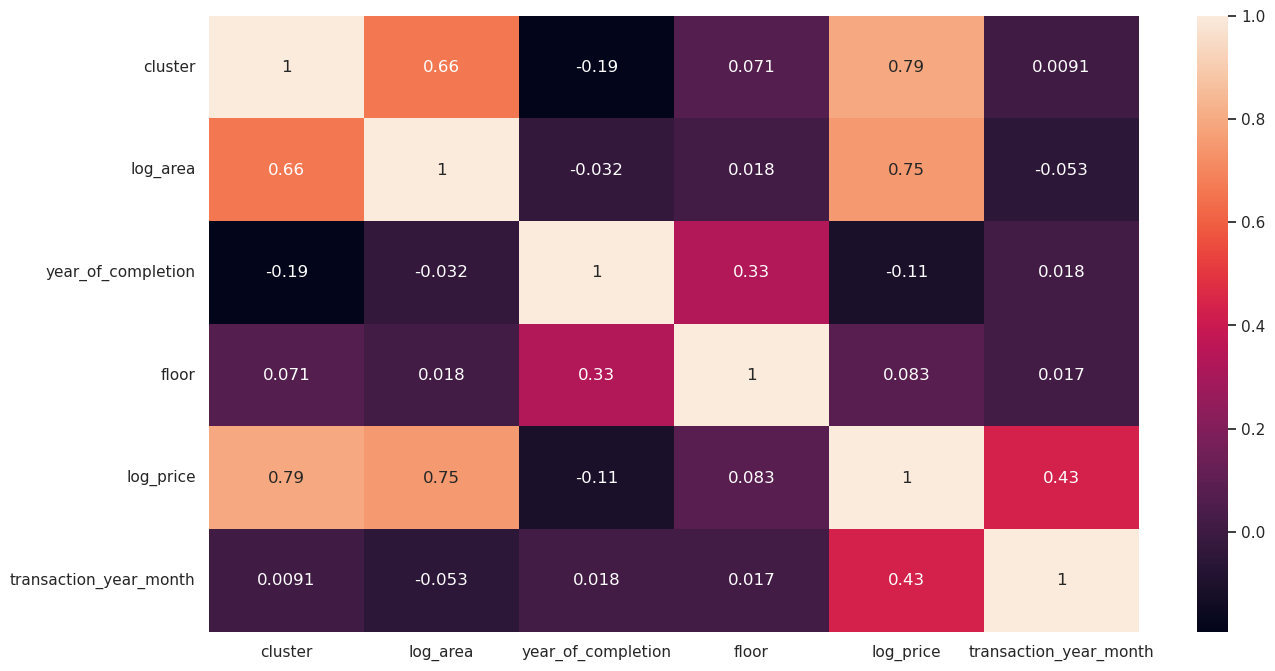

In [119]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_df.corr(),annot=True)